# Ativar GPU Própria do computador

In [ ]:
import tensorflow as tf

print("TF version:", tf.__version__)
print("Built with CUDA?", tf.test.is_built_with_cuda())
print("Physical GPUs:", tf.config.list_physical_devices('GPU'))

try:
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
except Exception as e:
    print("set_memory_growth error:", e)


TF version: 2.10.0
Built with CUDA? False
Physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import tensorflow as tf

# ver o device escolhido
print("GPUs:", tf.config.list_physical_devices('GPU'))

# habilitar growth (evita alocar toda a VRAM de uma vez)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except Exception as e:
        print("set_memory_growth falhou:", e)

# checar se o build tem suporte (ok para DirectML)
print("TF built with CUDA? ", tf.test.is_built_with_cuda())
print("TF built with ROCm? ", tf.test.is_built_with_rocm())


GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TF built with CUDA?  False
TF built with ROCm?  False


In [ ]:
import tensorflow as tf, time

with tf.device('/GPU:0'):
    a = tf.random.normal([4096, 4096])
    b = tf.random.normal([4096, 4096])
    t0 = time.time()
    c = tf.matmul(a, b)
    _ = c.numpy()  # força execução
print("Matmul 4k x 4k (GPU):", round(time.time() - t0, 3), "s")


Matmul 4k x 4k (GPU): 0.091 s


## Teste de GPU

In [ ]:
import tensorflow as tf, time, os

# (opcional) ver onde as ops rodam
tf.debugging.set_log_device_placement(True)

# ativar memory growth
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    try: tf.config.experimental.set_memory_growth(gpu, True)
    except: pass

# comparativo CPU vs GPU
def bench(dev):
    with tf.device(dev):
        a = tf.random.normal([4096,4096])
        b = tf.random.normal([4096,4096])
        t0 = time.time()
        c = tf.matmul(a,b); _ = c.numpy()
        return time.time()-t0

t_cpu = bench('/CPU:0')
t_gpu = bench('/GPU:0')

print({'cpu_s': round(t_cpu,3), 'gpu_s': round(t_gpu,3)})


{'cpu_s': 0.763, 'gpu_s': 0.062}


In [ ]:
import torch, tensorflow as tf
print('torch cuda:', torch.cuda.is_available())
print('tf gpus:', tf.config.list_physical_devices('GPU'))
if torch.cuda.is_available():
    print('gpu:', torch.cuda.get_device_name(0))


torch cuda: True
tf gpus: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
gpu: NVIDIA GeForce RTX 4060 Laptop GPU


# Arquivos de .wav e geração de mel-spectograms

In [ ]:
import pandas as pd
CSV_PATH = "MUStARD_Plus_Plus-main/mustard_text.csv"

df = pd.read_csv(CSV_PATH)

# Apenas instâncias rotuladas (Sarcasm == 0 ou 1)
df_labeled = df[df["Sarcasm"].notna()].copy()

# Converter para inteiro (0/1)
df_labeled["Sarcasm"] = df_labeled["Sarcasm"].astype(int)


print(f"Total de instâncias rotuladas: {len(df_labeled)}")
print(df_labeled["Sarcasm"].value_counts())


Total de instâncias rotuladas: 1202
Sarcasm
0    601
1    601
Name: count, dtype: int64


In [ ]:
df_labeled.head(50)

,SCENE,KEY,SENTENCE,END_TIME,SPEAKER,SHOW,Sarcasm,Sarcasm_Type,Implicit_Emotion,Explicit_Emotion,Valence,Arousal
5,1_10004,1_10004_u,"And of those few months, how long have you bee...",0:07,SHELDON,BBT,0,NONE,Anger,Anger,2.0,7.0
14,1_10009,1_10009_u,"Let the dead man talk. So, why do you think that?",0:05,PENNY,BBT,0,NONE,Happiness,Happiness,6.0,5.0
18,1_1001,1_1001_u,"What else? Sell it on eBay as ""slightly used.""",0:04,RAJ,BBT,0,NONE,Excitement,Excitement,6.0,5.0
24,1_1003,1_1003_u,"Good idea, sit with her. Hold her, comfort her...",0:08,HOWARD,BBT,1,PRO,Anger,Sadness,3.0,6.0
31,1_10190,1_10190_u,"Well, now that I've given up string theory, I'...",0:11,SHELDON,BBT,0,NONE,Neutral,Neutral,5.0,5.0
36,1_10462,1_10462_u,"You know, if you're really serious about that,...",0:09,HOWARD,BBT,1,PRO,Disgust,Excitement,4.0,6.0
42,1_10495,1_10495_u,And if it turns out you don't... - you and I c...,0:07,AMY,BBT,1,ILL,Disgust,Neutral,3.0,7.0
49,1_10496,1_10496_u,"- You and... Oh, sure. And while we're at it, ...",0:14,SHELDON,BBT,1,PRO,Frustration,Happiness,2.0,8.0
56,1_105,1_105_u,I'm just inferring this is a couch because the...,0:06,SHELDON,BBT,1,EMB,Disgust,Neutral,2.0,6.0
63,1_10748,1_10748_u,"There they go, fighting again. You'd never hea...",0:07,AMY,BBT,1,PRO,Disgust,Sadness,3.0,7.0


extração dos arquivos mp4 do mustard++ para audio

In [ ]:
import os
os.chdir(r"C:\Users\lucas\TratamentoDeVozProjeto1")  # ajuste se necessário

In [ ]:
import os,imageio_ffmpeg
import pandas as pd
from moviepy.editor import VideoFileClip
from tqdm import tqdm

CSV_PATH = "MUStARD_Plus_Plus-main/mustard_text.csv"
VIDEO_DIR = "final_utterance_videos"
OUT_AUDIO_DIR = "audio_extracted_16k"
os.makedirs(OUT_AUDIO_DIR, exist_ok=True)

df = pd.read_csv(CSV_PATH)
df_labeled = df[df["Sarcasm"].notna()].copy()
df_labeled["Sarcasm"] = df_labeled["Sarcasm"].astype(int)

# garante a existência da coluna
df_labeled["audio_path"] = None


for idx, row in tqdm(df_labeled.iterrows(), total=len(df_labeled), desc="Extraindo áudio"):
    key = str(row["KEY"]).strip()
    mp4 = os.path.join(VIDEO_DIR, f"{key}.mp4")
    wav = os.path.join(OUT_AUDIO_DIR, f"{key}.wav")

    if not os.path.exists(mp4):
        print(f"[!] Vídeo não encontrado: {mp4}")
        continue

    try:
        # Garante fechamento do arquivo e força áudio mono
        with VideoFileClip(mp4) as clip:
            clip.audio.write_audiofile(
                wav,
                fps=16000,             # use 16 kHz (ou deixe 22050 se preferir, mas padronize!)
                nbytes=2,
                codec="pcm_s16le",
                ffmpeg_params=["-ac", "1"],  # força 1 canal (mono)
                verbose=False,
                logger=None
            )
        df_labeled.loc[idx, "audio_path"] = wav
    except Exception as e:
        print(f"Erro ao processar {mp4}: {e}")

# Coluna 'audio' do seu pipeline (referência por caminho)
df_labeled["audio"] = df_labeled["audio_path"].apply(
    lambda p: {"path": p} if isinstance(p, str) and os.path.exists(p) else None
)

out_csv = os.path.join(OUT_AUDIO_DIR, "MUStARD_plusplus_with_audio_16k.csv")
df_labeled.to_csv(out_csv, index=False)
print(f"✅ Áudios salvos em: {OUT_AUDIO_DIR}")
print(f"✅ CSV atualizado: {out_csv}")
print("Total com áudio válido:", df_labeled["audio"].notna().sum())

Extraindo áudio:  39%|████████████████████████                                      | 466/1202 [02:10<03:49,  3.21it/s]

[!] Vídeo não encontrado: final_utterance_videos\Disgust.mp4


Extraindo áudio: 100%|█████████████████████████████████████████████████████████████| 1202/1202 [06:15<00:00,  3.20it/s]


✅ Áudios salvos em: audio_extracted_16k
✅ CSV atualizado: audio_extracted_16k\MUStARD_plusplus_with_audio_16k.csv
Total com áudio válido: 1201


checagem rápida

In [ ]:
import numpy as np, soundfile as sf

def qc_wav(path, thr_db=-40):
    y, sr = sf.read(path, always_2d=False)
    if y.ndim == 2: y = y.mean(axis=1)
    n = len(y); dur = n/sr if n else 0.0
    peak = float(np.max(np.abs(y))) if n else 0.0
    rms  = float(np.sqrt(np.mean(y**2))) if n else 0.0
    thr = peak * (10**(thr_db/20)) if peak>0 else 0.0
    if n and thr>0:
        nz = np.where(np.abs(y) >= thr)[0]
        lead = nz[0]/sr if nz.size else dur
        trail = (n - nz[-1] - 1)/sr if nz.size else 0.0
    else:
        lead = trail = 0.0
    return sr, dur, peak, rms, lead, trail

bad = []
for p in df_labeled["audio_path"].dropna():
    sr, dur, peak, rms, lead, trail = qc_wav(p)
    if dur < 0.3 or rms < 1e-4:
        bad.append((p, dur, rms))
print(f"Arquivos suspeitos: {len(bad)}")

Arquivos suspeitos: 0


### funções para Data Augmentation dos audios

In [ ]:
# ====== AUGMENTAÇÃO DE ÁUDIO (drop-in) ======
import numpy as np
import librosa
from scipy.signal import resample_poly
import noisereduce as nr

def apply_gain_db(y, db):
    g = 10.0 ** (db / 20.0)
    z = y.astype(np.float32, copy=False) * g
    peak = float(np.max(np.abs(z))) + 1e-9
    if peak > 0.999:
        z = z / peak * 0.999  # evita clipping
    return z.astype(np.float32, copy=False)

def time_stretch_safe(y, rate):
    if rate <= 0:
        return y
    z = librosa.effects.time_stretch(y.astype(np.float32, copy=False), rate=rate)
    peak = float(np.max(np.abs(z))) + 1e-9
    if peak > 0.999:
        z = z / peak * 0.999
    return z.astype(np.float32, copy=False)

def denoise_safe(y, sr, prop=0.8):
    try:
        z = nr.reduce_noise(
            y=y.astype(np.float32, copy=False),
            sr=sr,
            stationary=True,       # diálogo curto costuma funcionar melhor
            prop_decrease=prop,    # 0.6–0.9; maior = mais agressivo
            use_tensorflow=False
        )
        # se a redução "matou" demais o sinal, mantém original
        return z.astype(np.float32, copy=False) if _rms(z) >= 1e-5 else y
    except Exception:
        return y

def augment_audio(y, sr, do_gain=True, do_speed=True, do_denoise=True):
    """
    Retorna lista de (nome, y_aug). Ajuste os flags para controlar quais aplicar.
    """
    outs = [("orig", y)]

    if do_gain:
        for db in (+6, -6):
            z = apply_gain_db(y, db)
            if _rms(z) >= 1e-4:  # evita amostras quase mudas
                tag = "gainp6" if db > 0 else "gainm6"
                outs.append((tag, z))

    if do_speed:
        for r in (0.90, 1.10):
            try:
                z = time_stretch_safe(y, r)  # preserva pitch
                outs.append((f"speed{int(round(r*100))}", z))
            except Exception:
                pass

    if do_denoise:
        z = denoise_safe(y, sr, prop=0.8)
        outs.append(("denoise", z))

    return outs

Loader + Mel-spectrogram “antitapete”

In [ ]:
import numpy as np, soundfile as sf, librosa, librosa.display, matplotlib.pyplot as plt, os

TARGET_SR = 16000  # use o MESMO da extração; ajuste para 22050 se for o caso

def load_audio_from_path_item(a, target_sr=TARGET_SR):
    if not isinstance(a, dict) or "path" not in a or not os.path.exists(a["path"]):
        raise FileNotFoundError("Campo 'audio' inválido ou caminho inexistente.")
    y, sr = sf.read(a["path"], always_2d=False)
    if y.ndim == 2: y = y.mean(axis=1)
    y = y.astype(np.float32, copy=False)
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr, res_type="kaiser_best")
        sr = target_sr
    peak = float(np.max(np.abs(y))) if y.size else 0.0
    if peak > 1e-6:
        y = y / peak
    return y, sr

def log_mel_db_safe(y, sr, n_mels=128, n_fft=1024, hop=256):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop,
                                       n_mels=n_mels, power=2.0)
    if not np.isfinite(S).any() or np.max(S) <= 0:
        S = S + 1e-12
        logS = librosa.power_to_db(S, ref=1.0)
    else:
        logS = librosa.power_to_db(S, ref=np.max)
    if np.nanmax(logS) - np.nanmin(logS) < 5.0:
        logS = librosa.power_to_db(S + 1e-12, ref=1.0)
    return logS

def save_mel_image(logS, out_png, sr=TARGET_SR, hop=256, cmap="magma"):
    os.makedirs(os.path.dirname(out_png), exist_ok=True)
    plt.figure(figsize=(3.2, 3.2), dpi=100)
    librosa.display.specshow(logS, sr=sr, hop_length=hop, x_axis=None, y_axis=None, cmap=cmap)
    plt.axis("off"); plt.tight_layout(pad=0)
    plt.savefig(out_png, bbox_inches="tight", pad_inches=0); plt.close()

### loop de geração de melSpectograms

In [ ]:
OUT_IMG_DIR = r"C:\Users\lucas\TratamentoDeVozProjeto1\melpng_16k"
os.makedirs(OUT_IMG_DIR, exist_ok=True)

fails = []
for i, row in df_labeled.iterrows():
    a = row.get("audio")
    if not isinstance(a, dict):
        fails.append((i, "sem campo audio")); continue
    try:
        y, sr = load_audio_from_path_item(a, target_sr=TARGET_SR)
        dur = len(y)/sr
        if dur < 0.3 or float(np.sqrt(np.mean(y**2))) < 1e-4:
            fails.append((i, f"sinal fraco/curto ({dur:.2f}s)"))
            continue
        logS = log_mel_db_safe(y, sr)
        if np.nanmax(logS) - np.nanmin(logS) < 3.0:
            fails.append((i, "mel sem contraste"))
            continue
        key = str(row["KEY"]).strip()
        out_png = os.path.join(OUT_IMG_DIR, f"{key}.png")
        save_mel_image(logS, out_png, sr=sr)
    except Exception as e:
        fails.append((i, f"erro: {e}"))

print(f"Concluído. Falhas: {len(fails)}")
# Opcional: inspecionar primeiras falhas
for f in fails[:10]: print(f)

Concluído. Falhas: 1
(2596, 'sem campo audio')


Muitos arquivos curtos, entre 2 e 5 segundos segundos, isso atrapalha a analise espectral, pois a janela é muito curta para analise. Para isso, a melhor solução é adicionar silencio, alargando a janela para uma melhor analise

# Geração de Mel-Spectograms

In [ ]:
# ====== CÉLULA SUBSTITUTA “SAFE” ======
import os, io
import numpy as np
import pandas as pd
from tqdm import tqdm
import soundfile as sf
import librosa
from PIL import Image
from scipy.signal import resample_poly



TARGET_SR = 16000
MONO = True
NARROW_WIN_MS = 80
HOP_MS = 10

OUT_ROOT  = "out_narrowband_librosa"
IMG_DIR   = os.path.join(OUT_ROOT, "narrowband_test")
os.makedirs(IMG_DIR, exist_ok=True)

def _resample_audio(y, sr, target_sr):
    if sr == target_sr:
        return y.astype(np.float32, copy=False), sr
    # resample_poly faz anti-aliasing e não usa resampy
    y_rs = resample_poly(y.astype(np.float32, copy=False), target_sr, sr)
    return y_rs.astype(np.float32, copy=False), target_sr



def _rms(x):
    return float(np.sqrt(np.mean(np.square(x))) + 1e-12)

def _zscore_global(S):
    Z = (S - np.mean(S)) / (np.std(S) + 1e-8)
    Z = np.clip(Z, -3, 3)
    return (Z + 3) / 6  # [0,1]

def _resize_2d_linear(mat, new_h, new_w):
    h, w = mat.shape
    x_old = np.linspace(0.0, 1.0, w)
    x_new = np.linspace(0.0, 1.0, new_w)
    tmp = np.empty((h, new_w), dtype=np.float32)
    for i in range(h):
        tmp[i, :] = np.interp(x_new, x_old, mat[i, :])
    y_old = np.linspace(0.0, 1.0, h)
    y_new = np.linspace(0.0, 1.0, new_h)
    out = np.empty((new_h, new_w), dtype=np.float32)
    for j in range(new_w):
        out[:, j] = np.interp(y_new, y_old, tmp[:, j])
    return out

def load_audio_from_feature(a, target_sr=TARGET_SR, mono=MONO):
    # Lê de bytes OU de path, priorizando path
    if isinstance(a, dict) and a.get("path") and os.path.exists(a["path"]):
        y, sr = sf.read(a["path"], always_2d=False)
    elif isinstance(a, dict) and a.get("bytes"):
        y, sr = sf.read(io.BytesIO(a["bytes"]), always_2d=False)
    else:
        raise FileNotFoundError("Sem bytes nem caminho local para o áudio.")

    # Mono
    if isinstance(y, np.ndarray) and y.ndim == 2:
        y = y.mean(axis=1)

    # Resample se necessário
    if sr != target_sr:
        y, sr = _resample_audio(y, sr, target_sr)

    # Normaliza só se houver pico suficiente (evita estourar ruído de fundo)
    peak = float(np.max(np.abs(y))) if y.size else 0.0
    if peak > 1e-6:
        y = (y / peak).astype(np.float32, copy=False)
    else:
        y = y.astype(np.float32, copy=False)

    return y, sr

def _log_mel_db_safe(y, sr, n_mels=96, n_fft=None, hop=None, fmin=50, fmax=None):
    if n_fft is None:
        n_fft = int(sr * (NARROW_WIN_MS/1000.0))
    if hop is None:
        hop = int(sr * (HOP_MS/1000.0))
    if fmax is None:
        fmax = sr // 2

    # Mel power
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop,
                                       n_mels=n_mels, fmin=fmin, fmax=fmax, power=2.0)
    S = np.maximum(S, 1e-12)

    # Se o espectro for muito baixo, usa ref=1.0 como fallback
    if np.max(S) <= 1e-10:
        logS = librosa.power_to_db(S, ref=1.0)
    else:
        logS = librosa.power_to_db(S, ref=np.max)

    # Recorte robusto de outliers + checagem de contraste
    p2, p98 = np.percentile(logS, 2), np.percentile(logS, 98)
    if (p98 - p2) >= 5.0:
        logS = np.clip(logS, p2, p98)
    else:
        # Fallback: reescala com ref=1.0 para recuperar contraste
        logS = librosa.power_to_db(S, ref=1.0)

    return logS

def save_rgb_logmel_mfcc(y, sr, out_path, n_mels=96, n_mfcc=20, win_ms=NARROW_WIN_MS, hop_ms=HOP_MS):
    # Padding mínimo só se for realmente curto; áudios têm 6–12s
    MIN_LEN = int(sr * 1.0)
    if len(y) < MIN_LEN:
        y = np.pad(y, (0, MIN_LEN - len(y)))

    n_fft = int(sr * (win_ms/1000.0))
    hop   = int(sr * (hop_ms/1000.0))

    logS = _log_mel_db_safe(y, sr, n_mels=n_mels, n_fft=n_fft, hop=hop)

    # MFCC/deltas a partir do log-mel
    mfcc  = librosa.feature.mfcc(S=logS, n_mfcc=n_mfcc)
    d1    = librosa.feature.delta(mfcc, order=1)
    d2    = librosa.feature.delta(mfcc, order=2)

    # Normalização p/ contraste
    R = _zscore_global(logS)      # log-mel
    G = _zscore_global(d1)        # delta MFCC
    B = _zscore_global(d2)        # delta-delta MFCC

    # Alinhar tempos e alturas
    T = min(R.shape[1], G.shape[1], B.shape[1])
    R, G, B = R[:, :T], G[:, :T], B[:, :T]
    if G.shape[0] != R.shape[0]: G = _resize_2d_linear(G, R.shape[0], R.shape[1])
    if B.shape[0] != R.shape[0]: B = _resize_2d_linear(B, R.shape[0], R.shape[1])

    # Debug e checagem de contraste real
    dyn_db = float(np.nanmax(logS) - np.nanmin(logS))
    print(f"dyn(log-mel) = {dyn_db:.2f} dB | R.std={R.std():.3f} G.std={G.std():.3f} B.std={B.std():.3f}")
    if dyn_db < 3.0:
        raise ValueError("mel sem contraste suficiente (possível 'tapete cinza').")

    # Empilhar e salvar
    img = np.stack([R, G, B], axis=-1)   # float [0,1]
    img8 = (np.clip(img, 0, 1)*255).astype(np.uint8)
    Image.fromarray(img8).save(out_path)

# ======== Geração ========
records, fails = [], []

for idx, row in tqdm(df_labeled.iterrows(), total=len(df_labeled),
                     desc="Gerando Mel+MFCC (sem SpecAug p/ debug)"):
    try:
        audio_feat = row["audio"]
        base = os.path.splitext(str(row.get("KEY", f"idx_{idx}")))[0]

        y, sr = load_audio_from_feature(audio_feat, TARGET_SR, MONO)
        dur_s = len(y)/sr
        print(f"Duração do áudio: {dur_s:.2f}s")

        # pula áudios quase mudos (evita imagem chapada)
        if _rms(y) < 1e-3:
            fails.append((base, "RMS muito baixo"))
            continue

        # depois (gera várias variações por amostra)
        for aug_name, y_aug in augment_audio(y, sr, do_gain=True, do_speed=True, do_denoise=True):
            # opcional: pad/trim para largura fixa das imagens
            # y_aug = pad_or_trim(y_aug, sr, dur_s=6.0)

            img_path = os.path.join(IMG_DIR, f"{base}_{aug_name}.png")
            save_rgb_logmel_mfcc(y_aug, sr, img_path,
                                 n_mels=96, n_mfcc=20,
                                 win_ms=NARROW_WIN_MS, hop_ms=HOP_MS)

            rec = row.drop(labels=[c for c in ["audio_path","audio"] if c in row.index]).to_dict()
            rec["narrowband_spec_path"] = img_path
            rec["augmentation"] = aug_name
            records.append(rec)

    except Exception as e:
        fails.append((row.get("KEY", f"idx_{idx}"), str(e)))

new_df = pd.DataFrame.from_records(records)
os.makedirs(OUT_ROOT, exist_ok=True)
csv_path = os.path.join(OUT_ROOT, "mustard_narrowband_nodenoise.csv")
pq_path  = os.path.join(OUT_ROOT, "mustard_narrowband_nodenoise.parquet")
new_df.to_csv(csv_path, index=False, encoding="utf-8")
new_df.to_parquet(pq_path, index=False)

print(f"✅ Espectrogramas gerados: {len(records)} | Falhas: {len(fails)}")
if fails: print("Alguns erros (até 10):", fails[:10])


Gerando Mel+MFCC (sem SpecAug p/ debug):   0%|                                                | 0/1202 [00:00<?, ?it/s]

Duração do áudio: 7.01s
dyn(log-mel) = 61.72 dB | R.std=0.167 G.std=0.095 B.std=0.101
dyn(log-mel) = 61.72 dB | R.std=0.167 G.std=0.095 B.std=0.101
dyn(log-mel) = 61.72 dB | R.std=0.167 G.std=0.095 B.std=0.101


Gerando Mel+MFCC (sem SpecAug p/ debug):   0%|                                        | 1/1202 [00:01<35:48,  1.79s/it]

dyn(log-mel) = 61.32 dB | R.std=0.167 G.std=0.106 B.std=0.124
dyn(log-mel) = 61.05 dB | R.std=0.167 G.std=0.106 B.std=0.122
dyn(log-mel) = 61.72 dB | R.std=0.167 G.std=0.095 B.std=0.101
Duração do áudio: 5.01s
dyn(log-mel) = 44.58 dB | R.std=0.167 G.std=0.098 B.std=0.106
dyn(log-mel) = 44.58 dB | R.std=0.167 G.std=0.098 B.std=0.106
dyn(log-mel) = 44.58 dB | R.std=0.167 G.std=0.098 B.std=0.106
dyn(log-mel) = 42.82 dB | R.std=0.167 G.std=0.112 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):   0%|                                        | 2/1202 [00:02<20:21,  1.02s/it]

dyn(log-mel) = 43.31 dB | R.std=0.167 G.std=0.110 B.std=0.124
dyn(log-mel) = 44.58 dB | R.std=0.167 G.std=0.098 B.std=0.106
Duração do áudio: 3.00s
dyn(log-mel) = 57.72 dB | R.std=0.167 G.std=0.096 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):   0%|                                        | 3/1202 [00:02<14:01,  1.42it/s]

dyn(log-mel) = 57.72 dB | R.std=0.167 G.std=0.096 B.std=0.105
dyn(log-mel) = 57.72 dB | R.std=0.167 G.std=0.096 B.std=0.105
dyn(log-mel) = 54.24 dB | R.std=0.167 G.std=0.104 B.std=0.127
dyn(log-mel) = 54.16 dB | R.std=0.167 G.std=0.103 B.std=0.119
dyn(log-mel) = 57.72 dB | R.std=0.167 G.std=0.096 B.std=0.105
Duração do áudio: 8.01s
dyn(log-mel) = 53.88 dB | R.std=0.167 G.std=0.112 B.std=0.116
dyn(log-mel) = 53.88 dB | R.std=0.167 G.std=0.112 B.std=0.116
dyn(log-mel) = 53.88 dB | R.std=0.167 G.std=0.112 B.std=0.116


Gerando Mel+MFCC (sem SpecAug p/ debug):   0%|▏                                       | 4/1202 [00:03<13:59,  1.43it/s]

dyn(log-mel) = 53.24 dB | R.std=0.167 G.std=0.120 B.std=0.135
dyn(log-mel) = 53.15 dB | R.std=0.167 G.std=0.119 B.std=0.133
dyn(log-mel) = 53.88 dB | R.std=0.167 G.std=0.112 B.std=0.116
Duração do áudio: 11.01s
dyn(log-mel) = 60.79 dB | R.std=0.167 G.std=0.103 B.std=0.108
dyn(log-mel) = 60.79 dB | R.std=0.167 G.std=0.103 B.std=0.108
dyn(log-mel) = 60.79 dB | R.std=0.167 G.std=0.103 B.std=0.108
dyn(log-mel) = 60.14 dB | R.std=0.167 G.std=0.109 B.std=0.124
dyn(log-mel) = 59.87 dB | R.std=0.167 G.std=0.110 B.std=0.121
dyn(log-mel) = 60.79 dB | R.std=0.167 G.std=0.103 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):   0%|▏                                       | 5/1202 [00:04<15:33,  1.28it/s]

Duração do áudio: 9.01s
dyn(log-mel) = 48.27 dB | R.std=0.167 G.std=0.108 B.std=0.110
dyn(log-mel) = 48.27 dB | R.std=0.167 G.std=0.108 B.std=0.110
dyn(log-mel) = 48.27 dB | R.std=0.167 G.std=0.108 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):   0%|▏                                       | 6/1202 [00:04<15:33,  1.28it/s]

dyn(log-mel) = 47.97 dB | R.std=0.167 G.std=0.115 B.std=0.132
dyn(log-mel) = 47.35 dB | R.std=0.167 G.std=0.114 B.std=0.125
dyn(log-mel) = 48.27 dB | R.std=0.167 G.std=0.108 B.std=0.110
Duração do áudio: 8.01s
dyn(log-mel) = 63.47 dB | R.std=0.167 G.std=0.095 B.std=0.101
dyn(log-mel) = 63.47 dB | R.std=0.167 G.std=0.095 B.std=0.101
dyn(log-mel) = 63.47 dB | R.std=0.167 G.std=0.095 B.std=0.101


Gerando Mel+MFCC (sem SpecAug p/ debug):   1%|▏                                       | 7/1202 [00:05<15:06,  1.32it/s]

dyn(log-mel) = 62.42 dB | R.std=0.167 G.std=0.103 B.std=0.129
dyn(log-mel) = 63.91 dB | R.std=0.167 G.std=0.102 B.std=0.127
dyn(log-mel) = 63.47 dB | R.std=0.167 G.std=0.095 B.std=0.101
Duração do áudio: 14.01s
dyn(log-mel) = 61.10 dB | R.std=0.167 G.std=0.105 B.std=0.109
dyn(log-mel) = 61.10 dB | R.std=0.167 G.std=0.105 B.std=0.109
dyn(log-mel) = 61.10 dB | R.std=0.167 G.std=0.105 B.std=0.109
dyn(log-mel) = 58.39 dB | R.std=0.167 G.std=0.114 B.std=0.131


Gerando Mel+MFCC (sem SpecAug p/ debug):   1%|▎                                       | 8/1202 [00:06<17:36,  1.13it/s]

dyn(log-mel) = 57.03 dB | R.std=0.167 G.std=0.114 B.std=0.128
dyn(log-mel) = 61.10 dB | R.std=0.167 G.std=0.105 B.std=0.109
Duração do áudio: 6.01s
dyn(log-mel) = 41.85 dB | R.std=0.167 G.std=0.112 B.std=0.109
dyn(log-mel) = 41.85 dB | R.std=0.167 G.std=0.112 B.std=0.109
dyn(log-mel) = 41.85 dB | R.std=0.167 G.std=0.112 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):   1%|▎                                       | 9/1202 [00:07<15:37,  1.27it/s]

dyn(log-mel) = 38.50 dB | R.std=0.167 G.std=0.123 B.std=0.133
dyn(log-mel) = 37.57 dB | R.std=0.167 G.std=0.124 B.std=0.133
dyn(log-mel) = 41.85 dB | R.std=0.167 G.std=0.112 B.std=0.109
Duração do áudio: 7.01s
dyn(log-mel) = 46.43 dB | R.std=0.167 G.std=0.110 B.std=0.120
dyn(log-mel) = 46.43 dB | R.std=0.167 G.std=0.110 B.std=0.120
dyn(log-mel) = 46.43 dB | R.std=0.167 G.std=0.110 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):   1%|▎                                      | 10/1202 [00:08<14:52,  1.34it/s]

dyn(log-mel) = 45.52 dB | R.std=0.167 G.std=0.115 B.std=0.134
dyn(log-mel) = 44.80 dB | R.std=0.167 G.std=0.116 B.std=0.131
dyn(log-mel) = 46.43 dB | R.std=0.167 G.std=0.110 B.std=0.120
Duração do áudio: 7.01s
dyn(log-mel) = 46.28 dB | R.std=0.167 G.std=0.103 B.std=0.109
dyn(log-mel) = 46.28 dB | R.std=0.167 G.std=0.103 B.std=0.109
dyn(log-mel) = 46.28 dB | R.std=0.167 G.std=0.103 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):   1%|▎                                      | 11/1202 [00:08<14:20,  1.38it/s]

dyn(log-mel) = 44.65 dB | R.std=0.167 G.std=0.110 B.std=0.130
dyn(log-mel) = 44.86 dB | R.std=0.167 G.std=0.109 B.std=0.124
dyn(log-mel) = 46.28 dB | R.std=0.167 G.std=0.103 B.std=0.109
Duração do áudio: 10.01s
dyn(log-mel) = 46.96 dB | R.std=0.167 G.std=0.111 B.std=0.115
dyn(log-mel) = 46.96 dB | R.std=0.167 G.std=0.111 B.std=0.115
dyn(log-mel) = 46.96 dB | R.std=0.167 G.std=0.111 B.std=0.115
dyn(log-mel) = 45.44 dB | R.std=0.167 G.std=0.116 B.std=0.134


Gerando Mel+MFCC (sem SpecAug p/ debug):   1%|▍                                      | 12/1202 [00:09<15:28,  1.28it/s]

dyn(log-mel) = 44.92 dB | R.std=0.167 G.std=0.115 B.std=0.130
dyn(log-mel) = 46.96 dB | R.std=0.167 G.std=0.111 B.std=0.115
Duração do áudio: 10.01s
dyn(log-mel) = 50.35 dB | R.std=0.167 G.std=0.102 B.std=0.110
dyn(log-mel) = 50.35 dB | R.std=0.167 G.std=0.102 B.std=0.110
dyn(log-mel) = 50.35 dB | R.std=0.167 G.std=0.102 B.std=0.110
dyn(log-mel) = 46.73 dB | R.std=0.167 G.std=0.112 B.std=0.131
dyn(log-mel) = 46.62 dB | R.std=0.167 G.std=0.108 B.std=0.121
dyn(log-mel) = 50.35 dB | R.std=0.167 G.std=0.102 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):   1%|▍                                      | 13/1202 [00:10<15:52,  1.25it/s]

Duração do áudio: 5.01s
dyn(log-mel) = 62.49 dB | R.std=0.167 G.std=0.094 B.std=0.101
dyn(log-mel) = 62.49 dB | R.std=0.167 G.std=0.094 B.std=0.101
dyn(log-mel) = 62.49 dB | R.std=0.167 G.std=0.094 B.std=0.101
dyn(log-mel) = 61.43 dB | R.std=0.167 G.std=0.104 B.std=0.129
dyn(log-mel) = 61.04 dB | R.std=0.167 G.std=0.103 B.std=0.127


Gerando Mel+MFCC (sem SpecAug p/ debug):   1%|▍                                      | 14/1202 [00:11<13:56,  1.42it/s]

dyn(log-mel) = 62.49 dB | R.std=0.167 G.std=0.094 B.std=0.101
Duração do áudio: 5.01s
dyn(log-mel) = 48.91 dB | R.std=0.167 G.std=0.106 B.std=0.114
dyn(log-mel) = 48.91 dB | R.std=0.167 G.std=0.106 B.std=0.114
dyn(log-mel) = 48.91 dB | R.std=0.167 G.std=0.106 B.std=0.114
dyn(log-mel) = 46.54 dB | R.std=0.167 G.std=0.111 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):   1%|▍                                      | 15/1202 [00:11<12:56,  1.53it/s]

dyn(log-mel) = 45.76 dB | R.std=0.167 G.std=0.111 B.std=0.123
dyn(log-mel) = 48.91 dB | R.std=0.167 G.std=0.106 B.std=0.114
Duração do áudio: 7.01s
dyn(log-mel) = 46.96 dB | R.std=0.167 G.std=0.101 B.std=0.103
dyn(log-mel) = 46.96 dB | R.std=0.167 G.std=0.101 B.std=0.103
dyn(log-mel) = 46.96 dB | R.std=0.167 G.std=0.101 B.std=0.103


Gerando Mel+MFCC (sem SpecAug p/ debug):   1%|▌                                      | 16/1202 [00:12<12:51,  1.54it/s]

dyn(log-mel) = 44.47 dB | R.std=0.167 G.std=0.114 B.std=0.129
dyn(log-mel) = 43.73 dB | R.std=0.167 G.std=0.113 B.std=0.127
dyn(log-mel) = 46.96 dB | R.std=0.167 G.std=0.101 B.std=0.103
Duração do áudio: 3.00s


Gerando Mel+MFCC (sem SpecAug p/ debug):   1%|▌                                      | 17/1202 [00:12<11:00,  1.80it/s]

dyn(log-mel) = 43.75 dB | R.std=0.167 G.std=0.115 B.std=0.120
dyn(log-mel) = 43.75 dB | R.std=0.167 G.std=0.115 B.std=0.120
dyn(log-mel) = 43.75 dB | R.std=0.167 G.std=0.115 B.std=0.120
dyn(log-mel) = 41.54 dB | R.std=0.167 G.std=0.119 B.std=0.134
dyn(log-mel) = 40.54 dB | R.std=0.167 G.std=0.118 B.std=0.128
dyn(log-mel) = 43.75 dB | R.std=0.167 G.std=0.115 B.std=0.120
Duração do áudio: 6.01s
dyn(log-mel) = 44.69 dB | R.std=0.167 G.std=0.104 B.std=0.108
dyn(log-mel) = 44.69 dB | R.std=0.167 G.std=0.104 B.std=0.108
dyn(log-mel) = 44.69 dB | R.std=0.167 G.std=0.104 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):   1%|▌                                      | 18/1202 [00:13<11:04,  1.78it/s]

dyn(log-mel) = 42.89 dB | R.std=0.167 G.std=0.118 B.std=0.132
dyn(log-mel) = 41.85 dB | R.std=0.167 G.std=0.117 B.std=0.132
dyn(log-mel) = 44.69 dB | R.std=0.167 G.std=0.104 B.std=0.108
Duração do áudio: 4.00s
dyn(log-mel) = 48.49 dB | R.std=0.167 G.std=0.105 B.std=0.112
dyn(log-mel) = 48.49 dB | R.std=0.167 G.std=0.105 B.std=0.112
dyn(log-mel) = 48.49 dB | R.std=0.167 G.std=0.105 B.std=0.112
dyn(log-mel) = 46.48 dB | R.std=0.167 G.std=0.115 B.std=0.134
dyn(log-mel) = 46.02 dB | R.std=0.167 G.std=0.113 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):   2%|▌                                      | 19/1202 [00:13<10:18,  1.91it/s]

dyn(log-mel) = 48.49 dB | R.std=0.167 G.std=0.105 B.std=0.112
Duração do áudio: 4.00s
dyn(log-mel) = 58.54 dB | R.std=0.167 G.std=0.108 B.std=0.113
dyn(log-mel) = 58.54 dB | R.std=0.167 G.std=0.108 B.std=0.113
dyn(log-mel) = 58.54 dB | R.std=0.167 G.std=0.108 B.std=0.113
dyn(log-mel) = 57.90 dB | R.std=0.167 G.std=0.113 B.std=0.130
dyn(log-mel) = 56.25 dB | R.std=0.167 G.std=0.113 B.std=0.127
dyn(log-mel) = 58.54 dB | R.std=0.167 G.std=0.108 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):   2%|▋                                      | 20/1202 [00:13<09:41,  2.03it/s]

Duração do áudio: 5.01s
dyn(log-mel) = 54.19 dB | R.std=0.167 G.std=0.104 B.std=0.108
dyn(log-mel) = 54.19 dB | R.std=0.167 G.std=0.104 B.std=0.108
dyn(log-mel) = 54.19 dB | R.std=0.167 G.std=0.104 B.std=0.108
dyn(log-mel) = 53.43 dB | R.std=0.167 G.std=0.108 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):   2%|▋                                      | 21/1202 [00:14<09:46,  2.01it/s]

dyn(log-mel) = 52.36 dB | R.std=0.167 G.std=0.107 B.std=0.125
dyn(log-mel) = 54.19 dB | R.std=0.167 G.std=0.104 B.std=0.108
Duração do áudio: 7.01s
dyn(log-mel) = 43.64 dB | R.std=0.167 G.std=0.111 B.std=0.114
dyn(log-mel) = 43.64 dB | R.std=0.167 G.std=0.111 B.std=0.114
dyn(log-mel) = 43.64 dB | R.std=0.167 G.std=0.111 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):   2%|▋                                      | 22/1202 [00:15<10:36,  1.85it/s]

dyn(log-mel) = 40.51 dB | R.std=0.167 G.std=0.121 B.std=0.132
dyn(log-mel) = 40.47 dB | R.std=0.167 G.std=0.121 B.std=0.131
dyn(log-mel) = 43.64 dB | R.std=0.167 G.std=0.111 B.std=0.114
Duração do áudio: 5.01s
dyn(log-mel) = 48.97 dB | R.std=0.167 G.std=0.113 B.std=0.123
dyn(log-mel) = 48.97 dB | R.std=0.167 G.std=0.113 B.std=0.123
dyn(log-mel) = 48.97 dB | R.std=0.167 G.std=0.113 B.std=0.123


Gerando Mel+MFCC (sem SpecAug p/ debug):   2%|▋                                      | 23/1202 [00:15<10:44,  1.83it/s]

dyn(log-mel) = 48.79 dB | R.std=0.167 G.std=0.120 B.std=0.138
dyn(log-mel) = 48.37 dB | R.std=0.167 G.std=0.118 B.std=0.136
dyn(log-mel) = 48.97 dB | R.std=0.167 G.std=0.113 B.std=0.123
Duração do áudio: 7.01s
dyn(log-mel) = 44.53 dB | R.std=0.167 G.std=0.102 B.std=0.111
dyn(log-mel) = 44.53 dB | R.std=0.167 G.std=0.102 B.std=0.111
dyn(log-mel) = 44.53 dB | R.std=0.167 G.std=0.102 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):   2%|▊                                      | 24/1202 [00:16<11:06,  1.77it/s]

dyn(log-mel) = 41.78 dB | R.std=0.167 G.std=0.115 B.std=0.133
dyn(log-mel) = 41.14 dB | R.std=0.167 G.std=0.115 B.std=0.131
dyn(log-mel) = 44.53 dB | R.std=0.167 G.std=0.102 B.std=0.111
Duração do áudio: 12.01s
dyn(log-mel) = 50.81 dB | R.std=0.167 G.std=0.111 B.std=0.116
dyn(log-mel) = 50.81 dB | R.std=0.167 G.std=0.111 B.std=0.116
dyn(log-mel) = 50.81 dB | R.std=0.167 G.std=0.111 B.std=0.116
dyn(log-mel) = 48.61 dB | R.std=0.167 G.std=0.119 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):   2%|▊                                      | 25/1202 [00:17<13:52,  1.41it/s]

dyn(log-mel) = 48.03 dB | R.std=0.167 G.std=0.120 B.std=0.131
dyn(log-mel) = 50.81 dB | R.std=0.167 G.std=0.111 B.std=0.116
Duração do áudio: 9.01s
dyn(log-mel) = 57.78 dB | R.std=0.167 G.std=0.112 B.std=0.115
dyn(log-mel) = 57.78 dB | R.std=0.167 G.std=0.112 B.std=0.115
dyn(log-mel) = 57.78 dB | R.std=0.167 G.std=0.112 B.std=0.115
dyn(log-mel) = 56.79 dB | R.std=0.167 G.std=0.116 B.std=0.132
dyn(log-mel) = 56.67 dB | R.std=0.167 G.std=0.115 B.std=0.128
dyn(log-mel) = 57.78 dB | R.std=0.167 G.std=0.112 B.std=0.115


Gerando Mel+MFCC (sem SpecAug p/ debug):   2%|▊                                      | 26/1202 [00:18<14:29,  1.35it/s]

Duração do áudio: 4.00s
dyn(log-mel) = 58.06 dB | R.std=0.167 G.std=0.097 B.std=0.101
dyn(log-mel) = 58.06 dB | R.std=0.167 G.std=0.097 B.std=0.101
dyn(log-mel) = 58.06 dB | R.std=0.167 G.std=0.097 B.std=0.101
dyn(log-mel) = 53.34 dB | R.std=0.167 G.std=0.103 B.std=0.123
dyn(log-mel) = 51.79 dB | R.std=0.167 G.std=0.102 B.std=0.120
dyn(log-mel) = 58.06 dB | R.std=0.167 G.std=0.097 B.std=0.101


Gerando Mel+MFCC (sem SpecAug p/ debug):   2%|▉                                      | 27/1202 [00:18<12:32,  1.56it/s]

Duração do áudio: 6.01s
dyn(log-mel) = 53.87 dB | R.std=0.167 G.std=0.111 B.std=0.117
dyn(log-mel) = 53.87 dB | R.std=0.167 G.std=0.111 B.std=0.117
dyn(log-mel) = 53.87 dB | R.std=0.167 G.std=0.111 B.std=0.117
dyn(log-mel) = 52.46 dB | R.std=0.167 G.std=0.114 B.std=0.135


Gerando Mel+MFCC (sem SpecAug p/ debug):   2%|▉                                      | 28/1202 [00:19<12:06,  1.62it/s]

dyn(log-mel) = 52.67 dB | R.std=0.167 G.std=0.114 B.std=0.133
dyn(log-mel) = 53.87 dB | R.std=0.167 G.std=0.111 B.std=0.117
Duração do áudio: 7.01s
dyn(log-mel) = 50.72 dB | R.std=0.167 G.std=0.105 B.std=0.104
dyn(log-mel) = 50.72 dB | R.std=0.167 G.std=0.105 B.std=0.104
dyn(log-mel) = 50.72 dB | R.std=0.167 G.std=0.105 B.std=0.104


Gerando Mel+MFCC (sem SpecAug p/ debug):   2%|▉                                      | 29/1202 [00:19<12:14,  1.60it/s]

dyn(log-mel) = 47.67 dB | R.std=0.167 G.std=0.116 B.std=0.132
dyn(log-mel) = 47.42 dB | R.std=0.167 G.std=0.116 B.std=0.130
dyn(log-mel) = 50.72 dB | R.std=0.167 G.std=0.105 B.std=0.104
Duração do áudio: 10.01s
dyn(log-mel) = 56.88 dB | R.std=0.167 G.std=0.096 B.std=0.104
dyn(log-mel) = 56.88 dB | R.std=0.167 G.std=0.096 B.std=0.104
dyn(log-mel) = 56.88 dB | R.std=0.167 G.std=0.096 B.std=0.104
dyn(log-mel) = 56.23 dB | R.std=0.167 G.std=0.107 B.std=0.131
dyn(log-mel) = 56.05 dB | R.std=0.167 G.std=0.105 B.std=0.122
dyn(log-mel) = 56.88 dB | R.std=0.167 G.std=0.096 B.std=0.104


Gerando Mel+MFCC (sem SpecAug p/ debug):   2%|▉                                      | 30/1202 [00:20<13:36,  1.44it/s]

Duração do áudio: 6.01s
dyn(log-mel) = 57.92 dB | R.std=0.167 G.std=0.107 B.std=0.113
dyn(log-mel) = 57.92 dB | R.std=0.167 G.std=0.107 B.std=0.113
dyn(log-mel) = 57.92 dB | R.std=0.167 G.std=0.107 B.std=0.113
dyn(log-mel) = 56.33 dB | R.std=0.167 G.std=0.111 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):   3%|█                                      | 31/1202 [00:21<12:50,  1.52it/s]

dyn(log-mel) = 56.05 dB | R.std=0.167 G.std=0.110 B.std=0.127
dyn(log-mel) = 57.92 dB | R.std=0.167 G.std=0.107 B.std=0.113
Duração do áudio: 12.01s
dyn(log-mel) = 54.09 dB | R.std=0.167 G.std=0.098 B.std=0.100
dyn(log-mel) = 54.09 dB | R.std=0.167 G.std=0.098 B.std=0.100
dyn(log-mel) = 54.09 dB | R.std=0.167 G.std=0.098 B.std=0.100
dyn(log-mel) = 49.57 dB | R.std=0.167 G.std=0.108 B.std=0.124


Gerando Mel+MFCC (sem SpecAug p/ debug):   3%|█                                      | 32/1202 [00:22<14:41,  1.33it/s]

dyn(log-mel) = 48.94 dB | R.std=0.167 G.std=0.109 B.std=0.120
dyn(log-mel) = 54.09 dB | R.std=0.167 G.std=0.098 B.std=0.100
Duração do áudio: 9.01s
dyn(log-mel) = 60.79 dB | R.std=0.167 G.std=0.103 B.std=0.103
dyn(log-mel) = 60.79 dB | R.std=0.167 G.std=0.103 B.std=0.103
dyn(log-mel) = 60.79 dB | R.std=0.167 G.std=0.103 B.std=0.103
dyn(log-mel) = 59.59 dB | R.std=0.167 G.std=0.113 B.std=0.129
dyn(log-mel) = 59.55 dB | R.std=0.167 G.std=0.113 B.std=0.125
dyn(log-mel) = 60.79 dB | R.std=0.167 G.std=0.103 B.std=0.103


Gerando Mel+MFCC (sem SpecAug p/ debug):   3%|█                                      | 33/1202 [00:22<14:54,  1.31it/s]

Duração do áudio: 5.01s
dyn(log-mel) = 50.95 dB | R.std=0.167 G.std=0.103 B.std=0.107
dyn(log-mel) = 50.95 dB | R.std=0.167 G.std=0.103 B.std=0.107
dyn(log-mel) = 50.95 dB | R.std=0.167 G.std=0.103 B.std=0.107
dyn(log-mel) = 47.78 dB | R.std=0.167 G.std=0.115 B.std=0.131
dyn(log-mel) = 47.92 dB | R.std=0.167 G.std=0.115 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):   3%|█                                      | 34/1202 [00:23<13:12,  1.47it/s]

dyn(log-mel) = 50.95 dB | R.std=0.167 G.std=0.103 B.std=0.107
Duração do áudio: 7.01s
dyn(log-mel) = 52.90 dB | R.std=0.167 G.std=0.101 B.std=0.105
dyn(log-mel) = 52.90 dB | R.std=0.167 G.std=0.101 B.std=0.105
dyn(log-mel) = 52.90 dB | R.std=0.167 G.std=0.101 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):   3%|█▏                                     | 35/1202 [00:24<13:05,  1.49it/s]

dyn(log-mel) = 47.84 dB | R.std=0.167 G.std=0.110 B.std=0.127
dyn(log-mel) = 46.96 dB | R.std=0.167 G.std=0.110 B.std=0.123
dyn(log-mel) = 52.90 dB | R.std=0.167 G.std=0.101 B.std=0.105
Duração do áudio: 4.00s
dyn(log-mel) = 47.15 dB | R.std=0.167 G.std=0.114 B.std=0.116
dyn(log-mel) = 47.15 dB | R.std=0.167 G.std=0.114 B.std=0.116
dyn(log-mel) = 47.15 dB | R.std=0.167 G.std=0.114 B.std=0.116
dyn(log-mel) = 45.85 dB | R.std=0.167 G.std=0.124 B.std=0.138
dyn(log-mel) = 45.60 dB | R.std=0.167 G.std=0.123 B.std=0.136


Gerando Mel+MFCC (sem SpecAug p/ debug):   3%|█▏                                     | 36/1202 [00:24<11:38,  1.67it/s]

dyn(log-mel) = 47.15 dB | R.std=0.167 G.std=0.114 B.std=0.116
Duração do áudio: 15.02s
dyn(log-mel) = 56.26 dB | R.std=0.167 G.std=0.097 B.std=0.108
dyn(log-mel) = 56.26 dB | R.std=0.167 G.std=0.097 B.std=0.108
dyn(log-mel) = 56.26 dB | R.std=0.167 G.std=0.097 B.std=0.108
dyn(log-mel) = 56.13 dB | R.std=0.167 G.std=0.103 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):   3%|█▏                                     | 37/1202 [00:25<15:17,  1.27it/s]

dyn(log-mel) = 55.70 dB | R.std=0.167 G.std=0.101 B.std=0.126
dyn(log-mel) = 56.26 dB | R.std=0.167 G.std=0.097 B.std=0.108
Duração do áudio: 6.01s
dyn(log-mel) = 50.35 dB | R.std=0.167 G.std=0.101 B.std=0.105
dyn(log-mel) = 50.35 dB | R.std=0.167 G.std=0.101 B.std=0.105
dyn(log-mel) = 50.35 dB | R.std=0.167 G.std=0.101 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):   3%|█▏                                     | 38/1202 [00:26<14:05,  1.38it/s]

dyn(log-mel) = 46.14 dB | R.std=0.167 G.std=0.113 B.std=0.128
dyn(log-mel) = 45.71 dB | R.std=0.167 G.std=0.115 B.std=0.127
dyn(log-mel) = 50.35 dB | R.std=0.167 G.std=0.101 B.std=0.105
Duração do áudio: 6.01s
dyn(log-mel) = 47.71 dB | R.std=0.167 G.std=0.111 B.std=0.119
dyn(log-mel) = 47.71 dB | R.std=0.167 G.std=0.111 B.std=0.119
dyn(log-mel) = 47.71 dB | R.std=0.167 G.std=0.111 B.std=0.119


Gerando Mel+MFCC (sem SpecAug p/ debug):   3%|█▎                                     | 39/1202 [00:26<13:25,  1.44it/s]

dyn(log-mel) = 47.02 dB | R.std=0.167 G.std=0.116 B.std=0.133
dyn(log-mel) = 46.98 dB | R.std=0.167 G.std=0.117 B.std=0.129
dyn(log-mel) = 47.71 dB | R.std=0.167 G.std=0.111 B.std=0.119
Duração do áudio: 7.01s
dyn(log-mel) = 46.07 dB | R.std=0.167 G.std=0.106 B.std=0.108
dyn(log-mel) = 46.07 dB | R.std=0.167 G.std=0.106 B.std=0.108
dyn(log-mel) = 46.07 dB | R.std=0.167 G.std=0.106 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):   3%|█▎                                     | 40/1202 [00:27<13:12,  1.47it/s]

dyn(log-mel) = 43.20 dB | R.std=0.167 G.std=0.117 B.std=0.129
dyn(log-mel) = 42.06 dB | R.std=0.167 G.std=0.117 B.std=0.127
dyn(log-mel) = 46.07 dB | R.std=0.167 G.std=0.106 B.std=0.108
Duração do áudio: 7.01s
dyn(log-mel) = 50.22 dB | R.std=0.167 G.std=0.111 B.std=0.109
dyn(log-mel) = 50.22 dB | R.std=0.167 G.std=0.111 B.std=0.109
dyn(log-mel) = 50.22 dB | R.std=0.167 G.std=0.111 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):   3%|█▎                                     | 41/1202 [00:28<13:14,  1.46it/s]

dyn(log-mel) = 46.04 dB | R.std=0.167 G.std=0.123 B.std=0.134
dyn(log-mel) = 45.83 dB | R.std=0.167 G.std=0.123 B.std=0.133
dyn(log-mel) = 50.22 dB | R.std=0.167 G.std=0.111 B.std=0.109
Duração do áudio: 4.00s
dyn(log-mel) = 52.71 dB | R.std=0.167 G.std=0.108 B.std=0.118
dyn(log-mel) = 52.71 dB | R.std=0.167 G.std=0.108 B.std=0.118
dyn(log-mel) = 52.71 dB | R.std=0.167 G.std=0.108 B.std=0.118
dyn(log-mel) = 51.73 dB | R.std=0.167 G.std=0.112 B.std=0.134
dyn(log-mel) = 51.14 dB | R.std=0.167 G.std=0.111 B.std=0.135


Gerando Mel+MFCC (sem SpecAug p/ debug):   3%|█▎                                     | 42/1202 [00:28<11:39,  1.66it/s]

dyn(log-mel) = 52.71 dB | R.std=0.167 G.std=0.108 B.std=0.118
Duração do áudio: 13.01s
dyn(log-mel) = 52.61 dB | R.std=0.167 G.std=0.106 B.std=0.107
dyn(log-mel) = 52.61 dB | R.std=0.167 G.std=0.106 B.std=0.107
dyn(log-mel) = 52.61 dB | R.std=0.167 G.std=0.106 B.std=0.107
dyn(log-mel) = 49.35 dB | R.std=0.167 G.std=0.116 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):   4%|█▍                                     | 43/1202 [00:29<14:36,  1.32it/s]

dyn(log-mel) = 48.59 dB | R.std=0.167 G.std=0.116 B.std=0.127
dyn(log-mel) = 52.61 dB | R.std=0.167 G.std=0.106 B.std=0.107
Duração do áudio: 5.01s
dyn(log-mel) = 66.03 dB | R.std=0.167 G.std=0.096 B.std=0.104
dyn(log-mel) = 66.03 dB | R.std=0.167 G.std=0.096 B.std=0.104
dyn(log-mel) = 66.03 dB | R.std=0.167 G.std=0.096 B.std=0.104
dyn(log-mel) = 63.71 dB | R.std=0.167 G.std=0.103 B.std=0.125


Gerando Mel+MFCC (sem SpecAug p/ debug):   4%|█▍                                     | 44/1202 [00:30<12:56,  1.49it/s]

dyn(log-mel) = 64.33 dB | R.std=0.167 G.std=0.102 B.std=0.121
dyn(log-mel) = 66.03 dB | R.std=0.167 G.std=0.096 B.std=0.104
Duração do áudio: 6.01s
dyn(log-mel) = 57.95 dB | R.std=0.167 G.std=0.101 B.std=0.105
dyn(log-mel) = 57.95 dB | R.std=0.167 G.std=0.101 B.std=0.105
dyn(log-mel) = 57.95 dB | R.std=0.167 G.std=0.101 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):   4%|█▍                                     | 45/1202 [00:30<12:26,  1.55it/s]

dyn(log-mel) = 56.89 dB | R.std=0.167 G.std=0.112 B.std=0.127
dyn(log-mel) = 57.18 dB | R.std=0.167 G.std=0.112 B.std=0.125
dyn(log-mel) = 57.95 dB | R.std=0.167 G.std=0.101 B.std=0.105
Duração do áudio: 5.01s
dyn(log-mel) = 55.10 dB | R.std=0.167 G.std=0.101 B.std=0.107
dyn(log-mel) = 55.10 dB | R.std=0.167 G.std=0.101 B.std=0.107
dyn(log-mel) = 55.10 dB | R.std=0.167 G.std=0.101 B.std=0.107
dyn(log-mel) = 52.70 dB | R.std=0.167 G.std=0.113 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):   4%|█▍                                     | 46/1202 [00:31<11:40,  1.65it/s]

dyn(log-mel) = 50.57 dB | R.std=0.167 G.std=0.113 B.std=0.126
dyn(log-mel) = 55.10 dB | R.std=0.167 G.std=0.101 B.std=0.107
Duração do áudio: 4.00s
dyn(log-mel) = 63.83 dB | R.std=0.167 G.std=0.095 B.std=0.096
dyn(log-mel) = 63.83 dB | R.std=0.167 G.std=0.095 B.std=0.096
dyn(log-mel) = 63.83 dB | R.std=0.167 G.std=0.095 B.std=0.096
dyn(log-mel) = 60.94 dB | R.std=0.167 G.std=0.109 B.std=0.126
dyn(log-mel) = 58.81 dB | R.std=0.167 G.std=0.109 B.std=0.124


Gerando Mel+MFCC (sem SpecAug p/ debug):   4%|█▌                                     | 47/1202 [00:31<10:37,  1.81it/s]

dyn(log-mel) = 63.83 dB | R.std=0.167 G.std=0.095 B.std=0.096
Duração do áudio: 4.00s
dyn(log-mel) = 64.28 dB | R.std=0.167 G.std=0.086 B.std=0.095
dyn(log-mel) = 64.28 dB | R.std=0.167 G.std=0.086 B.std=0.095
dyn(log-mel) = 64.28 dB | R.std=0.167 G.std=0.086 B.std=0.095
dyn(log-mel) = 65.13 dB | R.std=0.167 G.std=0.091 B.std=0.110
dyn(log-mel) = 66.71 dB | R.std=0.167 G.std=0.090 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):   4%|█▌                                     | 48/1202 [00:32<09:53,  1.94it/s]

dyn(log-mel) = 64.28 dB | R.std=0.167 G.std=0.086 B.std=0.095
Duração do áudio: 4.00s
dyn(log-mel) = 63.37 dB | R.std=0.167 G.std=0.106 B.std=0.108
dyn(log-mel) = 63.37 dB | R.std=0.167 G.std=0.106 B.std=0.108
dyn(log-mel) = 63.37 dB | R.std=0.167 G.std=0.106 B.std=0.108
dyn(log-mel) = 63.19 dB | R.std=0.167 G.std=0.114 B.std=0.131
dyn(log-mel) = 62.65 dB | R.std=0.167 G.std=0.112 B.std=0.126
dyn(log-mel) = 63.37 dB | R.std=0.167 G.std=0.106 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):   4%|█▌                                     | 49/1202 [00:32<09:12,  2.09it/s]

Duração do áudio: 6.01s
dyn(log-mel) = 47.60 dB | R.std=0.167 G.std=0.114 B.std=0.117
dyn(log-mel) = 47.60 dB | R.std=0.167 G.std=0.114 B.std=0.117
dyn(log-mel) = 47.60 dB | R.std=0.167 G.std=0.114 B.std=0.117
dyn(log-mel) = 45.87 dB | R.std=0.167 G.std=0.120 B.std=0.136


Gerando Mel+MFCC (sem SpecAug p/ debug):   4%|█▌                                     | 50/1202 [00:33<09:48,  1.96it/s]

dyn(log-mel) = 44.44 dB | R.std=0.167 G.std=0.119 B.std=0.132
dyn(log-mel) = 47.60 dB | R.std=0.167 G.std=0.114 B.std=0.117
Duração do áudio: 7.01s
dyn(log-mel) = 55.34 dB | R.std=0.167 G.std=0.105 B.std=0.108
dyn(log-mel) = 55.34 dB | R.std=0.167 G.std=0.105 B.std=0.108
dyn(log-mel) = 55.34 dB | R.std=0.167 G.std=0.105 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):   4%|█▋                                     | 51/1202 [00:33<10:38,  1.80it/s]

dyn(log-mel) = 50.89 dB | R.std=0.167 G.std=0.115 B.std=0.125
dyn(log-mel) = 50.15 dB | R.std=0.167 G.std=0.115 B.std=0.122
dyn(log-mel) = 55.34 dB | R.std=0.167 G.std=0.105 B.std=0.108
Duração do áudio: 3.00s
dyn(log-mel) = 56.23 dB | R.std=0.167 G.std=0.100 B.std=0.102
dyn(log-mel) = 56.23 dB | R.std=0.167 G.std=0.100 B.std=0.102
dyn(log-mel) = 56.23 dB | R.std=0.167 G.std=0.100 B.std=0.102
dyn(log-mel) = 56.75 dB | R.std=0.167 G.std=0.112 B.std=0.132
dyn(log-mel) = 56.88 dB | R.std=0.167 G.std=0.111 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):   4%|█▋                                     | 52/1202 [00:34<09:23,  2.04it/s]

dyn(log-mel) = 56.23 dB | R.std=0.167 G.std=0.100 B.std=0.102
Duração do áudio: 5.01s
dyn(log-mel) = 46.52 dB | R.std=0.167 G.std=0.115 B.std=0.112
dyn(log-mel) = 46.52 dB | R.std=0.167 G.std=0.115 B.std=0.112
dyn(log-mel) = 46.52 dB | R.std=0.167 G.std=0.115 B.std=0.112
dyn(log-mel) = 44.67 dB | R.std=0.167 G.std=0.125 B.std=0.134
dyn(log-mel) = 44.51 dB | R.std=0.167 G.std=0.125 B.std=0.131


Gerando Mel+MFCC (sem SpecAug p/ debug):   4%|█▋                                     | 53/1202 [00:34<09:29,  2.02it/s]

dyn(log-mel) = 46.52 dB | R.std=0.167 G.std=0.115 B.std=0.112
Duração do áudio: 4.00s
dyn(log-mel) = 49.78 dB | R.std=0.167 G.std=0.111 B.std=0.109
dyn(log-mel) = 49.78 dB | R.std=0.167 G.std=0.111 B.std=0.109
dyn(log-mel) = 49.78 dB | R.std=0.167 G.std=0.111 B.std=0.109
dyn(log-mel) = 46.84 dB | R.std=0.167 G.std=0.118 B.std=0.129
dyn(log-mel) = 46.66 dB | R.std=0.167 G.std=0.117 B.std=0.129
dyn(log-mel) = 49.78 dB | R.std=0.167 G.std=0.111 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):   4%|█▊                                     | 54/1202 [00:35<09:03,  2.11it/s]

Duração do áudio: 4.00s
dyn(log-mel) = 52.54 dB | R.std=0.167 G.std=0.116 B.std=0.119
dyn(log-mel) = 52.54 dB | R.std=0.167 G.std=0.116 B.std=0.119
dyn(log-mel) = 52.54 dB | R.std=0.167 G.std=0.116 B.std=0.119
dyn(log-mel) = 51.49 dB | R.std=0.167 G.std=0.123 B.std=0.134
dyn(log-mel) = 49.89 dB | R.std=0.167 G.std=0.124 B.std=0.132
dyn(log-mel) = 52.54 dB | R.std=0.167 G.std=0.116 B.std=0.119


Gerando Mel+MFCC (sem SpecAug p/ debug):   5%|█▊                                     | 55/1202 [00:35<08:55,  2.14it/s]

Duração do áudio: 16.02s
dyn(log-mel) = 55.33 dB | R.std=0.167 G.std=0.104 B.std=0.105
dyn(log-mel) = 55.33 dB | R.std=0.167 G.std=0.104 B.std=0.105
dyn(log-mel) = 55.33 dB | R.std=0.167 G.std=0.104 B.std=0.105
dyn(log-mel) = 50.82 dB | R.std=0.167 G.std=0.114 B.std=0.128


Gerando Mel+MFCC (sem SpecAug p/ debug):   5%|█▊                                     | 56/1202 [00:36<13:50,  1.38it/s]

dyn(log-mel) = 50.37 dB | R.std=0.167 G.std=0.115 B.std=0.127
dyn(log-mel) = 55.33 dB | R.std=0.167 G.std=0.104 B.std=0.105
Duração do áudio: 7.01s
dyn(log-mel) = 56.07 dB | R.std=0.167 G.std=0.097 B.std=0.100
dyn(log-mel) = 56.07 dB | R.std=0.167 G.std=0.097 B.std=0.100
dyn(log-mel) = 56.07 dB | R.std=0.167 G.std=0.097 B.std=0.100


Gerando Mel+MFCC (sem SpecAug p/ debug):   5%|█▊                                     | 57/1202 [00:37<13:15,  1.44it/s]

dyn(log-mel) = 54.31 dB | R.std=0.167 G.std=0.105 B.std=0.126
dyn(log-mel) = 53.83 dB | R.std=0.167 G.std=0.106 B.std=0.124
dyn(log-mel) = 56.07 dB | R.std=0.167 G.std=0.097 B.std=0.100
Duração do áudio: 5.01s
dyn(log-mel) = 49.33 dB | R.std=0.167 G.std=0.103 B.std=0.106
dyn(log-mel) = 49.33 dB | R.std=0.167 G.std=0.103 B.std=0.106
dyn(log-mel) = 49.33 dB | R.std=0.167 G.std=0.103 B.std=0.106
dyn(log-mel) = 46.15 dB | R.std=0.167 G.std=0.111 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):   5%|█▉                                     | 58/1202 [00:38<12:14,  1.56it/s]

dyn(log-mel) = 45.22 dB | R.std=0.167 G.std=0.111 B.std=0.127
dyn(log-mel) = 49.33 dB | R.std=0.167 G.std=0.103 B.std=0.106
Duração do áudio: 4.00s
dyn(log-mel) = 56.91 dB | R.std=0.167 G.std=0.095 B.std=0.099
dyn(log-mel) = 56.91 dB | R.std=0.167 G.std=0.095 B.std=0.099
dyn(log-mel) = 56.91 dB | R.std=0.167 G.std=0.095 B.std=0.099
dyn(log-mel) = 56.87 dB | R.std=0.167 G.std=0.099 B.std=0.118
dyn(log-mel) = 56.00 dB | R.std=0.167 G.std=0.098 B.std=0.117
dyn(log-mel) = 56.91 dB | R.std=0.167 G.std=0.095 B.std=0.099


Gerando Mel+MFCC (sem SpecAug p/ debug):   5%|█▉                                     | 59/1202 [00:38<10:51,  1.75it/s]

Duração do áudio: 4.00s
dyn(log-mel) = 49.27 dB | R.std=0.167 G.std=0.107 B.std=0.109
dyn(log-mel) = 49.27 dB | R.std=0.167 G.std=0.107 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):   5%|█▉                                     | 60/1202 [00:38<10:00,  1.90it/s]

dyn(log-mel) = 49.27 dB | R.std=0.167 G.std=0.107 B.std=0.109
dyn(log-mel) = 46.37 dB | R.std=0.167 G.std=0.115 B.std=0.127
dyn(log-mel) = 46.78 dB | R.std=0.167 G.std=0.114 B.std=0.125
dyn(log-mel) = 49.27 dB | R.std=0.167 G.std=0.107 B.std=0.109
Duração do áudio: 4.00s
dyn(log-mel) = 60.23 dB | R.std=0.167 G.std=0.091 B.std=0.099
dyn(log-mel) = 60.23 dB | R.std=0.167 G.std=0.091 B.std=0.099
dyn(log-mel) = 60.23 dB | R.std=0.167 G.std=0.091 B.std=0.099
dyn(log-mel) = 54.78 dB | R.std=0.167 G.std=0.098 B.std=0.120
dyn(log-mel) = 53.43 dB | R.std=0.167 G.std=0.096 B.std=0.116


Gerando Mel+MFCC (sem SpecAug p/ debug):   5%|█▉                                     | 61/1202 [00:39<09:28,  2.01it/s]

dyn(log-mel) = 60.23 dB | R.std=0.167 G.std=0.091 B.std=0.099
Duração do áudio: 6.01s
dyn(log-mel) = 49.98 dB | R.std=0.167 G.std=0.108 B.std=0.108
dyn(log-mel) = 49.98 dB | R.std=0.167 G.std=0.108 B.std=0.108
dyn(log-mel) = 49.98 dB | R.std=0.167 G.std=0.108 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):   5%|██                                     | 62/1202 [00:39<10:03,  1.89it/s]

dyn(log-mel) = 47.29 dB | R.std=0.167 G.std=0.114 B.std=0.130
dyn(log-mel) = 46.53 dB | R.std=0.167 G.std=0.113 B.std=0.130
dyn(log-mel) = 49.98 dB | R.std=0.167 G.std=0.108 B.std=0.108
Duração do áudio: 8.01s
dyn(log-mel) = 48.48 dB | R.std=0.167 G.std=0.105 B.std=0.105
dyn(log-mel) = 48.48 dB | R.std=0.167 G.std=0.105 B.std=0.105
dyn(log-mel) = 48.48 dB | R.std=0.167 G.std=0.105 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):   5%|██                                     | 63/1202 [00:40<10:57,  1.73it/s]

dyn(log-mel) = 46.62 dB | R.std=0.167 G.std=0.114 B.std=0.129
dyn(log-mel) = 46.00 dB | R.std=0.167 G.std=0.115 B.std=0.125
dyn(log-mel) = 48.48 dB | R.std=0.167 G.std=0.105 B.std=0.105
Duração do áudio: 11.01s
dyn(log-mel) = 53.05 dB | R.std=0.167 G.std=0.103 B.std=0.105
dyn(log-mel) = 53.05 dB | R.std=0.167 G.std=0.103 B.std=0.105
dyn(log-mel) = 53.05 dB | R.std=0.167 G.std=0.103 B.std=0.105
dyn(log-mel) = 51.87 dB | R.std=0.167 G.std=0.113 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):   5%|██                                     | 64/1202 [00:41<13:20,  1.42it/s]

dyn(log-mel) = 52.09 dB | R.std=0.167 G.std=0.112 B.std=0.128
dyn(log-mel) = 53.05 dB | R.std=0.167 G.std=0.103 B.std=0.105
Duração do áudio: 4.00s
dyn(log-mel) = 64.25 dB | R.std=0.167 G.std=0.099 B.std=0.104
dyn(log-mel) = 64.25 dB | R.std=0.167 G.std=0.099 B.std=0.104
dyn(log-mel) = 64.25 dB | R.std=0.167 G.std=0.099 B.std=0.104
dyn(log-mel) = 64.51 dB | R.std=0.167 G.std=0.106 B.std=0.124
dyn(log-mel) = 63.56 dB | R.std=0.167 G.std=0.109 B.std=0.126


Gerando Mel+MFCC (sem SpecAug p/ debug):   5%|██                                     | 65/1202 [00:42<11:39,  1.63it/s]

dyn(log-mel) = 64.25 dB | R.std=0.167 G.std=0.099 B.std=0.104
Duração do áudio: 4.00s
dyn(log-mel) = 51.10 dB | R.std=0.167 G.std=0.111 B.std=0.112
dyn(log-mel) = 51.10 dB | R.std=0.167 G.std=0.111 B.std=0.112
dyn(log-mel) = 51.10 dB | R.std=0.167 G.std=0.111 B.std=0.112
dyn(log-mel) = 48.02 dB | R.std=0.167 G.std=0.118 B.std=0.128
dyn(log-mel) = 47.94 dB | R.std=0.167 G.std=0.117 B.std=0.123
dyn(log-mel) = 51.10 dB | R.std=0.167 G.std=0.111 B.std=0.112


Gerando Mel+MFCC (sem SpecAug p/ debug):   5%|██▏                                    | 66/1202 [00:42<10:37,  1.78it/s]

Duração do áudio: 6.01s
dyn(log-mel) = 48.95 dB | R.std=0.167 G.std=0.108 B.std=0.109
dyn(log-mel) = 48.95 dB | R.std=0.167 G.std=0.108 B.std=0.109
dyn(log-mel) = 48.95 dB | R.std=0.167 G.std=0.108 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):   6%|██▏                                    | 67/1202 [00:43<10:38,  1.78it/s]

dyn(log-mel) = 46.55 dB | R.std=0.167 G.std=0.116 B.std=0.131
dyn(log-mel) = 45.57 dB | R.std=0.167 G.std=0.116 B.std=0.130
dyn(log-mel) = 48.95 dB | R.std=0.167 G.std=0.108 B.std=0.109
Duração do áudio: 4.00s
dyn(log-mel) = 49.19 dB | R.std=0.167 G.std=0.111 B.std=0.116
dyn(log-mel) = 49.19 dB | R.std=0.167 G.std=0.111 B.std=0.116
dyn(log-mel) = 49.19 dB | R.std=0.167 G.std=0.111 B.std=0.116
dyn(log-mel) = 48.21 dB | R.std=0.167 G.std=0.120 B.std=0.134


Gerando Mel+MFCC (sem SpecAug p/ debug):   6%|██▏                                    | 68/1202 [00:43<09:50,  1.92it/s]

dyn(log-mel) = 48.23 dB | R.std=0.167 G.std=0.119 B.std=0.130
dyn(log-mel) = 49.19 dB | R.std=0.167 G.std=0.111 B.std=0.116
Duração do áudio: 3.00s
dyn(log-mel) = 50.33 dB | R.std=0.167 G.std=0.099 B.std=0.101


Gerando Mel+MFCC (sem SpecAug p/ debug):   6%|██▏                                    | 69/1202 [00:43<08:44,  2.16it/s]

dyn(log-mel) = 50.33 dB | R.std=0.167 G.std=0.099 B.std=0.101
dyn(log-mel) = 50.33 dB | R.std=0.167 G.std=0.099 B.std=0.101
dyn(log-mel) = 46.50 dB | R.std=0.167 G.std=0.109 B.std=0.129
dyn(log-mel) = 46.06 dB | R.std=0.167 G.std=0.106 B.std=0.125
dyn(log-mel) = 50.33 dB | R.std=0.167 G.std=0.099 B.std=0.101
Duração do áudio: 11.01s
dyn(log-mel) = 46.65 dB | R.std=0.167 G.std=0.112 B.std=0.117
dyn(log-mel) = 46.65 dB | R.std=0.167 G.std=0.112 B.std=0.117
dyn(log-mel) = 46.65 dB | R.std=0.167 G.std=0.112 B.std=0.117
dyn(log-mel) = 44.40 dB | R.std=0.167 G.std=0.120 B.std=0.136
dyn(log-mel) = 44.23 dB | R.std=0.167 G.std=0.121 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):   6%|██▎                                    | 70/1202 [00:44<11:22,  1.66it/s]

dyn(log-mel) = 46.65 dB | R.std=0.167 G.std=0.112 B.std=0.117
Duração do áudio: 4.00s
dyn(log-mel) = 57.26 dB | R.std=0.167 G.std=0.105 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):   6%|██▎                                    | 71/1202 [00:45<10:16,  1.84it/s]

dyn(log-mel) = 57.26 dB | R.std=0.167 G.std=0.105 B.std=0.110
dyn(log-mel) = 57.26 dB | R.std=0.167 G.std=0.105 B.std=0.110
dyn(log-mel) = 54.23 dB | R.std=0.167 G.std=0.109 B.std=0.124
dyn(log-mel) = 53.31 dB | R.std=0.167 G.std=0.109 B.std=0.122
dyn(log-mel) = 57.26 dB | R.std=0.167 G.std=0.105 B.std=0.110
Duração do áudio: 5.01s
dyn(log-mel) = 46.48 dB | R.std=0.167 G.std=0.110 B.std=0.112
dyn(log-mel) = 46.48 dB | R.std=0.167 G.std=0.110 B.std=0.112
dyn(log-mel) = 46.48 dB | R.std=0.167 G.std=0.110 B.std=0.112
dyn(log-mel) = 43.44 dB | R.std=0.167 G.std=0.119 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):   6%|██▎                                    | 72/1202 [00:45<10:03,  1.87it/s]

dyn(log-mel) = 42.97 dB | R.std=0.167 G.std=0.120 B.std=0.131
dyn(log-mel) = 46.48 dB | R.std=0.167 G.std=0.110 B.std=0.112
Duração do áudio: 4.00s
dyn(log-mel) = 49.77 dB | R.std=0.167 G.std=0.110 B.std=0.112
dyn(log-mel) = 49.77 dB | R.std=0.167 G.std=0.110 B.std=0.112
dyn(log-mel) = 49.77 dB | R.std=0.167 G.std=0.110 B.std=0.112
dyn(log-mel) = 47.83 dB | R.std=0.167 G.std=0.118 B.std=0.134


Gerando Mel+MFCC (sem SpecAug p/ debug):   6%|██▎                                    | 73/1202 [00:46<09:31,  1.97it/s]

dyn(log-mel) = 47.55 dB | R.std=0.167 G.std=0.116 B.std=0.132
dyn(log-mel) = 49.77 dB | R.std=0.167 G.std=0.110 B.std=0.112
Duração do áudio: 6.01s
dyn(log-mel) = 55.62 dB | R.std=0.167 G.std=0.098 B.std=0.112
dyn(log-mel) = 55.62 dB | R.std=0.167 G.std=0.098 B.std=0.112
dyn(log-mel) = 55.62 dB | R.std=0.167 G.std=0.098 B.std=0.112


Gerando Mel+MFCC (sem SpecAug p/ debug):   6%|██▍                                    | 74/1202 [00:46<10:15,  1.83it/s]

dyn(log-mel) = 54.92 dB | R.std=0.167 G.std=0.104 B.std=0.131
dyn(log-mel) = 54.29 dB | R.std=0.167 G.std=0.102 B.std=0.127
dyn(log-mel) = 55.62 dB | R.std=0.167 G.std=0.098 B.std=0.112
Duração do áudio: 8.01s
dyn(log-mel) = 51.96 dB | R.std=0.167 G.std=0.102 B.std=0.107
dyn(log-mel) = 51.96 dB | R.std=0.167 G.std=0.102 B.std=0.107
dyn(log-mel) = 51.96 dB | R.std=0.167 G.std=0.102 B.std=0.107
dyn(log-mel) = 47.02 dB | R.std=0.167 G.std=0.114 B.std=0.125
dyn(log-mel) = 46.02 dB | R.std=0.167 G.std=0.115 B.std=0.124
dyn(log-mel) = 51.96 dB | R.std=0.167 G.std=0.102 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):   6%|██▍                                    | 75/1202 [00:47<11:06,  1.69it/s]

Duração do áudio: 4.00s
dyn(log-mel) = 66.95 dB | R.std=0.167 G.std=0.102 B.std=0.101
dyn(log-mel) = 66.95 dB | R.std=0.167 G.std=0.102 B.std=0.101


Gerando Mel+MFCC (sem SpecAug p/ debug):   6%|██▍                                    | 76/1202 [00:47<10:04,  1.86it/s]

dyn(log-mel) = 66.95 dB | R.std=0.167 G.std=0.102 B.std=0.101
dyn(log-mel) = 65.58 dB | R.std=0.167 G.std=0.113 B.std=0.128
dyn(log-mel) = 64.08 dB | R.std=0.167 G.std=0.114 B.std=0.127
dyn(log-mel) = 66.95 dB | R.std=0.167 G.std=0.102 B.std=0.101
Duração do áudio: 3.00s
dyn(log-mel) = 55.17 dB | R.std=0.167 G.std=0.099 B.std=0.100
dyn(log-mel) = 55.17 dB | R.std=0.167 G.std=0.099 B.std=0.100
dyn(log-mel) = 55.17 dB | R.std=0.167 G.std=0.099 B.std=0.100
dyn(log-mel) = 52.58 dB | R.std=0.167 G.std=0.115 B.std=0.124
dyn(log-mel) = 51.66 dB | R.std=0.167 G.std=0.115 B.std=0.126


Gerando Mel+MFCC (sem SpecAug p/ debug):   6%|██▍                                    | 77/1202 [00:48<08:58,  2.09it/s]

dyn(log-mel) = 55.17 dB | R.std=0.167 G.std=0.099 B.std=0.100
Duração do áudio: 5.01s
dyn(log-mel) = 43.97 dB | R.std=0.167 G.std=0.110 B.std=0.112
dyn(log-mel) = 43.97 dB | R.std=0.167 G.std=0.110 B.std=0.112
dyn(log-mel) = 43.97 dB | R.std=0.167 G.std=0.110 B.std=0.112
dyn(log-mel) = 42.15 dB | R.std=0.167 G.std=0.120 B.std=0.133
dyn(log-mel) = 42.17 dB | R.std=0.167 G.std=0.121 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):   6%|██▌                                    | 78/1202 [00:48<09:05,  2.06it/s]

dyn(log-mel) = 43.97 dB | R.std=0.167 G.std=0.110 B.std=0.112
Duração do áudio: 3.00s
dyn(log-mel) = 51.05 dB | R.std=0.167 G.std=0.116 B.std=0.118
dyn(log-mel) = 51.05 dB | R.std=0.167 G.std=0.116 B.std=0.118


Gerando Mel+MFCC (sem SpecAug p/ debug):   7%|██▌                                    | 79/1202 [00:48<08:15,  2.27it/s]

dyn(log-mel) = 51.05 dB | R.std=0.167 G.std=0.116 B.std=0.118
dyn(log-mel) = 48.40 dB | R.std=0.167 G.std=0.117 B.std=0.127
dyn(log-mel) = 48.15 dB | R.std=0.167 G.std=0.119 B.std=0.124
dyn(log-mel) = 51.05 dB | R.std=0.167 G.std=0.116 B.std=0.118
Duração do áudio: 6.01s
dyn(log-mel) = 50.03 dB | R.std=0.167 G.std=0.113 B.std=0.122
dyn(log-mel) = 50.03 dB | R.std=0.167 G.std=0.113 B.std=0.122
dyn(log-mel) = 50.03 dB | R.std=0.167 G.std=0.113 B.std=0.122
dyn(log-mel) = 47.41 dB | R.std=0.167 G.std=0.117 B.std=0.134


Gerando Mel+MFCC (sem SpecAug p/ debug):   7%|██▌                                    | 80/1202 [00:49<08:56,  2.09it/s]

dyn(log-mel) = 47.53 dB | R.std=0.167 G.std=0.116 B.std=0.130
dyn(log-mel) = 50.03 dB | R.std=0.167 G.std=0.113 B.std=0.122
Duração do áudio: 7.01s
dyn(log-mel) = 46.29 dB | R.std=0.167 G.std=0.109 B.std=0.114
dyn(log-mel) = 46.29 dB | R.std=0.167 G.std=0.109 B.std=0.114
dyn(log-mel) = 46.29 dB | R.std=0.167 G.std=0.109 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):   7%|██▋                                    | 81/1202 [00:50<09:53,  1.89it/s]

dyn(log-mel) = 44.22 dB | R.std=0.167 G.std=0.118 B.std=0.134
dyn(log-mel) = 43.85 dB | R.std=0.167 G.std=0.118 B.std=0.131
dyn(log-mel) = 46.29 dB | R.std=0.167 G.std=0.109 B.std=0.114
Duração do áudio: 5.01s
dyn(log-mel) = 51.71 dB | R.std=0.167 G.std=0.110 B.std=0.111
dyn(log-mel) = 51.71 dB | R.std=0.167 G.std=0.110 B.std=0.111
dyn(log-mel) = 51.71 dB | R.std=0.167 G.std=0.110 B.std=0.111
dyn(log-mel) = 48.34 dB | R.std=0.167 G.std=0.115 B.std=0.128


Gerando Mel+MFCC (sem SpecAug p/ debug):   7%|██▋                                    | 82/1202 [00:50<09:41,  1.93it/s]

dyn(log-mel) = 46.50 dB | R.std=0.167 G.std=0.120 B.std=0.129
dyn(log-mel) = 51.71 dB | R.std=0.167 G.std=0.110 B.std=0.111
Duração do áudio: 4.00s
dyn(log-mel) = 52.04 dB | R.std=0.167 G.std=0.107 B.std=0.111
dyn(log-mel) = 52.04 dB | R.std=0.167 G.std=0.107 B.std=0.111
dyn(log-mel) = 52.04 dB | R.std=0.167 G.std=0.107 B.std=0.111
dyn(log-mel) = 49.15 dB | R.std=0.167 G.std=0.113 B.std=0.127
dyn(log-mel) = 48.74 dB | R.std=0.167 G.std=0.115 B.std=0.125


Gerando Mel+MFCC (sem SpecAug p/ debug):   7%|██▋                                    | 83/1202 [00:51<09:01,  2.07it/s]

dyn(log-mel) = 52.04 dB | R.std=0.167 G.std=0.107 B.std=0.111
Duração do áudio: 6.01s
dyn(log-mel) = 54.36 dB | R.std=0.167 G.std=0.108 B.std=0.115
dyn(log-mel) = 54.36 dB | R.std=0.167 G.std=0.108 B.std=0.115
dyn(log-mel) = 54.36 dB | R.std=0.167 G.std=0.108 B.std=0.115
dyn(log-mel) = 54.09 dB | R.std=0.167 G.std=0.114 B.std=0.136


Gerando Mel+MFCC (sem SpecAug p/ debug):   7%|██▋                                    | 84/1202 [00:51<09:23,  1.98it/s]

dyn(log-mel) = 53.90 dB | R.std=0.167 G.std=0.112 B.std=0.132
dyn(log-mel) = 54.36 dB | R.std=0.167 G.std=0.108 B.std=0.115
Duração do áudio: 5.01s
dyn(log-mel) = 55.46 dB | R.std=0.167 G.std=0.107 B.std=0.115
dyn(log-mel) = 55.46 dB | R.std=0.167 G.std=0.107 B.std=0.115
dyn(log-mel) = 55.46 dB | R.std=0.167 G.std=0.107 B.std=0.115
dyn(log-mel) = 54.99 dB | R.std=0.167 G.std=0.112 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):   7%|██▊                                    | 85/1202 [00:52<09:18,  2.00it/s]

dyn(log-mel) = 54.69 dB | R.std=0.167 G.std=0.110 B.std=0.128
dyn(log-mel) = 55.46 dB | R.std=0.167 G.std=0.107 B.std=0.115
Duração do áudio: 5.01s
dyn(log-mel) = 48.34 dB | R.std=0.167 G.std=0.113 B.std=0.122
dyn(log-mel) = 48.34 dB | R.std=0.167 G.std=0.113 B.std=0.122
dyn(log-mel) = 48.34 dB | R.std=0.167 G.std=0.113 B.std=0.122
dyn(log-mel) = 47.61 dB | R.std=0.167 G.std=0.116 B.std=0.137


Gerando Mel+MFCC (sem SpecAug p/ debug):   7%|██▊                                    | 86/1202 [00:52<09:14,  2.01it/s]

dyn(log-mel) = 46.45 dB | R.std=0.167 G.std=0.113 B.std=0.133
dyn(log-mel) = 48.34 dB | R.std=0.167 G.std=0.113 B.std=0.122
Duração do áudio: 5.01s
dyn(log-mel) = 42.60 dB | R.std=0.167 G.std=0.113 B.std=0.115
dyn(log-mel) = 42.60 dB | R.std=0.167 G.std=0.113 B.std=0.115
dyn(log-mel) = 42.60 dB | R.std=0.167 G.std=0.113 B.std=0.115
dyn(log-mel) = 40.84 dB | R.std=0.167 G.std=0.120 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):   7%|██▊                                    | 87/1202 [00:53<09:14,  2.01it/s]

dyn(log-mel) = 40.63 dB | R.std=0.167 G.std=0.119 B.std=0.132
dyn(log-mel) = 42.60 dB | R.std=0.167 G.std=0.113 B.std=0.115
Duração do áudio: 6.01s
dyn(log-mel) = 50.32 dB | R.std=0.167 G.std=0.112 B.std=0.117
dyn(log-mel) = 50.32 dB | R.std=0.167 G.std=0.112 B.std=0.117
dyn(log-mel) = 50.32 dB | R.std=0.167 G.std=0.112 B.std=0.117
dyn(log-mel) = 47.39 dB | R.std=0.167 G.std=0.117 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):   7%|██▊                                    | 88/1202 [00:53<09:36,  1.93it/s]

dyn(log-mel) = 46.24 dB | R.std=0.167 G.std=0.118 B.std=0.129
dyn(log-mel) = 50.32 dB | R.std=0.167 G.std=0.112 B.std=0.117
Duração do áudio: 4.00s
dyn(log-mel) = 39.99 dB | R.std=0.167 G.std=0.117 B.std=0.116
dyn(log-mel) = 39.99 dB | R.std=0.167 G.std=0.117 B.std=0.116
dyn(log-mel) = 39.99 dB | R.std=0.167 G.std=0.117 B.std=0.116
dyn(log-mel) = 37.48 dB | R.std=0.167 G.std=0.125 B.std=0.134


Gerando Mel+MFCC (sem SpecAug p/ debug):   7%|██▉                                    | 89/1202 [00:54<09:01,  2.05it/s]

dyn(log-mel) = 36.94 dB | R.std=0.167 G.std=0.125 B.std=0.127
dyn(log-mel) = 39.99 dB | R.std=0.167 G.std=0.117 B.std=0.116
Duração do áudio: 4.00s
dyn(log-mel) = 33.86 dB | R.std=0.167 G.std=0.118 B.std=0.123
dyn(log-mel) = 33.86 dB | R.std=0.167 G.std=0.118 B.std=0.123
dyn(log-mel) = 33.86 dB | R.std=0.167 G.std=0.118 B.std=0.123
dyn(log-mel) = 32.54 dB | R.std=0.167 G.std=0.127 B.std=0.138


Gerando Mel+MFCC (sem SpecAug p/ debug):   7%|██▉                                    | 90/1202 [00:54<08:49,  2.10it/s]

dyn(log-mel) = 32.35 dB | R.std=0.167 G.std=0.129 B.std=0.138
dyn(log-mel) = 33.86 dB | R.std=0.167 G.std=0.118 B.std=0.123
Duração do áudio: 20.02s
dyn(log-mel) = 47.81 dB | R.std=0.167 G.std=0.106 B.std=0.109
dyn(log-mel) = 47.81 dB | R.std=0.167 G.std=0.106 B.std=0.109
dyn(log-mel) = 47.81 dB | R.std=0.167 G.std=0.106 B.std=0.109
dyn(log-mel) = 44.79 dB | R.std=0.167 G.std=0.114 B.std=0.128
dyn(log-mel) = 44.42 dB | R.std=0.167 G.std=0.114 B.std=0.126
dyn(log-mel) = 47.81 dB | R.std=0.167 G.std=0.106 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):   8%|██▉                                    | 91/1202 [00:56<15:15,  1.21it/s]

Duração do áudio: 8.01s
dyn(log-mel) = 43.95 dB | R.std=0.167 G.std=0.107 B.std=0.108
dyn(log-mel) = 43.95 dB | R.std=0.167 G.std=0.107 B.std=0.108
dyn(log-mel) = 43.95 dB | R.std=0.167 G.std=0.107 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):   8%|██▉                                    | 92/1202 [00:56<14:46,  1.25it/s]

dyn(log-mel) = 38.85 dB | R.std=0.167 G.std=0.119 B.std=0.128
dyn(log-mel) = 37.90 dB | R.std=0.167 G.std=0.118 B.std=0.121
dyn(log-mel) = 43.95 dB | R.std=0.167 G.std=0.107 B.std=0.108
Duração do áudio: 4.00s
dyn(log-mel) = 44.39 dB | R.std=0.167 G.std=0.118 B.std=0.119
dyn(log-mel) = 44.39 dB | R.std=0.167 G.std=0.118 B.std=0.119
dyn(log-mel) = 44.39 dB | R.std=0.167 G.std=0.118 B.std=0.119
dyn(log-mel) = 43.67 dB | R.std=0.167 G.std=0.120 B.std=0.136


Gerando Mel+MFCC (sem SpecAug p/ debug):   8%|███                                    | 93/1202 [00:57<12:48,  1.44it/s]

dyn(log-mel) = 43.23 dB | R.std=0.167 G.std=0.117 B.std=0.129
dyn(log-mel) = 44.39 dB | R.std=0.167 G.std=0.118 B.std=0.119
Duração do áudio: 4.00s
dyn(log-mel) = 45.65 dB | R.std=0.167 G.std=0.102 B.std=0.106
dyn(log-mel) = 45.65 dB | R.std=0.167 G.std=0.102 B.std=0.106
dyn(log-mel) = 45.65 dB | R.std=0.167 G.std=0.102 B.std=0.106
dyn(log-mel) = 42.95 dB | R.std=0.167 G.std=0.114 B.std=0.134


Gerando Mel+MFCC (sem SpecAug p/ debug):   8%|███                                    | 94/1202 [00:57<11:13,  1.65it/s]

dyn(log-mel) = 42.35 dB | R.std=0.167 G.std=0.109 B.std=0.126
dyn(log-mel) = 45.65 dB | R.std=0.167 G.std=0.102 B.std=0.106
Duração do áudio: 4.00s
dyn(log-mel) = 41.99 dB | R.std=0.167 G.std=0.113 B.std=0.116


Gerando Mel+MFCC (sem SpecAug p/ debug):   8%|███                                    | 95/1202 [00:58<09:59,  1.85it/s]

dyn(log-mel) = 41.99 dB | R.std=0.167 G.std=0.113 B.std=0.116
dyn(log-mel) = 41.99 dB | R.std=0.167 G.std=0.113 B.std=0.116
dyn(log-mel) = 39.85 dB | R.std=0.167 G.std=0.118 B.std=0.132
dyn(log-mel) = 38.98 dB | R.std=0.167 G.std=0.120 B.std=0.131
dyn(log-mel) = 41.99 dB | R.std=0.167 G.std=0.113 B.std=0.116
Duração do áudio: 4.00s
dyn(log-mel) = 40.10 dB | R.std=0.167 G.std=0.114 B.std=0.117
dyn(log-mel) = 40.10 dB | R.std=0.167 G.std=0.114 B.std=0.117
dyn(log-mel) = 40.10 dB | R.std=0.167 G.std=0.114 B.std=0.117
dyn(log-mel) = 37.66 dB | R.std=0.167 G.std=0.124 B.std=0.137
dyn(log-mel) = 37.31 dB | R.std=0.167 G.std=0.122 B.std=0.135


Gerando Mel+MFCC (sem SpecAug p/ debug):   8%|███                                    | 96/1202 [00:58<09:30,  1.94it/s]

dyn(log-mel) = 40.10 dB | R.std=0.167 G.std=0.114 B.std=0.117
Duração do áudio: 7.01s
dyn(log-mel) = 40.27 dB | R.std=0.167 G.std=0.119 B.std=0.118
dyn(log-mel) = 40.27 dB | R.std=0.167 G.std=0.119 B.std=0.118
dyn(log-mel) = 40.27 dB | R.std=0.167 G.std=0.119 B.std=0.118


Gerando Mel+MFCC (sem SpecAug p/ debug):   8%|███▏                                   | 97/1202 [00:59<10:23,  1.77it/s]

dyn(log-mel) = 38.14 dB | R.std=0.167 G.std=0.125 B.std=0.133
dyn(log-mel) = 37.50 dB | R.std=0.167 G.std=0.122 B.std=0.127
dyn(log-mel) = 40.27 dB | R.std=0.167 G.std=0.119 B.std=0.118
Duração do áudio: 4.00s
dyn(log-mel) = 43.73 dB | R.std=0.167 G.std=0.105 B.std=0.110
dyn(log-mel) = 43.73 dB | R.std=0.167 G.std=0.105 B.std=0.110
dyn(log-mel) = 43.73 dB | R.std=0.167 G.std=0.105 B.std=0.110
dyn(log-mel) = 40.56 dB | R.std=0.167 G.std=0.116 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):   8%|███▏                                   | 98/1202 [00:59<09:40,  1.90it/s]

dyn(log-mel) = 40.20 dB | R.std=0.167 G.std=0.116 B.std=0.124
dyn(log-mel) = 43.73 dB | R.std=0.167 G.std=0.105 B.std=0.110
Duração do áudio: 3.00s
dyn(log-mel) = 56.22 dB | R.std=0.167 G.std=0.110 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):   8%|███▏                                   | 99/1202 [01:00<08:42,  2.11it/s]

dyn(log-mel) = 56.22 dB | R.std=0.167 G.std=0.110 B.std=0.114
dyn(log-mel) = 56.22 dB | R.std=0.167 G.std=0.110 B.std=0.114
dyn(log-mel) = 55.35 dB | R.std=0.167 G.std=0.113 B.std=0.117
dyn(log-mel) = 54.22 dB | R.std=0.167 G.std=0.111 B.std=0.111
dyn(log-mel) = 56.22 dB | R.std=0.167 G.std=0.110 B.std=0.114
Duração do áudio: 6.01s
dyn(log-mel) = 46.71 dB | R.std=0.167 G.std=0.112 B.std=0.112
dyn(log-mel) = 46.71 dB | R.std=0.167 G.std=0.112 B.std=0.112
dyn(log-mel) = 46.71 dB | R.std=0.167 G.std=0.112 B.std=0.112


Gerando Mel+MFCC (sem SpecAug p/ debug):   8%|███▏                                  | 100/1202 [01:00<09:21,  1.96it/s]

dyn(log-mel) = 43.81 dB | R.std=0.167 G.std=0.121 B.std=0.130
dyn(log-mel) = 43.33 dB | R.std=0.167 G.std=0.120 B.std=0.127
dyn(log-mel) = 46.71 dB | R.std=0.167 G.std=0.112 B.std=0.112
Duração do áudio: 4.00s
dyn(log-mel) = 43.16 dB | R.std=0.167 G.std=0.114 B.std=0.115
dyn(log-mel) = 43.16 dB | R.std=0.167 G.std=0.114 B.std=0.115
dyn(log-mel) = 43.16 dB | R.std=0.167 G.std=0.114 B.std=0.115
dyn(log-mel) = 41.73 dB | R.std=0.167 G.std=0.121 B.std=0.134
dyn(log-mel) = 41.44 dB | R.std=0.167 G.std=0.121 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):   8%|███▏                                  | 101/1202 [01:01<08:45,  2.09it/s]

dyn(log-mel) = 43.16 dB | R.std=0.167 G.std=0.114 B.std=0.115
Duração do áudio: 5.01s
dyn(log-mel) = 45.67 dB | R.std=0.167 G.std=0.105 B.std=0.105
dyn(log-mel) = 45.67 dB | R.std=0.167 G.std=0.105 B.std=0.105
dyn(log-mel) = 45.67 dB | R.std=0.167 G.std=0.105 B.std=0.105
dyn(log-mel) = 42.36 dB | R.std=0.167 G.std=0.115 B.std=0.132
dyn(log-mel) = 42.52 dB | R.std=0.167 G.std=0.113 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):   8%|███▏                                  | 102/1202 [01:01<08:56,  2.05it/s]

dyn(log-mel) = 45.67 dB | R.std=0.167 G.std=0.105 B.std=0.105
Duração do áudio: 5.01s
dyn(log-mel) = 51.34 dB | R.std=0.167 G.std=0.096 B.std=0.103
dyn(log-mel) = 51.34 dB | R.std=0.167 G.std=0.096 B.std=0.103
dyn(log-mel) = 51.34 dB | R.std=0.167 G.std=0.096 B.std=0.103
dyn(log-mel) = 50.85 dB | R.std=0.167 G.std=0.104 B.std=0.125


Gerando Mel+MFCC (sem SpecAug p/ debug):   9%|███▎                                  | 103/1202 [01:02<09:13,  1.99it/s]

dyn(log-mel) = 50.60 dB | R.std=0.167 G.std=0.105 B.std=0.124
dyn(log-mel) = 51.34 dB | R.std=0.167 G.std=0.096 B.std=0.103
Duração do áudio: 4.00s
dyn(log-mel) = 52.45 dB | R.std=0.167 G.std=0.108 B.std=0.114
dyn(log-mel) = 52.45 dB | R.std=0.167 G.std=0.108 B.std=0.114
dyn(log-mel) = 52.45 dB | R.std=0.167 G.std=0.108 B.std=0.114
dyn(log-mel) = 52.30 dB | R.std=0.167 G.std=0.115 B.std=0.137


Gerando Mel+MFCC (sem SpecAug p/ debug):   9%|███▎                                  | 104/1202 [01:02<08:54,  2.05it/s]

dyn(log-mel) = 52.67 dB | R.std=0.167 G.std=0.113 B.std=0.131
dyn(log-mel) = 52.45 dB | R.std=0.167 G.std=0.108 B.std=0.114
Duração do áudio: 8.01s
dyn(log-mel) = 50.19 dB | R.std=0.167 G.std=0.104 B.std=0.107
dyn(log-mel) = 50.19 dB | R.std=0.167 G.std=0.104 B.std=0.107
dyn(log-mel) = 50.19 dB | R.std=0.167 G.std=0.104 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):   9%|███▎                                  | 105/1202 [01:03<10:11,  1.79it/s]

dyn(log-mel) = 47.88 dB | R.std=0.167 G.std=0.112 B.std=0.127
dyn(log-mel) = 46.93 dB | R.std=0.167 G.std=0.113 B.std=0.125
dyn(log-mel) = 50.19 dB | R.std=0.167 G.std=0.104 B.std=0.107
Duração do áudio: 5.01s
dyn(log-mel) = 42.23 dB | R.std=0.167 G.std=0.102 B.std=0.106
dyn(log-mel) = 42.23 dB | R.std=0.167 G.std=0.102 B.std=0.106
dyn(log-mel) = 42.23 dB | R.std=0.167 G.std=0.102 B.std=0.106
dyn(log-mel) = 38.56 dB | R.std=0.167 G.std=0.114 B.std=0.129
dyn(log-mel) = 38.11 dB | R.std=0.167 G.std=0.115 B.std=0.127


Gerando Mel+MFCC (sem SpecAug p/ debug):   9%|███▎                                  | 106/1202 [01:03<09:41,  1.89it/s]

dyn(log-mel) = 42.23 dB | R.std=0.167 G.std=0.102 B.std=0.106
Duração do áudio: 3.00s
dyn(log-mel) = 41.51 dB | R.std=0.167 G.std=0.113 B.std=0.114
dyn(log-mel) = 41.51 dB | R.std=0.167 G.std=0.113 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):   9%|███▍                                  | 107/1202 [01:04<08:32,  2.14it/s]

dyn(log-mel) = 41.51 dB | R.std=0.167 G.std=0.113 B.std=0.114
dyn(log-mel) = 38.83 dB | R.std=0.167 G.std=0.123 B.std=0.133
dyn(log-mel) = 38.22 dB | R.std=0.167 G.std=0.124 B.std=0.131
dyn(log-mel) = 41.51 dB | R.std=0.167 G.std=0.113 B.std=0.114
Duração do áudio: 4.00s
dyn(log-mel) = 47.06 dB | R.std=0.167 G.std=0.112 B.std=0.115
dyn(log-mel) = 47.06 dB | R.std=0.167 G.std=0.112 B.std=0.115
dyn(log-mel) = 47.06 dB | R.std=0.167 G.std=0.112 B.std=0.115
dyn(log-mel) = 45.39 dB | R.std=0.167 G.std=0.117 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):   9%|███▍                                  | 108/1202 [01:04<08:21,  2.18it/s]

dyn(log-mel) = 45.19 dB | R.std=0.167 G.std=0.116 B.std=0.126
dyn(log-mel) = 47.06 dB | R.std=0.167 G.std=0.112 B.std=0.115
Duração do áudio: 4.00s
dyn(log-mel) = 52.05 dB | R.std=0.167 G.std=0.106 B.std=0.111
dyn(log-mel) = 52.05 dB | R.std=0.167 G.std=0.106 B.std=0.111
dyn(log-mel) = 52.05 dB | R.std=0.167 G.std=0.106 B.std=0.111
dyn(log-mel) = 50.40 dB | R.std=0.167 G.std=0.113 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):   9%|███▍                                  | 109/1202 [01:04<08:08,  2.24it/s]

dyn(log-mel) = 50.05 dB | R.std=0.167 G.std=0.112 B.std=0.127
dyn(log-mel) = 52.05 dB | R.std=0.167 G.std=0.106 B.std=0.111
Duração do áudio: 6.01s
dyn(log-mel) = 36.90 dB | R.std=0.167 G.std=0.114 B.std=0.121
dyn(log-mel) = 36.90 dB | R.std=0.167 G.std=0.114 B.std=0.121
dyn(log-mel) = 36.90 dB | R.std=0.167 G.std=0.114 B.std=0.121
dyn(log-mel) = 35.71 dB | R.std=0.167 G.std=0.124 B.std=0.136
dyn(log-mel) = 35.85 dB | R.std=0.167 G.std=0.124 B.std=0.134
dyn(log-mel) = 36.90 dB | R.std=0.167 G.std=0.114 B.std=0.121


Gerando Mel+MFCC (sem SpecAug p/ debug):   9%|███▍                                  | 110/1202 [01:05<09:04,  2.00it/s]

Duração do áudio: 4.00s
dyn(log-mel) = 30.37 dB | R.std=0.167 G.std=0.125 B.std=0.133
dyn(log-mel) = 30.37 dB | R.std=0.167 G.std=0.125 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):   9%|███▌                                  | 111/1202 [01:05<08:34,  2.12it/s]

dyn(log-mel) = 30.37 dB | R.std=0.167 G.std=0.125 B.std=0.133
dyn(log-mel) = 29.92 dB | R.std=0.167 G.std=0.132 B.std=0.143
dyn(log-mel) = 30.05 dB | R.std=0.167 G.std=0.132 B.std=0.143
dyn(log-mel) = 30.37 dB | R.std=0.167 G.std=0.125 B.std=0.133
Duração do áudio: 5.01s
dyn(log-mel) = 36.02 dB | R.std=0.167 G.std=0.116 B.std=0.122
dyn(log-mel) = 36.02 dB | R.std=0.167 G.std=0.116 B.std=0.122
dyn(log-mel) = 36.02 dB | R.std=0.167 G.std=0.116 B.std=0.122
dyn(log-mel) = 34.31 dB | R.std=0.167 G.std=0.121 B.std=0.138


Gerando Mel+MFCC (sem SpecAug p/ debug):   9%|███▌                                  | 112/1202 [01:06<08:51,  2.05it/s]

dyn(log-mel) = 34.13 dB | R.std=0.167 G.std=0.120 B.std=0.136
dyn(log-mel) = 36.02 dB | R.std=0.167 G.std=0.116 B.std=0.122
Duração do áudio: 10.01s
dyn(log-mel) = 45.84 dB | R.std=0.167 G.std=0.109 B.std=0.114
dyn(log-mel) = 45.84 dB | R.std=0.167 G.std=0.109 B.std=0.114
dyn(log-mel) = 45.84 dB | R.std=0.167 G.std=0.109 B.std=0.114
dyn(log-mel) = 44.02 dB | R.std=0.167 G.std=0.117 B.std=0.132
dyn(log-mel) = 43.64 dB | R.std=0.167 G.std=0.117 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):   9%|███▌                                  | 113/1202 [01:07<11:02,  1.64it/s]

dyn(log-mel) = 45.84 dB | R.std=0.167 G.std=0.109 B.std=0.114
Duração do áudio: 5.01s
dyn(log-mel) = 44.79 dB | R.std=0.167 G.std=0.109 B.std=0.107
dyn(log-mel) = 44.79 dB | R.std=0.167 G.std=0.109 B.std=0.107
dyn(log-mel) = 44.79 dB | R.std=0.167 G.std=0.109 B.std=0.107
dyn(log-mel) = 41.53 dB | R.std=0.167 G.std=0.120 B.std=0.130
dyn(log-mel) = 40.73 dB | R.std=0.167 G.std=0.121 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):   9%|███▌                                  | 114/1202 [01:07<10:25,  1.74it/s]

dyn(log-mel) = 44.79 dB | R.std=0.167 G.std=0.109 B.std=0.107
Duração do áudio: 4.00s
dyn(log-mel) = 51.78 dB | R.std=0.167 G.std=0.109 B.std=0.114
dyn(log-mel) = 51.78 dB | R.std=0.167 G.std=0.109 B.std=0.114
dyn(log-mel) = 51.78 dB | R.std=0.167 G.std=0.109 B.std=0.114
dyn(log-mel) = 50.86 dB | R.std=0.167 G.std=0.114 B.std=0.133
dyn(log-mel) = 49.76 dB | R.std=0.167 G.std=0.112 B.std=0.128
dyn(log-mel) = 51.78 dB | R.std=0.167 G.std=0.109 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  10%|███▋                                  | 115/1202 [01:08<09:36,  1.89it/s]

Duração do áudio: 7.01s
dyn(log-mel) = 47.70 dB | R.std=0.167 G.std=0.109 B.std=0.109
dyn(log-mel) = 47.70 dB | R.std=0.167 G.std=0.109 B.std=0.109
dyn(log-mel) = 47.70 dB | R.std=0.167 G.std=0.109 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  10%|███▋                                  | 116/1202 [01:08<10:08,  1.79it/s]

dyn(log-mel) = 42.64 dB | R.std=0.167 G.std=0.120 B.std=0.128
dyn(log-mel) = 42.33 dB | R.std=0.167 G.std=0.120 B.std=0.125
dyn(log-mel) = 47.70 dB | R.std=0.167 G.std=0.109 B.std=0.109
Duração do áudio: 5.01s
dyn(log-mel) = 40.69 dB | R.std=0.167 G.std=0.102 B.std=0.104
dyn(log-mel) = 40.69 dB | R.std=0.167 G.std=0.102 B.std=0.104
dyn(log-mel) = 40.69 dB | R.std=0.167 G.std=0.102 B.std=0.104


Gerando Mel+MFCC (sem SpecAug p/ debug):  10%|███▋                                  | 117/1202 [01:09<09:56,  1.82it/s]

dyn(log-mel) = 38.27 dB | R.std=0.167 G.std=0.116 B.std=0.131
dyn(log-mel) = 37.75 dB | R.std=0.167 G.std=0.117 B.std=0.128
dyn(log-mel) = 40.69 dB | R.std=0.167 G.std=0.102 B.std=0.104
Duração do áudio: 8.01s
dyn(log-mel) = 41.29 dB | R.std=0.167 G.std=0.106 B.std=0.113
dyn(log-mel) = 41.29 dB | R.std=0.167 G.std=0.106 B.std=0.113
dyn(log-mel) = 41.29 dB | R.std=0.167 G.std=0.106 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  10%|███▋                                  | 118/1202 [01:10<11:06,  1.63it/s]

dyn(log-mel) = 39.13 dB | R.std=0.167 G.std=0.117 B.std=0.136
dyn(log-mel) = 38.68 dB | R.std=0.167 G.std=0.116 B.std=0.133
dyn(log-mel) = 41.29 dB | R.std=0.167 G.std=0.106 B.std=0.113
Duração do áudio: 5.01s
dyn(log-mel) = 53.61 dB | R.std=0.167 G.std=0.103 B.std=0.106
dyn(log-mel) = 53.61 dB | R.std=0.167 G.std=0.103 B.std=0.106
dyn(log-mel) = 53.61 dB | R.std=0.167 G.std=0.103 B.std=0.106
dyn(log-mel) = 51.15 dB | R.std=0.167 G.std=0.110 B.std=0.124
dyn(log-mel) = 50.32 dB | R.std=0.167 G.std=0.109 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):  10%|███▊                                  | 119/1202 [01:10<10:26,  1.73it/s]

dyn(log-mel) = 53.61 dB | R.std=0.167 G.std=0.103 B.std=0.106
Duração do áudio: 9.01s
dyn(log-mel) = 52.25 dB | R.std=0.167 G.std=0.109 B.std=0.109
dyn(log-mel) = 52.25 dB | R.std=0.167 G.std=0.109 B.std=0.109
dyn(log-mel) = 52.25 dB | R.std=0.167 G.std=0.109 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  10%|███▊                                  | 120/1202 [01:11<11:47,  1.53it/s]

dyn(log-mel) = 51.33 dB | R.std=0.167 G.std=0.114 B.std=0.126
dyn(log-mel) = 51.22 dB | R.std=0.167 G.std=0.111 B.std=0.111
dyn(log-mel) = 52.25 dB | R.std=0.167 G.std=0.109 B.std=0.109
Duração do áudio: 5.01s
dyn(log-mel) = 48.89 dB | R.std=0.167 G.std=0.107 B.std=0.108
dyn(log-mel) = 48.89 dB | R.std=0.167 G.std=0.107 B.std=0.108
dyn(log-mel) = 48.89 dB | R.std=0.167 G.std=0.107 B.std=0.108
dyn(log-mel) = 44.85 dB | R.std=0.167 G.std=0.119 B.std=0.131
dyn(log-mel) = 44.19 dB | R.std=0.167 G.std=0.120 B.std=0.128


Gerando Mel+MFCC (sem SpecAug p/ debug):  10%|███▊                                  | 121/1202 [01:12<10:59,  1.64it/s]

dyn(log-mel) = 48.89 dB | R.std=0.167 G.std=0.107 B.std=0.108
Duração do áudio: 6.01s
dyn(log-mel) = 44.75 dB | R.std=0.167 G.std=0.113 B.std=0.113
dyn(log-mel) = 44.75 dB | R.std=0.167 G.std=0.113 B.std=0.113
dyn(log-mel) = 44.75 dB | R.std=0.167 G.std=0.113 B.std=0.113
dyn(log-mel) = 42.43 dB | R.std=0.167 G.std=0.121 B.std=0.133
dyn(log-mel) = 42.42 dB | R.std=0.167 G.std=0.120 B.std=0.128


Gerando Mel+MFCC (sem SpecAug p/ debug):  10%|███▊                                  | 122/1202 [01:12<10:17,  1.75it/s]

dyn(log-mel) = 44.75 dB | R.std=0.167 G.std=0.113 B.std=0.113
Duração do áudio: 4.00s
dyn(log-mel) = 45.14 dB | R.std=0.167 G.std=0.108 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  10%|███▉                                  | 123/1202 [01:12<09:31,  1.89it/s]

dyn(log-mel) = 45.14 dB | R.std=0.167 G.std=0.108 B.std=0.111
dyn(log-mel) = 45.14 dB | R.std=0.167 G.std=0.108 B.std=0.111
dyn(log-mel) = 44.10 dB | R.std=0.167 G.std=0.115 B.std=0.133
dyn(log-mel) = 43.77 dB | R.std=0.167 G.std=0.115 B.std=0.129
dyn(log-mel) = 45.14 dB | R.std=0.167 G.std=0.108 B.std=0.111
Duração do áudio: 7.01s
dyn(log-mel) = 49.76 dB | R.std=0.167 G.std=0.107 B.std=0.109
dyn(log-mel) = 49.76 dB | R.std=0.167 G.std=0.107 B.std=0.109
dyn(log-mel) = 49.76 dB | R.std=0.167 G.std=0.107 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  10%|███▉                                  | 124/1202 [01:13<10:07,  1.78it/s]

dyn(log-mel) = 47.20 dB | R.std=0.167 G.std=0.115 B.std=0.130
dyn(log-mel) = 47.74 dB | R.std=0.167 G.std=0.116 B.std=0.128
dyn(log-mel) = 49.76 dB | R.std=0.167 G.std=0.107 B.std=0.109
Duração do áudio: 9.01s
dyn(log-mel) = 44.15 dB | R.std=0.167 G.std=0.113 B.std=0.118
dyn(log-mel) = 44.15 dB | R.std=0.167 G.std=0.113 B.std=0.118
dyn(log-mel) = 44.15 dB | R.std=0.167 G.std=0.113 B.std=0.118
dyn(log-mel) = 42.78 dB | R.std=0.167 G.std=0.120 B.std=0.135
dyn(log-mel) = 42.16 dB | R.std=0.167 G.std=0.120 B.std=0.133
dyn(log-mel) = 44.15 dB | R.std=0.167 G.std=0.113 B.std=0.118


Gerando Mel+MFCC (sem SpecAug p/ debug):  10%|███▉                                  | 125/1202 [01:14<11:26,  1.57it/s]

Duração do áudio: 6.01s
dyn(log-mel) = 48.35 dB | R.std=0.167 G.std=0.105 B.std=0.111
dyn(log-mel) = 48.35 dB | R.std=0.167 G.std=0.105 B.std=0.111
dyn(log-mel) = 48.35 dB | R.std=0.167 G.std=0.105 B.std=0.111
dyn(log-mel) = 46.41 dB | R.std=0.167 G.std=0.113 B.std=0.131


Gerando Mel+MFCC (sem SpecAug p/ debug):  10%|███▉                                  | 126/1202 [01:14<10:56,  1.64it/s]

dyn(log-mel) = 45.81 dB | R.std=0.167 G.std=0.112 B.std=0.129
dyn(log-mel) = 48.35 dB | R.std=0.167 G.std=0.105 B.std=0.111
Duração do áudio: 5.01s
dyn(log-mel) = 45.66 dB | R.std=0.167 G.std=0.106 B.std=0.106
dyn(log-mel) = 45.66 dB | R.std=0.167 G.std=0.106 B.std=0.106
dyn(log-mel) = 45.66 dB | R.std=0.167 G.std=0.106 B.std=0.106
dyn(log-mel) = 44.49 dB | R.std=0.167 G.std=0.116 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):  11%|████                                  | 127/1202 [01:15<10:05,  1.78it/s]

dyn(log-mel) = 44.51 dB | R.std=0.167 G.std=0.116 B.std=0.125
dyn(log-mel) = 45.66 dB | R.std=0.167 G.std=0.106 B.std=0.106
Duração do áudio: 6.01s
dyn(log-mel) = 47.48 dB | R.std=0.167 G.std=0.107 B.std=0.111
dyn(log-mel) = 47.48 dB | R.std=0.167 G.std=0.107 B.std=0.111
dyn(log-mel) = 47.48 dB | R.std=0.167 G.std=0.107 B.std=0.111
dyn(log-mel) = 43.82 dB | R.std=0.167 G.std=0.115 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  11%|████                                  | 128/1202 [01:15<10:01,  1.79it/s]

dyn(log-mel) = 43.36 dB | R.std=0.167 G.std=0.115 B.std=0.128
dyn(log-mel) = 47.48 dB | R.std=0.167 G.std=0.107 B.std=0.111
Duração do áudio: 7.01s
dyn(log-mel) = 38.67 dB | R.std=0.167 G.std=0.109 B.std=0.114
dyn(log-mel) = 38.67 dB | R.std=0.167 G.std=0.109 B.std=0.114
dyn(log-mel) = 38.67 dB | R.std=0.167 G.std=0.109 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  11%|████                                  | 129/1202 [01:16<10:13,  1.75it/s]

dyn(log-mel) = 36.36 dB | R.std=0.167 G.std=0.117 B.std=0.135
dyn(log-mel) = 35.93 dB | R.std=0.167 G.std=0.118 B.std=0.134
dyn(log-mel) = 38.67 dB | R.std=0.167 G.std=0.109 B.std=0.114
Duração do áudio: 7.01s
dyn(log-mel) = 61.65 dB | R.std=0.167 G.std=0.105 B.std=0.106
dyn(log-mel) = 61.65 dB | R.std=0.167 G.std=0.105 B.std=0.106
dyn(log-mel) = 61.65 dB | R.std=0.167 G.std=0.105 B.std=0.106


Gerando Mel+MFCC (sem SpecAug p/ debug):  11%|████                                  | 130/1202 [01:17<10:41,  1.67it/s]

dyn(log-mel) = 61.49 dB | R.std=0.167 G.std=0.114 B.std=0.131
dyn(log-mel) = 60.56 dB | R.std=0.167 G.std=0.113 B.std=0.128
dyn(log-mel) = 61.65 dB | R.std=0.167 G.std=0.105 B.std=0.106
Duração do áudio: 5.01s
dyn(log-mel) = 47.88 dB | R.std=0.167 G.std=0.102 B.std=0.107
dyn(log-mel) = 47.88 dB | R.std=0.167 G.std=0.102 B.std=0.107
dyn(log-mel) = 47.88 dB | R.std=0.167 G.std=0.102 B.std=0.107
dyn(log-mel) = 47.23 dB | R.std=0.167 G.std=0.108 B.std=0.123


Gerando Mel+MFCC (sem SpecAug p/ debug):  11%|████▏                                 | 131/1202 [01:17<10:14,  1.74it/s]

dyn(log-mel) = 46.26 dB | R.std=0.167 G.std=0.110 B.std=0.118
dyn(log-mel) = 47.88 dB | R.std=0.167 G.std=0.102 B.std=0.107
Duração do áudio: 4.00s
dyn(log-mel) = 40.76 dB | R.std=0.167 G.std=0.115 B.std=0.113
dyn(log-mel) = 40.76 dB | R.std=0.167 G.std=0.115 B.std=0.113
dyn(log-mel) = 40.76 dB | R.std=0.167 G.std=0.115 B.std=0.113
dyn(log-mel) = 37.99 dB | R.std=0.167 G.std=0.123 B.std=0.133
dyn(log-mel) = 38.12 dB | R.std=0.167 G.std=0.124 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  11%|████▏                                 | 132/1202 [01:18<09:23,  1.90it/s]

dyn(log-mel) = 40.76 dB | R.std=0.167 G.std=0.115 B.std=0.113
Duração do áudio: 3.00s
dyn(log-mel) = 50.37 dB | R.std=0.167 G.std=0.111 B.std=0.118
dyn(log-mel) = 50.37 dB | R.std=0.167 G.std=0.111 B.std=0.118


Gerando Mel+MFCC (sem SpecAug p/ debug):  11%|████▏                                 | 133/1202 [01:18<08:17,  2.15it/s]

dyn(log-mel) = 50.37 dB | R.std=0.167 G.std=0.111 B.std=0.118
dyn(log-mel) = 47.40 dB | R.std=0.167 G.std=0.118 B.std=0.132
dyn(log-mel) = 46.55 dB | R.std=0.167 G.std=0.118 B.std=0.127
dyn(log-mel) = 50.37 dB | R.std=0.167 G.std=0.111 B.std=0.118
Duração do áudio: 5.01s
dyn(log-mel) = 40.82 dB | R.std=0.167 G.std=0.104 B.std=0.111
dyn(log-mel) = 40.82 dB | R.std=0.167 G.std=0.104 B.std=0.111
dyn(log-mel) = 40.82 dB | R.std=0.167 G.std=0.104 B.std=0.111
dyn(log-mel) = 39.22 dB | R.std=0.167 G.std=0.112 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  11%|████▏                                 | 134/1202 [01:18<08:20,  2.13it/s]

dyn(log-mel) = 38.60 dB | R.std=0.167 G.std=0.113 B.std=0.125
dyn(log-mel) = 40.82 dB | R.std=0.167 G.std=0.104 B.std=0.111
Duração do áudio: 6.01s
dyn(log-mel) = 53.84 dB | R.std=0.167 G.std=0.105 B.std=0.109
dyn(log-mel) = 53.84 dB | R.std=0.167 G.std=0.105 B.std=0.109
dyn(log-mel) = 53.84 dB | R.std=0.167 G.std=0.105 B.std=0.109
dyn(log-mel) = 52.44 dB | R.std=0.167 G.std=0.114 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):  11%|████▎                                 | 135/1202 [01:19<08:43,  2.04it/s]

dyn(log-mel) = 52.51 dB | R.std=0.167 G.std=0.113 B.std=0.127
dyn(log-mel) = 53.84 dB | R.std=0.167 G.std=0.105 B.std=0.109
Duração do áudio: 8.01s
dyn(log-mel) = 45.91 dB | R.std=0.167 G.std=0.108 B.std=0.109
dyn(log-mel) = 45.91 dB | R.std=0.167 G.std=0.108 B.std=0.109
dyn(log-mel) = 45.91 dB | R.std=0.167 G.std=0.108 B.std=0.109
dyn(log-mel) = 42.98 dB | R.std=0.167 G.std=0.118 B.std=0.131
dyn(log-mel) = 42.25 dB | R.std=0.167 G.std=0.119 B.std=0.128
dyn(log-mel) = 45.91 dB | R.std=0.167 G.std=0.108 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  11%|████▎                                 | 136/1202 [01:20<10:05,  1.76it/s]

Duração do áudio: 12.01s
dyn(log-mel) = 46.34 dB | R.std=0.167 G.std=0.111 B.std=0.111
dyn(log-mel) = 46.34 dB | R.std=0.167 G.std=0.111 B.std=0.111
dyn(log-mel) = 46.34 dB | R.std=0.167 G.std=0.111 B.std=0.111
dyn(log-mel) = 43.29 dB | R.std=0.167 G.std=0.120 B.std=0.131


Gerando Mel+MFCC (sem SpecAug p/ debug):  11%|████▎                                 | 137/1202 [01:21<12:31,  1.42it/s]

dyn(log-mel) = 42.34 dB | R.std=0.167 G.std=0.122 B.std=0.129
dyn(log-mel) = 46.34 dB | R.std=0.167 G.std=0.111 B.std=0.111
Duração do áudio: 5.01s
dyn(log-mel) = 47.04 dB | R.std=0.167 G.std=0.106 B.std=0.113
dyn(log-mel) = 47.04 dB | R.std=0.167 G.std=0.106 B.std=0.113
dyn(log-mel) = 47.04 dB | R.std=0.167 G.std=0.106 B.std=0.113
dyn(log-mel) = 46.80 dB | R.std=0.167 G.std=0.112 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  11%|████▎                                 | 138/1202 [01:21<11:34,  1.53it/s]

dyn(log-mel) = 47.04 dB | R.std=0.167 G.std=0.110 B.std=0.130
dyn(log-mel) = 47.04 dB | R.std=0.167 G.std=0.106 B.std=0.113
Duração do áudio: 4.00s
dyn(log-mel) = 44.64 dB | R.std=0.167 G.std=0.096 B.std=0.096
dyn(log-mel) = 44.64 dB | R.std=0.167 G.std=0.096 B.std=0.096
dyn(log-mel) = 44.64 dB | R.std=0.167 G.std=0.096 B.std=0.096
dyn(log-mel) = 40.10 dB | R.std=0.167 G.std=0.107 B.std=0.118
dyn(log-mel) = 39.25 dB | R.std=0.167 G.std=0.111 B.std=0.112


Gerando Mel+MFCC (sem SpecAug p/ debug):  12%|████▍                                 | 139/1202 [01:22<10:07,  1.75it/s]

dyn(log-mel) = 44.64 dB | R.std=0.167 G.std=0.096 B.std=0.096
Duração do áudio: 12.01s
dyn(log-mel) = 49.48 dB | R.std=0.167 G.std=0.109 B.std=0.111
dyn(log-mel) = 49.48 dB | R.std=0.167 G.std=0.109 B.std=0.111
dyn(log-mel) = 49.48 dB | R.std=0.167 G.std=0.109 B.std=0.111
dyn(log-mel) = 45.28 dB | R.std=0.167 G.std=0.117 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  12%|████▍                                 | 140/1202 [01:23<12:59,  1.36it/s]

dyn(log-mel) = 44.55 dB | R.std=0.167 G.std=0.118 B.std=0.127
dyn(log-mel) = 49.48 dB | R.std=0.167 G.std=0.109 B.std=0.111
Duração do áudio: 5.01s
dyn(log-mel) = 53.78 dB | R.std=0.167 G.std=0.097 B.std=0.104
dyn(log-mel) = 53.78 dB | R.std=0.167 G.std=0.097 B.std=0.104
dyn(log-mel) = 53.78 dB | R.std=0.167 G.std=0.097 B.std=0.104
dyn(log-mel) = 46.84 dB | R.std=0.167 G.std=0.106 B.std=0.123


Gerando Mel+MFCC (sem SpecAug p/ debug):  12%|████▍                                 | 141/1202 [01:23<11:53,  1.49it/s]

dyn(log-mel) = 46.38 dB | R.std=0.167 G.std=0.105 B.std=0.119
dyn(log-mel) = 53.78 dB | R.std=0.167 G.std=0.097 B.std=0.104
Duração do áudio: 6.01s
dyn(log-mel) = 52.84 dB | R.std=0.167 G.std=0.107 B.std=0.116
dyn(log-mel) = 52.84 dB | R.std=0.167 G.std=0.107 B.std=0.116
dyn(log-mel) = 52.84 dB | R.std=0.167 G.std=0.107 B.std=0.116


Gerando Mel+MFCC (sem SpecAug p/ debug):  12%|████▍                                 | 142/1202 [01:24<11:23,  1.55it/s]

dyn(log-mel) = 51.76 dB | R.std=0.167 G.std=0.115 B.std=0.136
dyn(log-mel) = 51.42 dB | R.std=0.167 G.std=0.113 B.std=0.134
dyn(log-mel) = 52.84 dB | R.std=0.167 G.std=0.107 B.std=0.116
Duração do áudio: 5.01s
dyn(log-mel) = 52.45 dB | R.std=0.167 G.std=0.110 B.std=0.116
dyn(log-mel) = 52.45 dB | R.std=0.167 G.std=0.110 B.std=0.116
dyn(log-mel) = 52.45 dB | R.std=0.167 G.std=0.110 B.std=0.116
dyn(log-mel) = 50.38 dB | R.std=0.167 G.std=0.116 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  12%|████▌                                 | 143/1202 [01:24<10:39,  1.66it/s]

dyn(log-mel) = 49.61 dB | R.std=0.167 G.std=0.116 B.std=0.129
dyn(log-mel) = 52.45 dB | R.std=0.167 G.std=0.110 B.std=0.116
Duração do áudio: 5.01s
dyn(log-mel) = 47.13 dB | R.std=0.167 G.std=0.106 B.std=0.112
dyn(log-mel) = 47.13 dB | R.std=0.167 G.std=0.106 B.std=0.112
dyn(log-mel) = 47.13 dB | R.std=0.167 G.std=0.106 B.std=0.112
dyn(log-mel) = 45.71 dB | R.std=0.167 G.std=0.111 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  12%|████▌                                 | 144/1202 [01:25<10:01,  1.76it/s]

dyn(log-mel) = 45.85 dB | R.std=0.167 G.std=0.111 B.std=0.128
dyn(log-mel) = 47.13 dB | R.std=0.167 G.std=0.106 B.std=0.112
Duração do áudio: 4.00s
dyn(log-mel) = 46.03 dB | R.std=0.167 G.std=0.109 B.std=0.109
dyn(log-mel) = 46.03 dB | R.std=0.167 G.std=0.109 B.std=0.109
dyn(log-mel) = 46.03 dB | R.std=0.167 G.std=0.109 B.std=0.109
dyn(log-mel) = 42.12 dB | R.std=0.167 G.std=0.120 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  12%|████▌                                 | 145/1202 [01:25<09:13,  1.91it/s]

dyn(log-mel) = 41.09 dB | R.std=0.167 G.std=0.120 B.std=0.129
dyn(log-mel) = 46.03 dB | R.std=0.167 G.std=0.109 B.std=0.109
Duração do áudio: 5.01s
dyn(log-mel) = 49.50 dB | R.std=0.167 G.std=0.100 B.std=0.109
dyn(log-mel) = 49.50 dB | R.std=0.167 G.std=0.100 B.std=0.109
dyn(log-mel) = 49.50 dB | R.std=0.167 G.std=0.100 B.std=0.109
dyn(log-mel) = 46.71 dB | R.std=0.167 G.std=0.106 B.std=0.126


Gerando Mel+MFCC (sem SpecAug p/ debug):  12%|████▌                                 | 146/1202 [01:26<09:10,  1.92it/s]

dyn(log-mel) = 46.09 dB | R.std=0.167 G.std=0.105 B.std=0.123
dyn(log-mel) = 49.50 dB | R.std=0.167 G.std=0.100 B.std=0.109
Duração do áudio: 5.01s
dyn(log-mel) = 57.06 dB | R.std=0.167 G.std=0.103 B.std=0.114
dyn(log-mel) = 57.06 dB | R.std=0.167 G.std=0.103 B.std=0.114
dyn(log-mel) = 57.06 dB | R.std=0.167 G.std=0.103 B.std=0.114
dyn(log-mel) = 56.56 dB | R.std=0.167 G.std=0.106 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  12%|████▋                                 | 147/1202 [01:26<09:13,  1.90it/s]

dyn(log-mel) = 56.18 dB | R.std=0.167 G.std=0.104 B.std=0.128
dyn(log-mel) = 57.06 dB | R.std=0.167 G.std=0.103 B.std=0.114
Duração do áudio: 7.01s
dyn(log-mel) = 47.25 dB | R.std=0.167 G.std=0.103 B.std=0.109
dyn(log-mel) = 47.25 dB | R.std=0.167 G.std=0.103 B.std=0.109
dyn(log-mel) = 47.25 dB | R.std=0.167 G.std=0.103 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  12%|████▋                                 | 148/1202 [01:27<09:55,  1.77it/s]

dyn(log-mel) = 43.87 dB | R.std=0.167 G.std=0.112 B.std=0.131
dyn(log-mel) = 43.89 dB | R.std=0.167 G.std=0.112 B.std=0.128
dyn(log-mel) = 47.25 dB | R.std=0.167 G.std=0.103 B.std=0.109
Duração do áudio: 6.01s
dyn(log-mel) = 63.20 dB | R.std=0.167 G.std=0.096 B.std=0.105
dyn(log-mel) = 63.20 dB | R.std=0.167 G.std=0.096 B.std=0.105
dyn(log-mel) = 63.20 dB | R.std=0.167 G.std=0.096 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):  12%|████▋                                 | 149/1202 [01:28<10:02,  1.75it/s]

dyn(log-mel) = 61.70 dB | R.std=0.167 G.std=0.101 B.std=0.126
dyn(log-mel) = 63.44 dB | R.std=0.167 G.std=0.100 B.std=0.125
dyn(log-mel) = 63.20 dB | R.std=0.167 G.std=0.096 B.std=0.105
Duração do áudio: 13.01s
dyn(log-mel) = 47.67 dB | R.std=0.167 G.std=0.103 B.std=0.112
dyn(log-mel) = 47.67 dB | R.std=0.167 G.std=0.103 B.std=0.112
dyn(log-mel) = 47.67 dB | R.std=0.167 G.std=0.103 B.std=0.112
dyn(log-mel) = 46.78 dB | R.std=0.167 G.std=0.111 B.std=0.135


Gerando Mel+MFCC (sem SpecAug p/ debug):  12%|████▋                                 | 150/1202 [01:29<13:00,  1.35it/s]

dyn(log-mel) = 46.31 dB | R.std=0.167 G.std=0.108 B.std=0.132
dyn(log-mel) = 47.67 dB | R.std=0.167 G.std=0.103 B.std=0.112
Duração do áudio: 7.01s
dyn(log-mel) = 52.06 dB | R.std=0.167 G.std=0.106 B.std=0.110
dyn(log-mel) = 52.06 dB | R.std=0.167 G.std=0.106 B.std=0.110
dyn(log-mel) = 52.06 dB | R.std=0.167 G.std=0.106 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):  13%|████▊                                 | 151/1202 [01:29<12:27,  1.41it/s]

dyn(log-mel) = 49.70 dB | R.std=0.167 G.std=0.114 B.std=0.131
dyn(log-mel) = 49.64 dB | R.std=0.167 G.std=0.114 B.std=0.131
dyn(log-mel) = 52.06 dB | R.std=0.167 G.std=0.106 B.std=0.110
Duração do áudio: 14.01s
dyn(log-mel) = 54.66 dB | R.std=0.167 G.std=0.103 B.std=0.104
dyn(log-mel) = 54.66 dB | R.std=0.167 G.std=0.103 B.std=0.104
dyn(log-mel) = 54.66 dB | R.std=0.167 G.std=0.103 B.std=0.104
dyn(log-mel) = 51.24 dB | R.std=0.167 G.std=0.112 B.std=0.127


Gerando Mel+MFCC (sem SpecAug p/ debug):  13%|████▊                                 | 152/1202 [01:31<14:52,  1.18it/s]

dyn(log-mel) = 50.85 dB | R.std=0.167 G.std=0.112 B.std=0.126
dyn(log-mel) = 54.66 dB | R.std=0.167 G.std=0.103 B.std=0.104
Duração do áudio: 9.01s
dyn(log-mel) = 39.79 dB | R.std=0.167 G.std=0.118 B.std=0.120
dyn(log-mel) = 39.79 dB | R.std=0.167 G.std=0.118 B.std=0.120
dyn(log-mel) = 39.79 dB | R.std=0.167 G.std=0.118 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):  13%|████▊                                 | 153/1202 [01:31<14:38,  1.19it/s]

dyn(log-mel) = 37.08 dB | R.std=0.167 G.std=0.126 B.std=0.137
dyn(log-mel) = 36.87 dB | R.std=0.167 G.std=0.126 B.std=0.136
dyn(log-mel) = 39.79 dB | R.std=0.167 G.std=0.118 B.std=0.120
Duração do áudio: 4.00s
dyn(log-mel) = 40.21 dB | R.std=0.167 G.std=0.117 B.std=0.113
dyn(log-mel) = 40.21 dB | R.std=0.167 G.std=0.117 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  13%|████▊                                 | 154/1202 [01:32<12:31,  1.40it/s]

dyn(log-mel) = 40.21 dB | R.std=0.167 G.std=0.117 B.std=0.113
dyn(log-mel) = 38.28 dB | R.std=0.167 G.std=0.126 B.std=0.137
dyn(log-mel) = 37.63 dB | R.std=0.167 G.std=0.127 B.std=0.133
dyn(log-mel) = 40.21 dB | R.std=0.167 G.std=0.117 B.std=0.113
Duração do áudio: 9.01s
dyn(log-mel) = 52.17 dB | R.std=0.167 G.std=0.107 B.std=0.111
dyn(log-mel) = 52.17 dB | R.std=0.167 G.std=0.107 B.std=0.111
dyn(log-mel) = 52.17 dB | R.std=0.167 G.std=0.107 B.std=0.111
dyn(log-mel) = 50.90 dB | R.std=0.167 G.std=0.114 B.std=0.127
dyn(log-mel) = 50.71 dB | R.std=0.167 G.std=0.113 B.std=0.122
dyn(log-mel) = 52.17 dB | R.std=0.167 G.std=0.107 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  13%|████▉                                 | 155/1202 [01:33<13:04,  1.34it/s]

Duração do áudio: 12.01s
dyn(log-mel) = 38.89 dB | R.std=0.167 G.std=0.110 B.std=0.115
dyn(log-mel) = 38.89 dB | R.std=0.167 G.std=0.110 B.std=0.115
dyn(log-mel) = 38.89 dB | R.std=0.167 G.std=0.110 B.std=0.115
dyn(log-mel) = 36.75 dB | R.std=0.167 G.std=0.118 B.std=0.136


Gerando Mel+MFCC (sem SpecAug p/ debug):  13%|████▉                                 | 156/1202 [01:34<14:27,  1.21it/s]

dyn(log-mel) = 36.21 dB | R.std=0.167 G.std=0.116 B.std=0.132
dyn(log-mel) = 38.89 dB | R.std=0.167 G.std=0.110 B.std=0.115
Duração do áudio: 5.01s
dyn(log-mel) = 39.06 dB | R.std=0.167 G.std=0.108 B.std=0.110
dyn(log-mel) = 39.06 dB | R.std=0.167 G.std=0.108 B.std=0.110
dyn(log-mel) = 39.06 dB | R.std=0.167 G.std=0.108 B.std=0.110
dyn(log-mel) = 35.84 dB | R.std=0.167 G.std=0.120 B.std=0.134


Gerando Mel+MFCC (sem SpecAug p/ debug):  13%|████▉                                 | 157/1202 [01:34<12:55,  1.35it/s]

dyn(log-mel) = 35.91 dB | R.std=0.167 G.std=0.119 B.std=0.128
dyn(log-mel) = 39.06 dB | R.std=0.167 G.std=0.108 B.std=0.110
Duração do áudio: 6.01s
dyn(log-mel) = 49.53 dB | R.std=0.167 G.std=0.106 B.std=0.113
dyn(log-mel) = 49.53 dB | R.std=0.167 G.std=0.106 B.std=0.113
dyn(log-mel) = 49.53 dB | R.std=0.167 G.std=0.106 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  13%|████▉                                 | 158/1202 [01:35<12:19,  1.41it/s]

dyn(log-mel) = 49.15 dB | R.std=0.167 G.std=0.113 B.std=0.133
dyn(log-mel) = 49.24 dB | R.std=0.167 G.std=0.112 B.std=0.130
dyn(log-mel) = 49.53 dB | R.std=0.167 G.std=0.106 B.std=0.113
Duração do áudio: 9.01s
dyn(log-mel) = 41.52 dB | R.std=0.167 G.std=0.110 B.std=0.114
dyn(log-mel) = 41.52 dB | R.std=0.167 G.std=0.110 B.std=0.114
dyn(log-mel) = 41.52 dB | R.std=0.167 G.std=0.110 B.std=0.114
dyn(log-mel) = 38.36 dB | R.std=0.167 G.std=0.119 B.std=0.132
dyn(log-mel) = 37.98 dB | R.std=0.167 G.std=0.120 B.std=0.131
dyn(log-mel) = 41.52 dB | R.std=0.167 G.std=0.110 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  13%|█████                                 | 159/1202 [01:36<13:00,  1.34it/s]

Duração do áudio: 7.01s
dyn(log-mel) = 39.81 dB | R.std=0.167 G.std=0.119 B.std=0.118
dyn(log-mel) = 39.81 dB | R.std=0.167 G.std=0.119 B.std=0.118
dyn(log-mel) = 39.81 dB | R.std=0.167 G.std=0.119 B.std=0.118


Gerando Mel+MFCC (sem SpecAug p/ debug):  13%|█████                                 | 160/1202 [01:36<12:31,  1.39it/s]

dyn(log-mel) = 37.92 dB | R.std=0.167 G.std=0.125 B.std=0.135
dyn(log-mel) = 37.51 dB | R.std=0.167 G.std=0.126 B.std=0.132
dyn(log-mel) = 39.81 dB | R.std=0.167 G.std=0.119 B.std=0.118
Duração do áudio: 14.01s
dyn(log-mel) = 38.74 dB | R.std=0.167 G.std=0.112 B.std=0.117
dyn(log-mel) = 38.74 dB | R.std=0.167 G.std=0.112 B.std=0.117
dyn(log-mel) = 38.74 dB | R.std=0.167 G.std=0.112 B.std=0.117
dyn(log-mel) = 36.31 dB | R.std=0.167 G.std=0.119 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  13%|█████                                 | 161/1202 [01:38<15:04,  1.15it/s]

dyn(log-mel) = 35.90 dB | R.std=0.167 G.std=0.121 B.std=0.131
dyn(log-mel) = 38.74 dB | R.std=0.167 G.std=0.112 B.std=0.117
Duração do áudio: 5.01s
dyn(log-mel) = 43.05 dB | R.std=0.167 G.std=0.106 B.std=0.112
dyn(log-mel) = 43.05 dB | R.std=0.167 G.std=0.106 B.std=0.112
dyn(log-mel) = 43.05 dB | R.std=0.167 G.std=0.106 B.std=0.112
dyn(log-mel) = 41.86 dB | R.std=0.167 G.std=0.114 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  13%|█████                                 | 162/1202 [01:38<13:15,  1.31it/s]

dyn(log-mel) = 41.98 dB | R.std=0.167 G.std=0.113 B.std=0.129
dyn(log-mel) = 43.05 dB | R.std=0.167 G.std=0.106 B.std=0.112
Duração do áudio: 6.01s
dyn(log-mel) = 52.95 dB | R.std=0.167 G.std=0.108 B.std=0.115
dyn(log-mel) = 52.95 dB | R.std=0.167 G.std=0.108 B.std=0.115
dyn(log-mel) = 52.95 dB | R.std=0.167 G.std=0.108 B.std=0.115
dyn(log-mel) = 50.71 dB | R.std=0.167 G.std=0.112 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  14%|█████▏                                | 163/1202 [01:39<12:17,  1.41it/s]

dyn(log-mel) = 49.30 dB | R.std=0.167 G.std=0.112 B.std=0.130
dyn(log-mel) = 52.95 dB | R.std=0.167 G.std=0.108 B.std=0.115
Duração do áudio: 9.01s
dyn(log-mel) = 60.79 dB | R.std=0.167 G.std=0.099 B.std=0.106
dyn(log-mel) = 60.79 dB | R.std=0.167 G.std=0.099 B.std=0.106
dyn(log-mel) = 60.79 dB | R.std=0.167 G.std=0.099 B.std=0.106


Gerando Mel+MFCC (sem SpecAug p/ debug):  14%|█████▏                                | 164/1202 [01:39<12:48,  1.35it/s]

dyn(log-mel) = 59.93 dB | R.std=0.167 G.std=0.105 B.std=0.127
dyn(log-mel) = 59.05 dB | R.std=0.167 G.std=0.104 B.std=0.125
dyn(log-mel) = 60.79 dB | R.std=0.167 G.std=0.099 B.std=0.106
Duração do áudio: 4.00s
dyn(log-mel) = 42.33 dB | R.std=0.167 G.std=0.113 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  14%|█████▏                                | 165/1202 [01:40<11:07,  1.55it/s]

dyn(log-mel) = 42.33 dB | R.std=0.167 G.std=0.113 B.std=0.113
dyn(log-mel) = 42.33 dB | R.std=0.167 G.std=0.113 B.std=0.113
dyn(log-mel) = 41.09 dB | R.std=0.167 G.std=0.121 B.std=0.135
dyn(log-mel) = 40.77 dB | R.std=0.167 G.std=0.120 B.std=0.134
dyn(log-mel) = 42.33 dB | R.std=0.167 G.std=0.113 B.std=0.113
Duração do áudio: 9.01s
dyn(log-mel) = 54.73 dB | R.std=0.167 G.std=0.109 B.std=0.111
dyn(log-mel) = 54.73 dB | R.std=0.167 G.std=0.109 B.std=0.111
dyn(log-mel) = 54.73 dB | R.std=0.167 G.std=0.109 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  14%|█████▏                                | 166/1202 [01:41<12:04,  1.43it/s]

dyn(log-mel) = 52.81 dB | R.std=0.167 G.std=0.116 B.std=0.131
dyn(log-mel) = 52.44 dB | R.std=0.167 G.std=0.115 B.std=0.129
dyn(log-mel) = 54.73 dB | R.std=0.167 G.std=0.109 B.std=0.111
Duração do áudio: 5.01s
dyn(log-mel) = 43.53 dB | R.std=0.167 G.std=0.105 B.std=0.106
dyn(log-mel) = 43.53 dB | R.std=0.167 G.std=0.105 B.std=0.106
dyn(log-mel) = 43.53 dB | R.std=0.167 G.std=0.105 B.std=0.106
dyn(log-mel) = 39.78 dB | R.std=0.167 G.std=0.117 B.std=0.131


Gerando Mel+MFCC (sem SpecAug p/ debug):  14%|█████▎                                | 167/1202 [01:41<11:18,  1.53it/s]

dyn(log-mel) = 39.41 dB | R.std=0.167 G.std=0.118 B.std=0.131
dyn(log-mel) = 43.53 dB | R.std=0.167 G.std=0.105 B.std=0.106
Duração do áudio: 8.01s
dyn(log-mel) = 52.57 dB | R.std=0.167 G.std=0.106 B.std=0.105
dyn(log-mel) = 52.57 dB | R.std=0.167 G.std=0.106 B.std=0.105
dyn(log-mel) = 52.57 dB | R.std=0.167 G.std=0.106 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):  14%|█████▎                                | 168/1202 [01:42<11:43,  1.47it/s]

dyn(log-mel) = 50.44 dB | R.std=0.167 G.std=0.114 B.std=0.129
dyn(log-mel) = 49.54 dB | R.std=0.167 G.std=0.114 B.std=0.125
dyn(log-mel) = 52.57 dB | R.std=0.167 G.std=0.106 B.std=0.105
Duração do áudio: 9.01s
dyn(log-mel) = 50.54 dB | R.std=0.167 G.std=0.100 B.std=0.111
dyn(log-mel) = 50.54 dB | R.std=0.167 G.std=0.100 B.std=0.111
dyn(log-mel) = 50.54 dB | R.std=0.167 G.std=0.100 B.std=0.111
dyn(log-mel) = 49.90 dB | R.std=0.167 G.std=0.108 B.std=0.134
dyn(log-mel) = 49.24 dB | R.std=0.167 G.std=0.106 B.std=0.129
dyn(log-mel) = 50.54 dB | R.std=0.167 G.std=0.100 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  14%|█████▎                                | 169/1202 [01:43<12:17,  1.40it/s]

Duração do áudio: 4.00s
dyn(log-mel) = 40.83 dB | R.std=0.167 G.std=0.112 B.std=0.117
dyn(log-mel) = 40.83 dB | R.std=0.167 G.std=0.112 B.std=0.117


Gerando Mel+MFCC (sem SpecAug p/ debug):  14%|█████▎                                | 170/1202 [01:43<10:43,  1.60it/s]

dyn(log-mel) = 40.83 dB | R.std=0.167 G.std=0.112 B.std=0.117
dyn(log-mel) = 38.67 dB | R.std=0.167 G.std=0.121 B.std=0.134
dyn(log-mel) = 38.88 dB | R.std=0.167 G.std=0.123 B.std=0.133
dyn(log-mel) = 40.83 dB | R.std=0.167 G.std=0.112 B.std=0.117
Duração do áudio: 5.01s
dyn(log-mel) = 49.51 dB | R.std=0.167 G.std=0.110 B.std=0.116
dyn(log-mel) = 49.51 dB | R.std=0.167 G.std=0.110 B.std=0.116
dyn(log-mel) = 49.51 dB | R.std=0.167 G.std=0.110 B.std=0.116
dyn(log-mel) = 48.16 dB | R.std=0.167 G.std=0.116 B.std=0.136


Gerando Mel+MFCC (sem SpecAug p/ debug):  14%|█████▍                                | 171/1202 [01:44<09:53,  1.74it/s]

dyn(log-mel) = 47.74 dB | R.std=0.167 G.std=0.114 B.std=0.130
dyn(log-mel) = 49.51 dB | R.std=0.167 G.std=0.110 B.std=0.116
Duração do áudio: 5.01s
dyn(log-mel) = 50.95 dB | R.std=0.167 G.std=0.105 B.std=0.104
dyn(log-mel) = 50.95 dB | R.std=0.167 G.std=0.105 B.std=0.104
dyn(log-mel) = 50.95 dB | R.std=0.167 G.std=0.105 B.std=0.104
dyn(log-mel) = 49.51 dB | R.std=0.167 G.std=0.114 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  14%|█████▍                                | 172/1202 [01:44<09:40,  1.78it/s]

dyn(log-mel) = 47.04 dB | R.std=0.167 G.std=0.113 B.std=0.128
dyn(log-mel) = 50.95 dB | R.std=0.167 G.std=0.105 B.std=0.104
Duração do áudio: 5.01s
dyn(log-mel) = 47.62 dB | R.std=0.167 G.std=0.110 B.std=0.115
dyn(log-mel) = 47.62 dB | R.std=0.167 G.std=0.110 B.std=0.115
dyn(log-mel) = 47.62 dB | R.std=0.167 G.std=0.110 B.std=0.115
dyn(log-mel) = 45.70 dB | R.std=0.167 G.std=0.116 B.std=0.134


Gerando Mel+MFCC (sem SpecAug p/ debug):  14%|█████▍                                | 173/1202 [01:45<09:18,  1.84it/s]

dyn(log-mel) = 45.44 dB | R.std=0.167 G.std=0.118 B.std=0.133
dyn(log-mel) = 47.62 dB | R.std=0.167 G.std=0.110 B.std=0.115
Duração do áudio: 7.01s
dyn(log-mel) = 57.70 dB | R.std=0.167 G.std=0.092 B.std=0.101
dyn(log-mel) = 57.70 dB | R.std=0.167 G.std=0.092 B.std=0.101
dyn(log-mel) = 57.70 dB | R.std=0.167 G.std=0.092 B.std=0.101


Gerando Mel+MFCC (sem SpecAug p/ debug):  14%|█████▌                                | 174/1202 [01:45<09:46,  1.75it/s]

dyn(log-mel) = 56.60 dB | R.std=0.167 G.std=0.099 B.std=0.124
dyn(log-mel) = 56.17 dB | R.std=0.167 G.std=0.098 B.std=0.122
dyn(log-mel) = 57.70 dB | R.std=0.167 G.std=0.092 B.std=0.101
Duração do áudio: 8.01s
dyn(log-mel) = 55.67 dB | R.std=0.167 G.std=0.108 B.std=0.111
dyn(log-mel) = 55.67 dB | R.std=0.167 G.std=0.108 B.std=0.111
dyn(log-mel) = 55.67 dB | R.std=0.167 G.std=0.108 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  15%|█████▌                                | 175/1202 [01:46<10:32,  1.62it/s]

dyn(log-mel) = 54.39 dB | R.std=0.167 G.std=0.112 B.std=0.129
dyn(log-mel) = 53.51 dB | R.std=0.167 G.std=0.112 B.std=0.125
dyn(log-mel) = 55.67 dB | R.std=0.167 G.std=0.108 B.std=0.111
Duração do áudio: 4.00s
dyn(log-mel) = 51.56 dB | R.std=0.167 G.std=0.106 B.std=0.111
dyn(log-mel) = 51.56 dB | R.std=0.167 G.std=0.106 B.std=0.111
dyn(log-mel) = 51.56 dB | R.std=0.167 G.std=0.106 B.std=0.111
dyn(log-mel) = 49.49 dB | R.std=0.167 G.std=0.111 B.std=0.127
dyn(log-mel) = 48.79 dB | R.std=0.167 G.std=0.110 B.std=0.117


Gerando Mel+MFCC (sem SpecAug p/ debug):  15%|█████▌                                | 176/1202 [01:47<09:37,  1.78it/s]

dyn(log-mel) = 51.56 dB | R.std=0.167 G.std=0.106 B.std=0.111
Duração do áudio: 18.02s
dyn(log-mel) = 42.46 dB | R.std=0.167 G.std=0.110 B.std=0.114
dyn(log-mel) = 42.46 dB | R.std=0.167 G.std=0.110 B.std=0.114
dyn(log-mel) = 42.46 dB | R.std=0.167 G.std=0.110 B.std=0.114
dyn(log-mel) = 41.05 dB | R.std=0.167 G.std=0.118 B.std=0.134
dyn(log-mel) = 40.61 dB | R.std=0.167 G.std=0.118 B.std=0.132
dyn(log-mel) = 42.46 dB | R.std=0.167 G.std=0.110 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  15%|█████▌                                | 177/1202 [01:48<14:27,  1.18it/s]

Duração do áudio: 7.01s
dyn(log-mel) = 44.00 dB | R.std=0.167 G.std=0.111 B.std=0.113
dyn(log-mel) = 44.00 dB | R.std=0.167 G.std=0.111 B.std=0.113
dyn(log-mel) = 44.00 dB | R.std=0.167 G.std=0.111 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  15%|█████▋                                | 178/1202 [01:49<13:25,  1.27it/s]

dyn(log-mel) = 41.40 dB | R.std=0.167 G.std=0.118 B.std=0.133
dyn(log-mel) = 40.60 dB | R.std=0.167 G.std=0.118 B.std=0.129
dyn(log-mel) = 44.00 dB | R.std=0.167 G.std=0.111 B.std=0.113
Duração do áudio: 6.01s
dyn(log-mel) = 43.50 dB | R.std=0.167 G.std=0.111 B.std=0.110
dyn(log-mel) = 43.50 dB | R.std=0.167 G.std=0.111 B.std=0.110
dyn(log-mel) = 43.50 dB | R.std=0.167 G.std=0.111 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):  15%|█████▋                                | 179/1202 [01:49<12:20,  1.38it/s]

dyn(log-mel) = 40.60 dB | R.std=0.167 G.std=0.118 B.std=0.132
dyn(log-mel) = 40.05 dB | R.std=0.167 G.std=0.118 B.std=0.128
dyn(log-mel) = 43.50 dB | R.std=0.167 G.std=0.111 B.std=0.110
Duração do áudio: 6.01s
dyn(log-mel) = 42.51 dB | R.std=0.167 G.std=0.109 B.std=0.112
dyn(log-mel) = 42.51 dB | R.std=0.167 G.std=0.109 B.std=0.112
dyn(log-mel) = 42.51 dB | R.std=0.167 G.std=0.109 B.std=0.112
dyn(log-mel) = 40.32 dB | R.std=0.167 G.std=0.116 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  15%|█████▋                                | 180/1202 [01:50<11:30,  1.48it/s]

dyn(log-mel) = 39.66 dB | R.std=0.167 G.std=0.118 B.std=0.131
dyn(log-mel) = 42.51 dB | R.std=0.167 G.std=0.109 B.std=0.112
Duração do áudio: 4.00s
dyn(log-mel) = 41.18 dB | R.std=0.167 G.std=0.117 B.std=0.122
dyn(log-mel) = 41.18 dB | R.std=0.167 G.std=0.117 B.std=0.122
dyn(log-mel) = 41.18 dB | R.std=0.167 G.std=0.117 B.std=0.122
dyn(log-mel) = 40.10 dB | R.std=0.167 G.std=0.122 B.std=0.137


Gerando Mel+MFCC (sem SpecAug p/ debug):  15%|█████▋                                | 181/1202 [01:50<10:23,  1.64it/s]

dyn(log-mel) = 40.29 dB | R.std=0.167 G.std=0.123 B.std=0.136
dyn(log-mel) = 41.18 dB | R.std=0.167 G.std=0.117 B.std=0.122
Duração do áudio: 4.00s
dyn(log-mel) = 41.90 dB | R.std=0.167 G.std=0.112 B.std=0.117
dyn(log-mel) = 41.90 dB | R.std=0.167 G.std=0.112 B.std=0.117
dyn(log-mel) = 41.90 dB | R.std=0.167 G.std=0.112 B.std=0.117
dyn(log-mel) = 40.03 dB | R.std=0.167 G.std=0.123 B.std=0.136


Gerando Mel+MFCC (sem SpecAug p/ debug):  15%|█████▊                                | 182/1202 [01:51<09:24,  1.81it/s]

dyn(log-mel) = 39.06 dB | R.std=0.167 G.std=0.120 B.std=0.131
dyn(log-mel) = 41.90 dB | R.std=0.167 G.std=0.112 B.std=0.117
Duração do áudio: 7.01s
dyn(log-mel) = 51.78 dB | R.std=0.167 G.std=0.095 B.std=0.104
dyn(log-mel) = 51.78 dB | R.std=0.167 G.std=0.095 B.std=0.104
dyn(log-mel) = 51.78 dB | R.std=0.167 G.std=0.095 B.std=0.104


Gerando Mel+MFCC (sem SpecAug p/ debug):  15%|█████▊                                | 183/1202 [01:51<09:58,  1.70it/s]

dyn(log-mel) = 51.78 dB | R.std=0.167 G.std=0.100 B.std=0.131
dyn(log-mel) = 51.04 dB | R.std=0.167 G.std=0.097 B.std=0.128
dyn(log-mel) = 51.78 dB | R.std=0.167 G.std=0.095 B.std=0.104
Duração do áudio: 9.01s
dyn(log-mel) = 50.68 dB | R.std=0.167 G.std=0.104 B.std=0.109
dyn(log-mel) = 50.68 dB | R.std=0.167 G.std=0.104 B.std=0.109
dyn(log-mel) = 50.68 dB | R.std=0.167 G.std=0.104 B.std=0.109
dyn(log-mel) = 46.38 dB | R.std=0.167 G.std=0.114 B.std=0.128
dyn(log-mel) = 44.56 dB | R.std=0.167 G.std=0.115 B.std=0.124
dyn(log-mel) = 50.68 dB | R.std=0.167 G.std=0.104 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  15%|█████▊                                | 184/1202 [01:52<11:02,  1.54it/s]

Duração do áudio: 13.01s
dyn(log-mel) = 43.85 dB | R.std=0.167 G.std=0.111 B.std=0.113
dyn(log-mel) = 43.85 dB | R.std=0.167 G.std=0.111 B.std=0.113
dyn(log-mel) = 43.85 dB | R.std=0.167 G.std=0.111 B.std=0.113
dyn(log-mel) = 40.73 dB | R.std=0.167 G.std=0.121 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  15%|█████▊                                | 185/1202 [01:53<13:19,  1.27it/s]

dyn(log-mel) = 40.30 dB | R.std=0.167 G.std=0.121 B.std=0.131
dyn(log-mel) = 43.85 dB | R.std=0.167 G.std=0.111 B.std=0.113
Duração do áudio: 6.01s
dyn(log-mel) = 46.87 dB | R.std=0.167 G.std=0.112 B.std=0.112
dyn(log-mel) = 46.87 dB | R.std=0.167 G.std=0.112 B.std=0.112
dyn(log-mel) = 46.87 dB | R.std=0.167 G.std=0.112 B.std=0.112
dyn(log-mel) = 44.59 dB | R.std=0.167 G.std=0.122 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  15%|█████▉                                | 186/1202 [01:54<12:05,  1.40it/s]

dyn(log-mel) = 42.52 dB | R.std=0.167 G.std=0.124 B.std=0.130
dyn(log-mel) = 46.87 dB | R.std=0.167 G.std=0.112 B.std=0.112
Duração do áudio: 6.01s
dyn(log-mel) = 40.02 dB | R.std=0.167 G.std=0.115 B.std=0.116
dyn(log-mel) = 40.02 dB | R.std=0.167 G.std=0.115 B.std=0.116
dyn(log-mel) = 40.02 dB | R.std=0.167 G.std=0.115 B.std=0.116
dyn(log-mel) = 38.23 dB | R.std=0.167 G.std=0.125 B.std=0.136


Gerando Mel+MFCC (sem SpecAug p/ debug):  16%|█████▉                                | 187/1202 [01:54<11:27,  1.48it/s]

dyn(log-mel) = 38.44 dB | R.std=0.167 G.std=0.125 B.std=0.135
dyn(log-mel) = 40.02 dB | R.std=0.167 G.std=0.115 B.std=0.116
Duração do áudio: 15.02s
dyn(log-mel) = 50.01 dB | R.std=0.167 G.std=0.109 B.std=0.110
dyn(log-mel) = 50.01 dB | R.std=0.167 G.std=0.109 B.std=0.110
dyn(log-mel) = 50.01 dB | R.std=0.167 G.std=0.109 B.std=0.110
dyn(log-mel) = 46.53 dB | R.std=0.167 G.std=0.118 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  16%|█████▉                                | 188/1202 [01:56<14:35,  1.16it/s]

dyn(log-mel) = 45.92 dB | R.std=0.167 G.std=0.117 B.std=0.129
dyn(log-mel) = 50.01 dB | R.std=0.167 G.std=0.109 B.std=0.110
Duração do áudio: 4.00s
dyn(log-mel) = 42.90 dB | R.std=0.167 G.std=0.106 B.std=0.107
dyn(log-mel) = 42.90 dB | R.std=0.167 G.std=0.106 B.std=0.107
dyn(log-mel) = 42.90 dB | R.std=0.167 G.std=0.106 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):  16%|█████▉                                | 189/1202 [01:56<12:21,  1.37it/s]

dyn(log-mel) = 39.91 dB | R.std=0.167 G.std=0.113 B.std=0.133
dyn(log-mel) = 39.77 dB | R.std=0.167 G.std=0.112 B.std=0.132
dyn(log-mel) = 42.90 dB | R.std=0.167 G.std=0.106 B.std=0.107
Duração do áudio: 8.01s
dyn(log-mel) = 46.76 dB | R.std=0.167 G.std=0.106 B.std=0.108
dyn(log-mel) = 46.76 dB | R.std=0.167 G.std=0.106 B.std=0.108
dyn(log-mel) = 46.76 dB | R.std=0.167 G.std=0.106 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):  16%|██████                                | 190/1202 [01:57<12:27,  1.35it/s]

dyn(log-mel) = 43.67 dB | R.std=0.167 G.std=0.115 B.std=0.129
dyn(log-mel) = 42.70 dB | R.std=0.167 G.std=0.117 B.std=0.127
dyn(log-mel) = 46.76 dB | R.std=0.167 G.std=0.106 B.std=0.108
Duração do áudio: 7.01s
dyn(log-mel) = 48.87 dB | R.std=0.167 G.std=0.110 B.std=0.113
dyn(log-mel) = 48.87 dB | R.std=0.167 G.std=0.110 B.std=0.113
dyn(log-mel) = 48.87 dB | R.std=0.167 G.std=0.110 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  16%|██████                                | 191/1202 [01:57<11:51,  1.42it/s]

dyn(log-mel) = 47.28 dB | R.std=0.167 G.std=0.119 B.std=0.133
dyn(log-mel) = 47.71 dB | R.std=0.167 G.std=0.120 B.std=0.129
dyn(log-mel) = 48.87 dB | R.std=0.167 G.std=0.110 B.std=0.113
Duração do áudio: 4.00s
dyn(log-mel) = 35.37 dB | R.std=0.167 G.std=0.103 B.std=0.113
dyn(log-mel) = 35.37 dB | R.std=0.167 G.std=0.103 B.std=0.113
dyn(log-mel) = 35.37 dB | R.std=0.167 G.std=0.103 B.std=0.113
dyn(log-mel) = 33.36 dB | R.std=0.167 G.std=0.110 B.std=0.130
dyn(log-mel) = 33.09 dB | R.std=0.167 G.std=0.109 B.std=0.124


Gerando Mel+MFCC (sem SpecAug p/ debug):  16%|██████                                | 192/1202 [01:58<10:22,  1.62it/s]

dyn(log-mel) = 35.37 dB | R.std=0.167 G.std=0.103 B.std=0.113
Duração do áudio: 8.21s
dyn(log-mel) = 53.97 dB | R.std=0.167 G.std=0.094 B.std=0.104
dyn(log-mel) = 53.97 dB | R.std=0.167 G.std=0.094 B.std=0.104
dyn(log-mel) = 53.97 dB | R.std=0.167 G.std=0.094 B.std=0.104
dyn(log-mel) = 49.65 dB | R.std=0.167 G.std=0.101 B.std=0.122
dyn(log-mel) = 49.61 dB | R.std=0.167 G.std=0.098 B.std=0.119
dyn(log-mel) = 53.97 dB | R.std=0.167 G.std=0.094 B.std=0.104


Gerando Mel+MFCC (sem SpecAug p/ debug):  16%|██████                                | 193/1202 [01:59<10:53,  1.54it/s]

Duração do áudio: 11.01s
dyn(log-mel) = 45.81 dB | R.std=0.167 G.std=0.110 B.std=0.114
dyn(log-mel) = 45.81 dB | R.std=0.167 G.std=0.110 B.std=0.114
dyn(log-mel) = 45.81 dB | R.std=0.167 G.std=0.110 B.std=0.114
dyn(log-mel) = 43.84 dB | R.std=0.167 G.std=0.121 B.std=0.136
dyn(log-mel) = 43.85 dB | R.std=0.167 G.std=0.122 B.std=0.134


Gerando Mel+MFCC (sem SpecAug p/ debug):  16%|██████▏                               | 194/1202 [02:00<12:22,  1.36it/s]

dyn(log-mel) = 45.81 dB | R.std=0.167 G.std=0.110 B.std=0.114
Duração do áudio: 5.01s
dyn(log-mel) = 49.18 dB | R.std=0.167 G.std=0.110 B.std=0.116
dyn(log-mel) = 49.18 dB | R.std=0.167 G.std=0.110 B.std=0.116
dyn(log-mel) = 49.18 dB | R.std=0.167 G.std=0.110 B.std=0.116
dyn(log-mel) = 46.69 dB | R.std=0.167 G.std=0.117 B.std=0.131


Gerando Mel+MFCC (sem SpecAug p/ debug):  16%|██████▏                               | 195/1202 [02:00<11:09,  1.50it/s]

dyn(log-mel) = 45.62 dB | R.std=0.167 G.std=0.117 B.std=0.127
dyn(log-mel) = 49.18 dB | R.std=0.167 G.std=0.110 B.std=0.116
Duração do áudio: 5.01s
dyn(log-mel) = 52.72 dB | R.std=0.167 G.std=0.109 B.std=0.111
dyn(log-mel) = 52.72 dB | R.std=0.167 G.std=0.109 B.std=0.111
dyn(log-mel) = 52.72 dB | R.std=0.167 G.std=0.109 B.std=0.111
dyn(log-mel) = 52.02 dB | R.std=0.167 G.std=0.120 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  16%|██████▏                               | 196/1202 [02:01<10:14,  1.64it/s]

dyn(log-mel) = 52.40 dB | R.std=0.167 G.std=0.119 B.std=0.131
dyn(log-mel) = 52.72 dB | R.std=0.167 G.std=0.109 B.std=0.111
Duração do áudio: 9.01s
dyn(log-mel) = 51.59 dB | R.std=0.167 G.std=0.106 B.std=0.109
dyn(log-mel) = 51.59 dB | R.std=0.167 G.std=0.106 B.std=0.109
dyn(log-mel) = 51.59 dB | R.std=0.167 G.std=0.106 B.std=0.109
dyn(log-mel) = 47.84 dB | R.std=0.167 G.std=0.116 B.std=0.131
dyn(log-mel) = 47.76 dB | R.std=0.167 G.std=0.115 B.std=0.129
dyn(log-mel) = 51.59 dB | R.std=0.167 G.std=0.106 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  16%|██████▏                               | 197/1202 [02:01<11:11,  1.50it/s]

Duração do áudio: 9.01s
dyn(log-mel) = 48.58 dB | R.std=0.167 G.std=0.109 B.std=0.112
dyn(log-mel) = 48.58 dB | R.std=0.167 G.std=0.109 B.std=0.112
dyn(log-mel) = 48.58 dB | R.std=0.167 G.std=0.109 B.std=0.112
dyn(log-mel) = 46.10 dB | R.std=0.167 G.std=0.117 B.std=0.134
dyn(log-mel) = 45.79 dB | R.std=0.167 G.std=0.115 B.std=0.128


Gerando Mel+MFCC (sem SpecAug p/ debug):  16%|██████▎                               | 198/1202 [02:02<12:06,  1.38it/s]

dyn(log-mel) = 48.58 dB | R.std=0.167 G.std=0.109 B.std=0.112
Duração do áudio: 9.01s
dyn(log-mel) = 53.12 dB | R.std=0.167 G.std=0.103 B.std=0.105
dyn(log-mel) = 53.12 dB | R.std=0.167 G.std=0.103 B.std=0.105
dyn(log-mel) = 53.12 dB | R.std=0.167 G.std=0.103 B.std=0.105
dyn(log-mel) = 50.25 dB | R.std=0.167 G.std=0.114 B.std=0.132
dyn(log-mel) = 49.45 dB | R.std=0.167 G.std=0.115 B.std=0.129
dyn(log-mel) = 53.12 dB | R.std=0.167 G.std=0.103 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):  17%|██████▎                               | 199/1202 [02:03<12:45,  1.31it/s]

Duração do áudio: 6.01s
dyn(log-mel) = 49.47 dB | R.std=0.167 G.std=0.112 B.std=0.114
dyn(log-mel) = 49.47 dB | R.std=0.167 G.std=0.112 B.std=0.114
dyn(log-mel) = 49.47 dB | R.std=0.167 G.std=0.112 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  17%|██████▎                               | 200/1202 [02:04<11:50,  1.41it/s]

dyn(log-mel) = 47.39 dB | R.std=0.167 G.std=0.118 B.std=0.132
dyn(log-mel) = 47.09 dB | R.std=0.167 G.std=0.118 B.std=0.130
dyn(log-mel) = 49.47 dB | R.std=0.167 G.std=0.112 B.std=0.114
Duração do áudio: 7.01s
dyn(log-mel) = 44.47 dB | R.std=0.167 G.std=0.127 B.std=0.129
dyn(log-mel) = 44.47 dB | R.std=0.167 G.std=0.127 B.std=0.129
dyn(log-mel) = 44.47 dB | R.std=0.167 G.std=0.127 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  17%|██████▎                               | 201/1202 [02:04<11:27,  1.46it/s]

dyn(log-mel) = 42.87 dB | R.std=0.167 G.std=0.131 B.std=0.140
dyn(log-mel) = 42.53 dB | R.std=0.167 G.std=0.131 B.std=0.138
dyn(log-mel) = 44.47 dB | R.std=0.167 G.std=0.127 B.std=0.129
Duração do áudio: 4.00s
dyn(log-mel) = 57.88 dB | R.std=0.167 G.std=0.092 B.std=0.102
dyn(log-mel) = 57.88 dB | R.std=0.167 G.std=0.092 B.std=0.102
dyn(log-mel) = 57.88 dB | R.std=0.167 G.std=0.092 B.std=0.102
dyn(log-mel) = 58.73 dB | R.std=0.167 G.std=0.102 B.std=0.126


Gerando Mel+MFCC (sem SpecAug p/ debug):  17%|██████▍                               | 202/1202 [02:05<10:08,  1.64it/s]

dyn(log-mel) = 59.54 dB | R.std=0.167 G.std=0.101 B.std=0.122
dyn(log-mel) = 57.88 dB | R.std=0.167 G.std=0.092 B.std=0.102
Duração do áudio: 4.00s
dyn(log-mel) = 45.89 dB | R.std=0.167 G.std=0.113 B.std=0.116


Gerando Mel+MFCC (sem SpecAug p/ debug):  17%|██████▍                               | 203/1202 [02:05<08:50,  1.88it/s]

dyn(log-mel) = 45.89 dB | R.std=0.167 G.std=0.113 B.std=0.116
dyn(log-mel) = 45.89 dB | R.std=0.167 G.std=0.113 B.std=0.116
dyn(log-mel) = 44.14 dB | R.std=0.167 G.std=0.117 B.std=0.131
dyn(log-mel) = 43.14 dB | R.std=0.167 G.std=0.118 B.std=0.126
dyn(log-mel) = 45.89 dB | R.std=0.167 G.std=0.113 B.std=0.116
Duração do áudio: 6.01s
dyn(log-mel) = 42.20 dB | R.std=0.167 G.std=0.119 B.std=0.125
dyn(log-mel) = 42.20 dB | R.std=0.167 G.std=0.119 B.std=0.125
dyn(log-mel) = 42.20 dB | R.std=0.167 G.std=0.119 B.std=0.125
dyn(log-mel) = 39.91 dB | R.std=0.167 G.std=0.126 B.std=0.136
dyn(log-mel) = 39.10 dB | R.std=0.167 G.std=0.125 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  17%|██████▍                               | 204/1202 [02:06<08:46,  1.90it/s]

dyn(log-mel) = 42.20 dB | R.std=0.167 G.std=0.119 B.std=0.125
Duração do áudio: 4.00s
dyn(log-mel) = 43.30 dB | R.std=0.167 G.std=0.118 B.std=0.114
dyn(log-mel) = 43.30 dB | R.std=0.167 G.std=0.118 B.std=0.114
dyn(log-mel) = 43.30 dB | R.std=0.167 G.std=0.118 B.std=0.114
dyn(log-mel) = 40.61 dB | R.std=0.167 G.std=0.125 B.std=0.134
dyn(log-mel) = 40.46 dB | R.std=0.167 G.std=0.124 B.std=0.130
dyn(log-mel) = 43.30 dB | R.std=0.167 G.std=0.118 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  17%|██████▍                               | 205/1202 [02:06<08:08,  2.04it/s]

Duração do áudio: 11.01s
dyn(log-mel) = 39.08 dB | R.std=0.167 G.std=0.113 B.std=0.115
dyn(log-mel) = 39.08 dB | R.std=0.167 G.std=0.113 B.std=0.115
dyn(log-mel) = 39.08 dB | R.std=0.167 G.std=0.113 B.std=0.115
dyn(log-mel) = 37.16 dB | R.std=0.167 G.std=0.122 B.std=0.136
dyn(log-mel) = 36.33 dB | R.std=0.167 G.std=0.123 B.std=0.133
dyn(log-mel) = 39.08 dB | R.std=0.167 G.std=0.113 B.std=0.115


Gerando Mel+MFCC (sem SpecAug p/ debug):  17%|██████▌                               | 206/1202 [02:07<09:49,  1.69it/s]

Duração do áudio: 9.01s
dyn(log-mel) = 46.76 dB | R.std=0.167 G.std=0.109 B.std=0.108
dyn(log-mel) = 46.76 dB | R.std=0.167 G.std=0.109 B.std=0.108
dyn(log-mel) = 46.76 dB | R.std=0.167 G.std=0.109 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):  17%|██████▌                               | 207/1202 [02:08<10:41,  1.55it/s]

dyn(log-mel) = 43.34 dB | R.std=0.167 G.std=0.118 B.std=0.129
dyn(log-mel) = 42.76 dB | R.std=0.167 G.std=0.117 B.std=0.124
dyn(log-mel) = 46.76 dB | R.std=0.167 G.std=0.109 B.std=0.108
Duração do áudio: 6.01s
dyn(log-mel) = 53.41 dB | R.std=0.167 G.std=0.110 B.std=0.111
dyn(log-mel) = 53.41 dB | R.std=0.167 G.std=0.110 B.std=0.111
dyn(log-mel) = 53.41 dB | R.std=0.167 G.std=0.110 B.std=0.111
dyn(log-mel) = 49.65 dB | R.std=0.167 G.std=0.118 B.std=0.134


Gerando Mel+MFCC (sem SpecAug p/ debug):  17%|██████▌                               | 208/1202 [02:08<10:09,  1.63it/s]

dyn(log-mel) = 48.76 dB | R.std=0.167 G.std=0.117 B.std=0.130
dyn(log-mel) = 53.41 dB | R.std=0.167 G.std=0.110 B.std=0.111
Duração do áudio: 6.01s
dyn(log-mel) = 54.37 dB | R.std=0.167 G.std=0.103 B.std=0.103
dyn(log-mel) = 54.37 dB | R.std=0.167 G.std=0.103 B.std=0.103
dyn(log-mel) = 54.37 dB | R.std=0.167 G.std=0.103 B.std=0.103
dyn(log-mel) = 53.17 dB | R.std=0.167 G.std=0.113 B.std=0.131


Gerando Mel+MFCC (sem SpecAug p/ debug):  17%|██████▌                               | 209/1202 [02:09<09:45,  1.70it/s]

dyn(log-mel) = 52.35 dB | R.std=0.167 G.std=0.112 B.std=0.131
dyn(log-mel) = 54.37 dB | R.std=0.167 G.std=0.103 B.std=0.103
Duração do áudio: 6.01s
dyn(log-mel) = 47.86 dB | R.std=0.167 G.std=0.109 B.std=0.122
dyn(log-mel) = 47.86 dB | R.std=0.167 G.std=0.109 B.std=0.122
dyn(log-mel) = 47.86 dB | R.std=0.167 G.std=0.109 B.std=0.122


Gerando Mel+MFCC (sem SpecAug p/ debug):  17%|██████▋                               | 210/1202 [02:09<09:42,  1.70it/s]

dyn(log-mel) = 46.44 dB | R.std=0.167 G.std=0.115 B.std=0.140
dyn(log-mel) = 46.32 dB | R.std=0.167 G.std=0.113 B.std=0.136
dyn(log-mel) = 47.86 dB | R.std=0.167 G.std=0.109 B.std=0.122
Duração do áudio: 4.00s
dyn(log-mel) = 51.60 dB | R.std=0.167 G.std=0.096 B.std=0.102
dyn(log-mel) = 51.60 dB | R.std=0.167 G.std=0.096 B.std=0.102
dyn(log-mel) = 51.60 dB | R.std=0.167 G.std=0.096 B.std=0.102
dyn(log-mel) = 45.63 dB | R.std=0.167 G.std=0.112 B.std=0.133
dyn(log-mel) = 45.58 dB | R.std=0.167 G.std=0.105 B.std=0.117


Gerando Mel+MFCC (sem SpecAug p/ debug):  18%|██████▋                               | 211/1202 [02:10<08:46,  1.88it/s]

dyn(log-mel) = 51.60 dB | R.std=0.167 G.std=0.096 B.std=0.102
Duração do áudio: 12.01s
dyn(log-mel) = 48.88 dB | R.std=0.167 G.std=0.107 B.std=0.114
dyn(log-mel) = 48.88 dB | R.std=0.167 G.std=0.107 B.std=0.114
dyn(log-mel) = 48.88 dB | R.std=0.167 G.std=0.107 B.std=0.114
dyn(log-mel) = 46.27 dB | R.std=0.167 G.std=0.114 B.std=0.131


Gerando Mel+MFCC (sem SpecAug p/ debug):  18%|██████▋                               | 212/1202 [02:11<10:56,  1.51it/s]

dyn(log-mel) = 45.61 dB | R.std=0.167 G.std=0.114 B.std=0.128
dyn(log-mel) = 48.88 dB | R.std=0.167 G.std=0.107 B.std=0.114
Duração do áudio: 5.01s
dyn(log-mel) = 50.23 dB | R.std=0.167 G.std=0.107 B.std=0.108
dyn(log-mel) = 50.23 dB | R.std=0.167 G.std=0.107 B.std=0.108
dyn(log-mel) = 50.23 dB | R.std=0.167 G.std=0.107 B.std=0.108
dyn(log-mel) = 48.06 dB | R.std=0.167 G.std=0.119 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  18%|██████▋                               | 213/1202 [02:11<10:05,  1.63it/s]

dyn(log-mel) = 47.75 dB | R.std=0.167 G.std=0.119 B.std=0.127
dyn(log-mel) = 50.23 dB | R.std=0.167 G.std=0.107 B.std=0.108
Duração do áudio: 7.01s
dyn(log-mel) = 45.11 dB | R.std=0.167 G.std=0.107 B.std=0.113
dyn(log-mel) = 45.11 dB | R.std=0.167 G.std=0.107 B.std=0.113
dyn(log-mel) = 45.11 dB | R.std=0.167 G.std=0.107 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  18%|██████▊                               | 214/1202 [02:12<10:19,  1.60it/s]

dyn(log-mel) = 43.80 dB | R.std=0.167 G.std=0.117 B.std=0.134
dyn(log-mel) = 43.45 dB | R.std=0.167 G.std=0.117 B.std=0.131
dyn(log-mel) = 45.11 dB | R.std=0.167 G.std=0.107 B.std=0.113
Duração do áudio: 7.01s
dyn(log-mel) = 58.43 dB | R.std=0.167 G.std=0.102 B.std=0.109
dyn(log-mel) = 58.43 dB | R.std=0.167 G.std=0.102 B.std=0.109
dyn(log-mel) = 58.43 dB | R.std=0.167 G.std=0.102 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  18%|██████▊                               | 215/1202 [02:12<10:10,  1.62it/s]

dyn(log-mel) = 56.22 dB | R.std=0.167 G.std=0.107 B.std=0.127
dyn(log-mel) = 55.27 dB | R.std=0.167 G.std=0.105 B.std=0.123
dyn(log-mel) = 58.43 dB | R.std=0.167 G.std=0.102 B.std=0.109
Duração do áudio: 6.01s
dyn(log-mel) = 48.58 dB | R.std=0.167 G.std=0.108 B.std=0.112
dyn(log-mel) = 48.58 dB | R.std=0.167 G.std=0.108 B.std=0.112
dyn(log-mel) = 48.58 dB | R.std=0.167 G.std=0.108 B.std=0.112


Gerando Mel+MFCC (sem SpecAug p/ debug):  18%|██████▊                               | 216/1202 [02:13<10:01,  1.64it/s]

dyn(log-mel) = 45.02 dB | R.std=0.167 G.std=0.114 B.std=0.120
dyn(log-mel) = 44.25 dB | R.std=0.167 G.std=0.113 B.std=0.118
dyn(log-mel) = 48.58 dB | R.std=0.167 G.std=0.108 B.std=0.112
Duração do áudio: 6.01s
dyn(log-mel) = 44.91 dB | R.std=0.167 G.std=0.109 B.std=0.107
dyn(log-mel) = 44.91 dB | R.std=0.167 G.std=0.109 B.std=0.107
dyn(log-mel) = 44.91 dB | R.std=0.167 G.std=0.109 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):  18%|██████▊                               | 217/1202 [02:13<09:43,  1.69it/s]

dyn(log-mel) = 41.66 dB | R.std=0.167 G.std=0.121 B.std=0.133
dyn(log-mel) = 40.74 dB | R.std=0.167 G.std=0.123 B.std=0.132
dyn(log-mel) = 44.91 dB | R.std=0.167 G.std=0.109 B.std=0.107
Duração do áudio: 4.00s
dyn(log-mel) = 59.18 dB | R.std=0.167 G.std=0.093 B.std=0.102
dyn(log-mel) = 59.18 dB | R.std=0.167 G.std=0.093 B.std=0.102
dyn(log-mel) = 59.18 dB | R.std=0.167 G.std=0.093 B.std=0.102
dyn(log-mel) = 57.78 dB | R.std=0.167 G.std=0.102 B.std=0.120
dyn(log-mel) = 56.48 dB | R.std=0.167 G.std=0.101 B.std=0.112


Gerando Mel+MFCC (sem SpecAug p/ debug):  18%|██████▉                               | 218/1202 [02:14<08:43,  1.88it/s]

dyn(log-mel) = 59.18 dB | R.std=0.167 G.std=0.093 B.std=0.102
Duração do áudio: 5.01s
dyn(log-mel) = 51.48 dB | R.std=0.167 G.std=0.108 B.std=0.110
dyn(log-mel) = 51.48 dB | R.std=0.167 G.std=0.108 B.std=0.110
dyn(log-mel) = 51.48 dB | R.std=0.167 G.std=0.108 B.std=0.110
dyn(log-mel) = 45.39 dB | R.std=0.167 G.std=0.117 B.std=0.128
dyn(log-mel) = 45.28 dB | R.std=0.167 G.std=0.115 B.std=0.124


Gerando Mel+MFCC (sem SpecAug p/ debug):  18%|██████▉                               | 219/1202 [02:14<08:22,  1.96it/s]

dyn(log-mel) = 51.48 dB | R.std=0.167 G.std=0.108 B.std=0.110
Duração do áudio: 7.01s
dyn(log-mel) = 64.14 dB | R.std=0.167 G.std=0.099 B.std=0.103
dyn(log-mel) = 64.14 dB | R.std=0.167 G.std=0.099 B.std=0.103
dyn(log-mel) = 64.14 dB | R.std=0.167 G.std=0.099 B.std=0.103


Gerando Mel+MFCC (sem SpecAug p/ debug):  18%|██████▉                               | 220/1202 [02:15<08:55,  1.83it/s]

dyn(log-mel) = 62.22 dB | R.std=0.167 G.std=0.105 B.std=0.123
dyn(log-mel) = 60.82 dB | R.std=0.167 G.std=0.104 B.std=0.121
dyn(log-mel) = 64.14 dB | R.std=0.167 G.std=0.099 B.std=0.103
Duração do áudio: 4.00s
dyn(log-mel) = 48.31 dB | R.std=0.167 G.std=0.112 B.std=0.112
dyn(log-mel) = 48.31 dB | R.std=0.167 G.std=0.112 B.std=0.112
dyn(log-mel) = 48.31 dB | R.std=0.167 G.std=0.112 B.std=0.112
dyn(log-mel) = 45.01 dB | R.std=0.167 G.std=0.121 B.std=0.132
dyn(log-mel) = 44.82 dB | R.std=0.167 G.std=0.121 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  18%|██████▉                               | 221/1202 [02:15<08:15,  1.98it/s]

dyn(log-mel) = 48.31 dB | R.std=0.167 G.std=0.112 B.std=0.112
Duração do áudio: 4.00s
dyn(log-mel) = 53.12 dB | R.std=0.167 G.std=0.109 B.std=0.109
dyn(log-mel) = 53.12 dB | R.std=0.167 G.std=0.109 B.std=0.109
dyn(log-mel) = 53.12 dB | R.std=0.167 G.std=0.109 B.std=0.109
dyn(log-mel) = 51.08 dB | R.std=0.167 G.std=0.119 B.std=0.132
dyn(log-mel) = 49.96 dB | R.std=0.167 G.std=0.118 B.std=0.131
dyn(log-mel) = 53.12 dB | R.std=0.167 G.std=0.109 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  18%|███████                               | 222/1202 [02:16<07:53,  2.07it/s]

Duração do áudio: 3.00s
dyn(log-mel) = 55.27 dB | R.std=0.167 G.std=0.104 B.std=0.108
dyn(log-mel) = 55.27 dB | R.std=0.167 G.std=0.104 B.std=0.108
dyn(log-mel) = 55.27 dB | R.std=0.167 G.std=0.104 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):  19%|███████                               | 223/1202 [02:16<06:57,  2.34it/s]

dyn(log-mel) = 52.89 dB | R.std=0.167 G.std=0.111 B.std=0.127
dyn(log-mel) = 50.82 dB | R.std=0.167 G.std=0.112 B.std=0.125
dyn(log-mel) = 55.27 dB | R.std=0.167 G.std=0.104 B.std=0.108
Duração do áudio: 6.01s
dyn(log-mel) = 44.88 dB | R.std=0.167 G.std=0.111 B.std=0.114
dyn(log-mel) = 44.88 dB | R.std=0.167 G.std=0.111 B.std=0.114
dyn(log-mel) = 44.88 dB | R.std=0.167 G.std=0.111 B.std=0.114
dyn(log-mel) = 44.04 dB | R.std=0.167 G.std=0.119 B.std=0.136


Gerando Mel+MFCC (sem SpecAug p/ debug):  19%|███████                               | 224/1202 [02:17<07:30,  2.17it/s]

dyn(log-mel) = 44.42 dB | R.std=0.167 G.std=0.118 B.std=0.133
dyn(log-mel) = 44.88 dB | R.std=0.167 G.std=0.111 B.std=0.114
Duração do áudio: 13.01s
dyn(log-mel) = 52.88 dB | R.std=0.167 G.std=0.097 B.std=0.099
dyn(log-mel) = 52.88 dB | R.std=0.167 G.std=0.097 B.std=0.099
dyn(log-mel) = 52.88 dB | R.std=0.167 G.std=0.097 B.std=0.099
dyn(log-mel) = 45.44 dB | R.std=0.167 G.std=0.112 B.std=0.123


Gerando Mel+MFCC (sem SpecAug p/ debug):  19%|███████                               | 225/1202 [02:18<10:20,  1.57it/s]

dyn(log-mel) = 44.67 dB | R.std=0.167 G.std=0.114 B.std=0.121
dyn(log-mel) = 52.88 dB | R.std=0.167 G.std=0.097 B.std=0.099
Duração do áudio: 10.01s
dyn(log-mel) = 49.58 dB | R.std=0.167 G.std=0.108 B.std=0.113
dyn(log-mel) = 49.58 dB | R.std=0.167 G.std=0.108 B.std=0.113
dyn(log-mel) = 49.58 dB | R.std=0.167 G.std=0.108 B.std=0.113
dyn(log-mel) = 47.38 dB | R.std=0.167 G.std=0.116 B.std=0.132
dyn(log-mel) = 47.28 dB | R.std=0.167 G.std=0.116 B.std=0.129
dyn(log-mel) = 49.58 dB | R.std=0.167 G.std=0.108 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  19%|███████▏                              | 226/1202 [02:19<11:21,  1.43it/s]

Duração do áudio: 11.01s
dyn(log-mel) = 47.44 dB | R.std=0.167 G.std=0.106 B.std=0.115
dyn(log-mel) = 47.44 dB | R.std=0.167 G.std=0.106 B.std=0.115
dyn(log-mel) = 47.44 dB | R.std=0.167 G.std=0.106 B.std=0.115
dyn(log-mel) = 45.99 dB | R.std=0.167 G.std=0.112 B.std=0.133
dyn(log-mel) = 45.56 dB | R.std=0.167 G.std=0.110 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  19%|███████▏                              | 227/1202 [02:19<12:16,  1.32it/s]

dyn(log-mel) = 47.44 dB | R.std=0.167 G.std=0.106 B.std=0.115
Duração do áudio: 5.01s
dyn(log-mel) = 51.75 dB | R.std=0.167 G.std=0.111 B.std=0.116
dyn(log-mel) = 51.75 dB | R.std=0.167 G.std=0.111 B.std=0.116
dyn(log-mel) = 51.75 dB | R.std=0.167 G.std=0.111 B.std=0.116
dyn(log-mel) = 50.65 dB | R.std=0.167 G.std=0.117 B.std=0.136


Gerando Mel+MFCC (sem SpecAug p/ debug):  19%|███████▏                              | 228/1202 [02:20<10:56,  1.48it/s]

dyn(log-mel) = 50.76 dB | R.std=0.167 G.std=0.115 B.std=0.135
dyn(log-mel) = 51.75 dB | R.std=0.167 G.std=0.111 B.std=0.116
Duração do áudio: 7.01s
dyn(log-mel) = 52.31 dB | R.std=0.167 G.std=0.105 B.std=0.104
dyn(log-mel) = 52.31 dB | R.std=0.167 G.std=0.105 B.std=0.104
dyn(log-mel) = 52.31 dB | R.std=0.167 G.std=0.105 B.std=0.104


Gerando Mel+MFCC (sem SpecAug p/ debug):  19%|███████▏                              | 229/1202 [02:21<10:45,  1.51it/s]

dyn(log-mel) = 49.06 dB | R.std=0.167 G.std=0.116 B.std=0.131
dyn(log-mel) = 47.22 dB | R.std=0.167 G.std=0.117 B.std=0.130
dyn(log-mel) = 52.31 dB | R.std=0.167 G.std=0.105 B.std=0.104
Duração do áudio: 5.01s
dyn(log-mel) = 40.48 dB | R.std=0.167 G.std=0.104 B.std=0.117
dyn(log-mel) = 40.48 dB | R.std=0.167 G.std=0.104 B.std=0.117
dyn(log-mel) = 40.48 dB | R.std=0.167 G.std=0.104 B.std=0.117
dyn(log-mel) = 39.63 dB | R.std=0.167 G.std=0.117 B.std=0.136


Gerando Mel+MFCC (sem SpecAug p/ debug):  19%|███████▎                              | 230/1202 [02:21<09:44,  1.66it/s]

dyn(log-mel) = 40.23 dB | R.std=0.167 G.std=0.117 B.std=0.133
dyn(log-mel) = 40.48 dB | R.std=0.167 G.std=0.104 B.std=0.117
Duração do áudio: 4.00s
dyn(log-mel) = 53.65 dB | R.std=0.167 G.std=0.102 B.std=0.100
dyn(log-mel) = 53.65 dB | R.std=0.167 G.std=0.102 B.std=0.100
dyn(log-mel) = 53.65 dB | R.std=0.167 G.std=0.102 B.std=0.100
dyn(log-mel) = 52.58 dB | R.std=0.167 G.std=0.117 B.std=0.129
dyn(log-mel) = 51.39 dB | R.std=0.167 G.std=0.120 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  19%|███████▎                              | 231/1202 [02:21<08:47,  1.84it/s]

dyn(log-mel) = 53.65 dB | R.std=0.167 G.std=0.102 B.std=0.100
Duração do áudio: 7.01s
dyn(log-mel) = 52.68 dB | R.std=0.167 G.std=0.091 B.std=0.095
dyn(log-mel) = 52.68 dB | R.std=0.167 G.std=0.091 B.std=0.095
dyn(log-mel) = 52.68 dB | R.std=0.167 G.std=0.091 B.std=0.095


Gerando Mel+MFCC (sem SpecAug p/ debug):  19%|███████▎                              | 232/1202 [02:22<09:05,  1.78it/s]

dyn(log-mel) = 47.51 dB | R.std=0.167 G.std=0.101 B.std=0.118
dyn(log-mel) = 46.33 dB | R.std=0.167 G.std=0.100 B.std=0.108
dyn(log-mel) = 52.68 dB | R.std=0.167 G.std=0.091 B.std=0.095
Duração do áudio: 5.01s
dyn(log-mel) = 52.37 dB | R.std=0.167 G.std=0.099 B.std=0.104
dyn(log-mel) = 52.37 dB | R.std=0.167 G.std=0.099 B.std=0.104
dyn(log-mel) = 52.37 dB | R.std=0.167 G.std=0.099 B.std=0.104
dyn(log-mel) = 47.24 dB | R.std=0.167 G.std=0.112 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  19%|███████▎                              | 233/1202 [02:22<08:38,  1.87it/s]

dyn(log-mel) = 47.78 dB | R.std=0.167 G.std=0.102 B.std=0.122
dyn(log-mel) = 52.37 dB | R.std=0.167 G.std=0.099 B.std=0.104
Duração do áudio: 11.01s
dyn(log-mel) = 50.97 dB | R.std=0.167 G.std=0.108 B.std=0.110
dyn(log-mel) = 50.97 dB | R.std=0.167 G.std=0.108 B.std=0.110
dyn(log-mel) = 50.97 dB | R.std=0.167 G.std=0.108 B.std=0.110
dyn(log-mel) = 46.33 dB | R.std=0.167 G.std=0.117 B.std=0.126
dyn(log-mel) = 45.64 dB | R.std=0.167 G.std=0.118 B.std=0.124


Gerando Mel+MFCC (sem SpecAug p/ debug):  19%|███████▍                              | 234/1202 [02:23<10:23,  1.55it/s]

dyn(log-mel) = 50.97 dB | R.std=0.167 G.std=0.108 B.std=0.110
Duração do áudio: 5.01s
dyn(log-mel) = 61.51 dB | R.std=0.167 G.std=0.098 B.std=0.103
dyn(log-mel) = 61.51 dB | R.std=0.167 G.std=0.098 B.std=0.103
dyn(log-mel) = 61.51 dB | R.std=0.167 G.std=0.098 B.std=0.103
dyn(log-mel) = 61.39 dB | R.std=0.167 G.std=0.105 B.std=0.127


Gerando Mel+MFCC (sem SpecAug p/ debug):  20%|███████▍                              | 235/1202 [02:24<09:32,  1.69it/s]

dyn(log-mel) = 61.79 dB | R.std=0.167 G.std=0.104 B.std=0.124
dyn(log-mel) = 61.51 dB | R.std=0.167 G.std=0.098 B.std=0.103
Duração do áudio: 4.00s
dyn(log-mel) = 45.58 dB | R.std=0.167 G.std=0.110 B.std=0.112
dyn(log-mel) = 45.58 dB | R.std=0.167 G.std=0.110 B.std=0.112
dyn(log-mel) = 45.58 dB | R.std=0.167 G.std=0.110 B.std=0.112
dyn(log-mel) = 44.43 dB | R.std=0.167 G.std=0.116 B.std=0.135
dyn(log-mel) = 42.75 dB | R.std=0.167 G.std=0.115 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  20%|███████▍                              | 236/1202 [02:24<08:36,  1.87it/s]

dyn(log-mel) = 45.58 dB | R.std=0.167 G.std=0.110 B.std=0.112
Duração do áudio: 6.01s
dyn(log-mel) = 62.25 dB | R.std=0.167 G.std=0.097 B.std=0.100
dyn(log-mel) = 62.25 dB | R.std=0.167 G.std=0.097 B.std=0.100
dyn(log-mel) = 62.25 dB | R.std=0.167 G.std=0.097 B.std=0.100
dyn(log-mel) = 62.23 dB | R.std=0.167 G.std=0.107 B.std=0.124
dyn(log-mel) = 61.73 dB | R.std=0.167 G.std=0.109 B.std=0.123


Gerando Mel+MFCC (sem SpecAug p/ debug):  20%|███████▍                              | 237/1202 [02:25<08:24,  1.91it/s]

dyn(log-mel) = 62.25 dB | R.std=0.167 G.std=0.097 B.std=0.100
Duração do áudio: 9.01s
dyn(log-mel) = 50.17 dB | R.std=0.167 G.std=0.104 B.std=0.111
dyn(log-mel) = 50.17 dB | R.std=0.167 G.std=0.104 B.std=0.111
dyn(log-mel) = 50.17 dB | R.std=0.167 G.std=0.104 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  20%|███████▌                              | 238/1202 [02:26<09:34,  1.68it/s]

dyn(log-mel) = 47.86 dB | R.std=0.167 G.std=0.110 B.std=0.125
dyn(log-mel) = 47.24 dB | R.std=0.167 G.std=0.109 B.std=0.120
dyn(log-mel) = 50.17 dB | R.std=0.167 G.std=0.104 B.std=0.111
Duração do áudio: 14.01s
dyn(log-mel) = 51.33 dB | R.std=0.167 G.std=0.102 B.std=0.105
dyn(log-mel) = 51.33 dB | R.std=0.167 G.std=0.102 B.std=0.105
dyn(log-mel) = 51.33 dB | R.std=0.167 G.std=0.102 B.std=0.105
dyn(log-mel) = 49.34 dB | R.std=0.167 G.std=0.112 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  20%|███████▌                              | 239/1202 [02:27<12:01,  1.33it/s]

dyn(log-mel) = 48.84 dB | R.std=0.167 G.std=0.111 B.std=0.123
dyn(log-mel) = 51.33 dB | R.std=0.167 G.std=0.102 B.std=0.105
Duração do áudio: 5.01s
dyn(log-mel) = 49.56 dB | R.std=0.167 G.std=0.112 B.std=0.111
dyn(log-mel) = 49.56 dB | R.std=0.167 G.std=0.112 B.std=0.111
dyn(log-mel) = 49.56 dB | R.std=0.167 G.std=0.112 B.std=0.111
dyn(log-mel) = 48.17 dB | R.std=0.167 G.std=0.123 B.std=0.138


Gerando Mel+MFCC (sem SpecAug p/ debug):  20%|███████▌                              | 240/1202 [02:27<10:46,  1.49it/s]

dyn(log-mel) = 47.78 dB | R.std=0.167 G.std=0.120 B.std=0.136
dyn(log-mel) = 49.56 dB | R.std=0.167 G.std=0.112 B.std=0.111
Duração do áudio: 7.01s
dyn(log-mel) = 49.60 dB | R.std=0.167 G.std=0.105 B.std=0.106
dyn(log-mel) = 49.60 dB | R.std=0.167 G.std=0.105 B.std=0.106
dyn(log-mel) = 49.60 dB | R.std=0.167 G.std=0.105 B.std=0.106


Gerando Mel+MFCC (sem SpecAug p/ debug):  20%|███████▌                              | 241/1202 [02:28<10:32,  1.52it/s]

dyn(log-mel) = 46.40 dB | R.std=0.167 G.std=0.116 B.std=0.130
dyn(log-mel) = 46.27 dB | R.std=0.167 G.std=0.115 B.std=0.128
dyn(log-mel) = 49.60 dB | R.std=0.167 G.std=0.105 B.std=0.106
Duração do áudio: 7.01s
dyn(log-mel) = 39.08 dB | R.std=0.167 G.std=0.117 B.std=0.115
dyn(log-mel) = 39.08 dB | R.std=0.167 G.std=0.117 B.std=0.115
dyn(log-mel) = 39.08 dB | R.std=0.167 G.std=0.117 B.std=0.115


Gerando Mel+MFCC (sem SpecAug p/ debug):  20%|███████▋                              | 242/1202 [02:28<10:16,  1.56it/s]

dyn(log-mel) = 38.19 dB | R.std=0.167 G.std=0.126 B.std=0.134
dyn(log-mel) = 38.55 dB | R.std=0.167 G.std=0.127 B.std=0.135
dyn(log-mel) = 39.08 dB | R.std=0.167 G.std=0.117 B.std=0.115
Duração do áudio: 11.01s
dyn(log-mel) = 57.76 dB | R.std=0.167 G.std=0.108 B.std=0.113
dyn(log-mel) = 57.76 dB | R.std=0.167 G.std=0.108 B.std=0.113
dyn(log-mel) = 57.76 dB | R.std=0.167 G.std=0.108 B.std=0.113
dyn(log-mel) = 56.27 dB | R.std=0.167 G.std=0.115 B.std=0.131
dyn(log-mel) = 55.74 dB | R.std=0.167 G.std=0.116 B.std=0.130
dyn(log-mel) = 57.76 dB | R.std=0.167 G.std=0.108 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  20%|███████▋                              | 243/1202 [02:29<11:28,  1.39it/s]

Duração do áudio: 10.01s
dyn(log-mel) = 54.27 dB | R.std=0.167 G.std=0.102 B.std=0.111
dyn(log-mel) = 54.27 dB | R.std=0.167 G.std=0.102 B.std=0.111
dyn(log-mel) = 54.27 dB | R.std=0.167 G.std=0.102 B.std=0.111
dyn(log-mel) = 52.33 dB | R.std=0.167 G.std=0.107 B.std=0.131
dyn(log-mel) = 51.40 dB | R.std=0.167 G.std=0.106 B.std=0.126
dyn(log-mel) = 54.27 dB | R.std=0.167 G.std=0.102 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  20%|███████▋                              | 244/1202 [02:30<12:04,  1.32it/s]

Duração do áudio: 4.00s
dyn(log-mel) = 46.53 dB | R.std=0.167 G.std=0.104 B.std=0.106
dyn(log-mel) = 46.53 dB | R.std=0.167 G.std=0.104 B.std=0.106


Gerando Mel+MFCC (sem SpecAug p/ debug):  20%|███████▋                              | 245/1202 [02:31<10:29,  1.52it/s]

dyn(log-mel) = 46.53 dB | R.std=0.167 G.std=0.104 B.std=0.106
dyn(log-mel) = 43.58 dB | R.std=0.167 G.std=0.115 B.std=0.126
dyn(log-mel) = 42.42 dB | R.std=0.167 G.std=0.117 B.std=0.120
dyn(log-mel) = 46.53 dB | R.std=0.167 G.std=0.104 B.std=0.106
Duração do áudio: 6.01s
dyn(log-mel) = 43.92 dB | R.std=0.167 G.std=0.105 B.std=0.113
dyn(log-mel) = 43.92 dB | R.std=0.167 G.std=0.105 B.std=0.113
dyn(log-mel) = 43.92 dB | R.std=0.167 G.std=0.105 B.std=0.113
dyn(log-mel) = 41.89 dB | R.std=0.167 G.std=0.113 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  20%|███████▊                              | 246/1202 [02:31<09:54,  1.61it/s]

dyn(log-mel) = 40.85 dB | R.std=0.167 G.std=0.115 B.std=0.128
dyn(log-mel) = 43.92 dB | R.std=0.167 G.std=0.105 B.std=0.113
Duração do áudio: 8.01s
dyn(log-mel) = 58.50 dB | R.std=0.167 G.std=0.105 B.std=0.113
dyn(log-mel) = 58.50 dB | R.std=0.167 G.std=0.105 B.std=0.113
dyn(log-mel) = 58.50 dB | R.std=0.167 G.std=0.105 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  21%|███████▊                              | 247/1202 [02:32<10:19,  1.54it/s]

dyn(log-mel) = 58.33 dB | R.std=0.167 G.std=0.113 B.std=0.135
dyn(log-mel) = 57.51 dB | R.std=0.167 G.std=0.112 B.std=0.131
dyn(log-mel) = 58.50 dB | R.std=0.167 G.std=0.105 B.std=0.113
Duração do áudio: 7.01s
dyn(log-mel) = 48.16 dB | R.std=0.167 G.std=0.101 B.std=0.103
dyn(log-mel) = 48.16 dB | R.std=0.167 G.std=0.101 B.std=0.103
dyn(log-mel) = 48.16 dB | R.std=0.167 G.std=0.101 B.std=0.103


Gerando Mel+MFCC (sem SpecAug p/ debug):  21%|███████▊                              | 248/1202 [02:32<10:11,  1.56it/s]

dyn(log-mel) = 46.27 dB | R.std=0.167 G.std=0.111 B.std=0.127
dyn(log-mel) = 45.85 dB | R.std=0.167 G.std=0.110 B.std=0.125
dyn(log-mel) = 48.16 dB | R.std=0.167 G.std=0.101 B.std=0.103
Duração do áudio: 6.01s
dyn(log-mel) = 46.03 dB | R.std=0.167 G.std=0.106 B.std=0.112
dyn(log-mel) = 46.03 dB | R.std=0.167 G.std=0.106 B.std=0.112
dyn(log-mel) = 46.03 dB | R.std=0.167 G.std=0.106 B.std=0.112


Gerando Mel+MFCC (sem SpecAug p/ debug):  21%|███████▊                              | 249/1202 [02:33<09:42,  1.64it/s]

dyn(log-mel) = 44.74 dB | R.std=0.167 G.std=0.115 B.std=0.131
dyn(log-mel) = 44.29 dB | R.std=0.167 G.std=0.115 B.std=0.128
dyn(log-mel) = 46.03 dB | R.std=0.167 G.std=0.106 B.std=0.112
Duração do áudio: 4.00s
dyn(log-mel) = 60.83 dB | R.std=0.167 G.std=0.100 B.std=0.110
dyn(log-mel) = 60.83 dB | R.std=0.167 G.std=0.100 B.std=0.110
dyn(log-mel) = 60.83 dB | R.std=0.167 G.std=0.100 B.std=0.110
dyn(log-mel) = 60.58 dB | R.std=0.167 G.std=0.104 B.std=0.129
dyn(log-mel) = 60.48 dB | R.std=0.167 G.std=0.101 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):  21%|███████▉                              | 250/1202 [02:33<08:34,  1.85it/s]

dyn(log-mel) = 60.83 dB | R.std=0.167 G.std=0.100 B.std=0.110
Duração do áudio: 4.00s
dyn(log-mel) = 41.68 dB | R.std=0.167 G.std=0.111 B.std=0.115
dyn(log-mel) = 41.68 dB | R.std=0.167 G.std=0.111 B.std=0.115
dyn(log-mel) = 41.68 dB | R.std=0.167 G.std=0.111 B.std=0.115
dyn(log-mel) = 40.32 dB | R.std=0.167 G.std=0.121 B.std=0.136
dyn(log-mel) = 40.54 dB | R.std=0.167 G.std=0.121 B.std=0.134


Gerando Mel+MFCC (sem SpecAug p/ debug):  21%|███████▉                              | 251/1202 [02:34<08:03,  1.97it/s]

dyn(log-mel) = 41.68 dB | R.std=0.167 G.std=0.111 B.std=0.115
Duração do áudio: 5.01s
dyn(log-mel) = 52.12 dB | R.std=0.167 G.std=0.107 B.std=0.113
dyn(log-mel) = 52.12 dB | R.std=0.167 G.std=0.107 B.std=0.113
dyn(log-mel) = 52.12 dB | R.std=0.167 G.std=0.107 B.std=0.113
dyn(log-mel) = 50.62 dB | R.std=0.167 G.std=0.114 B.std=0.127
dyn(log-mel) = 49.99 dB | R.std=0.167 G.std=0.113 B.std=0.123


Gerando Mel+MFCC (sem SpecAug p/ debug):  21%|███████▉                              | 252/1202 [02:34<07:55,  2.00it/s]

dyn(log-mel) = 52.12 dB | R.std=0.167 G.std=0.107 B.std=0.113
Duração do áudio: 3.00s
dyn(log-mel) = 51.39 dB | R.std=0.167 G.std=0.105 B.std=0.108
dyn(log-mel) = 51.39 dB | R.std=0.167 G.std=0.105 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):  21%|███████▉                              | 253/1202 [02:35<07:01,  2.25it/s]

dyn(log-mel) = 51.39 dB | R.std=0.167 G.std=0.105 B.std=0.108
dyn(log-mel) = 49.02 dB | R.std=0.167 G.std=0.109 B.std=0.119
dyn(log-mel) = 48.34 dB | R.std=0.167 G.std=0.109 B.std=0.119
dyn(log-mel) = 51.39 dB | R.std=0.167 G.std=0.105 B.std=0.108
Duração do áudio: 8.01s
dyn(log-mel) = 47.96 dB | R.std=0.167 G.std=0.102 B.std=0.107
dyn(log-mel) = 47.96 dB | R.std=0.167 G.std=0.102 B.std=0.107
dyn(log-mel) = 47.96 dB | R.std=0.167 G.std=0.102 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):  21%|████████                              | 254/1202 [02:35<08:03,  1.96it/s]

dyn(log-mel) = 45.56 dB | R.std=0.167 G.std=0.110 B.std=0.130
dyn(log-mel) = 45.25 dB | R.std=0.167 G.std=0.108 B.std=0.125
dyn(log-mel) = 47.96 dB | R.std=0.167 G.std=0.102 B.std=0.107
Duração do áudio: 3.00s
dyn(log-mel) = 49.63 dB | R.std=0.167 G.std=0.102 B.std=0.104
dyn(log-mel) = 49.63 dB | R.std=0.167 G.std=0.102 B.std=0.104
dyn(log-mel) = 49.63 dB | R.std=0.167 G.std=0.102 B.std=0.104
dyn(log-mel) = 44.99 dB | R.std=0.167 G.std=0.112 B.std=0.121
dyn(log-mel) = 44.60 dB | R.std=0.167 G.std=0.113 B.std=0.118
dyn(log-mel) = 49.63 dB | R.std=0.167 G.std=0.102 B.std=0.104


Gerando Mel+MFCC (sem SpecAug p/ debug):  21%|████████                              | 255/1202 [02:36<07:05,  2.23it/s]

Duração do áudio: 6.01s
dyn(log-mel) = 57.55 dB | R.std=0.167 G.std=0.103 B.std=0.109
dyn(log-mel) = 57.55 dB | R.std=0.167 G.std=0.103 B.std=0.109
dyn(log-mel) = 57.55 dB | R.std=0.167 G.std=0.103 B.std=0.109
dyn(log-mel) = 56.28 dB | R.std=0.167 G.std=0.108 B.std=0.131


Gerando Mel+MFCC (sem SpecAug p/ debug):  21%|████████                              | 256/1202 [02:36<07:32,  2.09it/s]

dyn(log-mel) = 56.06 dB | R.std=0.167 G.std=0.106 B.std=0.129
dyn(log-mel) = 57.55 dB | R.std=0.167 G.std=0.103 B.std=0.109
Duração do áudio: 8.01s
dyn(log-mel) = 50.80 dB | R.std=0.167 G.std=0.097 B.std=0.102
dyn(log-mel) = 50.80 dB | R.std=0.167 G.std=0.097 B.std=0.102
dyn(log-mel) = 50.80 dB | R.std=0.167 G.std=0.097 B.std=0.102


Gerando Mel+MFCC (sem SpecAug p/ debug):  21%|████████                              | 257/1202 [02:37<08:16,  1.90it/s]

dyn(log-mel) = 48.26 dB | R.std=0.167 G.std=0.107 B.std=0.125
dyn(log-mel) = 47.70 dB | R.std=0.167 G.std=0.106 B.std=0.123
dyn(log-mel) = 50.80 dB | R.std=0.167 G.std=0.097 B.std=0.102
Duração do áudio: 10.01s
dyn(log-mel) = 55.71 dB | R.std=0.167 G.std=0.107 B.std=0.107
dyn(log-mel) = 55.71 dB | R.std=0.167 G.std=0.107 B.std=0.107
dyn(log-mel) = 55.71 dB | R.std=0.167 G.std=0.107 B.std=0.107
dyn(log-mel) = 55.45 dB | R.std=0.167 G.std=0.115 B.std=0.132
dyn(log-mel) = 55.02 dB | R.std=0.167 G.std=0.113 B.std=0.128
dyn(log-mel) = 55.71 dB | R.std=0.167 G.std=0.107 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):  21%|████████▏                             | 258/1202 [02:37<09:19,  1.69it/s]

Duração do áudio: 6.01s
dyn(log-mel) = 65.63 dB | R.std=0.167 G.std=0.096 B.std=0.101
dyn(log-mel) = 65.63 dB | R.std=0.167 G.std=0.096 B.std=0.101
dyn(log-mel) = 65.63 dB | R.std=0.167 G.std=0.096 B.std=0.101
dyn(log-mel) = 65.01 dB | R.std=0.167 G.std=0.104 B.std=0.128
dyn(log-mel) = 62.81 dB | R.std=0.167 G.std=0.103 B.std=0.126


Gerando Mel+MFCC (sem SpecAug p/ debug):  22%|████████▏                             | 259/1202 [02:38<08:47,  1.79it/s]

dyn(log-mel) = 65.63 dB | R.std=0.167 G.std=0.096 B.std=0.101
Duração do áudio: 13.01s
dyn(log-mel) = 54.93 dB | R.std=0.167 G.std=0.109 B.std=0.112
dyn(log-mel) = 54.93 dB | R.std=0.167 G.std=0.109 B.std=0.112
dyn(log-mel) = 54.93 dB | R.std=0.167 G.std=0.109 B.std=0.112
dyn(log-mel) = 52.18 dB | R.std=0.167 G.std=0.116 B.std=0.131


Gerando Mel+MFCC (sem SpecAug p/ debug):  22%|████████▏                             | 260/1202 [02:39<11:08,  1.41it/s]

dyn(log-mel) = 50.83 dB | R.std=0.167 G.std=0.115 B.std=0.129
dyn(log-mel) = 54.93 dB | R.std=0.167 G.std=0.109 B.std=0.112
Duração do áudio: 6.01s
dyn(log-mel) = 51.37 dB | R.std=0.167 G.std=0.098 B.std=0.104
dyn(log-mel) = 51.37 dB | R.std=0.167 G.std=0.098 B.std=0.104
dyn(log-mel) = 51.37 dB | R.std=0.167 G.std=0.098 B.std=0.104
dyn(log-mel) = 48.84 dB | R.std=0.167 G.std=0.108 B.std=0.121


Gerando Mel+MFCC (sem SpecAug p/ debug):  22%|████████▎                             | 261/1202 [02:40<10:24,  1.51it/s]

dyn(log-mel) = 48.54 dB | R.std=0.167 G.std=0.106 B.std=0.116
dyn(log-mel) = 51.37 dB | R.std=0.167 G.std=0.098 B.std=0.104
Duração do áudio: 11.01s
dyn(log-mel) = 53.32 dB | R.std=0.167 G.std=0.101 B.std=0.105
dyn(log-mel) = 53.32 dB | R.std=0.167 G.std=0.101 B.std=0.105
dyn(log-mel) = 53.32 dB | R.std=0.167 G.std=0.101 B.std=0.105
dyn(log-mel) = 52.37 dB | R.std=0.167 G.std=0.111 B.std=0.128


Gerando Mel+MFCC (sem SpecAug p/ debug):  22%|████████▎                             | 262/1202 [02:40<11:36,  1.35it/s]

dyn(log-mel) = 52.67 dB | R.std=0.167 G.std=0.110 B.std=0.127
dyn(log-mel) = 53.32 dB | R.std=0.167 G.std=0.101 B.std=0.105
Duração do áudio: 4.00s
dyn(log-mel) = 52.31 dB | R.std=0.167 G.std=0.098 B.std=0.103
dyn(log-mel) = 52.31 dB | R.std=0.167 G.std=0.098 B.std=0.103
dyn(log-mel) = 52.31 dB | R.std=0.167 G.std=0.098 B.std=0.103
dyn(log-mel) = 46.72 dB | R.std=0.167 G.std=0.107 B.std=0.122
dyn(log-mel) = 46.19 dB | R.std=0.167 G.std=0.108 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):  22%|████████▎                             | 263/1202 [02:41<09:53,  1.58it/s]

dyn(log-mel) = 52.31 dB | R.std=0.167 G.std=0.098 B.std=0.103
Duração do áudio: 7.01s
dyn(log-mel) = 46.82 dB | R.std=0.167 G.std=0.111 B.std=0.115
dyn(log-mel) = 46.82 dB | R.std=0.167 G.std=0.111 B.std=0.115
dyn(log-mel) = 46.82 dB | R.std=0.167 G.std=0.111 B.std=0.115
dyn(log-mel) = 45.58 dB | R.std=0.167 G.std=0.118 B.std=0.135


Gerando Mel+MFCC (sem SpecAug p/ debug):  22%|████████▎                             | 264/1202 [02:41<09:42,  1.61it/s]

dyn(log-mel) = 45.59 dB | R.std=0.167 G.std=0.116 B.std=0.130
dyn(log-mel) = 46.82 dB | R.std=0.167 G.std=0.111 B.std=0.115
Duração do áudio: 9.01s
dyn(log-mel) = 58.63 dB | R.std=0.167 G.std=0.104 B.std=0.110
dyn(log-mel) = 58.63 dB | R.std=0.167 G.std=0.104 B.std=0.110
dyn(log-mel) = 58.63 dB | R.std=0.167 G.std=0.104 B.std=0.110
dyn(log-mel) = 56.80 dB | R.std=0.167 G.std=0.109 B.std=0.132
dyn(log-mel) = 55.71 dB | R.std=0.167 G.std=0.108 B.std=0.128
dyn(log-mel) = 58.63 dB | R.std=0.167 G.std=0.104 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):  22%|████████▍                             | 265/1202 [02:42<10:14,  1.52it/s]

Duração do áudio: 6.01s
dyn(log-mel) = 55.67 dB | R.std=0.167 G.std=0.095 B.std=0.105
dyn(log-mel) = 55.67 dB | R.std=0.167 G.std=0.095 B.std=0.105
dyn(log-mel) = 55.67 dB | R.std=0.167 G.std=0.095 B.std=0.105
dyn(log-mel) = 53.73 dB | R.std=0.167 G.std=0.101 B.std=0.126
dyn(log-mel) = 52.85 dB | R.std=0.167 G.std=0.099 B.std=0.122


Gerando Mel+MFCC (sem SpecAug p/ debug):  22%|████████▍                             | 266/1202 [02:43<09:41,  1.61it/s]

dyn(log-mel) = 55.67 dB | R.std=0.167 G.std=0.095 B.std=0.105
Duração do áudio: 5.01s
dyn(log-mel) = 47.77 dB | R.std=0.167 G.std=0.108 B.std=0.115
dyn(log-mel) = 47.77 dB | R.std=0.167 G.std=0.108 B.std=0.115
dyn(log-mel) = 47.77 dB | R.std=0.167 G.std=0.108 B.std=0.115
dyn(log-mel) = 46.09 dB | R.std=0.167 G.std=0.116 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  22%|████████▍                             | 267/1202 [02:43<09:06,  1.71it/s]

dyn(log-mel) = 45.87 dB | R.std=0.167 G.std=0.116 B.std=0.131
dyn(log-mel) = 47.77 dB | R.std=0.167 G.std=0.108 B.std=0.115
Duração do áudio: 8.01s
dyn(log-mel) = 50.13 dB | R.std=0.167 G.std=0.107 B.std=0.113
dyn(log-mel) = 50.13 dB | R.std=0.167 G.std=0.107 B.std=0.113
dyn(log-mel) = 50.13 dB | R.std=0.167 G.std=0.107 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  22%|████████▍                             | 268/1202 [02:44<09:33,  1.63it/s]

dyn(log-mel) = 48.16 dB | R.std=0.167 G.std=0.115 B.std=0.130
dyn(log-mel) = 47.71 dB | R.std=0.167 G.std=0.113 B.std=0.121
dyn(log-mel) = 50.13 dB | R.std=0.167 G.std=0.107 B.std=0.113
Duração do áudio: 15.02s
dyn(log-mel) = 44.76 dB | R.std=0.167 G.std=0.109 B.std=0.111
dyn(log-mel) = 44.76 dB | R.std=0.167 G.std=0.109 B.std=0.111
dyn(log-mel) = 44.76 dB | R.std=0.167 G.std=0.109 B.std=0.111
dyn(log-mel) = 41.35 dB | R.std=0.167 G.std=0.118 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  22%|████████▌                             | 269/1202 [02:45<12:15,  1.27it/s]

dyn(log-mel) = 40.98 dB | R.std=0.167 G.std=0.118 B.std=0.130
dyn(log-mel) = 44.76 dB | R.std=0.167 G.std=0.109 B.std=0.111
Duração do áudio: 3.00s
dyn(log-mel) = 54.28 dB | R.std=0.167 G.std=0.102 B.std=0.102
dyn(log-mel) = 54.28 dB | R.std=0.167 G.std=0.102 B.std=0.102
dyn(log-mel) = 54.28 dB | R.std=0.167 G.std=0.102 B.std=0.102
dyn(log-mel) = 53.22 dB | R.std=0.167 G.std=0.110 B.std=0.125
dyn(log-mel) = 52.00 dB | R.std=0.167 G.std=0.113 B.std=0.126
dyn(log-mel) = 54.28 dB | R.std=0.167 G.std=0.102 B.std=0.102


Gerando Mel+MFCC (sem SpecAug p/ debug):  22%|████████▌                             | 270/1202 [02:45<10:03,  1.54it/s]

Duração do áudio: 9.01s
dyn(log-mel) = 47.89 dB | R.std=0.167 G.std=0.103 B.std=0.107
dyn(log-mel) = 47.89 dB | R.std=0.167 G.std=0.103 B.std=0.107
dyn(log-mel) = 47.89 dB | R.std=0.167 G.std=0.103 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):  23%|████████▌                             | 271/1202 [02:46<10:36,  1.46it/s]

dyn(log-mel) = 44.96 dB | R.std=0.167 G.std=0.112 B.std=0.128
dyn(log-mel) = 44.70 dB | R.std=0.167 G.std=0.112 B.std=0.126
dyn(log-mel) = 47.89 dB | R.std=0.167 G.std=0.103 B.std=0.107
Duração do áudio: 7.01s
dyn(log-mel) = 47.99 dB | R.std=0.167 G.std=0.108 B.std=0.111
dyn(log-mel) = 47.99 dB | R.std=0.167 G.std=0.108 B.std=0.111
dyn(log-mel) = 47.99 dB | R.std=0.167 G.std=0.108 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  23%|████████▌                             | 272/1202 [02:47<10:17,  1.51it/s]

dyn(log-mel) = 45.26 dB | R.std=0.167 G.std=0.119 B.std=0.135
dyn(log-mel) = 45.04 dB | R.std=0.167 G.std=0.120 B.std=0.133
dyn(log-mel) = 47.99 dB | R.std=0.167 G.std=0.108 B.std=0.111
Duração do áudio: 6.01s
dyn(log-mel) = 61.39 dB | R.std=0.167 G.std=0.104 B.std=0.105
dyn(log-mel) = 61.39 dB | R.std=0.167 G.std=0.104 B.std=0.105
dyn(log-mel) = 61.39 dB | R.std=0.167 G.std=0.104 B.std=0.105
dyn(log-mel) = 59.03 dB | R.std=0.167 G.std=0.114 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  23%|████████▋                             | 273/1202 [02:47<09:42,  1.59it/s]

dyn(log-mel) = 58.20 dB | R.std=0.167 G.std=0.113 B.std=0.125
dyn(log-mel) = 61.39 dB | R.std=0.167 G.std=0.104 B.std=0.105
Duração do áudio: 6.01s
dyn(log-mel) = 61.64 dB | R.std=0.167 G.std=0.107 B.std=0.118
dyn(log-mel) = 61.64 dB | R.std=0.167 G.std=0.107 B.std=0.118
dyn(log-mel) = 61.64 dB | R.std=0.167 G.std=0.107 B.std=0.118
dyn(log-mel) = 59.57 dB | R.std=0.167 G.std=0.112 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  23%|████████▋                             | 274/1202 [02:48<09:13,  1.68it/s]

dyn(log-mel) = 59.34 dB | R.std=0.167 G.std=0.112 B.std=0.129
dyn(log-mel) = 61.64 dB | R.std=0.167 G.std=0.107 B.std=0.118
Duração do áudio: 6.01s
dyn(log-mel) = 57.61 dB | R.std=0.167 G.std=0.098 B.std=0.104
dyn(log-mel) = 57.61 dB | R.std=0.167 G.std=0.098 B.std=0.104
dyn(log-mel) = 57.61 dB | R.std=0.167 G.std=0.098 B.std=0.104
dyn(log-mel) = 55.40 dB | R.std=0.167 G.std=0.106 B.std=0.124


Gerando Mel+MFCC (sem SpecAug p/ debug):  23%|████████▋                             | 275/1202 [02:48<08:54,  1.74it/s]

dyn(log-mel) = 54.40 dB | R.std=0.167 G.std=0.105 B.std=0.121
dyn(log-mel) = 57.61 dB | R.std=0.167 G.std=0.098 B.std=0.104
Duração do áudio: 5.01s
dyn(log-mel) = 43.14 dB | R.std=0.167 G.std=0.120 B.std=0.119
dyn(log-mel) = 43.14 dB | R.std=0.167 G.std=0.120 B.std=0.119
dyn(log-mel) = 43.14 dB | R.std=0.167 G.std=0.120 B.std=0.119
dyn(log-mel) = 41.28 dB | R.std=0.167 G.std=0.124 B.std=0.136


Gerando Mel+MFCC (sem SpecAug p/ debug):  23%|████████▋                             | 276/1202 [02:49<08:26,  1.83it/s]

dyn(log-mel) = 40.77 dB | R.std=0.167 G.std=0.123 B.std=0.132
dyn(log-mel) = 43.14 dB | R.std=0.167 G.std=0.120 B.std=0.119
Duração do áudio: 3.00s
dyn(log-mel) = 63.86 dB | R.std=0.167 G.std=0.100 B.std=0.098


Gerando Mel+MFCC (sem SpecAug p/ debug):  23%|████████▊                             | 277/1202 [02:49<07:26,  2.07it/s]

dyn(log-mel) = 63.86 dB | R.std=0.167 G.std=0.100 B.std=0.098
dyn(log-mel) = 63.86 dB | R.std=0.167 G.std=0.100 B.std=0.098
dyn(log-mel) = 62.55 dB | R.std=0.167 G.std=0.107 B.std=0.132
dyn(log-mel) = 61.49 dB | R.std=0.167 G.std=0.107 B.std=0.129
dyn(log-mel) = 63.86 dB | R.std=0.167 G.std=0.100 B.std=0.098
Duração do áudio: 7.01s
dyn(log-mel) = 57.34 dB | R.std=0.167 G.std=0.099 B.std=0.105
dyn(log-mel) = 57.34 dB | R.std=0.167 G.std=0.099 B.std=0.105
dyn(log-mel) = 57.34 dB | R.std=0.167 G.std=0.099 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):  23%|████████▊                             | 278/1202 [02:50<08:05,  1.90it/s]

dyn(log-mel) = 56.98 dB | R.std=0.167 G.std=0.106 B.std=0.126
dyn(log-mel) = 56.23 dB | R.std=0.167 G.std=0.106 B.std=0.122
dyn(log-mel) = 57.34 dB | R.std=0.167 G.std=0.099 B.std=0.105
Duração do áudio: 5.01s
dyn(log-mel) = 53.17 dB | R.std=0.167 G.std=0.112 B.std=0.115
dyn(log-mel) = 53.17 dB | R.std=0.167 G.std=0.112 B.std=0.115
dyn(log-mel) = 53.17 dB | R.std=0.167 G.std=0.112 B.std=0.115
dyn(log-mel) = 53.01 dB | R.std=0.167 G.std=0.118 B.std=0.127


Gerando Mel+MFCC (sem SpecAug p/ debug):  23%|████████▊                             | 279/1202 [02:50<07:49,  1.96it/s]

dyn(log-mel) = 51.33 dB | R.std=0.167 G.std=0.116 B.std=0.123
dyn(log-mel) = 53.17 dB | R.std=0.167 G.std=0.112 B.std=0.115
Duração do áudio: 5.01s
dyn(log-mel) = 46.89 dB | R.std=0.167 G.std=0.113 B.std=0.118
dyn(log-mel) = 46.89 dB | R.std=0.167 G.std=0.113 B.std=0.118
dyn(log-mel) = 46.89 dB | R.std=0.167 G.std=0.113 B.std=0.118
dyn(log-mel) = 44.31 dB | R.std=0.167 G.std=0.119 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  23%|████████▊                             | 280/1202 [02:51<07:41,  2.00it/s]

dyn(log-mel) = 43.71 dB | R.std=0.167 G.std=0.118 B.std=0.130
dyn(log-mel) = 46.89 dB | R.std=0.167 G.std=0.113 B.std=0.118
Duração do áudio: 4.56s
dyn(log-mel) = 47.77 dB | R.std=0.167 G.std=0.104 B.std=0.108
dyn(log-mel) = 47.77 dB | R.std=0.167 G.std=0.104 B.std=0.108
dyn(log-mel) = 47.77 dB | R.std=0.167 G.std=0.104 B.std=0.108
dyn(log-mel) = 44.75 dB | R.std=0.167 G.std=0.114 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):  23%|████████▉                             | 281/1202 [02:51<07:25,  2.07it/s]

dyn(log-mel) = 43.91 dB | R.std=0.167 G.std=0.113 B.std=0.127
dyn(log-mel) = 47.77 dB | R.std=0.167 G.std=0.104 B.std=0.108
Duração do áudio: 11.06s
dyn(log-mel) = 62.46 dB | R.std=0.167 G.std=0.105 B.std=0.115
dyn(log-mel) = 62.46 dB | R.std=0.167 G.std=0.105 B.std=0.115
dyn(log-mel) = 62.46 dB | R.std=0.167 G.std=0.105 B.std=0.115
dyn(log-mel) = 61.83 dB | R.std=0.167 G.std=0.110 B.std=0.134
dyn(log-mel) = 61.40 dB | R.std=0.167 G.std=0.108 B.std=0.132
dyn(log-mel) = 62.46 dB | R.std=0.167 G.std=0.105 B.std=0.115


Gerando Mel+MFCC (sem SpecAug p/ debug):  23%|████████▉                             | 282/1202 [02:52<09:13,  1.66it/s]

Duração do áudio: 1.72s
dyn(log-mel) = 50.51 dB | R.std=0.167 G.std=0.105 B.std=0.112
dyn(log-mel) = 50.51 dB | R.std=0.167 G.std=0.105 B.std=0.112
dyn(log-mel) = 50.51 dB | R.std=0.167 G.std=0.105 B.std=0.112
dyn(log-mel) = 47.70 dB | R.std=0.167 G.std=0.110 B.std=0.133
dyn(log-mel) = 47.89 dB | R.std=0.167 G.std=0.104 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  24%|████████▉                             | 283/1202 [02:52<07:26,  2.06it/s]

dyn(log-mel) = 50.51 dB | R.std=0.167 G.std=0.105 B.std=0.112
Duração do áudio: 1.59s
dyn(log-mel) = 54.10 dB | R.std=0.167 G.std=0.084 B.std=0.099
dyn(log-mel) = 54.10 dB | R.std=0.167 G.std=0.084 B.std=0.099
dyn(log-mel) = 54.10 dB | R.std=0.167 G.std=0.084 B.std=0.099
dyn(log-mel) = 52.09 dB | R.std=0.167 G.std=0.086 B.std=0.118
dyn(log-mel) = 51.32 dB | R.std=0.167 G.std=0.083 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):  24%|████████▉                             | 284/1202 [02:53<06:14,  2.45it/s]

dyn(log-mel) = 54.10 dB | R.std=0.167 G.std=0.084 B.std=0.099
Duração do áudio: 5.10s
dyn(log-mel) = 51.83 dB | R.std=0.167 G.std=0.095 B.std=0.099
dyn(log-mel) = 51.83 dB | R.std=0.167 G.std=0.095 B.std=0.099
dyn(log-mel) = 51.83 dB | R.std=0.167 G.std=0.095 B.std=0.099
dyn(log-mel) = 50.92 dB | R.std=0.167 G.std=0.105 B.std=0.122
dyn(log-mel) = 50.69 dB | R.std=0.167 G.std=0.105 B.std=0.121


Gerando Mel+MFCC (sem SpecAug p/ debug):  24%|█████████                             | 285/1202 [02:53<06:33,  2.33it/s]

dyn(log-mel) = 51.83 dB | R.std=0.167 G.std=0.095 B.std=0.099
Duração do áudio: 5.17s
dyn(log-mel) = 58.42 dB | R.std=0.167 G.std=0.101 B.std=0.105
dyn(log-mel) = 58.42 dB | R.std=0.167 G.std=0.101 B.std=0.105
dyn(log-mel) = 58.42 dB | R.std=0.167 G.std=0.101 B.std=0.105
dyn(log-mel) = 60.84 dB | R.std=0.167 G.std=0.110 B.std=0.125
dyn(log-mel) = 60.76 dB | R.std=0.167 G.std=0.109 B.std=0.123


Gerando Mel+MFCC (sem SpecAug p/ debug):  24%|█████████                             | 286/1202 [02:53<06:44,  2.26it/s]

dyn(log-mel) = 58.42 dB | R.std=0.167 G.std=0.101 B.std=0.105
Duração do áudio: 2.13s
dyn(log-mel) = 59.57 dB | R.std=0.167 G.std=0.102 B.std=0.105
dyn(log-mel) = 59.57 dB | R.std=0.167 G.std=0.102 B.std=0.105
dyn(log-mel) = 59.57 dB | R.std=0.167 G.std=0.102 B.std=0.105
dyn(log-mel) = 55.54 dB | R.std=0.167 G.std=0.111 B.std=0.123


Gerando Mel+MFCC (sem SpecAug p/ debug):  24%|█████████                             | 287/1202 [02:54<05:52,  2.60it/s]

dyn(log-mel) = 54.21 dB | R.std=0.167 G.std=0.112 B.std=0.119
dyn(log-mel) = 59.57 dB | R.std=0.167 G.std=0.102 B.std=0.105
Duração do áudio: 4.47s
dyn(log-mel) = 63.64 dB | R.std=0.167 G.std=0.104 B.std=0.111
dyn(log-mel) = 63.64 dB | R.std=0.167 G.std=0.104 B.std=0.111
dyn(log-mel) = 63.64 dB | R.std=0.167 G.std=0.104 B.std=0.111
dyn(log-mel) = 62.32 dB | R.std=0.167 G.std=0.113 B.std=0.129
dyn(log-mel) = 61.81 dB | R.std=0.167 G.std=0.110 B.std=0.123
dyn(log-mel) = 63.64 dB | R.std=0.167 G.std=0.104 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  24%|█████████                             | 288/1202 [02:54<05:58,  2.55it/s]

Duração do áudio: 3.55s
dyn(log-mel) = 51.41 dB | R.std=0.167 G.std=0.103 B.std=0.114
dyn(log-mel) = 51.41 dB | R.std=0.167 G.std=0.103 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  24%|█████████▏                            | 289/1202 [02:55<05:47,  2.63it/s]

dyn(log-mel) = 51.41 dB | R.std=0.167 G.std=0.103 B.std=0.114
dyn(log-mel) = 51.38 dB | R.std=0.167 G.std=0.106 B.std=0.130
dyn(log-mel) = 50.01 dB | R.std=0.167 G.std=0.104 B.std=0.125
dyn(log-mel) = 51.41 dB | R.std=0.167 G.std=0.103 B.std=0.114
Duração do áudio: 1.55s
dyn(log-mel) = 44.03 dB | R.std=0.167 G.std=0.110 B.std=0.116
dyn(log-mel) = 44.03 dB | R.std=0.167 G.std=0.110 B.std=0.116


Gerando Mel+MFCC (sem SpecAug p/ debug):  24%|█████████▏                            | 290/1202 [02:55<05:00,  3.04it/s]

dyn(log-mel) = 44.03 dB | R.std=0.167 G.std=0.110 B.std=0.116
dyn(log-mel) = 41.12 dB | R.std=0.167 G.std=0.111 B.std=0.124
dyn(log-mel) = 41.07 dB | R.std=0.167 G.std=0.110 B.std=0.119
dyn(log-mel) = 44.03 dB | R.std=0.167 G.std=0.110 B.std=0.116
Duração do áudio: 4.52s
dyn(log-mel) = 42.41 dB | R.std=0.167 G.std=0.107 B.std=0.109
dyn(log-mel) = 42.41 dB | R.std=0.167 G.std=0.107 B.std=0.109
dyn(log-mel) = 42.41 dB | R.std=0.167 G.std=0.107 B.std=0.109
dyn(log-mel) = 39.80 dB | R.std=0.167 G.std=0.115 B.std=0.132
dyn(log-mel) = 39.58 dB | R.std=0.167 G.std=0.114 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  24%|█████████▏                            | 291/1202 [02:55<05:44,  2.64it/s]

dyn(log-mel) = 42.41 dB | R.std=0.167 G.std=0.107 B.std=0.109
Duração do áudio: 5.26s
dyn(log-mel) = 59.70 dB | R.std=0.167 G.std=0.095 B.std=0.101
dyn(log-mel) = 59.70 dB | R.std=0.167 G.std=0.095 B.std=0.101
dyn(log-mel) = 59.70 dB | R.std=0.167 G.std=0.095 B.std=0.101
dyn(log-mel) = 59.40 dB | R.std=0.167 G.std=0.105 B.std=0.125


Gerando Mel+MFCC (sem SpecAug p/ debug):  24%|█████████▏                            | 292/1202 [02:56<06:16,  2.42it/s]

dyn(log-mel) = 58.35 dB | R.std=0.167 G.std=0.105 B.std=0.126
dyn(log-mel) = 59.70 dB | R.std=0.167 G.std=0.095 B.std=0.101
Duração do áudio: 2.80s
dyn(log-mel) = 47.62 dB | R.std=0.167 G.std=0.090 B.std=0.103


Gerando Mel+MFCC (sem SpecAug p/ debug):  24%|█████████▎                            | 293/1202 [02:56<05:44,  2.64it/s]

dyn(log-mel) = 47.62 dB | R.std=0.167 G.std=0.090 B.std=0.103
dyn(log-mel) = 47.62 dB | R.std=0.167 G.std=0.090 B.std=0.103
dyn(log-mel) = 47.66 dB | R.std=0.167 G.std=0.098 B.std=0.131
dyn(log-mel) = 46.79 dB | R.std=0.167 G.std=0.095 B.std=0.126
dyn(log-mel) = 47.62 dB | R.std=0.167 G.std=0.090 B.std=0.103
Duração do áudio: 5.55s
dyn(log-mel) = 50.57 dB | R.std=0.167 G.std=0.091 B.std=0.100
dyn(log-mel) = 50.57 dB | R.std=0.167 G.std=0.091 B.std=0.100
dyn(log-mel) = 50.57 dB | R.std=0.167 G.std=0.091 B.std=0.100
dyn(log-mel) = 49.16 dB | R.std=0.167 G.std=0.100 B.std=0.126


Gerando Mel+MFCC (sem SpecAug p/ debug):  24%|█████████▎                            | 294/1202 [02:57<06:24,  2.36it/s]

dyn(log-mel) = 49.48 dB | R.std=0.167 G.std=0.095 B.std=0.115
dyn(log-mel) = 50.57 dB | R.std=0.167 G.std=0.091 B.std=0.100
Duração do áudio: 2.89s
dyn(log-mel) = 60.03 dB | R.std=0.167 G.std=0.084 B.std=0.095
dyn(log-mel) = 60.03 dB | R.std=0.167 G.std=0.084 B.std=0.095
dyn(log-mel) = 60.03 dB | R.std=0.167 G.std=0.084 B.std=0.095
dyn(log-mel) = 61.42 dB | R.std=0.167 G.std=0.089 B.std=0.113
dyn(log-mel) = 63.70 dB | R.std=0.167 G.std=0.088 B.std=0.109
dyn(log-mel) = 60.03 dB | R.std=0.167 G.std=0.084 B.std=0.095


Gerando Mel+MFCC (sem SpecAug p/ debug):  25%|█████████▎                            | 295/1202 [02:57<05:56,  2.55it/s]

Duração do áudio: 2.92s
dyn(log-mel) = 52.17 dB | R.std=0.167 G.std=0.102 B.std=0.109
dyn(log-mel) = 52.17 dB | R.std=0.167 G.std=0.102 B.std=0.109
dyn(log-mel) = 52.17 dB | R.std=0.167 G.std=0.102 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  25%|█████████▎                            | 296/1202 [02:57<05:32,  2.72it/s]

dyn(log-mel) = 51.52 dB | R.std=0.167 G.std=0.112 B.std=0.132
dyn(log-mel) = 50.66 dB | R.std=0.167 G.std=0.109 B.std=0.129
dyn(log-mel) = 52.17 dB | R.std=0.167 G.std=0.102 B.std=0.109
Duração do áudio: 3.30s
dyn(log-mel) = 44.63 dB | R.std=0.167 G.std=0.110 B.std=0.126


Gerando Mel+MFCC (sem SpecAug p/ debug):  25%|█████████▍                            | 297/1202 [02:58<05:24,  2.79it/s]

dyn(log-mel) = 44.63 dB | R.std=0.167 G.std=0.110 B.std=0.126
dyn(log-mel) = 44.63 dB | R.std=0.167 G.std=0.110 B.std=0.126
dyn(log-mel) = 45.14 dB | R.std=0.167 G.std=0.119 B.std=0.139
dyn(log-mel) = 44.48 dB | R.std=0.167 G.std=0.117 B.std=0.140
dyn(log-mel) = 44.63 dB | R.std=0.167 G.std=0.110 B.std=0.126
Duração do áudio: 2.88s


Gerando Mel+MFCC (sem SpecAug p/ debug):  25%|█████████▍                            | 298/1202 [02:58<05:09,  2.92it/s]

dyn(log-mel) = 49.52 dB | R.std=0.167 G.std=0.110 B.std=0.116
dyn(log-mel) = 49.52 dB | R.std=0.167 G.std=0.110 B.std=0.116
dyn(log-mel) = 49.52 dB | R.std=0.167 G.std=0.110 B.std=0.116
dyn(log-mel) = 48.33 dB | R.std=0.167 G.std=0.118 B.std=0.136
dyn(log-mel) = 47.81 dB | R.std=0.167 G.std=0.118 B.std=0.133
dyn(log-mel) = 49.52 dB | R.std=0.167 G.std=0.110 B.std=0.116
Duração do áudio: 6.18s
dyn(log-mel) = 42.26 dB | R.std=0.167 G.std=0.102 B.std=0.108
dyn(log-mel) = 42.26 dB | R.std=0.167 G.std=0.102 B.std=0.108
dyn(log-mel) = 42.26 dB | R.std=0.167 G.std=0.102 B.std=0.108
dyn(log-mel) = 40.80 dB | R.std=0.167 G.std=0.116 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  25%|█████████▍                            | 299/1202 [02:58<06:05,  2.47it/s]

dyn(log-mel) = 40.14 dB | R.std=0.167 G.std=0.115 B.std=0.130
dyn(log-mel) = 42.26 dB | R.std=0.167 G.std=0.102 B.std=0.108
Duração do áudio: 2.13s
dyn(log-mel) = 51.33 dB | R.std=0.167 G.std=0.118 B.std=0.112
dyn(log-mel) = 51.33 dB | R.std=0.167 G.std=0.118 B.std=0.112


Gerando Mel+MFCC (sem SpecAug p/ debug):  25%|█████████▍                            | 300/1202 [02:59<05:27,  2.76it/s]

dyn(log-mel) = 51.33 dB | R.std=0.167 G.std=0.118 B.std=0.112
dyn(log-mel) = 50.99 dB | R.std=0.167 G.std=0.124 B.std=0.138
dyn(log-mel) = 48.87 dB | R.std=0.167 G.std=0.127 B.std=0.139
dyn(log-mel) = 51.33 dB | R.std=0.167 G.std=0.118 B.std=0.112
Duração do áudio: 3.38s
dyn(log-mel) = 61.94 dB | R.std=0.167 G.std=0.101 B.std=0.104


Gerando Mel+MFCC (sem SpecAug p/ debug):  25%|█████████▌                            | 301/1202 [02:59<05:15,  2.85it/s]

dyn(log-mel) = 61.94 dB | R.std=0.167 G.std=0.101 B.std=0.104
dyn(log-mel) = 61.94 dB | R.std=0.167 G.std=0.101 B.std=0.104
dyn(log-mel) = 61.29 dB | R.std=0.167 G.std=0.106 B.std=0.129
dyn(log-mel) = 59.68 dB | R.std=0.167 G.std=0.102 B.std=0.123
dyn(log-mel) = 61.94 dB | R.std=0.167 G.std=0.101 B.std=0.104
Duração do áudio: 1.46s


Gerando Mel+MFCC (sem SpecAug p/ debug):  25%|█████████▌                            | 302/1202 [02:59<04:37,  3.24it/s]

dyn(log-mel) = 50.94 dB | R.std=0.167 G.std=0.101 B.std=0.094
dyn(log-mel) = 50.94 dB | R.std=0.167 G.std=0.101 B.std=0.094
dyn(log-mel) = 50.94 dB | R.std=0.167 G.std=0.101 B.std=0.094
dyn(log-mel) = 49.57 dB | R.std=0.167 G.std=0.107 B.std=0.104
dyn(log-mel) = 50.62 dB | R.std=0.167 G.std=0.106 B.std=0.097
dyn(log-mel) = 50.94 dB | R.std=0.167 G.std=0.101 B.std=0.094
Duração do áudio: 1.68s


Gerando Mel+MFCC (sem SpecAug p/ debug):  25%|█████████▌                            | 303/1202 [02:59<04:16,  3.51it/s]

dyn(log-mel) = 46.91 dB | R.std=0.167 G.std=0.111 B.std=0.109
dyn(log-mel) = 46.91 dB | R.std=0.167 G.std=0.111 B.std=0.109
dyn(log-mel) = 46.91 dB | R.std=0.167 G.std=0.111 B.std=0.109
dyn(log-mel) = 43.04 dB | R.std=0.167 G.std=0.123 B.std=0.132
dyn(log-mel) = 43.72 dB | R.std=0.167 G.std=0.121 B.std=0.124
dyn(log-mel) = 46.91 dB | R.std=0.167 G.std=0.111 B.std=0.109
Duração do áudio: 6.22s
dyn(log-mel) = 48.26 dB | R.std=0.167 G.std=0.107 B.std=0.113
dyn(log-mel) = 48.26 dB | R.std=0.167 G.std=0.107 B.std=0.113
dyn(log-mel) = 48.26 dB | R.std=0.167 G.std=0.107 B.std=0.113
dyn(log-mel) = 46.52 dB | R.std=0.167 G.std=0.113 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):  25%|█████████▌                            | 304/1202 [03:00<05:25,  2.76it/s]

dyn(log-mel) = 46.18 dB | R.std=0.167 G.std=0.112 B.std=0.127
dyn(log-mel) = 48.26 dB | R.std=0.167 G.std=0.107 B.std=0.113
Duração do áudio: 2.85s
dyn(log-mel) = 47.29 dB | R.std=0.167 G.std=0.103 B.std=0.099


Gerando Mel+MFCC (sem SpecAug p/ debug):  25%|█████████▋                            | 305/1202 [03:00<05:11,  2.88it/s]

dyn(log-mel) = 47.29 dB | R.std=0.167 G.std=0.103 B.std=0.099
dyn(log-mel) = 47.29 dB | R.std=0.167 G.std=0.103 B.std=0.099
dyn(log-mel) = 44.37 dB | R.std=0.167 G.std=0.111 B.std=0.125
dyn(log-mel) = 44.03 dB | R.std=0.167 G.std=0.112 B.std=0.116
dyn(log-mel) = 47.29 dB | R.std=0.167 G.std=0.103 B.std=0.099
Duração do áudio: 5.03s
dyn(log-mel) = 51.44 dB | R.std=0.167 G.std=0.099 B.std=0.106
dyn(log-mel) = 51.44 dB | R.std=0.167 G.std=0.099 B.std=0.106
dyn(log-mel) = 51.44 dB | R.std=0.167 G.std=0.099 B.std=0.106
dyn(log-mel) = 49.57 dB | R.std=0.167 G.std=0.108 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  25%|█████████▋                            | 306/1202 [03:01<05:45,  2.59it/s]

dyn(log-mel) = 50.24 dB | R.std=0.167 G.std=0.106 B.std=0.128
dyn(log-mel) = 51.44 dB | R.std=0.167 G.std=0.099 B.std=0.106
Duração do áudio: 4.59s
dyn(log-mel) = 54.18 dB | R.std=0.167 G.std=0.107 B.std=0.111
dyn(log-mel) = 54.18 dB | R.std=0.167 G.std=0.107 B.std=0.111
dyn(log-mel) = 54.18 dB | R.std=0.167 G.std=0.107 B.std=0.111
dyn(log-mel) = 54.74 dB | R.std=0.167 G.std=0.112 B.std=0.130
dyn(log-mel) = 55.04 dB | R.std=0.167 G.std=0.112 B.std=0.125


Gerando Mel+MFCC (sem SpecAug p/ debug):  26%|█████████▋                            | 307/1202 [03:01<06:01,  2.47it/s]

dyn(log-mel) = 54.18 dB | R.std=0.167 G.std=0.107 B.std=0.111
Duração do áudio: 8.40s
dyn(log-mel) = 58.75 dB | R.std=0.167 G.std=0.107 B.std=0.106
dyn(log-mel) = 58.75 dB | R.std=0.167 G.std=0.107 B.std=0.106
dyn(log-mel) = 58.75 dB | R.std=0.167 G.std=0.107 B.std=0.106


Gerando Mel+MFCC (sem SpecAug p/ debug):  26%|█████████▋                            | 308/1202 [03:02<07:22,  2.02it/s]

dyn(log-mel) = 59.92 dB | R.std=0.167 G.std=0.112 B.std=0.129
dyn(log-mel) = 62.03 dB | R.std=0.167 G.std=0.111 B.std=0.127
dyn(log-mel) = 58.75 dB | R.std=0.167 G.std=0.107 B.std=0.106
Duração do áudio: 2.67s
dyn(log-mel) = 53.55 dB | R.std=0.167 G.std=0.098 B.std=0.105
dyn(log-mel) = 53.55 dB | R.std=0.167 G.std=0.098 B.std=0.105
dyn(log-mel) = 53.55 dB | R.std=0.167 G.std=0.098 B.std=0.105
dyn(log-mel) = 52.50 dB | R.std=0.167 G.std=0.106 B.std=0.126
dyn(log-mel) = 52.30 dB | R.std=0.167 G.std=0.106 B.std=0.124
dyn(log-mel) = 53.55 dB | R.std=0.167 G.std=0.098 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):  26%|█████████▊                            | 309/1202 [03:02<06:30,  2.29it/s]

Duração do áudio: 2.36s
dyn(log-mel) = 59.81 dB | R.std=0.167 G.std=0.099 B.std=0.102
dyn(log-mel) = 59.81 dB | R.std=0.167 G.std=0.099 B.std=0.102
dyn(log-mel) = 59.81 dB | R.std=0.167 G.std=0.099 B.std=0.102
dyn(log-mel) = 55.09 dB | R.std=0.167 G.std=0.108 B.std=0.124


Gerando Mel+MFCC (sem SpecAug p/ debug):  26%|█████████▊                            | 310/1202 [03:02<05:40,  2.62it/s]

dyn(log-mel) = 54.27 dB | R.std=0.167 G.std=0.109 B.std=0.112
dyn(log-mel) = 59.81 dB | R.std=0.167 G.std=0.099 B.std=0.102
Duração do áudio: 2.88s
dyn(log-mel) = 57.09 dB | R.std=0.167 G.std=0.083 B.std=0.096
dyn(log-mel) = 57.09 dB | R.std=0.167 G.std=0.083 B.std=0.096


Gerando Mel+MFCC (sem SpecAug p/ debug):  26%|█████████▊                            | 311/1202 [03:03<05:16,  2.82it/s]

dyn(log-mel) = 57.09 dB | R.std=0.167 G.std=0.083 B.std=0.096
dyn(log-mel) = 55.20 dB | R.std=0.167 G.std=0.091 B.std=0.120
dyn(log-mel) = 53.54 dB | R.std=0.167 G.std=0.090 B.std=0.115
dyn(log-mel) = 57.09 dB | R.std=0.167 G.std=0.083 B.std=0.096
Duração do áudio: 4.17s
dyn(log-mel) = 63.79 dB | R.std=0.167 G.std=0.094 B.std=0.095
dyn(log-mel) = 63.79 dB | R.std=0.167 G.std=0.094 B.std=0.095
dyn(log-mel) = 63.79 dB | R.std=0.167 G.std=0.094 B.std=0.095
dyn(log-mel) = 61.78 dB | R.std=0.167 G.std=0.099 B.std=0.117
dyn(log-mel) = 60.94 dB | R.std=0.167 G.std=0.099 B.std=0.103


Gerando Mel+MFCC (sem SpecAug p/ debug):  26%|█████████▊                            | 312/1202 [03:03<05:24,  2.74it/s]

dyn(log-mel) = 63.79 dB | R.std=0.167 G.std=0.094 B.std=0.095
Duração do áudio: 1.21s
dyn(log-mel) = 58.37 dB | R.std=0.167 G.std=0.099 B.std=0.109
dyn(log-mel) = 58.37 dB | R.std=0.167 G.std=0.099 B.std=0.109
dyn(log-mel) = 58.37 dB | R.std=0.167 G.std=0.099 B.std=0.109
dyn(log-mel) = 58.98 dB | R.std=0.167 G.std=0.103 B.std=0.118
dyn(log-mel) = 60.81 dB | R.std=0.167 G.std=0.101 B.std=0.114
dyn(log-mel) = 58.37 dB | R.std=0.167 G.std=0.099 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  26%|█████████▉                            | 313/1202 [03:03<04:37,  3.21it/s]

Duração do áudio: 2.56s
dyn(log-mel) = 49.04 dB | R.std=0.167 G.std=0.112 B.std=0.117
dyn(log-mel) = 49.04 dB | R.std=0.167 G.std=0.112 B.std=0.117
dyn(log-mel) = 49.04 dB | R.std=0.167 G.std=0.112 B.std=0.117


Gerando Mel+MFCC (sem SpecAug p/ debug):  26%|█████████▉                            | 314/1202 [03:04<04:29,  3.30it/s]

dyn(log-mel) = 47.99 dB | R.std=0.167 G.std=0.118 B.std=0.132
dyn(log-mel) = 48.20 dB | R.std=0.167 G.std=0.119 B.std=0.129
dyn(log-mel) = 49.04 dB | R.std=0.167 G.std=0.112 B.std=0.117
Duração do áudio: 5.05s
dyn(log-mel) = 44.01 dB | R.std=0.167 G.std=0.103 B.std=0.105
dyn(log-mel) = 44.01 dB | R.std=0.167 G.std=0.103 B.std=0.105
dyn(log-mel) = 44.01 dB | R.std=0.167 G.std=0.103 B.std=0.105
dyn(log-mel) = 41.77 dB | R.std=0.167 G.std=0.116 B.std=0.134


Gerando Mel+MFCC (sem SpecAug p/ debug):  26%|█████████▉                            | 315/1202 [03:04<05:12,  2.84it/s]

dyn(log-mel) = 42.18 dB | R.std=0.167 G.std=0.114 B.std=0.129
dyn(log-mel) = 44.01 dB | R.std=0.167 G.std=0.103 B.std=0.105
Duração do áudio: 6.03s
dyn(log-mel) = 58.79 dB | R.std=0.167 G.std=0.102 B.std=0.109
dyn(log-mel) = 58.79 dB | R.std=0.167 G.std=0.102 B.std=0.109
dyn(log-mel) = 58.79 dB | R.std=0.167 G.std=0.102 B.std=0.109
dyn(log-mel) = 55.71 dB | R.std=0.167 G.std=0.111 B.std=0.127


Gerando Mel+MFCC (sem SpecAug p/ debug):  26%|█████████▉                            | 316/1202 [03:05<05:56,  2.49it/s]

dyn(log-mel) = 55.26 dB | R.std=0.167 G.std=0.111 B.std=0.125
dyn(log-mel) = 58.79 dB | R.std=0.167 G.std=0.102 B.std=0.109
Duração do áudio: 3.38s
dyn(log-mel) = 54.19 dB | R.std=0.167 G.std=0.107 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):  26%|██████████                            | 317/1202 [03:05<05:35,  2.64it/s]

dyn(log-mel) = 54.19 dB | R.std=0.167 G.std=0.107 B.std=0.107
dyn(log-mel) = 54.19 dB | R.std=0.167 G.std=0.107 B.std=0.107
dyn(log-mel) = 52.96 dB | R.std=0.167 G.std=0.112 B.std=0.121
dyn(log-mel) = 52.73 dB | R.std=0.167 G.std=0.110 B.std=0.111
dyn(log-mel) = 54.19 dB | R.std=0.167 G.std=0.107 B.std=0.107
Duração do áudio: 6.38s
dyn(log-mel) = 51.27 dB | R.std=0.167 G.std=0.106 B.std=0.108
dyn(log-mel) = 51.27 dB | R.std=0.167 G.std=0.106 B.std=0.108
dyn(log-mel) = 51.27 dB | R.std=0.167 G.std=0.106 B.std=0.108
dyn(log-mel) = 49.93 dB | R.std=0.167 G.std=0.112 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  26%|██████████                            | 318/1202 [03:05<06:24,  2.30it/s]

dyn(log-mel) = 50.06 dB | R.std=0.167 G.std=0.111 B.std=0.127
dyn(log-mel) = 51.27 dB | R.std=0.167 G.std=0.106 B.std=0.108
Duração do áudio: 3.19s
dyn(log-mel) = 58.36 dB | R.std=0.167 G.std=0.102 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):  27%|██████████                            | 319/1202 [03:06<05:54,  2.49it/s]

dyn(log-mel) = 58.36 dB | R.std=0.167 G.std=0.102 B.std=0.105
dyn(log-mel) = 58.36 dB | R.std=0.167 G.std=0.102 B.std=0.105
dyn(log-mel) = 58.35 dB | R.std=0.167 G.std=0.109 B.std=0.127
dyn(log-mel) = 58.01 dB | R.std=0.167 G.std=0.111 B.std=0.129
dyn(log-mel) = 58.36 dB | R.std=0.167 G.std=0.102 B.std=0.105
Duração do áudio: 5.30s
dyn(log-mel) = 42.95 dB | R.std=0.167 G.std=0.110 B.std=0.108
dyn(log-mel) = 42.95 dB | R.std=0.167 G.std=0.110 B.std=0.108
dyn(log-mel) = 42.95 dB | R.std=0.167 G.std=0.110 B.std=0.108
dyn(log-mel) = 42.80 dB | R.std=0.167 G.std=0.118 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  27%|██████████                            | 320/1202 [03:06<06:07,  2.40it/s]

dyn(log-mel) = 41.47 dB | R.std=0.167 G.std=0.116 B.std=0.134
dyn(log-mel) = 42.95 dB | R.std=0.167 G.std=0.110 B.std=0.108
Duração do áudio: 6.78s
dyn(log-mel) = 43.39 dB | R.std=0.167 G.std=0.112 B.std=0.120
dyn(log-mel) = 43.39 dB | R.std=0.167 G.std=0.112 B.std=0.120
dyn(log-mel) = 43.39 dB | R.std=0.167 G.std=0.112 B.std=0.120
dyn(log-mel) = 42.37 dB | R.std=0.167 G.std=0.122 B.std=0.139


Gerando Mel+MFCC (sem SpecAug p/ debug):  27%|██████████▏                           | 321/1202 [03:07<06:29,  2.26it/s]

dyn(log-mel) = 42.56 dB | R.std=0.167 G.std=0.122 B.std=0.136
dyn(log-mel) = 43.39 dB | R.std=0.167 G.std=0.112 B.std=0.120
Duração do áudio: 1.65s
dyn(log-mel) = 57.06 dB | R.std=0.167 G.std=0.104 B.std=0.109
dyn(log-mel) = 57.06 dB | R.std=0.167 G.std=0.104 B.std=0.109
dyn(log-mel) = 57.06 dB | R.std=0.167 G.std=0.104 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  27%|██████████▏                           | 322/1202 [03:07<05:31,  2.66it/s]

dyn(log-mel) = 56.15 dB | R.std=0.167 G.std=0.111 B.std=0.128
dyn(log-mel) = 54.97 dB | R.std=0.167 G.std=0.109 B.std=0.126
dyn(log-mel) = 57.06 dB | R.std=0.167 G.std=0.104 B.std=0.109
Duração do áudio: 4.38s
dyn(log-mel) = 64.36 dB | R.std=0.167 G.std=0.085 B.std=0.099
dyn(log-mel) = 64.36 dB | R.std=0.167 G.std=0.085 B.std=0.099
dyn(log-mel) = 64.36 dB | R.std=0.167 G.std=0.085 B.std=0.099
dyn(log-mel) = 61.12 dB | R.std=0.167 G.std=0.085 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):  27%|██████████▏                           | 323/1202 [03:07<05:52,  2.49it/s]

dyn(log-mel) = 63.29 dB | R.std=0.167 G.std=0.082 B.std=0.117
dyn(log-mel) = 64.36 dB | R.std=0.167 G.std=0.085 B.std=0.099
Duração do áudio: 3.40s
dyn(log-mel) = 60.53 dB | R.std=0.167 G.std=0.097 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  27%|██████████▏                           | 324/1202 [03:08<05:27,  2.68it/s]

dyn(log-mel) = 60.53 dB | R.std=0.167 G.std=0.097 B.std=0.114
dyn(log-mel) = 60.53 dB | R.std=0.167 G.std=0.097 B.std=0.114
dyn(log-mel) = 61.37 dB | R.std=0.167 G.std=0.101 B.std=0.135
dyn(log-mel) = 60.42 dB | R.std=0.167 G.std=0.097 B.std=0.129
dyn(log-mel) = 60.53 dB | R.std=0.167 G.std=0.097 B.std=0.114
Duração do áudio: 2.56s


Gerando Mel+MFCC (sem SpecAug p/ debug):  27%|██████████▎                           | 325/1202 [03:08<05:03,  2.89it/s]

dyn(log-mel) = 62.92 dB | R.std=0.167 G.std=0.100 B.std=0.101
dyn(log-mel) = 62.92 dB | R.std=0.167 G.std=0.100 B.std=0.101
dyn(log-mel) = 62.92 dB | R.std=0.167 G.std=0.100 B.std=0.101
dyn(log-mel) = 63.88 dB | R.std=0.167 G.std=0.105 B.std=0.127
dyn(log-mel) = 64.83 dB | R.std=0.167 G.std=0.105 B.std=0.128
dyn(log-mel) = 62.92 dB | R.std=0.167 G.std=0.100 B.std=0.101
Duração do áudio: 3.38s
dyn(log-mel) = 60.28 dB | R.std=0.167 G.std=0.100 B.std=0.109
dyn(log-mel) = 60.28 dB | R.std=0.167 G.std=0.100 B.std=0.109
dyn(log-mel) = 60.28 dB | R.std=0.167 G.std=0.100 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  27%|██████████▎                           | 326/1202 [03:08<04:56,  2.96it/s]

dyn(log-mel) = 57.53 dB | R.std=0.167 G.std=0.103 B.std=0.127
dyn(log-mel) = 55.77 dB | R.std=0.167 G.std=0.102 B.std=0.123
dyn(log-mel) = 60.28 dB | R.std=0.167 G.std=0.100 B.std=0.109
Duração do áudio: 3.55s
dyn(log-mel) = 59.64 dB | R.std=0.167 G.std=0.098 B.std=0.104


Gerando Mel+MFCC (sem SpecAug p/ debug):  27%|██████████▎                           | 327/1202 [03:09<04:45,  3.06it/s]

dyn(log-mel) = 59.64 dB | R.std=0.167 G.std=0.098 B.std=0.104
dyn(log-mel) = 59.64 dB | R.std=0.167 G.std=0.098 B.std=0.104
dyn(log-mel) = 55.43 dB | R.std=0.167 G.std=0.107 B.std=0.119
dyn(log-mel) = 52.65 dB | R.std=0.167 G.std=0.110 B.std=0.118
dyn(log-mel) = 59.64 dB | R.std=0.167 G.std=0.098 B.std=0.104
Duração do áudio: 2.55s


Gerando Mel+MFCC (sem SpecAug p/ debug):  27%|██████████▎                           | 328/1202 [03:09<04:24,  3.31it/s]

dyn(log-mel) = 64.25 dB | R.std=0.167 G.std=0.102 B.std=0.106
dyn(log-mel) = 64.25 dB | R.std=0.167 G.std=0.102 B.std=0.106
dyn(log-mel) = 64.25 dB | R.std=0.167 G.std=0.102 B.std=0.106
dyn(log-mel) = 63.95 dB | R.std=0.167 G.std=0.106 B.std=0.125
dyn(log-mel) = 63.44 dB | R.std=0.167 G.std=0.102 B.std=0.122
dyn(log-mel) = 64.25 dB | R.std=0.167 G.std=0.102 B.std=0.106
Duração do áudio: 2.09s


Gerando Mel+MFCC (sem SpecAug p/ debug):  27%|██████████▍                           | 329/1202 [03:09<04:05,  3.55it/s]

dyn(log-mel) = 58.64 dB | R.std=0.167 G.std=0.087 B.std=0.106
dyn(log-mel) = 58.64 dB | R.std=0.167 G.std=0.087 B.std=0.106
dyn(log-mel) = 58.64 dB | R.std=0.167 G.std=0.087 B.std=0.106
dyn(log-mel) = 59.15 dB | R.std=0.167 G.std=0.091 B.std=0.123
dyn(log-mel) = 58.67 dB | R.std=0.167 G.std=0.089 B.std=0.117
dyn(log-mel) = 58.64 dB | R.std=0.167 G.std=0.087 B.std=0.106
Duração do áudio: 7.36s
dyn(log-mel) = 51.43 dB | R.std=0.167 G.std=0.096 B.std=0.104
dyn(log-mel) = 51.43 dB | R.std=0.167 G.std=0.096 B.std=0.104
dyn(log-mel) = 51.43 dB | R.std=0.167 G.std=0.096 B.std=0.104
dyn(log-mel) = 48.61 dB | R.std=0.167 G.std=0.104 B.std=0.126


Gerando Mel+MFCC (sem SpecAug p/ debug):  27%|██████████▍                           | 330/1202 [03:10<05:28,  2.66it/s]

dyn(log-mel) = 48.05 dB | R.std=0.167 G.std=0.103 B.std=0.122
dyn(log-mel) = 51.43 dB | R.std=0.167 G.std=0.096 B.std=0.104
Duração do áudio: 2.79s
dyn(log-mel) = 53.64 dB | R.std=0.167 G.std=0.095 B.std=0.101


Gerando Mel+MFCC (sem SpecAug p/ debug):  28%|██████████▍                           | 331/1202 [03:10<05:04,  2.86it/s]

dyn(log-mel) = 53.64 dB | R.std=0.167 G.std=0.095 B.std=0.101
dyn(log-mel) = 53.64 dB | R.std=0.167 G.std=0.095 B.std=0.101
dyn(log-mel) = 50.98 dB | R.std=0.167 G.std=0.102 B.std=0.133
dyn(log-mel) = 50.72 dB | R.std=0.167 G.std=0.101 B.std=0.129
dyn(log-mel) = 53.64 dB | R.std=0.167 G.std=0.095 B.std=0.101
Duração do áudio: 3.21s
dyn(log-mel) = 46.32 dB | R.std=0.167 G.std=0.115 B.std=0.120
dyn(log-mel) = 46.32 dB | R.std=0.167 G.std=0.115 B.std=0.120
dyn(log-mel) = 46.32 dB | R.std=0.167 G.std=0.115 B.std=0.120
dyn(log-mel) = 44.61 dB | R.std=0.167 G.std=0.124 B.std=0.138
dyn(log-mel) = 43.64 dB | R.std=0.167 G.std=0.123 B.std=0.133
dyn(log-mel) = 46.32 dB | R.std=0.167 G.std=0.115 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):  28%|██████████▍                           | 332/1202 [03:10<04:57,  2.93it/s]

Duração do áudio: 3.38s
dyn(log-mel) = 51.17 dB | R.std=0.167 G.std=0.107 B.std=0.113
dyn(log-mel) = 51.17 dB | R.std=0.167 G.std=0.107 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  28%|██████████▌                           | 333/1202 [03:11<04:55,  2.95it/s]

dyn(log-mel) = 51.17 dB | R.std=0.167 G.std=0.107 B.std=0.113
dyn(log-mel) = 49.05 dB | R.std=0.167 G.std=0.113 B.std=0.128
dyn(log-mel) = 48.54 dB | R.std=0.167 G.std=0.115 B.std=0.125
dyn(log-mel) = 51.17 dB | R.std=0.167 G.std=0.107 B.std=0.113
Duração do áudio: 4.30s
dyn(log-mel) = 50.03 dB | R.std=0.167 G.std=0.107 B.std=0.113
dyn(log-mel) = 50.03 dB | R.std=0.167 G.std=0.107 B.std=0.113
dyn(log-mel) = 50.03 dB | R.std=0.167 G.std=0.107 B.std=0.113
dyn(log-mel) = 46.23 dB | R.std=0.167 G.std=0.116 B.std=0.137
dyn(log-mel) = 46.51 dB | R.std=0.167 G.std=0.114 B.std=0.134


Gerando Mel+MFCC (sem SpecAug p/ debug):  28%|██████████▌                           | 334/1202 [03:11<05:12,  2.78it/s]

dyn(log-mel) = 50.03 dB | R.std=0.167 G.std=0.107 B.std=0.113
Duração do áudio: 6.35s
dyn(log-mel) = 55.38 dB | R.std=0.167 G.std=0.102 B.std=0.108
dyn(log-mel) = 55.38 dB | R.std=0.167 G.std=0.102 B.std=0.108
dyn(log-mel) = 55.38 dB | R.std=0.167 G.std=0.102 B.std=0.108
dyn(log-mel) = 54.18 dB | R.std=0.167 G.std=0.107 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  28%|██████████▌                           | 335/1202 [03:12<05:55,  2.44it/s]

dyn(log-mel) = 54.06 dB | R.std=0.167 G.std=0.106 B.std=0.122
dyn(log-mel) = 55.38 dB | R.std=0.167 G.std=0.102 B.std=0.108
Duração do áudio: 5.80s
dyn(log-mel) = 47.64 dB | R.std=0.167 G.std=0.108 B.std=0.109
dyn(log-mel) = 47.64 dB | R.std=0.167 G.std=0.108 B.std=0.109
dyn(log-mel) = 47.64 dB | R.std=0.167 G.std=0.108 B.std=0.109
dyn(log-mel) = 45.56 dB | R.std=0.167 G.std=0.118 B.std=0.134


Gerando Mel+MFCC (sem SpecAug p/ debug):  28%|██████████▌                           | 336/1202 [03:12<06:17,  2.29it/s]

dyn(log-mel) = 45.88 dB | R.std=0.167 G.std=0.117 B.std=0.132
dyn(log-mel) = 47.64 dB | R.std=0.167 G.std=0.108 B.std=0.109
Duração do áudio: 3.52s
dyn(log-mel) = 50.60 dB | R.std=0.167 G.std=0.102 B.std=0.112


Gerando Mel+MFCC (sem SpecAug p/ debug):  28%|██████████▋                           | 337/1202 [03:12<05:53,  2.45it/s]

dyn(log-mel) = 50.60 dB | R.std=0.167 G.std=0.102 B.std=0.112
dyn(log-mel) = 50.60 dB | R.std=0.167 G.std=0.102 B.std=0.112
dyn(log-mel) = 49.78 dB | R.std=0.167 G.std=0.113 B.std=0.138
dyn(log-mel) = 49.53 dB | R.std=0.167 G.std=0.108 B.std=0.133
dyn(log-mel) = 50.60 dB | R.std=0.167 G.std=0.102 B.std=0.112
Duração do áudio: 2.00s


Gerando Mel+MFCC (sem SpecAug p/ debug):  28%|██████████▋                           | 338/1202 [03:13<05:07,  2.81it/s]

dyn(log-mel) = 46.78 dB | R.std=0.167 G.std=0.116 B.std=0.127
dyn(log-mel) = 46.78 dB | R.std=0.167 G.std=0.116 B.std=0.127
dyn(log-mel) = 46.78 dB | R.std=0.167 G.std=0.116 B.std=0.127
dyn(log-mel) = 45.15 dB | R.std=0.167 G.std=0.119 B.std=0.136
dyn(log-mel) = 44.20 dB | R.std=0.167 G.std=0.115 B.std=0.132
dyn(log-mel) = 46.78 dB | R.std=0.167 G.std=0.116 B.std=0.127
Duração do áudio: 5.63s
dyn(log-mel) = 50.63 dB | R.std=0.167 G.std=0.109 B.std=0.116
dyn(log-mel) = 50.63 dB | R.std=0.167 G.std=0.109 B.std=0.116
dyn(log-mel) = 50.63 dB | R.std=0.167 G.std=0.109 B.std=0.116
dyn(log-mel) = 48.93 dB | R.std=0.167 G.std=0.114 B.std=0.136


Gerando Mel+MFCC (sem SpecAug p/ debug):  28%|██████████▋                           | 339/1202 [03:13<05:35,  2.57it/s]

dyn(log-mel) = 48.42 dB | R.std=0.167 G.std=0.114 B.std=0.132
dyn(log-mel) = 50.63 dB | R.std=0.167 G.std=0.109 B.std=0.116
Duração do áudio: 2.84s
dyn(log-mel) = 44.87 dB | R.std=0.167 G.std=0.109 B.std=0.108
dyn(log-mel) = 44.87 dB | R.std=0.167 G.std=0.109 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):  28%|██████████▋                           | 340/1202 [03:13<05:14,  2.74it/s]

dyn(log-mel) = 44.87 dB | R.std=0.167 G.std=0.109 B.std=0.108
dyn(log-mel) = 43.23 dB | R.std=0.167 G.std=0.122 B.std=0.134
dyn(log-mel) = 42.82 dB | R.std=0.167 G.std=0.119 B.std=0.133
dyn(log-mel) = 44.87 dB | R.std=0.167 G.std=0.109 B.std=0.108
Duração do áudio: 3.26s
dyn(log-mel) = 46.27 dB | R.std=0.167 G.std=0.101 B.std=0.111
dyn(log-mel) = 46.27 dB | R.std=0.167 G.std=0.101 B.std=0.111
dyn(log-mel) = 46.27 dB | R.std=0.167 G.std=0.101 B.std=0.111
dyn(log-mel) = 45.26 dB | R.std=0.167 G.std=0.111 B.std=0.132
dyn(log-mel) = 45.03 dB | R.std=0.167 G.std=0.110 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):  28%|██████████▊                           | 341/1202 [03:14<05:07,  2.80it/s]

dyn(log-mel) = 46.27 dB | R.std=0.167 G.std=0.101 B.std=0.111
Duração do áudio: 3.17s
dyn(log-mel) = 60.09 dB | R.std=0.167 G.std=0.096 B.std=0.105
dyn(log-mel) = 60.09 dB | R.std=0.167 G.std=0.096 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):  28%|██████████▊                           | 342/1202 [03:14<05:01,  2.85it/s]

dyn(log-mel) = 60.09 dB | R.std=0.167 G.std=0.096 B.std=0.105
dyn(log-mel) = 59.84 dB | R.std=0.167 G.std=0.102 B.std=0.125
dyn(log-mel) = 59.26 dB | R.std=0.167 G.std=0.104 B.std=0.125
dyn(log-mel) = 60.09 dB | R.std=0.167 G.std=0.096 B.std=0.105
Duração do áudio: 5.55s
dyn(log-mel) = 63.11 dB | R.std=0.167 G.std=0.109 B.std=0.111
dyn(log-mel) = 63.11 dB | R.std=0.167 G.std=0.109 B.std=0.111
dyn(log-mel) = 63.11 dB | R.std=0.167 G.std=0.109 B.std=0.111
dyn(log-mel) = 61.92 dB | R.std=0.167 G.std=0.117 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  29%|██████████▊                           | 343/1202 [03:15<05:35,  2.56it/s]

dyn(log-mel) = 60.33 dB | R.std=0.167 G.std=0.117 B.std=0.129
dyn(log-mel) = 63.11 dB | R.std=0.167 G.std=0.109 B.std=0.111
Duração do áudio: 4.21s
dyn(log-mel) = 64.08 dB | R.std=0.167 G.std=0.091 B.std=0.099


Gerando Mel+MFCC (sem SpecAug p/ debug):  29%|██████████▉                           | 344/1202 [03:15<05:34,  2.57it/s]

dyn(log-mel) = 64.08 dB | R.std=0.167 G.std=0.091 B.std=0.099
dyn(log-mel) = 64.08 dB | R.std=0.167 G.std=0.091 B.std=0.099
dyn(log-mel) = 61.87 dB | R.std=0.167 G.std=0.098 B.std=0.118
dyn(log-mel) = 62.35 dB | R.std=0.167 G.std=0.097 B.std=0.111
dyn(log-mel) = 64.08 dB | R.std=0.167 G.std=0.091 B.std=0.099
Duração do áudio: 3.51s
dyn(log-mel) = 48.86 dB | R.std=0.167 G.std=0.119 B.std=0.121
dyn(log-mel) = 48.86 dB | R.std=0.167 G.std=0.119 B.std=0.121


Gerando Mel+MFCC (sem SpecAug p/ debug):  29%|██████████▉                           | 345/1202 [03:15<05:23,  2.65it/s]

dyn(log-mel) = 48.86 dB | R.std=0.167 G.std=0.119 B.std=0.121
dyn(log-mel) = 46.84 dB | R.std=0.167 G.std=0.122 B.std=0.133
dyn(log-mel) = 46.90 dB | R.std=0.167 G.std=0.122 B.std=0.128
dyn(log-mel) = 48.86 dB | R.std=0.167 G.std=0.119 B.std=0.121
Duração do áudio: 5.47s
dyn(log-mel) = 52.63 dB | R.std=0.167 G.std=0.111 B.std=0.118
dyn(log-mel) = 52.63 dB | R.std=0.167 G.std=0.111 B.std=0.118
dyn(log-mel) = 52.63 dB | R.std=0.167 G.std=0.111 B.std=0.118
dyn(log-mel) = 51.99 dB | R.std=0.167 G.std=0.119 B.std=0.135


Gerando Mel+MFCC (sem SpecAug p/ debug):  29%|██████████▉                           | 346/1202 [03:16<05:44,  2.49it/s]

dyn(log-mel) = 51.74 dB | R.std=0.167 G.std=0.117 B.std=0.131
dyn(log-mel) = 52.63 dB | R.std=0.167 G.std=0.111 B.std=0.118
Duração do áudio: 3.51s
dyn(log-mel) = 59.43 dB | R.std=0.167 G.std=0.101 B.std=0.118


Gerando Mel+MFCC (sem SpecAug p/ debug):  29%|██████████▉                           | 347/1202 [03:16<05:28,  2.60it/s]

dyn(log-mel) = 59.43 dB | R.std=0.167 G.std=0.101 B.std=0.118
dyn(log-mel) = 59.43 dB | R.std=0.167 G.std=0.101 B.std=0.118
dyn(log-mel) = 57.44 dB | R.std=0.167 G.std=0.104 B.std=0.131
dyn(log-mel) = 55.97 dB | R.std=0.167 G.std=0.103 B.std=0.125
dyn(log-mel) = 59.43 dB | R.std=0.167 G.std=0.101 B.std=0.118
Duração do áudio: 3.01s


Gerando Mel+MFCC (sem SpecAug p/ debug):  29%|███████████                           | 348/1202 [03:16<05:09,  2.76it/s]

dyn(log-mel) = 61.54 dB | R.std=0.167 G.std=0.091 B.std=0.101
dyn(log-mel) = 61.54 dB | R.std=0.167 G.std=0.091 B.std=0.101
dyn(log-mel) = 61.54 dB | R.std=0.167 G.std=0.091 B.std=0.101
dyn(log-mel) = 60.32 dB | R.std=0.167 G.std=0.097 B.std=0.120
dyn(log-mel) = 58.65 dB | R.std=0.167 G.std=0.098 B.std=0.110
dyn(log-mel) = 61.54 dB | R.std=0.167 G.std=0.091 B.std=0.101
Duração do áudio: 1.84s
dyn(log-mel) = 52.66 dB | R.std=0.167 G.std=0.106 B.std=0.114
dyn(log-mel) = 52.66 dB | R.std=0.167 G.std=0.106 B.std=0.114
dyn(log-mel) = 52.66 dB | R.std=0.167 G.std=0.106 B.std=0.114
dyn(log-mel) = 50.96 dB | R.std=0.167 G.std=0.107 B.std=0.125
dyn(log-mel) = 50.60 dB | R.std=0.167 G.std=0.108 B.std=0.119


Gerando Mel+MFCC (sem SpecAug p/ debug):  29%|███████████                           | 349/1202 [03:17<04:33,  3.12it/s]

dyn(log-mel) = 52.66 dB | R.std=0.167 G.std=0.106 B.std=0.114
Duração do áudio: 4.80s
dyn(log-mel) = 55.16 dB | R.std=0.167 G.std=0.106 B.std=0.107
dyn(log-mel) = 55.16 dB | R.std=0.167 G.std=0.106 B.std=0.107
dyn(log-mel) = 55.16 dB | R.std=0.167 G.std=0.106 B.std=0.107
dyn(log-mel) = 54.68 dB | R.std=0.167 G.std=0.117 B.std=0.130
dyn(log-mel) = 53.99 dB | R.std=0.167 G.std=0.116 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  29%|███████████                           | 350/1202 [03:17<05:01,  2.82it/s]

dyn(log-mel) = 55.16 dB | R.std=0.167 G.std=0.106 B.std=0.107
Duração do áudio: 2.55s
dyn(log-mel) = 53.62 dB | R.std=0.167 G.std=0.107 B.std=0.115
dyn(log-mel) = 53.62 dB | R.std=0.167 G.std=0.107 B.std=0.115


Gerando Mel+MFCC (sem SpecAug p/ debug):  29%|███████████                           | 351/1202 [03:17<05:02,  2.81it/s]

dyn(log-mel) = 53.62 dB | R.std=0.167 G.std=0.107 B.std=0.115
dyn(log-mel) = 51.42 dB | R.std=0.167 G.std=0.113 B.std=0.133
dyn(log-mel) = 50.19 dB | R.std=0.167 G.std=0.115 B.std=0.132
dyn(log-mel) = 53.62 dB | R.std=0.167 G.std=0.107 B.std=0.115
Duração do áudio: 3.42s
dyn(log-mel) = 56.65 dB | R.std=0.167 G.std=0.105 B.std=0.107
dyn(log-mel) = 56.65 dB | R.std=0.167 G.std=0.105 B.std=0.107
dyn(log-mel) = 56.65 dB | R.std=0.167 G.std=0.105 B.std=0.107
dyn(log-mel) = 51.94 dB | R.std=0.167 G.std=0.112 B.std=0.126
dyn(log-mel) = 51.19 dB | R.std=0.167 G.std=0.110 B.std=0.124


Gerando Mel+MFCC (sem SpecAug p/ debug):  29%|███████████▏                          | 352/1202 [03:18<05:07,  2.76it/s]

dyn(log-mel) = 56.65 dB | R.std=0.167 G.std=0.105 B.std=0.107
Duração do áudio: 6.30s
dyn(log-mel) = 57.48 dB | R.std=0.167 G.std=0.103 B.std=0.112
dyn(log-mel) = 57.48 dB | R.std=0.167 G.std=0.103 B.std=0.112
dyn(log-mel) = 57.48 dB | R.std=0.167 G.std=0.103 B.std=0.112
dyn(log-mel) = 56.32 dB | R.std=0.167 G.std=0.109 B.std=0.128


Gerando Mel+MFCC (sem SpecAug p/ debug):  29%|███████████▏                          | 353/1202 [03:18<05:49,  2.43it/s]

dyn(log-mel) = 56.06 dB | R.std=0.167 G.std=0.107 B.std=0.119
dyn(log-mel) = 57.48 dB | R.std=0.167 G.std=0.103 B.std=0.112
Duração do áudio: 5.72s
dyn(log-mel) = 60.86 dB | R.std=0.167 G.std=0.106 B.std=0.113
dyn(log-mel) = 60.86 dB | R.std=0.167 G.std=0.106 B.std=0.113
dyn(log-mel) = 60.86 dB | R.std=0.167 G.std=0.106 B.std=0.113
dyn(log-mel) = 59.61 dB | R.std=0.167 G.std=0.113 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  29%|███████████▏                          | 354/1202 [03:19<06:06,  2.31it/s]

dyn(log-mel) = 57.72 dB | R.std=0.167 G.std=0.114 B.std=0.130
dyn(log-mel) = 60.86 dB | R.std=0.167 G.std=0.106 B.std=0.113
Duração do áudio: 3.13s
dyn(log-mel) = 51.91 dB | R.std=0.167 G.std=0.107 B.std=0.106


Gerando Mel+MFCC (sem SpecAug p/ debug):  30%|███████████▏                          | 355/1202 [03:19<05:36,  2.52it/s]

dyn(log-mel) = 51.91 dB | R.std=0.167 G.std=0.107 B.std=0.106
dyn(log-mel) = 51.91 dB | R.std=0.167 G.std=0.107 B.std=0.106
dyn(log-mel) = 51.18 dB | R.std=0.167 G.std=0.116 B.std=0.125
dyn(log-mel) = 51.20 dB | R.std=0.167 G.std=0.114 B.std=0.122
dyn(log-mel) = 51.91 dB | R.std=0.167 G.std=0.107 B.std=0.106
Duração do áudio: 1.21s
dyn(log-mel) = 59.68 dB | R.std=0.167 G.std=0.099 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):  30%|███████████▎                          | 356/1202 [03:19<04:41,  3.00it/s]

dyn(log-mel) = 59.68 dB | R.std=0.167 G.std=0.099 B.std=0.105
dyn(log-mel) = 59.68 dB | R.std=0.167 G.std=0.099 B.std=0.105
dyn(log-mel) = 58.64 dB | R.std=0.167 G.std=0.107 B.std=0.123
dyn(log-mel) = 58.89 dB | R.std=0.167 G.std=0.102 B.std=0.109
dyn(log-mel) = 59.68 dB | R.std=0.167 G.std=0.099 B.std=0.105
Duração do áudio: 3.39s
dyn(log-mel) = 50.09 dB | R.std=0.167 G.std=0.104 B.std=0.105
dyn(log-mel) = 50.09 dB | R.std=0.167 G.std=0.104 B.std=0.105
dyn(log-mel) = 50.09 dB | R.std=0.167 G.std=0.104 B.std=0.105
dyn(log-mel) = 47.85 dB | R.std=0.167 G.std=0.112 B.std=0.125
dyn(log-mel) = 47.56 dB | R.std=0.167 G.std=0.112 B.std=0.118


Gerando Mel+MFCC (sem SpecAug p/ debug):  30%|███████████▎                          | 357/1202 [03:20<04:42,  2.99it/s]

dyn(log-mel) = 50.09 dB | R.std=0.167 G.std=0.104 B.std=0.105
Duração do áudio: 4.34s
dyn(log-mel) = 45.38 dB | R.std=0.167 G.std=0.101 B.std=0.107
dyn(log-mel) = 45.38 dB | R.std=0.167 G.std=0.101 B.std=0.107
dyn(log-mel) = 45.38 dB | R.std=0.167 G.std=0.101 B.std=0.107
dyn(log-mel) = 43.71 dB | R.std=0.167 G.std=0.110 B.std=0.132
dyn(log-mel) = 43.81 dB | R.std=0.167 G.std=0.110 B.std=0.130
dyn(log-mel) = 45.38 dB | R.std=0.167 G.std=0.101 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):  30%|███████████▎                          | 358/1202 [03:20<05:00,  2.81it/s]

Duração do áudio: 5.47s
dyn(log-mel) = 48.93 dB | R.std=0.167 G.std=0.099 B.std=0.110
dyn(log-mel) = 48.93 dB | R.std=0.167 G.std=0.099 B.std=0.110
dyn(log-mel) = 48.93 dB | R.std=0.167 G.std=0.099 B.std=0.110
dyn(log-mel) = 45.91 dB | R.std=0.167 G.std=0.105 B.std=0.129
dyn(log-mel) = 44.91 dB | R.std=0.167 G.std=0.105 B.std=0.126
dyn(log-mel) = 48.93 dB | R.std=0.167 G.std=0.099 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):  30%|███████████▎                          | 359/1202 [03:21<05:20,  2.63it/s]

Duração do áudio: 4.21s
dyn(log-mel) = 62.33 dB | R.std=0.167 G.std=0.090 B.std=0.113
dyn(log-mel) = 62.33 dB | R.std=0.167 G.std=0.090 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  30%|███████████▍                          | 360/1202 [03:21<05:17,  2.65it/s]

dyn(log-mel) = 62.33 dB | R.std=0.167 G.std=0.090 B.std=0.113
dyn(log-mel) = 60.38 dB | R.std=0.167 G.std=0.097 B.std=0.134
dyn(log-mel) = 59.67 dB | R.std=0.167 G.std=0.094 B.std=0.129
dyn(log-mel) = 62.33 dB | R.std=0.167 G.std=0.090 B.std=0.113
Duração do áudio: 2.17s


Gerando Mel+MFCC (sem SpecAug p/ debug):  30%|███████████▍                          | 361/1202 [03:21<04:42,  2.98it/s]

dyn(log-mel) = 48.03 dB | R.std=0.167 G.std=0.101 B.std=0.114
dyn(log-mel) = 48.03 dB | R.std=0.167 G.std=0.101 B.std=0.114
dyn(log-mel) = 48.03 dB | R.std=0.167 G.std=0.101 B.std=0.114
dyn(log-mel) = 45.14 dB | R.std=0.167 G.std=0.106 B.std=0.121
dyn(log-mel) = 43.81 dB | R.std=0.167 G.std=0.105 B.std=0.116
dyn(log-mel) = 48.03 dB | R.std=0.167 G.std=0.101 B.std=0.114
Duração do áudio: 2.88s
dyn(log-mel) = 46.16 dB | R.std=0.167 G.std=0.105 B.std=0.121
dyn(log-mel) = 46.16 dB | R.std=0.167 G.std=0.105 B.std=0.121
dyn(log-mel) = 46.16 dB | R.std=0.167 G.std=0.105 B.std=0.121
dyn(log-mel) = 43.22 dB | R.std=0.167 G.std=0.112 B.std=0.133
dyn(log-mel) = 42.31 dB | R.std=0.167 G.std=0.113 B.std=0.126
dyn(log-mel) = 46.16 dB | R.std=0.167 G.std=0.105 B.std=0.121


Gerando Mel+MFCC (sem SpecAug p/ debug):  30%|███████████▍                          | 362/1202 [03:21<04:30,  3.11it/s]

Duração do áudio: 3.48s
dyn(log-mel) = 46.14 dB | R.std=0.167 G.std=0.112 B.std=0.111
dyn(log-mel) = 46.14 dB | R.std=0.167 G.std=0.112 B.std=0.111
dyn(log-mel) = 46.14 dB | R.std=0.167 G.std=0.112 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  30%|███████████▍                          | 363/1202 [03:22<04:32,  3.08it/s]

dyn(log-mel) = 43.80 dB | R.std=0.167 G.std=0.121 B.std=0.135
dyn(log-mel) = 43.79 dB | R.std=0.167 G.std=0.119 B.std=0.132
dyn(log-mel) = 46.14 dB | R.std=0.167 G.std=0.112 B.std=0.111
Duração do áudio: 3.92s
dyn(log-mel) = 55.36 dB | R.std=0.167 G.std=0.092 B.std=0.108
dyn(log-mel) = 55.36 dB | R.std=0.167 G.std=0.092 B.std=0.108
dyn(log-mel) = 55.36 dB | R.std=0.167 G.std=0.092 B.std=0.108
dyn(log-mel) = 54.58 dB | R.std=0.167 G.std=0.099 B.std=0.126
dyn(log-mel) = 54.75 dB | R.std=0.167 G.std=0.098 B.std=0.125


Gerando Mel+MFCC (sem SpecAug p/ debug):  30%|███████████▌                          | 364/1202 [03:22<04:42,  2.97it/s]

dyn(log-mel) = 55.36 dB | R.std=0.167 G.std=0.092 B.std=0.108
Duração do áudio: 3.51s
dyn(log-mel) = 56.55 dB | R.std=0.167 G.std=0.107 B.std=0.112
dyn(log-mel) = 56.55 dB | R.std=0.167 G.std=0.107 B.std=0.112


Gerando Mel+MFCC (sem SpecAug p/ debug):  30%|███████████▌                          | 365/1202 [03:22<04:42,  2.96it/s]

dyn(log-mel) = 56.55 dB | R.std=0.167 G.std=0.107 B.std=0.112
dyn(log-mel) = 53.96 dB | R.std=0.167 G.std=0.112 B.std=0.130
dyn(log-mel) = 51.92 dB | R.std=0.167 G.std=0.111 B.std=0.126
dyn(log-mel) = 56.55 dB | R.std=0.167 G.std=0.107 B.std=0.112
Duração do áudio: 3.46s
dyn(log-mel) = 53.03 dB | R.std=0.167 G.std=0.101 B.std=0.106
dyn(log-mel) = 53.03 dB | R.std=0.167 G.std=0.101 B.std=0.106
dyn(log-mel) = 53.03 dB | R.std=0.167 G.std=0.101 B.std=0.106
dyn(log-mel) = 51.06 dB | R.std=0.167 G.std=0.109 B.std=0.127
dyn(log-mel) = 50.54 dB | R.std=0.167 G.std=0.108 B.std=0.122
dyn(log-mel) = 53.03 dB | R.std=0.167 G.std=0.101 B.std=0.106


Gerando Mel+MFCC (sem SpecAug p/ debug):  30%|███████████▌                          | 366/1202 [03:23<04:41,  2.96it/s]

Duração do áudio: 4.09s
dyn(log-mel) = 49.85 dB | R.std=0.167 G.std=0.110 B.std=0.125
dyn(log-mel) = 49.85 dB | R.std=0.167 G.std=0.110 B.std=0.125


Gerando Mel+MFCC (sem SpecAug p/ debug):  31%|███████████▌                          | 367/1202 [03:23<04:51,  2.87it/s]

dyn(log-mel) = 49.85 dB | R.std=0.167 G.std=0.110 B.std=0.125
dyn(log-mel) = 49.31 dB | R.std=0.167 G.std=0.114 B.std=0.140
dyn(log-mel) = 49.78 dB | R.std=0.167 G.std=0.113 B.std=0.140
dyn(log-mel) = 49.85 dB | R.std=0.167 G.std=0.110 B.std=0.125
Duração do áudio: 6.84s
dyn(log-mel) = 65.41 dB | R.std=0.167 G.std=0.098 B.std=0.107
dyn(log-mel) = 65.41 dB | R.std=0.167 G.std=0.098 B.std=0.107
dyn(log-mel) = 65.41 dB | R.std=0.167 G.std=0.098 B.std=0.107
dyn(log-mel) = 63.34 dB | R.std=0.167 G.std=0.105 B.std=0.126


Gerando Mel+MFCC (sem SpecAug p/ debug):  31%|███████████▋                          | 368/1202 [03:24<05:39,  2.45it/s]

dyn(log-mel) = 61.92 dB | R.std=0.167 G.std=0.103 B.std=0.123
dyn(log-mel) = 65.41 dB | R.std=0.167 G.std=0.098 B.std=0.107
Duração do áudio: 2.42s
dyn(log-mel) = 43.93 dB | R.std=0.167 G.std=0.129 B.std=0.122
dyn(log-mel) = 43.93 dB | R.std=0.167 G.std=0.129 B.std=0.122


Gerando Mel+MFCC (sem SpecAug p/ debug):  31%|███████████▋                          | 369/1202 [03:24<05:05,  2.73it/s]

dyn(log-mel) = 43.93 dB | R.std=0.167 G.std=0.129 B.std=0.122
dyn(log-mel) = 40.76 dB | R.std=0.167 G.std=0.132 B.std=0.131
dyn(log-mel) = 40.82 dB | R.std=0.167 G.std=0.129 B.std=0.119
dyn(log-mel) = 43.93 dB | R.std=0.167 G.std=0.129 B.std=0.122
Duração do áudio: 3.26s


Gerando Mel+MFCC (sem SpecAug p/ debug):  31%|███████████▋                          | 370/1202 [03:24<04:54,  2.83it/s]

dyn(log-mel) = 62.18 dB | R.std=0.167 G.std=0.104 B.std=0.110
dyn(log-mel) = 62.18 dB | R.std=0.167 G.std=0.104 B.std=0.110
dyn(log-mel) = 62.18 dB | R.std=0.167 G.std=0.104 B.std=0.110
dyn(log-mel) = 59.22 dB | R.std=0.167 G.std=0.109 B.std=0.127
dyn(log-mel) = 58.61 dB | R.std=0.167 G.std=0.107 B.std=0.126
dyn(log-mel) = 62.18 dB | R.std=0.167 G.std=0.104 B.std=0.110
Duração do áudio: 4.65s
dyn(log-mel) = 51.46 dB | R.std=0.167 G.std=0.101 B.std=0.106
dyn(log-mel) = 51.46 dB | R.std=0.167 G.std=0.101 B.std=0.106


Gerando Mel+MFCC (sem SpecAug p/ debug):  31%|███████████▋                          | 371/1202 [03:25<05:14,  2.64it/s]

dyn(log-mel) = 51.46 dB | R.std=0.167 G.std=0.101 B.std=0.106
dyn(log-mel) = 48.86 dB | R.std=0.167 G.std=0.113 B.std=0.135
dyn(log-mel) = 49.00 dB | R.std=0.167 G.std=0.111 B.std=0.131
dyn(log-mel) = 51.46 dB | R.std=0.167 G.std=0.101 B.std=0.106
Duração do áudio: 4.38s
dyn(log-mel) = 55.24 dB | R.std=0.167 G.std=0.093 B.std=0.100
dyn(log-mel) = 55.24 dB | R.std=0.167 G.std=0.093 B.std=0.100
dyn(log-mel) = 55.24 dB | R.std=0.167 G.std=0.093 B.std=0.100
dyn(log-mel) = 52.85 dB | R.std=0.167 G.std=0.100 B.std=0.127
dyn(log-mel) = 52.06 dB | R.std=0.167 G.std=0.096 B.std=0.121


Gerando Mel+MFCC (sem SpecAug p/ debug):  31%|███████████▊                          | 372/1202 [03:25<05:25,  2.55it/s]

dyn(log-mel) = 55.24 dB | R.std=0.167 G.std=0.093 B.std=0.100
Duração do áudio: 11.35s
dyn(log-mel) = 63.40 dB | R.std=0.167 G.std=0.094 B.std=0.095
dyn(log-mel) = 63.40 dB | R.std=0.167 G.std=0.094 B.std=0.095
dyn(log-mel) = 63.40 dB | R.std=0.167 G.std=0.094 B.std=0.095
dyn(log-mel) = 61.74 dB | R.std=0.167 G.std=0.104 B.std=0.124
dyn(log-mel) = 63.81 dB | R.std=0.167 G.std=0.103 B.std=0.121


Gerando Mel+MFCC (sem SpecAug p/ debug):  31%|███████████▊                          | 373/1202 [03:26<07:30,  1.84it/s]

dyn(log-mel) = 63.40 dB | R.std=0.167 G.std=0.094 B.std=0.095
Duração do áudio: 8.30s
dyn(log-mel) = 53.37 dB | R.std=0.167 G.std=0.107 B.std=0.113
dyn(log-mel) = 53.37 dB | R.std=0.167 G.std=0.107 B.std=0.113
dyn(log-mel) = 53.37 dB | R.std=0.167 G.std=0.107 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  31%|███████████▊                          | 374/1202 [03:27<07:48,  1.77it/s]

dyn(log-mel) = 50.55 dB | R.std=0.167 G.std=0.110 B.std=0.125
dyn(log-mel) = 49.69 dB | R.std=0.167 G.std=0.111 B.std=0.123
dyn(log-mel) = 53.37 dB | R.std=0.167 G.std=0.107 B.std=0.113
Duração do áudio: 4.39s
dyn(log-mel) = 54.15 dB | R.std=0.167 G.std=0.107 B.std=0.112
dyn(log-mel) = 54.15 dB | R.std=0.167 G.std=0.107 B.std=0.112
dyn(log-mel) = 54.15 dB | R.std=0.167 G.std=0.107 B.std=0.112
dyn(log-mel) = 52.94 dB | R.std=0.167 G.std=0.119 B.std=0.135
dyn(log-mel) = 52.75 dB | R.std=0.167 G.std=0.118 B.std=0.136


Gerando Mel+MFCC (sem SpecAug p/ debug):  31%|███████████▊                          | 375/1202 [03:27<07:09,  1.92it/s]

dyn(log-mel) = 54.15 dB | R.std=0.167 G.std=0.107 B.std=0.112
Duração do áudio: 2.72s
dyn(log-mel) = 65.92 dB | R.std=0.167 G.std=0.093 B.std=0.100
dyn(log-mel) = 65.92 dB | R.std=0.167 G.std=0.093 B.std=0.100
dyn(log-mel) = 65.92 dB | R.std=0.167 G.std=0.093 B.std=0.100


Gerando Mel+MFCC (sem SpecAug p/ debug):  31%|███████████▉                          | 376/1202 [03:27<06:14,  2.21it/s]

dyn(log-mel) = 63.01 dB | R.std=0.167 G.std=0.096 B.std=0.121
dyn(log-mel) = 67.29 dB | R.std=0.167 G.std=0.094 B.std=0.120
dyn(log-mel) = 65.92 dB | R.std=0.167 G.std=0.093 B.std=0.100
Duração do áudio: 4.31s
dyn(log-mel) = 54.95 dB | R.std=0.167 G.std=0.116 B.std=0.118
dyn(log-mel) = 54.95 dB | R.std=0.167 G.std=0.116 B.std=0.118
dyn(log-mel) = 54.95 dB | R.std=0.167 G.std=0.116 B.std=0.118
dyn(log-mel) = 53.80 dB | R.std=0.167 G.std=0.119 B.std=0.128
dyn(log-mel) = 52.68 dB | R.std=0.167 G.std=0.122 B.std=0.122


Gerando Mel+MFCC (sem SpecAug p/ debug):  31%|███████████▉                          | 377/1202 [03:28<06:03,  2.27it/s]

dyn(log-mel) = 54.95 dB | R.std=0.167 G.std=0.116 B.std=0.118
Duração do áudio: 9.72s
dyn(log-mel) = 56.02 dB | R.std=0.167 G.std=0.096 B.std=0.099
dyn(log-mel) = 56.02 dB | R.std=0.167 G.std=0.096 B.std=0.099
dyn(log-mel) = 56.02 dB | R.std=0.167 G.std=0.096 B.std=0.099
dyn(log-mel) = 53.85 dB | R.std=0.167 G.std=0.107 B.std=0.126
dyn(log-mel) = 52.88 dB | R.std=0.167 G.std=0.106 B.std=0.123
dyn(log-mel) = 56.02 dB | R.std=0.167 G.std=0.096 B.std=0.099


Gerando Mel+MFCC (sem SpecAug p/ debug):  31%|███████████▉                          | 378/1202 [03:29<07:29,  1.83it/s]

Duração do áudio: 2.51s
dyn(log-mel) = 46.95 dB | R.std=0.167 G.std=0.111 B.std=0.128
dyn(log-mel) = 46.95 dB | R.std=0.167 G.std=0.111 B.std=0.128
dyn(log-mel) = 46.95 dB | R.std=0.167 G.std=0.111 B.std=0.128
dyn(log-mel) = 45.11 dB | R.std=0.167 G.std=0.113 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  32%|███████████▉                          | 379/1202 [03:29<06:21,  2.16it/s]

dyn(log-mel) = 44.16 dB | R.std=0.167 G.std=0.112 B.std=0.132
dyn(log-mel) = 46.95 dB | R.std=0.167 G.std=0.111 B.std=0.128
Duração do áudio: 4.13s
dyn(log-mel) = 52.68 dB | R.std=0.167 G.std=0.117 B.std=0.121


Gerando Mel+MFCC (sem SpecAug p/ debug):  32%|████████████                          | 380/1202 [03:29<06:06,  2.24it/s]

dyn(log-mel) = 52.68 dB | R.std=0.167 G.std=0.117 B.std=0.121
dyn(log-mel) = 52.68 dB | R.std=0.167 G.std=0.117 B.std=0.121
dyn(log-mel) = 50.15 dB | R.std=0.167 G.std=0.125 B.std=0.136
dyn(log-mel) = 49.45 dB | R.std=0.167 G.std=0.123 B.std=0.131
dyn(log-mel) = 52.68 dB | R.std=0.167 G.std=0.117 B.std=0.121
Duração do áudio: 5.02s
dyn(log-mel) = 52.54 dB | R.std=0.167 G.std=0.106 B.std=0.111
dyn(log-mel) = 52.54 dB | R.std=0.167 G.std=0.106 B.std=0.111
dyn(log-mel) = 52.54 dB | R.std=0.167 G.std=0.106 B.std=0.111
dyn(log-mel) = 50.42 dB | R.std=0.167 G.std=0.114 B.std=0.130
dyn(log-mel) = 49.67 dB | R.std=0.167 G.std=0.113 B.std=0.123
dyn(log-mel) = 52.54 dB | R.std=0.167 G.std=0.106 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  32%|████████████                          | 381/1202 [03:30<06:08,  2.23it/s]

Duração do áudio: 3.34s
dyn(log-mel) = 64.64 dB | R.std=0.167 G.std=0.103 B.std=0.107
dyn(log-mel) = 64.64 dB | R.std=0.167 G.std=0.103 B.std=0.107
dyn(log-mel) = 64.64 dB | R.std=0.167 G.std=0.103 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):  32%|████████████                          | 382/1202 [03:30<05:39,  2.42it/s]

dyn(log-mel) = 62.18 dB | R.std=0.167 G.std=0.111 B.std=0.124
dyn(log-mel) = 60.16 dB | R.std=0.167 G.std=0.112 B.std=0.126
dyn(log-mel) = 64.64 dB | R.std=0.167 G.std=0.103 B.std=0.107
Duração do áudio: 3.84s
dyn(log-mel) = 61.83 dB | R.std=0.167 G.std=0.101 B.std=0.105
dyn(log-mel) = 61.83 dB | R.std=0.167 G.std=0.101 B.std=0.105
dyn(log-mel) = 61.83 dB | R.std=0.167 G.std=0.101 B.std=0.105
dyn(log-mel) = 60.58 dB | R.std=0.167 G.std=0.108 B.std=0.133
dyn(log-mel) = 60.65 dB | R.std=0.167 G.std=0.105 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  32%|████████████                          | 383/1202 [03:30<05:29,  2.49it/s]

dyn(log-mel) = 61.83 dB | R.std=0.167 G.std=0.101 B.std=0.105
Duração do áudio: 2.51s
dyn(log-mel) = 43.76 dB | R.std=0.167 G.std=0.109 B.std=0.110
dyn(log-mel) = 43.76 dB | R.std=0.167 G.std=0.109 B.std=0.110
dyn(log-mel) = 43.76 dB | R.std=0.167 G.std=0.109 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):  32%|████████████▏                         | 384/1202 [03:31<04:58,  2.74it/s]

dyn(log-mel) = 41.39 dB | R.std=0.167 G.std=0.120 B.std=0.131
dyn(log-mel) = 41.43 dB | R.std=0.167 G.std=0.124 B.std=0.130
dyn(log-mel) = 43.76 dB | R.std=0.167 G.std=0.109 B.std=0.110
Duração do áudio: 2.22s
dyn(log-mel) = 63.37 dB | R.std=0.167 G.std=0.083 B.std=0.088
dyn(log-mel) = 63.37 dB | R.std=0.167 G.std=0.083 B.std=0.088


Gerando Mel+MFCC (sem SpecAug p/ debug):  32%|████████████▏                         | 385/1202 [03:31<04:33,  2.99it/s]

dyn(log-mel) = 63.37 dB | R.std=0.167 G.std=0.083 B.std=0.088
dyn(log-mel) = 63.54 dB | R.std=0.167 G.std=0.094 B.std=0.121
dyn(log-mel) = 65.04 dB | R.std=0.167 G.std=0.094 B.std=0.123
dyn(log-mel) = 63.37 dB | R.std=0.167 G.std=0.083 B.std=0.088
Duração do áudio: 5.84s
dyn(log-mel) = 58.83 dB | R.std=0.167 G.std=0.093 B.std=0.103
dyn(log-mel) = 58.83 dB | R.std=0.167 G.std=0.093 B.std=0.103
dyn(log-mel) = 58.83 dB | R.std=0.167 G.std=0.093 B.std=0.103
dyn(log-mel) = 61.53 dB | R.std=0.167 G.std=0.098 B.std=0.126


Gerando Mel+MFCC (sem SpecAug p/ debug):  32%|████████████▏                         | 386/1202 [03:31<05:14,  2.59it/s]

dyn(log-mel) = 60.78 dB | R.std=0.167 G.std=0.098 B.std=0.122
dyn(log-mel) = 58.83 dB | R.std=0.167 G.std=0.093 B.std=0.103
Duração do áudio: 3.51s
dyn(log-mel) = 65.59 dB | R.std=0.167 G.std=0.099 B.std=0.101


Gerando Mel+MFCC (sem SpecAug p/ debug):  32%|████████████▏                         | 387/1202 [03:32<04:59,  2.72it/s]

dyn(log-mel) = 65.59 dB | R.std=0.167 G.std=0.099 B.std=0.101
dyn(log-mel) = 65.59 dB | R.std=0.167 G.std=0.099 B.std=0.101
dyn(log-mel) = 64.55 dB | R.std=0.167 G.std=0.106 B.std=0.124
dyn(log-mel) = 63.11 dB | R.std=0.167 G.std=0.107 B.std=0.125
dyn(log-mel) = 65.59 dB | R.std=0.167 G.std=0.099 B.std=0.101
Duração do áudio: 5.38s
dyn(log-mel) = 65.27 dB | R.std=0.167 G.std=0.097 B.std=0.103
dyn(log-mel) = 65.27 dB | R.std=0.167 G.std=0.097 B.std=0.103
dyn(log-mel) = 65.27 dB | R.std=0.167 G.std=0.097 B.std=0.103
dyn(log-mel) = 62.35 dB | R.std=0.167 G.std=0.104 B.std=0.125


Gerando Mel+MFCC (sem SpecAug p/ debug):  32%|████████████▎                         | 388/1202 [03:32<05:24,  2.51it/s]

dyn(log-mel) = 65.37 dB | R.std=0.167 G.std=0.104 B.std=0.125
dyn(log-mel) = 65.27 dB | R.std=0.167 G.std=0.097 B.std=0.103
Duração do áudio: 2.68s
dyn(log-mel) = 51.75 dB | R.std=0.167 G.std=0.097 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):  32%|████████████▎                         | 389/1202 [03:33<04:53,  2.77it/s]

dyn(log-mel) = 51.75 dB | R.std=0.167 G.std=0.097 B.std=0.107
dyn(log-mel) = 51.75 dB | R.std=0.167 G.std=0.097 B.std=0.107
dyn(log-mel) = 52.10 dB | R.std=0.167 G.std=0.104 B.std=0.126
dyn(log-mel) = 52.97 dB | R.std=0.167 G.std=0.105 B.std=0.123
dyn(log-mel) = 51.75 dB | R.std=0.167 G.std=0.097 B.std=0.107
Duração do áudio: 5.47s
dyn(log-mel) = 50.60 dB | R.std=0.167 G.std=0.107 B.std=0.108
dyn(log-mel) = 50.60 dB | R.std=0.167 G.std=0.107 B.std=0.108
dyn(log-mel) = 50.60 dB | R.std=0.167 G.std=0.107 B.std=0.108
dyn(log-mel) = 46.40 dB | R.std=0.167 G.std=0.115 B.std=0.126


Gerando Mel+MFCC (sem SpecAug p/ debug):  32%|████████████▎                         | 390/1202 [03:33<05:19,  2.54it/s]

dyn(log-mel) = 45.81 dB | R.std=0.167 G.std=0.114 B.std=0.121
dyn(log-mel) = 50.60 dB | R.std=0.167 G.std=0.107 B.std=0.108
Duração do áudio: 5.42s
dyn(log-mel) = 50.87 dB | R.std=0.167 G.std=0.111 B.std=0.114
dyn(log-mel) = 50.87 dB | R.std=0.167 G.std=0.111 B.std=0.114
dyn(log-mel) = 50.87 dB | R.std=0.167 G.std=0.111 B.std=0.114
dyn(log-mel) = 47.57 dB | R.std=0.167 G.std=0.117 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  33%|████████████▎                         | 391/1202 [03:33<05:36,  2.41it/s]

dyn(log-mel) = 46.50 dB | R.std=0.167 G.std=0.118 B.std=0.128
dyn(log-mel) = 50.87 dB | R.std=0.167 G.std=0.111 B.std=0.114
Duração do áudio: 2.34s
dyn(log-mel) = 43.53 dB | R.std=0.167 G.std=0.114 B.std=0.113
dyn(log-mel) = 43.53 dB | R.std=0.167 G.std=0.114 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  33%|████████████▍                         | 392/1202 [03:34<04:56,  2.73it/s]

dyn(log-mel) = 43.53 dB | R.std=0.167 G.std=0.114 B.std=0.113
dyn(log-mel) = 41.95 dB | R.std=0.167 G.std=0.122 B.std=0.133
dyn(log-mel) = 42.22 dB | R.std=0.167 G.std=0.123 B.std=0.129
dyn(log-mel) = 43.53 dB | R.std=0.167 G.std=0.114 B.std=0.113
Duração do áudio: 2.71s
dyn(log-mel) = 67.24 dB | R.std=0.167 G.std=0.086 B.std=0.100


Gerando Mel+MFCC (sem SpecAug p/ debug):  33%|████████████▍                         | 393/1202 [03:34<04:33,  2.95it/s]

dyn(log-mel) = 67.24 dB | R.std=0.167 G.std=0.086 B.std=0.100
dyn(log-mel) = 67.24 dB | R.std=0.167 G.std=0.086 B.std=0.100
dyn(log-mel) = 66.19 dB | R.std=0.167 G.std=0.089 B.std=0.122
dyn(log-mel) = 64.84 dB | R.std=0.167 G.std=0.088 B.std=0.115
dyn(log-mel) = 67.24 dB | R.std=0.167 G.std=0.086 B.std=0.100
Duração do áudio: 3.09s
dyn(log-mel) = 59.88 dB | R.std=0.167 G.std=0.114 B.std=0.125
dyn(log-mel) = 59.88 dB | R.std=0.167 G.std=0.114 B.std=0.125
dyn(log-mel) = 59.88 dB | R.std=0.167 G.std=0.114 B.std=0.125
dyn(log-mel) = 58.85 dB | R.std=0.167 G.std=0.116 B.std=0.137
dyn(log-mel) = 58.11 dB | R.std=0.167 G.std=0.113 B.std=0.134
dyn(log-mel) = 59.88 dB | R.std=0.167 G.std=0.114 B.std=0.125


Gerando Mel+MFCC (sem SpecAug p/ debug):  33%|████████████▍                         | 394/1202 [03:34<04:23,  3.07it/s]

Duração do áudio: 3.51s
dyn(log-mel) = 66.33 dB | R.std=0.167 G.std=0.096 B.std=0.104
dyn(log-mel) = 66.33 dB | R.std=0.167 G.std=0.096 B.std=0.104
dyn(log-mel) = 66.33 dB | R.std=0.167 G.std=0.096 B.std=0.104


Gerando Mel+MFCC (sem SpecAug p/ debug):  33%|████████████▍                         | 395/1202 [03:35<04:19,  3.11it/s]

dyn(log-mel) = 58.94 dB | R.std=0.167 G.std=0.109 B.std=0.127
dyn(log-mel) = 59.64 dB | R.std=0.167 G.std=0.105 B.std=0.115
dyn(log-mel) = 66.33 dB | R.std=0.167 G.std=0.096 B.std=0.104
Duração do áudio: 6.63s
dyn(log-mel) = 62.09 dB | R.std=0.167 G.std=0.100 B.std=0.102
dyn(log-mel) = 62.09 dB | R.std=0.167 G.std=0.100 B.std=0.102
dyn(log-mel) = 62.09 dB | R.std=0.167 G.std=0.100 B.std=0.102
dyn(log-mel) = 60.74 dB | R.std=0.167 G.std=0.108 B.std=0.128


Gerando Mel+MFCC (sem SpecAug p/ debug):  33%|████████████▌                         | 396/1202 [03:35<05:08,  2.61it/s]

dyn(log-mel) = 59.98 dB | R.std=0.167 G.std=0.107 B.std=0.125
dyn(log-mel) = 62.09 dB | R.std=0.167 G.std=0.100 B.std=0.102
Duração do áudio: 4.01s
dyn(log-mel) = 48.85 dB | R.std=0.167 G.std=0.112 B.std=0.116
dyn(log-mel) = 48.85 dB | R.std=0.167 G.std=0.112 B.std=0.116
dyn(log-mel) = 48.85 dB | R.std=0.167 G.std=0.112 B.std=0.116
dyn(log-mel) = 47.14 dB | R.std=0.167 G.std=0.119 B.std=0.132
dyn(log-mel) = 47.51 dB | R.std=0.167 G.std=0.121 B.std=0.131
dyn(log-mel) = 48.85 dB | R.std=0.167 G.std=0.112 B.std=0.116


Gerando Mel+MFCC (sem SpecAug p/ debug):  33%|████████████▌                         | 397/1202 [03:36<05:06,  2.63it/s]

Duração do áudio: 6.86s
dyn(log-mel) = 60.09 dB | R.std=0.167 G.std=0.102 B.std=0.105
dyn(log-mel) = 60.09 dB | R.std=0.167 G.std=0.102 B.std=0.105
dyn(log-mel) = 60.09 dB | R.std=0.167 G.std=0.102 B.std=0.105
dyn(log-mel) = 60.15 dB | R.std=0.167 G.std=0.113 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):  33%|████████████▌                         | 398/1202 [03:36<05:40,  2.36it/s]

dyn(log-mel) = 59.08 dB | R.std=0.167 G.std=0.111 B.std=0.129
dyn(log-mel) = 60.09 dB | R.std=0.167 G.std=0.102 B.std=0.105
Duração do áudio: 2.80s
dyn(log-mel) = 40.03 dB | R.std=0.167 G.std=0.119 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):  33%|████████████▌                         | 399/1202 [03:36<05:07,  2.61it/s]

dyn(log-mel) = 40.03 dB | R.std=0.167 G.std=0.119 B.std=0.120
dyn(log-mel) = 40.03 dB | R.std=0.167 G.std=0.119 B.std=0.120
dyn(log-mel) = 39.12 dB | R.std=0.167 G.std=0.125 B.std=0.132
dyn(log-mel) = 39.32 dB | R.std=0.167 G.std=0.121 B.std=0.126
dyn(log-mel) = 40.03 dB | R.std=0.167 G.std=0.119 B.std=0.120
Duração do áudio: 7.68s
dyn(log-mel) = 48.52 dB | R.std=0.167 G.std=0.118 B.std=0.114
dyn(log-mel) = 48.52 dB | R.std=0.167 G.std=0.118 B.std=0.114
dyn(log-mel) = 48.52 dB | R.std=0.167 G.std=0.118 B.std=0.114
dyn(log-mel) = 46.61 dB | R.std=0.167 G.std=0.128 B.std=0.138


Gerando Mel+MFCC (sem SpecAug p/ debug):  33%|████████████▋                         | 400/1202 [03:37<05:59,  2.23it/s]

dyn(log-mel) = 46.76 dB | R.std=0.167 G.std=0.128 B.std=0.136
dyn(log-mel) = 48.52 dB | R.std=0.167 G.std=0.118 B.std=0.114
Duração do áudio: 1.86s
dyn(log-mel) = 63.10 dB | R.std=0.167 G.std=0.099 B.std=0.098
dyn(log-mel) = 63.10 dB | R.std=0.167 G.std=0.099 B.std=0.098


Gerando Mel+MFCC (sem SpecAug p/ debug):  33%|████████████▋                         | 401/1202 [03:37<05:09,  2.59it/s]

dyn(log-mel) = 63.10 dB | R.std=0.167 G.std=0.099 B.std=0.098
dyn(log-mel) = 61.45 dB | R.std=0.167 G.std=0.102 B.std=0.105
dyn(log-mel) = 62.23 dB | R.std=0.167 G.std=0.099 B.std=0.099
dyn(log-mel) = 63.10 dB | R.std=0.167 G.std=0.099 B.std=0.098
Duração do áudio: 5.22s
dyn(log-mel) = 57.47 dB | R.std=0.167 G.std=0.093 B.std=0.103
dyn(log-mel) = 57.47 dB | R.std=0.167 G.std=0.093 B.std=0.103
dyn(log-mel) = 57.47 dB | R.std=0.167 G.std=0.093 B.std=0.103
dyn(log-mel) = 55.44 dB | R.std=0.167 G.std=0.101 B.std=0.124
dyn(log-mel) = 55.77 dB | R.std=0.167 G.std=0.101 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):  33%|████████████▋                         | 402/1202 [03:38<05:19,  2.50it/s]

dyn(log-mel) = 57.47 dB | R.std=0.167 G.std=0.093 B.std=0.103
Duração do áudio: 3.55s
dyn(log-mel) = 53.22 dB | R.std=0.167 G.std=0.110 B.std=0.109
dyn(log-mel) = 53.22 dB | R.std=0.167 G.std=0.110 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  34%|████████████▋                         | 403/1202 [03:38<05:00,  2.66it/s]

dyn(log-mel) = 53.22 dB | R.std=0.167 G.std=0.110 B.std=0.109
dyn(log-mel) = 50.19 dB | R.std=0.167 G.std=0.119 B.std=0.129
dyn(log-mel) = 49.61 dB | R.std=0.167 G.std=0.121 B.std=0.129
dyn(log-mel) = 53.22 dB | R.std=0.167 G.std=0.110 B.std=0.109
Duração do áudio: 4.01s
dyn(log-mel) = 48.09 dB | R.std=0.167 G.std=0.110 B.std=0.109
dyn(log-mel) = 48.09 dB | R.std=0.167 G.std=0.110 B.std=0.109
dyn(log-mel) = 48.09 dB | R.std=0.167 G.std=0.110 B.std=0.109
dyn(log-mel) = 45.31 dB | R.std=0.167 G.std=0.118 B.std=0.121
dyn(log-mel) = 45.15 dB | R.std=0.167 G.std=0.115 B.std=0.116


Gerando Mel+MFCC (sem SpecAug p/ debug):  34%|████████████▊                         | 404/1202 [03:38<04:55,  2.70it/s]

dyn(log-mel) = 48.09 dB | R.std=0.167 G.std=0.110 B.std=0.109
Duração do áudio: 10.10s
dyn(log-mel) = 63.41 dB | R.std=0.167 G.std=0.097 B.std=0.103
dyn(log-mel) = 63.41 dB | R.std=0.167 G.std=0.097 B.std=0.103
dyn(log-mel) = 63.41 dB | R.std=0.167 G.std=0.097 B.std=0.103


Gerando Mel+MFCC (sem SpecAug p/ debug):  34%|████████████▊                         | 405/1202 [03:39<06:27,  2.06it/s]

dyn(log-mel) = 63.85 dB | R.std=0.167 G.std=0.104 B.std=0.130
dyn(log-mel) = 62.97 dB | R.std=0.167 G.std=0.102 B.std=0.123
dyn(log-mel) = 63.41 dB | R.std=0.167 G.std=0.097 B.std=0.103
Duração do áudio: 3.38s
dyn(log-mel) = 48.02 dB | R.std=0.167 G.std=0.115 B.std=0.117
dyn(log-mel) = 48.02 dB | R.std=0.167 G.std=0.115 B.std=0.117
dyn(log-mel) = 48.02 dB | R.std=0.167 G.std=0.115 B.std=0.117


Gerando Mel+MFCC (sem SpecAug p/ debug):  34%|████████████▊                         | 406/1202 [03:39<05:47,  2.29it/s]

dyn(log-mel) = 46.67 dB | R.std=0.167 G.std=0.123 B.std=0.135
dyn(log-mel) = 46.06 dB | R.std=0.167 G.std=0.120 B.std=0.131
dyn(log-mel) = 48.02 dB | R.std=0.167 G.std=0.115 B.std=0.117
Duração do áudio: 4.80s
dyn(log-mel) = 54.59 dB | R.std=0.167 G.std=0.101 B.std=0.105
dyn(log-mel) = 54.59 dB | R.std=0.167 G.std=0.101 B.std=0.105
dyn(log-mel) = 54.59 dB | R.std=0.167 G.std=0.101 B.std=0.105
dyn(log-mel) = 54.02 dB | R.std=0.167 G.std=0.108 B.std=0.126
dyn(log-mel) = 52.66 dB | R.std=0.167 G.std=0.108 B.std=0.123


Gerando Mel+MFCC (sem SpecAug p/ debug):  34%|████████████▊                         | 407/1202 [03:40<05:44,  2.31it/s]

dyn(log-mel) = 54.59 dB | R.std=0.167 G.std=0.101 B.std=0.105
Duração do áudio: 2.71s
dyn(log-mel) = 53.23 dB | R.std=0.167 G.std=0.109 B.std=0.115
dyn(log-mel) = 53.23 dB | R.std=0.167 G.std=0.109 B.std=0.115
dyn(log-mel) = 53.23 dB | R.std=0.167 G.std=0.109 B.std=0.115


Gerando Mel+MFCC (sem SpecAug p/ debug):  34%|████████████▉                         | 408/1202 [03:40<05:09,  2.57it/s]

dyn(log-mel) = 47.68 dB | R.std=0.167 G.std=0.119 B.std=0.132
dyn(log-mel) = 45.89 dB | R.std=0.167 G.std=0.121 B.std=0.133
dyn(log-mel) = 53.23 dB | R.std=0.167 G.std=0.109 B.std=0.115
Duração do áudio: 7.81s
dyn(log-mel) = 55.18 dB | R.std=0.167 G.std=0.105 B.std=0.109
dyn(log-mel) = 55.18 dB | R.std=0.167 G.std=0.105 B.std=0.109
dyn(log-mel) = 55.18 dB | R.std=0.167 G.std=0.105 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  34%|████████████▉                         | 409/1202 [03:41<05:53,  2.25it/s]

dyn(log-mel) = 51.85 dB | R.std=0.167 G.std=0.113 B.std=0.130
dyn(log-mel) = 51.23 dB | R.std=0.167 G.std=0.113 B.std=0.128
dyn(log-mel) = 55.18 dB | R.std=0.167 G.std=0.105 B.std=0.109
Duração do áudio: 3.35s
dyn(log-mel) = 59.20 dB | R.std=0.167 G.std=0.115 B.std=0.120
dyn(log-mel) = 59.20 dB | R.std=0.167 G.std=0.115 B.std=0.120
dyn(log-mel) = 59.20 dB | R.std=0.167 G.std=0.115 B.std=0.120
dyn(log-mel) = 59.45 dB | R.std=0.167 G.std=0.121 B.std=0.134
dyn(log-mel) = 58.80 dB | R.std=0.167 G.std=0.121 B.std=0.131
dyn(log-mel) = 59.20 dB | R.std=0.167 G.std=0.115 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):  34%|████████████▉                         | 411/1202 [03:41<04:33,  2.89it/s]

Duração do áudio: 1.43s
dyn(log-mel) = 50.78 dB | R.std=0.167 G.std=0.098 B.std=0.107
dyn(log-mel) = 50.78 dB | R.std=0.167 G.std=0.098 B.std=0.107
dyn(log-mel) = 50.78 dB | R.std=0.167 G.std=0.098 B.std=0.107
dyn(log-mel) = 48.75 dB | R.std=0.167 G.std=0.103 B.std=0.129
dyn(log-mel) = 50.30 dB | R.std=0.167 G.std=0.101 B.std=0.124
dyn(log-mel) = 50.78 dB | R.std=0.167 G.std=0.098 B.std=0.107
Duração do áudio: 2.51s
dyn(log-mel) = 59.31 dB | R.std=0.167 G.std=0.116 B.std=0.114
dyn(log-mel) = 59.31 dB | R.std=0.167 G.std=0.116 B.std=0.114
dyn(log-mel) = 59.31 dB | R.std=0.167 G.std=0.116 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  34%|█████████████                         | 412/1202 [03:41<04:16,  3.08it/s]

dyn(log-mel) = 57.35 dB | R.std=0.167 G.std=0.124 B.std=0.133
dyn(log-mel) = 58.46 dB | R.std=0.167 G.std=0.123 B.std=0.129
dyn(log-mel) = 59.31 dB | R.std=0.167 G.std=0.116 B.std=0.114
Duração do áudio: 6.27s
dyn(log-mel) = 59.88 dB | R.std=0.167 G.std=0.105 B.std=0.107
dyn(log-mel) = 59.88 dB | R.std=0.167 G.std=0.105 B.std=0.107
dyn(log-mel) = 59.88 dB | R.std=0.167 G.std=0.105 B.std=0.107
dyn(log-mel) = 57.13 dB | R.std=0.167 G.std=0.112 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  34%|█████████████                         | 413/1202 [03:42<05:07,  2.56it/s]

dyn(log-mel) = 57.36 dB | R.std=0.167 G.std=0.110 B.std=0.123
dyn(log-mel) = 59.88 dB | R.std=0.167 G.std=0.105 B.std=0.107
Duração do áudio: 4.47s
dyn(log-mel) = 51.66 dB | R.std=0.167 G.std=0.103 B.std=0.107
dyn(log-mel) = 51.66 dB | R.std=0.167 G.std=0.103 B.std=0.107
dyn(log-mel) = 51.66 dB | R.std=0.167 G.std=0.103 B.std=0.107
dyn(log-mel) = 49.39 dB | R.std=0.167 G.std=0.116 B.std=0.132
dyn(log-mel) = 50.18 dB | R.std=0.167 G.std=0.117 B.std=0.134


Gerando Mel+MFCC (sem SpecAug p/ debug):  34%|█████████████                         | 414/1202 [03:42<05:08,  2.55it/s]

dyn(log-mel) = 51.66 dB | R.std=0.167 G.std=0.103 B.std=0.107
Duração do áudio: 2.80s
dyn(log-mel) = 53.60 dB | R.std=0.167 G.std=0.108 B.std=0.111
dyn(log-mel) = 53.60 dB | R.std=0.167 G.std=0.108 B.std=0.111
dyn(log-mel) = 53.60 dB | R.std=0.167 G.std=0.108 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  35%|█████████████                         | 415/1202 [03:43<04:45,  2.75it/s]

dyn(log-mel) = 51.60 dB | R.std=0.167 G.std=0.116 B.std=0.124
dyn(log-mel) = 52.30 dB | R.std=0.167 G.std=0.113 B.std=0.118
dyn(log-mel) = 53.60 dB | R.std=0.167 G.std=0.108 B.std=0.111
Duração do áudio: 5.13s
dyn(log-mel) = 48.27 dB | R.std=0.167 G.std=0.105 B.std=0.111
dyn(log-mel) = 48.27 dB | R.std=0.167 G.std=0.105 B.std=0.111
dyn(log-mel) = 48.27 dB | R.std=0.167 G.std=0.105 B.std=0.111
dyn(log-mel) = 45.34 dB | R.std=0.167 G.std=0.113 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  35%|█████████████▏                        | 416/1202 [03:43<05:08,  2.55it/s]

dyn(log-mel) = 44.76 dB | R.std=0.167 G.std=0.112 B.std=0.129
dyn(log-mel) = 48.27 dB | R.std=0.167 G.std=0.105 B.std=0.111
Duração do áudio: 3.38s
dyn(log-mel) = 51.15 dB | R.std=0.167 G.std=0.109 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  35%|█████████████▏                        | 417/1202 [03:43<04:56,  2.65it/s]

dyn(log-mel) = 51.15 dB | R.std=0.167 G.std=0.109 B.std=0.111
dyn(log-mel) = 51.15 dB | R.std=0.167 G.std=0.109 B.std=0.111
dyn(log-mel) = 48.30 dB | R.std=0.167 G.std=0.117 B.std=0.133
dyn(log-mel) = 48.04 dB | R.std=0.167 G.std=0.116 B.std=0.127
dyn(log-mel) = 51.15 dB | R.std=0.167 G.std=0.109 B.std=0.111
Duração do áudio: 3.59s
dyn(log-mel) = 56.01 dB | R.std=0.167 G.std=0.102 B.std=0.109
dyn(log-mel) = 56.01 dB | R.std=0.167 G.std=0.102 B.std=0.109
dyn(log-mel) = 56.01 dB | R.std=0.167 G.std=0.102 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  35%|█████████████▏                        | 418/1202 [03:44<04:48,  2.72it/s]

dyn(log-mel) = 52.50 dB | R.std=0.167 G.std=0.108 B.std=0.127
dyn(log-mel) = 51.45 dB | R.std=0.167 G.std=0.109 B.std=0.128
dyn(log-mel) = 56.01 dB | R.std=0.167 G.std=0.102 B.std=0.109
Duração do áudio: 5.01s
dyn(log-mel) = 64.27 dB | R.std=0.167 G.std=0.104 B.std=0.106
dyn(log-mel) = 64.27 dB | R.std=0.167 G.std=0.104 B.std=0.106
dyn(log-mel) = 64.27 dB | R.std=0.167 G.std=0.104 B.std=0.106
dyn(log-mel) = 60.83 dB | R.std=0.167 G.std=0.113 B.std=0.127
dyn(log-mel) = 59.12 dB | R.std=0.167 G.std=0.112 B.std=0.124


Gerando Mel+MFCC (sem SpecAug p/ debug):  35%|█████████████▏                        | 419/1202 [03:44<05:03,  2.58it/s]

dyn(log-mel) = 64.27 dB | R.std=0.167 G.std=0.104 B.std=0.106
Duração do áudio: 10.39s
dyn(log-mel) = 64.09 dB | R.std=0.167 G.std=0.100 B.std=0.113
dyn(log-mel) = 64.09 dB | R.std=0.167 G.std=0.100 B.std=0.113
dyn(log-mel) = 64.09 dB | R.std=0.167 G.std=0.100 B.std=0.113
dyn(log-mel) = 63.74 dB | R.std=0.167 G.std=0.109 B.std=0.135
dyn(log-mel) = 63.74 dB | R.std=0.167 G.std=0.107 B.std=0.133
dyn(log-mel) = 64.09 dB | R.std=0.167 G.std=0.100 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  35%|█████████████▎                        | 420/1202 [03:45<06:30,  2.00it/s]

Duração do áudio: 2.67s
dyn(log-mel) = 60.96 dB | R.std=0.167 G.std=0.096 B.std=0.100
dyn(log-mel) = 60.96 dB | R.std=0.167 G.std=0.096 B.std=0.100
dyn(log-mel) = 60.96 dB | R.std=0.167 G.std=0.096 B.std=0.100
dyn(log-mel) = 59.69 dB | R.std=0.167 G.std=0.108 B.std=0.128
dyn(log-mel) = 59.39 dB | R.std=0.167 G.std=0.110 B.std=0.126


Gerando Mel+MFCC (sem SpecAug p/ debug):  35%|█████████████▎                        | 421/1202 [03:45<05:34,  2.33it/s]

dyn(log-mel) = 60.96 dB | R.std=0.167 G.std=0.096 B.std=0.100
Duração do áudio: 3.51s
dyn(log-mel) = 56.02 dB | R.std=0.167 G.std=0.097 B.std=0.113
dyn(log-mel) = 56.02 dB | R.std=0.167 G.std=0.097 B.std=0.113
dyn(log-mel) = 56.02 dB | R.std=0.167 G.std=0.097 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  35%|█████████████▎                        | 422/1202 [03:46<05:10,  2.51it/s]

dyn(log-mel) = 56.39 dB | R.std=0.167 G.std=0.106 B.std=0.132
dyn(log-mel) = 57.31 dB | R.std=0.167 G.std=0.103 B.std=0.129
dyn(log-mel) = 56.02 dB | R.std=0.167 G.std=0.097 B.std=0.113
Duração do áudio: 1.67s
dyn(log-mel) = 49.75 dB | R.std=0.167 G.std=0.112 B.std=0.108
dyn(log-mel) = 49.75 dB | R.std=0.167 G.std=0.112 B.std=0.108
dyn(log-mel) = 49.75 dB | R.std=0.167 G.std=0.112 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):  35%|█████████████▎                        | 423/1202 [03:46<04:23,  2.95it/s]

dyn(log-mel) = 47.94 dB | R.std=0.167 G.std=0.122 B.std=0.124
dyn(log-mel) = 47.96 dB | R.std=0.167 G.std=0.117 B.std=0.115
dyn(log-mel) = 49.75 dB | R.std=0.167 G.std=0.112 B.std=0.108
Duração do áudio: 4.09s
dyn(log-mel) = 55.19 dB | R.std=0.167 G.std=0.102 B.std=0.109
dyn(log-mel) = 55.19 dB | R.std=0.167 G.std=0.102 B.std=0.109
dyn(log-mel) = 55.19 dB | R.std=0.167 G.std=0.102 B.std=0.109
dyn(log-mel) = 54.31 dB | R.std=0.167 G.std=0.111 B.std=0.124
dyn(log-mel) = 53.42 dB | R.std=0.167 G.std=0.113 B.std=0.124
dyn(log-mel) = 55.19 dB | R.std=0.167 G.std=0.102 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  35%|█████████████▍                        | 424/1202 [03:46<04:30,  2.87it/s]

Duração do áudio: 2.42s
dyn(log-mel) = 44.54 dB | R.std=0.167 G.std=0.126 B.std=0.128
dyn(log-mel) = 44.54 dB | R.std=0.167 G.std=0.126 B.std=0.128
dyn(log-mel) = 44.54 dB | R.std=0.167 G.std=0.126 B.std=0.128
dyn(log-mel) = 43.20 dB | R.std=0.167 G.std=0.130 B.std=0.139


Gerando Mel+MFCC (sem SpecAug p/ debug):  35%|█████████████▍                        | 425/1202 [03:46<04:12,  3.08it/s]

dyn(log-mel) = 43.14 dB | R.std=0.167 G.std=0.129 B.std=0.135
dyn(log-mel) = 44.54 dB | R.std=0.167 G.std=0.126 B.std=0.128
Duração do áudio: 6.68s
dyn(log-mel) = 64.94 dB | R.std=0.167 G.std=0.105 B.std=0.110
dyn(log-mel) = 64.94 dB | R.std=0.167 G.std=0.105 B.std=0.110
dyn(log-mel) = 64.94 dB | R.std=0.167 G.std=0.105 B.std=0.110
dyn(log-mel) = 63.43 dB | R.std=0.167 G.std=0.113 B.std=0.131


Gerando Mel+MFCC (sem SpecAug p/ debug):  35%|█████████████▍                        | 426/1202 [03:47<05:07,  2.52it/s]

dyn(log-mel) = 62.46 dB | R.std=0.167 G.std=0.113 B.std=0.130
dyn(log-mel) = 64.94 dB | R.std=0.167 G.std=0.105 B.std=0.110
Duração do áudio: 4.47s
dyn(log-mel) = 52.26 dB | R.std=0.167 G.std=0.099 B.std=0.100
dyn(log-mel) = 52.26 dB | R.std=0.167 G.std=0.099 B.std=0.100
dyn(log-mel) = 52.26 dB | R.std=0.167 G.std=0.099 B.std=0.100
dyn(log-mel) = 47.26 dB | R.std=0.167 G.std=0.110 B.std=0.124
dyn(log-mel) = 46.92 dB | R.std=0.167 G.std=0.110 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):  36%|█████████████▍                        | 427/1202 [03:47<05:11,  2.49it/s]

dyn(log-mel) = 52.26 dB | R.std=0.167 G.std=0.099 B.std=0.100
Duração do áudio: 5.01s
dyn(log-mel) = 58.34 dB | R.std=0.167 G.std=0.095 B.std=0.104
dyn(log-mel) = 58.34 dB | R.std=0.167 G.std=0.095 B.std=0.104
dyn(log-mel) = 58.34 dB | R.std=0.167 G.std=0.095 B.std=0.104
dyn(log-mel) = 55.94 dB | R.std=0.167 G.std=0.103 B.std=0.124
dyn(log-mel) = 54.74 dB | R.std=0.167 G.std=0.102 B.std=0.120
dyn(log-mel) = 58.34 dB | R.std=0.167 G.std=0.095 B.std=0.104


Gerando Mel+MFCC (sem SpecAug p/ debug):  36%|█████████████▌                        | 428/1202 [03:48<05:20,  2.41it/s]

Duração do áudio: 4.51s
dyn(log-mel) = 66.02 dB | R.std=0.167 G.std=0.089 B.std=0.097
dyn(log-mel) = 66.02 dB | R.std=0.167 G.std=0.089 B.std=0.097
dyn(log-mel) = 66.02 dB | R.std=0.167 G.std=0.089 B.std=0.097
dyn(log-mel) = 64.56 dB | R.std=0.167 G.std=0.099 B.std=0.122
dyn(log-mel) = 62.83 dB | R.std=0.167 G.std=0.099 B.std=0.117
dyn(log-mel) = 66.02 dB | R.std=0.167 G.std=0.089 B.std=0.097


Gerando Mel+MFCC (sem SpecAug p/ debug):  36%|█████████████▌                        | 429/1202 [03:48<05:17,  2.43it/s]

Duração do áudio: 3.46s
dyn(log-mel) = 60.45 dB | R.std=0.167 G.std=0.107 B.std=0.109
dyn(log-mel) = 60.45 dB | R.std=0.167 G.std=0.107 B.std=0.109
dyn(log-mel) = 60.45 dB | R.std=0.167 G.std=0.107 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  36%|█████████████▌                        | 430/1202 [03:49<04:52,  2.64it/s]

dyn(log-mel) = 60.33 dB | R.std=0.167 G.std=0.116 B.std=0.135
dyn(log-mel) = 58.77 dB | R.std=0.167 G.std=0.114 B.std=0.132
dyn(log-mel) = 60.45 dB | R.std=0.167 G.std=0.107 B.std=0.109
Duração do áudio: 3.80s
dyn(log-mel) = 55.03 dB | R.std=0.167 G.std=0.109 B.std=0.116
dyn(log-mel) = 55.03 dB | R.std=0.167 G.std=0.109 B.std=0.116
dyn(log-mel) = 55.03 dB | R.std=0.167 G.std=0.109 B.std=0.116
dyn(log-mel) = 53.17 dB | R.std=0.167 G.std=0.112 B.std=0.137
dyn(log-mel) = 53.30 dB | R.std=0.167 G.std=0.110 B.std=0.134


Gerando Mel+MFCC (sem SpecAug p/ debug):  36%|█████████████▋                        | 431/1202 [03:49<04:45,  2.70it/s]

dyn(log-mel) = 55.03 dB | R.std=0.167 G.std=0.109 B.std=0.116
Duração do áudio: 2.21s
dyn(log-mel) = 52.31 dB | R.std=0.167 G.std=0.106 B.std=0.113
dyn(log-mel) = 52.31 dB | R.std=0.167 G.std=0.106 B.std=0.113
dyn(log-mel) = 52.31 dB | R.std=0.167 G.std=0.106 B.std=0.113
dyn(log-mel) = 47.85 dB | R.std=0.167 G.std=0.115 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  36%|█████████████▋                        | 432/1202 [03:49<04:14,  3.02it/s]

dyn(log-mel) = 47.50 dB | R.std=0.167 G.std=0.113 B.std=0.123
dyn(log-mel) = 52.31 dB | R.std=0.167 G.std=0.106 B.std=0.113
Duração do áudio: 5.80s
dyn(log-mel) = 46.17 dB | R.std=0.167 G.std=0.101 B.std=0.104
dyn(log-mel) = 46.17 dB | R.std=0.167 G.std=0.101 B.std=0.104
dyn(log-mel) = 46.17 dB | R.std=0.167 G.std=0.101 B.std=0.104
dyn(log-mel) = 43.93 dB | R.std=0.167 G.std=0.113 B.std=0.132
dyn(log-mel) = 44.32 dB | R.std=0.167 G.std=0.112 B.std=0.131


Gerando Mel+MFCC (sem SpecAug p/ debug):  36%|█████████████▋                        | 433/1202 [03:50<04:48,  2.67it/s]

dyn(log-mel) = 46.17 dB | R.std=0.167 G.std=0.101 B.std=0.104
Duração do áudio: 4.47s
dyn(log-mel) = 51.24 dB | R.std=0.167 G.std=0.103 B.std=0.115


Gerando Mel+MFCC (sem SpecAug p/ debug):  36%|█████████████▋                        | 434/1202 [03:50<04:52,  2.62it/s]

dyn(log-mel) = 51.24 dB | R.std=0.167 G.std=0.103 B.std=0.115
dyn(log-mel) = 51.24 dB | R.std=0.167 G.std=0.103 B.std=0.115
dyn(log-mel) = 50.79 dB | R.std=0.167 G.std=0.112 B.std=0.139
dyn(log-mel) = 50.81 dB | R.std=0.167 G.std=0.108 B.std=0.137
dyn(log-mel) = 51.24 dB | R.std=0.167 G.std=0.103 B.std=0.115
Duração do áudio: 1.92s
dyn(log-mel) = 59.29 dB | R.std=0.167 G.std=0.110 B.std=0.123
dyn(log-mel) = 59.29 dB | R.std=0.167 G.std=0.110 B.std=0.123
dyn(log-mel) = 59.29 dB | R.std=0.167 G.std=0.110 B.std=0.123
dyn(log-mel) = 54.88 dB | R.std=0.167 G.std=0.107 B.std=0.129
dyn(log-mel) = 55.48 dB | R.std=0.167 G.std=0.105 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):  36%|█████████████▊                        | 435/1202 [03:50<04:16,  2.99it/s]

dyn(log-mel) = 59.29 dB | R.std=0.167 G.std=0.110 B.std=0.123
Duração do áudio: 4.59s
dyn(log-mel) = 51.36 dB | R.std=0.167 G.std=0.107 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):  36%|█████████████▊                        | 436/1202 [03:51<04:28,  2.85it/s]

dyn(log-mel) = 51.36 dB | R.std=0.167 G.std=0.107 B.std=0.108
dyn(log-mel) = 51.36 dB | R.std=0.167 G.std=0.107 B.std=0.108
dyn(log-mel) = 50.98 dB | R.std=0.167 G.std=0.117 B.std=0.129
dyn(log-mel) = 51.10 dB | R.std=0.167 G.std=0.116 B.std=0.120
dyn(log-mel) = 51.36 dB | R.std=0.167 G.std=0.107 B.std=0.108
Duração do áudio: 3.01s
dyn(log-mel) = 64.06 dB | R.std=0.167 G.std=0.100 B.std=0.108
dyn(log-mel) = 64.06 dB | R.std=0.167 G.std=0.100 B.std=0.108
dyn(log-mel) = 64.06 dB | R.std=0.167 G.std=0.100 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):  36%|█████████████▊                        | 437/1202 [03:51<04:16,  2.98it/s]

dyn(log-mel) = 62.73 dB | R.std=0.167 G.std=0.106 B.std=0.123
dyn(log-mel) = 60.29 dB | R.std=0.167 G.std=0.107 B.std=0.121
dyn(log-mel) = 64.06 dB | R.std=0.167 G.std=0.100 B.std=0.108
Duração do áudio: 3.67s
dyn(log-mel) = 57.75 dB | R.std=0.167 G.std=0.096 B.std=0.104
dyn(log-mel) = 57.75 dB | R.std=0.167 G.std=0.096 B.std=0.104
dyn(log-mel) = 57.75 dB | R.std=0.167 G.std=0.096 B.std=0.104
dyn(log-mel) = 55.80 dB | R.std=0.167 G.std=0.103 B.std=0.127
dyn(log-mel) = 54.48 dB | R.std=0.167 G.std=0.102 B.std=0.123
dyn(log-mel) = 57.75 dB | R.std=0.167 G.std=0.096 B.std=0.104


Gerando Mel+MFCC (sem SpecAug p/ debug):  36%|█████████████▊                        | 438/1202 [03:51<04:18,  2.95it/s]

Duração do áudio: 3.09s
dyn(log-mel) = 48.01 dB | R.std=0.167 G.std=0.109 B.std=0.113
dyn(log-mel) = 48.01 dB | R.std=0.167 G.std=0.109 B.std=0.113
dyn(log-mel) = 48.01 dB | R.std=0.167 G.std=0.109 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  37%|█████████████▉                        | 439/1202 [03:52<04:09,  3.06it/s]

dyn(log-mel) = 45.89 dB | R.std=0.167 G.std=0.117 B.std=0.132
dyn(log-mel) = 44.92 dB | R.std=0.167 G.std=0.117 B.std=0.122
dyn(log-mel) = 48.01 dB | R.std=0.167 G.std=0.109 B.std=0.113
Duração do áudio: 3.42s
dyn(log-mel) = 57.90 dB | R.std=0.167 G.std=0.100 B.std=0.106


Gerando Mel+MFCC (sem SpecAug p/ debug):  37%|█████████████▉                        | 440/1202 [03:52<04:07,  3.08it/s]

dyn(log-mel) = 57.90 dB | R.std=0.167 G.std=0.100 B.std=0.106
dyn(log-mel) = 57.90 dB | R.std=0.167 G.std=0.100 B.std=0.106
dyn(log-mel) = 56.90 dB | R.std=0.167 G.std=0.103 B.std=0.122
dyn(log-mel) = 56.80 dB | R.std=0.167 G.std=0.102 B.std=0.118
dyn(log-mel) = 57.90 dB | R.std=0.167 G.std=0.100 B.std=0.106
Duração do áudio: 3.92s
dyn(log-mel) = 63.57 dB | R.std=0.167 G.std=0.106 B.std=0.116
dyn(log-mel) = 63.57 dB | R.std=0.167 G.std=0.106 B.std=0.116
dyn(log-mel) = 63.57 dB | R.std=0.167 G.std=0.106 B.std=0.116
dyn(log-mel) = 61.64 dB | R.std=0.167 G.std=0.109 B.std=0.132
dyn(log-mel) = 60.20 dB | R.std=0.167 G.std=0.106 B.std=0.126


Gerando Mel+MFCC (sem SpecAug p/ debug):  37%|█████████████▉                        | 441/1202 [03:52<04:13,  3.00it/s]

dyn(log-mel) = 63.57 dB | R.std=0.167 G.std=0.106 B.std=0.116
Duração do áudio: 3.59s
dyn(log-mel) = 59.90 dB | R.std=0.167 G.std=0.102 B.std=0.105
dyn(log-mel) = 59.90 dB | R.std=0.167 G.std=0.102 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):  37%|█████████████▉                        | 442/1202 [03:53<04:15,  2.97it/s]

dyn(log-mel) = 59.90 dB | R.std=0.167 G.std=0.102 B.std=0.105
dyn(log-mel) = 58.84 dB | R.std=0.167 G.std=0.108 B.std=0.124
dyn(log-mel) = 58.71 dB | R.std=0.167 G.std=0.113 B.std=0.126
dyn(log-mel) = 59.90 dB | R.std=0.167 G.std=0.102 B.std=0.105
Duração do áudio: 3.51s
dyn(log-mel) = 47.66 dB | R.std=0.167 G.std=0.106 B.std=0.110
dyn(log-mel) = 47.66 dB | R.std=0.167 G.std=0.106 B.std=0.110
dyn(log-mel) = 47.66 dB | R.std=0.167 G.std=0.106 B.std=0.110
dyn(log-mel) = 44.74 dB | R.std=0.167 G.std=0.114 B.std=0.129
dyn(log-mel) = 43.74 dB | R.std=0.167 G.std=0.113 B.std=0.118


Gerando Mel+MFCC (sem SpecAug p/ debug):  37%|██████████████                        | 443/1202 [03:53<04:15,  2.97it/s]

dyn(log-mel) = 47.66 dB | R.std=0.167 G.std=0.106 B.std=0.110
Duração do áudio: 2.46s
dyn(log-mel) = 65.57 dB | R.std=0.167 G.std=0.091 B.std=0.101
dyn(log-mel) = 65.57 dB | R.std=0.167 G.std=0.091 B.std=0.101
dyn(log-mel) = 65.57 dB | R.std=0.167 G.std=0.091 B.std=0.101


Gerando Mel+MFCC (sem SpecAug p/ debug):  37%|██████████████                        | 444/1202 [03:53<04:01,  3.14it/s]

dyn(log-mel) = 59.96 dB | R.std=0.167 G.std=0.094 B.std=0.114
dyn(log-mel) = 55.63 dB | R.std=0.167 G.std=0.095 B.std=0.114
dyn(log-mel) = 65.57 dB | R.std=0.167 G.std=0.091 B.std=0.101
Duração do áudio: 5.34s
dyn(log-mel) = 57.79 dB | R.std=0.167 G.std=0.088 B.std=0.102
dyn(log-mel) = 57.79 dB | R.std=0.167 G.std=0.088 B.std=0.102
dyn(log-mel) = 57.79 dB | R.std=0.167 G.std=0.088 B.std=0.102
dyn(log-mel) = 56.59 dB | R.std=0.167 G.std=0.091 B.std=0.125


Gerando Mel+MFCC (sem SpecAug p/ debug):  37%|██████████████                        | 445/1202 [03:54<04:35,  2.75it/s]

dyn(log-mel) = 55.21 dB | R.std=0.167 G.std=0.091 B.std=0.118
dyn(log-mel) = 57.79 dB | R.std=0.167 G.std=0.088 B.std=0.102
Duração do áudio: 1.72s
dyn(log-mel) = 67.36 dB | R.std=0.167 G.std=0.089 B.std=0.102
dyn(log-mel) = 67.36 dB | R.std=0.167 G.std=0.089 B.std=0.102
dyn(log-mel) = 67.36 dB | R.std=0.167 G.std=0.089 B.std=0.102


Gerando Mel+MFCC (sem SpecAug p/ debug):  37%|██████████████                        | 446/1202 [03:54<04:00,  3.15it/s]

dyn(log-mel) = 65.59 dB | R.std=0.167 G.std=0.091 B.std=0.117
dyn(log-mel) = 64.05 dB | R.std=0.167 G.std=0.092 B.std=0.115
dyn(log-mel) = 67.36 dB | R.std=0.167 G.std=0.089 B.std=0.102
Duração do áudio: 4.09s
dyn(log-mel) = 62.07 dB | R.std=0.167 G.std=0.090 B.std=0.107
dyn(log-mel) = 62.07 dB | R.std=0.167 G.std=0.090 B.std=0.107
dyn(log-mel) = 62.07 dB | R.std=0.167 G.std=0.090 B.std=0.107
dyn(log-mel) = 56.04 dB | R.std=0.167 G.std=0.099 B.std=0.124
dyn(log-mel) = 54.72 dB | R.std=0.167 G.std=0.098 B.std=0.125
dyn(log-mel) = 62.07 dB | R.std=0.167 G.std=0.090 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):  37%|██████████████▏                       | 447/1202 [03:54<04:16,  2.95it/s]

Duração do áudio: 4.88s
dyn(log-mel) = 67.39 dB | R.std=0.167 G.std=0.094 B.std=0.098
dyn(log-mel) = 67.39 dB | R.std=0.167 G.std=0.094 B.std=0.098


Gerando Mel+MFCC (sem SpecAug p/ debug):  37%|██████████████▏                       | 448/1202 [03:55<04:33,  2.76it/s]

dyn(log-mel) = 67.39 dB | R.std=0.167 G.std=0.094 B.std=0.098
dyn(log-mel) = 65.41 dB | R.std=0.167 G.std=0.109 B.std=0.126
dyn(log-mel) = 65.16 dB | R.std=0.167 G.std=0.110 B.std=0.125
dyn(log-mel) = 67.39 dB | R.std=0.167 G.std=0.094 B.std=0.098
Duração do áudio: 2.50s


Gerando Mel+MFCC (sem SpecAug p/ debug):  37%|██████████████▏                       | 449/1202 [03:55<04:08,  3.03it/s]

dyn(log-mel) = 45.05 dB | R.std=0.167 G.std=0.110 B.std=0.114
dyn(log-mel) = 45.05 dB | R.std=0.167 G.std=0.110 B.std=0.114
dyn(log-mel) = 45.05 dB | R.std=0.167 G.std=0.110 B.std=0.114
dyn(log-mel) = 43.23 dB | R.std=0.167 G.std=0.118 B.std=0.136
dyn(log-mel) = 43.84 dB | R.std=0.167 G.std=0.116 B.std=0.130
dyn(log-mel) = 45.05 dB | R.std=0.167 G.std=0.110 B.std=0.114
Duração do áudio: 3.13s
dyn(log-mel) = 56.63 dB | R.std=0.167 G.std=0.109 B.std=0.115
dyn(log-mel) = 56.63 dB | R.std=0.167 G.std=0.109 B.std=0.115
dyn(log-mel) = 56.63 dB | R.std=0.167 G.std=0.109 B.std=0.115
dyn(log-mel) = 56.21 dB | R.std=0.167 G.std=0.109 B.std=0.133
dyn(log-mel) = 55.87 dB | R.std=0.167 G.std=0.105 B.std=0.127
dyn(log-mel) = 56.63 dB | R.std=0.167 G.std=0.109 B.std=0.115


Gerando Mel+MFCC (sem SpecAug p/ debug):  37%|██████████████▏                       | 450/1202 [03:55<04:03,  3.09it/s]

Duração do áudio: 3.55s
dyn(log-mel) = 53.22 dB | R.std=0.167 G.std=0.101 B.std=0.105
dyn(log-mel) = 53.22 dB | R.std=0.167 G.std=0.101 B.std=0.105
dyn(log-mel) = 53.22 dB | R.std=0.167 G.std=0.101 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):  38%|██████████████▎                       | 451/1202 [03:56<04:02,  3.10it/s]

dyn(log-mel) = 49.95 dB | R.std=0.167 G.std=0.114 B.std=0.132
dyn(log-mel) = 49.15 dB | R.std=0.167 G.std=0.111 B.std=0.125
dyn(log-mel) = 53.22 dB | R.std=0.167 G.std=0.101 B.std=0.105
Duração do áudio: 5.51s
dyn(log-mel) = 48.49 dB | R.std=0.167 G.std=0.106 B.std=0.111
dyn(log-mel) = 48.49 dB | R.std=0.167 G.std=0.106 B.std=0.111
dyn(log-mel) = 48.49 dB | R.std=0.167 G.std=0.106 B.std=0.111
dyn(log-mel) = 45.49 dB | R.std=0.167 G.std=0.113 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):  38%|██████████████▎                       | 452/1202 [03:56<04:37,  2.70it/s]

dyn(log-mel) = 45.03 dB | R.std=0.167 G.std=0.110 B.std=0.129
dyn(log-mel) = 48.49 dB | R.std=0.167 G.std=0.106 B.std=0.111
Duração do áudio: 2.55s
dyn(log-mel) = 54.43 dB | R.std=0.167 G.std=0.099 B.std=0.099
dyn(log-mel) = 54.43 dB | R.std=0.167 G.std=0.099 B.std=0.099


Gerando Mel+MFCC (sem SpecAug p/ debug):  38%|██████████████▎                       | 453/1202 [03:56<04:13,  2.96it/s]

dyn(log-mel) = 54.43 dB | R.std=0.167 G.std=0.099 B.std=0.099
dyn(log-mel) = 52.00 dB | R.std=0.167 G.std=0.115 B.std=0.127
dyn(log-mel) = 51.34 dB | R.std=0.167 G.std=0.111 B.std=0.113
dyn(log-mel) = 54.43 dB | R.std=0.167 G.std=0.099 B.std=0.099
Duração do áudio: 3.26s
dyn(log-mel) = 65.33 dB | R.std=0.167 G.std=0.092 B.std=0.101


Gerando Mel+MFCC (sem SpecAug p/ debug):  38%|██████████████▎                       | 454/1202 [03:57<04:02,  3.08it/s]

dyn(log-mel) = 65.33 dB | R.std=0.167 G.std=0.092 B.std=0.101
dyn(log-mel) = 65.33 dB | R.std=0.167 G.std=0.092 B.std=0.101
dyn(log-mel) = 63.16 dB | R.std=0.167 G.std=0.099 B.std=0.128
dyn(log-mel) = 63.52 dB | R.std=0.167 G.std=0.097 B.std=0.124
dyn(log-mel) = 65.33 dB | R.std=0.167 G.std=0.092 B.std=0.101
Duração do áudio: 2.67s


Gerando Mel+MFCC (sem SpecAug p/ debug):  38%|██████████████▍                       | 455/1202 [03:57<03:51,  3.22it/s]

dyn(log-mel) = 50.80 dB | R.std=0.167 G.std=0.103 B.std=0.108
dyn(log-mel) = 50.80 dB | R.std=0.167 G.std=0.103 B.std=0.108
dyn(log-mel) = 50.80 dB | R.std=0.167 G.std=0.103 B.std=0.108
dyn(log-mel) = 49.29 dB | R.std=0.167 G.std=0.109 B.std=0.121
dyn(log-mel) = 48.84 dB | R.std=0.167 G.std=0.110 B.std=0.116
dyn(log-mel) = 50.80 dB | R.std=0.167 G.std=0.103 B.std=0.108
Duração do áudio: 2.88s
dyn(log-mel) = 49.31 dB | R.std=0.167 G.std=0.113 B.std=0.117
dyn(log-mel) = 49.31 dB | R.std=0.167 G.std=0.113 B.std=0.117
dyn(log-mel) = 49.31 dB | R.std=0.167 G.std=0.113 B.std=0.117
dyn(log-mel) = 46.99 dB | R.std=0.167 G.std=0.122 B.std=0.137


Gerando Mel+MFCC (sem SpecAug p/ debug):  38%|██████████████▍                       | 456/1202 [03:57<03:46,  3.29it/s]

dyn(log-mel) = 47.01 dB | R.std=0.167 G.std=0.124 B.std=0.135
dyn(log-mel) = 49.31 dB | R.std=0.167 G.std=0.113 B.std=0.117
Duração do áudio: 5.26s
dyn(log-mel) = 60.01 dB | R.std=0.167 G.std=0.084 B.std=0.097
dyn(log-mel) = 60.01 dB | R.std=0.167 G.std=0.084 B.std=0.097
dyn(log-mel) = 60.01 dB | R.std=0.167 G.std=0.084 B.std=0.097
dyn(log-mel) = 58.88 dB | R.std=0.167 G.std=0.087 B.std=0.126


Gerando Mel+MFCC (sem SpecAug p/ debug):  38%|██████████████▍                       | 457/1202 [03:58<04:28,  2.77it/s]

dyn(log-mel) = 59.56 dB | R.std=0.167 G.std=0.086 B.std=0.127
dyn(log-mel) = 60.01 dB | R.std=0.167 G.std=0.084 B.std=0.097
Duração do áudio: 5.22s
dyn(log-mel) = 55.60 dB | R.std=0.167 G.std=0.109 B.std=0.107
dyn(log-mel) = 55.60 dB | R.std=0.167 G.std=0.109 B.std=0.107
dyn(log-mel) = 55.60 dB | R.std=0.167 G.std=0.109 B.std=0.107
dyn(log-mel) = 50.84 dB | R.std=0.167 G.std=0.122 B.std=0.127


Gerando Mel+MFCC (sem SpecAug p/ debug):  38%|██████████████▍                       | 458/1202 [03:58<04:44,  2.61it/s]

dyn(log-mel) = 48.89 dB | R.std=0.167 G.std=0.126 B.std=0.128
dyn(log-mel) = 55.60 dB | R.std=0.167 G.std=0.109 B.std=0.107
Duração do áudio: 2.34s
dyn(log-mel) = 51.12 dB | R.std=0.167 G.std=0.103 B.std=0.113
dyn(log-mel) = 51.12 dB | R.std=0.167 G.std=0.103 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  38%|██████████████▌                       | 459/1202 [03:58<04:15,  2.91it/s]

dyn(log-mel) = 51.12 dB | R.std=0.167 G.std=0.103 B.std=0.113
dyn(log-mel) = 50.78 dB | R.std=0.167 G.std=0.113 B.std=0.126
dyn(log-mel) = 51.16 dB | R.std=0.167 G.std=0.110 B.std=0.122
dyn(log-mel) = 51.12 dB | R.std=0.167 G.std=0.103 B.std=0.113
Duração do áudio: 2.71s
dyn(log-mel) = 50.21 dB | R.std=0.167 G.std=0.097 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  38%|██████████████▌                       | 460/1202 [03:59<03:59,  3.09it/s]

dyn(log-mel) = 50.21 dB | R.std=0.167 G.std=0.097 B.std=0.109
dyn(log-mel) = 50.21 dB | R.std=0.167 G.std=0.097 B.std=0.109
dyn(log-mel) = 47.38 dB | R.std=0.167 G.std=0.105 B.std=0.125
dyn(log-mel) = 46.89 dB | R.std=0.167 G.std=0.101 B.std=0.116
dyn(log-mel) = 50.21 dB | R.std=0.167 G.std=0.097 B.std=0.109
Duração do áudio: 1.75s


Gerando Mel+MFCC (sem SpecAug p/ debug):  38%|██████████████▌                       | 461/1202 [03:59<03:33,  3.47it/s]

dyn(log-mel) = 61.15 dB | R.std=0.167 G.std=0.109 B.std=0.125
dyn(log-mel) = 61.15 dB | R.std=0.167 G.std=0.109 B.std=0.125
dyn(log-mel) = 61.15 dB | R.std=0.167 G.std=0.109 B.std=0.125
dyn(log-mel) = 60.41 dB | R.std=0.167 G.std=0.108 B.std=0.133
dyn(log-mel) = 63.13 dB | R.std=0.167 G.std=0.108 B.std=0.126
dyn(log-mel) = 61.15 dB | R.std=0.167 G.std=0.109 B.std=0.125
Duração do áudio: 6.09s
dyn(log-mel) = 64.72 dB | R.std=0.167 G.std=0.104 B.std=0.106
dyn(log-mel) = 64.72 dB | R.std=0.167 G.std=0.104 B.std=0.106
dyn(log-mel) = 64.72 dB | R.std=0.167 G.std=0.104 B.std=0.106
dyn(log-mel) = 64.42 dB | R.std=0.167 G.std=0.108 B.std=0.126


Gerando Mel+MFCC (sem SpecAug p/ debug):  38%|██████████████▌                       | 462/1202 [03:59<04:21,  2.83it/s]

dyn(log-mel) = 62.25 dB | R.std=0.167 G.std=0.106 B.std=0.119
dyn(log-mel) = 64.72 dB | R.std=0.167 G.std=0.104 B.std=0.106
Duração do áudio: 1.88s
dyn(log-mel) = 42.88 dB | R.std=0.167 G.std=0.110 B.std=0.121
dyn(log-mel) = 42.88 dB | R.std=0.167 G.std=0.110 B.std=0.121


Gerando Mel+MFCC (sem SpecAug p/ debug):  39%|██████████████▋                       | 463/1202 [04:00<03:53,  3.16it/s]

dyn(log-mel) = 42.88 dB | R.std=0.167 G.std=0.110 B.std=0.121
dyn(log-mel) = 43.23 dB | R.std=0.167 G.std=0.115 B.std=0.135
dyn(log-mel) = 42.93 dB | R.std=0.167 G.std=0.111 B.std=0.133
dyn(log-mel) = 42.88 dB | R.std=0.167 G.std=0.110 B.std=0.121
Duração do áudio: 3.13s
dyn(log-mel) = 62.92 dB | R.std=0.167 G.std=0.089 B.std=0.093
dyn(log-mel) = 62.92 dB | R.std=0.167 G.std=0.089 B.std=0.093
dyn(log-mel) = 62.92 dB | R.std=0.167 G.std=0.089 B.std=0.093
dyn(log-mel) = 61.57 dB | R.std=0.167 G.std=0.096 B.std=0.117
dyn(log-mel) = 61.12 dB | R.std=0.167 G.std=0.092 B.std=0.109
dyn(log-mel) = 62.92 dB | R.std=0.167 G.std=0.089 B.std=0.093


Gerando Mel+MFCC (sem SpecAug p/ debug):  39%|██████████████▋                       | 464/1202 [04:00<03:51,  3.19it/s]

Duração do áudio: 5.30s
dyn(log-mel) = 55.61 dB | R.std=0.167 G.std=0.100 B.std=0.104
dyn(log-mel) = 55.61 dB | R.std=0.167 G.std=0.100 B.std=0.104
dyn(log-mel) = 55.61 dB | R.std=0.167 G.std=0.100 B.std=0.104
dyn(log-mel) = 54.46 dB | R.std=0.167 G.std=0.106 B.std=0.125
dyn(log-mel) = 52.63 dB | R.std=0.167 G.std=0.106 B.std=0.120
dyn(log-mel) = 55.61 dB | R.std=0.167 G.std=0.100 B.std=0.104


Gerando Mel+MFCC (sem SpecAug p/ debug):  39%|██████████████▋                       | 465/1202 [04:00<04:25,  2.78it/s]

Duração do áudio: 2.55s
dyn(log-mel) = 54.14 dB | R.std=0.167 G.std=0.104 B.std=0.112
dyn(log-mel) = 54.14 dB | R.std=0.167 G.std=0.104 B.std=0.112
dyn(log-mel) = 54.14 dB | R.std=0.167 G.std=0.104 B.std=0.112


Gerando Mel+MFCC (sem SpecAug p/ debug):  39%|██████████████▋                       | 466/1202 [04:01<04:05,  3.00it/s]

dyn(log-mel) = 52.26 dB | R.std=0.167 G.std=0.110 B.std=0.134
dyn(log-mel) = 51.79 dB | R.std=0.167 G.std=0.108 B.std=0.132
dyn(log-mel) = 54.14 dB | R.std=0.167 G.std=0.104 B.std=0.112
Duração do áudio: 2.55s
dyn(log-mel) = 53.70 dB | R.std=0.167 G.std=0.104 B.std=0.112
dyn(log-mel) = 53.70 dB | R.std=0.167 G.std=0.104 B.std=0.112


Gerando Mel+MFCC (sem SpecAug p/ debug):  39%|██████████████▊                       | 468/1202 [04:01<03:00,  4.08it/s]

dyn(log-mel) = 53.70 dB | R.std=0.167 G.std=0.104 B.std=0.112
dyn(log-mel) = 50.73 dB | R.std=0.167 G.std=0.110 B.std=0.133
dyn(log-mel) = 50.41 dB | R.std=0.167 G.std=0.108 B.std=0.130
dyn(log-mel) = 53.70 dB | R.std=0.167 G.std=0.104 B.std=0.112
Duração do áudio: 2.25s


Gerando Mel+MFCC (sem SpecAug p/ debug):  39%|██████████████▊                       | 469/1202 [04:01<03:02,  4.01it/s]

dyn(log-mel) = 60.09 dB | R.std=0.167 G.std=0.091 B.std=0.106
dyn(log-mel) = 60.09 dB | R.std=0.167 G.std=0.091 B.std=0.106
dyn(log-mel) = 60.09 dB | R.std=0.167 G.std=0.091 B.std=0.106
dyn(log-mel) = 59.98 dB | R.std=0.167 G.std=0.093 B.std=0.127
dyn(log-mel) = 60.53 dB | R.std=0.167 G.std=0.091 B.std=0.123
dyn(log-mel) = 60.09 dB | R.std=0.167 G.std=0.091 B.std=0.106
Duração do áudio: 1.71s


Gerando Mel+MFCC (sem SpecAug p/ debug):  39%|██████████████▊                       | 470/1202 [04:01<02:56,  4.15it/s]

dyn(log-mel) = 58.19 dB | R.std=0.167 G.std=0.114 B.std=0.115
dyn(log-mel) = 58.19 dB | R.std=0.167 G.std=0.114 B.std=0.115
dyn(log-mel) = 58.19 dB | R.std=0.167 G.std=0.114 B.std=0.115
dyn(log-mel) = 52.79 dB | R.std=0.167 G.std=0.116 B.std=0.130
dyn(log-mel) = 52.86 dB | R.std=0.167 G.std=0.116 B.std=0.129
dyn(log-mel) = 58.19 dB | R.std=0.167 G.std=0.114 B.std=0.115
Duração do áudio: 1.46s
dyn(log-mel) = 52.39 dB | R.std=0.167 G.std=0.102 B.std=0.097


Gerando Mel+MFCC (sem SpecAug p/ debug):  39%|██████████████▉                       | 471/1202 [04:02<02:46,  4.38it/s]

dyn(log-mel) = 52.39 dB | R.std=0.167 G.std=0.102 B.std=0.097
dyn(log-mel) = 52.39 dB | R.std=0.167 G.std=0.102 B.std=0.097
dyn(log-mel) = 52.37 dB | R.std=0.167 G.std=0.112 B.std=0.114
dyn(log-mel) = 52.88 dB | R.std=0.167 G.std=0.110 B.std=0.109
dyn(log-mel) = 52.39 dB | R.std=0.167 G.std=0.102 B.std=0.097
Duração do áudio: 2.23s
dyn(log-mel) = 58.94 dB | R.std=0.167 G.std=0.108 B.std=0.116


Gerando Mel+MFCC (sem SpecAug p/ debug):  39%|██████████████▉                       | 472/1202 [04:02<02:47,  4.35it/s]

dyn(log-mel) = 58.94 dB | R.std=0.167 G.std=0.108 B.std=0.116
dyn(log-mel) = 58.94 dB | R.std=0.167 G.std=0.108 B.std=0.116
dyn(log-mel) = 54.73 dB | R.std=0.167 G.std=0.113 B.std=0.121
dyn(log-mel) = 53.33 dB | R.std=0.167 G.std=0.114 B.std=0.115
dyn(log-mel) = 58.94 dB | R.std=0.167 G.std=0.108 B.std=0.116
Duração do áudio: 4.63s
dyn(log-mel) = 52.10 dB | R.std=0.167 G.std=0.096 B.std=0.102
dyn(log-mel) = 52.10 dB | R.std=0.167 G.std=0.096 B.std=0.102
dyn(log-mel) = 52.10 dB | R.std=0.167 G.std=0.096 B.std=0.102
dyn(log-mel) = 51.24 dB | R.std=0.167 G.std=0.106 B.std=0.131
dyn(log-mel) = 51.34 dB | R.std=0.167 G.std=0.105 B.std=0.131


Gerando Mel+MFCC (sem SpecAug p/ debug):  39%|██████████████▉                       | 473/1202 [04:02<03:22,  3.60it/s]

dyn(log-mel) = 52.10 dB | R.std=0.167 G.std=0.096 B.std=0.102
Duração do áudio: 2.17s
dyn(log-mel) = 63.50 dB | R.std=0.167 G.std=0.112 B.std=0.122
dyn(log-mel) = 63.50 dB | R.std=0.167 G.std=0.112 B.std=0.122
dyn(log-mel) = 63.50 dB | R.std=0.167 G.std=0.112 B.std=0.122
dyn(log-mel) = 60.67 dB | R.std=0.167 G.std=0.114 B.std=0.136
dyn(log-mel) = 63.71 dB | R.std=0.167 G.std=0.113 B.std=0.135


Gerando Mel+MFCC (sem SpecAug p/ debug):  39%|██████████████▉                       | 474/1202 [04:02<03:11,  3.80it/s]

dyn(log-mel) = 63.50 dB | R.std=0.167 G.std=0.112 B.std=0.122
Duração do áudio: 3.26s
dyn(log-mel) = 49.91 dB | R.std=0.167 G.std=0.104 B.std=0.108
dyn(log-mel) = 49.91 dB | R.std=0.167 G.std=0.104 B.std=0.108
dyn(log-mel) = 49.91 dB | R.std=0.167 G.std=0.104 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):  40%|███████████████                       | 475/1202 [04:03<03:21,  3.60it/s]

dyn(log-mel) = 46.62 dB | R.std=0.167 G.std=0.113 B.std=0.134
dyn(log-mel) = 46.68 dB | R.std=0.167 G.std=0.112 B.std=0.131
dyn(log-mel) = 49.91 dB | R.std=0.167 G.std=0.104 B.std=0.108
Duração do áudio: 1.80s
dyn(log-mel) = 50.85 dB | R.std=0.167 G.std=0.092 B.std=0.102
dyn(log-mel) = 50.85 dB | R.std=0.167 G.std=0.092 B.std=0.102


Gerando Mel+MFCC (sem SpecAug p/ debug):  40%|███████████████                       | 476/1202 [04:03<03:10,  3.80it/s]

dyn(log-mel) = 50.85 dB | R.std=0.167 G.std=0.092 B.std=0.102
dyn(log-mel) = 50.03 dB | R.std=0.167 G.std=0.094 B.std=0.126
dyn(log-mel) = 48.88 dB | R.std=0.167 G.std=0.093 B.std=0.126
dyn(log-mel) = 50.85 dB | R.std=0.167 G.std=0.092 B.std=0.102
Duração do áudio: 2.96s
dyn(log-mel) = 62.12 dB | R.std=0.167 G.std=0.094 B.std=0.110
dyn(log-mel) = 62.12 dB | R.std=0.167 G.std=0.094 B.std=0.110
dyn(log-mel) = 62.12 dB | R.std=0.167 G.std=0.094 B.std=0.110
dyn(log-mel) = 61.87 dB | R.std=0.167 G.std=0.098 B.std=0.133
dyn(log-mel) = 61.97 dB | R.std=0.167 G.std=0.095 B.std=0.130
dyn(log-mel) = 62.12 dB | R.std=0.167 G.std=0.094 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):  40%|███████████████                       | 477/1202 [04:03<03:21,  3.59it/s]

Duração do áudio: 2.38s
dyn(log-mel) = 55.07 dB | R.std=0.167 G.std=0.100 B.std=0.106
dyn(log-mel) = 55.07 dB | R.std=0.167 G.std=0.100 B.std=0.106
dyn(log-mel) = 55.07 dB | R.std=0.167 G.std=0.100 B.std=0.106
dyn(log-mel) = 52.26 dB | R.std=0.167 G.std=0.106 B.std=0.128


Gerando Mel+MFCC (sem SpecAug p/ debug):  40%|███████████████                       | 478/1202 [04:04<03:17,  3.66it/s]

dyn(log-mel) = 51.38 dB | R.std=0.167 G.std=0.105 B.std=0.127
dyn(log-mel) = 55.07 dB | R.std=0.167 G.std=0.100 B.std=0.106
Duração do áudio: 3.63s
dyn(log-mel) = 52.17 dB | R.std=0.167 G.std=0.097 B.std=0.100
dyn(log-mel) = 52.17 dB | R.std=0.167 G.std=0.097 B.std=0.100


Gerando Mel+MFCC (sem SpecAug p/ debug):  40%|███████████████▏                      | 479/1202 [04:04<03:31,  3.41it/s]

dyn(log-mel) = 52.17 dB | R.std=0.167 G.std=0.097 B.std=0.100
dyn(log-mel) = 49.77 dB | R.std=0.167 G.std=0.107 B.std=0.125
dyn(log-mel) = 49.77 dB | R.std=0.167 G.std=0.105 B.std=0.120
dyn(log-mel) = 52.17 dB | R.std=0.167 G.std=0.097 B.std=0.100
Duração do áudio: 1.55s
dyn(log-mel) = 65.77 dB | R.std=0.167 G.std=0.091 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  40%|███████████████▏                      | 480/1202 [04:04<03:14,  3.72it/s]

dyn(log-mel) = 65.77 dB | R.std=0.167 G.std=0.091 B.std=0.111
dyn(log-mel) = 65.77 dB | R.std=0.167 G.std=0.091 B.std=0.111
dyn(log-mel) = 65.61 dB | R.std=0.167 G.std=0.093 B.std=0.132
dyn(log-mel) = 64.45 dB | R.std=0.167 G.std=0.090 B.std=0.124
dyn(log-mel) = 65.77 dB | R.std=0.167 G.std=0.091 B.std=0.111
Duração do áudio: 6.72s
dyn(log-mel) = 62.92 dB | R.std=0.167 G.std=0.085 B.std=0.097
dyn(log-mel) = 62.92 dB | R.std=0.167 G.std=0.085 B.std=0.097
dyn(log-mel) = 62.92 dB | R.std=0.167 G.std=0.085 B.std=0.097
dyn(log-mel) = 62.30 dB | R.std=0.167 G.std=0.093 B.std=0.124


Gerando Mel+MFCC (sem SpecAug p/ debug):  40%|███████████████▏                      | 481/1202 [04:05<04:19,  2.78it/s]

dyn(log-mel) = 60.48 dB | R.std=0.167 G.std=0.092 B.std=0.121
dyn(log-mel) = 62.92 dB | R.std=0.167 G.std=0.085 B.std=0.097
Duração do áudio: 4.84s
dyn(log-mel) = 50.27 dB | R.std=0.167 G.std=0.091 B.std=0.097
dyn(log-mel) = 50.27 dB | R.std=0.167 G.std=0.091 B.std=0.097
dyn(log-mel) = 50.27 dB | R.std=0.167 G.std=0.091 B.std=0.097


Gerando Mel+MFCC (sem SpecAug p/ debug):  40%|███████████████▏                      | 482/1202 [04:05<05:28,  2.19it/s]

dyn(log-mel) = 46.86 dB | R.std=0.167 G.std=0.103 B.std=0.123
dyn(log-mel) = 45.97 dB | R.std=0.167 G.std=0.103 B.std=0.118
dyn(log-mel) = 50.27 dB | R.std=0.167 G.std=0.091 B.std=0.097
Duração do áudio: 2.80s
dyn(log-mel) = 66.19 dB | R.std=0.167 G.std=0.090 B.std=0.102
dyn(log-mel) = 66.19 dB | R.std=0.167 G.std=0.090 B.std=0.102
dyn(log-mel) = 66.19 dB | R.std=0.167 G.std=0.090 B.std=0.102
dyn(log-mel) = 62.85 dB | R.std=0.167 G.std=0.094 B.std=0.123


Gerando Mel+MFCC (sem SpecAug p/ debug):  40%|███████████████▎                      | 483/1202 [04:06<05:31,  2.17it/s]

dyn(log-mel) = 63.34 dB | R.std=0.167 G.std=0.092 B.std=0.121
dyn(log-mel) = 66.19 dB | R.std=0.167 G.std=0.090 B.std=0.102
Duração do áudio: 2.05s
dyn(log-mel) = 44.43 dB | R.std=0.167 G.std=0.128 B.std=0.133
dyn(log-mel) = 44.43 dB | R.std=0.167 G.std=0.128 B.std=0.133
dyn(log-mel) = 44.43 dB | R.std=0.167 G.std=0.128 B.std=0.133
dyn(log-mel) = 43.04 dB | R.std=0.167 G.std=0.133 B.std=0.145
dyn(log-mel) = 43.68 dB | R.std=0.167 G.std=0.126 B.std=0.135
dyn(log-mel) = 44.43 dB | R.std=0.167 G.std=0.128 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  40%|███████████████▎                      | 484/1202 [04:06<05:07,  2.34it/s]

Duração do áudio: 3.84s
dyn(log-mel) = 61.67 dB | R.std=0.167 G.std=0.099 B.std=0.104
dyn(log-mel) = 61.67 dB | R.std=0.167 G.std=0.099 B.std=0.104
dyn(log-mel) = 61.67 dB | R.std=0.167 G.std=0.099 B.std=0.104
dyn(log-mel) = 58.26 dB | R.std=0.167 G.std=0.103 B.std=0.122


Gerando Mel+MFCC (sem SpecAug p/ debug):  40%|███████████████▎                      | 485/1202 [04:07<05:27,  2.19it/s]

dyn(log-mel) = 55.80 dB | R.std=0.167 G.std=0.104 B.std=0.118
dyn(log-mel) = 61.67 dB | R.std=0.167 G.std=0.099 B.std=0.104
Duração do áudio: 3.80s
dyn(log-mel) = 51.55 dB | R.std=0.167 G.std=0.103 B.std=0.110
dyn(log-mel) = 51.55 dB | R.std=0.167 G.std=0.103 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):  40%|███████████████▎                      | 486/1202 [04:07<04:57,  2.41it/s]

dyn(log-mel) = 51.55 dB | R.std=0.167 G.std=0.103 B.std=0.110
dyn(log-mel) = 48.78 dB | R.std=0.167 G.std=0.112 B.std=0.132
dyn(log-mel) = 48.13 dB | R.std=0.167 G.std=0.108 B.std=0.126
dyn(log-mel) = 51.55 dB | R.std=0.167 G.std=0.103 B.std=0.110
Duração do áudio: 5.92s
dyn(log-mel) = 51.84 dB | R.std=0.167 G.std=0.101 B.std=0.106
dyn(log-mel) = 51.84 dB | R.std=0.167 G.std=0.101 B.std=0.106
dyn(log-mel) = 51.84 dB | R.std=0.167 G.std=0.101 B.std=0.106
dyn(log-mel) = 48.10 dB | R.std=0.167 G.std=0.110 B.std=0.131


Gerando Mel+MFCC (sem SpecAug p/ debug):  41%|███████████████▍                      | 487/1202 [04:08<05:06,  2.33it/s]

dyn(log-mel) = 47.65 dB | R.std=0.167 G.std=0.107 B.std=0.121
dyn(log-mel) = 51.84 dB | R.std=0.167 G.std=0.101 B.std=0.106
Duração do áudio: 2.42s
dyn(log-mel) = 53.83 dB | R.std=0.167 G.std=0.090 B.std=0.094
dyn(log-mel) = 53.83 dB | R.std=0.167 G.std=0.090 B.std=0.094
dyn(log-mel) = 53.83 dB | R.std=0.167 G.std=0.090 B.std=0.094


Gerando Mel+MFCC (sem SpecAug p/ debug):  41%|███████████████▍                      | 488/1202 [04:08<04:25,  2.69it/s]

dyn(log-mel) = 47.90 dB | R.std=0.167 G.std=0.102 B.std=0.119
dyn(log-mel) = 47.80 dB | R.std=0.167 G.std=0.094 B.std=0.110
dyn(log-mel) = 53.83 dB | R.std=0.167 G.std=0.090 B.std=0.094
Duração do áudio: 2.76s
dyn(log-mel) = 51.41 dB | R.std=0.167 G.std=0.098 B.std=0.104


Gerando Mel+MFCC (sem SpecAug p/ debug):  41%|███████████████▍                      | 489/1202 [04:08<04:06,  2.89it/s]

dyn(log-mel) = 51.41 dB | R.std=0.167 G.std=0.098 B.std=0.104
dyn(log-mel) = 51.41 dB | R.std=0.167 G.std=0.098 B.std=0.104
dyn(log-mel) = 48.67 dB | R.std=0.167 G.std=0.105 B.std=0.122
dyn(log-mel) = 48.60 dB | R.std=0.167 G.std=0.106 B.std=0.119
dyn(log-mel) = 51.41 dB | R.std=0.167 G.std=0.098 B.std=0.104
Duração do áudio: 5.67s
dyn(log-mel) = 46.90 dB | R.std=0.167 G.std=0.096 B.std=0.102
dyn(log-mel) = 46.90 dB | R.std=0.167 G.std=0.096 B.std=0.102
dyn(log-mel) = 46.90 dB | R.std=0.167 G.std=0.096 B.std=0.102
dyn(log-mel) = 43.66 dB | R.std=0.167 G.std=0.110 B.std=0.129
dyn(log-mel) = 43.81 dB | R.std=0.167 G.std=0.108 B.std=0.124


Gerando Mel+MFCC (sem SpecAug p/ debug):  41%|███████████████▍                      | 490/1202 [04:08<04:26,  2.68it/s]

dyn(log-mel) = 46.90 dB | R.std=0.167 G.std=0.096 B.std=0.102
Duração do áudio: 3.01s
dyn(log-mel) = 60.84 dB | R.std=0.167 G.std=0.090 B.std=0.098
dyn(log-mel) = 60.84 dB | R.std=0.167 G.std=0.090 B.std=0.098
dyn(log-mel) = 60.84 dB | R.std=0.167 G.std=0.090 B.std=0.098


Gerando Mel+MFCC (sem SpecAug p/ debug):  41%|███████████████▌                      | 491/1202 [04:09<04:06,  2.88it/s]

dyn(log-mel) = 59.64 dB | R.std=0.167 G.std=0.097 B.std=0.116
dyn(log-mel) = 59.41 dB | R.std=0.167 G.std=0.097 B.std=0.112
dyn(log-mel) = 60.84 dB | R.std=0.167 G.std=0.090 B.std=0.098
Duração do áudio: 1.05s
dyn(log-mel) = 61.72 dB | R.std=0.167 G.std=0.095 B.std=0.105
dyn(log-mel) = 61.72 dB | R.std=0.167 G.std=0.095 B.std=0.105
dyn(log-mel) = 61.72 dB | R.std=0.167 G.std=0.095 B.std=0.105
dyn(log-mel) = 53.76 dB | R.std=0.167 G.std=0.101 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  41%|███████████████▌                      | 492/1202 [04:09<03:28,  3.41it/s]

dyn(log-mel) = 58.41 dB | R.std=0.167 G.std=0.087 B.std=0.090
dyn(log-mel) = 61.72 dB | R.std=0.167 G.std=0.095 B.std=0.105
Duração do áudio: 2.46s
dyn(log-mel) = 52.08 dB | R.std=0.167 G.std=0.105 B.std=0.112
dyn(log-mel) = 52.08 dB | R.std=0.167 G.std=0.105 B.std=0.112
dyn(log-mel) = 52.08 dB | R.std=0.167 G.std=0.105 B.std=0.112
dyn(log-mel) = 49.16 dB | R.std=0.167 G.std=0.112 B.std=0.124


Gerando Mel+MFCC (sem SpecAug p/ debug):  41%|███████████████▌                      | 493/1202 [04:09<03:17,  3.59it/s]

dyn(log-mel) = 47.89 dB | R.std=0.167 G.std=0.113 B.std=0.122
dyn(log-mel) = 52.08 dB | R.std=0.167 G.std=0.105 B.std=0.112
Duração do áudio: 7.43s
dyn(log-mel) = 56.44 dB | R.std=0.167 G.std=0.101 B.std=0.111
dyn(log-mel) = 56.44 dB | R.std=0.167 G.std=0.101 B.std=0.111
dyn(log-mel) = 56.44 dB | R.std=0.167 G.std=0.101 B.std=0.111
dyn(log-mel) = 52.66 dB | R.std=0.167 G.std=0.109 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  41%|███████████████▌                      | 494/1202 [04:10<04:20,  2.72it/s]

dyn(log-mel) = 53.01 dB | R.std=0.167 G.std=0.107 B.std=0.132
dyn(log-mel) = 56.44 dB | R.std=0.167 G.std=0.101 B.std=0.111
Duração do áudio: 7.97s
dyn(log-mel) = 59.02 dB | R.std=0.167 G.std=0.098 B.std=0.105
dyn(log-mel) = 59.02 dB | R.std=0.167 G.std=0.098 B.std=0.105
dyn(log-mel) = 59.02 dB | R.std=0.167 G.std=0.098 B.std=0.105
dyn(log-mel) = 58.09 dB | R.std=0.167 G.std=0.106 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  41%|███████████████▋                      | 495/1202 [04:10<05:06,  2.31it/s]

dyn(log-mel) = 57.84 dB | R.std=0.167 G.std=0.105 B.std=0.127
dyn(log-mel) = 59.02 dB | R.std=0.167 G.std=0.098 B.std=0.105
Duração do áudio: 4.34s
dyn(log-mel) = 55.25 dB | R.std=0.167 G.std=0.098 B.std=0.107
dyn(log-mel) = 55.25 dB | R.std=0.167 G.std=0.098 B.std=0.107
dyn(log-mel) = 55.25 dB | R.std=0.167 G.std=0.098 B.std=0.107
dyn(log-mel) = 50.62 dB | R.std=0.167 G.std=0.103 B.std=0.124
dyn(log-mel) = 48.74 dB | R.std=0.167 G.std=0.103 B.std=0.117
dyn(log-mel) = 55.25 dB | R.std=0.167 G.std=0.098 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):  41%|███████████████▋                      | 496/1202 [04:11<04:51,  2.42it/s]

Duração do áudio: 3.22s
dyn(log-mel) = 55.08 dB | R.std=0.167 G.std=0.098 B.std=0.107
dyn(log-mel) = 55.08 dB | R.std=0.167 G.std=0.098 B.std=0.107
dyn(log-mel) = 55.08 dB | R.std=0.167 G.std=0.098 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):  41%|███████████████▋                      | 497/1202 [04:11<04:27,  2.64it/s]

dyn(log-mel) = 51.26 dB | R.std=0.167 G.std=0.104 B.std=0.117
dyn(log-mel) = 50.83 dB | R.std=0.167 G.std=0.106 B.std=0.115
dyn(log-mel) = 55.08 dB | R.std=0.167 G.std=0.098 B.std=0.107
Duração do áudio: 1.01s
dyn(log-mel) = 56.15 dB | R.std=0.167 G.std=0.099 B.std=0.107
dyn(log-mel) = 56.15 dB | R.std=0.167 G.std=0.099 B.std=0.107
dyn(log-mel) = 56.15 dB | R.std=0.167 G.std=0.099 B.std=0.107
dyn(log-mel) = 54.61 dB | R.std=0.167 G.std=0.102 B.std=0.118


Gerando Mel+MFCC (sem SpecAug p/ debug):  41%|███████████████▋                      | 498/1202 [04:11<03:41,  3.18it/s]

dyn(log-mel) = 67.87 dB | R.std=0.167 G.std=0.079 B.std=0.085
dyn(log-mel) = 56.15 dB | R.std=0.167 G.std=0.099 B.std=0.107
Duração do áudio: 2.76s
dyn(log-mel) = 56.80 dB | R.std=0.167 G.std=0.097 B.std=0.104
dyn(log-mel) = 56.80 dB | R.std=0.167 G.std=0.097 B.std=0.104
dyn(log-mel) = 56.80 dB | R.std=0.167 G.std=0.097 B.std=0.104


Gerando Mel+MFCC (sem SpecAug p/ debug):  42%|███████████████▊                      | 499/1202 [04:11<03:30,  3.34it/s]

dyn(log-mel) = 52.64 dB | R.std=0.167 G.std=0.106 B.std=0.122
dyn(log-mel) = 50.77 dB | R.std=0.167 G.std=0.104 B.std=0.114
dyn(log-mel) = 56.80 dB | R.std=0.167 G.std=0.097 B.std=0.104
Duração do áudio: 4.30s
dyn(log-mel) = 56.10 dB | R.std=0.167 G.std=0.099 B.std=0.118
dyn(log-mel) = 56.10 dB | R.std=0.167 G.std=0.099 B.std=0.118
dyn(log-mel) = 56.10 dB | R.std=0.167 G.std=0.099 B.std=0.118
dyn(log-mel) = 55.23 dB | R.std=0.167 G.std=0.104 B.std=0.133
dyn(log-mel) = 55.89 dB | R.std=0.167 G.std=0.105 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  42%|███████████████▊                      | 500/1202 [04:12<03:44,  3.12it/s]

dyn(log-mel) = 56.10 dB | R.std=0.167 G.std=0.099 B.std=0.118
Duração do áudio: 2.59s
dyn(log-mel) = 65.58 dB | R.std=0.167 G.std=0.104 B.std=0.106
dyn(log-mel) = 65.58 dB | R.std=0.167 G.std=0.104 B.std=0.106
dyn(log-mel) = 65.58 dB | R.std=0.167 G.std=0.104 B.std=0.106
dyn(log-mel) = 64.51 dB | R.std=0.167 G.std=0.108 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  42%|███████████████▊                      | 501/1202 [04:12<03:33,  3.29it/s]

dyn(log-mel) = 64.05 dB | R.std=0.167 G.std=0.105 B.std=0.130
dyn(log-mel) = 65.58 dB | R.std=0.167 G.std=0.104 B.std=0.106
Duração do áudio: 3.17s
dyn(log-mel) = 62.31 dB | R.std=0.167 G.std=0.120 B.std=0.123
dyn(log-mel) = 62.31 dB | R.std=0.167 G.std=0.120 B.std=0.123


Gerando Mel+MFCC (sem SpecAug p/ debug):  42%|███████████████▊                      | 502/1202 [04:12<03:33,  3.28it/s]

dyn(log-mel) = 62.31 dB | R.std=0.167 G.std=0.120 B.std=0.123
dyn(log-mel) = 60.54 dB | R.std=0.167 G.std=0.123 B.std=0.134
dyn(log-mel) = 60.51 dB | R.std=0.167 G.std=0.122 B.std=0.135
dyn(log-mel) = 62.31 dB | R.std=0.167 G.std=0.120 B.std=0.123
Duração do áudio: 4.42s
dyn(log-mel) = 58.70 dB | R.std=0.167 G.std=0.104 B.std=0.107
dyn(log-mel) = 58.70 dB | R.std=0.167 G.std=0.104 B.std=0.107
dyn(log-mel) = 58.70 dB | R.std=0.167 G.std=0.104 B.std=0.107
dyn(log-mel) = 55.41 dB | R.std=0.167 G.std=0.113 B.std=0.130
dyn(log-mel) = 53.55 dB | R.std=0.167 G.std=0.114 B.std=0.128


Gerando Mel+MFCC (sem SpecAug p/ debug):  42%|███████████████▉                      | 503/1202 [04:13<03:47,  3.08it/s]

dyn(log-mel) = 58.70 dB | R.std=0.167 G.std=0.104 B.std=0.107
Duração do áudio: 10.31s
dyn(log-mel) = 48.35 dB | R.std=0.167 G.std=0.104 B.std=0.110
dyn(log-mel) = 48.35 dB | R.std=0.167 G.std=0.104 B.std=0.110
dyn(log-mel) = 48.35 dB | R.std=0.167 G.std=0.104 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):  42%|███████████████▉                      | 504/1202 [04:13<05:13,  2.23it/s]

dyn(log-mel) = 47.00 dB | R.std=0.167 G.std=0.110 B.std=0.131
dyn(log-mel) = 47.30 dB | R.std=0.167 G.std=0.110 B.std=0.129
dyn(log-mel) = 48.35 dB | R.std=0.167 G.std=0.104 B.std=0.110
Duração do áudio: 2.84s


Gerando Mel+MFCC (sem SpecAug p/ debug):  42%|███████████████▉                      | 505/1202 [04:14<04:34,  2.54it/s]

dyn(log-mel) = 46.94 dB | R.std=0.167 G.std=0.107 B.std=0.108
dyn(log-mel) = 46.94 dB | R.std=0.167 G.std=0.107 B.std=0.108
dyn(log-mel) = 46.94 dB | R.std=0.167 G.std=0.107 B.std=0.108
dyn(log-mel) = 44.71 dB | R.std=0.167 G.std=0.114 B.std=0.129
dyn(log-mel) = 44.58 dB | R.std=0.167 G.std=0.112 B.std=0.123
dyn(log-mel) = 46.94 dB | R.std=0.167 G.std=0.107 B.std=0.108
Duração do áudio: 2.46s


Gerando Mel+MFCC (sem SpecAug p/ debug):  42%|███████████████▉                      | 506/1202 [04:14<04:01,  2.88it/s]

dyn(log-mel) = 49.81 dB | R.std=0.167 G.std=0.130 B.std=0.128
dyn(log-mel) = 49.81 dB | R.std=0.167 G.std=0.130 B.std=0.128
dyn(log-mel) = 49.81 dB | R.std=0.167 G.std=0.130 B.std=0.128
dyn(log-mel) = 47.90 dB | R.std=0.167 G.std=0.133 B.std=0.142
dyn(log-mel) = 47.38 dB | R.std=0.167 G.std=0.131 B.std=0.132
dyn(log-mel) = 49.81 dB | R.std=0.167 G.std=0.130 B.std=0.128
Duração do áudio: 2.88s
dyn(log-mel) = 52.79 dB | R.std=0.167 G.std=0.104 B.std=0.113
dyn(log-mel) = 52.79 dB | R.std=0.167 G.std=0.104 B.std=0.113
dyn(log-mel) = 52.79 dB | R.std=0.167 G.std=0.104 B.std=0.113
dyn(log-mel) = 49.09 dB | R.std=0.167 G.std=0.109 B.std=0.126
dyn(log-mel) = 48.16 dB | R.std=0.167 G.std=0.109 B.std=0.120
dyn(log-mel) = 52.79 dB | R.std=0.167 G.std=0.104 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  42%|████████████████                      | 507/1202 [04:14<03:50,  3.01it/s]

Duração do áudio: 2.21s
dyn(log-mel) = 64.42 dB | R.std=0.167 G.std=0.094 B.std=0.113
dyn(log-mel) = 64.42 dB | R.std=0.167 G.std=0.094 B.std=0.113
dyn(log-mel) = 64.42 dB | R.std=0.167 G.std=0.094 B.std=0.113
dyn(log-mel) = 62.86 dB | R.std=0.167 G.std=0.094 B.std=0.124
dyn(log-mel) = 62.54 dB | R.std=0.167 G.std=0.092 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):  42%|████████████████                      | 508/1202 [04:15<03:31,  3.28it/s]

dyn(log-mel) = 64.42 dB | R.std=0.167 G.std=0.094 B.std=0.113
Duração do áudio: 2.21s
dyn(log-mel) = 50.03 dB | R.std=0.167 G.std=0.105 B.std=0.109
dyn(log-mel) = 50.03 dB | R.std=0.167 G.std=0.105 B.std=0.109
dyn(log-mel) = 50.03 dB | R.std=0.167 G.std=0.105 B.std=0.109
dyn(log-mel) = 46.84 dB | R.std=0.167 G.std=0.117 B.std=0.126
dyn(log-mel) = 45.13 dB | R.std=0.167 G.std=0.114 B.std=0.115


Gerando Mel+MFCC (sem SpecAug p/ debug):  42%|████████████████                      | 509/1202 [04:15<03:16,  3.53it/s]

dyn(log-mel) = 50.03 dB | R.std=0.167 G.std=0.105 B.std=0.109
Duração do áudio: 4.09s
dyn(log-mel) = 47.02 dB | R.std=0.167 G.std=0.108 B.std=0.117
dyn(log-mel) = 47.02 dB | R.std=0.167 G.std=0.108 B.std=0.117


Gerando Mel+MFCC (sem SpecAug p/ debug):  42%|████████████████                      | 510/1202 [04:15<03:30,  3.30it/s]

dyn(log-mel) = 47.02 dB | R.std=0.167 G.std=0.108 B.std=0.117
dyn(log-mel) = 47.01 dB | R.std=0.167 G.std=0.115 B.std=0.133
dyn(log-mel) = 46.62 dB | R.std=0.167 G.std=0.116 B.std=0.134
dyn(log-mel) = 47.02 dB | R.std=0.167 G.std=0.108 B.std=0.117
Duração do áudio: 2.17s


Gerando Mel+MFCC (sem SpecAug p/ debug):  43%|████████████████▏                     | 511/1202 [04:15<03:15,  3.54it/s]

dyn(log-mel) = 52.32 dB | R.std=0.167 G.std=0.102 B.std=0.119
dyn(log-mel) = 52.32 dB | R.std=0.167 G.std=0.102 B.std=0.119
dyn(log-mel) = 52.32 dB | R.std=0.167 G.std=0.102 B.std=0.119
dyn(log-mel) = 51.34 dB | R.std=0.167 G.std=0.108 B.std=0.127
dyn(log-mel) = 51.87 dB | R.std=0.167 G.std=0.105 B.std=0.125
dyn(log-mel) = 52.32 dB | R.std=0.167 G.std=0.102 B.std=0.119
Duração do áudio: 1.42s
dyn(log-mel) = 56.19 dB | R.std=0.167 G.std=0.113 B.std=0.121


Gerando Mel+MFCC (sem SpecAug p/ debug):  43%|████████████████▏                     | 512/1202 [04:16<02:54,  3.95it/s]

dyn(log-mel) = 56.19 dB | R.std=0.167 G.std=0.113 B.std=0.121
dyn(log-mel) = 56.19 dB | R.std=0.167 G.std=0.113 B.std=0.121
dyn(log-mel) = 53.60 dB | R.std=0.167 G.std=0.117 B.std=0.138
dyn(log-mel) = 55.27 dB | R.std=0.167 G.std=0.113 B.std=0.130
dyn(log-mel) = 56.19 dB | R.std=0.167 G.std=0.113 B.std=0.121
Duração do áudio: 2.80s
dyn(log-mel) = 63.29 dB | R.std=0.167 G.std=0.086 B.std=0.098


Gerando Mel+MFCC (sem SpecAug p/ debug):  43%|████████████████▏                     | 513/1202 [04:16<02:58,  3.87it/s]

dyn(log-mel) = 63.29 dB | R.std=0.167 G.std=0.086 B.std=0.098
dyn(log-mel) = 63.29 dB | R.std=0.167 G.std=0.086 B.std=0.098
dyn(log-mel) = 62.57 dB | R.std=0.167 G.std=0.093 B.std=0.117
dyn(log-mel) = 60.28 dB | R.std=0.167 G.std=0.092 B.std=0.111
dyn(log-mel) = 63.29 dB | R.std=0.167 G.std=0.086 B.std=0.098
Duração do áudio: 2.80s


Gerando Mel+MFCC (sem SpecAug p/ debug):  43%|████████████████▏                     | 514/1202 [04:16<02:58,  3.86it/s]

dyn(log-mel) = 44.00 dB | R.std=0.167 G.std=0.098 B.std=0.103
dyn(log-mel) = 44.00 dB | R.std=0.167 G.std=0.098 B.std=0.103
dyn(log-mel) = 44.00 dB | R.std=0.167 G.std=0.098 B.std=0.103
dyn(log-mel) = 42.04 dB | R.std=0.167 G.std=0.107 B.std=0.124
dyn(log-mel) = 42.13 dB | R.std=0.167 G.std=0.103 B.std=0.111
dyn(log-mel) = 44.00 dB | R.std=0.167 G.std=0.098 B.std=0.103
Duração do áudio: 6.18s
dyn(log-mel) = 55.05 dB | R.std=0.167 G.std=0.106 B.std=0.110
dyn(log-mel) = 55.05 dB | R.std=0.167 G.std=0.106 B.std=0.110
dyn(log-mel) = 55.05 dB | R.std=0.167 G.std=0.106 B.std=0.110
dyn(log-mel) = 53.32 dB | R.std=0.167 G.std=0.114 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):  43%|████████████████▎                     | 515/1202 [04:17<03:43,  3.07it/s]

dyn(log-mel) = 52.92 dB | R.std=0.167 G.std=0.115 B.std=0.129
dyn(log-mel) = 55.05 dB | R.std=0.167 G.std=0.106 B.std=0.110
Duração do áudio: 4.09s
dyn(log-mel) = 55.26 dB | R.std=0.167 G.std=0.104 B.std=0.102


Gerando Mel+MFCC (sem SpecAug p/ debug):  43%|████████████████▎                     | 516/1202 [04:17<03:49,  2.99it/s]

dyn(log-mel) = 55.26 dB | R.std=0.167 G.std=0.104 B.std=0.102
dyn(log-mel) = 55.26 dB | R.std=0.167 G.std=0.104 B.std=0.102
dyn(log-mel) = 49.51 dB | R.std=0.167 G.std=0.115 B.std=0.130
dyn(log-mel) = 49.21 dB | R.std=0.167 G.std=0.114 B.std=0.127
dyn(log-mel) = 55.26 dB | R.std=0.167 G.std=0.104 B.std=0.102
Duração do áudio: 3.38s
dyn(log-mel) = 61.35 dB | R.std=0.167 G.std=0.090 B.std=0.101
dyn(log-mel) = 61.35 dB | R.std=0.167 G.std=0.090 B.std=0.101
dyn(log-mel) = 61.35 dB | R.std=0.167 G.std=0.090 B.std=0.101


Gerando Mel+MFCC (sem SpecAug p/ debug):  43%|████████████████▎                     | 517/1202 [04:17<03:46,  3.03it/s]

dyn(log-mel) = 58.63 dB | R.std=0.167 G.std=0.101 B.std=0.126
dyn(log-mel) = 57.95 dB | R.std=0.167 G.std=0.101 B.std=0.123
dyn(log-mel) = 61.35 dB | R.std=0.167 G.std=0.090 B.std=0.101
Duração do áudio: 3.34s
dyn(log-mel) = 67.07 dB | R.std=0.167 G.std=0.107 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):  43%|████████████████▍                     | 518/1202 [04:18<03:39,  3.12it/s]

dyn(log-mel) = 67.07 dB | R.std=0.167 G.std=0.107 B.std=0.107
dyn(log-mel) = 67.07 dB | R.std=0.167 G.std=0.107 B.std=0.107
dyn(log-mel) = 67.30 dB | R.std=0.167 G.std=0.114 B.std=0.130
dyn(log-mel) = 66.14 dB | R.std=0.167 G.std=0.113 B.std=0.127
dyn(log-mel) = 67.07 dB | R.std=0.167 G.std=0.107 B.std=0.107
Duração do áudio: 4.26s
dyn(log-mel) = 50.55 dB | R.std=0.167 G.std=0.101 B.std=0.104
dyn(log-mel) = 50.55 dB | R.std=0.167 G.std=0.101 B.std=0.104
dyn(log-mel) = 50.55 dB | R.std=0.167 G.std=0.101 B.std=0.104
dyn(log-mel) = 49.51 dB | R.std=0.167 G.std=0.112 B.std=0.130
dyn(log-mel) = 49.73 dB | R.std=0.167 G.std=0.112 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  43%|████████████████▍                     | 519/1202 [04:18<03:50,  2.97it/s]

dyn(log-mel) = 50.55 dB | R.std=0.167 G.std=0.101 B.std=0.104
Duração do áudio: 5.76s
dyn(log-mel) = 58.21 dB | R.std=0.167 G.std=0.092 B.std=0.099
dyn(log-mel) = 58.21 dB | R.std=0.167 G.std=0.092 B.std=0.099
dyn(log-mel) = 58.21 dB | R.std=0.167 G.std=0.092 B.std=0.099
dyn(log-mel) = 47.72 dB | R.std=0.167 G.std=0.104 B.std=0.120
dyn(log-mel) = 46.92 dB | R.std=0.167 G.std=0.105 B.std=0.117


Gerando Mel+MFCC (sem SpecAug p/ debug):  43%|████████████████▍                     | 520/1202 [04:18<04:17,  2.65it/s]

dyn(log-mel) = 58.21 dB | R.std=0.167 G.std=0.092 B.std=0.099
Duração do áudio: 1.84s
dyn(log-mel) = 38.77 dB | R.std=0.167 G.std=0.124 B.std=0.138
dyn(log-mel) = 38.77 dB | R.std=0.167 G.std=0.124 B.std=0.138
dyn(log-mel) = 38.77 dB | R.std=0.167 G.std=0.124 B.std=0.138
dyn(log-mel) = 38.00 dB | R.std=0.167 G.std=0.128 B.std=0.141
dyn(log-mel) = 38.14 dB | R.std=0.167 G.std=0.121 B.std=0.134


Gerando Mel+MFCC (sem SpecAug p/ debug):  43%|████████████████▍                     | 521/1202 [04:19<03:43,  3.05it/s]

dyn(log-mel) = 38.77 dB | R.std=0.167 G.std=0.124 B.std=0.138
Duração do áudio: 2.96s
dyn(log-mel) = 53.97 dB | R.std=0.167 G.std=0.106 B.std=0.112
dyn(log-mel) = 53.97 dB | R.std=0.167 G.std=0.106 B.std=0.112
dyn(log-mel) = 53.97 dB | R.std=0.167 G.std=0.106 B.std=0.112


Gerando Mel+MFCC (sem SpecAug p/ debug):  43%|████████████████▌                     | 522/1202 [04:19<03:34,  3.17it/s]

dyn(log-mel) = 53.67 dB | R.std=0.167 G.std=0.117 B.std=0.132
dyn(log-mel) = 52.63 dB | R.std=0.167 G.std=0.117 B.std=0.132
dyn(log-mel) = 53.97 dB | R.std=0.167 G.std=0.106 B.std=0.112
Duração do áudio: 3.92s
dyn(log-mel) = 60.63 dB | R.std=0.167 G.std=0.097 B.std=0.108
dyn(log-mel) = 60.63 dB | R.std=0.167 G.std=0.097 B.std=0.108
dyn(log-mel) = 60.63 dB | R.std=0.167 G.std=0.097 B.std=0.108
dyn(log-mel) = 54.28 dB | R.std=0.167 G.std=0.103 B.std=0.127
dyn(log-mel) = 54.18 dB | R.std=0.167 G.std=0.101 B.std=0.123
dyn(log-mel) = 60.63 dB | R.std=0.167 G.std=0.097 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):  44%|████████████████▌                     | 523/1202 [04:19<03:39,  3.09it/s]

Duração do áudio: 2.71s
dyn(log-mel) = 49.39 dB | R.std=0.167 G.std=0.108 B.std=0.115
dyn(log-mel) = 49.39 dB | R.std=0.167 G.std=0.108 B.std=0.115
dyn(log-mel) = 49.39 dB | R.std=0.167 G.std=0.108 B.std=0.115


Gerando Mel+MFCC (sem SpecAug p/ debug):  44%|████████████████▌                     | 524/1202 [04:19<03:34,  3.17it/s]

dyn(log-mel) = 48.13 dB | R.std=0.167 G.std=0.115 B.std=0.130
dyn(log-mel) = 48.82 dB | R.std=0.167 G.std=0.108 B.std=0.117
dyn(log-mel) = 49.39 dB | R.std=0.167 G.std=0.108 B.std=0.115
Duração do áudio: 5.80s
dyn(log-mel) = 48.49 dB | R.std=0.167 G.std=0.103 B.std=0.109
dyn(log-mel) = 48.49 dB | R.std=0.167 G.std=0.103 B.std=0.109
dyn(log-mel) = 48.49 dB | R.std=0.167 G.std=0.103 B.std=0.109
dyn(log-mel) = 45.25 dB | R.std=0.167 G.std=0.109 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):  44%|████████████████▌                     | 525/1202 [04:20<04:05,  2.76it/s]

dyn(log-mel) = 45.17 dB | R.std=0.167 G.std=0.108 B.std=0.128
dyn(log-mel) = 48.49 dB | R.std=0.167 G.std=0.103 B.std=0.109
Duração do áudio: 1.67s
dyn(log-mel) = 54.62 dB | R.std=0.167 G.std=0.105 B.std=0.112
dyn(log-mel) = 54.62 dB | R.std=0.167 G.std=0.105 B.std=0.112
dyn(log-mel) = 54.62 dB | R.std=0.167 G.std=0.105 B.std=0.112


Gerando Mel+MFCC (sem SpecAug p/ debug):  44%|████████████████▋                     | 526/1202 [04:20<03:31,  3.19it/s]

dyn(log-mel) = 54.30 dB | R.std=0.167 G.std=0.109 B.std=0.134
dyn(log-mel) = 53.51 dB | R.std=0.167 G.std=0.106 B.std=0.128
dyn(log-mel) = 54.62 dB | R.std=0.167 G.std=0.105 B.std=0.112
Duração do áudio: 1.17s
dyn(log-mel) = 52.76 dB | R.std=0.167 G.std=0.101 B.std=0.104
dyn(log-mel) = 52.76 dB | R.std=0.167 G.std=0.101 B.std=0.104
dyn(log-mel) = 52.76 dB | R.std=0.167 G.std=0.101 B.std=0.104
dyn(log-mel) = 47.93 dB | R.std=0.167 G.std=0.102 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  44%|████████████████▋                     | 527/1202 [04:20<03:04,  3.65it/s]

dyn(log-mel) = 48.90 dB | R.std=0.167 G.std=0.104 B.std=0.115
dyn(log-mel) = 52.76 dB | R.std=0.167 G.std=0.101 B.std=0.104
Duração do áudio: 3.63s
dyn(log-mel) = 65.36 dB | R.std=0.167 G.std=0.097 B.std=0.103
dyn(log-mel) = 65.36 dB | R.std=0.167 G.std=0.097 B.std=0.103


Gerando Mel+MFCC (sem SpecAug p/ debug):  44%|████████████████▋                     | 528/1202 [04:21<03:17,  3.41it/s]

dyn(log-mel) = 65.36 dB | R.std=0.167 G.std=0.097 B.std=0.103
dyn(log-mel) = 58.43 dB | R.std=0.167 G.std=0.107 B.std=0.125
dyn(log-mel) = 57.84 dB | R.std=0.167 G.std=0.106 B.std=0.119
dyn(log-mel) = 65.36 dB | R.std=0.167 G.std=0.097 B.std=0.103
Duração do áudio: 6.72s
dyn(log-mel) = 50.99 dB | R.std=0.167 G.std=0.094 B.std=0.105
dyn(log-mel) = 50.99 dB | R.std=0.167 G.std=0.094 B.std=0.105
dyn(log-mel) = 50.99 dB | R.std=0.167 G.std=0.094 B.std=0.105
dyn(log-mel) = 50.20 dB | R.std=0.167 G.std=0.105 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  44%|████████████████▋                     | 529/1202 [04:21<04:05,  2.74it/s]

dyn(log-mel) = 50.52 dB | R.std=0.167 G.std=0.104 B.std=0.126
dyn(log-mel) = 50.99 dB | R.std=0.167 G.std=0.094 B.std=0.105
Duração do áudio: 5.51s
dyn(log-mel) = 56.20 dB | R.std=0.167 G.std=0.100 B.std=0.106
dyn(log-mel) = 56.20 dB | R.std=0.167 G.std=0.100 B.std=0.106
dyn(log-mel) = 56.20 dB | R.std=0.167 G.std=0.100 B.std=0.106
dyn(log-mel) = 55.36 dB | R.std=0.167 G.std=0.109 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  44%|████████████████▊                     | 530/1202 [04:22<04:24,  2.54it/s]

dyn(log-mel) = 54.82 dB | R.std=0.167 G.std=0.107 B.std=0.131
dyn(log-mel) = 56.20 dB | R.std=0.167 G.std=0.100 B.std=0.106
Duração do áudio: 3.52s
dyn(log-mel) = 67.03 dB | R.std=0.167 G.std=0.092 B.std=0.103


Gerando Mel+MFCC (sem SpecAug p/ debug):  44%|████████████████▊                     | 531/1202 [04:22<04:12,  2.66it/s]

dyn(log-mel) = 67.03 dB | R.std=0.167 G.std=0.092 B.std=0.103
dyn(log-mel) = 67.03 dB | R.std=0.167 G.std=0.092 B.std=0.103
dyn(log-mel) = 65.71 dB | R.std=0.167 G.std=0.095 B.std=0.124
dyn(log-mel) = 66.13 dB | R.std=0.167 G.std=0.096 B.std=0.119
dyn(log-mel) = 67.03 dB | R.std=0.167 G.std=0.092 B.std=0.103
Duração do áudio: 2.76s


Gerando Mel+MFCC (sem SpecAug p/ debug):  44%|████████████████▊                     | 532/1202 [04:22<03:50,  2.91it/s]

dyn(log-mel) = 61.63 dB | R.std=0.167 G.std=0.093 B.std=0.100
dyn(log-mel) = 61.63 dB | R.std=0.167 G.std=0.093 B.std=0.100
dyn(log-mel) = 61.63 dB | R.std=0.167 G.std=0.093 B.std=0.100
dyn(log-mel) = 60.57 dB | R.std=0.167 G.std=0.098 B.std=0.122
dyn(log-mel) = 59.65 dB | R.std=0.167 G.std=0.099 B.std=0.120
dyn(log-mel) = 61.63 dB | R.std=0.167 G.std=0.093 B.std=0.100
Duração do áudio: 5.35s
dyn(log-mel) = 61.13 dB | R.std=0.167 G.std=0.102 B.std=0.113
dyn(log-mel) = 61.13 dB | R.std=0.167 G.std=0.102 B.std=0.113
dyn(log-mel) = 61.13 dB | R.std=0.167 G.std=0.102 B.std=0.113
dyn(log-mel) = 60.12 dB | R.std=0.167 G.std=0.113 B.std=0.133
dyn(log-mel) = 58.16 dB | R.std=0.167 G.std=0.113 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  44%|████████████████▊                     | 533/1202 [04:23<04:13,  2.63it/s]

dyn(log-mel) = 61.13 dB | R.std=0.167 G.std=0.102 B.std=0.113
Duração do áudio: 4.80s
dyn(log-mel) = 54.38 dB | R.std=0.167 G.std=0.093 B.std=0.102
dyn(log-mel) = 54.38 dB | R.std=0.167 G.std=0.093 B.std=0.102
dyn(log-mel) = 54.38 dB | R.std=0.167 G.std=0.093 B.std=0.102
dyn(log-mel) = 53.80 dB | R.std=0.167 G.std=0.102 B.std=0.132
dyn(log-mel) = 54.86 dB | R.std=0.167 G.std=0.100 B.std=0.128
dyn(log-mel) = 54.38 dB | R.std=0.167 G.std=0.093 B.std=0.102


Gerando Mel+MFCC (sem SpecAug p/ debug):  44%|████████████████▉                     | 534/1202 [04:23<04:19,  2.57it/s]

Duração do áudio: 2.38s
dyn(log-mel) = 58.25 dB | R.std=0.167 G.std=0.082 B.std=0.100
dyn(log-mel) = 58.25 dB | R.std=0.167 G.std=0.082 B.std=0.100
dyn(log-mel) = 58.25 dB | R.std=0.167 G.std=0.082 B.std=0.100
dyn(log-mel) = 50.05 dB | R.std=0.167 G.std=0.098 B.std=0.119
dyn(log-mel) = 47.82 dB | R.std=0.167 G.std=0.099 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):  45%|████████████████▉                     | 535/1202 [04:23<03:49,  2.91it/s]

dyn(log-mel) = 58.25 dB | R.std=0.167 G.std=0.082 B.std=0.100
Duração do áudio: 2.35s
dyn(log-mel) = 50.83 dB | R.std=0.167 G.std=0.106 B.std=0.107
dyn(log-mel) = 50.83 dB | R.std=0.167 G.std=0.106 B.std=0.107
dyn(log-mel) = 50.83 dB | R.std=0.167 G.std=0.106 B.std=0.107
dyn(log-mel) = 50.37 dB | R.std=0.167 G.std=0.117 B.std=0.134
dyn(log-mel) = 50.18 dB | R.std=0.167 G.std=0.117 B.std=0.134


Gerando Mel+MFCC (sem SpecAug p/ debug):  45%|████████████████▉                     | 536/1202 [04:24<03:27,  3.21it/s]

dyn(log-mel) = 50.83 dB | R.std=0.167 G.std=0.106 B.std=0.107
Duração do áudio: 5.22s
dyn(log-mel) = 64.49 dB | R.std=0.167 G.std=0.098 B.std=0.097
dyn(log-mel) = 64.49 dB | R.std=0.167 G.std=0.098 B.std=0.097
dyn(log-mel) = 64.49 dB | R.std=0.167 G.std=0.098 B.std=0.097
dyn(log-mel) = 64.07 dB | R.std=0.167 G.std=0.108 B.std=0.124
dyn(log-mel) = 63.72 dB | R.std=0.167 G.std=0.107 B.std=0.117
dyn(log-mel) = 64.49 dB | R.std=0.167 G.std=0.098 B.std=0.097


Gerando Mel+MFCC (sem SpecAug p/ debug):  45%|█████████████████                     | 538/1202 [04:24<03:10,  3.49it/s]

Duração do áudio: 0.88s
dyn(log-mel) = 64.71 dB | R.std=0.167 G.std=0.084 B.std=0.095
dyn(log-mel) = 64.71 dB | R.std=0.167 G.std=0.084 B.std=0.095
dyn(log-mel) = 64.71 dB | R.std=0.167 G.std=0.084 B.std=0.095
dyn(log-mel) = 49.29 dB | R.std=0.167 G.std=0.105 B.std=0.124
dyn(log-mel) = 64.27 dB | R.std=0.167 G.std=0.087 B.std=0.100
dyn(log-mel) = 64.71 dB | R.std=0.167 G.std=0.084 B.std=0.095
Duração do áudio: 6.01s
dyn(log-mel) = 49.88 dB | R.std=0.167 G.std=0.107 B.std=0.111
dyn(log-mel) = 49.88 dB | R.std=0.167 G.std=0.107 B.std=0.111
dyn(log-mel) = 49.88 dB | R.std=0.167 G.std=0.107 B.std=0.111
dyn(log-mel) = 45.92 dB | R.std=0.167 G.std=0.120 B.std=0.131


Gerando Mel+MFCC (sem SpecAug p/ debug):  45%|█████████████████                     | 539/1202 [04:25<03:47,  2.91it/s]

dyn(log-mel) = 45.48 dB | R.std=0.167 G.std=0.122 B.std=0.131
dyn(log-mel) = 49.88 dB | R.std=0.167 G.std=0.107 B.std=0.111
Duração do áudio: 2.80s
dyn(log-mel) = 65.06 dB | R.std=0.167 G.std=0.082 B.std=0.099


Gerando Mel+MFCC (sem SpecAug p/ debug):  45%|█████████████████                     | 540/1202 [04:25<03:33,  3.10it/s]

dyn(log-mel) = 65.06 dB | R.std=0.167 G.std=0.082 B.std=0.099
dyn(log-mel) = 65.06 dB | R.std=0.167 G.std=0.082 B.std=0.099
dyn(log-mel) = 62.81 dB | R.std=0.167 G.std=0.085 B.std=0.119
dyn(log-mel) = 64.04 dB | R.std=0.167 G.std=0.084 B.std=0.116
dyn(log-mel) = 65.06 dB | R.std=0.167 G.std=0.082 B.std=0.099
Duração do áudio: 2.17s


Gerando Mel+MFCC (sem SpecAug p/ debug):  45%|█████████████████                     | 541/1202 [04:25<03:13,  3.41it/s]

dyn(log-mel) = 67.16 dB | R.std=0.167 G.std=0.107 B.std=0.128
dyn(log-mel) = 67.16 dB | R.std=0.167 G.std=0.107 B.std=0.128
dyn(log-mel) = 67.16 dB | R.std=0.167 G.std=0.107 B.std=0.128
dyn(log-mel) = 66.08 dB | R.std=0.167 G.std=0.107 B.std=0.134
dyn(log-mel) = 64.95 dB | R.std=0.167 G.std=0.102 B.std=0.127
dyn(log-mel) = 67.16 dB | R.std=0.167 G.std=0.107 B.std=0.128
Duração do áudio: 3.71s
dyn(log-mel) = 51.04 dB | R.std=0.167 G.std=0.098 B.std=0.102
dyn(log-mel) = 51.04 dB | R.std=0.167 G.std=0.098 B.std=0.102
dyn(log-mel) = 51.04 dB | R.std=0.167 G.std=0.098 B.std=0.102
dyn(log-mel) = 46.80 dB | R.std=0.167 G.std=0.107 B.std=0.120
dyn(log-mel) = 46.45 dB | R.std=0.167 G.std=0.107 B.std=0.116
dyn(log-mel) = 51.04 dB | R.std=0.167 G.std=0.098 B.std=0.102


Gerando Mel+MFCC (sem SpecAug p/ debug):  45%|█████████████████▏                    | 542/1202 [04:25<03:19,  3.31it/s]

Duração do áudio: 4.76s
dyn(log-mel) = 64.06 dB | R.std=0.167 G.std=0.101 B.std=0.110
dyn(log-mel) = 64.06 dB | R.std=0.167 G.std=0.101 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):  45%|█████████████████▏                    | 543/1202 [04:26<03:35,  3.05it/s]

dyn(log-mel) = 64.06 dB | R.std=0.167 G.std=0.101 B.std=0.110
dyn(log-mel) = 63.03 dB | R.std=0.167 G.std=0.110 B.std=0.137
dyn(log-mel) = 63.95 dB | R.std=0.167 G.std=0.108 B.std=0.136
dyn(log-mel) = 64.06 dB | R.std=0.167 G.std=0.101 B.std=0.110
Duração do áudio: 1.09s
dyn(log-mel) = 54.10 dB | R.std=0.167 G.std=0.087 B.std=0.101


Gerando Mel+MFCC (sem SpecAug p/ debug):  45%|█████████████████▏                    | 544/1202 [04:26<03:03,  3.59it/s]

dyn(log-mel) = 54.10 dB | R.std=0.167 G.std=0.087 B.std=0.101
dyn(log-mel) = 54.10 dB | R.std=0.167 G.std=0.087 B.std=0.101
dyn(log-mel) = 55.28 dB | R.std=0.167 G.std=0.094 B.std=0.116
dyn(log-mel) = 55.31 dB | R.std=0.167 G.std=0.091 B.std=0.113
dyn(log-mel) = 54.10 dB | R.std=0.167 G.std=0.087 B.std=0.101
Duração do áudio: 1.67s
dyn(log-mel) = 48.42 dB | R.std=0.167 G.std=0.127 B.std=0.126
dyn(log-mel) = 48.42 dB | R.std=0.167 G.std=0.127 B.std=0.126


Gerando Mel+MFCC (sem SpecAug p/ debug):  45%|█████████████████▏                    | 545/1202 [04:26<02:49,  3.89it/s]

dyn(log-mel) = 48.42 dB | R.std=0.167 G.std=0.127 B.std=0.126
dyn(log-mel) = 46.01 dB | R.std=0.167 G.std=0.131 B.std=0.137
dyn(log-mel) = 45.67 dB | R.std=0.167 G.std=0.134 B.std=0.134
dyn(log-mel) = 48.42 dB | R.std=0.167 G.std=0.127 B.std=0.126
Duração do áudio: 3.84s
dyn(log-mel) = 45.06 dB | R.std=0.167 G.std=0.115 B.std=0.116


Gerando Mel+MFCC (sem SpecAug p/ debug):  45%|█████████████████▎                    | 546/1202 [04:27<03:01,  3.61it/s]

dyn(log-mel) = 45.06 dB | R.std=0.167 G.std=0.115 B.std=0.116
dyn(log-mel) = 45.06 dB | R.std=0.167 G.std=0.115 B.std=0.116
dyn(log-mel) = 43.47 dB | R.std=0.167 G.std=0.123 B.std=0.136
dyn(log-mel) = 42.62 dB | R.std=0.167 G.std=0.123 B.std=0.135
dyn(log-mel) = 45.06 dB | R.std=0.167 G.std=0.115 B.std=0.116
Duração do áudio: 1.52s


Gerando Mel+MFCC (sem SpecAug p/ debug):  46%|█████████████████▎                    | 547/1202 [04:27<02:43,  4.01it/s]

dyn(log-mel) = 65.24 dB | R.std=0.167 G.std=0.102 B.std=0.105
dyn(log-mel) = 65.24 dB | R.std=0.167 G.std=0.102 B.std=0.105
dyn(log-mel) = 65.24 dB | R.std=0.167 G.std=0.102 B.std=0.105
dyn(log-mel) = 64.30 dB | R.std=0.167 G.std=0.106 B.std=0.117
dyn(log-mel) = 65.48 dB | R.std=0.167 G.std=0.102 B.std=0.107
dyn(log-mel) = 65.24 dB | R.std=0.167 G.std=0.102 B.std=0.105
Duração do áudio: 4.30s
dyn(log-mel) = 49.18 dB | R.std=0.167 G.std=0.101 B.std=0.105
dyn(log-mel) = 49.18 dB | R.std=0.167 G.std=0.101 B.std=0.105
dyn(log-mel) = 49.18 dB | R.std=0.167 G.std=0.101 B.std=0.105
dyn(log-mel) = 46.31 dB | R.std=0.167 G.std=0.112 B.std=0.133
dyn(log-mel) = 46.11 dB | R.std=0.167 G.std=0.109 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  46%|█████████████████▎                    | 548/1202 [04:27<03:06,  3.50it/s]

dyn(log-mel) = 49.18 dB | R.std=0.167 G.std=0.101 B.std=0.105
Duração do áudio: 2.05s
dyn(log-mel) = 64.18 dB | R.std=0.167 G.std=0.089 B.std=0.102
dyn(log-mel) = 64.18 dB | R.std=0.167 G.std=0.089 B.std=0.102
dyn(log-mel) = 64.18 dB | R.std=0.167 G.std=0.089 B.std=0.102
dyn(log-mel) = 61.56 dB | R.std=0.167 G.std=0.096 B.std=0.122


Gerando Mel+MFCC (sem SpecAug p/ debug):  46%|█████████████████▎                    | 549/1202 [04:27<02:58,  3.66it/s]

dyn(log-mel) = 60.37 dB | R.std=0.167 G.std=0.093 B.std=0.113
dyn(log-mel) = 64.18 dB | R.std=0.167 G.std=0.089 B.std=0.102
Duração do áudio: 4.01s
dyn(log-mel) = 61.07 dB | R.std=0.167 G.std=0.096 B.std=0.099


Gerando Mel+MFCC (sem SpecAug p/ debug):  46%|█████████████████▍                    | 550/1202 [04:28<03:14,  3.36it/s]

dyn(log-mel) = 61.07 dB | R.std=0.167 G.std=0.096 B.std=0.099
dyn(log-mel) = 61.07 dB | R.std=0.167 G.std=0.096 B.std=0.099
dyn(log-mel) = 60.04 dB | R.std=0.167 G.std=0.102 B.std=0.121
dyn(log-mel) = 59.80 dB | R.std=0.167 G.std=0.099 B.std=0.109
dyn(log-mel) = 61.07 dB | R.std=0.167 G.std=0.096 B.std=0.099
Duração do áudio: 4.88s
dyn(log-mel) = 66.57 dB | R.std=0.167 G.std=0.089 B.std=0.091
dyn(log-mel) = 66.57 dB | R.std=0.167 G.std=0.089 B.std=0.091
dyn(log-mel) = 66.57 dB | R.std=0.167 G.std=0.089 B.std=0.091
dyn(log-mel) = 65.71 dB | R.std=0.167 G.std=0.101 B.std=0.120
dyn(log-mel) = 65.37 dB | R.std=0.167 G.std=0.101 B.std=0.117


Gerando Mel+MFCC (sem SpecAug p/ debug):  46%|█████████████████▍                    | 551/1202 [04:28<03:34,  3.04it/s]

dyn(log-mel) = 66.57 dB | R.std=0.167 G.std=0.089 B.std=0.091
Duração do áudio: 2.34s
dyn(log-mel) = 59.10 dB | R.std=0.167 G.std=0.091 B.std=0.102
dyn(log-mel) = 59.10 dB | R.std=0.167 G.std=0.091 B.std=0.102
dyn(log-mel) = 59.10 dB | R.std=0.167 G.std=0.091 B.std=0.102
dyn(log-mel) = 59.94 dB | R.std=0.167 G.std=0.096 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):  46%|█████████████████▍                    | 552/1202 [04:28<03:17,  3.30it/s]

dyn(log-mel) = 57.66 dB | R.std=0.167 G.std=0.094 B.std=0.113
dyn(log-mel) = 59.10 dB | R.std=0.167 G.std=0.091 B.std=0.102
Duração do áudio: 3.84s
dyn(log-mel) = 52.04 dB | R.std=0.167 G.std=0.091 B.std=0.095
dyn(log-mel) = 52.04 dB | R.std=0.167 G.std=0.091 B.std=0.095


Gerando Mel+MFCC (sem SpecAug p/ debug):  46%|█████████████████▍                    | 553/1202 [04:29<03:21,  3.22it/s]

dyn(log-mel) = 52.04 dB | R.std=0.167 G.std=0.091 B.std=0.095
dyn(log-mel) = 50.60 dB | R.std=0.167 G.std=0.107 B.std=0.129
dyn(log-mel) = 50.15 dB | R.std=0.167 G.std=0.106 B.std=0.123
dyn(log-mel) = 52.04 dB | R.std=0.167 G.std=0.091 B.std=0.095
Duração do áudio: 2.63s


Gerando Mel+MFCC (sem SpecAug p/ debug):  46%|█████████████████▌                    | 554/1202 [04:29<03:13,  3.35it/s]

dyn(log-mel) = 58.73 dB | R.std=0.167 G.std=0.097 B.std=0.102
dyn(log-mel) = 58.73 dB | R.std=0.167 G.std=0.097 B.std=0.102
dyn(log-mel) = 58.73 dB | R.std=0.167 G.std=0.097 B.std=0.102
dyn(log-mel) = 56.33 dB | R.std=0.167 G.std=0.107 B.std=0.123
dyn(log-mel) = 56.04 dB | R.std=0.167 G.std=0.106 B.std=0.119
dyn(log-mel) = 58.73 dB | R.std=0.167 G.std=0.097 B.std=0.102
Duração do áudio: 2.84s


Gerando Mel+MFCC (sem SpecAug p/ debug):  46%|█████████████████▌                    | 555/1202 [04:29<03:07,  3.44it/s]

dyn(log-mel) = 60.52 dB | R.std=0.167 G.std=0.099 B.std=0.100
dyn(log-mel) = 60.52 dB | R.std=0.167 G.std=0.099 B.std=0.100
dyn(log-mel) = 60.52 dB | R.std=0.167 G.std=0.099 B.std=0.100
dyn(log-mel) = 59.45 dB | R.std=0.167 G.std=0.101 B.std=0.105
dyn(log-mel) = 59.11 dB | R.std=0.167 G.std=0.101 B.std=0.100
dyn(log-mel) = 60.52 dB | R.std=0.167 G.std=0.099 B.std=0.100
Duração do áudio: 2.80s
dyn(log-mel) = 56.53 dB | R.std=0.167 G.std=0.095 B.std=0.102
dyn(log-mel) = 56.53 dB | R.std=0.167 G.std=0.095 B.std=0.102
dyn(log-mel) = 56.53 dB | R.std=0.167 G.std=0.095 B.std=0.102
dyn(log-mel) = 54.76 dB | R.std=0.167 G.std=0.103 B.std=0.125
dyn(log-mel) = 55.03 dB | R.std=0.167 G.std=0.102 B.std=0.117
dyn(log-mel) = 56.53 dB | R.std=0.167 G.std=0.095 B.std=0.102


Gerando Mel+MFCC (sem SpecAug p/ debug):  46%|█████████████████▌                    | 556/1202 [04:30<03:07,  3.45it/s]

Duração do áudio: 2.63s
dyn(log-mel) = 64.49 dB | R.std=0.167 G.std=0.094 B.std=0.099
dyn(log-mel) = 64.49 dB | R.std=0.167 G.std=0.094 B.std=0.099
dyn(log-mel) = 64.49 dB | R.std=0.167 G.std=0.094 B.std=0.099
dyn(log-mel) = 61.10 dB | R.std=0.167 G.std=0.100 B.std=0.121


Gerando Mel+MFCC (sem SpecAug p/ debug):  46%|█████████████████▌                    | 557/1202 [04:30<03:02,  3.54it/s]

dyn(log-mel) = 59.59 dB | R.std=0.167 G.std=0.097 B.std=0.114
dyn(log-mel) = 64.49 dB | R.std=0.167 G.std=0.094 B.std=0.099
Duração do áudio: 3.17s
dyn(log-mel) = 66.82 dB | R.std=0.167 G.std=0.094 B.std=0.125
dyn(log-mel) = 66.82 dB | R.std=0.167 G.std=0.094 B.std=0.125


Gerando Mel+MFCC (sem SpecAug p/ debug):  46%|█████████████████▋                    | 558/1202 [04:30<03:06,  3.45it/s]

dyn(log-mel) = 66.82 dB | R.std=0.167 G.std=0.094 B.std=0.125
dyn(log-mel) = 66.95 dB | R.std=0.167 G.std=0.094 B.std=0.135
dyn(log-mel) = 65.66 dB | R.std=0.167 G.std=0.090 B.std=0.130
dyn(log-mel) = 66.82 dB | R.std=0.167 G.std=0.094 B.std=0.125
Duração do áudio: 2.84s


Gerando Mel+MFCC (sem SpecAug p/ debug):  47%|█████████████████▋                    | 559/1202 [04:30<03:01,  3.53it/s]

dyn(log-mel) = 53.92 dB | R.std=0.167 G.std=0.097 B.std=0.105
dyn(log-mel) = 53.92 dB | R.std=0.167 G.std=0.097 B.std=0.105
dyn(log-mel) = 53.92 dB | R.std=0.167 G.std=0.097 B.std=0.105
dyn(log-mel) = 48.26 dB | R.std=0.167 G.std=0.107 B.std=0.130
dyn(log-mel) = 48.70 dB | R.std=0.167 G.std=0.103 B.std=0.119
dyn(log-mel) = 53.92 dB | R.std=0.167 G.std=0.097 B.std=0.105
Duração do áudio: 3.96s
dyn(log-mel) = 55.08 dB | R.std=0.167 G.std=0.096 B.std=0.104
dyn(log-mel) = 55.08 dB | R.std=0.167 G.std=0.096 B.std=0.104
dyn(log-mel) = 55.08 dB | R.std=0.167 G.std=0.096 B.std=0.104
dyn(log-mel) = 51.63 dB | R.std=0.167 G.std=0.107 B.std=0.125
dyn(log-mel) = 51.86 dB | R.std=0.167 G.std=0.099 B.std=0.115


Gerando Mel+MFCC (sem SpecAug p/ debug):  47%|█████████████████▋                    | 560/1202 [04:31<03:15,  3.29it/s]

dyn(log-mel) = 55.08 dB | R.std=0.167 G.std=0.096 B.std=0.104
Duração do áudio: 5.13s
dyn(log-mel) = 61.94 dB | R.std=0.167 G.std=0.097 B.std=0.103
dyn(log-mel) = 61.94 dB | R.std=0.167 G.std=0.097 B.std=0.103
dyn(log-mel) = 61.94 dB | R.std=0.167 G.std=0.097 B.std=0.103
dyn(log-mel) = 57.03 dB | R.std=0.167 G.std=0.103 B.std=0.123
dyn(log-mel) = 55.45 dB | R.std=0.167 G.std=0.103 B.std=0.118
dyn(log-mel) = 61.94 dB | R.std=0.167 G.std=0.097 B.std=0.103


Gerando Mel+MFCC (sem SpecAug p/ debug):  47%|█████████████████▋                    | 561/1202 [04:31<03:39,  2.92it/s]

Duração do áudio: 3.67s
dyn(log-mel) = 65.59 dB | R.std=0.167 G.std=0.090 B.std=0.098
dyn(log-mel) = 65.59 dB | R.std=0.167 G.std=0.090 B.std=0.098
dyn(log-mel) = 65.59 dB | R.std=0.167 G.std=0.090 B.std=0.098


Gerando Mel+MFCC (sem SpecAug p/ debug):  47%|█████████████████▊                    | 562/1202 [04:31<03:33,  3.00it/s]

dyn(log-mel) = 65.39 dB | R.std=0.167 G.std=0.096 B.std=0.123
dyn(log-mel) = 63.91 dB | R.std=0.167 G.std=0.096 B.std=0.121
dyn(log-mel) = 65.59 dB | R.std=0.167 G.std=0.090 B.std=0.098
Duração do áudio: 5.26s
dyn(log-mel) = 62.05 dB | R.std=0.167 G.std=0.098 B.std=0.104
dyn(log-mel) = 62.05 dB | R.std=0.167 G.std=0.098 B.std=0.104
dyn(log-mel) = 62.04 dB | R.std=0.167 G.std=0.098 B.std=0.104
dyn(log-mel) = 60.49 dB | R.std=0.167 G.std=0.104 B.std=0.124


Gerando Mel+MFCC (sem SpecAug p/ debug):  47%|█████████████████▊                    | 563/1202 [04:32<03:49,  2.79it/s]

dyn(log-mel) = 58.48 dB | R.std=0.167 G.std=0.103 B.std=0.120
dyn(log-mel) = 62.05 dB | R.std=0.167 G.std=0.098 B.std=0.104
Duração do áudio: 3.38s
dyn(log-mel) = 49.14 dB | R.std=0.167 G.std=0.101 B.std=0.106


Gerando Mel+MFCC (sem SpecAug p/ debug):  47%|█████████████████▊                    | 564/1202 [04:32<03:37,  2.93it/s]

dyn(log-mel) = 49.14 dB | R.std=0.167 G.std=0.101 B.std=0.106
dyn(log-mel) = 49.14 dB | R.std=0.167 G.std=0.101 B.std=0.106
dyn(log-mel) = 48.01 dB | R.std=0.167 G.std=0.111 B.std=0.127
dyn(log-mel) = 48.02 dB | R.std=0.167 G.std=0.107 B.std=0.115
dyn(log-mel) = 49.14 dB | R.std=0.167 G.std=0.101 B.std=0.106
Duração do áudio: 2.80s


Gerando Mel+MFCC (sem SpecAug p/ debug):  47%|█████████████████▊                    | 565/1202 [04:32<03:22,  3.14it/s]

dyn(log-mel) = 62.33 dB | R.std=0.167 G.std=0.097 B.std=0.104
dyn(log-mel) = 62.33 dB | R.std=0.167 G.std=0.097 B.std=0.104
dyn(log-mel) = 62.33 dB | R.std=0.167 G.std=0.097 B.std=0.104
dyn(log-mel) = 60.93 dB | R.std=0.167 G.std=0.103 B.std=0.125
dyn(log-mel) = 59.31 dB | R.std=0.167 G.std=0.099 B.std=0.108
dyn(log-mel) = 62.33 dB | R.std=0.167 G.std=0.097 B.std=0.104
Duração do áudio: 3.55s
dyn(log-mel) = 45.68 dB | R.std=0.167 G.std=0.110 B.std=0.117
dyn(log-mel) = 45.68 dB | R.std=0.167 G.std=0.110 B.std=0.117
dyn(log-mel) = 45.68 dB | R.std=0.167 G.std=0.110 B.std=0.117
dyn(log-mel) = 42.36 dB | R.std=0.167 G.std=0.114 B.std=0.131
dyn(log-mel) = 41.93 dB | R.std=0.167 G.std=0.115 B.std=0.130
dyn(log-mel) = 45.68 dB | R.std=0.167 G.std=0.110 B.std=0.117


Gerando Mel+MFCC (sem SpecAug p/ debug):  47%|█████████████████▉                    | 566/1202 [04:33<03:22,  3.14it/s]

Duração do áudio: 8.21s
dyn(log-mel) = 50.90 dB | R.std=0.167 G.std=0.102 B.std=0.108
dyn(log-mel) = 50.90 dB | R.std=0.167 G.std=0.102 B.std=0.108
dyn(log-mel) = 50.90 dB | R.std=0.167 G.std=0.102 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):  47%|█████████████████▉                    | 567/1202 [04:33<04:18,  2.46it/s]

dyn(log-mel) = 48.11 dB | R.std=0.167 G.std=0.111 B.std=0.133
dyn(log-mel) = 47.71 dB | R.std=0.167 G.std=0.110 B.std=0.130
dyn(log-mel) = 50.90 dB | R.std=0.167 G.std=0.102 B.std=0.108
Duração do áudio: 2.29s


Gerando Mel+MFCC (sem SpecAug p/ debug):  47%|█████████████████▉                    | 568/1202 [04:34<03:45,  2.81it/s]

dyn(log-mel) = 65.93 dB | R.std=0.167 G.std=0.098 B.std=0.109
dyn(log-mel) = 65.93 dB | R.std=0.167 G.std=0.098 B.std=0.109
dyn(log-mel) = 65.93 dB | R.std=0.167 G.std=0.098 B.std=0.109
dyn(log-mel) = 63.19 dB | R.std=0.167 G.std=0.101 B.std=0.124
dyn(log-mel) = 62.38 dB | R.std=0.167 G.std=0.098 B.std=0.121
dyn(log-mel) = 65.93 dB | R.std=0.167 G.std=0.098 B.std=0.109
Duração do áudio: 2.67s


Gerando Mel+MFCC (sem SpecAug p/ debug):  47%|█████████████████▉                    | 569/1202 [04:34<03:27,  3.05it/s]

dyn(log-mel) = 63.08 dB | R.std=0.167 G.std=0.103 B.std=0.122
dyn(log-mel) = 63.08 dB | R.std=0.167 G.std=0.103 B.std=0.122
dyn(log-mel) = 63.08 dB | R.std=0.167 G.std=0.103 B.std=0.122
dyn(log-mel) = 62.63 dB | R.std=0.167 G.std=0.102 B.std=0.133
dyn(log-mel) = 62.68 dB | R.std=0.167 G.std=0.097 B.std=0.130
dyn(log-mel) = 63.08 dB | R.std=0.167 G.std=0.103 B.std=0.122
Duração do áudio: 6.09s
dyn(log-mel) = 60.11 dB | R.std=0.167 G.std=0.097 B.std=0.100
dyn(log-mel) = 60.11 dB | R.std=0.167 G.std=0.097 B.std=0.100
dyn(log-mel) = 60.11 dB | R.std=0.167 G.std=0.097 B.std=0.100
dyn(log-mel) = 55.73 dB | R.std=0.167 G.std=0.104 B.std=0.125


Gerando Mel+MFCC (sem SpecAug p/ debug):  47%|██████████████████                    | 570/1202 [04:34<03:55,  2.68it/s]

dyn(log-mel) = 54.32 dB | R.std=0.167 G.std=0.104 B.std=0.126
dyn(log-mel) = 60.11 dB | R.std=0.167 G.std=0.097 B.std=0.100
Duração do áudio: 7.38s
dyn(log-mel) = 51.34 dB | R.std=0.167 G.std=0.103 B.std=0.110
dyn(log-mel) = 51.34 dB | R.std=0.167 G.std=0.103 B.std=0.110
dyn(log-mel) = 51.34 dB | R.std=0.167 G.std=0.103 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):  48%|██████████████████                    | 571/1202 [04:35<04:30,  2.33it/s]

dyn(log-mel) = 49.48 dB | R.std=0.167 G.std=0.114 B.std=0.136
dyn(log-mel) = 49.51 dB | R.std=0.167 G.std=0.112 B.std=0.134
dyn(log-mel) = 51.34 dB | R.std=0.167 G.std=0.103 B.std=0.110
Duração do áudio: 1.84s


Gerando Mel+MFCC (sem SpecAug p/ debug):  48%|██████████████████                    | 572/1202 [04:35<03:49,  2.74it/s]

dyn(log-mel) = 44.35 dB | R.std=0.167 G.std=0.108 B.std=0.121
dyn(log-mel) = 44.35 dB | R.std=0.167 G.std=0.108 B.std=0.121
dyn(log-mel) = 44.35 dB | R.std=0.167 G.std=0.108 B.std=0.121
dyn(log-mel) = 44.70 dB | R.std=0.167 G.std=0.115 B.std=0.130
dyn(log-mel) = 44.39 dB | R.std=0.167 G.std=0.114 B.std=0.126
dyn(log-mel) = 44.35 dB | R.std=0.167 G.std=0.108 B.std=0.121
Duração do áudio: 3.67s
dyn(log-mel) = 55.64 dB | R.std=0.167 G.std=0.094 B.std=0.099
dyn(log-mel) = 55.64 dB | R.std=0.167 G.std=0.094 B.std=0.099
dyn(log-mel) = 55.64 dB | R.std=0.167 G.std=0.094 B.std=0.099
dyn(log-mel) = 52.23 dB | R.std=0.167 G.std=0.106 B.std=0.121
dyn(log-mel) = 51.20 dB | R.std=0.167 G.std=0.107 B.std=0.118
dyn(log-mel) = 55.64 dB | R.std=0.167 G.std=0.094 B.std=0.099


Gerando Mel+MFCC (sem SpecAug p/ debug):  48%|██████████████████                    | 573/1202 [04:35<03:40,  2.85it/s]

Duração do áudio: 3.59s
dyn(log-mel) = 61.59 dB | R.std=0.167 G.std=0.099 B.std=0.112
dyn(log-mel) = 61.59 dB | R.std=0.167 G.std=0.099 B.std=0.112
dyn(log-mel) = 61.59 dB | R.std=0.167 G.std=0.099 B.std=0.112


Gerando Mel+MFCC (sem SpecAug p/ debug):  48%|██████████████████▏                   | 574/1202 [04:36<03:31,  2.97it/s]

dyn(log-mel) = 59.79 dB | R.std=0.167 G.std=0.102 B.std=0.131
dyn(log-mel) = 63.39 dB | R.std=0.167 G.std=0.098 B.std=0.125
dyn(log-mel) = 61.59 dB | R.std=0.167 G.std=0.099 B.std=0.112
Duração do áudio: 3.90s
dyn(log-mel) = 52.85 dB | R.std=0.167 G.std=0.110 B.std=0.102


Gerando Mel+MFCC (sem SpecAug p/ debug):  48%|██████████████████▏                   | 575/1202 [04:36<03:29,  2.99it/s]

dyn(log-mel) = 52.85 dB | R.std=0.167 G.std=0.110 B.std=0.102
dyn(log-mel) = 52.85 dB | R.std=0.167 G.std=0.110 B.std=0.102
dyn(log-mel) = 52.25 dB | R.std=0.167 G.std=0.125 B.std=0.137
dyn(log-mel) = 53.02 dB | R.std=0.167 G.std=0.124 B.std=0.137
dyn(log-mel) = 52.85 dB | R.std=0.167 G.std=0.110 B.std=0.102
Duração do áudio: 5.34s
dyn(log-mel) = 57.00 dB | R.std=0.167 G.std=0.108 B.std=0.125
dyn(log-mel) = 57.00 dB | R.std=0.167 G.std=0.108 B.std=0.125
dyn(log-mel) = 57.00 dB | R.std=0.167 G.std=0.108 B.std=0.125
dyn(log-mel) = 56.61 dB | R.std=0.167 G.std=0.110 B.std=0.139


Gerando Mel+MFCC (sem SpecAug p/ debug):  48%|██████████████████▏                   | 576/1202 [04:37<03:48,  2.75it/s]

dyn(log-mel) = 56.58 dB | R.std=0.167 G.std=0.108 B.std=0.138
dyn(log-mel) = 57.00 dB | R.std=0.167 G.std=0.108 B.std=0.125
Duração do áudio: 3.72s
dyn(log-mel) = 48.70 dB | R.std=0.167 G.std=0.108 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):  48%|██████████████████▏                   | 577/1202 [04:37<03:41,  2.83it/s]

dyn(log-mel) = 48.70 dB | R.std=0.167 G.std=0.108 B.std=0.107
dyn(log-mel) = 48.70 dB | R.std=0.167 G.std=0.108 B.std=0.107
dyn(log-mel) = 47.80 dB | R.std=0.167 G.std=0.118 B.std=0.137
dyn(log-mel) = 48.53 dB | R.std=0.167 G.std=0.117 B.std=0.133
dyn(log-mel) = 48.70 dB | R.std=0.167 G.std=0.108 B.std=0.107
Duração do áudio: 4.42s
dyn(log-mel) = 54.86 dB | R.std=0.167 G.std=0.097 B.std=0.105
dyn(log-mel) = 54.86 dB | R.std=0.167 G.std=0.097 B.std=0.105
dyn(log-mel) = 54.86 dB | R.std=0.167 G.std=0.097 B.std=0.105
dyn(log-mel) = 51.99 dB | R.std=0.167 G.std=0.105 B.std=0.126
dyn(log-mel) = 51.84 dB | R.std=0.167 G.std=0.104 B.std=0.119


Gerando Mel+MFCC (sem SpecAug p/ debug):  48%|██████████████████▎                   | 578/1202 [04:37<03:45,  2.77it/s]

dyn(log-mel) = 54.86 dB | R.std=0.167 G.std=0.097 B.std=0.105
Duração do áudio: 3.13s
dyn(log-mel) = 50.05 dB | R.std=0.167 G.std=0.095 B.std=0.102
dyn(log-mel) = 50.05 dB | R.std=0.167 G.std=0.095 B.std=0.102


Gerando Mel+MFCC (sem SpecAug p/ debug):  48%|██████████████████▎                   | 579/1202 [04:38<03:34,  2.90it/s]

dyn(log-mel) = 50.05 dB | R.std=0.167 G.std=0.095 B.std=0.102
dyn(log-mel) = 45.22 dB | R.std=0.167 G.std=0.104 B.std=0.121
dyn(log-mel) = 45.42 dB | R.std=0.167 G.std=0.099 B.std=0.110
dyn(log-mel) = 50.05 dB | R.std=0.167 G.std=0.095 B.std=0.102
Duração do áudio: 4.59s
dyn(log-mel) = 53.76 dB | R.std=0.167 G.std=0.113 B.std=0.119
dyn(log-mel) = 53.76 dB | R.std=0.167 G.std=0.113 B.std=0.119
dyn(log-mel) = 53.76 dB | R.std=0.167 G.std=0.113 B.std=0.119
dyn(log-mel) = 51.13 dB | R.std=0.167 G.std=0.120 B.std=0.133
dyn(log-mel) = 50.86 dB | R.std=0.167 G.std=0.119 B.std=0.131


Gerando Mel+MFCC (sem SpecAug p/ debug):  48%|██████████████████▎                   | 580/1202 [04:38<03:42,  2.79it/s]

dyn(log-mel) = 53.76 dB | R.std=0.167 G.std=0.113 B.std=0.119
Duração do áudio: 9.54s
dyn(log-mel) = 59.31 dB | R.std=0.167 G.std=0.097 B.std=0.101
dyn(log-mel) = 59.31 dB | R.std=0.167 G.std=0.097 B.std=0.101
dyn(log-mel) = 59.31 dB | R.std=0.167 G.std=0.097 B.std=0.101


Gerando Mel+MFCC (sem SpecAug p/ debug):  48%|██████████████████▎                   | 581/1202 [04:39<04:45,  2.17it/s]

dyn(log-mel) = 58.24 dB | R.std=0.167 G.std=0.103 B.std=0.126
dyn(log-mel) = 57.40 dB | R.std=0.167 G.std=0.102 B.std=0.123
dyn(log-mel) = 59.31 dB | R.std=0.167 G.std=0.097 B.std=0.101
Duração do áudio: 2.04s


Gerando Mel+MFCC (sem SpecAug p/ debug):  48%|██████████████████▍                   | 582/1202 [04:39<04:02,  2.56it/s]

dyn(log-mel) = 47.76 dB | R.std=0.167 G.std=0.100 B.std=0.113
dyn(log-mel) = 47.76 dB | R.std=0.167 G.std=0.100 B.std=0.113
dyn(log-mel) = 47.76 dB | R.std=0.167 G.std=0.100 B.std=0.113
dyn(log-mel) = 46.51 dB | R.std=0.167 G.std=0.101 B.std=0.133
dyn(log-mel) = 46.28 dB | R.std=0.167 G.std=0.101 B.std=0.128
dyn(log-mel) = 47.76 dB | R.std=0.167 G.std=0.100 B.std=0.113
Duração do áudio: 3.92s
dyn(log-mel) = 53.37 dB | R.std=0.167 G.std=0.107 B.std=0.105
dyn(log-mel) = 53.37 dB | R.std=0.167 G.std=0.107 B.std=0.105
dyn(log-mel) = 53.37 dB | R.std=0.167 G.std=0.107 B.std=0.105
dyn(log-mel) = 48.32 dB | R.std=0.167 G.std=0.116 B.std=0.128
dyn(log-mel) = 48.29 dB | R.std=0.167 G.std=0.115 B.std=0.125
dyn(log-mel) = 53.37 dB | R.std=0.167 G.std=0.107 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):  49%|██████████████████▍                   | 583/1202 [04:39<03:49,  2.69it/s]

Duração do áudio: 3.04s
dyn(log-mel) = 52.57 dB | R.std=0.167 G.std=0.096 B.std=0.101
dyn(log-mel) = 52.57 dB | R.std=0.167 G.std=0.096 B.std=0.101
dyn(log-mel) = 52.57 dB | R.std=0.167 G.std=0.096 B.std=0.101
dyn(log-mel) = 50.48 dB | R.std=0.167 G.std=0.108 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  49%|██████████████████▍                   | 584/1202 [04:39<03:34,  2.88it/s]

dyn(log-mel) = 49.19 dB | R.std=0.167 G.std=0.108 B.std=0.123
dyn(log-mel) = 52.57 dB | R.std=0.167 G.std=0.096 B.std=0.101
Duração do áudio: 5.92s
dyn(log-mel) = 63.81 dB | R.std=0.167 G.std=0.096 B.std=0.102
dyn(log-mel) = 63.81 dB | R.std=0.167 G.std=0.096 B.std=0.102
dyn(log-mel) = 63.81 dB | R.std=0.167 G.std=0.096 B.std=0.102
dyn(log-mel) = 63.25 dB | R.std=0.167 G.std=0.110 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  49%|██████████████████▍                   | 585/1202 [04:40<03:59,  2.58it/s]

dyn(log-mel) = 61.83 dB | R.std=0.167 G.std=0.106 B.std=0.125
dyn(log-mel) = 63.81 dB | R.std=0.167 G.std=0.096 B.std=0.102
Duração do áudio: 3.34s
dyn(log-mel) = 58.58 dB | R.std=0.167 G.std=0.096 B.std=0.097


Gerando Mel+MFCC (sem SpecAug p/ debug):  49%|██████████████████▌                   | 586/1202 [04:40<03:44,  2.74it/s]

dyn(log-mel) = 58.58 dB | R.std=0.167 G.std=0.096 B.std=0.097
dyn(log-mel) = 58.58 dB | R.std=0.167 G.std=0.096 B.std=0.097
dyn(log-mel) = 58.68 dB | R.std=0.167 G.std=0.108 B.std=0.125
dyn(log-mel) = 58.30 dB | R.std=0.167 G.std=0.110 B.std=0.123
dyn(log-mel) = 58.58 dB | R.std=0.167 G.std=0.096 B.std=0.097
Duração do áudio: 6.00s
dyn(log-mel) = 51.93 dB | R.std=0.167 G.std=0.103 B.std=0.117
dyn(log-mel) = 51.93 dB | R.std=0.167 G.std=0.103 B.std=0.117
dyn(log-mel) = 51.93 dB | R.std=0.167 G.std=0.103 B.std=0.117
dyn(log-mel) = 50.76 dB | R.std=0.167 G.std=0.117 B.std=0.139


Gerando Mel+MFCC (sem SpecAug p/ debug):  49%|██████████████████▌                   | 587/1202 [04:41<04:07,  2.49it/s]

dyn(log-mel) = 50.49 dB | R.std=0.167 G.std=0.115 B.std=0.138
dyn(log-mel) = 51.93 dB | R.std=0.167 G.std=0.103 B.std=0.117
Duração do áudio: 2.04s
dyn(log-mel) = 51.25 dB | R.std=0.167 G.std=0.105 B.std=0.107
dyn(log-mel) = 51.25 dB | R.std=0.167 G.std=0.105 B.std=0.107
dyn(log-mel) = 51.25 dB | R.std=0.167 G.std=0.105 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):  49%|██████████████████▌                   | 588/1202 [04:41<03:33,  2.88it/s]

dyn(log-mel) = 50.89 dB | R.std=0.167 G.std=0.108 B.std=0.134
dyn(log-mel) = 50.18 dB | R.std=0.167 G.std=0.103 B.std=0.134
dyn(log-mel) = 51.25 dB | R.std=0.167 G.std=0.105 B.std=0.107
Duração do áudio: 2.50s
dyn(log-mel) = 58.70 dB | R.std=0.167 G.std=0.103 B.std=0.119
dyn(log-mel) = 58.70 dB | R.std=0.167 G.std=0.103 B.std=0.119


Gerando Mel+MFCC (sem SpecAug p/ debug):  49%|██████████████████▌                   | 589/1202 [04:41<03:16,  3.12it/s]

dyn(log-mel) = 58.70 dB | R.std=0.167 G.std=0.103 B.std=0.119
dyn(log-mel) = 55.70 dB | R.std=0.167 G.std=0.103 B.std=0.133
dyn(log-mel) = 55.70 dB | R.std=0.167 G.std=0.105 B.std=0.124
dyn(log-mel) = 58.70 dB | R.std=0.167 G.std=0.103 B.std=0.119
Duração do áudio: 2.54s
dyn(log-mel) = 50.89 dB | R.std=0.167 G.std=0.105 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  49%|██████████████████▋                   | 590/1202 [04:41<03:05,  3.30it/s]

dyn(log-mel) = 50.89 dB | R.std=0.167 G.std=0.105 B.std=0.109
dyn(log-mel) = 50.89 dB | R.std=0.167 G.std=0.105 B.std=0.109
dyn(log-mel) = 47.39 dB | R.std=0.167 G.std=0.111 B.std=0.130
dyn(log-mel) = 46.57 dB | R.std=0.167 G.std=0.113 B.std=0.129
dyn(log-mel) = 50.89 dB | R.std=0.167 G.std=0.105 B.std=0.109
Duração do áudio: 2.59s


Gerando Mel+MFCC (sem SpecAug p/ debug):  49%|██████████████████▋                   | 591/1202 [04:42<02:56,  3.45it/s]

dyn(log-mel) = 60.69 dB | R.std=0.167 G.std=0.101 B.std=0.109
dyn(log-mel) = 60.69 dB | R.std=0.167 G.std=0.101 B.std=0.109
dyn(log-mel) = 60.69 dB | R.std=0.167 G.std=0.101 B.std=0.109
dyn(log-mel) = 59.83 dB | R.std=0.167 G.std=0.108 B.std=0.109
dyn(log-mel) = 55.82 dB | R.std=0.167 G.std=0.107 B.std=0.109
dyn(log-mel) = 60.69 dB | R.std=0.167 G.std=0.101 B.std=0.109
Duração do áudio: 4.04s
dyn(log-mel) = 52.01 dB | R.std=0.167 G.std=0.097 B.std=0.099
dyn(log-mel) = 52.01 dB | R.std=0.167 G.std=0.097 B.std=0.099
dyn(log-mel) = 52.01 dB | R.std=0.167 G.std=0.097 B.std=0.099
dyn(log-mel) = 49.82 dB | R.std=0.167 G.std=0.108 B.std=0.126
dyn(log-mel) = 49.04 dB | R.std=0.167 G.std=0.109 B.std=0.123
dyn(log-mel) = 52.01 dB | R.std=0.167 G.std=0.097 B.std=0.099


Gerando Mel+MFCC (sem SpecAug p/ debug):  49%|██████████████████▋                   | 592/1202 [04:42<03:09,  3.22it/s]

Duração do áudio: 2.50s
dyn(log-mel) = 68.93 dB | R.std=0.167 G.std=0.099 B.std=0.100
dyn(log-mel) = 68.93 dB | R.std=0.167 G.std=0.099 B.std=0.100
dyn(log-mel) = 68.93 dB | R.std=0.167 G.std=0.099 B.std=0.100
dyn(log-mel) = 67.93 dB | R.std=0.167 G.std=0.109 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):  49%|██████████████████▋                   | 593/1202 [04:42<02:58,  3.40it/s]

dyn(log-mel) = 66.78 dB | R.std=0.167 G.std=0.115 B.std=0.119
dyn(log-mel) = 68.93 dB | R.std=0.167 G.std=0.099 B.std=0.100
Duração do áudio: 1.63s
dyn(log-mel) = 51.34 dB | R.std=0.167 G.std=0.091 B.std=0.113
dyn(log-mel) = 51.34 dB | R.std=0.167 G.std=0.091 B.std=0.113
dyn(log-mel) = 51.34 dB | R.std=0.167 G.std=0.091 B.std=0.113
dyn(log-mel) = 51.50 dB | R.std=0.167 G.std=0.097 B.std=0.126
dyn(log-mel) = 52.30 dB | R.std=0.167 G.std=0.094 B.std=0.122


Gerando Mel+MFCC (sem SpecAug p/ debug):  49%|██████████████████▊                   | 594/1202 [04:43<02:41,  3.76it/s]

dyn(log-mel) = 51.34 dB | R.std=0.167 G.std=0.091 B.std=0.113
Duração do áudio: 5.04s
dyn(log-mel) = 67.54 dB | R.std=0.167 G.std=0.093 B.std=0.104
dyn(log-mel) = 67.54 dB | R.std=0.167 G.std=0.093 B.std=0.104
dyn(log-mel) = 67.54 dB | R.std=0.167 G.std=0.093 B.std=0.104
dyn(log-mel) = 67.53 dB | R.std=0.167 G.std=0.096 B.std=0.124
dyn(log-mel) = 65.98 dB | R.std=0.167 G.std=0.096 B.std=0.123
dyn(log-mel) = 67.54 dB | R.std=0.167 G.std=0.093 B.std=0.104


Gerando Mel+MFCC (sem SpecAug p/ debug):  50%|██████████████████▊                   | 595/1202 [04:43<03:08,  3.22it/s]

Duração do áudio: 4.13s
dyn(log-mel) = 65.40 dB | R.std=0.167 G.std=0.092 B.std=0.097
dyn(log-mel) = 65.40 dB | R.std=0.167 G.std=0.092 B.std=0.097


Gerando Mel+MFCC (sem SpecAug p/ debug):  50%|██████████████████▊                   | 596/1202 [04:43<03:28,  2.91it/s]

dyn(log-mel) = 65.40 dB | R.std=0.167 G.std=0.092 B.std=0.097
dyn(log-mel) = 66.82 dB | R.std=0.167 G.std=0.100 B.std=0.120
dyn(log-mel) = 66.26 dB | R.std=0.167 G.std=0.099 B.std=0.116
dyn(log-mel) = 65.40 dB | R.std=0.167 G.std=0.092 B.std=0.097
Duração do áudio: 2.94s
dyn(log-mel) = 55.48 dB | R.std=0.167 G.std=0.105 B.std=0.114
dyn(log-mel) = 55.48 dB | R.std=0.167 G.std=0.105 B.std=0.114
dyn(log-mel) = 55.48 dB | R.std=0.167 G.std=0.105 B.std=0.114
dyn(log-mel) = 51.84 dB | R.std=0.167 G.std=0.112 B.std=0.131


Gerando Mel+MFCC (sem SpecAug p/ debug):  50%|██████████████████▊                   | 597/1202 [04:44<03:38,  2.77it/s]

dyn(log-mel) = 51.59 dB | R.std=0.167 G.std=0.111 B.std=0.127
dyn(log-mel) = 55.48 dB | R.std=0.167 G.std=0.105 B.std=0.114
Duração do áudio: 5.63s
dyn(log-mel) = 56.33 dB | R.std=0.167 G.std=0.101 B.std=0.106
dyn(log-mel) = 56.33 dB | R.std=0.167 G.std=0.101 B.std=0.106
dyn(log-mel) = 56.33 dB | R.std=0.167 G.std=0.101 B.std=0.106
dyn(log-mel) = 52.72 dB | R.std=0.167 G.std=0.109 B.std=0.127
dyn(log-mel) = 52.01 dB | R.std=0.167 G.std=0.109 B.std=0.124


Gerando Mel+MFCC (sem SpecAug p/ debug):  50%|██████████████████▉                   | 598/1202 [04:44<03:51,  2.61it/s]

dyn(log-mel) = 56.33 dB | R.std=0.167 G.std=0.101 B.std=0.106
Duração do áudio: 4.38s
dyn(log-mel) = 54.07 dB | R.std=0.167 G.std=0.099 B.std=0.107
dyn(log-mel) = 54.07 dB | R.std=0.167 G.std=0.099 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):  50%|██████████████████▉                   | 599/1202 [04:45<03:48,  2.64it/s]

dyn(log-mel) = 54.07 dB | R.std=0.167 G.std=0.099 B.std=0.107
dyn(log-mel) = 51.99 dB | R.std=0.167 G.std=0.109 B.std=0.131
dyn(log-mel) = 50.71 dB | R.std=0.167 G.std=0.109 B.std=0.128
dyn(log-mel) = 54.07 dB | R.std=0.167 G.std=0.099 B.std=0.107
Duração do áudio: 2.92s


Gerando Mel+MFCC (sem SpecAug p/ debug):  50%|██████████████████▉                   | 600/1202 [04:45<03:28,  2.89it/s]

dyn(log-mel) = 49.78 dB | R.std=0.167 G.std=0.113 B.std=0.122
dyn(log-mel) = 49.78 dB | R.std=0.167 G.std=0.113 B.std=0.122
dyn(log-mel) = 49.78 dB | R.std=0.167 G.std=0.113 B.std=0.122
dyn(log-mel) = 47.51 dB | R.std=0.167 G.std=0.117 B.std=0.135
dyn(log-mel) = 46.82 dB | R.std=0.167 G.std=0.115 B.std=0.133
dyn(log-mel) = 49.78 dB | R.std=0.167 G.std=0.113 B.std=0.122
Duração do áudio: 5.34s
dyn(log-mel) = 60.16 dB | R.std=0.167 G.std=0.100 B.std=0.104
dyn(log-mel) = 60.16 dB | R.std=0.167 G.std=0.100 B.std=0.104
dyn(log-mel) = 60.16 dB | R.std=0.167 G.std=0.100 B.std=0.104
dyn(log-mel) = 56.21 dB | R.std=0.167 G.std=0.111 B.std=0.126
dyn(log-mel) = 55.37 dB | R.std=0.167 G.std=0.111 B.std=0.124


Gerando Mel+MFCC (sem SpecAug p/ debug):  50%|███████████████████                   | 601/1202 [04:45<03:40,  2.72it/s]

dyn(log-mel) = 60.16 dB | R.std=0.167 G.std=0.100 B.std=0.104
Duração do áudio: 3.46s
dyn(log-mel) = 51.78 dB | R.std=0.167 G.std=0.102 B.std=0.109
dyn(log-mel) = 51.78 dB | R.std=0.167 G.std=0.102 B.std=0.109
dyn(log-mel) = 51.78 dB | R.std=0.167 G.std=0.102 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  50%|███████████████████                   | 602/1202 [04:46<03:31,  2.83it/s]

dyn(log-mel) = 50.64 dB | R.std=0.167 G.std=0.110 B.std=0.134
dyn(log-mel) = 50.76 dB | R.std=0.167 G.std=0.109 B.std=0.128
dyn(log-mel) = 51.78 dB | R.std=0.167 G.std=0.102 B.std=0.109
Duração do áudio: 4.59s
dyn(log-mel) = 55.17 dB | R.std=0.167 G.std=0.095 B.std=0.096
dyn(log-mel) = 55.17 dB | R.std=0.167 G.std=0.095 B.std=0.096
dyn(log-mel) = 55.17 dB | R.std=0.167 G.std=0.095 B.std=0.096
dyn(log-mel) = 53.73 dB | R.std=0.167 G.std=0.109 B.std=0.127
dyn(log-mel) = 53.28 dB | R.std=0.167 G.std=0.110 B.std=0.122


Gerando Mel+MFCC (sem SpecAug p/ debug):  50%|███████████████████                   | 603/1202 [04:46<03:35,  2.78it/s]

dyn(log-mel) = 55.17 dB | R.std=0.167 G.std=0.095 B.std=0.096
Duração do áudio: 6.25s
dyn(log-mel) = 51.99 dB | R.std=0.167 G.std=0.095 B.std=0.107
dyn(log-mel) = 51.99 dB | R.std=0.167 G.std=0.095 B.std=0.107
dyn(log-mel) = 51.99 dB | R.std=0.167 G.std=0.095 B.std=0.107
dyn(log-mel) = 53.03 dB | R.std=0.167 G.std=0.104 B.std=0.129
dyn(log-mel) = 52.90 dB | R.std=0.167 G.std=0.104 B.std=0.124


Gerando Mel+MFCC (sem SpecAug p/ debug):  50%|███████████████████                   | 604/1202 [04:46<03:53,  2.56it/s]

dyn(log-mel) = 51.99 dB | R.std=0.167 G.std=0.095 B.std=0.107
Duração do áudio: 2.59s
dyn(log-mel) = 47.49 dB | R.std=0.167 G.std=0.099 B.std=0.105
dyn(log-mel) = 47.49 dB | R.std=0.167 G.std=0.099 B.std=0.105
dyn(log-mel) = 47.49 dB | R.std=0.167 G.std=0.099 B.std=0.105
dyn(log-mel) = 43.74 dB | R.std=0.167 G.std=0.107 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):  50%|███████████████████▏                  | 605/1202 [04:47<03:31,  2.82it/s]

dyn(log-mel) = 43.19 dB | R.std=0.167 G.std=0.106 B.std=0.111
dyn(log-mel) = 47.49 dB | R.std=0.167 G.std=0.099 B.std=0.105
Duração do áudio: 7.38s
dyn(log-mel) = 54.92 dB | R.std=0.167 G.std=0.095 B.std=0.099
dyn(log-mel) = 54.92 dB | R.std=0.167 G.std=0.095 B.std=0.099
dyn(log-mel) = 54.92 dB | R.std=0.167 G.std=0.095 B.std=0.099
dyn(log-mel) = 52.16 dB | R.std=0.167 G.std=0.108 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):  50%|███████████████████▏                  | 606/1202 [04:47<04:00,  2.48it/s]

dyn(log-mel) = 52.25 dB | R.std=0.167 G.std=0.107 B.std=0.127
dyn(log-mel) = 54.92 dB | R.std=0.167 G.std=0.095 B.std=0.099
Duração do áudio: 2.75s
dyn(log-mel) = 55.87 dB | R.std=0.167 G.std=0.091 B.std=0.106
dyn(log-mel) = 55.87 dB | R.std=0.167 G.std=0.091 B.std=0.106


Gerando Mel+MFCC (sem SpecAug p/ debug):  50%|███████████████████▏                  | 607/1202 [04:47<03:33,  2.78it/s]

dyn(log-mel) = 55.87 dB | R.std=0.167 G.std=0.091 B.std=0.106
dyn(log-mel) = 54.71 dB | R.std=0.167 G.std=0.095 B.std=0.125
dyn(log-mel) = 53.21 dB | R.std=0.167 G.std=0.094 B.std=0.122
dyn(log-mel) = 55.87 dB | R.std=0.167 G.std=0.091 B.std=0.106
Duração do áudio: 4.13s
dyn(log-mel) = 57.44 dB | R.std=0.167 G.std=0.096 B.std=0.106
dyn(log-mel) = 57.44 dB | R.std=0.167 G.std=0.096 B.std=0.106
dyn(log-mel) = 57.44 dB | R.std=0.167 G.std=0.096 B.std=0.106
dyn(log-mel) = 55.52 dB | R.std=0.167 G.std=0.100 B.std=0.125
dyn(log-mel) = 54.88 dB | R.std=0.167 G.std=0.100 B.std=0.123
dyn(log-mel) = 57.44 dB | R.std=0.167 G.std=0.096 B.std=0.106


Gerando Mel+MFCC (sem SpecAug p/ debug):  51%|███████████████████▏                  | 608/1202 [04:48<03:31,  2.81it/s]

Duração do áudio: 2.21s
dyn(log-mel) = 51.46 dB | R.std=0.167 G.std=0.106 B.std=0.129
dyn(log-mel) = 51.46 dB | R.std=0.167 G.std=0.106 B.std=0.129
dyn(log-mel) = 51.46 dB | R.std=0.167 G.std=0.106 B.std=0.129
dyn(log-mel) = 48.69 dB | R.std=0.167 G.std=0.108 B.std=0.139
dyn(log-mel) = 48.83 dB | R.std=0.167 G.std=0.102 B.std=0.131


Gerando Mel+MFCC (sem SpecAug p/ debug):  51%|███████████████████▎                  | 609/1202 [04:48<03:08,  3.15it/s]

dyn(log-mel) = 51.46 dB | R.std=0.167 G.std=0.106 B.std=0.129
Duração do áudio: 2.71s
dyn(log-mel) = 67.31 dB | R.std=0.167 G.std=0.102 B.std=0.102
dyn(log-mel) = 67.31 dB | R.std=0.167 G.std=0.102 B.std=0.102
dyn(log-mel) = 67.31 dB | R.std=0.167 G.std=0.102 B.std=0.102
dyn(log-mel) = 67.11 dB | R.std=0.167 G.std=0.114 B.std=0.125


Gerando Mel+MFCC (sem SpecAug p/ debug):  51%|███████████████████▎                  | 610/1202 [04:48<02:59,  3.30it/s]

dyn(log-mel) = 68.02 dB | R.std=0.167 G.std=0.115 B.std=0.116
dyn(log-mel) = 67.31 dB | R.std=0.167 G.std=0.102 B.std=0.102
Duração do áudio: 4.50s
dyn(log-mel) = 51.85 dB | R.std=0.167 G.std=0.106 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):  51%|███████████████████▎                  | 611/1202 [04:49<03:12,  3.08it/s]

dyn(log-mel) = 51.85 dB | R.std=0.167 G.std=0.106 B.std=0.108
dyn(log-mel) = 51.85 dB | R.std=0.167 G.std=0.106 B.std=0.108
dyn(log-mel) = 48.22 dB | R.std=0.167 G.std=0.114 B.std=0.129
dyn(log-mel) = 47.86 dB | R.std=0.167 G.std=0.114 B.std=0.124
dyn(log-mel) = 51.85 dB | R.std=0.167 G.std=0.106 B.std=0.108
Duração do áudio: 2.84s
dyn(log-mel) = 45.61 dB | R.std=0.167 G.std=0.101 B.std=0.102
dyn(log-mel) = 45.61 dB | R.std=0.167 G.std=0.101 B.std=0.102
dyn(log-mel) = 45.61 dB | R.std=0.167 G.std=0.101 B.std=0.102
dyn(log-mel) = 42.18 dB | R.std=0.167 G.std=0.114 B.std=0.124
dyn(log-mel) = 42.08 dB | R.std=0.167 G.std=0.111 B.std=0.118


Gerando Mel+MFCC (sem SpecAug p/ debug):  51%|███████████████████▎                  | 612/1202 [04:49<02:59,  3.29it/s]

dyn(log-mel) = 45.61 dB | R.std=0.167 G.std=0.101 B.std=0.102
Duração do áudio: 5.88s
dyn(log-mel) = 56.08 dB | R.std=0.167 G.std=0.093 B.std=0.099
dyn(log-mel) = 56.08 dB | R.std=0.167 G.std=0.093 B.std=0.099
dyn(log-mel) = 56.08 dB | R.std=0.167 G.std=0.093 B.std=0.099
dyn(log-mel) = 53.06 dB | R.std=0.167 G.std=0.101 B.std=0.123
dyn(log-mel) = 51.90 dB | R.std=0.167 G.std=0.100 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  51%|███████████████████▍                  | 613/1202 [04:49<03:27,  2.83it/s]

dyn(log-mel) = 56.08 dB | R.std=0.167 G.std=0.093 B.std=0.099
Duração do áudio: 3.42s
dyn(log-mel) = 50.22 dB | R.std=0.167 G.std=0.108 B.std=0.108
dyn(log-mel) = 50.22 dB | R.std=0.167 G.std=0.108 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):  51%|███████████████████▍                  | 614/1202 [04:50<03:19,  2.94it/s]

dyn(log-mel) = 50.22 dB | R.std=0.167 G.std=0.108 B.std=0.108
dyn(log-mel) = 48.85 dB | R.std=0.167 G.std=0.114 B.std=0.128
dyn(log-mel) = 49.39 dB | R.std=0.167 G.std=0.113 B.std=0.117
dyn(log-mel) = 50.22 dB | R.std=0.167 G.std=0.108 B.std=0.108
Duração do áudio: 1.43s
dyn(log-mel) = 55.18 dB | R.std=0.167 G.std=0.101 B.std=0.100


Gerando Mel+MFCC (sem SpecAug p/ debug):  51%|███████████████████▍                  | 615/1202 [04:50<02:52,  3.41it/s]

dyn(log-mel) = 55.18 dB | R.std=0.167 G.std=0.101 B.std=0.100
dyn(log-mel) = 55.18 dB | R.std=0.167 G.std=0.101 B.std=0.100
dyn(log-mel) = 55.30 dB | R.std=0.167 G.std=0.112 B.std=0.132
dyn(log-mel) = 55.79 dB | R.std=0.167 G.std=0.105 B.std=0.112
dyn(log-mel) = 55.18 dB | R.std=0.167 G.std=0.101 B.std=0.100
Duração do áudio: 2.21s
dyn(log-mel) = 57.24 dB | R.std=0.167 G.std=0.093 B.std=0.098


Gerando Mel+MFCC (sem SpecAug p/ debug):  51%|███████████████████▍                  | 616/1202 [04:50<02:40,  3.66it/s]

dyn(log-mel) = 57.24 dB | R.std=0.167 G.std=0.093 B.std=0.098
dyn(log-mel) = 57.24 dB | R.std=0.167 G.std=0.093 B.std=0.098
dyn(log-mel) = 54.05 dB | R.std=0.167 G.std=0.099 B.std=0.121
dyn(log-mel) = 53.21 dB | R.std=0.167 G.std=0.101 B.std=0.121
dyn(log-mel) = 57.24 dB | R.std=0.167 G.std=0.093 B.std=0.098
Duração do áudio: 3.25s


Gerando Mel+MFCC (sem SpecAug p/ debug):  51%|███████████████████▌                  | 617/1202 [04:50<02:43,  3.57it/s]

dyn(log-mel) = 61.17 dB | R.std=0.167 G.std=0.096 B.std=0.095
dyn(log-mel) = 61.17 dB | R.std=0.167 G.std=0.096 B.std=0.095
dyn(log-mel) = 61.17 dB | R.std=0.167 G.std=0.096 B.std=0.095
dyn(log-mel) = 58.79 dB | R.std=0.167 G.std=0.107 B.std=0.121
dyn(log-mel) = 58.52 dB | R.std=0.167 G.std=0.107 B.std=0.120
dyn(log-mel) = 61.17 dB | R.std=0.167 G.std=0.096 B.std=0.095
Duração do áudio: 3.21s
dyn(log-mel) = 48.39 dB | R.std=0.167 G.std=0.103 B.std=0.116
dyn(log-mel) = 48.39 dB | R.std=0.167 G.std=0.103 B.std=0.116
dyn(log-mel) = 48.39 dB | R.std=0.167 G.std=0.103 B.std=0.116


Gerando Mel+MFCC (sem SpecAug p/ debug):  51%|███████████████████▌                  | 618/1202 [04:51<02:46,  3.50it/s]

dyn(log-mel) = 47.92 dB | R.std=0.167 G.std=0.109 B.std=0.135
dyn(log-mel) = 47.51 dB | R.std=0.167 G.std=0.104 B.std=0.131
dyn(log-mel) = 48.39 dB | R.std=0.167 G.std=0.103 B.std=0.116
Duração do áudio: 2.54s
dyn(log-mel) = 53.86 dB | R.std=0.167 G.std=0.088 B.std=0.099


Gerando Mel+MFCC (sem SpecAug p/ debug):  51%|███████████████████▌                  | 619/1202 [04:51<02:42,  3.59it/s]

dyn(log-mel) = 53.86 dB | R.std=0.167 G.std=0.088 B.std=0.099
dyn(log-mel) = 53.86 dB | R.std=0.167 G.std=0.088 B.std=0.099
dyn(log-mel) = 47.36 dB | R.std=0.167 G.std=0.100 B.std=0.121
dyn(log-mel) = 45.87 dB | R.std=0.167 G.std=0.104 B.std=0.118
dyn(log-mel) = 53.86 dB | R.std=0.167 G.std=0.088 B.std=0.099
Duração do áudio: 1.88s


Gerando Mel+MFCC (sem SpecAug p/ debug):  52%|███████████████████▌                  | 620/1202 [04:51<02:31,  3.85it/s]

dyn(log-mel) = 55.88 dB | R.std=0.167 G.std=0.107 B.std=0.107
dyn(log-mel) = 55.88 dB | R.std=0.167 G.std=0.107 B.std=0.107
dyn(log-mel) = 55.88 dB | R.std=0.167 G.std=0.107 B.std=0.107
dyn(log-mel) = 53.31 dB | R.std=0.167 G.std=0.115 B.std=0.128
dyn(log-mel) = 52.49 dB | R.std=0.167 G.std=0.116 B.std=0.118
dyn(log-mel) = 55.88 dB | R.std=0.167 G.std=0.107 B.std=0.107
Duração do áudio: 2.89s
dyn(log-mel) = 59.26 dB | R.std=0.167 G.std=0.098 B.std=0.095
dyn(log-mel) = 59.26 dB | R.std=0.167 G.std=0.098 B.std=0.095
dyn(log-mel) = 59.26 dB | R.std=0.167 G.std=0.098 B.std=0.095
dyn(log-mel) = 54.38 dB | R.std=0.167 G.std=0.114 B.std=0.126
dyn(log-mel) = 53.01 dB | R.std=0.167 G.std=0.115 B.std=0.118
dyn(log-mel) = 59.26 dB | R.std=0.167 G.std=0.098 B.std=0.095


Gerando Mel+MFCC (sem SpecAug p/ debug):  52%|███████████████████▋                  | 621/1202 [04:52<02:35,  3.75it/s]

Duração do áudio: 2.09s
dyn(log-mel) = 48.55 dB | R.std=0.167 G.std=0.092 B.std=0.097
dyn(log-mel) = 48.55 dB | R.std=0.167 G.std=0.092 B.std=0.097
dyn(log-mel) = 48.55 dB | R.std=0.167 G.std=0.092 B.std=0.097
dyn(log-mel) = 44.38 dB | R.std=0.167 G.std=0.099 B.std=0.123
dyn(log-mel) = 44.43 dB | R.std=0.167 G.std=0.097 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):  52%|███████████████████▋                  | 622/1202 [04:52<02:30,  3.87it/s]

dyn(log-mel) = 48.55 dB | R.std=0.167 G.std=0.092 B.std=0.097
Duração do áudio: 3.92s
dyn(log-mel) = 49.64 dB | R.std=0.167 G.std=0.098 B.std=0.111
dyn(log-mel) = 49.64 dB | R.std=0.167 G.std=0.098 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  52%|███████████████████▋                  | 623/1202 [04:52<02:42,  3.56it/s]

dyn(log-mel) = 49.64 dB | R.std=0.167 G.std=0.098 B.std=0.111
dyn(log-mel) = 47.55 dB | R.std=0.167 G.std=0.105 B.std=0.135
dyn(log-mel) = 47.32 dB | R.std=0.167 G.std=0.103 B.std=0.133
dyn(log-mel) = 49.64 dB | R.std=0.167 G.std=0.098 B.std=0.111
Duração do áudio: 4.88s
dyn(log-mel) = 58.53 dB | R.std=0.167 G.std=0.097 B.std=0.099
dyn(log-mel) = 58.53 dB | R.std=0.167 G.std=0.097 B.std=0.099
dyn(log-mel) = 58.53 dB | R.std=0.167 G.std=0.097 B.std=0.099
dyn(log-mel) = 56.01 dB | R.std=0.167 G.std=0.105 B.std=0.124
dyn(log-mel) = 53.99 dB | R.std=0.167 G.std=0.105 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):  52%|███████████████████▋                  | 624/1202 [04:52<03:04,  3.14it/s]

dyn(log-mel) = 58.53 dB | R.std=0.167 G.std=0.097 B.std=0.099
Duração do áudio: 4.30s
dyn(log-mel) = 60.84 dB | R.std=0.167 G.std=0.100 B.std=0.102
dyn(log-mel) = 60.84 dB | R.std=0.167 G.std=0.100 B.std=0.102


Gerando Mel+MFCC (sem SpecAug p/ debug):  52%|███████████████████▊                  | 625/1202 [04:53<03:10,  3.03it/s]

dyn(log-mel) = 60.84 dB | R.std=0.167 G.std=0.100 B.std=0.102
dyn(log-mel) = 53.54 dB | R.std=0.167 G.std=0.109 B.std=0.121
dyn(log-mel) = 51.80 dB | R.std=0.167 G.std=0.110 B.std=0.118
dyn(log-mel) = 60.84 dB | R.std=0.167 G.std=0.100 B.std=0.102
Duração do áudio: 3.38s
dyn(log-mel) = 60.72 dB | R.std=0.167 G.std=0.092 B.std=0.097
dyn(log-mel) = 60.72 dB | R.std=0.167 G.std=0.092 B.std=0.097
dyn(log-mel) = 60.72 dB | R.std=0.167 G.std=0.092 B.std=0.097
dyn(log-mel) = 59.26 dB | R.std=0.167 G.std=0.103 B.std=0.117
dyn(log-mel) = 58.86 dB | R.std=0.167 G.std=0.102 B.std=0.111
dyn(log-mel) = 60.72 dB | R.std=0.167 G.std=0.092 B.std=0.097


Gerando Mel+MFCC (sem SpecAug p/ debug):  52%|███████████████████▊                  | 626/1202 [04:53<03:05,  3.10it/s]

Duração do áudio: 2.54s
dyn(log-mel) = 67.63 dB | R.std=0.167 G.std=0.094 B.std=0.100
dyn(log-mel) = 67.63 dB | R.std=0.167 G.std=0.094 B.std=0.100
dyn(log-mel) = 67.63 dB | R.std=0.167 G.std=0.094 B.std=0.100
dyn(log-mel) = 69.09 dB | R.std=0.167 G.std=0.095 B.std=0.123
dyn(log-mel) = 70.23 dB | R.std=0.167 G.std=0.092 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):  52%|███████████████████▊                  | 627/1202 [04:53<02:53,  3.32it/s]

dyn(log-mel) = 67.63 dB | R.std=0.167 G.std=0.094 B.std=0.100
Duração do áudio: 2.88s
dyn(log-mel) = 51.70 dB | R.std=0.167 G.std=0.103 B.std=0.103
dyn(log-mel) = 51.70 dB | R.std=0.167 G.std=0.103 B.std=0.103
dyn(log-mel) = 51.70 dB | R.std=0.167 G.std=0.103 B.std=0.103


Gerando Mel+MFCC (sem SpecAug p/ debug):  52%|███████████████████▊                  | 628/1202 [04:54<02:49,  3.38it/s]

dyn(log-mel) = 47.81 dB | R.std=0.167 G.std=0.115 B.std=0.128
dyn(log-mel) = 47.73 dB | R.std=0.167 G.std=0.114 B.std=0.116
dyn(log-mel) = 51.70 dB | R.std=0.167 G.std=0.103 B.std=0.103
Duração do áudio: 4.50s
dyn(log-mel) = 64.52 dB | R.std=0.167 G.std=0.099 B.std=0.103
dyn(log-mel) = 64.52 dB | R.std=0.167 G.std=0.099 B.std=0.103
dyn(log-mel) = 64.52 dB | R.std=0.167 G.std=0.099 B.std=0.103
dyn(log-mel) = 63.26 dB | R.std=0.167 G.std=0.109 B.std=0.130
dyn(log-mel) = 63.84 dB | R.std=0.167 G.std=0.103 B.std=0.122


Gerando Mel+MFCC (sem SpecAug p/ debug):  52%|███████████████████▉                  | 629/1202 [04:54<03:04,  3.10it/s]

dyn(log-mel) = 64.52 dB | R.std=0.167 G.std=0.099 B.std=0.103
Duração do áudio: 2.04s
dyn(log-mel) = 60.94 dB | R.std=0.167 G.std=0.098 B.std=0.098
dyn(log-mel) = 60.94 dB | R.std=0.167 G.std=0.098 B.std=0.098
dyn(log-mel) = 60.94 dB | R.std=0.167 G.std=0.098 B.std=0.098
dyn(log-mel) = 59.24 dB | R.std=0.167 G.std=0.112 B.std=0.106
dyn(log-mel) = 59.40 dB | R.std=0.167 G.std=0.111 B.std=0.101


Gerando Mel+MFCC (sem SpecAug p/ debug):  52%|███████████████████▉                  | 630/1202 [04:54<02:48,  3.39it/s]

dyn(log-mel) = 60.94 dB | R.std=0.167 G.std=0.098 B.std=0.098
Duração do áudio: 1.50s
dyn(log-mel) = 48.60 dB | R.std=0.167 G.std=0.108 B.std=0.111
dyn(log-mel) = 48.60 dB | R.std=0.167 G.std=0.108 B.std=0.111
dyn(log-mel) = 48.60 dB | R.std=0.167 G.std=0.108 B.std=0.111
dyn(log-mel) = 47.33 dB | R.std=0.167 G.std=0.117 B.std=0.128
dyn(log-mel) = 47.17 dB | R.std=0.167 G.std=0.112 B.std=0.123


Gerando Mel+MFCC (sem SpecAug p/ debug):  52%|███████████████████▉                  | 631/1202 [04:55<02:33,  3.72it/s]

dyn(log-mel) = 48.60 dB | R.std=0.167 G.std=0.108 B.std=0.111
Duração do áudio: 5.34s
dyn(log-mel) = 49.43 dB | R.std=0.167 G.std=0.108 B.std=0.110
dyn(log-mel) = 49.43 dB | R.std=0.167 G.std=0.108 B.std=0.110
dyn(log-mel) = 49.43 dB | R.std=0.167 G.std=0.108 B.std=0.110
dyn(log-mel) = 47.66 dB | R.std=0.167 G.std=0.116 B.std=0.134
dyn(log-mel) = 47.34 dB | R.std=0.167 G.std=0.116 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  53%|███████████████████▉                  | 632/1202 [04:55<03:01,  3.13it/s]

dyn(log-mel) = 49.43 dB | R.std=0.167 G.std=0.108 B.std=0.110
Duração do áudio: 2.79s
dyn(log-mel) = 54.84 dB | R.std=0.167 G.std=0.095 B.std=0.103
dyn(log-mel) = 54.84 dB | R.std=0.167 G.std=0.095 B.std=0.103
dyn(log-mel) = 54.84 dB | R.std=0.167 G.std=0.095 B.std=0.103
dyn(log-mel) = 49.13 dB | R.std=0.167 G.std=0.108 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  53%|████████████████████                  | 633/1202 [04:55<02:51,  3.32it/s]

dyn(log-mel) = 48.57 dB | R.std=0.167 G.std=0.105 B.std=0.124
dyn(log-mel) = 54.84 dB | R.std=0.167 G.std=0.095 B.std=0.103
Duração do áudio: 4.09s
dyn(log-mel) = 55.75 dB | R.std=0.167 G.std=0.097 B.std=0.104


Gerando Mel+MFCC (sem SpecAug p/ debug):  53%|████████████████████                  | 634/1202 [04:56<03:01,  3.14it/s]

dyn(log-mel) = 55.75 dB | R.std=0.167 G.std=0.097 B.std=0.104
dyn(log-mel) = 55.75 dB | R.std=0.167 G.std=0.097 B.std=0.104
dyn(log-mel) = 54.81 dB | R.std=0.167 G.std=0.104 B.std=0.128
dyn(log-mel) = 53.48 dB | R.std=0.167 G.std=0.102 B.std=0.124
dyn(log-mel) = 55.75 dB | R.std=0.167 G.std=0.097 B.std=0.104
Duração do áudio: 4.21s
dyn(log-mel) = 60.29 dB | R.std=0.167 G.std=0.098 B.std=0.111
dyn(log-mel) = 60.29 dB | R.std=0.167 G.std=0.098 B.std=0.111
dyn(log-mel) = 60.29 dB | R.std=0.167 G.std=0.098 B.std=0.111
dyn(log-mel) = 59.53 dB | R.std=0.167 G.std=0.104 B.std=0.134
dyn(log-mel) = 59.89 dB | R.std=0.167 G.std=0.104 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  53%|████████████████████                  | 635/1202 [04:56<03:07,  3.02it/s]

dyn(log-mel) = 60.29 dB | R.std=0.167 G.std=0.098 B.std=0.111
Duração do áudio: 3.54s
dyn(log-mel) = 63.82 dB | R.std=0.167 G.std=0.099 B.std=0.101
dyn(log-mel) = 63.82 dB | R.std=0.167 G.std=0.099 B.std=0.101
dyn(log-mel) = 63.82 dB | R.std=0.167 G.std=0.099 B.std=0.101


Gerando Mel+MFCC (sem SpecAug p/ debug):  53%|████████████████████                  | 636/1202 [04:56<03:02,  3.09it/s]

dyn(log-mel) = 63.49 dB | R.std=0.167 G.std=0.106 B.std=0.110
dyn(log-mel) = 63.64 dB | R.std=0.167 G.std=0.103 B.std=0.103
dyn(log-mel) = 63.82 dB | R.std=0.167 G.std=0.099 B.std=0.101
Duração do áudio: 2.76s
dyn(log-mel) = 50.24 dB | R.std=0.167 G.std=0.105 B.std=0.114
dyn(log-mel) = 50.24 dB | R.std=0.167 G.std=0.105 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  53%|████████████████████▏                 | 637/1202 [04:57<02:54,  3.24it/s]

dyn(log-mel) = 50.24 dB | R.std=0.167 G.std=0.105 B.std=0.114
dyn(log-mel) = 49.31 dB | R.std=0.167 G.std=0.104 B.std=0.117
dyn(log-mel) = 49.74 dB | R.std=0.167 G.std=0.105 B.std=0.117
dyn(log-mel) = 50.24 dB | R.std=0.167 G.std=0.105 B.std=0.114
Duração do áudio: 5.67s
dyn(log-mel) = 54.41 dB | R.std=0.167 G.std=0.096 B.std=0.105
dyn(log-mel) = 54.41 dB | R.std=0.167 G.std=0.096 B.std=0.105
dyn(log-mel) = 54.41 dB | R.std=0.167 G.std=0.096 B.std=0.105
dyn(log-mel) = 50.05 dB | R.std=0.167 G.std=0.102 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  53%|████████████████████▏                 | 638/1202 [04:57<03:20,  2.81it/s]

dyn(log-mel) = 49.13 dB | R.std=0.167 G.std=0.100 B.std=0.126
dyn(log-mel) = 54.41 dB | R.std=0.167 G.std=0.096 B.std=0.105
Duração do áudio: 1.67s
dyn(log-mel) = 54.84 dB | R.std=0.167 G.std=0.096 B.std=0.106
dyn(log-mel) = 54.84 dB | R.std=0.167 G.std=0.096 B.std=0.106
dyn(log-mel) = 54.84 dB | R.std=0.167 G.std=0.096 B.std=0.106
dyn(log-mel) = 53.09 dB | R.std=0.167 G.std=0.102 B.std=0.121


Gerando Mel+MFCC (sem SpecAug p/ debug):  53%|████████████████████▏                 | 639/1202 [04:57<02:55,  3.21it/s]

dyn(log-mel) = 53.41 dB | R.std=0.167 G.std=0.099 B.std=0.115
dyn(log-mel) = 54.84 dB | R.std=0.167 G.std=0.096 B.std=0.106
Duração do áudio: 3.96s
dyn(log-mel) = 48.29 dB | R.std=0.167 G.std=0.106 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):  53%|████████████████████▏                 | 640/1202 [04:58<02:59,  3.13it/s]

dyn(log-mel) = 48.29 dB | R.std=0.167 G.std=0.106 B.std=0.107
dyn(log-mel) = 48.29 dB | R.std=0.167 G.std=0.106 B.std=0.107
dyn(log-mel) = 45.66 dB | R.std=0.167 G.std=0.118 B.std=0.134
dyn(log-mel) = 45.48 dB | R.std=0.167 G.std=0.118 B.std=0.133
dyn(log-mel) = 48.29 dB | R.std=0.167 G.std=0.106 B.std=0.107
Duração do áudio: 3.84s
dyn(log-mel) = 65.88 dB | R.std=0.167 G.std=0.096 B.std=0.110
dyn(log-mel) = 65.88 dB | R.std=0.167 G.std=0.096 B.std=0.110
dyn(log-mel) = 65.88 dB | R.std=0.167 G.std=0.096 B.std=0.110
dyn(log-mel) = 65.26 dB | R.std=0.167 G.std=0.102 B.std=0.130
dyn(log-mel) = 64.06 dB | R.std=0.167 G.std=0.099 B.std=0.126
dyn(log-mel) = 65.88 dB | R.std=0.167 G.std=0.096 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):  53%|████████████████████▎                 | 641/1202 [04:58<03:01,  3.09it/s]

Duração do áudio: 4.26s
dyn(log-mel) = 61.42 dB | R.std=0.167 G.std=0.104 B.std=0.106
dyn(log-mel) = 61.42 dB | R.std=0.167 G.std=0.104 B.std=0.106


Gerando Mel+MFCC (sem SpecAug p/ debug):  53%|████████████████████▎                 | 642/1202 [04:58<03:08,  2.98it/s]

dyn(log-mel) = 61.42 dB | R.std=0.167 G.std=0.104 B.std=0.106
dyn(log-mel) = 65.31 dB | R.std=0.167 G.std=0.112 B.std=0.130
dyn(log-mel) = 65.50 dB | R.std=0.167 G.std=0.112 B.std=0.129
dyn(log-mel) = 61.42 dB | R.std=0.167 G.std=0.104 B.std=0.106
Duração do áudio: 2.13s


Gerando Mel+MFCC (sem SpecAug p/ debug):  53%|████████████████████▎                 | 643/1202 [04:58<02:49,  3.30it/s]

dyn(log-mel) = 53.89 dB | R.std=0.167 G.std=0.102 B.std=0.095
dyn(log-mel) = 53.89 dB | R.std=0.167 G.std=0.102 B.std=0.095
dyn(log-mel) = 53.89 dB | R.std=0.167 G.std=0.102 B.std=0.095
dyn(log-mel) = 52.62 dB | R.std=0.167 G.std=0.114 B.std=0.121
dyn(log-mel) = 53.15 dB | R.std=0.167 G.std=0.112 B.std=0.120
dyn(log-mel) = 53.89 dB | R.std=0.167 G.std=0.102 B.std=0.095
Duração do áudio: 1.63s


Gerando Mel+MFCC (sem SpecAug p/ debug):  54%|████████████████████▎                 | 644/1202 [04:59<02:32,  3.66it/s]

dyn(log-mel) = 48.25 dB | R.std=0.167 G.std=0.115 B.std=0.113
dyn(log-mel) = 48.25 dB | R.std=0.167 G.std=0.115 B.std=0.113
dyn(log-mel) = 48.25 dB | R.std=0.167 G.std=0.115 B.std=0.113
dyn(log-mel) = 46.70 dB | R.std=0.167 G.std=0.125 B.std=0.137
dyn(log-mel) = 45.97 dB | R.std=0.167 G.std=0.119 B.std=0.125
dyn(log-mel) = 48.25 dB | R.std=0.167 G.std=0.115 B.std=0.113
Duração do áudio: 2.00s


Gerando Mel+MFCC (sem SpecAug p/ debug):  54%|████████████████████▍                 | 645/1202 [04:59<02:24,  3.86it/s]

dyn(log-mel) = 56.71 dB | R.std=0.167 G.std=0.085 B.std=0.092
dyn(log-mel) = 56.71 dB | R.std=0.167 G.std=0.085 B.std=0.092
dyn(log-mel) = 56.71 dB | R.std=0.167 G.std=0.085 B.std=0.092
dyn(log-mel) = 55.00 dB | R.std=0.167 G.std=0.096 B.std=0.120
dyn(log-mel) = 53.69 dB | R.std=0.167 G.std=0.096 B.std=0.115
dyn(log-mel) = 56.71 dB | R.std=0.167 G.std=0.085 B.std=0.092
Duração do áudio: 1.50s


Gerando Mel+MFCC (sem SpecAug p/ debug):  54%|████████████████████▍                 | 646/1202 [04:59<02:12,  4.19it/s]

dyn(log-mel) = 57.54 dB | R.std=0.167 G.std=0.111 B.std=0.126
dyn(log-mel) = 57.54 dB | R.std=0.167 G.std=0.111 B.std=0.126
dyn(log-mel) = 57.54 dB | R.std=0.167 G.std=0.111 B.std=0.126
dyn(log-mel) = 55.54 dB | R.std=0.167 G.std=0.111 B.std=0.130
dyn(log-mel) = 56.43 dB | R.std=0.167 G.std=0.113 B.std=0.132
dyn(log-mel) = 57.54 dB | R.std=0.167 G.std=0.111 B.std=0.126
Duração do áudio: 3.84s
dyn(log-mel) = 63.61 dB | R.std=0.167 G.std=0.105 B.std=0.105
dyn(log-mel) = 63.61 dB | R.std=0.167 G.std=0.105 B.std=0.105
dyn(log-mel) = 63.61 dB | R.std=0.167 G.std=0.105 B.std=0.105
dyn(log-mel) = 63.41 dB | R.std=0.167 G.std=0.110 B.std=0.129
dyn(log-mel) = 62.80 dB | R.std=0.167 G.std=0.109 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):  54%|████████████████████▍                 | 647/1202 [04:59<02:33,  3.61it/s]

dyn(log-mel) = 63.61 dB | R.std=0.167 G.std=0.105 B.std=0.105
Duração do áudio: 4.79s
dyn(log-mel) = 59.06 dB | R.std=0.167 G.std=0.093 B.std=0.099
dyn(log-mel) = 59.06 dB | R.std=0.167 G.std=0.093 B.std=0.099


Gerando Mel+MFCC (sem SpecAug p/ debug):  54%|████████████████████▍                 | 648/1202 [05:00<02:57,  3.13it/s]

dyn(log-mel) = 59.06 dB | R.std=0.167 G.std=0.093 B.std=0.099
dyn(log-mel) = 53.91 dB | R.std=0.167 G.std=0.102 B.std=0.121
dyn(log-mel) = 52.42 dB | R.std=0.167 G.std=0.104 B.std=0.119
dyn(log-mel) = 59.06 dB | R.std=0.167 G.std=0.093 B.std=0.099
Duração do áudio: 2.09s


Gerando Mel+MFCC (sem SpecAug p/ debug):  54%|████████████████████▌                 | 649/1202 [05:00<02:41,  3.43it/s]

dyn(log-mel) = 60.95 dB | R.std=0.167 G.std=0.099 B.std=0.102
dyn(log-mel) = 60.95 dB | R.std=0.167 G.std=0.099 B.std=0.102
dyn(log-mel) = 60.95 dB | R.std=0.167 G.std=0.099 B.std=0.102
dyn(log-mel) = 60.01 dB | R.std=0.167 G.std=0.107 B.std=0.127
dyn(log-mel) = 60.02 dB | R.std=0.167 G.std=0.108 B.std=0.126
dyn(log-mel) = 60.95 dB | R.std=0.167 G.std=0.099 B.std=0.102
Duração do áudio: 2.46s


Gerando Mel+MFCC (sem SpecAug p/ debug):  54%|████████████████████▌                 | 650/1202 [05:00<02:34,  3.56it/s]

dyn(log-mel) = 59.10 dB | R.std=0.167 G.std=0.097 B.std=0.105
dyn(log-mel) = 59.10 dB | R.std=0.167 G.std=0.097 B.std=0.105
dyn(log-mel) = 59.10 dB | R.std=0.167 G.std=0.097 B.std=0.105
dyn(log-mel) = 57.95 dB | R.std=0.167 G.std=0.104 B.std=0.130
dyn(log-mel) = 58.00 dB | R.std=0.167 G.std=0.098 B.std=0.118
dyn(log-mel) = 59.10 dB | R.std=0.167 G.std=0.097 B.std=0.105
Duração do áudio: 2.13s


Gerando Mel+MFCC (sem SpecAug p/ debug):  54%|████████████████████▌                 | 651/1202 [05:01<02:29,  3.69it/s]

dyn(log-mel) = 47.48 dB | R.std=0.167 G.std=0.087 B.std=0.101
dyn(log-mel) = 47.48 dB | R.std=0.167 G.std=0.087 B.std=0.101
dyn(log-mel) = 47.48 dB | R.std=0.167 G.std=0.087 B.std=0.101
dyn(log-mel) = 45.55 dB | R.std=0.167 G.std=0.085 B.std=0.104
dyn(log-mel) = 45.03 dB | R.std=0.167 G.std=0.084 B.std=0.094
dyn(log-mel) = 47.48 dB | R.std=0.167 G.std=0.087 B.std=0.101
Duração do áudio: 3.63s
dyn(log-mel) = 55.83 dB | R.std=0.167 G.std=0.092 B.std=0.105
dyn(log-mel) = 55.83 dB | R.std=0.167 G.std=0.092 B.std=0.105
dyn(log-mel) = 55.83 dB | R.std=0.167 G.std=0.092 B.std=0.105
dyn(log-mel) = 51.79 dB | R.std=0.167 G.std=0.101 B.std=0.131
dyn(log-mel) = 50.59 dB | R.std=0.167 G.std=0.100 B.std=0.129
dyn(log-mel) = 55.83 dB | R.std=0.167 G.std=0.092 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):  54%|████████████████████▌                 | 652/1202 [05:01<02:36,  3.52it/s]

Duração do áudio: 5.25s
dyn(log-mel) = 48.81 dB | R.std=0.167 G.std=0.093 B.std=0.100
dyn(log-mel) = 48.81 dB | R.std=0.167 G.std=0.093 B.std=0.100
dyn(log-mel) = 48.81 dB | R.std=0.167 G.std=0.093 B.std=0.100
dyn(log-mel) = 46.44 dB | R.std=0.167 G.std=0.106 B.std=0.128
dyn(log-mel) = 46.09 dB | R.std=0.167 G.std=0.105 B.std=0.125
dyn(log-mel) = 48.81 dB | R.std=0.167 G.std=0.093 B.std=0.100


Gerando Mel+MFCC (sem SpecAug p/ debug):  54%|████████████████████▋                 | 653/1202 [05:01<03:00,  3.04it/s]

Duração do áudio: 4.21s
dyn(log-mel) = 62.78 dB | R.std=0.167 G.std=0.095 B.std=0.096
dyn(log-mel) = 62.78 dB | R.std=0.167 G.std=0.095 B.std=0.096


Gerando Mel+MFCC (sem SpecAug p/ debug):  54%|████████████████████▋                 | 654/1202 [05:02<03:03,  2.98it/s]

dyn(log-mel) = 62.78 dB | R.std=0.167 G.std=0.095 B.std=0.096
dyn(log-mel) = 59.16 dB | R.std=0.167 G.std=0.106 B.std=0.123
dyn(log-mel) = 58.13 dB | R.std=0.167 G.std=0.105 B.std=0.118
dyn(log-mel) = 62.78 dB | R.std=0.167 G.std=0.095 B.std=0.096
Duração do áudio: 2.34s


Gerando Mel+MFCC (sem SpecAug p/ debug):  54%|████████████████████▋                 | 655/1202 [05:02<02:48,  3.25it/s]

dyn(log-mel) = 59.26 dB | R.std=0.167 G.std=0.102 B.std=0.104
dyn(log-mel) = 59.26 dB | R.std=0.167 G.std=0.102 B.std=0.104
dyn(log-mel) = 59.26 dB | R.std=0.167 G.std=0.102 B.std=0.104
dyn(log-mel) = 56.07 dB | R.std=0.167 G.std=0.110 B.std=0.126
dyn(log-mel) = 56.35 dB | R.std=0.167 G.std=0.110 B.std=0.122
dyn(log-mel) = 59.26 dB | R.std=0.167 G.std=0.102 B.std=0.104
Duração do áudio: 8.92s
dyn(log-mel) = 52.19 dB | R.std=0.167 G.std=0.104 B.std=0.102
dyn(log-mel) = 52.19 dB | R.std=0.167 G.std=0.104 B.std=0.102
dyn(log-mel) = 52.19 dB | R.std=0.167 G.std=0.104 B.std=0.102


Gerando Mel+MFCC (sem SpecAug p/ debug):  55%|████████████████████▋                 | 656/1202 [05:03<03:44,  2.43it/s]

dyn(log-mel) = 48.38 dB | R.std=0.167 G.std=0.117 B.std=0.131
dyn(log-mel) = 48.18 dB | R.std=0.167 G.std=0.116 B.std=0.130
dyn(log-mel) = 52.19 dB | R.std=0.167 G.std=0.104 B.std=0.102
Duração do áudio: 2.79s


Gerando Mel+MFCC (sem SpecAug p/ debug):  55%|████████████████████▊                 | 657/1202 [05:03<03:22,  2.69it/s]

dyn(log-mel) = 60.72 dB | R.std=0.167 G.std=0.102 B.std=0.104
dyn(log-mel) = 60.72 dB | R.std=0.167 G.std=0.102 B.std=0.104
dyn(log-mel) = 60.72 dB | R.std=0.167 G.std=0.102 B.std=0.104
dyn(log-mel) = 59.27 dB | R.std=0.167 G.std=0.110 B.std=0.125
dyn(log-mel) = 56.96 dB | R.std=0.167 G.std=0.112 B.std=0.123
dyn(log-mel) = 60.72 dB | R.std=0.167 G.std=0.102 B.std=0.104
Duração do áudio: 1.71s


Gerando Mel+MFCC (sem SpecAug p/ debug):  55%|████████████████████▊                 | 658/1202 [05:03<02:54,  3.12it/s]

dyn(log-mel) = 55.55 dB | R.std=0.167 G.std=0.099 B.std=0.101
dyn(log-mel) = 55.55 dB | R.std=0.167 G.std=0.099 B.std=0.101
dyn(log-mel) = 55.55 dB | R.std=0.167 G.std=0.099 B.std=0.101
dyn(log-mel) = 51.83 dB | R.std=0.167 G.std=0.107 B.std=0.114
dyn(log-mel) = 50.31 dB | R.std=0.167 G.std=0.104 B.std=0.106
dyn(log-mel) = 55.55 dB | R.std=0.167 G.std=0.099 B.std=0.101
Duração do áudio: 1.34s
dyn(log-mel) = 52.60 dB | R.std=0.167 G.std=0.104 B.std=0.112
dyn(log-mel) = 52.60 dB | R.std=0.167 G.std=0.104 B.std=0.112


Gerando Mel+MFCC (sem SpecAug p/ debug):  55%|████████████████████▊                 | 659/1202 [05:03<02:30,  3.61it/s]

dyn(log-mel) = 52.60 dB | R.std=0.167 G.std=0.104 B.std=0.112
dyn(log-mel) = 51.80 dB | R.std=0.167 G.std=0.107 B.std=0.133
dyn(log-mel) = 52.17 dB | R.std=0.167 G.std=0.103 B.std=0.121
dyn(log-mel) = 52.60 dB | R.std=0.167 G.std=0.104 B.std=0.112
Duração do áudio: 6.17s
dyn(log-mel) = 46.98 dB | R.std=0.167 G.std=0.104 B.std=0.117
dyn(log-mel) = 46.98 dB | R.std=0.167 G.std=0.104 B.std=0.117
dyn(log-mel) = 46.98 dB | R.std=0.167 G.std=0.104 B.std=0.117
dyn(log-mel) = 46.20 dB | R.std=0.167 G.std=0.117 B.std=0.139


Gerando Mel+MFCC (sem SpecAug p/ debug):  55%|████████████████████▊                 | 660/1202 [05:04<03:03,  2.95it/s]

dyn(log-mel) = 46.57 dB | R.std=0.167 G.std=0.113 B.std=0.138
dyn(log-mel) = 46.98 dB | R.std=0.167 G.std=0.104 B.std=0.117
Duração do áudio: 2.38s
dyn(log-mel) = 45.10 dB | R.std=0.167 G.std=0.119 B.std=0.123
dyn(log-mel) = 45.10 dB | R.std=0.167 G.std=0.119 B.std=0.123


Gerando Mel+MFCC (sem SpecAug p/ debug):  55%|████████████████████▉                 | 661/1202 [05:04<02:47,  3.23it/s]

dyn(log-mel) = 45.10 dB | R.std=0.167 G.std=0.119 B.std=0.123
dyn(log-mel) = 42.89 dB | R.std=0.167 G.std=0.124 B.std=0.140
dyn(log-mel) = 42.16 dB | R.std=0.167 G.std=0.121 B.std=0.131
dyn(log-mel) = 45.10 dB | R.std=0.167 G.std=0.119 B.std=0.123
Duração do áudio: 2.67s
dyn(log-mel) = 50.43 dB | R.std=0.167 G.std=0.104 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):  55%|████████████████████▉                 | 662/1202 [05:04<02:39,  3.38it/s]

dyn(log-mel) = 50.43 dB | R.std=0.167 G.std=0.104 B.std=0.105
dyn(log-mel) = 50.43 dB | R.std=0.167 G.std=0.104 B.std=0.105
dyn(log-mel) = 47.25 dB | R.std=0.167 G.std=0.115 B.std=0.130
dyn(log-mel) = 47.68 dB | R.std=0.167 G.std=0.110 B.std=0.122
dyn(log-mel) = 50.43 dB | R.std=0.167 G.std=0.104 B.std=0.105
Duração do áudio: 3.38s
dyn(log-mel) = 49.43 dB | R.std=0.167 G.std=0.098 B.std=0.112
dyn(log-mel) = 49.43 dB | R.std=0.167 G.std=0.098 B.std=0.112
dyn(log-mel) = 49.43 dB | R.std=0.167 G.std=0.098 B.std=0.112
dyn(log-mel) = 47.75 dB | R.std=0.167 G.std=0.105 B.std=0.123
dyn(log-mel) = 47.14 dB | R.std=0.167 G.std=0.104 B.std=0.119
dyn(log-mel) = 49.43 dB | R.std=0.167 G.std=0.098 B.std=0.112


Gerando Mel+MFCC (sem SpecAug p/ debug):  55%|████████████████████▉                 | 663/1202 [05:05<02:40,  3.36it/s]

Duração do áudio: 2.67s
dyn(log-mel) = 54.87 dB | R.std=0.167 G.std=0.097 B.std=0.111
dyn(log-mel) = 54.87 dB | R.std=0.167 G.std=0.097 B.std=0.111
dyn(log-mel) = 54.87 dB | R.std=0.167 G.std=0.097 B.std=0.111
dyn(log-mel) = 53.08 dB | R.std=0.167 G.std=0.106 B.std=0.128
dyn(log-mel) = 52.73 dB | R.std=0.167 G.std=0.103 B.std=0.117


Gerando Mel+MFCC (sem SpecAug p/ debug):  55%|████████████████████▉                 | 664/1202 [05:05<02:32,  3.52it/s]

dyn(log-mel) = 54.87 dB | R.std=0.167 G.std=0.097 B.std=0.111
Duração do áudio: 3.34s
dyn(log-mel) = 66.24 dB | R.std=0.167 G.std=0.094 B.std=0.095
dyn(log-mel) = 66.24 dB | R.std=0.167 G.std=0.094 B.std=0.095
dyn(log-mel) = 66.24 dB | R.std=0.167 G.std=0.094 B.std=0.095


Gerando Mel+MFCC (sem SpecAug p/ debug):  55%|█████████████████████                 | 665/1202 [05:05<02:35,  3.45it/s]

dyn(log-mel) = 63.79 dB | R.std=0.167 G.std=0.104 B.std=0.125
dyn(log-mel) = 64.00 dB | R.std=0.167 G.std=0.102 B.std=0.121
dyn(log-mel) = 66.24 dB | R.std=0.167 G.std=0.094 B.std=0.095
Duração do áudio: 6.75s
dyn(log-mel) = 55.61 dB | R.std=0.167 G.std=0.096 B.std=0.097
dyn(log-mel) = 55.61 dB | R.std=0.167 G.std=0.096 B.std=0.097
dyn(log-mel) = 55.61 dB | R.std=0.167 G.std=0.096 B.std=0.097
dyn(log-mel) = 48.38 dB | R.std=0.167 G.std=0.108 B.std=0.123


Gerando Mel+MFCC (sem SpecAug p/ debug):  55%|█████████████████████                 | 666/1202 [05:06<03:14,  2.75it/s]

dyn(log-mel) = 47.60 dB | R.std=0.167 G.std=0.110 B.std=0.121
dyn(log-mel) = 55.61 dB | R.std=0.167 G.std=0.096 B.std=0.097
Duração do áudio: 3.04s
dyn(log-mel) = 56.80 dB | R.std=0.167 G.std=0.106 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  55%|█████████████████████                 | 667/1202 [05:06<03:01,  2.94it/s]

dyn(log-mel) = 56.80 dB | R.std=0.167 G.std=0.106 B.std=0.113
dyn(log-mel) = 56.80 dB | R.std=0.167 G.std=0.106 B.std=0.113
dyn(log-mel) = 55.32 dB | R.std=0.167 G.std=0.110 B.std=0.127
dyn(log-mel) = 55.06 dB | R.std=0.167 G.std=0.108 B.std=0.125
dyn(log-mel) = 56.80 dB | R.std=0.167 G.std=0.106 B.std=0.113
Duração do áudio: 1.84s


Gerando Mel+MFCC (sem SpecAug p/ debug):  56%|█████████████████████                 | 668/1202 [05:06<02:42,  3.29it/s]

dyn(log-mel) = 52.25 dB | R.std=0.167 G.std=0.102 B.std=0.112
dyn(log-mel) = 52.25 dB | R.std=0.167 G.std=0.102 B.std=0.112
dyn(log-mel) = 52.25 dB | R.std=0.167 G.std=0.102 B.std=0.112
dyn(log-mel) = 50.18 dB | R.std=0.167 G.std=0.108 B.std=0.127
dyn(log-mel) = 49.76 dB | R.std=0.167 G.std=0.108 B.std=0.127
dyn(log-mel) = 52.25 dB | R.std=0.167 G.std=0.102 B.std=0.112
Duração do áudio: 4.79s
dyn(log-mel) = 56.70 dB | R.std=0.167 G.std=0.094 B.std=0.101
dyn(log-mel) = 56.70 dB | R.std=0.167 G.std=0.094 B.std=0.101
dyn(log-mel) = 56.70 dB | R.std=0.167 G.std=0.094 B.std=0.101
dyn(log-mel) = 55.35 dB | R.std=0.167 G.std=0.103 B.std=0.129
dyn(log-mel) = 55.97 dB | R.std=0.167 G.std=0.102 B.std=0.127


Gerando Mel+MFCC (sem SpecAug p/ debug):  56%|█████████████████████▏                | 669/1202 [05:07<02:56,  3.03it/s]

dyn(log-mel) = 56.70 dB | R.std=0.167 G.std=0.094 B.std=0.101
Duração do áudio: 2.38s
dyn(log-mel) = 43.56 dB | R.std=0.167 G.std=0.106 B.std=0.121
dyn(log-mel) = 43.56 dB | R.std=0.167 G.std=0.106 B.std=0.121
dyn(log-mel) = 43.56 dB | R.std=0.167 G.std=0.106 B.std=0.121
dyn(log-mel) = 42.97 dB | R.std=0.167 G.std=0.112 B.std=0.135


Gerando Mel+MFCC (sem SpecAug p/ debug):  56%|█████████████████████▏                | 670/1202 [05:07<02:41,  3.30it/s]

dyn(log-mel) = 42.63 dB | R.std=0.167 G.std=0.110 B.std=0.130
dyn(log-mel) = 43.56 dB | R.std=0.167 G.std=0.106 B.std=0.121
Duração do áudio: 2.09s
dyn(log-mel) = 60.38 dB | R.std=0.167 G.std=0.089 B.std=0.097
dyn(log-mel) = 60.38 dB | R.std=0.167 G.std=0.089 B.std=0.097
dyn(log-mel) = 60.38 dB | R.std=0.167 G.std=0.089 B.std=0.097


Gerando Mel+MFCC (sem SpecAug p/ debug):  56%|█████████████████████▏                | 671/1202 [05:07<02:29,  3.54it/s]

dyn(log-mel) = 59.42 dB | R.std=0.167 G.std=0.099 B.std=0.119
dyn(log-mel) = 58.58 dB | R.std=0.167 G.std=0.097 B.std=0.111
dyn(log-mel) = 60.38 dB | R.std=0.167 G.std=0.089 B.std=0.097
Duração do áudio: 5.29s
dyn(log-mel) = 45.26 dB | R.std=0.167 G.std=0.094 B.std=0.097
dyn(log-mel) = 45.26 dB | R.std=0.167 G.std=0.094 B.std=0.097
dyn(log-mel) = 45.26 dB | R.std=0.167 G.std=0.094 B.std=0.097
dyn(log-mel) = 41.10 dB | R.std=0.167 G.std=0.104 B.std=0.123


Gerando Mel+MFCC (sem SpecAug p/ debug):  56%|█████████████████████▏                | 672/1202 [05:07<02:51,  3.10it/s]

dyn(log-mel) = 40.21 dB | R.std=0.167 G.std=0.104 B.std=0.121
dyn(log-mel) = 45.26 dB | R.std=0.167 G.std=0.094 B.std=0.097
Duração do áudio: 3.13s
dyn(log-mel) = 46.43 dB | R.std=0.167 G.std=0.114 B.std=0.117


Gerando Mel+MFCC (sem SpecAug p/ debug):  56%|█████████████████████▎                | 673/1202 [05:08<02:44,  3.22it/s]

dyn(log-mel) = 46.43 dB | R.std=0.167 G.std=0.114 B.std=0.117
dyn(log-mel) = 46.43 dB | R.std=0.167 G.std=0.114 B.std=0.117
dyn(log-mel) = 44.58 dB | R.std=0.167 G.std=0.120 B.std=0.135
dyn(log-mel) = 45.10 dB | R.std=0.167 G.std=0.120 B.std=0.132
dyn(log-mel) = 46.43 dB | R.std=0.167 G.std=0.114 B.std=0.117
Duração do áudio: 5.63s
dyn(log-mel) = 45.46 dB | R.std=0.167 G.std=0.113 B.std=0.112
dyn(log-mel) = 45.46 dB | R.std=0.167 G.std=0.113 B.std=0.112
dyn(log-mel) = 45.46 dB | R.std=0.167 G.std=0.113 B.std=0.112
dyn(log-mel) = 42.02 dB | R.std=0.167 G.std=0.121 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  56%|█████████████████████▎                | 674/1202 [05:08<03:05,  2.85it/s]

dyn(log-mel) = 41.12 dB | R.std=0.167 G.std=0.121 B.std=0.125
dyn(log-mel) = 45.46 dB | R.std=0.167 G.std=0.113 B.std=0.112
Duração do áudio: 2.75s
dyn(log-mel) = 43.43 dB | R.std=0.167 G.std=0.093 B.std=0.101
dyn(log-mel) = 43.43 dB | R.std=0.167 G.std=0.093 B.std=0.101


Gerando Mel+MFCC (sem SpecAug p/ debug):  56%|█████████████████████▎                | 675/1202 [05:08<02:51,  3.07it/s]

dyn(log-mel) = 43.43 dB | R.std=0.167 G.std=0.093 B.std=0.101
dyn(log-mel) = 41.14 dB | R.std=0.167 G.std=0.099 B.std=0.111
dyn(log-mel) = 40.39 dB | R.std=0.167 G.std=0.096 B.std=0.102
dyn(log-mel) = 43.43 dB | R.std=0.167 G.std=0.093 B.std=0.101
Duração do áudio: 3.75s
dyn(log-mel) = 47.26 dB | R.std=0.167 G.std=0.096 B.std=0.105
dyn(log-mel) = 47.26 dB | R.std=0.167 G.std=0.096 B.std=0.105
dyn(log-mel) = 47.26 dB | R.std=0.167 G.std=0.096 B.std=0.105
dyn(log-mel) = 46.97 dB | R.std=0.167 G.std=0.103 B.std=0.129
dyn(log-mel) = 46.28 dB | R.std=0.167 G.std=0.102 B.std=0.124
dyn(log-mel) = 47.26 dB | R.std=0.167 G.std=0.096 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):  56%|█████████████████████▎                | 676/1202 [05:09<02:52,  3.05it/s]

Duração do áudio: 2.13s
dyn(log-mel) = 53.60 dB | R.std=0.167 G.std=0.112 B.std=0.123
dyn(log-mel) = 53.60 dB | R.std=0.167 G.std=0.112 B.std=0.123
dyn(log-mel) = 53.60 dB | R.std=0.167 G.std=0.112 B.std=0.123
dyn(log-mel) = 52.27 dB | R.std=0.167 G.std=0.115 B.std=0.137
dyn(log-mel) = 52.76 dB | R.std=0.167 G.std=0.112 B.std=0.128


Gerando Mel+MFCC (sem SpecAug p/ debug):  56%|█████████████████████▍                | 677/1202 [05:09<02:35,  3.39it/s]

dyn(log-mel) = 53.60 dB | R.std=0.167 G.std=0.112 B.std=0.123
Duração do áudio: 3.76s
dyn(log-mel) = 54.95 dB | R.std=0.167 G.std=0.102 B.std=0.104
dyn(log-mel) = 54.95 dB | R.std=0.167 G.std=0.102 B.std=0.104
dyn(log-mel) = 54.95 dB | R.std=0.167 G.std=0.102 B.std=0.104


Gerando Mel+MFCC (sem SpecAug p/ debug):  56%|█████████████████████▍                | 678/1202 [05:09<02:39,  3.28it/s]

dyn(log-mel) = 52.55 dB | R.std=0.167 G.std=0.111 B.std=0.123
dyn(log-mel) = 52.10 dB | R.std=0.167 G.std=0.108 B.std=0.119
dyn(log-mel) = 54.95 dB | R.std=0.167 G.std=0.102 B.std=0.104
Duração do áudio: 4.96s
dyn(log-mel) = 55.55 dB | R.std=0.167 G.std=0.103 B.std=0.107
dyn(log-mel) = 55.55 dB | R.std=0.167 G.std=0.103 B.std=0.107
dyn(log-mel) = 55.55 dB | R.std=0.167 G.std=0.103 B.std=0.107
dyn(log-mel) = 54.31 dB | R.std=0.167 G.std=0.113 B.std=0.123
dyn(log-mel) = 52.96 dB | R.std=0.167 G.std=0.113 B.std=0.122


Gerando Mel+MFCC (sem SpecAug p/ debug):  56%|█████████████████████▍                | 679/1202 [05:10<02:57,  2.95it/s]

dyn(log-mel) = 55.55 dB | R.std=0.167 G.std=0.103 B.std=0.107
Duração do áudio: 3.38s
dyn(log-mel) = 51.78 dB | R.std=0.167 G.std=0.098 B.std=0.104
dyn(log-mel) = 51.78 dB | R.std=0.167 G.std=0.098 B.std=0.104
dyn(log-mel) = 51.78 dB | R.std=0.167 G.std=0.098 B.std=0.104


Gerando Mel+MFCC (sem SpecAug p/ debug):  57%|█████████████████████▍                | 680/1202 [05:10<02:50,  3.06it/s]

dyn(log-mel) = 49.25 dB | R.std=0.167 G.std=0.108 B.std=0.124
dyn(log-mel) = 49.61 dB | R.std=0.167 G.std=0.109 B.std=0.119
dyn(log-mel) = 51.78 dB | R.std=0.167 G.std=0.098 B.std=0.104
Duração do áudio: 5.42s
dyn(log-mel) = 54.72 dB | R.std=0.167 G.std=0.095 B.std=0.105
dyn(log-mel) = 54.72 dB | R.std=0.167 G.std=0.095 B.std=0.105
dyn(log-mel) = 54.72 dB | R.std=0.167 G.std=0.095 B.std=0.105
dyn(log-mel) = 54.93 dB | R.std=0.167 G.std=0.106 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  57%|█████████████████████▌                | 681/1202 [05:10<03:09,  2.76it/s]

dyn(log-mel) = 54.58 dB | R.std=0.167 G.std=0.104 B.std=0.129
dyn(log-mel) = 54.72 dB | R.std=0.167 G.std=0.095 B.std=0.105
Duração do áudio: 2.71s
dyn(log-mel) = 61.10 dB | R.std=0.167 G.std=0.099 B.std=0.111
dyn(log-mel) = 61.10 dB | R.std=0.167 G.std=0.099 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  57%|█████████████████████▌                | 682/1202 [05:11<02:53,  2.99it/s]

dyn(log-mel) = 61.10 dB | R.std=0.167 G.std=0.099 B.std=0.111
dyn(log-mel) = 60.29 dB | R.std=0.167 G.std=0.102 B.std=0.120
dyn(log-mel) = 59.85 dB | R.std=0.167 G.std=0.107 B.std=0.122
dyn(log-mel) = 61.10 dB | R.std=0.167 G.std=0.099 B.std=0.111
Duração do áudio: 5.88s
dyn(log-mel) = 63.41 dB | R.std=0.167 G.std=0.094 B.std=0.099
dyn(log-mel) = 63.41 dB | R.std=0.167 G.std=0.094 B.std=0.099
dyn(log-mel) = 63.41 dB | R.std=0.167 G.std=0.094 B.std=0.099
dyn(log-mel) = 59.88 dB | R.std=0.167 G.std=0.101 B.std=0.122
dyn(log-mel) = 59.21 dB | R.std=0.167 G.std=0.100 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  57%|█████████████████████▌                | 683/1202 [05:11<03:10,  2.72it/s]

dyn(log-mel) = 63.41 dB | R.std=0.167 G.std=0.094 B.std=0.099
Duração do áudio: 3.71s
dyn(log-mel) = 64.16 dB | R.std=0.167 G.std=0.096 B.std=0.102
dyn(log-mel) = 64.16 dB | R.std=0.167 G.std=0.096 B.std=0.102


Gerando Mel+MFCC (sem SpecAug p/ debug):  57%|█████████████████████▌                | 684/1202 [05:11<03:02,  2.84it/s]

dyn(log-mel) = 64.16 dB | R.std=0.167 G.std=0.096 B.std=0.102
dyn(log-mel) = 65.37 dB | R.std=0.167 G.std=0.104 B.std=0.128
dyn(log-mel) = 64.27 dB | R.std=0.167 G.std=0.102 B.std=0.123
dyn(log-mel) = 64.16 dB | R.std=0.167 G.std=0.096 B.std=0.102
Duração do áudio: 1.59s
dyn(log-mel) = 51.76 dB | R.std=0.167 G.std=0.115 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  57%|█████████████████████▋                | 685/1202 [05:12<02:36,  3.30it/s]

dyn(log-mel) = 51.76 dB | R.std=0.167 G.std=0.115 B.std=0.114
dyn(log-mel) = 51.76 dB | R.std=0.167 G.std=0.115 B.std=0.114
dyn(log-mel) = 47.89 dB | R.std=0.167 G.std=0.123 B.std=0.118
dyn(log-mel) = 48.09 dB | R.std=0.167 G.std=0.125 B.std=0.120
dyn(log-mel) = 51.76 dB | R.std=0.167 G.std=0.115 B.std=0.114
Duração do áudio: 3.71s
dyn(log-mel) = 52.71 dB | R.std=0.167 G.std=0.098 B.std=0.101
dyn(log-mel) = 52.71 dB | R.std=0.167 G.std=0.098 B.std=0.101
dyn(log-mel) = 52.71 dB | R.std=0.167 G.std=0.098 B.std=0.101
dyn(log-mel) = 49.05 dB | R.std=0.167 G.std=0.113 B.std=0.126
dyn(log-mel) = 47.49 dB | R.std=0.167 G.std=0.112 B.std=0.123


Gerando Mel+MFCC (sem SpecAug p/ debug):  57%|█████████████████████▋                | 686/1202 [05:12<02:41,  3.20it/s]

dyn(log-mel) = 52.71 dB | R.std=0.167 G.std=0.098 B.std=0.101
Duração do áudio: 4.67s
dyn(log-mel) = 63.82 dB | R.std=0.167 G.std=0.087 B.std=0.096
dyn(log-mel) = 63.82 dB | R.std=0.167 G.std=0.087 B.std=0.096


Gerando Mel+MFCC (sem SpecAug p/ debug):  57%|█████████████████████▋                | 687/1202 [05:12<02:52,  2.99it/s]

dyn(log-mel) = 63.82 dB | R.std=0.167 G.std=0.087 B.std=0.096
dyn(log-mel) = 62.94 dB | R.std=0.167 G.std=0.095 B.std=0.122
dyn(log-mel) = 65.27 dB | R.std=0.167 G.std=0.093 B.std=0.116
dyn(log-mel) = 63.82 dB | R.std=0.167 G.std=0.087 B.std=0.096
Duração do áudio: 4.38s
dyn(log-mel) = 57.52 dB | R.std=0.167 G.std=0.097 B.std=0.107
dyn(log-mel) = 57.52 dB | R.std=0.167 G.std=0.097 B.std=0.107
dyn(log-mel) = 57.52 dB | R.std=0.167 G.std=0.097 B.std=0.107
dyn(log-mel) = 56.76 dB | R.std=0.167 G.std=0.107 B.std=0.131
dyn(log-mel) = 56.36 dB | R.std=0.167 G.std=0.105 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):  57%|█████████████████████▊                | 688/1202 [05:13<03:00,  2.85it/s]

dyn(log-mel) = 57.52 dB | R.std=0.167 G.std=0.097 B.std=0.107
Duração do áudio: 2.96s
dyn(log-mel) = 61.64 dB | R.std=0.167 G.std=0.098 B.std=0.103
dyn(log-mel) = 61.64 dB | R.std=0.167 G.std=0.098 B.std=0.103
dyn(log-mel) = 61.64 dB | R.std=0.167 G.std=0.098 B.std=0.103


Gerando Mel+MFCC (sem SpecAug p/ debug):  57%|█████████████████████▊                | 689/1202 [05:13<02:49,  3.03it/s]

dyn(log-mel) = 57.50 dB | R.std=0.167 G.std=0.104 B.std=0.120
dyn(log-mel) = 56.90 dB | R.std=0.167 G.std=0.106 B.std=0.116
dyn(log-mel) = 61.64 dB | R.std=0.167 G.std=0.098 B.std=0.103
Duração do áudio: 2.74s
dyn(log-mel) = 62.51 dB | R.std=0.167 G.std=0.086 B.std=0.091


Gerando Mel+MFCC (sem SpecAug p/ debug):  57%|█████████████████████▊                | 690/1202 [05:13<02:38,  3.22it/s]

dyn(log-mel) = 62.51 dB | R.std=0.167 G.std=0.086 B.std=0.091
dyn(log-mel) = 62.51 dB | R.std=0.167 G.std=0.086 B.std=0.091
dyn(log-mel) = 57.38 dB | R.std=0.167 G.std=0.099 B.std=0.120
dyn(log-mel) = 56.12 dB | R.std=0.167 G.std=0.097 B.std=0.119
dyn(log-mel) = 62.51 dB | R.std=0.167 G.std=0.086 B.std=0.091
Duração do áudio: 4.04s
dyn(log-mel) = 57.02 dB | R.std=0.167 G.std=0.099 B.std=0.106
dyn(log-mel) = 57.02 dB | R.std=0.167 G.std=0.099 B.std=0.106
dyn(log-mel) = 57.02 dB | R.std=0.167 G.std=0.099 B.std=0.106
dyn(log-mel) = 52.87 dB | R.std=0.167 G.std=0.106 B.std=0.125
dyn(log-mel) = 52.58 dB | R.std=0.167 G.std=0.104 B.std=0.122


Gerando Mel+MFCC (sem SpecAug p/ debug):  57%|█████████████████████▊                | 691/1202 [05:14<02:47,  3.06it/s]

dyn(log-mel) = 57.02 dB | R.std=0.167 G.std=0.099 B.std=0.106
Duração do áudio: 4.89s
dyn(log-mel) = 51.18 dB | R.std=0.167 G.std=0.100 B.std=0.108
dyn(log-mel) = 51.18 dB | R.std=0.167 G.std=0.100 B.std=0.108
dyn(log-mel) = 51.18 dB | R.std=0.167 G.std=0.100 B.std=0.108
dyn(log-mel) = 47.08 dB | R.std=0.167 G.std=0.108 B.std=0.124
dyn(log-mel) = 46.41 dB | R.std=0.167 G.std=0.110 B.std=0.122
dyn(log-mel) = 51.18 dB | R.std=0.167 G.std=0.100 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):  58%|█████████████████████▉                | 692/1202 [05:14<02:58,  2.85it/s]

Duração do áudio: 7.13s
dyn(log-mel) = 55.40 dB | R.std=0.167 G.std=0.107 B.std=0.112
dyn(log-mel) = 55.40 dB | R.std=0.167 G.std=0.107 B.std=0.112
dyn(log-mel) = 55.40 dB | R.std=0.167 G.std=0.107 B.std=0.112
dyn(log-mel) = 51.13 dB | R.std=0.167 G.std=0.115 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  58%|█████████████████████▉                | 693/1202 [05:15<03:28,  2.44it/s]

dyn(log-mel) = 50.72 dB | R.std=0.167 G.std=0.114 B.std=0.126
dyn(log-mel) = 55.40 dB | R.std=0.167 G.std=0.107 B.std=0.112
Duração do áudio: 3.17s
dyn(log-mel) = 67.12 dB | R.std=0.167 G.std=0.090 B.std=0.100


Gerando Mel+MFCC (sem SpecAug p/ debug):  58%|█████████████████████▉                | 694/1202 [05:15<03:07,  2.71it/s]

dyn(log-mel) = 67.12 dB | R.std=0.167 G.std=0.090 B.std=0.100
dyn(log-mel) = 67.12 dB | R.std=0.167 G.std=0.090 B.std=0.100
dyn(log-mel) = 68.25 dB | R.std=0.167 G.std=0.092 B.std=0.122
dyn(log-mel) = 69.03 dB | R.std=0.167 G.std=0.091 B.std=0.118
dyn(log-mel) = 67.12 dB | R.std=0.167 G.std=0.090 B.std=0.100
Duração do áudio: 6.92s
dyn(log-mel) = 64.22 dB | R.std=0.167 G.std=0.089 B.std=0.097
dyn(log-mel) = 64.22 dB | R.std=0.167 G.std=0.089 B.std=0.097
dyn(log-mel) = 64.22 dB | R.std=0.167 G.std=0.089 B.std=0.097
dyn(log-mel) = 63.44 dB | R.std=0.167 G.std=0.097 B.std=0.124


Gerando Mel+MFCC (sem SpecAug p/ debug):  58%|█████████████████████▉                | 695/1202 [05:15<03:33,  2.38it/s]

dyn(log-mel) = 63.01 dB | R.std=0.167 G.std=0.095 B.std=0.113
dyn(log-mel) = 64.22 dB | R.std=0.167 G.std=0.089 B.std=0.097
Duração do áudio: 3.13s
dyn(log-mel) = 60.64 dB | R.std=0.167 G.std=0.098 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):  58%|██████████████████████                | 696/1202 [05:16<03:11,  2.64it/s]

dyn(log-mel) = 60.64 dB | R.std=0.167 G.std=0.098 B.std=0.108
dyn(log-mel) = 60.64 dB | R.std=0.167 G.std=0.098 B.std=0.108
dyn(log-mel) = 58.52 dB | R.std=0.167 G.std=0.104 B.std=0.123
dyn(log-mel) = 58.28 dB | R.std=0.167 G.std=0.098 B.std=0.115
dyn(log-mel) = 60.64 dB | R.std=0.167 G.std=0.098 B.std=0.108
Duração do áudio: 3.84s
dyn(log-mel) = 60.62 dB | R.std=0.167 G.std=0.091 B.std=0.102
dyn(log-mel) = 60.62 dB | R.std=0.167 G.std=0.091 B.std=0.102
dyn(log-mel) = 60.62 dB | R.std=0.167 G.std=0.091 B.std=0.102
dyn(log-mel) = 57.20 dB | R.std=0.167 G.std=0.100 B.std=0.115
dyn(log-mel) = 56.60 dB | R.std=0.167 G.std=0.095 B.std=0.105
dyn(log-mel) = 60.62 dB | R.std=0.167 G.std=0.091 B.std=0.102


Gerando Mel+MFCC (sem SpecAug p/ debug):  58%|██████████████████████                | 697/1202 [05:16<03:03,  2.75it/s]

Duração do áudio: 4.71s
dyn(log-mel) = 56.01 dB | R.std=0.167 G.std=0.101 B.std=0.104
dyn(log-mel) = 56.01 dB | R.std=0.167 G.std=0.101 B.std=0.104


Gerando Mel+MFCC (sem SpecAug p/ debug):  58%|██████████████████████                | 698/1202 [05:16<03:09,  2.66it/s]

dyn(log-mel) = 56.01 dB | R.std=0.167 G.std=0.101 B.std=0.104
dyn(log-mel) = 51.16 dB | R.std=0.167 G.std=0.112 B.std=0.127
dyn(log-mel) = 48.61 dB | R.std=0.167 G.std=0.111 B.std=0.126
dyn(log-mel) = 56.01 dB | R.std=0.167 G.std=0.101 B.std=0.104
Duração do áudio: 5.00s
dyn(log-mel) = 56.12 dB | R.std=0.167 G.std=0.106 B.std=0.105
dyn(log-mel) = 56.12 dB | R.std=0.167 G.std=0.106 B.std=0.105
dyn(log-mel) = 56.12 dB | R.std=0.167 G.std=0.106 B.std=0.105
dyn(log-mel) = 53.21 dB | R.std=0.167 G.std=0.118 B.std=0.132
dyn(log-mel) = 52.53 dB | R.std=0.167 G.std=0.118 B.std=0.128


Gerando Mel+MFCC (sem SpecAug p/ debug):  58%|██████████████████████                | 699/1202 [05:17<03:13,  2.60it/s]

dyn(log-mel) = 56.12 dB | R.std=0.167 G.std=0.106 B.std=0.105
Duração do áudio: 5.04s
dyn(log-mel) = 52.21 dB | R.std=0.167 G.std=0.106 B.std=0.116
dyn(log-mel) = 52.21 dB | R.std=0.167 G.std=0.106 B.std=0.116
dyn(log-mel) = 52.21 dB | R.std=0.167 G.std=0.106 B.std=0.116
dyn(log-mel) = 51.82 dB | R.std=0.167 G.std=0.111 B.std=0.138
dyn(log-mel) = 51.36 dB | R.std=0.167 G.std=0.108 B.std=0.137
dyn(log-mel) = 52.21 dB | R.std=0.167 G.std=0.106 B.std=0.116


Gerando Mel+MFCC (sem SpecAug p/ debug):  58%|██████████████████████▏               | 700/1202 [05:17<03:18,  2.53it/s]

Duração do áudio: 4.38s
dyn(log-mel) = 64.05 dB | R.std=0.167 G.std=0.086 B.std=0.097
dyn(log-mel) = 64.05 dB | R.std=0.167 G.std=0.086 B.std=0.097


Gerando Mel+MFCC (sem SpecAug p/ debug):  58%|██████████████████████▏               | 701/1202 [05:18<03:13,  2.60it/s]

dyn(log-mel) = 64.05 dB | R.std=0.167 G.std=0.086 B.std=0.097
dyn(log-mel) = 63.50 dB | R.std=0.167 G.std=0.089 B.std=0.119
dyn(log-mel) = 62.99 dB | R.std=0.167 G.std=0.087 B.std=0.113
dyn(log-mel) = 64.05 dB | R.std=0.167 G.std=0.086 B.std=0.097
Duração do áudio: 3.92s
dyn(log-mel) = 53.28 dB | R.std=0.167 G.std=0.094 B.std=0.103
dyn(log-mel) = 53.28 dB | R.std=0.167 G.std=0.094 B.std=0.103
dyn(log-mel) = 53.28 dB | R.std=0.167 G.std=0.094 B.std=0.103
dyn(log-mel) = 48.15 dB | R.std=0.167 G.std=0.100 B.std=0.120
dyn(log-mel) = 48.37 dB | R.std=0.167 G.std=0.099 B.std=0.114
dyn(log-mel) = 53.28 dB | R.std=0.167 G.std=0.094 B.std=0.103


Gerando Mel+MFCC (sem SpecAug p/ debug):  58%|██████████████████████▏               | 702/1202 [05:18<03:05,  2.70it/s]

Duração do áudio: 3.54s
dyn(log-mel) = 53.33 dB | R.std=0.167 G.std=0.090 B.std=0.091
dyn(log-mel) = 53.33 dB | R.std=0.167 G.std=0.090 B.std=0.091
dyn(log-mel) = 53.33 dB | R.std=0.167 G.std=0.090 B.std=0.091


Gerando Mel+MFCC (sem SpecAug p/ debug):  58%|██████████████████████▏               | 703/1202 [05:18<02:55,  2.84it/s]

dyn(log-mel) = 48.79 dB | R.std=0.167 G.std=0.103 B.std=0.110
dyn(log-mel) = 47.77 dB | R.std=0.167 G.std=0.101 B.std=0.104
dyn(log-mel) = 53.33 dB | R.std=0.167 G.std=0.090 B.std=0.091
Duração do áudio: 3.21s
dyn(log-mel) = 60.09 dB | R.std=0.167 G.std=0.099 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  59%|██████████████████████▎               | 704/1202 [05:19<02:44,  3.02it/s]

dyn(log-mel) = 60.09 dB | R.std=0.167 G.std=0.099 B.std=0.109
dyn(log-mel) = 60.09 dB | R.std=0.167 G.std=0.099 B.std=0.109
dyn(log-mel) = 60.24 dB | R.std=0.167 G.std=0.104 B.std=0.130
dyn(log-mel) = 59.81 dB | R.std=0.167 G.std=0.101 B.std=0.120
dyn(log-mel) = 60.09 dB | R.std=0.167 G.std=0.099 B.std=0.109
Duração do áudio: 5.84s
dyn(log-mel) = 48.22 dB | R.std=0.167 G.std=0.100 B.std=0.112
dyn(log-mel) = 48.22 dB | R.std=0.167 G.std=0.100 B.std=0.112
dyn(log-mel) = 48.22 dB | R.std=0.167 G.std=0.100 B.std=0.112
dyn(log-mel) = 46.96 dB | R.std=0.167 G.std=0.105 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  59%|██████████████████████▎               | 705/1202 [05:19<03:05,  2.67it/s]

dyn(log-mel) = 47.08 dB | R.std=0.167 G.std=0.102 B.std=0.130
dyn(log-mel) = 48.22 dB | R.std=0.167 G.std=0.100 B.std=0.112
Duração do áudio: 2.50s
dyn(log-mel) = 61.15 dB | R.std=0.167 G.std=0.099 B.std=0.106
dyn(log-mel) = 61.15 dB | R.std=0.167 G.std=0.099 B.std=0.106


Gerando Mel+MFCC (sem SpecAug p/ debug):  59%|██████████████████████▎               | 706/1202 [05:19<02:45,  2.99it/s]

dyn(log-mel) = 61.15 dB | R.std=0.167 G.std=0.099 B.std=0.106
dyn(log-mel) = 57.34 dB | R.std=0.167 G.std=0.105 B.std=0.127
dyn(log-mel) = 57.03 dB | R.std=0.167 G.std=0.102 B.std=0.118
dyn(log-mel) = 61.15 dB | R.std=0.167 G.std=0.099 B.std=0.106
Duração do áudio: 2.84s
dyn(log-mel) = 64.26 dB | R.std=0.167 G.std=0.090 B.std=0.098


Gerando Mel+MFCC (sem SpecAug p/ debug):  59%|██████████████████████▎               | 707/1202 [05:20<02:34,  3.21it/s]

dyn(log-mel) = 64.26 dB | R.std=0.167 G.std=0.090 B.std=0.098
dyn(log-mel) = 64.26 dB | R.std=0.167 G.std=0.090 B.std=0.098
dyn(log-mel) = 61.61 dB | R.std=0.167 G.std=0.096 B.std=0.120
dyn(log-mel) = 60.59 dB | R.std=0.167 G.std=0.094 B.std=0.114
dyn(log-mel) = 64.26 dB | R.std=0.167 G.std=0.090 B.std=0.098
Duração do áudio: 6.00s
dyn(log-mel) = 59.73 dB | R.std=0.167 G.std=0.089 B.std=0.095
dyn(log-mel) = 59.73 dB | R.std=0.167 G.std=0.089 B.std=0.095
dyn(log-mel) = 59.73 dB | R.std=0.167 G.std=0.089 B.std=0.095
dyn(log-mel) = 62.00 dB | R.std=0.167 G.std=0.095 B.std=0.126


Gerando Mel+MFCC (sem SpecAug p/ debug):  59%|██████████████████████▍               | 708/1202 [05:20<02:57,  2.79it/s]

dyn(log-mel) = 64.18 dB | R.std=0.167 G.std=0.094 B.std=0.123
dyn(log-mel) = 59.73 dB | R.std=0.167 G.std=0.089 B.std=0.095
Duração do áudio: 2.04s
dyn(log-mel) = 52.81 dB | R.std=0.167 G.std=0.101 B.std=0.105
dyn(log-mel) = 52.81 dB | R.std=0.167 G.std=0.101 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):  59%|██████████████████████▍               | 709/1202 [05:20<02:39,  3.09it/s]

dyn(log-mel) = 52.81 dB | R.std=0.167 G.std=0.101 B.std=0.105
dyn(log-mel) = 52.73 dB | R.std=0.167 G.std=0.110 B.std=0.118
dyn(log-mel) = 52.71 dB | R.std=0.167 G.std=0.107 B.std=0.111
dyn(log-mel) = 52.81 dB | R.std=0.167 G.std=0.101 B.std=0.105
Duração do áudio: 4.21s
dyn(log-mel) = 50.02 dB | R.std=0.167 G.std=0.104 B.std=0.106
dyn(log-mel) = 50.02 dB | R.std=0.167 G.std=0.104 B.std=0.106
dyn(log-mel) = 50.02 dB | R.std=0.167 G.std=0.104 B.std=0.106
dyn(log-mel) = 47.29 dB | R.std=0.167 G.std=0.112 B.std=0.127
dyn(log-mel) = 46.29 dB | R.std=0.167 G.std=0.112 B.std=0.126


Gerando Mel+MFCC (sem SpecAug p/ debug):  59%|██████████████████████▍               | 710/1202 [05:21<02:45,  2.98it/s]

dyn(log-mel) = 50.02 dB | R.std=0.167 G.std=0.104 B.std=0.106
Duração do áudio: 4.63s
dyn(log-mel) = 50.17 dB | R.std=0.167 G.std=0.112 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  59%|██████████████████████▍               | 711/1202 [05:21<02:55,  2.80it/s]

dyn(log-mel) = 50.17 dB | R.std=0.167 G.std=0.112 B.std=0.111
dyn(log-mel) = 50.17 dB | R.std=0.167 G.std=0.112 B.std=0.111
dyn(log-mel) = 48.55 dB | R.std=0.167 G.std=0.120 B.std=0.135
dyn(log-mel) = 47.88 dB | R.std=0.167 G.std=0.120 B.std=0.133
dyn(log-mel) = 50.17 dB | R.std=0.167 G.std=0.112 B.std=0.111
Duração do áudio: 7.04s
dyn(log-mel) = 55.46 dB | R.std=0.167 G.std=0.098 B.std=0.102
dyn(log-mel) = 55.46 dB | R.std=0.167 G.std=0.098 B.std=0.102
dyn(log-mel) = 55.46 dB | R.std=0.167 G.std=0.098 B.std=0.102
dyn(log-mel) = 51.38 dB | R.std=0.167 G.std=0.109 B.std=0.127


Gerando Mel+MFCC (sem SpecAug p/ debug):  59%|██████████████████████▌               | 712/1202 [05:22<03:22,  2.42it/s]

dyn(log-mel) = 50.74 dB | R.std=0.167 G.std=0.109 B.std=0.123
dyn(log-mel) = 55.46 dB | R.std=0.167 G.std=0.098 B.std=0.102
Duração do áudio: 2.92s
dyn(log-mel) = 67.39 dB | R.std=0.167 G.std=0.078 B.std=0.089
dyn(log-mel) = 67.39 dB | R.std=0.167 G.std=0.078 B.std=0.089


Gerando Mel+MFCC (sem SpecAug p/ debug):  59%|██████████████████████▌               | 713/1202 [05:22<03:02,  2.68it/s]

dyn(log-mel) = 67.39 dB | R.std=0.167 G.std=0.078 B.std=0.089
dyn(log-mel) = 67.04 dB | R.std=0.166 G.std=0.084 B.std=0.117
dyn(log-mel) = 65.58 dB | R.std=0.166 G.std=0.084 B.std=0.110
dyn(log-mel) = 67.39 dB | R.std=0.167 G.std=0.078 B.std=0.089
Duração do áudio: 1.92s
dyn(log-mel) = 63.08 dB | R.std=0.167 G.std=0.079 B.std=0.085


Gerando Mel+MFCC (sem SpecAug p/ debug):  59%|██████████████████████▌               | 714/1202 [05:22<02:39,  3.06it/s]

dyn(log-mel) = 63.08 dB | R.std=0.167 G.std=0.079 B.std=0.085
dyn(log-mel) = 63.08 dB | R.std=0.167 G.std=0.079 B.std=0.085
dyn(log-mel) = 61.47 dB | R.std=0.167 G.std=0.092 B.std=0.128
dyn(log-mel) = 61.82 dB | R.std=0.167 G.std=0.078 B.std=0.089
dyn(log-mel) = 63.08 dB | R.std=0.167 G.std=0.079 B.std=0.085
Duração do áudio: 2.38s
dyn(log-mel) = 48.40 dB | R.std=0.167 G.std=0.106 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):  59%|██████████████████████▌               | 715/1202 [05:22<02:28,  3.27it/s]

dyn(log-mel) = 48.40 dB | R.std=0.167 G.std=0.106 B.std=0.107
dyn(log-mel) = 48.40 dB | R.std=0.167 G.std=0.106 B.std=0.107
dyn(log-mel) = 45.75 dB | R.std=0.167 G.std=0.112 B.std=0.125
dyn(log-mel) = 46.15 dB | R.std=0.167 G.std=0.109 B.std=0.109
dyn(log-mel) = 48.40 dB | R.std=0.167 G.std=0.106 B.std=0.107
Duração do áudio: 2.79s


Gerando Mel+MFCC (sem SpecAug p/ debug):  60%|██████████████████████▋               | 716/1202 [05:23<02:22,  3.41it/s]

dyn(log-mel) = 59.00 dB | R.std=0.167 G.std=0.099 B.std=0.105
dyn(log-mel) = 59.00 dB | R.std=0.167 G.std=0.099 B.std=0.105
dyn(log-mel) = 59.00 dB | R.std=0.167 G.std=0.099 B.std=0.105
dyn(log-mel) = 55.37 dB | R.std=0.167 G.std=0.102 B.std=0.124
dyn(log-mel) = 53.87 dB | R.std=0.167 G.std=0.102 B.std=0.114
dyn(log-mel) = 59.00 dB | R.std=0.167 G.std=0.099 B.std=0.105
Duração do áudio: 4.73s
dyn(log-mel) = 43.74 dB | R.std=0.167 G.std=0.110 B.std=0.110
dyn(log-mel) = 43.74 dB | R.std=0.167 G.std=0.110 B.std=0.110
dyn(log-mel) = 43.74 dB | R.std=0.167 G.std=0.110 B.std=0.110
dyn(log-mel) = 41.67 dB | R.std=0.167 G.std=0.119 B.std=0.129
dyn(log-mel) = 40.69 dB | R.std=0.167 G.std=0.118 B.std=0.128


Gerando Mel+MFCC (sem SpecAug p/ debug):  60%|██████████████████████▋               | 717/1202 [05:23<02:38,  3.05it/s]

dyn(log-mel) = 43.74 dB | R.std=0.167 G.std=0.110 B.std=0.110
Duração do áudio: 8.88s
dyn(log-mel) = 43.74 dB | R.std=0.167 G.std=0.100 B.std=0.103
dyn(log-mel) = 43.74 dB | R.std=0.167 G.std=0.100 B.std=0.103
dyn(log-mel) = 43.74 dB | R.std=0.167 G.std=0.100 B.std=0.103


Gerando Mel+MFCC (sem SpecAug p/ debug):  60%|██████████████████████▋               | 718/1202 [05:24<03:28,  2.32it/s]

dyn(log-mel) = 40.32 dB | R.std=0.167 G.std=0.113 B.std=0.126
dyn(log-mel) = 39.75 dB | R.std=0.167 G.std=0.110 B.std=0.121
dyn(log-mel) = 43.74 dB | R.std=0.167 G.std=0.100 B.std=0.103
Duração do áudio: 7.26s
dyn(log-mel) = 47.10 dB | R.std=0.167 G.std=0.106 B.std=0.112
dyn(log-mel) = 47.10 dB | R.std=0.167 G.std=0.106 B.std=0.112
dyn(log-mel) = 47.10 dB | R.std=0.167 G.std=0.106 B.std=0.112
dyn(log-mel) = 43.54 dB | R.std=0.167 G.std=0.116 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  60%|██████████████████████▋               | 719/1202 [05:24<03:44,  2.15it/s]

dyn(log-mel) = 43.38 dB | R.std=0.167 G.std=0.115 B.std=0.126
dyn(log-mel) = 47.10 dB | R.std=0.167 G.std=0.106 B.std=0.112
Duração do áudio: 4.33s
dyn(log-mel) = 60.25 dB | R.std=0.167 G.std=0.091 B.std=0.103
dyn(log-mel) = 60.25 dB | R.std=0.167 G.std=0.091 B.std=0.103
dyn(log-mel) = 60.25 dB | R.std=0.167 G.std=0.091 B.std=0.103
dyn(log-mel) = 59.51 dB | R.std=0.167 G.std=0.095 B.std=0.122
dyn(log-mel) = 59.64 dB | R.std=0.167 G.std=0.092 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  60%|██████████████████████▊               | 720/1202 [05:25<03:29,  2.30it/s]

dyn(log-mel) = 60.25 dB | R.std=0.167 G.std=0.091 B.std=0.103
Duração do áudio: 7.84s
dyn(log-mel) = 48.50 dB | R.std=0.167 G.std=0.104 B.std=0.111
dyn(log-mel) = 48.50 dB | R.std=0.167 G.std=0.104 B.std=0.111
dyn(log-mel) = 48.50 dB | R.std=0.167 G.std=0.104 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  60%|██████████████████████▊               | 721/1202 [05:25<03:55,  2.04it/s]

dyn(log-mel) = 46.93 dB | R.std=0.167 G.std=0.111 B.std=0.130
dyn(log-mel) = 45.65 dB | R.std=0.167 G.std=0.110 B.std=0.128
dyn(log-mel) = 48.50 dB | R.std=0.167 G.std=0.104 B.std=0.111
Duração do áudio: 1.46s


Gerando Mel+MFCC (sem SpecAug p/ debug):  60%|██████████████████████▊               | 722/1202 [05:25<03:12,  2.49it/s]

dyn(log-mel) = 45.75 dB | R.std=0.167 G.std=0.101 B.std=0.109
dyn(log-mel) = 45.75 dB | R.std=0.167 G.std=0.101 B.std=0.109
dyn(log-mel) = 45.75 dB | R.std=0.167 G.std=0.101 B.std=0.109
dyn(log-mel) = 42.67 dB | R.std=0.167 G.std=0.107 B.std=0.113
dyn(log-mel) = 43.12 dB | R.std=0.167 G.std=0.108 B.std=0.113
dyn(log-mel) = 45.75 dB | R.std=0.167 G.std=0.101 B.std=0.109
Duração do áudio: 4.69s
dyn(log-mel) = 45.31 dB | R.std=0.167 G.std=0.105 B.std=0.113
dyn(log-mel) = 45.31 dB | R.std=0.167 G.std=0.105 B.std=0.113
dyn(log-mel) = 45.31 dB | R.std=0.167 G.std=0.105 B.std=0.113
dyn(log-mel) = 43.74 dB | R.std=0.167 G.std=0.114 B.std=0.132
dyn(log-mel) = 43.34 dB | R.std=0.167 G.std=0.115 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):  60%|██████████████████████▊               | 723/1202 [05:26<03:08,  2.54it/s]

dyn(log-mel) = 45.31 dB | R.std=0.167 G.std=0.105 B.std=0.113
Duração do áudio: 10.28s
dyn(log-mel) = 38.33 dB | R.std=0.167 G.std=0.114 B.std=0.120
dyn(log-mel) = 38.33 dB | R.std=0.167 G.std=0.114 B.std=0.120
dyn(log-mel) = 38.33 dB | R.std=0.167 G.std=0.114 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):  60%|██████████████████████▉               | 724/1202 [05:27<03:57,  2.01it/s]

dyn(log-mel) = 37.60 dB | R.std=0.167 G.std=0.126 B.std=0.139
dyn(log-mel) = 37.75 dB | R.std=0.167 G.std=0.126 B.std=0.139
dyn(log-mel) = 38.33 dB | R.std=0.167 G.std=0.114 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):  60%|██████████████████████▉               | 725/1202 [05:27<03:12,  2.48it/s]

Duração do áudio: 1.54s
dyn(log-mel) = 32.33 dB | R.std=0.167 G.std=0.116 B.std=0.123
dyn(log-mel) = 32.33 dB | R.std=0.167 G.std=0.116 B.std=0.123
dyn(log-mel) = 32.33 dB | R.std=0.167 G.std=0.116 B.std=0.123
dyn(log-mel) = 32.30 dB | R.std=0.167 G.std=0.126 B.std=0.133
dyn(log-mel) = 32.11 dB | R.std=0.167 G.std=0.124 B.std=0.129
dyn(log-mel) = 32.33 dB | R.std=0.167 G.std=0.116 B.std=0.123
Duração do áudio: 7.17s
dyn(log-mel) = 47.03 dB | R.std=0.167 G.std=0.105 B.std=0.110
dyn(log-mel) = 47.03 dB | R.std=0.167 G.std=0.105 B.std=0.110
dyn(log-mel) = 47.03 dB | R.std=0.167 G.std=0.105 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):  60%|██████████████████████▉               | 726/1202 [05:27<03:36,  2.20it/s]

dyn(log-mel) = 43.68 dB | R.std=0.167 G.std=0.116 B.std=0.131
dyn(log-mel) = 43.35 dB | R.std=0.167 G.std=0.112 B.std=0.125
dyn(log-mel) = 47.03 dB | R.std=0.167 G.std=0.105 B.std=0.110
Duração do áudio: 6.29s
dyn(log-mel) = 48.29 dB | R.std=0.167 G.std=0.103 B.std=0.107
dyn(log-mel) = 48.29 dB | R.std=0.167 G.std=0.103 B.std=0.107
dyn(log-mel) = 48.29 dB | R.std=0.167 G.std=0.103 B.std=0.107
dyn(log-mel) = 45.82 dB | R.std=0.167 G.std=0.109 B.std=0.124


Gerando Mel+MFCC (sem SpecAug p/ debug):  60%|██████████████████████▉               | 727/1202 [05:28<03:41,  2.15it/s]

dyn(log-mel) = 44.49 dB | R.std=0.167 G.std=0.110 B.std=0.118
dyn(log-mel) = 48.29 dB | R.std=0.167 G.std=0.103 B.std=0.107
Duração do áudio: 10.85s
dyn(log-mel) = 39.01 dB | R.std=0.167 G.std=0.112 B.std=0.120
dyn(log-mel) = 39.01 dB | R.std=0.167 G.std=0.112 B.std=0.120
dyn(log-mel) = 39.01 dB | R.std=0.167 G.std=0.112 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):  61%|███████████████████████               | 728/1202 [05:29<04:22,  1.81it/s]

dyn(log-mel) = 39.01 dB | R.std=0.167 G.std=0.120 B.std=0.137
dyn(log-mel) = 38.65 dB | R.std=0.167 G.std=0.120 B.std=0.137
dyn(log-mel) = 39.01 dB | R.std=0.167 G.std=0.112 B.std=0.120
Duração do áudio: 3.61s
dyn(log-mel) = 48.20 dB | R.std=0.167 G.std=0.108 B.std=0.115
dyn(log-mel) = 48.20 dB | R.std=0.167 G.std=0.108 B.std=0.115
dyn(log-mel) = 48.20 dB | R.std=0.167 G.std=0.108 B.std=0.115


Gerando Mel+MFCC (sem SpecAug p/ debug):  61%|███████████████████████               | 729/1202 [05:29<03:47,  2.08it/s]

dyn(log-mel) = 45.42 dB | R.std=0.167 G.std=0.117 B.std=0.134
dyn(log-mel) = 45.25 dB | R.std=0.167 G.std=0.115 B.std=0.128
dyn(log-mel) = 48.20 dB | R.std=0.167 G.std=0.108 B.std=0.115
Duração do áudio: 1.75s
dyn(log-mel) = 51.91 dB | R.std=0.167 G.std=0.101 B.std=0.109
dyn(log-mel) = 51.91 dB | R.std=0.167 G.std=0.101 B.std=0.109
dyn(log-mel) = 51.91 dB | R.std=0.167 G.std=0.101 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  61%|███████████████████████               | 730/1202 [05:29<03:07,  2.52it/s]

dyn(log-mel) = 52.98 dB | R.std=0.167 G.std=0.102 B.std=0.129
dyn(log-mel) = 52.59 dB | R.std=0.167 G.std=0.097 B.std=0.121
dyn(log-mel) = 51.91 dB | R.std=0.167 G.std=0.101 B.std=0.109
Duração do áudio: 1.63s
dyn(log-mel) = 50.72 dB | R.std=0.167 G.std=0.111 B.std=0.114
dyn(log-mel) = 50.72 dB | R.std=0.167 G.std=0.111 B.std=0.114
dyn(log-mel) = 50.72 dB | R.std=0.167 G.std=0.111 B.std=0.114
dyn(log-mel) = 50.25 dB | R.std=0.167 G.std=0.118 B.std=0.134


Gerando Mel+MFCC (sem SpecAug p/ debug):  61%|███████████████████████               | 731/1202 [05:29<02:37,  2.99it/s]

dyn(log-mel) = 51.00 dB | R.std=0.167 G.std=0.119 B.std=0.133
dyn(log-mel) = 50.72 dB | R.std=0.167 G.std=0.111 B.std=0.114
Duração do áudio: 3.92s
dyn(log-mel) = 47.87 dB | R.std=0.167 G.std=0.100 B.std=0.105
dyn(log-mel) = 47.87 dB | R.std=0.167 G.std=0.100 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):  61%|███████████████████████▏              | 732/1202 [05:30<02:36,  3.01it/s]

dyn(log-mel) = 47.87 dB | R.std=0.167 G.std=0.100 B.std=0.105
dyn(log-mel) = 46.21 dB | R.std=0.167 G.std=0.110 B.std=0.123
dyn(log-mel) = 45.43 dB | R.std=0.167 G.std=0.110 B.std=0.118
dyn(log-mel) = 47.87 dB | R.std=0.167 G.std=0.100 B.std=0.105
Duração do áudio: 5.00s
dyn(log-mel) = 50.77 dB | R.std=0.167 G.std=0.108 B.std=0.117
dyn(log-mel) = 50.77 dB | R.std=0.167 G.std=0.108 B.std=0.117
dyn(log-mel) = 50.77 dB | R.std=0.167 G.std=0.108 B.std=0.117
dyn(log-mel) = 49.78 dB | R.std=0.167 G.std=0.113 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  61%|███████████████████████▏              | 733/1202 [05:30<02:55,  2.67it/s]

dyn(log-mel) = 49.58 dB | R.std=0.167 G.std=0.110 B.std=0.128
dyn(log-mel) = 50.77 dB | R.std=0.167 G.std=0.108 B.std=0.117
Duração do áudio: 2.47s
dyn(log-mel) = 51.35 dB | R.std=0.167 G.std=0.113 B.std=0.116


Gerando Mel+MFCC (sem SpecAug p/ debug):  61%|███████████████████████▏              | 734/1202 [05:30<02:37,  2.97it/s]

dyn(log-mel) = 51.35 dB | R.std=0.167 G.std=0.113 B.std=0.116
dyn(log-mel) = 51.35 dB | R.std=0.167 G.std=0.113 B.std=0.116
dyn(log-mel) = 49.17 dB | R.std=0.167 G.std=0.121 B.std=0.126
dyn(log-mel) = 49.14 dB | R.std=0.167 G.std=0.121 B.std=0.125
dyn(log-mel) = 51.35 dB | R.std=0.167 G.std=0.113 B.std=0.116
Duração do áudio: 2.65s
dyn(log-mel) = 47.84 dB | R.std=0.167 G.std=0.110 B.std=0.120
dyn(log-mel) = 47.84 dB | R.std=0.167 G.std=0.110 B.std=0.120
dyn(log-mel) = 47.84 dB | R.std=0.167 G.std=0.110 B.std=0.120
dyn(log-mel) = 47.61 dB | R.std=0.167 G.std=0.109 B.std=0.115
dyn(log-mel) = 46.86 dB | R.std=0.167 G.std=0.108 B.std=0.113
dyn(log-mel) = 47.84 dB | R.std=0.167 G.std=0.110 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):  61%|███████████████████████▏              | 735/1202 [05:31<02:30,  3.11it/s]

Duração do áudio: 5.06s
dyn(log-mel) = 62.43 dB | R.std=0.167 G.std=0.097 B.std=0.106
dyn(log-mel) = 62.43 dB | R.std=0.167 G.std=0.097 B.std=0.106
dyn(log-mel) = 62.43 dB | R.std=0.167 G.std=0.097 B.std=0.106
dyn(log-mel) = 61.74 dB | R.std=0.167 G.std=0.107 B.std=0.131
dyn(log-mel) = 60.63 dB | R.std=0.167 G.std=0.105 B.std=0.127
dyn(log-mel) = 62.43 dB | R.std=0.167 G.std=0.097 B.std=0.106


Gerando Mel+MFCC (sem SpecAug p/ debug):  61%|███████████████████████▎              | 736/1202 [05:31<02:44,  2.83it/s]

Duração do áudio: 3.88s
dyn(log-mel) = 48.85 dB | R.std=0.167 G.std=0.098 B.std=0.106
dyn(log-mel) = 48.85 dB | R.std=0.167 G.std=0.098 B.std=0.106


Gerando Mel+MFCC (sem SpecAug p/ debug):  61%|███████████████████████▎              | 737/1202 [05:31<02:42,  2.86it/s]

dyn(log-mel) = 48.85 dB | R.std=0.167 G.std=0.098 B.std=0.106
dyn(log-mel) = 48.65 dB | R.std=0.167 G.std=0.102 B.std=0.124
dyn(log-mel) = 47.80 dB | R.std=0.167 G.std=0.101 B.std=0.112
dyn(log-mel) = 48.85 dB | R.std=0.167 G.std=0.098 B.std=0.106
Duração do áudio: 4.67s
dyn(log-mel) = 51.14 dB | R.std=0.167 G.std=0.099 B.std=0.102
dyn(log-mel) = 51.14 dB | R.std=0.167 G.std=0.099 B.std=0.102
dyn(log-mel) = 51.14 dB | R.std=0.167 G.std=0.099 B.std=0.102
dyn(log-mel) = 49.05 dB | R.std=0.167 G.std=0.108 B.std=0.116
dyn(log-mel) = 47.97 dB | R.std=0.167 G.std=0.106 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  61%|███████████████████████▎              | 738/1202 [05:32<02:49,  2.74it/s]

dyn(log-mel) = 51.14 dB | R.std=0.167 G.std=0.099 B.std=0.102
Duração do áudio: 6.67s
dyn(log-mel) = 59.33 dB | R.std=0.167 G.std=0.095 B.std=0.118
dyn(log-mel) = 59.33 dB | R.std=0.167 G.std=0.095 B.std=0.118
dyn(log-mel) = 59.33 dB | R.std=0.167 G.std=0.095 B.std=0.118
dyn(log-mel) = 57.31 dB | R.std=0.167 G.std=0.098 B.std=0.135


Gerando Mel+MFCC (sem SpecAug p/ debug):  61%|███████████████████████▎              | 739/1202 [05:32<03:07,  2.47it/s]

dyn(log-mel) = 56.71 dB | R.std=0.167 G.std=0.096 B.std=0.131
dyn(log-mel) = 59.33 dB | R.std=0.167 G.std=0.095 B.std=0.118
Duração do áudio: 2.46s
dyn(log-mel) = 43.01 dB | R.std=0.167 G.std=0.109 B.std=0.116
dyn(log-mel) = 43.01 dB | R.std=0.167 G.std=0.109 B.std=0.116


Gerando Mel+MFCC (sem SpecAug p/ debug):  62%|███████████████████████▍              | 740/1202 [05:32<02:43,  2.83it/s]

dyn(log-mel) = 43.01 dB | R.std=0.167 G.std=0.109 B.std=0.116
dyn(log-mel) = 41.14 dB | R.std=0.167 G.std=0.118 B.std=0.133
dyn(log-mel) = 40.23 dB | R.std=0.167 G.std=0.116 B.std=0.132
dyn(log-mel) = 43.01 dB | R.std=0.167 G.std=0.109 B.std=0.116
Duração do áudio: 3.02s
dyn(log-mel) = 40.19 dB | R.std=0.167 G.std=0.118 B.std=0.123


Gerando Mel+MFCC (sem SpecAug p/ debug):  62%|███████████████████████▍              | 741/1202 [05:33<02:33,  2.99it/s]

dyn(log-mel) = 40.19 dB | R.std=0.167 G.std=0.118 B.std=0.123
dyn(log-mel) = 40.19 dB | R.std=0.167 G.std=0.118 B.std=0.123
dyn(log-mel) = 39.10 dB | R.std=0.167 G.std=0.122 B.std=0.133
dyn(log-mel) = 38.53 dB | R.std=0.167 G.std=0.118 B.std=0.130
dyn(log-mel) = 40.19 dB | R.std=0.167 G.std=0.118 B.std=0.123
Duração do áudio: 2.46s


Gerando Mel+MFCC (sem SpecAug p/ debug):  62%|███████████████████████▍              | 742/1202 [05:33<02:20,  3.27it/s]

dyn(log-mel) = 61.37 dB | R.std=0.167 G.std=0.099 B.std=0.103
dyn(log-mel) = 61.37 dB | R.std=0.167 G.std=0.099 B.std=0.103
dyn(log-mel) = 61.37 dB | R.std=0.167 G.std=0.099 B.std=0.103
dyn(log-mel) = 59.30 dB | R.std=0.167 G.std=0.099 B.std=0.121
dyn(log-mel) = 58.30 dB | R.std=0.167 G.std=0.101 B.std=0.118
dyn(log-mel) = 61.37 dB | R.std=0.167 G.std=0.099 B.std=0.103
Duração do áudio: 4.93s
dyn(log-mel) = 43.15 dB | R.std=0.167 G.std=0.110 B.std=0.119
dyn(log-mel) = 43.15 dB | R.std=0.167 G.std=0.110 B.std=0.119
dyn(log-mel) = 43.15 dB | R.std=0.167 G.std=0.110 B.std=0.119
dyn(log-mel) = 41.85 dB | R.std=0.167 G.std=0.116 B.std=0.138


Gerando Mel+MFCC (sem SpecAug p/ debug):  62%|███████████████████████▍              | 743/1202 [05:33<02:41,  2.84it/s]

dyn(log-mel) = 41.42 dB | R.std=0.167 G.std=0.113 B.std=0.132
dyn(log-mel) = 43.15 dB | R.std=0.167 G.std=0.110 B.std=0.119
Duração do áudio: 1.92s
dyn(log-mel) = 48.27 dB | R.std=0.167 G.std=0.097 B.std=0.100
dyn(log-mel) = 48.27 dB | R.std=0.167 G.std=0.097 B.std=0.100


Gerando Mel+MFCC (sem SpecAug p/ debug):  62%|███████████████████████▌              | 744/1202 [05:34<02:32,  3.01it/s]

dyn(log-mel) = 48.27 dB | R.std=0.167 G.std=0.097 B.std=0.100
dyn(log-mel) = 44.21 dB | R.std=0.167 G.std=0.110 B.std=0.127
dyn(log-mel) = 45.10 dB | R.std=0.167 G.std=0.098 B.std=0.109
dyn(log-mel) = 48.27 dB | R.std=0.167 G.std=0.097 B.std=0.100
Duração do áudio: 7.54s
dyn(log-mel) = 46.34 dB | R.std=0.167 G.std=0.098 B.std=0.109
dyn(log-mel) = 46.34 dB | R.std=0.167 G.std=0.098 B.std=0.109
dyn(log-mel) = 46.34 dB | R.std=0.167 G.std=0.098 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  62%|███████████████████████▌              | 745/1202 [05:34<03:26,  2.21it/s]

dyn(log-mel) = 43.46 dB | R.std=0.167 G.std=0.107 B.std=0.129
dyn(log-mel) = 42.69 dB | R.std=0.167 G.std=0.108 B.std=0.126
dyn(log-mel) = 46.34 dB | R.std=0.167 G.std=0.098 B.std=0.109
Duração do áudio: 4.13s
dyn(log-mel) = 47.30 dB | R.std=0.167 G.std=0.108 B.std=0.113
dyn(log-mel) = 47.30 dB | R.std=0.167 G.std=0.108 B.std=0.113
dyn(log-mel) = 47.30 dB | R.std=0.167 G.std=0.108 B.std=0.113
dyn(log-mel) = 45.06 dB | R.std=0.167 G.std=0.114 B.std=0.133
dyn(log-mel) = 44.56 dB | R.std=0.167 G.std=0.113 B.std=0.126
dyn(log-mel) = 47.30 dB | R.std=0.167 G.std=0.108 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  62%|███████████████████████▌              | 746/1202 [05:35<03:11,  2.39it/s]

Duração do áudio: 4.12s
dyn(log-mel) = 55.28 dB | R.std=0.167 G.std=0.101 B.std=0.114
dyn(log-mel) = 55.28 dB | R.std=0.167 G.std=0.101 B.std=0.114
dyn(log-mel) = 55.28 dB | R.std=0.167 G.std=0.101 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  62%|███████████████████████▌              | 747/1202 [05:35<02:58,  2.55it/s]

dyn(log-mel) = 53.80 dB | R.std=0.167 G.std=0.106 B.std=0.131
dyn(log-mel) = 53.47 dB | R.std=0.167 G.std=0.103 B.std=0.126
dyn(log-mel) = 55.28 dB | R.std=0.167 G.std=0.101 B.std=0.114
Duração do áudio: 5.40s
dyn(log-mel) = 45.18 dB | R.std=0.167 G.std=0.115 B.std=0.117
dyn(log-mel) = 45.18 dB | R.std=0.167 G.std=0.115 B.std=0.117
dyn(log-mel) = 45.18 dB | R.std=0.167 G.std=0.115 B.std=0.117
dyn(log-mel) = 44.22 dB | R.std=0.167 G.std=0.124 B.std=0.135


Gerando Mel+MFCC (sem SpecAug p/ debug):  62%|███████████████████████▋              | 748/1202 [05:36<03:03,  2.48it/s]

dyn(log-mel) = 44.53 dB | R.std=0.167 G.std=0.123 B.std=0.133
dyn(log-mel) = 45.18 dB | R.std=0.167 G.std=0.115 B.std=0.117
Duração do áudio: 3.47s
dyn(log-mel) = 49.01 dB | R.std=0.167 G.std=0.103 B.std=0.115


Gerando Mel+MFCC (sem SpecAug p/ debug):  62%|███████████████████████▋              | 749/1202 [05:36<02:49,  2.68it/s]

dyn(log-mel) = 49.01 dB | R.std=0.167 G.std=0.103 B.std=0.115
dyn(log-mel) = 49.01 dB | R.std=0.167 G.std=0.103 B.std=0.115
dyn(log-mel) = 46.77 dB | R.std=0.167 G.std=0.110 B.std=0.131
dyn(log-mel) = 46.46 dB | R.std=0.167 G.std=0.107 B.std=0.125
dyn(log-mel) = 49.01 dB | R.std=0.167 G.std=0.103 B.std=0.115
Duração do áudio: 3.13s
dyn(log-mel) = 38.62 dB | R.std=0.167 G.std=0.121 B.std=0.122
dyn(log-mel) = 38.62 dB | R.std=0.167 G.std=0.121 B.std=0.122
dyn(log-mel) = 38.62 dB | R.std=0.167 G.std=0.121 B.std=0.122
dyn(log-mel) = 38.16 dB | R.std=0.167 G.std=0.130 B.std=0.138
dyn(log-mel) = 38.35 dB | R.std=0.167 G.std=0.128 B.std=0.134
dyn(log-mel) = 38.62 dB | R.std=0.167 G.std=0.121 B.std=0.122


Gerando Mel+MFCC (sem SpecAug p/ debug):  62%|███████████████████████▋              | 750/1202 [05:36<02:39,  2.83it/s]

Duração do áudio: 6.80s
dyn(log-mel) = 45.44 dB | R.std=0.167 G.std=0.113 B.std=0.112
dyn(log-mel) = 45.44 dB | R.std=0.167 G.std=0.113 B.std=0.112
dyn(log-mel) = 45.44 dB | R.std=0.167 G.std=0.113 B.std=0.112
dyn(log-mel) = 44.00 dB | R.std=0.167 G.std=0.120 B.std=0.131
dyn(log-mel) = 43.42 dB | R.std=0.167 G.std=0.122 B.std=0.128


Gerando Mel+MFCC (sem SpecAug p/ debug):  62%|███████████████████████▋              | 751/1202 [05:37<02:57,  2.54it/s]

dyn(log-mel) = 45.44 dB | R.std=0.167 G.std=0.113 B.std=0.112
Duração do áudio: 10.93s
dyn(log-mel) = 50.84 dB | R.std=0.167 G.std=0.099 B.std=0.113
dyn(log-mel) = 50.84 dB | R.std=0.167 G.std=0.099 B.std=0.113
dyn(log-mel) = 50.84 dB | R.std=0.167 G.std=0.099 B.std=0.113
dyn(log-mel) = 47.48 dB | R.std=0.167 G.std=0.109 B.std=0.133
dyn(log-mel) = 46.62 dB | R.std=0.167 G.std=0.108 B.std=0.131
dyn(log-mel) = 50.84 dB | R.std=0.167 G.std=0.099 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  63%|███████████████████████▊              | 753/1202 [05:38<02:56,  2.54it/s]

Duração do áudio: 0.81s
dyn(log-mel) = 64.80 dB | R.std=0.167 G.std=0.078 B.std=0.093
dyn(log-mel) = 64.80 dB | R.std=0.167 G.std=0.078 B.std=0.093
dyn(log-mel) = 64.80 dB | R.std=0.167 G.std=0.078 B.std=0.093
dyn(log-mel) = 66.58 dB | R.std=0.167 G.std=0.078 B.std=0.081
dyn(log-mel) = 66.64 dB | R.std=0.167 G.std=0.073 B.std=0.084
dyn(log-mel) = 64.80 dB | R.std=0.167 G.std=0.078 B.std=0.093
Duração do áudio: 8.78s
dyn(log-mel) = 53.34 dB | R.std=0.167 G.std=0.104 B.std=0.109
dyn(log-mel) = 53.34 dB | R.std=0.167 G.std=0.104 B.std=0.109
dyn(log-mel) = 53.34 dB | R.std=0.167 G.std=0.104 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  63%|███████████████████████▊              | 754/1202 [05:38<03:28,  2.15it/s]

dyn(log-mel) = 52.72 dB | R.std=0.167 G.std=0.114 B.std=0.134
dyn(log-mel) = 52.55 dB | R.std=0.167 G.std=0.112 B.std=0.131
dyn(log-mel) = 53.34 dB | R.std=0.167 G.std=0.104 B.std=0.109
Duração do áudio: 7.51s
dyn(log-mel) = 52.88 dB | R.std=0.167 G.std=0.094 B.std=0.101
dyn(log-mel) = 52.88 dB | R.std=0.167 G.std=0.094 B.std=0.101
dyn(log-mel) = 52.88 dB | R.std=0.167 G.std=0.094 B.std=0.101
dyn(log-mel) = 51.79 dB | R.std=0.167 G.std=0.097 B.std=0.121


Gerando Mel+MFCC (sem SpecAug p/ debug):  63%|███████████████████████▊              | 755/1202 [05:39<03:38,  2.04it/s]

dyn(log-mel) = 51.61 dB | R.std=0.167 G.std=0.094 B.std=0.115
dyn(log-mel) = 52.88 dB | R.std=0.167 G.std=0.094 B.std=0.101
Duração do áudio: 2.84s
dyn(log-mel) = 33.71 dB | R.std=0.167 G.std=0.140 B.std=0.141
dyn(log-mel) = 33.71 dB | R.std=0.167 G.std=0.140 B.std=0.141


Gerando Mel+MFCC (sem SpecAug p/ debug):  63%|███████████████████████▉              | 756/1202 [05:39<03:09,  2.35it/s]

dyn(log-mel) = 33.71 dB | R.std=0.167 G.std=0.140 B.std=0.141
dyn(log-mel) = 33.48 dB | R.std=0.167 G.std=0.142 B.std=0.145
dyn(log-mel) = 33.63 dB | R.std=0.167 G.std=0.142 B.std=0.146
dyn(log-mel) = 33.71 dB | R.std=0.167 G.std=0.140 B.std=0.141
Duração do áudio: 2.69s


Gerando Mel+MFCC (sem SpecAug p/ debug):  63%|███████████████████████▉              | 757/1202 [05:39<02:47,  2.65it/s]

dyn(log-mel) = 45.36 dB | R.std=0.167 G.std=0.101 B.std=0.112
dyn(log-mel) = 45.36 dB | R.std=0.167 G.std=0.101 B.std=0.112
dyn(log-mel) = 45.36 dB | R.std=0.167 G.std=0.101 B.std=0.112
dyn(log-mel) = 44.15 dB | R.std=0.167 G.std=0.108 B.std=0.125
dyn(log-mel) = 44.14 dB | R.std=0.167 G.std=0.106 B.std=0.118
dyn(log-mel) = 45.36 dB | R.std=0.167 G.std=0.101 B.std=0.112
Duração do áudio: 4.13s
dyn(log-mel) = 54.82 dB | R.std=0.167 G.std=0.105 B.std=0.106
dyn(log-mel) = 54.82 dB | R.std=0.167 G.std=0.105 B.std=0.106
dyn(log-mel) = 54.82 dB | R.std=0.167 G.std=0.105 B.std=0.106
dyn(log-mel) = 53.36 dB | R.std=0.167 G.std=0.114 B.std=0.124
dyn(log-mel) = 52.09 dB | R.std=0.167 G.std=0.114 B.std=0.123


Gerando Mel+MFCC (sem SpecAug p/ debug):  63%|███████████████████████▉              | 758/1202 [05:40<02:44,  2.70it/s]

dyn(log-mel) = 54.82 dB | R.std=0.167 G.std=0.105 B.std=0.106
Duração do áudio: 8.24s
dyn(log-mel) = 47.00 dB | R.std=0.167 G.std=0.109 B.std=0.112
dyn(log-mel) = 47.00 dB | R.std=0.167 G.std=0.109 B.std=0.112
dyn(log-mel) = 47.00 dB | R.std=0.167 G.std=0.109 B.std=0.112


Gerando Mel+MFCC (sem SpecAug p/ debug):  63%|███████████████████████▉              | 759/1202 [05:40<03:13,  2.28it/s]

dyn(log-mel) = 45.46 dB | R.std=0.167 G.std=0.117 B.std=0.135
dyn(log-mel) = 45.18 dB | R.std=0.167 G.std=0.115 B.std=0.134
dyn(log-mel) = 47.00 dB | R.std=0.167 G.std=0.109 B.std=0.112
Duração do áudio: 11.98s
dyn(log-mel) = 38.80 dB | R.std=0.167 G.std=0.111 B.std=0.118
dyn(log-mel) = 38.80 dB | R.std=0.167 G.std=0.111 B.std=0.118
dyn(log-mel) = 38.80 dB | R.std=0.167 G.std=0.111 B.std=0.118
dyn(log-mel) = 37.21 dB | R.std=0.167 G.std=0.120 B.std=0.134
dyn(log-mel) = 36.27 dB | R.std=0.167 G.std=0.119 B.std=0.132
dyn(log-mel) = 38.80 dB | R.std=0.167 G.std=0.111 B.std=0.118


Gerando Mel+MFCC (sem SpecAug p/ debug):  63%|████████████████████████              | 760/1202 [05:41<04:08,  1.78it/s]

Duração do áudio: 11.24s
dyn(log-mel) = 42.45 dB | R.std=0.167 G.std=0.112 B.std=0.116
dyn(log-mel) = 42.45 dB | R.std=0.167 G.std=0.112 B.std=0.116
dyn(log-mel) = 42.45 dB | R.std=0.167 G.std=0.112 B.std=0.116
dyn(log-mel) = 40.85 dB | R.std=0.167 G.std=0.122 B.std=0.136
dyn(log-mel) = 40.71 dB | R.std=0.167 G.std=0.121 B.std=0.131
dyn(log-mel) = 42.45 dB | R.std=0.167 G.std=0.112 B.std=0.116


Gerando Mel+MFCC (sem SpecAug p/ debug):  63%|████████████████████████              | 761/1202 [05:42<04:37,  1.59it/s]

Duração do áudio: 4.35s
dyn(log-mel) = 49.30 dB | R.std=0.167 G.std=0.100 B.std=0.110
dyn(log-mel) = 49.30 dB | R.std=0.167 G.std=0.100 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):  63%|████████████████████████              | 762/1202 [05:42<04:02,  1.82it/s]

dyn(log-mel) = 49.30 dB | R.std=0.167 G.std=0.100 B.std=0.110
dyn(log-mel) = 48.63 dB | R.std=0.167 G.std=0.106 B.std=0.122
dyn(log-mel) = 48.89 dB | R.std=0.167 G.std=0.106 B.std=0.119
dyn(log-mel) = 49.30 dB | R.std=0.167 G.std=0.100 B.std=0.110
Duração do áudio: 2.88s


Gerando Mel+MFCC (sem SpecAug p/ debug):  63%|████████████████████████              | 763/1202 [05:42<03:25,  2.14it/s]

dyn(log-mel) = 45.32 dB | R.std=0.167 G.std=0.118 B.std=0.127
dyn(log-mel) = 45.32 dB | R.std=0.167 G.std=0.118 B.std=0.127
dyn(log-mel) = 45.32 dB | R.std=0.167 G.std=0.118 B.std=0.127
dyn(log-mel) = 42.16 dB | R.std=0.167 G.std=0.122 B.std=0.135
dyn(log-mel) = 42.55 dB | R.std=0.167 G.std=0.125 B.std=0.133
dyn(log-mel) = 45.32 dB | R.std=0.167 G.std=0.118 B.std=0.127
Duração do áudio: 3.04s
dyn(log-mel) = 51.12 dB | R.std=0.167 G.std=0.097 B.std=0.099
dyn(log-mel) = 51.12 dB | R.std=0.167 G.std=0.097 B.std=0.099
dyn(log-mel) = 51.12 dB | R.std=0.167 G.std=0.097 B.std=0.099
dyn(log-mel) = 48.11 dB | R.std=0.167 G.std=0.103 B.std=0.121


Gerando Mel+MFCC (sem SpecAug p/ debug):  64%|████████████████████████▏             | 764/1202 [05:43<02:59,  2.43it/s]

dyn(log-mel) = 46.81 dB | R.std=0.167 G.std=0.104 B.std=0.117
dyn(log-mel) = 51.12 dB | R.std=0.167 G.std=0.097 B.std=0.099
Duração do áudio: 1.33s
dyn(log-mel) = 53.06 dB | R.std=0.167 G.std=0.105 B.std=0.117
dyn(log-mel) = 53.06 dB | R.std=0.167 G.std=0.105 B.std=0.117
dyn(log-mel) = 53.06 dB | R.std=0.167 G.std=0.105 B.std=0.117
dyn(log-mel) = 50.88 dB | R.std=0.167 G.std=0.106 B.std=0.132
dyn(log-mel) = 50.18 dB | R.std=0.167 G.std=0.108 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  64%|████████████████████████▏             | 765/1202 [05:43<02:29,  2.93it/s]

dyn(log-mel) = 53.06 dB | R.std=0.167 G.std=0.105 B.std=0.117
Duração do áudio: 13.74s
dyn(log-mel) = 55.48 dB | R.std=0.167 G.std=0.096 B.std=0.109
dyn(log-mel) = 55.48 dB | R.std=0.167 G.std=0.096 B.std=0.109
dyn(log-mel) = 55.48 dB | R.std=0.167 G.std=0.096 B.std=0.109
dyn(log-mel) = 55.13 dB | R.std=0.167 G.std=0.101 B.std=0.131
dyn(log-mel) = 54.88 dB | R.std=0.167 G.std=0.098 B.std=0.127


Gerando Mel+MFCC (sem SpecAug p/ debug):  64%|████████████████████████▏             | 766/1202 [05:44<03:46,  1.93it/s]

dyn(log-mel) = 55.48 dB | R.std=0.167 G.std=0.096 B.std=0.109
Duração do áudio: 8.96s
dyn(log-mel) = 45.89 dB | R.std=0.167 G.std=0.106 B.std=0.110
dyn(log-mel) = 45.89 dB | R.std=0.167 G.std=0.106 B.std=0.110
dyn(log-mel) = 45.89 dB | R.std=0.167 G.std=0.106 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):  64%|████████████████████████▏             | 767/1202 [05:45<04:05,  1.77it/s]

dyn(log-mel) = 43.99 dB | R.std=0.167 G.std=0.113 B.std=0.127
dyn(log-mel) = 43.75 dB | R.std=0.167 G.std=0.112 B.std=0.126
dyn(log-mel) = 45.89 dB | R.std=0.167 G.std=0.106 B.std=0.110
Duração do áudio: 1.55s


Gerando Mel+MFCC (sem SpecAug p/ debug):  64%|████████████████████████▎             | 768/1202 [05:45<03:15,  2.22it/s]

dyn(log-mel) = 44.64 dB | R.std=0.167 G.std=0.118 B.std=0.122
dyn(log-mel) = 44.64 dB | R.std=0.167 G.std=0.118 B.std=0.122
dyn(log-mel) = 44.64 dB | R.std=0.167 G.std=0.118 B.std=0.122
dyn(log-mel) = 43.92 dB | R.std=0.167 G.std=0.125 B.std=0.125
dyn(log-mel) = 44.11 dB | R.std=0.167 G.std=0.124 B.std=0.130
dyn(log-mel) = 44.64 dB | R.std=0.167 G.std=0.118 B.std=0.122
Duração do áudio: 2.64s
dyn(log-mel) = 44.79 dB | R.std=0.167 G.std=0.120 B.std=0.116


Gerando Mel+MFCC (sem SpecAug p/ debug):  64%|████████████████████████▎             | 769/1202 [05:45<02:49,  2.55it/s]

dyn(log-mel) = 44.79 dB | R.std=0.167 G.std=0.120 B.std=0.116
dyn(log-mel) = 44.79 dB | R.std=0.167 G.std=0.120 B.std=0.116
dyn(log-mel) = 44.04 dB | R.std=0.167 G.std=0.129 B.std=0.132
dyn(log-mel) = 43.47 dB | R.std=0.167 G.std=0.132 B.std=0.135
dyn(log-mel) = 44.79 dB | R.std=0.167 G.std=0.120 B.std=0.116
Duração do áudio: 2.59s


Gerando Mel+MFCC (sem SpecAug p/ debug):  64%|████████████████████████▎             | 770/1202 [05:45<02:30,  2.87it/s]

dyn(log-mel) = 42.35 dB | R.std=0.167 G.std=0.114 B.std=0.110
dyn(log-mel) = 42.35 dB | R.std=0.167 G.std=0.114 B.std=0.110
dyn(log-mel) = 42.35 dB | R.std=0.167 G.std=0.114 B.std=0.110
dyn(log-mel) = 40.34 dB | R.std=0.167 G.std=0.124 B.std=0.131
dyn(log-mel) = 39.56 dB | R.std=0.167 G.std=0.124 B.std=0.127
dyn(log-mel) = 42.35 dB | R.std=0.167 G.std=0.114 B.std=0.110
Duração do áudio: 2.54s


Gerando Mel+MFCC (sem SpecAug p/ debug):  64%|████████████████████████▎             | 771/1202 [05:45<02:17,  3.13it/s]

dyn(log-mel) = 51.33 dB | R.std=0.167 G.std=0.107 B.std=0.117
dyn(log-mel) = 51.33 dB | R.std=0.167 G.std=0.107 B.std=0.117
dyn(log-mel) = 51.33 dB | R.std=0.167 G.std=0.107 B.std=0.117
dyn(log-mel) = 50.18 dB | R.std=0.167 G.std=0.111 B.std=0.131
dyn(log-mel) = 50.13 dB | R.std=0.167 G.std=0.109 B.std=0.128
dyn(log-mel) = 51.33 dB | R.std=0.167 G.std=0.107 B.std=0.117
Duração do áudio: 3.69s


Gerando Mel+MFCC (sem SpecAug p/ debug):  64%|████████████████████████▍             | 772/1202 [05:46<02:17,  3.14it/s]

dyn(log-mel) = 47.06 dB | R.std=0.167 G.std=0.104 B.std=0.105
dyn(log-mel) = 47.06 dB | R.std=0.167 G.std=0.104 B.std=0.105
dyn(log-mel) = 47.06 dB | R.std=0.167 G.std=0.104 B.std=0.105
dyn(log-mel) = 43.89 dB | R.std=0.167 G.std=0.113 B.std=0.121
dyn(log-mel) = 43.06 dB | R.std=0.167 G.std=0.117 B.std=0.120
dyn(log-mel) = 47.06 dB | R.std=0.167 G.std=0.104 B.std=0.105
Duração do áudio: 2.63s
dyn(log-mel) = 54.19 dB | R.std=0.167 G.std=0.100 B.std=0.112
dyn(log-mel) = 54.19 dB | R.std=0.167 G.std=0.100 B.std=0.112
dyn(log-mel) = 54.19 dB | R.std=0.167 G.std=0.100 B.std=0.112
dyn(log-mel) = 51.88 dB | R.std=0.167 G.std=0.107 B.std=0.127


Gerando Mel+MFCC (sem SpecAug p/ debug):  64%|████████████████████████▍             | 773/1202 [05:46<02:09,  3.32it/s]

dyn(log-mel) = 51.28 dB | R.std=0.167 G.std=0.107 B.std=0.124
dyn(log-mel) = 54.19 dB | R.std=0.167 G.std=0.100 B.std=0.112
Duração do áudio: 2.92s
dyn(log-mel) = 44.54 dB | R.std=0.167 G.std=0.107 B.std=0.114
dyn(log-mel) = 44.54 dB | R.std=0.167 G.std=0.107 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  64%|████████████████████████▍             | 774/1202 [05:46<02:06,  3.37it/s]

dyn(log-mel) = 44.54 dB | R.std=0.167 G.std=0.107 B.std=0.114
dyn(log-mel) = 42.01 dB | R.std=0.167 G.std=0.114 B.std=0.131
dyn(log-mel) = 42.81 dB | R.std=0.167 G.std=0.109 B.std=0.113
dyn(log-mel) = 44.54 dB | R.std=0.167 G.std=0.107 B.std=0.114
Duração do áudio: 9.93s
dyn(log-mel) = 48.39 dB | R.std=0.167 G.std=0.107 B.std=0.108
dyn(log-mel) = 48.39 dB | R.std=0.167 G.std=0.107 B.std=0.108
dyn(log-mel) = 48.39 dB | R.std=0.167 G.std=0.107 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):  64%|████████████████████████▌             | 775/1202 [05:47<03:00,  2.37it/s]

dyn(log-mel) = 45.18 dB | R.std=0.167 G.std=0.117 B.std=0.134
dyn(log-mel) = 44.26 dB | R.std=0.167 G.std=0.115 B.std=0.133
dyn(log-mel) = 48.39 dB | R.std=0.167 G.std=0.107 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):  65%|████████████████████████▌             | 776/1202 [05:47<02:30,  2.83it/s]

Duração do áudio: 1.58s
dyn(log-mel) = 44.85 dB | R.std=0.167 G.std=0.115 B.std=0.121
dyn(log-mel) = 44.85 dB | R.std=0.167 G.std=0.115 B.std=0.121
dyn(log-mel) = 44.85 dB | R.std=0.167 G.std=0.115 B.std=0.121
dyn(log-mel) = 43.32 dB | R.std=0.167 G.std=0.123 B.std=0.130
dyn(log-mel) = 43.17 dB | R.std=0.167 G.std=0.126 B.std=0.130
dyn(log-mel) = 44.85 dB | R.std=0.167 G.std=0.115 B.std=0.121


Gerando Mel+MFCC (sem SpecAug p/ debug):  65%|████████████████████████▌             | 777/1202 [05:47<02:11,  3.22it/s]

Duração do áudio: 1.91s
dyn(log-mel) = 45.62 dB | R.std=0.167 G.std=0.108 B.std=0.128
dyn(log-mel) = 45.62 dB | R.std=0.167 G.std=0.108 B.std=0.128
dyn(log-mel) = 45.62 dB | R.std=0.167 G.std=0.108 B.std=0.128
dyn(log-mel) = 45.56 dB | R.std=0.167 G.std=0.109 B.std=0.133
dyn(log-mel) = 45.73 dB | R.std=0.167 G.std=0.105 B.std=0.132
dyn(log-mel) = 45.62 dB | R.std=0.167 G.std=0.108 B.std=0.128
Duração do áudio: 6.61s
dyn(log-mel) = 43.16 dB | R.std=0.167 G.std=0.110 B.std=0.111
dyn(log-mel) = 43.16 dB | R.std=0.167 G.std=0.110 B.std=0.111
dyn(log-mel) = 43.16 dB | R.std=0.167 G.std=0.110 B.std=0.111
dyn(log-mel) = 40.86 dB | R.std=0.167 G.std=0.121 B.std=0.137
dyn(log-mel) = 40.05 dB | R.std=0.167 G.std=0.120 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  65%|████████████████████████▌             | 778/1202 [05:48<02:36,  2.71it/s]

dyn(log-mel) = 43.16 dB | R.std=0.167 G.std=0.110 B.std=0.111
Duração do áudio: 3.69s
dyn(log-mel) = 50.17 dB | R.std=0.167 G.std=0.103 B.std=0.113
dyn(log-mel) = 50.17 dB | R.std=0.167 G.std=0.103 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  65%|████████████████████████▋             | 779/1202 [05:48<02:33,  2.76it/s]

dyn(log-mel) = 50.17 dB | R.std=0.167 G.std=0.103 B.std=0.113
dyn(log-mel) = 49.05 dB | R.std=0.167 G.std=0.110 B.std=0.128
dyn(log-mel) = 48.36 dB | R.std=0.167 G.std=0.109 B.std=0.124
dyn(log-mel) = 50.17 dB | R.std=0.167 G.std=0.103 B.std=0.113
Duração do áudio: 2.09s


Gerando Mel+MFCC (sem SpecAug p/ debug):  65%|████████████████████████▋             | 780/1202 [05:49<02:15,  3.13it/s]

dyn(log-mel) = 48.18 dB | R.std=0.167 G.std=0.116 B.std=0.124
dyn(log-mel) = 48.18 dB | R.std=0.167 G.std=0.116 B.std=0.124
dyn(log-mel) = 48.18 dB | R.std=0.167 G.std=0.116 B.std=0.124
dyn(log-mel) = 48.17 dB | R.std=0.167 G.std=0.121 B.std=0.135
dyn(log-mel) = 47.44 dB | R.std=0.167 G.std=0.122 B.std=0.133
dyn(log-mel) = 48.18 dB | R.std=0.167 G.std=0.116 B.std=0.124
Duração do áudio: 4.77s
dyn(log-mel) = 50.94 dB | R.std=0.167 G.std=0.113 B.std=0.119
dyn(log-mel) = 50.94 dB | R.std=0.167 G.std=0.113 B.std=0.119
dyn(log-mel) = 50.94 dB | R.std=0.167 G.std=0.113 B.std=0.119
dyn(log-mel) = 50.16 dB | R.std=0.167 G.std=0.119 B.std=0.131
dyn(log-mel) = 50.00 dB | R.std=0.167 G.std=0.116 B.std=0.126


Gerando Mel+MFCC (sem SpecAug p/ debug):  65%|████████████████████████▋             | 781/1202 [05:49<02:23,  2.94it/s]

dyn(log-mel) = 50.94 dB | R.std=0.167 G.std=0.113 B.std=0.119
Duração do áudio: 1.84s
dyn(log-mel) = 41.62 dB | R.std=0.167 G.std=0.119 B.std=0.129
dyn(log-mel) = 41.62 dB | R.std=0.167 G.std=0.119 B.std=0.129
dyn(log-mel) = 41.62 dB | R.std=0.167 G.std=0.119 B.std=0.129
dyn(log-mel) = 38.56 dB | R.std=0.167 G.std=0.122 B.std=0.135
dyn(log-mel) = 38.44 dB | R.std=0.167 G.std=0.119 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  65%|████████████████████████▋             | 782/1202 [05:49<02:05,  3.34it/s]

dyn(log-mel) = 41.62 dB | R.std=0.167 G.std=0.119 B.std=0.129
Duração do áudio: 5.42s
dyn(log-mel) = 48.60 dB | R.std=0.167 G.std=0.112 B.std=0.115
dyn(log-mel) = 48.60 dB | R.std=0.167 G.std=0.112 B.std=0.115
dyn(log-mel) = 48.60 dB | R.std=0.167 G.std=0.112 B.std=0.115
dyn(log-mel) = 46.04 dB | R.std=0.167 G.std=0.117 B.std=0.133
dyn(log-mel) = 45.75 dB | R.std=0.167 G.std=0.116 B.std=0.128


Gerando Mel+MFCC (sem SpecAug p/ debug):  65%|████████████████████████▊             | 783/1202 [05:50<02:26,  2.86it/s]

dyn(log-mel) = 48.60 dB | R.std=0.167 G.std=0.112 B.std=0.115
Duração do áudio: 6.89s
dyn(log-mel) = 48.54 dB | R.std=0.167 G.std=0.116 B.std=0.124
dyn(log-mel) = 48.54 dB | R.std=0.167 G.std=0.116 B.std=0.124
dyn(log-mel) = 48.54 dB | R.std=0.167 G.std=0.116 B.std=0.124
dyn(log-mel) = 47.67 dB | R.std=0.167 G.std=0.122 B.std=0.137


Gerando Mel+MFCC (sem SpecAug p/ debug):  65%|████████████████████████▊             | 784/1202 [05:50<02:45,  2.52it/s]

dyn(log-mel) = 47.51 dB | R.std=0.167 G.std=0.121 B.std=0.138
dyn(log-mel) = 48.54 dB | R.std=0.167 G.std=0.116 B.std=0.124
Duração do áudio: 3.25s
dyn(log-mel) = 47.72 dB | R.std=0.167 G.std=0.095 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  65%|████████████████████████▊             | 785/1202 [05:50<02:33,  2.72it/s]

dyn(log-mel) = 47.72 dB | R.std=0.167 G.std=0.095 B.std=0.111
dyn(log-mel) = 47.72 dB | R.std=0.167 G.std=0.095 B.std=0.111
dyn(log-mel) = 47.88 dB | R.std=0.167 G.std=0.099 B.std=0.133
dyn(log-mel) = 47.96 dB | R.std=0.167 G.std=0.094 B.std=0.131
dyn(log-mel) = 47.72 dB | R.std=0.167 G.std=0.095 B.std=0.111
Duração do áudio: 2.88s


Gerando Mel+MFCC (sem SpecAug p/ debug):  65%|████████████████████████▊             | 786/1202 [05:51<02:22,  2.93it/s]

dyn(log-mel) = 49.30 dB | R.std=0.167 G.std=0.105 B.std=0.111
dyn(log-mel) = 49.30 dB | R.std=0.167 G.std=0.105 B.std=0.111
dyn(log-mel) = 49.30 dB | R.std=0.167 G.std=0.105 B.std=0.111
dyn(log-mel) = 48.61 dB | R.std=0.167 G.std=0.111 B.std=0.130
dyn(log-mel) = 49.35 dB | R.std=0.167 G.std=0.111 B.std=0.123
dyn(log-mel) = 49.30 dB | R.std=0.167 G.std=0.105 B.std=0.111
Duração do áudio: 3.42s


Gerando Mel+MFCC (sem SpecAug p/ debug):  65%|████████████████████████▉             | 787/1202 [05:51<02:15,  3.06it/s]

dyn(log-mel) = 60.46 dB | R.std=0.167 G.std=0.093 B.std=0.096
dyn(log-mel) = 60.46 dB | R.std=0.167 G.std=0.093 B.std=0.096
dyn(log-mel) = 60.46 dB | R.std=0.167 G.std=0.093 B.std=0.096
dyn(log-mel) = 59.45 dB | R.std=0.167 G.std=0.100 B.std=0.119
dyn(log-mel) = 59.26 dB | R.std=0.167 G.std=0.101 B.std=0.110
dyn(log-mel) = 60.46 dB | R.std=0.167 G.std=0.093 B.std=0.096


Gerando Mel+MFCC (sem SpecAug p/ debug):  66%|████████████████████████▉             | 788/1202 [05:51<01:53,  3.64it/s]

Duração do áudio: 0.84s
dyn(log-mel) = 58.49 dB | R.std=0.167 G.std=0.095 B.std=0.109
dyn(log-mel) = 58.49 dB | R.std=0.167 G.std=0.095 B.std=0.109
dyn(log-mel) = 58.49 dB | R.std=0.167 G.std=0.095 B.std=0.109
dyn(log-mel) = 62.74 dB | R.std=0.167 G.std=0.084 B.std=0.102
dyn(log-mel) = 55.12 dB | R.std=0.167 G.std=0.089 B.std=0.106
dyn(log-mel) = 58.49 dB | R.std=0.167 G.std=0.095 B.std=0.109
Duração do áudio: 5.48s
dyn(log-mel) = 44.54 dB | R.std=0.167 G.std=0.114 B.std=0.113
dyn(log-mel) = 44.54 dB | R.std=0.167 G.std=0.114 B.std=0.113
dyn(log-mel) = 44.54 dB | R.std=0.167 G.std=0.114 B.std=0.113
dyn(log-mel) = 41.98 dB | R.std=0.167 G.std=0.118 B.std=0.129
dyn(log-mel) = 41.70 dB | R.std=0.167 G.std=0.118 B.std=0.126


Gerando Mel+MFCC (sem SpecAug p/ debug):  66%|████████████████████████▉             | 789/1202 [05:52<02:14,  3.08it/s]

dyn(log-mel) = 44.54 dB | R.std=0.167 G.std=0.114 B.std=0.113
Duração do áudio: 1.42s
dyn(log-mel) = 39.52 dB | R.std=0.167 G.std=0.117 B.std=0.120
dyn(log-mel) = 39.52 dB | R.std=0.167 G.std=0.117 B.std=0.120
dyn(log-mel) = 39.52 dB | R.std=0.167 G.std=0.117 B.std=0.120
dyn(log-mel) = 38.73 dB | R.std=0.167 G.std=0.125 B.std=0.138
dyn(log-mel) = 38.48 dB | R.std=0.167 G.std=0.116 B.std=0.120
dyn(log-mel) = 39.52 dB | R.std=0.167 G.std=0.117 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):  66%|████████████████████████▉             | 790/1202 [05:52<01:55,  3.56it/s]

Duração do áudio: 6.92s
dyn(log-mel) = 42.01 dB | R.std=0.167 G.std=0.111 B.std=0.112
dyn(log-mel) = 42.01 dB | R.std=0.167 G.std=0.111 B.std=0.112
dyn(log-mel) = 42.01 dB | R.std=0.167 G.std=0.111 B.std=0.112
dyn(log-mel) = 39.78 dB | R.std=0.167 G.std=0.121 B.std=0.131


Gerando Mel+MFCC (sem SpecAug p/ debug):  66%|█████████████████████████             | 791/1202 [05:52<02:27,  2.78it/s]

dyn(log-mel) = 39.69 dB | R.std=0.167 G.std=0.123 B.std=0.129
dyn(log-mel) = 42.01 dB | R.std=0.167 G.std=0.111 B.std=0.112
Duração do áudio: 6.47s
dyn(log-mel) = 46.95 dB | R.std=0.167 G.std=0.106 B.std=0.121
dyn(log-mel) = 46.95 dB | R.std=0.167 G.std=0.106 B.std=0.121
dyn(log-mel) = 46.95 dB | R.std=0.167 G.std=0.106 B.std=0.121
dyn(log-mel) = 45.95 dB | R.std=0.167 G.std=0.109 B.std=0.134


Gerando Mel+MFCC (sem SpecAug p/ debug):  66%|█████████████████████████             | 792/1202 [05:53<02:45,  2.48it/s]

dyn(log-mel) = 45.43 dB | R.std=0.167 G.std=0.107 B.std=0.131
dyn(log-mel) = 46.95 dB | R.std=0.167 G.std=0.106 B.std=0.121
Duração do áudio: 0.49s
dyn(log-mel) = 62.25 dB | R.std=0.167 G.std=0.057 B.std=0.064
dyn(log-mel) = 62.25 dB | R.std=0.167 G.std=0.057 B.std=0.064
dyn(log-mel) = 62.25 dB | R.std=0.167 G.std=0.057 B.std=0.064
dyn(log-mel) = 63.68 dB | R.std=0.167 G.std=0.060 B.std=0.068
dyn(log-mel) = 59.77 dB | R.std=0.167 G.std=0.060 B.std=0.069


Gerando Mel+MFCC (sem SpecAug p/ debug):  66%|█████████████████████████             | 793/1202 [05:53<02:12,  3.08it/s]

dyn(log-mel) = 62.25 dB | R.std=0.167 G.std=0.057 B.std=0.064
Duração do áudio: 2.44s
dyn(log-mel) = 40.33 dB | R.std=0.167 G.std=0.110 B.std=0.117
dyn(log-mel) = 40.33 dB | R.std=0.167 G.std=0.110 B.std=0.117
dyn(log-mel) = 40.33 dB | R.std=0.167 G.std=0.110 B.std=0.117
dyn(log-mel) = 38.75 dB | R.std=0.167 G.std=0.112 B.std=0.135


Gerando Mel+MFCC (sem SpecAug p/ debug):  66%|█████████████████████████             | 794/1202 [05:53<02:03,  3.30it/s]

dyn(log-mel) = 38.27 dB | R.std=0.167 G.std=0.112 B.std=0.131
dyn(log-mel) = 40.33 dB | R.std=0.167 G.std=0.110 B.std=0.117
Duração do áudio: 4.56s
dyn(log-mel) = 55.90 dB | R.std=0.167 G.std=0.089 B.std=0.099


Gerando Mel+MFCC (sem SpecAug p/ debug):  66%|█████████████████████████▏            | 795/1202 [05:54<02:13,  3.05it/s]

dyn(log-mel) = 55.90 dB | R.std=0.167 G.std=0.089 B.std=0.099
dyn(log-mel) = 55.90 dB | R.std=0.167 G.std=0.089 B.std=0.099
dyn(log-mel) = 52.86 dB | R.std=0.167 G.std=0.098 B.std=0.119
dyn(log-mel) = 52.41 dB | R.std=0.167 G.std=0.099 B.std=0.116
dyn(log-mel) = 55.90 dB | R.std=0.167 G.std=0.089 B.std=0.099
Duração do áudio: 3.59s
dyn(log-mel) = 40.15 dB | R.std=0.167 G.std=0.122 B.std=0.123
dyn(log-mel) = 40.15 dB | R.std=0.167 G.std=0.122 B.std=0.123
dyn(log-mel) = 40.15 dB | R.std=0.167 G.std=0.122 B.std=0.123


Gerando Mel+MFCC (sem SpecAug p/ debug):  66%|█████████████████████████▏            | 796/1202 [05:54<02:11,  3.08it/s]

dyn(log-mel) = 38.46 dB | R.std=0.167 G.std=0.128 B.std=0.137
dyn(log-mel) = 38.31 dB | R.std=0.167 G.std=0.127 B.std=0.136
dyn(log-mel) = 40.15 dB | R.std=0.167 G.std=0.122 B.std=0.123
Duração do áudio: 4.26s
dyn(log-mel) = 53.82 dB | R.std=0.167 G.std=0.103 B.std=0.108
dyn(log-mel) = 53.82 dB | R.std=0.167 G.std=0.103 B.std=0.108
dyn(log-mel) = 53.82 dB | R.std=0.167 G.std=0.103 B.std=0.108
dyn(log-mel) = 51.63 dB | R.std=0.167 G.std=0.111 B.std=0.125
dyn(log-mel) = 49.41 dB | R.std=0.167 G.std=0.111 B.std=0.125


Gerando Mel+MFCC (sem SpecAug p/ debug):  66%|█████████████████████████▏            | 797/1202 [05:54<02:15,  2.99it/s]

dyn(log-mel) = 53.82 dB | R.std=0.167 G.std=0.103 B.std=0.108
Duração do áudio: 1.56s
dyn(log-mel) = 45.24 dB | R.std=0.167 G.std=0.104 B.std=0.110
dyn(log-mel) = 45.24 dB | R.std=0.167 G.std=0.104 B.std=0.110
dyn(log-mel) = 45.24 dB | R.std=0.167 G.std=0.104 B.std=0.110
dyn(log-mel) = 44.09 dB | R.std=0.167 G.std=0.112 B.std=0.122
dyn(log-mel) = 43.37 dB | R.std=0.167 G.std=0.113 B.std=0.116
dyn(log-mel) = 45.24 dB | R.std=0.167 G.std=0.104 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):  66%|█████████████████████████▎            | 799/1202 [05:55<01:41,  3.98it/s]

Duração do áudio: 1.00s
dyn(log-mel) = 48.43 dB | R.std=0.167 G.std=0.100 B.std=0.110
dyn(log-mel) = 48.43 dB | R.std=0.167 G.std=0.100 B.std=0.110
dyn(log-mel) = 48.43 dB | R.std=0.167 G.std=0.100 B.std=0.110
dyn(log-mel) = 47.90 dB | R.std=0.167 G.std=0.097 B.std=0.107
dyn(log-mel) = 68.27 dB | R.std=0.167 G.std=0.083 B.std=0.088
dyn(log-mel) = 48.43 dB | R.std=0.167 G.std=0.100 B.std=0.110
Duração do áudio: 2.34s


Gerando Mel+MFCC (sem SpecAug p/ debug):  67%|█████████████████████████▎            | 800/1202 [05:55<01:38,  4.08it/s]

dyn(log-mel) = 47.65 dB | R.std=0.167 G.std=0.110 B.std=0.120
dyn(log-mel) = 47.65 dB | R.std=0.167 G.std=0.110 B.std=0.120
dyn(log-mel) = 47.65 dB | R.std=0.167 G.std=0.110 B.std=0.120
dyn(log-mel) = 47.38 dB | R.std=0.167 G.std=0.116 B.std=0.137
dyn(log-mel) = 47.18 dB | R.std=0.167 G.std=0.114 B.std=0.130
dyn(log-mel) = 47.65 dB | R.std=0.167 G.std=0.110 B.std=0.120
Duração do áudio: 2.63s


Gerando Mel+MFCC (sem SpecAug p/ debug):  67%|█████████████████████████▎            | 801/1202 [05:55<01:41,  3.95it/s]

dyn(log-mel) = 44.73 dB | R.std=0.167 G.std=0.114 B.std=0.117
dyn(log-mel) = 44.73 dB | R.std=0.167 G.std=0.114 B.std=0.117
dyn(log-mel) = 44.73 dB | R.std=0.167 G.std=0.114 B.std=0.117
dyn(log-mel) = 43.53 dB | R.std=0.167 G.std=0.122 B.std=0.131
dyn(log-mel) = 44.13 dB | R.std=0.167 G.std=0.117 B.std=0.128
dyn(log-mel) = 44.73 dB | R.std=0.167 G.std=0.114 B.std=0.117
Duração do áudio: 1.50s


Gerando Mel+MFCC (sem SpecAug p/ debug):  67%|█████████████████████████▎            | 802/1202 [05:55<01:32,  4.31it/s]

dyn(log-mel) = 51.50 dB | R.std=0.167 G.std=0.096 B.std=0.112
dyn(log-mel) = 51.50 dB | R.std=0.167 G.std=0.096 B.std=0.112
dyn(log-mel) = 51.50 dB | R.std=0.167 G.std=0.096 B.std=0.112
dyn(log-mel) = 50.53 dB | R.std=0.167 G.std=0.104 B.std=0.131
dyn(log-mel) = 49.77 dB | R.std=0.167 G.std=0.104 B.std=0.126
dyn(log-mel) = 51.50 dB | R.std=0.167 G.std=0.096 B.std=0.112
Duração do áudio: 2.29s


Gerando Mel+MFCC (sem SpecAug p/ debug):  67%|█████████████████████████▍            | 803/1202 [05:56<01:33,  4.27it/s]

dyn(log-mel) = 43.53 dB | R.std=0.167 G.std=0.118 B.std=0.120
dyn(log-mel) = 43.53 dB | R.std=0.167 G.std=0.118 B.std=0.120
dyn(log-mel) = 43.53 dB | R.std=0.167 G.std=0.118 B.std=0.120
dyn(log-mel) = 41.32 dB | R.std=0.167 G.std=0.124 B.std=0.131
dyn(log-mel) = 41.09 dB | R.std=0.167 G.std=0.121 B.std=0.129
dyn(log-mel) = 43.53 dB | R.std=0.167 G.std=0.118 B.std=0.120
Duração do áudio: 9.36s
dyn(log-mel) = 49.39 dB | R.std=0.167 G.std=0.095 B.std=0.103
dyn(log-mel) = 49.39 dB | R.std=0.167 G.std=0.095 B.std=0.103
dyn(log-mel) = 49.39 dB | R.std=0.167 G.std=0.095 B.std=0.103
dyn(log-mel) = 46.90 dB | R.std=0.167 G.std=0.104 B.std=0.127
dyn(log-mel) = 46.06 dB | R.std=0.167 G.std=0.102 B.std=0.119
dyn(log-mel) = 49.39 dB | R.std=0.167 G.std=0.095 B.std=0.103


Gerando Mel+MFCC (sem SpecAug p/ debug):  67%|█████████████████████████▍            | 804/1202 [05:56<02:31,  2.63it/s]

Duração do áudio: 4.97s
dyn(log-mel) = 43.60 dB | R.std=0.167 G.std=0.119 B.std=0.116


Gerando Mel+MFCC (sem SpecAug p/ debug):  67%|█████████████████████████▍            | 805/1202 [05:57<02:32,  2.60it/s]

dyn(log-mel) = 43.60 dB | R.std=0.167 G.std=0.119 B.std=0.116
dyn(log-mel) = 43.60 dB | R.std=0.167 G.std=0.119 B.std=0.116
dyn(log-mel) = 41.68 dB | R.std=0.167 G.std=0.125 B.std=0.133
dyn(log-mel) = 41.50 dB | R.std=0.167 G.std=0.123 B.std=0.130
dyn(log-mel) = 43.60 dB | R.std=0.167 G.std=0.119 B.std=0.116
Duração do áudio: 11.54s
dyn(log-mel) = 49.95 dB | R.std=0.167 G.std=0.104 B.std=0.112
dyn(log-mel) = 49.95 dB | R.std=0.167 G.std=0.104 B.std=0.112
dyn(log-mel) = 49.95 dB | R.std=0.167 G.std=0.104 B.std=0.112
dyn(log-mel) = 48.30 dB | R.std=0.167 G.std=0.115 B.std=0.136
dyn(log-mel) = 48.16 dB | R.std=0.167 G.std=0.111 B.std=0.124
dyn(log-mel) = 49.95 dB | R.std=0.167 G.std=0.104 B.std=0.112


Gerando Mel+MFCC (sem SpecAug p/ debug):  67%|█████████████████████████▍            | 806/1202 [05:57<03:20,  1.97it/s]

Duração do áudio: 2.34s
dyn(log-mel) = 53.48 dB | R.std=0.167 G.std=0.103 B.std=0.114
dyn(log-mel) = 53.48 dB | R.std=0.167 G.std=0.103 B.std=0.114
dyn(log-mel) = 53.48 dB | R.std=0.167 G.std=0.103 B.std=0.114
dyn(log-mel) = 50.95 dB | R.std=0.167 G.std=0.109 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  67%|█████████████████████████▌            | 807/1202 [05:58<02:48,  2.35it/s]

dyn(log-mel) = 50.93 dB | R.std=0.167 G.std=0.107 B.std=0.125
dyn(log-mel) = 53.48 dB | R.std=0.167 G.std=0.103 B.std=0.114
Duração do áudio: 9.94s
dyn(log-mel) = 36.84 dB | R.std=0.167 G.std=0.119 B.std=0.123
dyn(log-mel) = 36.84 dB | R.std=0.167 G.std=0.119 B.std=0.123
dyn(log-mel) = 36.84 dB | R.std=0.167 G.std=0.119 B.std=0.123


Gerando Mel+MFCC (sem SpecAug p/ debug):  67%|█████████████████████████▌            | 808/1202 [05:58<03:24,  1.93it/s]

dyn(log-mel) = 35.77 dB | R.std=0.167 G.std=0.126 B.std=0.138
dyn(log-mel) = 35.67 dB | R.std=0.167 G.std=0.125 B.std=0.136
dyn(log-mel) = 36.84 dB | R.std=0.167 G.std=0.119 B.std=0.123
Duração do áudio: 4.57s
dyn(log-mel) = 38.11 dB | R.std=0.167 G.std=0.112 B.std=0.124
dyn(log-mel) = 38.11 dB | R.std=0.167 G.std=0.112 B.std=0.124


Gerando Mel+MFCC (sem SpecAug p/ debug):  67%|█████████████████████████▌            | 809/1202 [05:59<03:07,  2.10it/s]

dyn(log-mel) = 38.11 dB | R.std=0.167 G.std=0.112 B.std=0.124
dyn(log-mel) = 36.67 dB | R.std=0.167 G.std=0.121 B.std=0.139
dyn(log-mel) = 36.72 dB | R.std=0.167 G.std=0.118 B.std=0.135
dyn(log-mel) = 38.11 dB | R.std=0.167 G.std=0.112 B.std=0.124
Duração do áudio: 3.55s
dyn(log-mel) = 51.62 dB | R.std=0.167 G.std=0.110 B.std=0.117
dyn(log-mel) = 51.62 dB | R.std=0.167 G.std=0.110 B.std=0.117
dyn(log-mel) = 51.62 dB | R.std=0.167 G.std=0.110 B.std=0.117
dyn(log-mel) = 49.18 dB | R.std=0.167 G.std=0.116 B.std=0.129
dyn(log-mel) = 48.34 dB | R.std=0.167 G.std=0.119 B.std=0.129
dyn(log-mel) = 51.62 dB | R.std=0.167 G.std=0.110 B.std=0.117


Gerando Mel+MFCC (sem SpecAug p/ debug):  67%|█████████████████████████▌            | 810/1202 [05:59<02:47,  2.34it/s]

Duração do áudio: 4.13s
dyn(log-mel) = 50.73 dB | R.std=0.167 G.std=0.103 B.std=0.104
dyn(log-mel) = 50.73 dB | R.std=0.167 G.std=0.103 B.std=0.104


Gerando Mel+MFCC (sem SpecAug p/ debug):  67%|█████████████████████████▋            | 811/1202 [05:59<02:39,  2.45it/s]

dyn(log-mel) = 50.73 dB | R.std=0.167 G.std=0.103 B.std=0.104
dyn(log-mel) = 47.39 dB | R.std=0.167 G.std=0.113 B.std=0.125
dyn(log-mel) = 46.46 dB | R.std=0.167 G.std=0.113 B.std=0.124
dyn(log-mel) = 50.73 dB | R.std=0.167 G.std=0.103 B.std=0.104
Duração do áudio: 2.75s


Gerando Mel+MFCC (sem SpecAug p/ debug):  68%|█████████████████████████▋            | 812/1202 [06:00<02:21,  2.75it/s]

dyn(log-mel) = 44.67 dB | R.std=0.167 G.std=0.123 B.std=0.126
dyn(log-mel) = 44.67 dB | R.std=0.167 G.std=0.123 B.std=0.126
dyn(log-mel) = 44.67 dB | R.std=0.167 G.std=0.123 B.std=0.126
dyn(log-mel) = 44.16 dB | R.std=0.167 G.std=0.128 B.std=0.136
dyn(log-mel) = 44.47 dB | R.std=0.167 G.std=0.127 B.std=0.133
dyn(log-mel) = 44.67 dB | R.std=0.167 G.std=0.123 B.std=0.126
Duração do áudio: 3.46s


Gerando Mel+MFCC (sem SpecAug p/ debug):  68%|█████████████████████████▋            | 813/1202 [06:00<02:15,  2.88it/s]

dyn(log-mel) = 59.64 dB | R.std=0.167 G.std=0.101 B.std=0.103
dyn(log-mel) = 59.64 dB | R.std=0.167 G.std=0.101 B.std=0.103
dyn(log-mel) = 59.64 dB | R.std=0.167 G.std=0.101 B.std=0.103
dyn(log-mel) = 58.56 dB | R.std=0.167 G.std=0.108 B.std=0.123
dyn(log-mel) = 58.98 dB | R.std=0.167 G.std=0.108 B.std=0.118
dyn(log-mel) = 59.64 dB | R.std=0.167 G.std=0.101 B.std=0.103
Duração do áudio: 4.34s
dyn(log-mel) = 41.62 dB | R.std=0.167 G.std=0.120 B.std=0.125
dyn(log-mel) = 41.62 dB | R.std=0.167 G.std=0.120 B.std=0.125


Gerando Mel+MFCC (sem SpecAug p/ debug):  68%|█████████████████████████▋            | 814/1202 [06:00<02:18,  2.81it/s]

dyn(log-mel) = 41.62 dB | R.std=0.167 G.std=0.120 B.std=0.125
dyn(log-mel) = 39.41 dB | R.std=0.167 G.std=0.126 B.std=0.137
dyn(log-mel) = 39.19 dB | R.std=0.167 G.std=0.127 B.std=0.136
dyn(log-mel) = 41.62 dB | R.std=0.167 G.std=0.120 B.std=0.125
Duração do áudio: 2.78s


Gerando Mel+MFCC (sem SpecAug p/ debug):  68%|█████████████████████████▊            | 815/1202 [06:01<02:06,  3.06it/s]

dyn(log-mel) = 48.10 dB | R.std=0.167 G.std=0.109 B.std=0.111
dyn(log-mel) = 48.10 dB | R.std=0.167 G.std=0.109 B.std=0.111
dyn(log-mel) = 48.10 dB | R.std=0.167 G.std=0.109 B.std=0.111
dyn(log-mel) = 46.01 dB | R.std=0.167 G.std=0.119 B.std=0.135
dyn(log-mel) = 45.33 dB | R.std=0.167 G.std=0.118 B.std=0.125
dyn(log-mel) = 48.10 dB | R.std=0.167 G.std=0.109 B.std=0.111
Duração do áudio: 6.16s
dyn(log-mel) = 47.36 dB | R.std=0.167 G.std=0.108 B.std=0.114
dyn(log-mel) = 47.36 dB | R.std=0.167 G.std=0.108 B.std=0.114
dyn(log-mel) = 47.36 dB | R.std=0.167 G.std=0.108 B.std=0.114
dyn(log-mel) = 45.67 dB | R.std=0.167 G.std=0.118 B.std=0.131


Gerando Mel+MFCC (sem SpecAug p/ debug):  68%|█████████████████████████▊            | 816/1202 [06:01<02:27,  2.62it/s]

dyn(log-mel) = 45.33 dB | R.std=0.167 G.std=0.117 B.std=0.127
dyn(log-mel) = 47.36 dB | R.std=0.167 G.std=0.108 B.std=0.114
Duração do áudio: 4.40s
dyn(log-mel) = 45.62 dB | R.std=0.167 G.std=0.104 B.std=0.103
dyn(log-mel) = 45.62 dB | R.std=0.167 G.std=0.104 B.std=0.103
dyn(log-mel) = 45.62 dB | R.std=0.167 G.std=0.104 B.std=0.103
dyn(log-mel) = 42.84 dB | R.std=0.167 G.std=0.113 B.std=0.123
dyn(log-mel) = 42.96 dB | R.std=0.167 G.std=0.114 B.std=0.118


Gerando Mel+MFCC (sem SpecAug p/ debug):  68%|█████████████████████████▊            | 817/1202 [06:02<02:27,  2.61it/s]

dyn(log-mel) = 45.62 dB | R.std=0.167 G.std=0.104 B.std=0.103
Duração do áudio: 1.21s
dyn(log-mel) = 48.37 dB | R.std=0.167 G.std=0.115 B.std=0.119
dyn(log-mel) = 48.37 dB | R.std=0.167 G.std=0.115 B.std=0.119
dyn(log-mel) = 48.37 dB | R.std=0.167 G.std=0.115 B.std=0.119
dyn(log-mel) = 48.13 dB | R.std=0.167 G.std=0.121 B.std=0.130
dyn(log-mel) = 47.63 dB | R.std=0.167 G.std=0.116 B.std=0.122
dyn(log-mel) = 48.37 dB | R.std=0.167 G.std=0.115 B.std=0.119


Gerando Mel+MFCC (sem SpecAug p/ debug):  68%|█████████████████████████▊            | 818/1202 [06:02<02:04,  3.09it/s]

Duração do áudio: 7.30s
dyn(log-mel) = 46.95 dB | R.std=0.167 G.std=0.105 B.std=0.110
dyn(log-mel) = 46.95 dB | R.std=0.167 G.std=0.105 B.std=0.110
dyn(log-mel) = 46.95 dB | R.std=0.167 G.std=0.105 B.std=0.110
dyn(log-mel) = 45.55 dB | R.std=0.167 G.std=0.112 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):  68%|█████████████████████████▉            | 819/1202 [06:02<02:32,  2.52it/s]

dyn(log-mel) = 45.10 dB | R.std=0.167 G.std=0.111 B.std=0.128
dyn(log-mel) = 46.95 dB | R.std=0.167 G.std=0.105 B.std=0.110
Duração do áudio: 4.23s
dyn(log-mel) = 49.29 dB | R.std=0.167 G.std=0.103 B.std=0.109
dyn(log-mel) = 49.29 dB | R.std=0.167 G.std=0.103 B.std=0.109
dyn(log-mel) = 49.29 dB | R.std=0.167 G.std=0.103 B.std=0.109
dyn(log-mel) = 47.71 dB | R.std=0.167 G.std=0.110 B.std=0.130
dyn(log-mel) = 47.34 dB | R.std=0.167 G.std=0.103 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):  68%|█████████████████████████▉            | 820/1202 [06:03<02:27,  2.59it/s]

dyn(log-mel) = 49.29 dB | R.std=0.167 G.std=0.103 B.std=0.109
Duração do áudio: 3.17s
dyn(log-mel) = 50.06 dB | R.std=0.167 G.std=0.098 B.std=0.099
dyn(log-mel) = 50.06 dB | R.std=0.167 G.std=0.098 B.std=0.099
dyn(log-mel) = 50.06 dB | R.std=0.167 G.std=0.098 B.std=0.099


Gerando Mel+MFCC (sem SpecAug p/ debug):  68%|█████████████████████████▉            | 821/1202 [06:03<02:16,  2.79it/s]

dyn(log-mel) = 48.20 dB | R.std=0.167 G.std=0.108 B.std=0.123
dyn(log-mel) = 47.96 dB | R.std=0.167 G.std=0.103 B.std=0.114
dyn(log-mel) = 50.06 dB | R.std=0.167 G.std=0.098 B.std=0.099
Duração do áudio: 6.01s
dyn(log-mel) = 52.14 dB | R.std=0.167 G.std=0.104 B.std=0.109
dyn(log-mel) = 52.14 dB | R.std=0.167 G.std=0.104 B.std=0.109
dyn(log-mel) = 52.14 dB | R.std=0.167 G.std=0.104 B.std=0.109
dyn(log-mel) = 51.93 dB | R.std=0.167 G.std=0.111 B.std=0.134


Gerando Mel+MFCC (sem SpecAug p/ debug):  68%|█████████████████████████▉            | 822/1202 [06:03<02:29,  2.54it/s]

dyn(log-mel) = 52.07 dB | R.std=0.167 G.std=0.109 B.std=0.126
dyn(log-mel) = 52.14 dB | R.std=0.167 G.std=0.104 B.std=0.109
Duração do áudio: 5.34s
dyn(log-mel) = 55.57 dB | R.std=0.167 G.std=0.101 B.std=0.104
dyn(log-mel) = 55.57 dB | R.std=0.167 G.std=0.101 B.std=0.104
dyn(log-mel) = 55.57 dB | R.std=0.167 G.std=0.101 B.std=0.104
dyn(log-mel) = 49.17 dB | R.std=0.167 G.std=0.111 B.std=0.125
dyn(log-mel) = 49.29 dB | R.std=0.167 G.std=0.110 B.std=0.119


Gerando Mel+MFCC (sem SpecAug p/ debug):  69%|██████████████████████████            | 824/1202 [06:04<02:05,  3.01it/s]

dyn(log-mel) = 55.57 dB | R.std=0.167 G.std=0.101 B.std=0.104
Duração do áudio: 1.03s
dyn(log-mel) = 43.98 dB | R.std=0.167 G.std=0.109 B.std=0.110
dyn(log-mel) = 43.98 dB | R.std=0.167 G.std=0.109 B.std=0.110
dyn(log-mel) = 43.98 dB | R.std=0.167 G.std=0.109 B.std=0.110
dyn(log-mel) = 40.76 dB | R.std=0.167 G.std=0.121 B.std=0.124
dyn(log-mel) = 68.05 dB | R.std=0.164 G.std=0.081 B.std=0.104
dyn(log-mel) = 43.98 dB | R.std=0.167 G.std=0.109 B.std=0.110
Duração do áudio: 3.63s
dyn(log-mel) = 53.66 dB | R.std=0.167 G.std=0.115 B.std=0.117
dyn(log-mel) = 53.66 dB | R.std=0.167 G.std=0.115 B.std=0.117
dyn(log-mel) = 53.66 dB | R.std=0.167 G.std=0.115 B.std=0.117


Gerando Mel+MFCC (sem SpecAug p/ debug):  69%|██████████████████████████            | 825/1202 [06:04<02:03,  3.04it/s]

dyn(log-mel) = 52.07 dB | R.std=0.167 G.std=0.119 B.std=0.131
dyn(log-mel) = 51.89 dB | R.std=0.167 G.std=0.120 B.std=0.130
dyn(log-mel) = 53.66 dB | R.std=0.167 G.std=0.115 B.std=0.117
Duração do áudio: 2.21s
dyn(log-mel) = 39.48 dB | R.std=0.167 G.std=0.109 B.std=0.117


Gerando Mel+MFCC (sem SpecAug p/ debug):  69%|██████████████████████████            | 826/1202 [06:05<01:53,  3.31it/s]

dyn(log-mel) = 39.48 dB | R.std=0.167 G.std=0.109 B.std=0.117
dyn(log-mel) = 39.48 dB | R.std=0.167 G.std=0.109 B.std=0.117
dyn(log-mel) = 38.46 dB | R.std=0.167 G.std=0.119 B.std=0.137
dyn(log-mel) = 36.16 dB | R.std=0.167 G.std=0.116 B.std=0.134
dyn(log-mel) = 39.48 dB | R.std=0.167 G.std=0.109 B.std=0.117
Duração do áudio: 3.42s
dyn(log-mel) = 46.63 dB | R.std=0.167 G.std=0.118 B.std=0.119
dyn(log-mel) = 46.63 dB | R.std=0.167 G.std=0.118 B.std=0.119
dyn(log-mel) = 46.63 dB | R.std=0.167 G.std=0.118 B.std=0.119
dyn(log-mel) = 45.82 dB | R.std=0.167 G.std=0.125 B.std=0.132
dyn(log-mel) = 45.99 dB | R.std=0.167 G.std=0.123 B.std=0.129
dyn(log-mel) = 46.63 dB | R.std=0.167 G.std=0.118 B.std=0.119


Gerando Mel+MFCC (sem SpecAug p/ debug):  69%|██████████████████████████▏           | 828/1202 [06:05<01:40,  3.74it/s]

Duração do áudio: 1.21s
dyn(log-mel) = 52.21 dB | R.std=0.167 G.std=0.102 B.std=0.114
dyn(log-mel) = 52.21 dB | R.std=0.167 G.std=0.102 B.std=0.114
dyn(log-mel) = 52.21 dB | R.std=0.167 G.std=0.102 B.std=0.114
dyn(log-mel) = 50.13 dB | R.std=0.167 G.std=0.100 B.std=0.118
dyn(log-mel) = 48.07 dB | R.std=0.167 G.std=0.101 B.std=0.112
dyn(log-mel) = 52.21 dB | R.std=0.167 G.std=0.102 B.std=0.114
Duração do áudio: 2.50s


Gerando Mel+MFCC (sem SpecAug p/ debug):  69%|██████████████████████████▏           | 829/1202 [06:05<01:37,  3.83it/s]

dyn(log-mel) = 47.04 dB | R.std=0.167 G.std=0.101 B.std=0.112
dyn(log-mel) = 47.04 dB | R.std=0.167 G.std=0.101 B.std=0.112
dyn(log-mel) = 47.04 dB | R.std=0.167 G.std=0.101 B.std=0.112
dyn(log-mel) = 46.09 dB | R.std=0.167 G.std=0.106 B.std=0.133
dyn(log-mel) = 46.13 dB | R.std=0.167 G.std=0.103 B.std=0.126
dyn(log-mel) = 47.04 dB | R.std=0.167 G.std=0.101 B.std=0.112
Duração do áudio: 2.64s


Gerando Mel+MFCC (sem SpecAug p/ debug):  69%|██████████████████████████▏           | 830/1202 [06:06<01:36,  3.85it/s]

dyn(log-mel) = 43.39 dB | R.std=0.167 G.std=0.113 B.std=0.119
dyn(log-mel) = 43.39 dB | R.std=0.167 G.std=0.113 B.std=0.119
dyn(log-mel) = 43.39 dB | R.std=0.167 G.std=0.113 B.std=0.119
dyn(log-mel) = 42.67 dB | R.std=0.167 G.std=0.120 B.std=0.128
dyn(log-mel) = 42.44 dB | R.std=0.167 G.std=0.120 B.std=0.128
dyn(log-mel) = 43.39 dB | R.std=0.167 G.std=0.113 B.std=0.119
Duração do áudio: 3.80s
dyn(log-mel) = 44.19 dB | R.std=0.167 G.std=0.113 B.std=0.119
dyn(log-mel) = 44.19 dB | R.std=0.167 G.std=0.113 B.std=0.119
dyn(log-mel) = 44.19 dB | R.std=0.167 G.std=0.113 B.std=0.119
dyn(log-mel) = 43.21 dB | R.std=0.167 G.std=0.118 B.std=0.132
dyn(log-mel) = 43.16 dB | R.std=0.167 G.std=0.120 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  69%|██████████████████████████▎           | 831/1202 [06:06<01:46,  3.47it/s]

dyn(log-mel) = 44.19 dB | R.std=0.167 G.std=0.113 B.std=0.119
Duração do áudio: 13.44s
dyn(log-mel) = 48.87 dB | R.std=0.167 G.std=0.103 B.std=0.112
dyn(log-mel) = 48.87 dB | R.std=0.167 G.std=0.103 B.std=0.112
dyn(log-mel) = 48.87 dB | R.std=0.167 G.std=0.103 B.std=0.112
dyn(log-mel) = 46.88 dB | R.std=0.167 G.std=0.110 B.std=0.131


Gerando Mel+MFCC (sem SpecAug p/ debug):  69%|██████████████████████████▎           | 832/1202 [06:07<02:59,  2.06it/s]

dyn(log-mel) = 46.48 dB | R.std=0.167 G.std=0.109 B.std=0.129
dyn(log-mel) = 48.87 dB | R.std=0.167 G.std=0.103 B.std=0.112
Duração do áudio: 9.18s
dyn(log-mel) = 48.96 dB | R.std=0.167 G.std=0.105 B.std=0.115
dyn(log-mel) = 48.96 dB | R.std=0.167 G.std=0.105 B.std=0.115
dyn(log-mel) = 48.96 dB | R.std=0.167 G.std=0.105 B.std=0.115


Gerando Mel+MFCC (sem SpecAug p/ debug):  69%|██████████████████████████▎           | 833/1202 [06:08<03:19,  1.85it/s]

dyn(log-mel) = 49.03 dB | R.std=0.167 G.std=0.110 B.std=0.136
dyn(log-mel) = 48.40 dB | R.std=0.167 G.std=0.107 B.std=0.130
dyn(log-mel) = 48.96 dB | R.std=0.167 G.std=0.105 B.std=0.115
Duração do áudio: 2.96s


Gerando Mel+MFCC (sem SpecAug p/ debug):  69%|██████████████████████████▎           | 834/1202 [06:08<02:52,  2.13it/s]

dyn(log-mel) = 51.95 dB | R.std=0.167 G.std=0.114 B.std=0.120
dyn(log-mel) = 51.95 dB | R.std=0.167 G.std=0.114 B.std=0.120
dyn(log-mel) = 51.95 dB | R.std=0.167 G.std=0.114 B.std=0.120
dyn(log-mel) = 50.70 dB | R.std=0.167 G.std=0.118 B.std=0.136
dyn(log-mel) = 50.75 dB | R.std=0.167 G.std=0.114 B.std=0.130
dyn(log-mel) = 51.95 dB | R.std=0.167 G.std=0.114 B.std=0.120
Duração do áudio: 2.17s
dyn(log-mel) = 48.77 dB | R.std=0.167 G.std=0.108 B.std=0.111
dyn(log-mel) = 48.77 dB | R.std=0.167 G.std=0.108 B.std=0.111
dyn(log-mel) = 48.77 dB | R.std=0.167 G.std=0.108 B.std=0.111
dyn(log-mel) = 46.79 dB | R.std=0.167 G.std=0.113 B.std=0.131
dyn(log-mel) = 45.96 dB | R.std=0.167 G.std=0.113 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):  69%|██████████████████████████▍           | 835/1202 [06:08<02:25,  2.53it/s]

dyn(log-mel) = 48.77 dB | R.std=0.167 G.std=0.108 B.std=0.111
Duração do áudio: 2.13s
dyn(log-mel) = 44.34 dB | R.std=0.167 G.std=0.114 B.std=0.114
dyn(log-mel) = 44.34 dB | R.std=0.167 G.std=0.114 B.std=0.114
dyn(log-mel) = 44.34 dB | R.std=0.167 G.std=0.114 B.std=0.114
dyn(log-mel) = 42.24 dB | R.std=0.167 G.std=0.120 B.std=0.131
dyn(log-mel) = 42.95 dB | R.std=0.167 G.std=0.121 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  70%|██████████████████████████▍           | 837/1202 [06:08<01:44,  3.48it/s]

dyn(log-mel) = 44.34 dB | R.std=0.167 G.std=0.114 B.std=0.114
Duração do áudio: 0.63s
dyn(log-mel) = 68.41 dB | R.std=0.167 G.std=0.062 B.std=0.067
dyn(log-mel) = 68.41 dB | R.std=0.167 G.std=0.062 B.std=0.067
dyn(log-mel) = 68.41 dB | R.std=0.167 G.std=0.062 B.std=0.067
dyn(log-mel) = 66.70 dB | R.std=0.167 G.std=0.062 B.std=0.067
dyn(log-mel) = 68.13 dB | R.std=0.167 G.std=0.059 B.std=0.065
dyn(log-mel) = 68.41 dB | R.std=0.167 G.std=0.062 B.std=0.067
Duração do áudio: 1.13s
dyn(log-mel) = 54.29 dB | R.std=0.167 G.std=0.118 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  70%|██████████████████████████▍           | 838/1202 [06:09<01:30,  4.00it/s]

dyn(log-mel) = 54.29 dB | R.std=0.167 G.std=0.118 B.std=0.132
dyn(log-mel) = 54.29 dB | R.std=0.167 G.std=0.118 B.std=0.132
dyn(log-mel) = 50.75 dB | R.std=0.167 G.std=0.117 B.std=0.133
dyn(log-mel) = 51.18 dB | R.std=0.167 G.std=0.117 B.std=0.130
dyn(log-mel) = 54.29 dB | R.std=0.167 G.std=0.118 B.std=0.132
Duração do áudio: 12.52s
dyn(log-mel) = 43.81 dB | R.std=0.167 G.std=0.108 B.std=0.116
dyn(log-mel) = 43.81 dB | R.std=0.167 G.std=0.108 B.std=0.116
dyn(log-mel) = 43.81 dB | R.std=0.167 G.std=0.108 B.std=0.116
dyn(log-mel) = 43.08 dB | R.std=0.167 G.std=0.114 B.std=0.134
dyn(log-mel) = 43.03 dB | R.std=0.167 G.std=0.113 B.std=0.132
dyn(log-mel) = 43.81 dB | R.std=0.167 G.std=0.108 B.std=0.116


Gerando Mel+MFCC (sem SpecAug p/ debug):  70%|██████████████████████████▌           | 839/1202 [06:10<02:40,  2.26it/s]

Duração do áudio: 3.17s
dyn(log-mel) = 50.80 dB | R.std=0.167 G.std=0.105 B.std=0.110
dyn(log-mel) = 50.80 dB | R.std=0.167 G.std=0.105 B.std=0.110
dyn(log-mel) = 50.80 dB | R.std=0.167 G.std=0.105 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):  70%|██████████████████████████▌           | 840/1202 [06:10<02:22,  2.53it/s]

dyn(log-mel) = 50.55 dB | R.std=0.167 G.std=0.110 B.std=0.130
dyn(log-mel) = 50.80 dB | R.std=0.167 G.std=0.107 B.std=0.121
dyn(log-mel) = 50.80 dB | R.std=0.167 G.std=0.105 B.std=0.110
Duração do áudio: 1.00s
dyn(log-mel) = 42.35 dB | R.std=0.167 G.std=0.109 B.std=0.125
dyn(log-mel) = 42.35 dB | R.std=0.167 G.std=0.109 B.std=0.125
dyn(log-mel) = 42.35 dB | R.std=0.167 G.std=0.109 B.std=0.125
dyn(log-mel) = 41.79 dB | R.std=0.167 G.std=0.111 B.std=0.132
dyn(log-mel) = 56.62 dB | R.std=0.167 G.std=0.083 B.std=0.091


Gerando Mel+MFCC (sem SpecAug p/ debug):  70%|██████████████████████████▌           | 841/1202 [06:10<01:56,  3.10it/s]

dyn(log-mel) = 42.35 dB | R.std=0.167 G.std=0.109 B.std=0.125
Duração do áudio: 4.25s
dyn(log-mel) = 50.84 dB | R.std=0.167 G.std=0.103 B.std=0.117
dyn(log-mel) = 50.84 dB | R.std=0.167 G.std=0.103 B.std=0.117


Gerando Mel+MFCC (sem SpecAug p/ debug):  70%|██████████████████████████▌           | 842/1202 [06:10<02:01,  2.96it/s]

dyn(log-mel) = 50.84 dB | R.std=0.167 G.std=0.103 B.std=0.117
dyn(log-mel) = 50.29 dB | R.std=0.167 G.std=0.108 B.std=0.131
dyn(log-mel) = 50.42 dB | R.std=0.167 G.std=0.106 B.std=0.127
dyn(log-mel) = 50.84 dB | R.std=0.167 G.std=0.103 B.std=0.117
Duração do áudio: 2.34s


Gerando Mel+MFCC (sem SpecAug p/ debug):  70%|██████████████████████████▋           | 843/1202 [06:11<01:51,  3.21it/s]

dyn(log-mel) = 48.25 dB | R.std=0.167 G.std=0.107 B.std=0.122
dyn(log-mel) = 48.25 dB | R.std=0.167 G.std=0.107 B.std=0.122
dyn(log-mel) = 48.25 dB | R.std=0.167 G.std=0.107 B.std=0.122
dyn(log-mel) = 47.70 dB | R.std=0.167 G.std=0.110 B.std=0.136
dyn(log-mel) = 47.07 dB | R.std=0.167 G.std=0.109 B.std=0.130
dyn(log-mel) = 48.25 dB | R.std=0.167 G.std=0.107 B.std=0.122
Duração do áudio: 1.50s


Gerando Mel+MFCC (sem SpecAug p/ debug):  70%|██████████████████████████▋           | 844/1202 [06:11<01:37,  3.66it/s]

dyn(log-mel) = 40.11 dB | R.std=0.167 G.std=0.101 B.std=0.106
dyn(log-mel) = 40.11 dB | R.std=0.167 G.std=0.101 B.std=0.106
dyn(log-mel) = 40.11 dB | R.std=0.167 G.std=0.101 B.std=0.106
dyn(log-mel) = 37.66 dB | R.std=0.167 G.std=0.109 B.std=0.133
dyn(log-mel) = 38.19 dB | R.std=0.167 G.std=0.101 B.std=0.106
dyn(log-mel) = 40.11 dB | R.std=0.167 G.std=0.101 B.std=0.106
Duração do áudio: 7.49s
dyn(log-mel) = 45.62 dB | R.std=0.167 G.std=0.098 B.std=0.105
dyn(log-mel) = 45.62 dB | R.std=0.167 G.std=0.098 B.std=0.105
dyn(log-mel) = 45.62 dB | R.std=0.167 G.std=0.098 B.std=0.105
dyn(log-mel) = 44.63 dB | R.std=0.167 G.std=0.105 B.std=0.127


Gerando Mel+MFCC (sem SpecAug p/ debug):  70%|██████████████████████████▋           | 845/1202 [06:11<02:10,  2.74it/s]

dyn(log-mel) = 43.65 dB | R.std=0.167 G.std=0.104 B.std=0.127
dyn(log-mel) = 45.62 dB | R.std=0.167 G.std=0.098 B.std=0.105
Duração do áudio: 3.96s
dyn(log-mel) = 45.92 dB | R.std=0.167 G.std=0.105 B.std=0.114
dyn(log-mel) = 45.92 dB | R.std=0.167 G.std=0.105 B.std=0.114
dyn(log-mel) = 45.92 dB | R.std=0.167 G.std=0.105 B.std=0.114
dyn(log-mel) = 45.84 dB | R.std=0.167 G.std=0.109 B.std=0.130
dyn(log-mel) = 45.46 dB | R.std=0.167 G.std=0.108 B.std=0.125
dyn(log-mel) = 45.92 dB | R.std=0.167 G.std=0.105 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  70%|██████████████████████████▋           | 846/1202 [06:12<02:08,  2.77it/s]

Duração do áudio: 8.80s
dyn(log-mel) = 54.77 dB | R.std=0.167 G.std=0.108 B.std=0.116
dyn(log-mel) = 54.77 dB | R.std=0.167 G.std=0.108 B.std=0.116
dyn(log-mel) = 54.77 dB | R.std=0.167 G.std=0.108 B.std=0.116


Gerando Mel+MFCC (sem SpecAug p/ debug):  70%|██████████████████████████▊           | 847/1202 [06:12<02:36,  2.27it/s]

dyn(log-mel) = 53.64 dB | R.std=0.167 G.std=0.112 B.std=0.135
dyn(log-mel) = 53.22 dB | R.std=0.167 G.std=0.109 B.std=0.131
dyn(log-mel) = 54.77 dB | R.std=0.167 G.std=0.108 B.std=0.116
Duração do áudio: 4.14s
dyn(log-mel) = 53.57 dB | R.std=0.167 G.std=0.102 B.std=0.105
dyn(log-mel) = 53.57 dB | R.std=0.167 G.std=0.102 B.std=0.105
dyn(log-mel) = 53.57 dB | R.std=0.167 G.std=0.102 B.std=0.105
dyn(log-mel) = 50.03 dB | R.std=0.167 G.std=0.108 B.std=0.123
dyn(log-mel) = 48.49 dB | R.std=0.167 G.std=0.106 B.std=0.119
dyn(log-mel) = 53.57 dB | R.std=0.167 G.std=0.102 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):  71%|██████████████████████████▊           | 848/1202 [06:13<02:27,  2.39it/s]

Duração do áudio: 2.50s
dyn(log-mel) = 45.54 dB | R.std=0.167 G.std=0.119 B.std=0.118
dyn(log-mel) = 45.54 dB | R.std=0.167 G.std=0.119 B.std=0.118
dyn(log-mel) = 45.54 dB | R.std=0.167 G.std=0.119 B.std=0.118
dyn(log-mel) = 42.27 dB | R.std=0.167 G.std=0.125 B.std=0.131
dyn(log-mel) = 41.78 dB | R.std=0.167 G.std=0.127 B.std=0.131


Gerando Mel+MFCC (sem SpecAug p/ debug):  71%|██████████████████████████▊           | 849/1202 [06:13<02:10,  2.71it/s]

dyn(log-mel) = 45.54 dB | R.std=0.167 G.std=0.119 B.std=0.118
Duração do áudio: 3.95s
dyn(log-mel) = 46.76 dB | R.std=0.167 G.std=0.104 B.std=0.105
dyn(log-mel) = 46.76 dB | R.std=0.167 G.std=0.104 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):  71%|██████████████████████████▊           | 850/1202 [06:13<02:07,  2.77it/s]

dyn(log-mel) = 46.76 dB | R.std=0.167 G.std=0.104 B.std=0.105
dyn(log-mel) = 43.87 dB | R.std=0.167 G.std=0.115 B.std=0.127
dyn(log-mel) = 43.21 dB | R.std=0.167 G.std=0.114 B.std=0.120
dyn(log-mel) = 46.76 dB | R.std=0.167 G.std=0.104 B.std=0.105
Duração do áudio: 2.79s


Gerando Mel+MFCC (sem SpecAug p/ debug):  71%|██████████████████████████▉           | 851/1202 [06:14<01:57,  2.99it/s]

dyn(log-mel) = 52.28 dB | R.std=0.167 G.std=0.110 B.std=0.125
dyn(log-mel) = 52.28 dB | R.std=0.167 G.std=0.110 B.std=0.125
dyn(log-mel) = 52.28 dB | R.std=0.167 G.std=0.110 B.std=0.125
dyn(log-mel) = 51.44 dB | R.std=0.167 G.std=0.112 B.std=0.132
dyn(log-mel) = 49.33 dB | R.std=0.167 G.std=0.112 B.std=0.131
dyn(log-mel) = 52.28 dB | R.std=0.167 G.std=0.110 B.std=0.125
Duração do áudio: 10.63s
dyn(log-mel) = 56.25 dB | R.std=0.167 G.std=0.100 B.std=0.114
dyn(log-mel) = 56.25 dB | R.std=0.167 G.std=0.100 B.std=0.114
dyn(log-mel) = 56.25 dB | R.std=0.167 G.std=0.100 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  71%|██████████████████████████▉           | 852/1202 [06:14<02:40,  2.19it/s]

dyn(log-mel) = 55.53 dB | R.std=0.167 G.std=0.107 B.std=0.131
dyn(log-mel) = 55.38 dB | R.std=0.167 G.std=0.104 B.std=0.125
dyn(log-mel) = 56.25 dB | R.std=0.167 G.std=0.100 B.std=0.114
Duração do áudio: 3.07s
dyn(log-mel) = 50.49 dB | R.std=0.167 G.std=0.096 B.std=0.104
dyn(log-mel) = 50.49 dB | R.std=0.167 G.std=0.096 B.std=0.104
dyn(log-mel) = 50.49 dB | R.std=0.167 G.std=0.096 B.std=0.104
dyn(log-mel) = 50.44 dB | R.std=0.167 G.std=0.102 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  71%|██████████████████████████▉           | 853/1202 [06:15<02:20,  2.48it/s]

dyn(log-mel) = 49.73 dB | R.std=0.167 G.std=0.102 B.std=0.125
dyn(log-mel) = 50.49 dB | R.std=0.167 G.std=0.096 B.std=0.104
Duração do áudio: 3.70s
dyn(log-mel) = 46.42 dB | R.std=0.167 G.std=0.110 B.std=0.118
dyn(log-mel) = 46.42 dB | R.std=0.167 G.std=0.110 B.std=0.118


Gerando Mel+MFCC (sem SpecAug p/ debug):  71%|██████████████████████████▉           | 854/1202 [06:15<02:11,  2.64it/s]

dyn(log-mel) = 46.42 dB | R.std=0.167 G.std=0.110 B.std=0.118
dyn(log-mel) = 44.25 dB | R.std=0.167 G.std=0.119 B.std=0.135
dyn(log-mel) = 43.99 dB | R.std=0.167 G.std=0.116 B.std=0.134
dyn(log-mel) = 46.42 dB | R.std=0.167 G.std=0.110 B.std=0.118
Duração do áudio: 10.18s
dyn(log-mel) = 51.61 dB | R.std=0.167 G.std=0.110 B.std=0.118
dyn(log-mel) = 51.61 dB | R.std=0.167 G.std=0.110 B.std=0.118
dyn(log-mel) = 51.61 dB | R.std=0.167 G.std=0.110 B.std=0.118


Gerando Mel+MFCC (sem SpecAug p/ debug):  71%|███████████████████████████           | 855/1202 [06:16<02:49,  2.04it/s]

dyn(log-mel) = 50.62 dB | R.std=0.167 G.std=0.116 B.std=0.135
dyn(log-mel) = 50.08 dB | R.std=0.167 G.std=0.116 B.std=0.134
dyn(log-mel) = 51.61 dB | R.std=0.167 G.std=0.110 B.std=0.118


Gerando Mel+MFCC (sem SpecAug p/ debug):  71%|███████████████████████████           | 856/1202 [06:16<02:18,  2.50it/s]

Duração do áudio: 1.71s
dyn(log-mel) = 51.25 dB | R.std=0.167 G.std=0.108 B.std=0.109
dyn(log-mel) = 51.25 dB | R.std=0.167 G.std=0.108 B.std=0.109
dyn(log-mel) = 51.25 dB | R.std=0.167 G.std=0.108 B.std=0.109
dyn(log-mel) = 49.03 dB | R.std=0.167 G.std=0.117 B.std=0.133
dyn(log-mel) = 47.44 dB | R.std=0.167 G.std=0.118 B.std=0.131
dyn(log-mel) = 51.25 dB | R.std=0.167 G.std=0.108 B.std=0.109
Duração do áudio: 2.63s
dyn(log-mel) = 52.64 dB | R.std=0.167 G.std=0.105 B.std=0.106
dyn(log-mel) = 52.64 dB | R.std=0.167 G.std=0.105 B.std=0.106
dyn(log-mel) = 52.64 dB | R.std=0.167 G.std=0.105 B.std=0.106
dyn(log-mel) = 51.41 dB | R.std=0.167 G.std=0.111 B.std=0.127


Gerando Mel+MFCC (sem SpecAug p/ debug):  71%|███████████████████████████           | 857/1202 [06:16<02:03,  2.79it/s]

dyn(log-mel) = 51.09 dB | R.std=0.167 G.std=0.110 B.std=0.126
dyn(log-mel) = 52.64 dB | R.std=0.167 G.std=0.105 B.std=0.106
Duração do áudio: 4.74s
dyn(log-mel) = 50.20 dB | R.std=0.167 G.std=0.106 B.std=0.108
dyn(log-mel) = 50.20 dB | R.std=0.167 G.std=0.106 B.std=0.108
dyn(log-mel) = 50.20 dB | R.std=0.167 G.std=0.106 B.std=0.108
dyn(log-mel) = 46.29 dB | R.std=0.167 G.std=0.114 B.std=0.125
dyn(log-mel) = 45.79 dB | R.std=0.167 G.std=0.115 B.std=0.125
dyn(log-mel) = 50.20 dB | R.std=0.167 G.std=0.106 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):  71%|███████████████████████████           | 858/1202 [06:17<02:06,  2.71it/s]

Duração do áudio: 2.13s
dyn(log-mel) = 50.83 dB | R.std=0.167 G.std=0.103 B.std=0.105
dyn(log-mel) = 50.83 dB | R.std=0.167 G.std=0.103 B.std=0.105
dyn(log-mel) = 50.83 dB | R.std=0.167 G.std=0.103 B.std=0.105
dyn(log-mel) = 49.88 dB | R.std=0.167 G.std=0.112 B.std=0.126
dyn(log-mel) = 50.46 dB | R.std=0.167 G.std=0.105 B.std=0.115


Gerando Mel+MFCC (sem SpecAug p/ debug):  71%|███████████████████████████▏          | 859/1202 [06:17<01:51,  3.06it/s]

dyn(log-mel) = 50.83 dB | R.std=0.167 G.std=0.103 B.std=0.105
Duração do áudio: 3.58s
dyn(log-mel) = 45.17 dB | R.std=0.167 G.std=0.106 B.std=0.112
dyn(log-mel) = 45.17 dB | R.std=0.167 G.std=0.106 B.std=0.112


Gerando Mel+MFCC (sem SpecAug p/ debug):  72%|███████████████████████████▏          | 860/1202 [06:17<01:49,  3.11it/s]

dyn(log-mel) = 45.17 dB | R.std=0.167 G.std=0.106 B.std=0.112
dyn(log-mel) = 43.83 dB | R.std=0.167 G.std=0.110 B.std=0.129
dyn(log-mel) = 43.34 dB | R.std=0.167 G.std=0.110 B.std=0.124
dyn(log-mel) = 45.17 dB | R.std=0.167 G.std=0.106 B.std=0.112
Duração do áudio: 1.96s
dyn(log-mel) = 50.28 dB | R.std=0.167 G.std=0.104 B.std=0.101


Gerando Mel+MFCC (sem SpecAug p/ debug):  72%|███████████████████████████▏          | 861/1202 [06:17<01:37,  3.48it/s]

dyn(log-mel) = 50.28 dB | R.std=0.167 G.std=0.104 B.std=0.101
dyn(log-mel) = 50.28 dB | R.std=0.167 G.std=0.104 B.std=0.101
dyn(log-mel) = 45.06 dB | R.std=0.167 G.std=0.119 B.std=0.134
dyn(log-mel) = 46.47 dB | R.std=0.167 G.std=0.115 B.std=0.125
dyn(log-mel) = 50.28 dB | R.std=0.167 G.std=0.104 B.std=0.101
Duração do áudio: 9.47s
dyn(log-mel) = 44.94 dB | R.std=0.167 G.std=0.108 B.std=0.113
dyn(log-mel) = 44.94 dB | R.std=0.167 G.std=0.108 B.std=0.113
dyn(log-mel) = 44.94 dB | R.std=0.167 G.std=0.108 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  72%|███████████████████████████▎          | 862/1202 [06:18<02:19,  2.43it/s]

dyn(log-mel) = 43.23 dB | R.std=0.167 G.std=0.115 B.std=0.130
dyn(log-mel) = 42.67 dB | R.std=0.167 G.std=0.114 B.std=0.125
dyn(log-mel) = 44.94 dB | R.std=0.167 G.std=0.108 B.std=0.113
Duração do áudio: 3.00s
dyn(log-mel) = 42.71 dB | R.std=0.167 G.std=0.110 B.std=0.107
dyn(log-mel) = 42.71 dB | R.std=0.167 G.std=0.110 B.std=0.107
dyn(log-mel) = 42.71 dB | R.std=0.167 G.std=0.110 B.std=0.107
dyn(log-mel) = 41.46 dB | R.std=0.167 G.std=0.119 B.std=0.132
dyn(log-mel) = 40.65 dB | R.std=0.167 G.std=0.119 B.std=0.128
dyn(log-mel) = 42.71 dB | R.std=0.167 G.std=0.110 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):  72%|███████████████████████████▎          | 863/1202 [06:18<02:05,  2.69it/s]

Duração do áudio: 3.17s
dyn(log-mel) = 45.88 dB | R.std=0.167 G.std=0.097 B.std=0.100
dyn(log-mel) = 45.88 dB | R.std=0.167 G.std=0.097 B.std=0.100
dyn(log-mel) = 45.88 dB | R.std=0.167 G.std=0.097 B.std=0.100


Gerando Mel+MFCC (sem SpecAug p/ debug):  72%|███████████████████████████▎          | 864/1202 [06:19<01:58,  2.86it/s]

dyn(log-mel) = 42.81 dB | R.std=0.167 G.std=0.113 B.std=0.127
dyn(log-mel) = 41.47 dB | R.std=0.167 G.std=0.115 B.std=0.127
dyn(log-mel) = 45.88 dB | R.std=0.167 G.std=0.097 B.std=0.100
Duração do áudio: 1.88s
dyn(log-mel) = 58.90 dB | R.std=0.167 G.std=0.105 B.std=0.120
dyn(log-mel) = 58.90 dB | R.std=0.167 G.std=0.105 B.std=0.120
dyn(log-mel) = 58.90 dB | R.std=0.167 G.std=0.105 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):  72%|███████████████████████████▎          | 865/1202 [06:19<01:44,  3.24it/s]

dyn(log-mel) = 58.69 dB | R.std=0.167 G.std=0.112 B.std=0.135
dyn(log-mel) = 59.93 dB | R.std=0.167 G.std=0.110 B.std=0.130
dyn(log-mel) = 58.90 dB | R.std=0.167 G.std=0.105 B.std=0.120
Duração do áudio: 3.29s
dyn(log-mel) = 47.76 dB | R.std=0.167 G.std=0.112 B.std=0.114
dyn(log-mel) = 47.76 dB | R.std=0.167 G.std=0.112 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  72%|███████████████████████████▍          | 866/1202 [06:19<01:44,  3.23it/s]

dyn(log-mel) = 47.76 dB | R.std=0.167 G.std=0.112 B.std=0.114
dyn(log-mel) = 44.44 dB | R.std=0.167 G.std=0.120 B.std=0.127
dyn(log-mel) = 44.11 dB | R.std=0.167 G.std=0.120 B.std=0.123
dyn(log-mel) = 47.76 dB | R.std=0.167 G.std=0.112 B.std=0.114
Duração do áudio: 2.56s


Gerando Mel+MFCC (sem SpecAug p/ debug):  72%|███████████████████████████▍          | 867/1202 [06:19<01:39,  3.37it/s]

dyn(log-mel) = 52.76 dB | R.std=0.167 G.std=0.109 B.std=0.116
dyn(log-mel) = 52.76 dB | R.std=0.167 G.std=0.109 B.std=0.116
dyn(log-mel) = 52.76 dB | R.std=0.167 G.std=0.109 B.std=0.116
dyn(log-mel) = 52.73 dB | R.std=0.167 G.std=0.117 B.std=0.131
dyn(log-mel) = 52.23 dB | R.std=0.167 G.std=0.114 B.std=0.120
dyn(log-mel) = 52.76 dB | R.std=0.167 G.std=0.109 B.std=0.116
Duração do áudio: 4.46s
dyn(log-mel) = 50.24 dB | R.std=0.167 G.std=0.107 B.std=0.104
dyn(log-mel) = 50.24 dB | R.std=0.167 G.std=0.107 B.std=0.104
dyn(log-mel) = 50.24 dB | R.std=0.167 G.std=0.107 B.std=0.104
dyn(log-mel) = 45.91 dB | R.std=0.167 G.std=0.122 B.std=0.131
dyn(log-mel) = 45.33 dB | R.std=0.167 G.std=0.124 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):  72%|███████████████████████████▍          | 868/1202 [06:20<01:47,  3.10it/s]

dyn(log-mel) = 50.24 dB | R.std=0.167 G.std=0.107 B.std=0.104
Duração do áudio: 5.60s
dyn(log-mel) = 44.00 dB | R.std=0.167 G.std=0.103 B.std=0.114
dyn(log-mel) = 44.00 dB | R.std=0.167 G.std=0.103 B.std=0.114
dyn(log-mel) = 44.00 dB | R.std=0.167 G.std=0.103 B.std=0.114
dyn(log-mel) = 42.87 dB | R.std=0.167 G.std=0.111 B.std=0.133
dyn(log-mel) = 42.75 dB | R.std=0.167 G.std=0.110 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  72%|███████████████████████████▍          | 869/1202 [06:20<02:00,  2.77it/s]

dyn(log-mel) = 44.00 dB | R.std=0.167 G.std=0.103 B.std=0.114
Duração do áudio: 2.88s
dyn(log-mel) = 46.65 dB | R.std=0.167 G.std=0.096 B.std=0.111
dyn(log-mel) = 46.65 dB | R.std=0.167 G.std=0.096 B.std=0.111
dyn(log-mel) = 46.65 dB | R.std=0.167 G.std=0.096 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  72%|███████████████████████████▌          | 870/1202 [06:20<01:50,  2.99it/s]

dyn(log-mel) = 44.94 dB | R.std=0.167 G.std=0.104 B.std=0.129
dyn(log-mel) = 45.89 dB | R.std=0.167 G.std=0.102 B.std=0.124
dyn(log-mel) = 46.65 dB | R.std=0.167 G.std=0.096 B.std=0.111
Duração do áudio: 9.41s
dyn(log-mel) = 47.65 dB | R.std=0.167 G.std=0.110 B.std=0.110
dyn(log-mel) = 47.65 dB | R.std=0.167 G.std=0.110 B.std=0.110
dyn(log-mel) = 47.65 dB | R.std=0.167 G.std=0.110 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):  72%|███████████████████████████▌          | 871/1202 [06:21<02:27,  2.24it/s]

dyn(log-mel) = 45.84 dB | R.std=0.167 G.std=0.116 B.std=0.128
dyn(log-mel) = 46.25 dB | R.std=0.167 G.std=0.116 B.std=0.127
dyn(log-mel) = 47.65 dB | R.std=0.167 G.std=0.110 B.std=0.110
Duração do áudio: 1.75s
dyn(log-mel) = 51.02 dB | R.std=0.167 G.std=0.110 B.std=0.111
dyn(log-mel) = 51.02 dB | R.std=0.167 G.std=0.110 B.std=0.111
dyn(log-mel) = 51.02 dB | R.std=0.167 G.std=0.110 B.std=0.111
dyn(log-mel) = 48.90 dB | R.std=0.167 G.std=0.119 B.std=0.123
dyn(log-mel) = 47.03 dB | R.std=0.167 G.std=0.121 B.std=0.121
dyn(log-mel) = 51.02 dB | R.std=0.167 G.std=0.110 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  73%|███████████████████████████▌          | 872/1202 [06:21<02:04,  2.66it/s]

Duração do áudio: 3.64s
dyn(log-mel) = 50.99 dB | R.std=0.167 G.std=0.109 B.std=0.117
dyn(log-mel) = 50.99 dB | R.std=0.167 G.std=0.109 B.std=0.117


Gerando Mel+MFCC (sem SpecAug p/ debug):  73%|███████████████████████████▌          | 873/1202 [06:22<01:59,  2.74it/s]

dyn(log-mel) = 50.99 dB | R.std=0.167 G.std=0.109 B.std=0.117
dyn(log-mel) = 48.60 dB | R.std=0.167 G.std=0.116 B.std=0.131
dyn(log-mel) = 47.93 dB | R.std=0.167 G.std=0.116 B.std=0.129
dyn(log-mel) = 50.99 dB | R.std=0.167 G.std=0.109 B.std=0.117
Duração do áudio: 3.34s


Gerando Mel+MFCC (sem SpecAug p/ debug):  73%|███████████████████████████▋          | 874/1202 [06:22<01:53,  2.89it/s]

dyn(log-mel) = 53.07 dB | R.std=0.167 G.std=0.105 B.std=0.111
dyn(log-mel) = 53.07 dB | R.std=0.167 G.std=0.105 B.std=0.111
dyn(log-mel) = 53.07 dB | R.std=0.167 G.std=0.105 B.std=0.111
dyn(log-mel) = 50.95 dB | R.std=0.167 G.std=0.109 B.std=0.131
dyn(log-mel) = 51.05 dB | R.std=0.167 G.std=0.107 B.std=0.123
dyn(log-mel) = 53.07 dB | R.std=0.167 G.std=0.105 B.std=0.111
Duração do áudio: 2.79s
dyn(log-mel) = 47.86 dB | R.std=0.167 G.std=0.106 B.std=0.110
dyn(log-mel) = 47.86 dB | R.std=0.167 G.std=0.106 B.std=0.110
dyn(log-mel) = 47.86 dB | R.std=0.167 G.std=0.106 B.std=0.110
dyn(log-mel) = 46.24 dB | R.std=0.167 G.std=0.117 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  73%|███████████████████████████▋          | 875/1202 [06:22<01:46,  3.08it/s]

dyn(log-mel) = 46.07 dB | R.std=0.167 G.std=0.116 B.std=0.120
dyn(log-mel) = 47.86 dB | R.std=0.167 G.std=0.106 B.std=0.110
Duração do áudio: 1.33s
dyn(log-mel) = 44.83 dB | R.std=0.167 G.std=0.133 B.std=0.132
dyn(log-mel) = 44.83 dB | R.std=0.167 G.std=0.133 B.std=0.132
dyn(log-mel) = 44.83 dB | R.std=0.167 G.std=0.133 B.std=0.132
dyn(log-mel) = 43.42 dB | R.std=0.167 G.std=0.132 B.std=0.140
dyn(log-mel) = 42.38 dB | R.std=0.167 G.std=0.132 B.std=0.138


Gerando Mel+MFCC (sem SpecAug p/ debug):  73%|███████████████████████████▋          | 876/1202 [06:22<01:31,  3.57it/s]

dyn(log-mel) = 44.83 dB | R.std=0.167 G.std=0.133 B.std=0.132
Duração do áudio: 3.25s
dyn(log-mel) = 44.13 dB | R.std=0.167 G.std=0.102 B.std=0.106
dyn(log-mel) = 44.13 dB | R.std=0.167 G.std=0.102 B.std=0.106
dyn(log-mel) = 44.13 dB | R.std=0.167 G.std=0.102 B.std=0.106


Gerando Mel+MFCC (sem SpecAug p/ debug):  73%|███████████████████████████▋          | 877/1202 [06:23<01:33,  3.46it/s]

dyn(log-mel) = 41.59 dB | R.std=0.167 G.std=0.114 B.std=0.126
dyn(log-mel) = 41.15 dB | R.std=0.167 G.std=0.114 B.std=0.121
dyn(log-mel) = 44.13 dB | R.std=0.167 G.std=0.102 B.std=0.106
Duração do áudio: 2.17s
dyn(log-mel) = 53.72 dB | R.std=0.167 G.std=0.101 B.std=0.120
dyn(log-mel) = 53.72 dB | R.std=0.167 G.std=0.101 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):  73%|███████████████████████████▊          | 878/1202 [06:23<01:27,  3.68it/s]

dyn(log-mel) = 53.72 dB | R.std=0.167 G.std=0.101 B.std=0.120
dyn(log-mel) = 54.79 dB | R.std=0.167 G.std=0.100 B.std=0.133
dyn(log-mel) = 54.92 dB | R.std=0.167 G.std=0.097 B.std=0.125
dyn(log-mel) = 53.72 dB | R.std=0.167 G.std=0.101 B.std=0.120
Duração do áudio: 4.25s
dyn(log-mel) = 42.68 dB | R.std=0.167 G.std=0.106 B.std=0.112
dyn(log-mel) = 42.68 dB | R.std=0.167 G.std=0.106 B.std=0.112
dyn(log-mel) = 42.68 dB | R.std=0.167 G.std=0.106 B.std=0.112
dyn(log-mel) = 42.00 dB | R.std=0.167 G.std=0.113 B.std=0.135
dyn(log-mel) = 42.36 dB | R.std=0.167 G.std=0.109 B.std=0.127


Gerando Mel+MFCC (sem SpecAug p/ debug):  73%|███████████████████████████▊          | 879/1202 [06:23<01:37,  3.32it/s]

dyn(log-mel) = 42.68 dB | R.std=0.167 G.std=0.106 B.std=0.112
Duração do áudio: 1.50s
dyn(log-mel) = 43.65 dB | R.std=0.167 G.std=0.116 B.std=0.124
dyn(log-mel) = 43.65 dB | R.std=0.167 G.std=0.116 B.std=0.124
dyn(log-mel) = 43.65 dB | R.std=0.167 G.std=0.116 B.std=0.124
dyn(log-mel) = 43.16 dB | R.std=0.167 G.std=0.116 B.std=0.132
dyn(log-mel) = 43.72 dB | R.std=0.167 G.std=0.114 B.std=0.130
dyn(log-mel) = 43.65 dB | R.std=0.167 G.std=0.116 B.std=0.124


Gerando Mel+MFCC (sem SpecAug p/ debug):  73%|███████████████████████████▊          | 881/1202 [06:24<01:17,  4.14it/s]

Duração do áudio: 1.42s
dyn(log-mel) = 41.24 dB | R.std=0.167 G.std=0.104 B.std=0.123
dyn(log-mel) = 41.24 dB | R.std=0.167 G.std=0.104 B.std=0.123
dyn(log-mel) = 41.24 dB | R.std=0.167 G.std=0.104 B.std=0.123
dyn(log-mel) = 41.70 dB | R.std=0.167 G.std=0.108 B.std=0.130
dyn(log-mel) = 42.07 dB | R.std=0.167 G.std=0.105 B.std=0.129
dyn(log-mel) = 41.24 dB | R.std=0.167 G.std=0.104 B.std=0.123
Duração do áudio: 5.58s
dyn(log-mel) = 43.52 dB | R.std=0.167 G.std=0.110 B.std=0.114
dyn(log-mel) = 43.52 dB | R.std=0.167 G.std=0.110 B.std=0.114
dyn(log-mel) = 43.52 dB | R.std=0.167 G.std=0.110 B.std=0.114
dyn(log-mel) = 43.00 dB | R.std=0.167 G.std=0.119 B.std=0.134
dyn(log-mel) = 42.70 dB | R.std=0.167 G.std=0.118 B.std=0.134


Gerando Mel+MFCC (sem SpecAug p/ debug):  73%|███████████████████████████▉          | 882/1202 [06:24<01:37,  3.29it/s]

dyn(log-mel) = 43.52 dB | R.std=0.167 G.std=0.110 B.std=0.114
Duração do áudio: 3.35s
dyn(log-mel) = 42.69 dB | R.std=0.167 G.std=0.114 B.std=0.121
dyn(log-mel) = 42.69 dB | R.std=0.167 G.std=0.114 B.std=0.121
dyn(log-mel) = 42.69 dB | R.std=0.167 G.std=0.114 B.std=0.121


Gerando Mel+MFCC (sem SpecAug p/ debug):  73%|███████████████████████████▉          | 883/1202 [06:24<01:37,  3.29it/s]

dyn(log-mel) = 40.68 dB | R.std=0.167 G.std=0.120 B.std=0.136
dyn(log-mel) = 41.04 dB | R.std=0.167 G.std=0.117 B.std=0.128
dyn(log-mel) = 42.69 dB | R.std=0.167 G.std=0.114 B.std=0.121
Duração do áudio: 2.17s
dyn(log-mel) = 41.89 dB | R.std=0.167 G.std=0.108 B.std=0.112
dyn(log-mel) = 41.89 dB | R.std=0.167 G.std=0.108 B.std=0.112


Gerando Mel+MFCC (sem SpecAug p/ debug):  74%|███████████████████████████▉          | 884/1202 [06:25<01:28,  3.58it/s]

dyn(log-mel) = 41.89 dB | R.std=0.167 G.std=0.108 B.std=0.112
dyn(log-mel) = 39.94 dB | R.std=0.167 G.std=0.115 B.std=0.132
dyn(log-mel) = 40.12 dB | R.std=0.167 G.std=0.115 B.std=0.130
dyn(log-mel) = 41.89 dB | R.std=0.167 G.std=0.108 B.std=0.112
Duração do áudio: 4.88s
dyn(log-mel) = 50.11 dB | R.std=0.167 G.std=0.102 B.std=0.104
dyn(log-mel) = 50.11 dB | R.std=0.167 G.std=0.102 B.std=0.104
dyn(log-mel) = 50.11 dB | R.std=0.167 G.std=0.102 B.std=0.104
dyn(log-mel) = 45.58 dB | R.std=0.167 G.std=0.114 B.std=0.127
dyn(log-mel) = 44.86 dB | R.std=0.167 G.std=0.114 B.std=0.126


Gerando Mel+MFCC (sem SpecAug p/ debug):  74%|███████████████████████████▉          | 885/1202 [06:25<01:39,  3.19it/s]

dyn(log-mel) = 50.11 dB | R.std=0.167 G.std=0.102 B.std=0.104
Duração do áudio: 2.09s
dyn(log-mel) = 55.93 dB | R.std=0.167 G.std=0.097 B.std=0.101
dyn(log-mel) = 55.93 dB | R.std=0.167 G.std=0.097 B.std=0.101
dyn(log-mel) = 55.93 dB | R.std=0.167 G.std=0.097 B.std=0.101
dyn(log-mel) = 54.46 dB | R.std=0.167 G.std=0.105 B.std=0.123
dyn(log-mel) = 53.91 dB | R.std=0.167 G.std=0.101 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):  74%|████████████████████████████          | 886/1202 [06:25<01:29,  3.52it/s]

dyn(log-mel) = 55.93 dB | R.std=0.167 G.std=0.097 B.std=0.101
Duração do áudio: 2.84s
dyn(log-mel) = 52.39 dB | R.std=0.167 G.std=0.109 B.std=0.112
dyn(log-mel) = 52.39 dB | R.std=0.167 G.std=0.109 B.std=0.112
dyn(log-mel) = 52.39 dB | R.std=0.167 G.std=0.109 B.std=0.112
dyn(log-mel) = 49.74 dB | R.std=0.167 G.std=0.118 B.std=0.122


Gerando Mel+MFCC (sem SpecAug p/ debug):  74%|████████████████████████████          | 887/1202 [06:26<01:28,  3.58it/s]

dyn(log-mel) = 50.37 dB | R.std=0.167 G.std=0.116 B.std=0.111
dyn(log-mel) = 52.39 dB | R.std=0.167 G.std=0.109 B.std=0.112
Duração do áudio: 7.56s
dyn(log-mel) = 54.99 dB | R.std=0.167 G.std=0.105 B.std=0.115
dyn(log-mel) = 54.99 dB | R.std=0.167 G.std=0.105 B.std=0.115
dyn(log-mel) = 54.99 dB | R.std=0.167 G.std=0.105 B.std=0.115
dyn(log-mel) = 53.51 dB | R.std=0.167 G.std=0.110 B.std=0.131


Gerando Mel+MFCC (sem SpecAug p/ debug):  74%|████████████████████████████          | 888/1202 [06:26<01:58,  2.65it/s]

dyn(log-mel) = 53.25 dB | R.std=0.167 G.std=0.108 B.std=0.128
dyn(log-mel) = 54.99 dB | R.std=0.167 G.std=0.105 B.std=0.115
Duração do áudio: 2.17s
dyn(log-mel) = 55.94 dB | R.std=0.167 G.std=0.093 B.std=0.111
dyn(log-mel) = 55.94 dB | R.std=0.167 G.std=0.093 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  74%|████████████████████████████          | 889/1202 [06:26<01:44,  3.00it/s]

dyn(log-mel) = 55.94 dB | R.std=0.167 G.std=0.093 B.std=0.111
dyn(log-mel) = 52.59 dB | R.std=0.167 G.std=0.098 B.std=0.122
dyn(log-mel) = 51.65 dB | R.std=0.167 G.std=0.094 B.std=0.116
dyn(log-mel) = 55.94 dB | R.std=0.167 G.std=0.093 B.std=0.111
Duração do áudio: 4.48s
dyn(log-mel) = 47.94 dB | R.std=0.167 G.std=0.116 B.std=0.119
dyn(log-mel) = 47.94 dB | R.std=0.167 G.std=0.116 B.std=0.119
dyn(log-mel) = 47.94 dB | R.std=0.167 G.std=0.116 B.std=0.119
dyn(log-mel) = 46.31 dB | R.std=0.167 G.std=0.124 B.std=0.135
dyn(log-mel) = 46.73 dB | R.std=0.167 G.std=0.124 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  74%|████████████████████████████▏         | 890/1202 [06:27<01:46,  2.92it/s]

dyn(log-mel) = 47.94 dB | R.std=0.167 G.std=0.116 B.std=0.119
Duração do áudio: 1.63s
dyn(log-mel) = 49.34 dB | R.std=0.167 G.std=0.100 B.std=0.115
dyn(log-mel) = 49.34 dB | R.std=0.167 G.std=0.100 B.std=0.115
dyn(log-mel) = 49.34 dB | R.std=0.167 G.std=0.100 B.std=0.115
dyn(log-mel) = 49.62 dB | R.std=0.167 G.std=0.103 B.std=0.121
dyn(log-mel) = 49.71 dB | R.std=0.167 G.std=0.101 B.std=0.117
dyn(log-mel) = 49.34 dB | R.std=0.167 G.std=0.100 B.std=0.115


Gerando Mel+MFCC (sem SpecAug p/ debug):  74%|████████████████████████████▏         | 891/1202 [06:27<01:32,  3.36it/s]

Duração do áudio: 5.92s
dyn(log-mel) = 48.74 dB | R.std=0.167 G.std=0.104 B.std=0.109
dyn(log-mel) = 48.74 dB | R.std=0.167 G.std=0.104 B.std=0.109
dyn(log-mel) = 48.74 dB | R.std=0.167 G.std=0.104 B.std=0.109
dyn(log-mel) = 46.38 dB | R.std=0.167 G.std=0.114 B.std=0.128
dyn(log-mel) = 46.00 dB | R.std=0.167 G.std=0.112 B.std=0.122


Gerando Mel+MFCC (sem SpecAug p/ debug):  74%|████████████████████████████▏         | 892/1202 [06:27<01:46,  2.92it/s]

dyn(log-mel) = 48.74 dB | R.std=0.167 G.std=0.104 B.std=0.109
Duração do áudio: 6.91s
dyn(log-mel) = 47.12 dB | R.std=0.167 G.std=0.104 B.std=0.113
dyn(log-mel) = 47.12 dB | R.std=0.167 G.std=0.104 B.std=0.113
dyn(log-mel) = 47.12 dB | R.std=0.167 G.std=0.104 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  74%|████████████████████████████▏         | 893/1202 [06:28<02:05,  2.47it/s]

dyn(log-mel) = 45.75 dB | R.std=0.167 G.std=0.115 B.std=0.133
dyn(log-mel) = 45.39 dB | R.std=0.167 G.std=0.113 B.std=0.130
dyn(log-mel) = 47.12 dB | R.std=0.167 G.std=0.104 B.std=0.113
Duração do áudio: 4.09s
dyn(log-mel) = 44.76 dB | R.std=0.167 G.std=0.102 B.std=0.107
dyn(log-mel) = 44.76 dB | R.std=0.167 G.std=0.102 B.std=0.107
dyn(log-mel) = 44.76 dB | R.std=0.167 G.std=0.102 B.std=0.107
dyn(log-mel) = 42.00 dB | R.std=0.167 G.std=0.108 B.std=0.126
dyn(log-mel) = 41.66 dB | R.std=0.167 G.std=0.106 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):  74%|████████████████████████████▎         | 894/1202 [06:28<02:00,  2.55it/s]

dyn(log-mel) = 44.76 dB | R.std=0.167 G.std=0.102 B.std=0.107
Duração do áudio: 5.68s
dyn(log-mel) = 42.13 dB | R.std=0.167 G.std=0.113 B.std=0.123
dyn(log-mel) = 42.13 dB | R.std=0.167 G.std=0.113 B.std=0.123
dyn(log-mel) = 42.13 dB | R.std=0.167 G.std=0.113 B.std=0.123
dyn(log-mel) = 41.47 dB | R.std=0.167 G.std=0.124 B.std=0.134
dyn(log-mel) = 40.99 dB | R.std=0.167 G.std=0.124 B.std=0.134
dyn(log-mel) = 42.13 dB | R.std=0.167 G.std=0.113 B.std=0.123


Gerando Mel+MFCC (sem SpecAug p/ debug):  74%|████████████████████████████▎         | 895/1202 [06:29<02:04,  2.46it/s]

Duração do áudio: 7.70s
dyn(log-mel) = 52.06 dB | R.std=0.167 G.std=0.101 B.std=0.115
dyn(log-mel) = 52.06 dB | R.std=0.167 G.std=0.101 B.std=0.115
dyn(log-mel) = 52.06 dB | R.std=0.167 G.std=0.101 B.std=0.115


Gerando Mel+MFCC (sem SpecAug p/ debug):  75%|████████████████████████████▎         | 896/1202 [06:29<02:20,  2.18it/s]

dyn(log-mel) = 50.89 dB | R.std=0.167 G.std=0.106 B.std=0.130
dyn(log-mel) = 50.37 dB | R.std=0.167 G.std=0.102 B.std=0.121
dyn(log-mel) = 52.06 dB | R.std=0.167 G.std=0.101 B.std=0.115
Duração do áudio: 2.54s


Gerando Mel+MFCC (sem SpecAug p/ debug):  75%|████████████████████████████▎         | 897/1202 [06:30<02:00,  2.52it/s]

dyn(log-mel) = 52.29 dB | R.std=0.167 G.std=0.117 B.std=0.118
dyn(log-mel) = 52.29 dB | R.std=0.167 G.std=0.117 B.std=0.118
dyn(log-mel) = 52.29 dB | R.std=0.167 G.std=0.117 B.std=0.118
dyn(log-mel) = 49.08 dB | R.std=0.167 G.std=0.123 B.std=0.132
dyn(log-mel) = 48.29 dB | R.std=0.167 G.std=0.122 B.std=0.131
dyn(log-mel) = 52.29 dB | R.std=0.167 G.std=0.117 B.std=0.118
Duração do áudio: 8.43s
dyn(log-mel) = 50.21 dB | R.std=0.167 G.std=0.106 B.std=0.111
dyn(log-mel) = 50.21 dB | R.std=0.167 G.std=0.106 B.std=0.111
dyn(log-mel) = 50.21 dB | R.std=0.167 G.std=0.106 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  75%|████████████████████████████▍         | 898/1202 [06:30<02:23,  2.12it/s]

dyn(log-mel) = 47.90 dB | R.std=0.167 G.std=0.112 B.std=0.129
dyn(log-mel) = 47.01 dB | R.std=0.167 G.std=0.110 B.std=0.127
dyn(log-mel) = 50.21 dB | R.std=0.167 G.std=0.106 B.std=0.111
Duração do áudio: 12.42s
dyn(log-mel) = 55.47 dB | R.std=0.167 G.std=0.101 B.std=0.107
dyn(log-mel) = 55.47 dB | R.std=0.167 G.std=0.101 B.std=0.107
dyn(log-mel) = 55.47 dB | R.std=0.167 G.std=0.101 B.std=0.107
dyn(log-mel) = 51.51 dB | R.std=0.167 G.std=0.113 B.std=0.128
dyn(log-mel) = 50.84 dB | R.std=0.167 G.std=0.113 B.std=0.126
dyn(log-mel) = 55.47 dB | R.std=0.167 G.std=0.101 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):  75%|████████████████████████████▍         | 899/1202 [06:31<02:57,  1.71it/s]

Duração do áudio: 7.37s
dyn(log-mel) = 47.70 dB | R.std=0.167 G.std=0.101 B.std=0.110
dyn(log-mel) = 47.70 dB | R.std=0.167 G.std=0.101 B.std=0.110
dyn(log-mel) = 47.70 dB | R.std=0.167 G.std=0.101 B.std=0.110
dyn(log-mel) = 46.54 dB | R.std=0.167 G.std=0.109 B.std=0.128


Gerando Mel+MFCC (sem SpecAug p/ debug):  75%|████████████████████████████▍         | 900/1202 [06:32<02:52,  1.75it/s]

dyn(log-mel) = 45.86 dB | R.std=0.167 G.std=0.107 B.std=0.121
dyn(log-mel) = 47.70 dB | R.std=0.167 G.std=0.101 B.std=0.110
Duração do áudio: 3.20s
dyn(log-mel) = 53.86 dB | R.std=0.167 G.std=0.103 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):  75%|████████████████████████████▍         | 901/1202 [06:32<02:27,  2.04it/s]

dyn(log-mel) = 53.86 dB | R.std=0.167 G.std=0.103 B.std=0.110
dyn(log-mel) = 53.86 dB | R.std=0.167 G.std=0.103 B.std=0.110
dyn(log-mel) = 53.74 dB | R.std=0.167 G.std=0.110 B.std=0.127
dyn(log-mel) = 52.46 dB | R.std=0.167 G.std=0.108 B.std=0.125
dyn(log-mel) = 53.86 dB | R.std=0.167 G.std=0.103 B.std=0.110
Duração do áudio: 2.92s


Gerando Mel+MFCC (sem SpecAug p/ debug):  75%|████████████████████████████▌         | 902/1202 [06:32<02:09,  2.32it/s]

dyn(log-mel) = 53.15 dB | R.std=0.167 G.std=0.098 B.std=0.102
dyn(log-mel) = 53.15 dB | R.std=0.167 G.std=0.098 B.std=0.102
dyn(log-mel) = 53.15 dB | R.std=0.167 G.std=0.098 B.std=0.102
dyn(log-mel) = 51.25 dB | R.std=0.167 G.std=0.106 B.std=0.121
dyn(log-mel) = 51.05 dB | R.std=0.167 G.std=0.105 B.std=0.122
dyn(log-mel) = 53.15 dB | R.std=0.167 G.std=0.098 B.std=0.102


Gerando Mel+MFCC (sem SpecAug p/ debug):  75%|████████████████████████████▌         | 903/1202 [06:32<01:42,  2.90it/s]

Duração do áudio: 0.51s
dyn(log-mel) = 65.19 dB | R.std=0.167 G.std=0.085 B.std=0.090
dyn(log-mel) = 65.19 dB | R.std=0.167 G.std=0.085 B.std=0.090
dyn(log-mel) = 65.19 dB | R.std=0.167 G.std=0.085 B.std=0.090
dyn(log-mel) = 65.54 dB | R.std=0.167 G.std=0.087 B.std=0.093
dyn(log-mel) = 65.52 dB | R.std=0.167 G.std=0.080 B.std=0.088
dyn(log-mel) = 65.19 dB | R.std=0.167 G.std=0.085 B.std=0.090
Duração do áudio: 6.84s
dyn(log-mel) = 52.00 dB | R.std=0.167 G.std=0.098 B.std=0.108
dyn(log-mel) = 52.00 dB | R.std=0.167 G.std=0.098 B.std=0.108
dyn(log-mel) = 52.00 dB | R.std=0.167 G.std=0.098 B.std=0.108
dyn(log-mel) = 51.30 dB | R.std=0.167 G.std=0.104 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  75%|████████████████████████████▌         | 904/1202 [06:33<02:00,  2.48it/s]

dyn(log-mel) = 51.00 dB | R.std=0.167 G.std=0.102 B.std=0.129
dyn(log-mel) = 52.00 dB | R.std=0.167 G.std=0.098 B.std=0.108
Duração do áudio: 2.13s
dyn(log-mel) = 49.18 dB | R.std=0.167 G.std=0.105 B.std=0.114
dyn(log-mel) = 49.18 dB | R.std=0.167 G.std=0.105 B.std=0.114
dyn(log-mel) = 49.18 dB | R.std=0.167 G.std=0.105 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  75%|████████████████████████████▌         | 905/1202 [06:33<01:43,  2.88it/s]

dyn(log-mel) = 48.09 dB | R.std=0.167 G.std=0.108 B.std=0.129
dyn(log-mel) = 48.26 dB | R.std=0.167 G.std=0.104 B.std=0.119
dyn(log-mel) = 49.18 dB | R.std=0.167 G.std=0.105 B.std=0.114
Duração do áudio: 6.74s
dyn(log-mel) = 48.00 dB | R.std=0.167 G.std=0.098 B.std=0.099
dyn(log-mel) = 48.00 dB | R.std=0.167 G.std=0.098 B.std=0.099
dyn(log-mel) = 48.00 dB | R.std=0.167 G.std=0.098 B.std=0.099
dyn(log-mel) = 45.86 dB | R.std=0.167 G.std=0.107 B.std=0.117


Gerando Mel+MFCC (sem SpecAug p/ debug):  75%|████████████████████████████▋         | 906/1202 [06:34<02:01,  2.43it/s]

dyn(log-mel) = 45.09 dB | R.std=0.167 G.std=0.108 B.std=0.116
dyn(log-mel) = 48.00 dB | R.std=0.167 G.std=0.098 B.std=0.099
Duração do áudio: 7.51s
dyn(log-mel) = 61.95 dB | R.std=0.167 G.std=0.097 B.std=0.099
dyn(log-mel) = 61.95 dB | R.std=0.167 G.std=0.097 B.std=0.099
dyn(log-mel) = 61.95 dB | R.std=0.167 G.std=0.097 B.std=0.099


Gerando Mel+MFCC (sem SpecAug p/ debug):  75%|████████████████████████████▋         | 907/1202 [06:34<02:22,  2.07it/s]

dyn(log-mel) = 59.74 dB | R.std=0.167 G.std=0.105 B.std=0.122
dyn(log-mel) = 59.12 dB | R.std=0.167 G.std=0.106 B.std=0.117
dyn(log-mel) = 61.95 dB | R.std=0.167 G.std=0.097 B.std=0.099
Duração do áudio: 2.24s


Gerando Mel+MFCC (sem SpecAug p/ debug):  76%|████████████████████████████▋         | 908/1202 [06:35<02:01,  2.42it/s]

dyn(log-mel) = 48.00 dB | R.std=0.167 G.std=0.122 B.std=0.132
dyn(log-mel) = 48.00 dB | R.std=0.167 G.std=0.122 B.std=0.132
dyn(log-mel) = 48.00 dB | R.std=0.167 G.std=0.122 B.std=0.132
dyn(log-mel) = 47.41 dB | R.std=0.167 G.std=0.125 B.std=0.135
dyn(log-mel) = 46.84 dB | R.std=0.167 G.std=0.122 B.std=0.135
dyn(log-mel) = 48.00 dB | R.std=0.167 G.std=0.122 B.std=0.132
Duração do áudio: 2.71s


Gerando Mel+MFCC (sem SpecAug p/ debug):  76%|████████████████████████████▋         | 909/1202 [06:35<01:47,  2.73it/s]

dyn(log-mel) = 52.50 dB | R.std=0.167 G.std=0.098 B.std=0.109
dyn(log-mel) = 52.50 dB | R.std=0.167 G.std=0.098 B.std=0.109
dyn(log-mel) = 52.50 dB | R.std=0.167 G.std=0.098 B.std=0.109
dyn(log-mel) = 52.29 dB | R.std=0.167 G.std=0.106 B.std=0.131
dyn(log-mel) = 51.60 dB | R.std=0.167 G.std=0.103 B.std=0.122
dyn(log-mel) = 52.50 dB | R.std=0.167 G.std=0.098 B.std=0.109
Duração do áudio: 1.00s
dyn(log-mel) = 56.21 dB | R.std=0.167 G.std=0.111 B.std=0.115


Gerando Mel+MFCC (sem SpecAug p/ debug):  76%|████████████████████████████▊         | 910/1202 [06:35<01:29,  3.28it/s]

dyn(log-mel) = 56.21 dB | R.std=0.167 G.std=0.111 B.std=0.115
dyn(log-mel) = 56.21 dB | R.std=0.167 G.std=0.111 B.std=0.115
dyn(log-mel) = 54.24 dB | R.std=0.167 G.std=0.109 B.std=0.129
dyn(log-mel) = 68.54 dB | R.std=0.167 G.std=0.099 B.std=0.112
dyn(log-mel) = 56.21 dB | R.std=0.167 G.std=0.111 B.std=0.115
Duração do áudio: 4.13s
dyn(log-mel) = 52.44 dB | R.std=0.167 G.std=0.110 B.std=0.118
dyn(log-mel) = 52.44 dB | R.std=0.167 G.std=0.110 B.std=0.118
dyn(log-mel) = 52.44 dB | R.std=0.167 G.std=0.110 B.std=0.118
dyn(log-mel) = 51.77 dB | R.std=0.167 G.std=0.113 B.std=0.128
dyn(log-mel) = 51.56 dB | R.std=0.167 G.std=0.111 B.std=0.124
dyn(log-mel) = 52.44 dB | R.std=0.167 G.std=0.110 B.std=0.118


Gerando Mel+MFCC (sem SpecAug p/ debug):  76%|████████████████████████████▊         | 911/1202 [06:35<01:32,  3.14it/s]

Duração do áudio: 4.30s
dyn(log-mel) = 43.56 dB | R.std=0.167 G.std=0.101 B.std=0.107
dyn(log-mel) = 43.56 dB | R.std=0.167 G.std=0.101 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):  76%|████████████████████████████▊         | 912/1202 [06:36<01:37,  2.98it/s]

dyn(log-mel) = 43.56 dB | R.std=0.167 G.std=0.101 B.std=0.107
dyn(log-mel) = 41.79 dB | R.std=0.167 G.std=0.108 B.std=0.127
dyn(log-mel) = 41.12 dB | R.std=0.167 G.std=0.109 B.std=0.125
dyn(log-mel) = 43.56 dB | R.std=0.167 G.std=0.101 B.std=0.107
Duração do áudio: 1.27s
dyn(log-mel) = 46.76 dB | R.std=0.167 G.std=0.105 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  76%|████████████████████████████▊         | 913/1202 [06:36<01:23,  3.47it/s]

dyn(log-mel) = 46.76 dB | R.std=0.167 G.std=0.105 B.std=0.114
dyn(log-mel) = 46.76 dB | R.std=0.167 G.std=0.105 B.std=0.114
dyn(log-mel) = 44.36 dB | R.std=0.167 G.std=0.114 B.std=0.130
dyn(log-mel) = 45.03 dB | R.std=0.167 G.std=0.116 B.std=0.125
dyn(log-mel) = 46.76 dB | R.std=0.167 G.std=0.105 B.std=0.114
Duração do áudio: 3.87s


Gerando Mel+MFCC (sem SpecAug p/ debug):  76%|████████████████████████████▉         | 914/1202 [06:36<01:25,  3.35it/s]

dyn(log-mel) = 54.95 dB | R.std=0.167 G.std=0.097 B.std=0.102
dyn(log-mel) = 54.95 dB | R.std=0.167 G.std=0.097 B.std=0.102
dyn(log-mel) = 54.95 dB | R.std=0.167 G.std=0.097 B.std=0.102
dyn(log-mel) = 53.98 dB | R.std=0.167 G.std=0.102 B.std=0.121
dyn(log-mel) = 54.09 dB | R.std=0.167 G.std=0.101 B.std=0.119
dyn(log-mel) = 54.95 dB | R.std=0.167 G.std=0.097 B.std=0.102
Duração do áudio: 4.48s
dyn(log-mel) = 49.94 dB | R.std=0.167 G.std=0.105 B.std=0.108
dyn(log-mel) = 49.94 dB | R.std=0.167 G.std=0.105 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):  76%|████████████████████████████▉         | 915/1202 [06:37<01:31,  3.13it/s]

dyn(log-mel) = 49.94 dB | R.std=0.167 G.std=0.105 B.std=0.108
dyn(log-mel) = 49.17 dB | R.std=0.167 G.std=0.115 B.std=0.129
dyn(log-mel) = 47.81 dB | R.std=0.167 G.std=0.114 B.std=0.128
dyn(log-mel) = 49.94 dB | R.std=0.167 G.std=0.105 B.std=0.108
Duração do áudio: 11.43s
dyn(log-mel) = 44.46 dB | R.std=0.167 G.std=0.108 B.std=0.123
dyn(log-mel) = 44.46 dB | R.std=0.167 G.std=0.108 B.std=0.123
dyn(log-mel) = 44.46 dB | R.std=0.167 G.std=0.108 B.std=0.123
dyn(log-mel) = 43.82 dB | R.std=0.167 G.std=0.113 B.std=0.139
dyn(log-mel) = 43.85 dB | R.std=0.167 G.std=0.110 B.std=0.135
dyn(log-mel) = 44.46 dB | R.std=0.167 G.std=0.108 B.std=0.123


Gerando Mel+MFCC (sem SpecAug p/ debug):  76%|████████████████████████████▉         | 916/1202 [06:37<02:13,  2.15it/s]

Duração do áudio: 2.46s
dyn(log-mel) = 44.13 dB | R.std=0.167 G.std=0.115 B.std=0.114
dyn(log-mel) = 44.13 dB | R.std=0.167 G.std=0.115 B.std=0.114
dyn(log-mel) = 44.13 dB | R.std=0.167 G.std=0.115 B.std=0.114
dyn(log-mel) = 41.23 dB | R.std=0.167 G.std=0.121 B.std=0.124


Gerando Mel+MFCC (sem SpecAug p/ debug):  76%|████████████████████████████▉         | 917/1202 [06:38<01:54,  2.49it/s]

dyn(log-mel) = 41.77 dB | R.std=0.167 G.std=0.119 B.std=0.122
dyn(log-mel) = 44.13 dB | R.std=0.167 G.std=0.115 B.std=0.114
Duração do áudio: 4.50s
dyn(log-mel) = 49.03 dB | R.std=0.167 G.std=0.107 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  76%|█████████████████████████████         | 918/1202 [06:38<01:52,  2.53it/s]

dyn(log-mel) = 49.03 dB | R.std=0.167 G.std=0.107 B.std=0.114
dyn(log-mel) = 49.03 dB | R.std=0.167 G.std=0.107 B.std=0.114
dyn(log-mel) = 47.54 dB | R.std=0.167 G.std=0.117 B.std=0.132
dyn(log-mel) = 47.81 dB | R.std=0.167 G.std=0.117 B.std=0.132
dyn(log-mel) = 49.03 dB | R.std=0.167 G.std=0.107 B.std=0.114
Duração do áudio: 4.95s
dyn(log-mel) = 48.45 dB | R.std=0.167 G.std=0.110 B.std=0.114
dyn(log-mel) = 48.45 dB | R.std=0.167 G.std=0.110 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  76%|█████████████████████████████         | 919/1202 [06:38<01:53,  2.49it/s]

dyn(log-mel) = 48.45 dB | R.std=0.167 G.std=0.110 B.std=0.114
dyn(log-mel) = 46.03 dB | R.std=0.167 G.std=0.118 B.std=0.132
dyn(log-mel) = 45.49 dB | R.std=0.167 G.std=0.118 B.std=0.129
dyn(log-mel) = 48.45 dB | R.std=0.167 G.std=0.110 B.std=0.114
Duração do áudio: 3.27s
dyn(log-mel) = 48.96 dB | R.std=0.167 G.std=0.103 B.std=0.109
dyn(log-mel) = 48.96 dB | R.std=0.167 G.std=0.103 B.std=0.109
dyn(log-mel) = 48.96 dB | R.std=0.167 G.std=0.103 B.std=0.109
dyn(log-mel) = 44.99 dB | R.std=0.167 G.std=0.109 B.std=0.125
dyn(log-mel) = 44.87 dB | R.std=0.167 G.std=0.107 B.std=0.117
dyn(log-mel) = 48.96 dB | R.std=0.167 G.std=0.103 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  77%|█████████████████████████████         | 920/1202 [06:39<01:45,  2.68it/s]

Duração do áudio: 2.09s
dyn(log-mel) = 41.53 dB | R.std=0.167 G.std=0.122 B.std=0.122
dyn(log-mel) = 41.53 dB | R.std=0.167 G.std=0.122 B.std=0.122
dyn(log-mel) = 41.53 dB | R.std=0.167 G.std=0.122 B.std=0.122
dyn(log-mel) = 40.23 dB | R.std=0.167 G.std=0.127 B.std=0.132
dyn(log-mel) = 39.12 dB | R.std=0.167 G.std=0.127 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  77%|█████████████████████████████         | 921/1202 [06:39<01:32,  3.03it/s]

dyn(log-mel) = 41.53 dB | R.std=0.167 G.std=0.122 B.std=0.122
Duração do áudio: 11.33s
dyn(log-mel) = 52.09 dB | R.std=0.167 G.std=0.097 B.std=0.105
dyn(log-mel) = 52.09 dB | R.std=0.167 G.std=0.097 B.std=0.105
dyn(log-mel) = 52.09 dB | R.std=0.167 G.std=0.097 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):  77%|█████████████████████████████▏        | 922/1202 [06:40<02:12,  2.12it/s]

dyn(log-mel) = 51.25 dB | R.std=0.167 G.std=0.109 B.std=0.130
dyn(log-mel) = 51.08 dB | R.std=0.167 G.std=0.108 B.std=0.127
dyn(log-mel) = 52.09 dB | R.std=0.167 G.std=0.097 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):  77%|█████████████████████████████▏        | 923/1202 [06:40<01:48,  2.56it/s]

Duração do áudio: 1.53s
dyn(log-mel) = 37.93 dB | R.std=0.167 G.std=0.120 B.std=0.136
dyn(log-mel) = 37.93 dB | R.std=0.167 G.std=0.120 B.std=0.136
dyn(log-mel) = 37.93 dB | R.std=0.167 G.std=0.120 B.std=0.136
dyn(log-mel) = 37.68 dB | R.std=0.167 G.std=0.126 B.std=0.139
dyn(log-mel) = 38.63 dB | R.std=0.167 G.std=0.118 B.std=0.139
dyn(log-mel) = 37.93 dB | R.std=0.167 G.std=0.120 B.std=0.136


Gerando Mel+MFCC (sem SpecAug p/ debug):  77%|█████████████████████████████▏        | 924/1202 [06:40<01:29,  3.10it/s]

Duração do áudio: 1.00s
dyn(log-mel) = 40.23 dB | R.std=0.167 G.std=0.122 B.std=0.123
dyn(log-mel) = 40.23 dB | R.std=0.167 G.std=0.122 B.std=0.123
dyn(log-mel) = 40.23 dB | R.std=0.167 G.std=0.122 B.std=0.123
dyn(log-mel) = 38.92 dB | R.std=0.167 G.std=0.129 B.std=0.140
dyn(log-mel) = 65.06 dB | R.std=0.167 G.std=0.082 B.std=0.088
dyn(log-mel) = 40.23 dB | R.std=0.167 G.std=0.122 B.std=0.123
Duração do áudio: 4.34s
dyn(log-mel) = 47.64 dB | R.std=0.167 G.std=0.103 B.std=0.109
dyn(log-mel) = 47.64 dB | R.std=0.167 G.std=0.103 B.std=0.109
dyn(log-mel) = 47.64 dB | R.std=0.167 G.std=0.103 B.std=0.109
dyn(log-mel) = 45.54 dB | R.std=0.167 G.std=0.112 B.std=0.123
dyn(log-mel) = 44.87 dB | R.std=0.167 G.std=0.110 B.std=0.117


Gerando Mel+MFCC (sem SpecAug p/ debug):  77%|█████████████████████████████▏        | 925/1202 [06:41<01:35,  2.90it/s]

dyn(log-mel) = 47.64 dB | R.std=0.167 G.std=0.103 B.std=0.109
Duração do áudio: 6.12s
dyn(log-mel) = 34.86 dB | R.std=0.167 G.std=0.119 B.std=0.126
dyn(log-mel) = 34.86 dB | R.std=0.167 G.std=0.119 B.std=0.126
dyn(log-mel) = 34.86 dB | R.std=0.167 G.std=0.119 B.std=0.126
dyn(log-mel) = 34.07 dB | R.std=0.167 G.std=0.125 B.std=0.141
dyn(log-mel) = 34.10 dB | R.std=0.167 G.std=0.124 B.std=0.139


Gerando Mel+MFCC (sem SpecAug p/ debug):  77%|█████████████████████████████▎        | 926/1202 [06:41<01:47,  2.57it/s]

dyn(log-mel) = 34.86 dB | R.std=0.167 G.std=0.119 B.std=0.126
Duração do áudio: 7.30s
dyn(log-mel) = 43.81 dB | R.std=0.167 G.std=0.097 B.std=0.110
dyn(log-mel) = 43.81 dB | R.std=0.167 G.std=0.097 B.std=0.110
dyn(log-mel) = 43.81 dB | R.std=0.167 G.std=0.097 B.std=0.110
dyn(log-mel) = 42.59 dB | R.std=0.167 G.std=0.108 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  77%|█████████████████████████████▎        | 927/1202 [06:42<02:00,  2.28it/s]

dyn(log-mel) = 42.17 dB | R.std=0.167 G.std=0.106 B.std=0.129
dyn(log-mel) = 43.81 dB | R.std=0.167 G.std=0.097 B.std=0.110
Duração do áudio: 4.87s
dyn(log-mel) = 42.30 dB | R.std=0.167 G.std=0.111 B.std=0.117
dyn(log-mel) = 42.30 dB | R.std=0.167 G.std=0.111 B.std=0.117
dyn(log-mel) = 42.30 dB | R.std=0.167 G.std=0.111 B.std=0.117
dyn(log-mel) = 41.17 dB | R.std=0.167 G.std=0.119 B.std=0.137


Gerando Mel+MFCC (sem SpecAug p/ debug):  77%|█████████████████████████████▎        | 928/1202 [06:42<01:58,  2.31it/s]

dyn(log-mel) = 40.60 dB | R.std=0.167 G.std=0.116 B.std=0.133
dyn(log-mel) = 42.30 dB | R.std=0.167 G.std=0.111 B.std=0.117
Duração do áudio: 5.14s
dyn(log-mel) = 51.84 dB | R.std=0.167 G.std=0.102 B.std=0.107
dyn(log-mel) = 51.84 dB | R.std=0.167 G.std=0.102 B.std=0.107
dyn(log-mel) = 51.84 dB | R.std=0.167 G.std=0.102 B.std=0.107
dyn(log-mel) = 48.09 dB | R.std=0.167 G.std=0.111 B.std=0.127
dyn(log-mel) = 47.34 dB | R.std=0.167 G.std=0.111 B.std=0.122


Gerando Mel+MFCC (sem SpecAug p/ debug):  77%|█████████████████████████████▎        | 929/1202 [06:42<01:57,  2.33it/s]

dyn(log-mel) = 51.84 dB | R.std=0.167 G.std=0.102 B.std=0.107
Duração do áudio: 5.79s
dyn(log-mel) = 47.56 dB | R.std=0.167 G.std=0.106 B.std=0.108
dyn(log-mel) = 47.56 dB | R.std=0.167 G.std=0.106 B.std=0.108
dyn(log-mel) = 47.56 dB | R.std=0.167 G.std=0.106 B.std=0.108
dyn(log-mel) = 44.42 dB | R.std=0.167 G.std=0.114 B.std=0.129
dyn(log-mel) = 44.29 dB | R.std=0.167 G.std=0.111 B.std=0.115


Gerando Mel+MFCC (sem SpecAug p/ debug):  77%|█████████████████████████████▍        | 931/1202 [06:43<01:35,  2.84it/s]

dyn(log-mel) = 47.56 dB | R.std=0.167 G.std=0.106 B.std=0.108
Duração do áudio: 0.83s
dyn(log-mel) = 62.26 dB | R.std=0.167 G.std=0.089 B.std=0.096
dyn(log-mel) = 62.26 dB | R.std=0.167 G.std=0.089 B.std=0.096
dyn(log-mel) = 62.26 dB | R.std=0.167 G.std=0.089 B.std=0.096
dyn(log-mel) = 65.69 dB | R.std=0.167 G.std=0.082 B.std=0.087
dyn(log-mel) = 62.51 dB | R.std=0.167 G.std=0.081 B.std=0.100
dyn(log-mel) = 62.26 dB | R.std=0.167 G.std=0.089 B.std=0.096
Duração do áudio: 1.04s


Gerando Mel+MFCC (sem SpecAug p/ debug):  78%|█████████████████████████████▍        | 932/1202 [06:43<01:19,  3.40it/s]

dyn(log-mel) = 57.81 dB | R.std=0.167 G.std=0.099 B.std=0.108
dyn(log-mel) = 57.81 dB | R.std=0.167 G.std=0.099 B.std=0.108
dyn(log-mel) = 57.81 dB | R.std=0.167 G.std=0.099 B.std=0.108
dyn(log-mel) = 55.47 dB | R.std=0.167 G.std=0.097 B.std=0.100
dyn(log-mel) = 71.70 dB | R.std=0.167 G.std=0.084 B.std=0.095
dyn(log-mel) = 57.81 dB | R.std=0.167 G.std=0.099 B.std=0.108
Duração do áudio: 4.64s
dyn(log-mel) = 42.15 dB | R.std=0.167 G.std=0.112 B.std=0.117
dyn(log-mel) = 42.15 dB | R.std=0.167 G.std=0.112 B.std=0.117
dyn(log-mel) = 42.15 dB | R.std=0.167 G.std=0.112 B.std=0.117
dyn(log-mel) = 40.03 dB | R.std=0.167 G.std=0.121 B.std=0.136
dyn(log-mel) = 39.15 dB | R.std=0.167 G.std=0.120 B.std=0.134


Gerando Mel+MFCC (sem SpecAug p/ debug):  78%|█████████████████████████████▍        | 933/1202 [06:44<01:27,  3.08it/s]

dyn(log-mel) = 42.15 dB | R.std=0.167 G.std=0.112 B.std=0.117
Duração do áudio: 5.46s
dyn(log-mel) = 49.24 dB | R.std=0.167 G.std=0.105 B.std=0.110
dyn(log-mel) = 49.24 dB | R.std=0.167 G.std=0.105 B.std=0.110
dyn(log-mel) = 49.24 dB | R.std=0.167 G.std=0.105 B.std=0.110
dyn(log-mel) = 46.54 dB | R.std=0.167 G.std=0.112 B.std=0.131
dyn(log-mel) = 46.16 dB | R.std=0.167 G.std=0.109 B.std=0.126


Gerando Mel+MFCC (sem SpecAug p/ debug):  78%|█████████████████████████████▌        | 934/1202 [06:44<01:37,  2.75it/s]

dyn(log-mel) = 49.24 dB | R.std=0.167 G.std=0.105 B.std=0.110
Duração do áudio: 2.46s
dyn(log-mel) = 43.39 dB | R.std=0.167 G.std=0.107 B.std=0.106
dyn(log-mel) = 43.39 dB | R.std=0.167 G.std=0.107 B.std=0.106
dyn(log-mel) = 43.39 dB | R.std=0.167 G.std=0.107 B.std=0.106
dyn(log-mel) = 41.02 dB | R.std=0.167 G.std=0.113 B.std=0.125


Gerando Mel+MFCC (sem SpecAug p/ debug):  78%|█████████████████████████████▌        | 935/1202 [06:44<01:27,  3.07it/s]

dyn(log-mel) = 40.49 dB | R.std=0.167 G.std=0.115 B.std=0.124
dyn(log-mel) = 43.39 dB | R.std=0.167 G.std=0.107 B.std=0.106
Duração do áudio: 2.63s
dyn(log-mel) = 58.41 dB | R.std=0.167 G.std=0.108 B.std=0.115
dyn(log-mel) = 58.41 dB | R.std=0.167 G.std=0.108 B.std=0.115
dyn(log-mel) = 58.41 dB | R.std=0.167 G.std=0.108 B.std=0.115


Gerando Mel+MFCC (sem SpecAug p/ debug):  78%|█████████████████████████████▌        | 936/1202 [06:45<01:21,  3.26it/s]

dyn(log-mel) = 56.70 dB | R.std=0.167 G.std=0.112 B.std=0.132
dyn(log-mel) = 56.98 dB | R.std=0.167 G.std=0.112 B.std=0.128
dyn(log-mel) = 58.41 dB | R.std=0.167 G.std=0.108 B.std=0.115
Duração do áudio: 1.38s
dyn(log-mel) = 41.32 dB | R.std=0.167 G.std=0.125 B.std=0.127
dyn(log-mel) = 41.32 dB | R.std=0.167 G.std=0.125 B.std=0.127
dyn(log-mel) = 41.32 dB | R.std=0.167 G.std=0.125 B.std=0.127
dyn(log-mel) = 39.35 dB | R.std=0.167 G.std=0.129 B.std=0.143


Gerando Mel+MFCC (sem SpecAug p/ debug):  78%|█████████████████████████████▌        | 937/1202 [06:45<01:11,  3.70it/s]

dyn(log-mel) = 38.47 dB | R.std=0.167 G.std=0.132 B.std=0.140
dyn(log-mel) = 41.32 dB | R.std=0.167 G.std=0.125 B.std=0.127
Duração do áudio: 6.28s
dyn(log-mel) = 57.31 dB | R.std=0.167 G.std=0.097 B.std=0.101
dyn(log-mel) = 57.31 dB | R.std=0.167 G.std=0.097 B.std=0.101
dyn(log-mel) = 57.31 dB | R.std=0.167 G.std=0.097 B.std=0.101
dyn(log-mel) = 55.12 dB | R.std=0.167 G.std=0.105 B.std=0.124


Gerando Mel+MFCC (sem SpecAug p/ debug):  78%|█████████████████████████████▋        | 938/1202 [06:45<01:29,  2.96it/s]

dyn(log-mel) = 54.74 dB | R.std=0.167 G.std=0.103 B.std=0.118
dyn(log-mel) = 57.31 dB | R.std=0.167 G.std=0.097 B.std=0.101
Duração do áudio: 4.88s
dyn(log-mel) = 39.70 dB | R.std=0.167 G.std=0.117 B.std=0.122
dyn(log-mel) = 39.70 dB | R.std=0.167 G.std=0.117 B.std=0.122
dyn(log-mel) = 39.70 dB | R.std=0.167 G.std=0.117 B.std=0.122
dyn(log-mel) = 39.81 dB | R.std=0.167 G.std=0.125 B.std=0.141
dyn(log-mel) = 39.26 dB | R.std=0.167 G.std=0.124 B.std=0.138


Gerando Mel+MFCC (sem SpecAug p/ debug):  78%|█████████████████████████████▋        | 939/1202 [06:46<01:33,  2.81it/s]

dyn(log-mel) = 39.70 dB | R.std=0.167 G.std=0.117 B.std=0.122
Duração do áudio: 2.09s
dyn(log-mel) = 52.62 dB | R.std=0.167 G.std=0.106 B.std=0.109
dyn(log-mel) = 52.62 dB | R.std=0.167 G.std=0.106 B.std=0.109
dyn(log-mel) = 52.62 dB | R.std=0.167 G.std=0.106 B.std=0.109
dyn(log-mel) = 50.17 dB | R.std=0.167 G.std=0.116 B.std=0.129
dyn(log-mel) = 49.28 dB | R.std=0.167 G.std=0.115 B.std=0.127


Gerando Mel+MFCC (sem SpecAug p/ debug):  78%|█████████████████████████████▋        | 940/1202 [06:46<01:23,  3.13it/s]

dyn(log-mel) = 52.62 dB | R.std=0.167 G.std=0.106 B.std=0.109
Duração do áudio: 3.88s
dyn(log-mel) = 54.00 dB | R.std=0.167 G.std=0.105 B.std=0.102
dyn(log-mel) = 54.00 dB | R.std=0.167 G.std=0.105 B.std=0.102
dyn(log-mel) = 54.00 dB | R.std=0.167 G.std=0.105 B.std=0.102


Gerando Mel+MFCC (sem SpecAug p/ debug):  78%|█████████████████████████████▋        | 941/1202 [06:46<01:26,  3.02it/s]

dyn(log-mel) = 50.64 dB | R.std=0.167 G.std=0.117 B.std=0.123
dyn(log-mel) = 50.23 dB | R.std=0.167 G.std=0.117 B.std=0.118
dyn(log-mel) = 54.00 dB | R.std=0.167 G.std=0.105 B.std=0.102
Duração do áudio: 3.42s
dyn(log-mel) = 46.74 dB | R.std=0.167 G.std=0.108 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  78%|█████████████████████████████▊        | 942/1202 [06:47<01:23,  3.11it/s]

dyn(log-mel) = 46.74 dB | R.std=0.167 G.std=0.108 B.std=0.114
dyn(log-mel) = 46.74 dB | R.std=0.167 G.std=0.108 B.std=0.114
dyn(log-mel) = 45.41 dB | R.std=0.167 G.std=0.116 B.std=0.133
dyn(log-mel) = 45.46 dB | R.std=0.167 G.std=0.115 B.std=0.128
dyn(log-mel) = 46.74 dB | R.std=0.167 G.std=0.108 B.std=0.114
Duração do áudio: 3.38s
dyn(log-mel) = 55.58 dB | R.std=0.167 G.std=0.102 B.std=0.110
dyn(log-mel) = 55.58 dB | R.std=0.167 G.std=0.102 B.std=0.110
dyn(log-mel) = 55.58 dB | R.std=0.167 G.std=0.102 B.std=0.110
dyn(log-mel) = 49.61 dB | R.std=0.167 G.std=0.110 B.std=0.132
dyn(log-mel) = 49.35 dB | R.std=0.167 G.std=0.107 B.std=0.126
dyn(log-mel) = 55.58 dB | R.std=0.167 G.std=0.102 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):  79%|█████████████████████████████▊        | 944/1202 [06:47<01:10,  3.64it/s]

Duração do áudio: 1.14s
dyn(log-mel) = 37.10 dB | R.std=0.167 G.std=0.110 B.std=0.121
dyn(log-mel) = 37.10 dB | R.std=0.167 G.std=0.110 B.std=0.121
dyn(log-mel) = 37.10 dB | R.std=0.167 G.std=0.110 B.std=0.121
dyn(log-mel) = 36.10 dB | R.std=0.167 G.std=0.114 B.std=0.132
dyn(log-mel) = 35.89 dB | R.std=0.167 G.std=0.107 B.std=0.123
dyn(log-mel) = 37.10 dB | R.std=0.167 G.std=0.110 B.std=0.121
Duração do áudio: 2.29s


Gerando Mel+MFCC (sem SpecAug p/ debug):  79%|█████████████████████████████▉        | 945/1202 [06:47<01:07,  3.79it/s]

dyn(log-mel) = 51.16 dB | R.std=0.167 G.std=0.111 B.std=0.119
dyn(log-mel) = 51.16 dB | R.std=0.167 G.std=0.111 B.std=0.119
dyn(log-mel) = 51.16 dB | R.std=0.167 G.std=0.111 B.std=0.119
dyn(log-mel) = 49.81 dB | R.std=0.167 G.std=0.113 B.std=0.133
dyn(log-mel) = 48.97 dB | R.std=0.167 G.std=0.109 B.std=0.124
dyn(log-mel) = 51.16 dB | R.std=0.167 G.std=0.111 B.std=0.119
Duração do áudio: 5.90s
dyn(log-mel) = 47.72 dB | R.std=0.167 G.std=0.107 B.std=0.114
dyn(log-mel) = 47.72 dB | R.std=0.167 G.std=0.107 B.std=0.114
dyn(log-mel) = 47.72 dB | R.std=0.167 G.std=0.107 B.std=0.114
dyn(log-mel) = 46.53 dB | R.std=0.167 G.std=0.114 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  79%|█████████████████████████████▉        | 946/1202 [06:48<01:24,  3.04it/s]

dyn(log-mel) = 46.34 dB | R.std=0.167 G.std=0.112 B.std=0.131
dyn(log-mel) = 47.72 dB | R.std=0.167 G.std=0.107 B.std=0.114
Duração do áudio: 6.05s
dyn(log-mel) = 45.43 dB | R.std=0.167 G.std=0.113 B.std=0.117
dyn(log-mel) = 45.43 dB | R.std=0.167 G.std=0.113 B.std=0.117
dyn(log-mel) = 45.43 dB | R.std=0.167 G.std=0.113 B.std=0.117
dyn(log-mel) = 43.74 dB | R.std=0.167 G.std=0.119 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  79%|█████████████████████████████▉        | 947/1202 [06:48<01:35,  2.67it/s]

dyn(log-mel) = 43.39 dB | R.std=0.167 G.std=0.119 B.std=0.130
dyn(log-mel) = 45.43 dB | R.std=0.167 G.std=0.113 B.std=0.117
Duração do áudio: 1.96s
dyn(log-mel) = 43.20 dB | R.std=0.167 G.std=0.128 B.std=0.134
dyn(log-mel) = 43.20 dB | R.std=0.167 G.std=0.128 B.std=0.134
dyn(log-mel) = 43.20 dB | R.std=0.167 G.std=0.128 B.std=0.134


Gerando Mel+MFCC (sem SpecAug p/ debug):  79%|█████████████████████████████▉        | 948/1202 [06:48<01:23,  3.03it/s]

dyn(log-mel) = 43.41 dB | R.std=0.167 G.std=0.132 B.std=0.142
dyn(log-mel) = 44.68 dB | R.std=0.167 G.std=0.126 B.std=0.140
dyn(log-mel) = 43.20 dB | R.std=0.167 G.std=0.128 B.std=0.134
Duração do áudio: 2.42s
dyn(log-mel) = 48.44 dB | R.std=0.167 G.std=0.103 B.std=0.102
dyn(log-mel) = 48.44 dB | R.std=0.167 G.std=0.103 B.std=0.102


Gerando Mel+MFCC (sem SpecAug p/ debug):  79%|██████████████████████████████        | 949/1202 [06:49<01:18,  3.22it/s]

dyn(log-mel) = 48.44 dB | R.std=0.167 G.std=0.103 B.std=0.102
dyn(log-mel) = 48.04 dB | R.std=0.167 G.std=0.108 B.std=0.120
dyn(log-mel) = 47.27 dB | R.std=0.167 G.std=0.112 B.std=0.120
dyn(log-mel) = 48.44 dB | R.std=0.167 G.std=0.103 B.std=0.102
Duração do áudio: 2.75s


Gerando Mel+MFCC (sem SpecAug p/ debug):  79%|██████████████████████████████        | 950/1202 [06:49<01:15,  3.35it/s]

dyn(log-mel) = 46.71 dB | R.std=0.167 G.std=0.105 B.std=0.105
dyn(log-mel) = 46.71 dB | R.std=0.167 G.std=0.105 B.std=0.105
dyn(log-mel) = 46.71 dB | R.std=0.167 G.std=0.105 B.std=0.105
dyn(log-mel) = 44.31 dB | R.std=0.167 G.std=0.115 B.std=0.127
dyn(log-mel) = 43.32 dB | R.std=0.167 G.std=0.115 B.std=0.123
dyn(log-mel) = 46.71 dB | R.std=0.167 G.std=0.105 B.std=0.105
Duração do áudio: 7.01s
dyn(log-mel) = 56.15 dB | R.std=0.167 G.std=0.100 B.std=0.110
dyn(log-mel) = 56.15 dB | R.std=0.167 G.std=0.100 B.std=0.110
dyn(log-mel) = 56.15 dB | R.std=0.167 G.std=0.100 B.std=0.110
dyn(log-mel) = 55.38 dB | R.std=0.167 G.std=0.109 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  79%|██████████████████████████████        | 951/1202 [06:50<01:31,  2.75it/s]

dyn(log-mel) = 55.23 dB | R.std=0.167 G.std=0.107 B.std=0.124
dyn(log-mel) = 56.15 dB | R.std=0.167 G.std=0.100 B.std=0.110
Duração do áudio: 2.94s
dyn(log-mel) = 55.40 dB | R.std=0.167 G.std=0.101 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):  79%|██████████████████████████████        | 952/1202 [06:50<01:25,  2.93it/s]

dyn(log-mel) = 55.40 dB | R.std=0.167 G.std=0.101 B.std=0.107
dyn(log-mel) = 55.40 dB | R.std=0.167 G.std=0.101 B.std=0.107
dyn(log-mel) = 52.75 dB | R.std=0.167 G.std=0.107 B.std=0.126
dyn(log-mel) = 51.61 dB | R.std=0.167 G.std=0.107 B.std=0.122
dyn(log-mel) = 55.40 dB | R.std=0.167 G.std=0.101 B.std=0.107
Duração do áudio: 8.34s
dyn(log-mel) = 47.41 dB | R.std=0.167 G.std=0.109 B.std=0.109
dyn(log-mel) = 47.41 dB | R.std=0.167 G.std=0.109 B.std=0.109
dyn(log-mel) = 47.41 dB | R.std=0.167 G.std=0.109 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  79%|██████████████████████████████▏       | 953/1202 [06:50<01:45,  2.36it/s]

dyn(log-mel) = 44.58 dB | R.std=0.167 G.std=0.119 B.std=0.127
dyn(log-mel) = 44.34 dB | R.std=0.167 G.std=0.119 B.std=0.126
dyn(log-mel) = 47.41 dB | R.std=0.167 G.std=0.109 B.std=0.109
Duração do áudio: 4.42s
dyn(log-mel) = 35.87 dB | R.std=0.167 G.std=0.121 B.std=0.115
dyn(log-mel) = 35.87 dB | R.std=0.167 G.std=0.121 B.std=0.115
dyn(log-mel) = 35.87 dB | R.std=0.167 G.std=0.121 B.std=0.115
dyn(log-mel) = 34.64 dB | R.std=0.167 G.std=0.122 B.std=0.122
dyn(log-mel) = 34.10 dB | R.std=0.167 G.std=0.126 B.std=0.119


Gerando Mel+MFCC (sem SpecAug p/ debug):  79%|██████████████████████████████▏       | 954/1202 [06:51<01:41,  2.44it/s]

dyn(log-mel) = 35.87 dB | R.std=0.167 G.std=0.121 B.std=0.115
Duração do áudio: 3.04s
dyn(log-mel) = 55.39 dB | R.std=0.167 G.std=0.105 B.std=0.109
dyn(log-mel) = 55.39 dB | R.std=0.167 G.std=0.105 B.std=0.109
dyn(log-mel) = 55.39 dB | R.std=0.167 G.std=0.105 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  79%|██████████████████████████████▏       | 955/1202 [06:51<01:33,  2.63it/s]

dyn(log-mel) = 53.58 dB | R.std=0.167 G.std=0.107 B.std=0.133
dyn(log-mel) = 53.71 dB | R.std=0.167 G.std=0.106 B.std=0.129
dyn(log-mel) = 55.39 dB | R.std=0.167 G.std=0.105 B.std=0.109
Duração do áudio: 5.34s
dyn(log-mel) = 46.09 dB | R.std=0.167 G.std=0.106 B.std=0.113
dyn(log-mel) = 46.09 dB | R.std=0.167 G.std=0.106 B.std=0.113
dyn(log-mel) = 46.09 dB | R.std=0.167 G.std=0.106 B.std=0.113
dyn(log-mel) = 44.30 dB | R.std=0.167 G.std=0.112 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  80%|██████████████████████████████▏       | 956/1202 [06:52<01:39,  2.48it/s]

dyn(log-mel) = 43.45 dB | R.std=0.167 G.std=0.114 B.std=0.130
dyn(log-mel) = 46.09 dB | R.std=0.167 G.std=0.106 B.std=0.113
Duração do áudio: 2.13s
dyn(log-mel) = 52.09 dB | R.std=0.167 G.std=0.114 B.std=0.117
dyn(log-mel) = 52.09 dB | R.std=0.167 G.std=0.114 B.std=0.117
dyn(log-mel) = 52.09 dB | R.std=0.167 G.std=0.114 B.std=0.117


Gerando Mel+MFCC (sem SpecAug p/ debug):  80%|██████████████████████████████▎       | 957/1202 [06:52<01:26,  2.83it/s]

dyn(log-mel) = 51.73 dB | R.std=0.167 G.std=0.117 B.std=0.131
dyn(log-mel) = 51.64 dB | R.std=0.167 G.std=0.114 B.std=0.121
dyn(log-mel) = 52.09 dB | R.std=0.167 G.std=0.114 B.std=0.117
Duração do áudio: 3.11s
dyn(log-mel) = 45.93 dB | R.std=0.167 G.std=0.104 B.std=0.114
dyn(log-mel) = 45.93 dB | R.std=0.167 G.std=0.104 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  80%|██████████████████████████████▎       | 958/1202 [06:52<01:22,  2.96it/s]

dyn(log-mel) = 45.93 dB | R.std=0.167 G.std=0.104 B.std=0.114
dyn(log-mel) = 43.27 dB | R.std=0.167 G.std=0.108 B.std=0.130
dyn(log-mel) = 43.27 dB | R.std=0.167 G.std=0.105 B.std=0.118
dyn(log-mel) = 45.93 dB | R.std=0.167 G.std=0.104 B.std=0.114
Duração do áudio: 2.43s


Gerando Mel+MFCC (sem SpecAug p/ debug):  80%|██████████████████████████████▎       | 959/1202 [06:52<01:16,  3.19it/s]

dyn(log-mel) = 43.86 dB | R.std=0.167 G.std=0.114 B.std=0.114
dyn(log-mel) = 43.86 dB | R.std=0.167 G.std=0.114 B.std=0.114
dyn(log-mel) = 43.86 dB | R.std=0.167 G.std=0.114 B.std=0.114
dyn(log-mel) = 41.44 dB | R.std=0.167 G.std=0.122 B.std=0.133
dyn(log-mel) = 41.60 dB | R.std=0.167 G.std=0.123 B.std=0.127
dyn(log-mel) = 43.86 dB | R.std=0.167 G.std=0.114 B.std=0.114
Duração do áudio: 3.67s
dyn(log-mel) = 47.82 dB | R.std=0.167 G.std=0.102 B.std=0.105
dyn(log-mel) = 47.82 dB | R.std=0.167 G.std=0.102 B.std=0.105
dyn(log-mel) = 47.82 dB | R.std=0.167 G.std=0.102 B.std=0.105
dyn(log-mel) = 46.73 dB | R.std=0.167 G.std=0.112 B.std=0.132
dyn(log-mel) = 46.44 dB | R.std=0.167 G.std=0.111 B.std=0.130
dyn(log-mel) = 47.82 dB | R.std=0.167 G.std=0.102 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):  80%|██████████████████████████████▎       | 960/1202 [06:53<01:17,  3.13it/s]

Duração do áudio: 3.46s
dyn(log-mel) = 50.91 dB | R.std=0.167 G.std=0.109 B.std=0.112
dyn(log-mel) = 50.91 dB | R.std=0.167 G.std=0.109 B.std=0.112
dyn(log-mel) = 50.91 dB | R.std=0.167 G.std=0.109 B.std=0.112


Gerando Mel+MFCC (sem SpecAug p/ debug):  80%|██████████████████████████████▍       | 961/1202 [06:53<01:17,  3.13it/s]

dyn(log-mel) = 49.27 dB | R.std=0.167 G.std=0.117 B.std=0.132
dyn(log-mel) = 49.06 dB | R.std=0.167 G.std=0.117 B.std=0.127
dyn(log-mel) = 50.91 dB | R.std=0.167 G.std=0.109 B.std=0.112
Duração do áudio: 6.33s
dyn(log-mel) = 48.36 dB | R.std=0.167 G.std=0.109 B.std=0.117
dyn(log-mel) = 48.36 dB | R.std=0.167 G.std=0.109 B.std=0.117
dyn(log-mel) = 48.36 dB | R.std=0.167 G.std=0.109 B.std=0.117
dyn(log-mel) = 46.34 dB | R.std=0.167 G.std=0.116 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  80%|██████████████████████████████▍       | 962/1202 [06:54<01:30,  2.66it/s]

dyn(log-mel) = 46.09 dB | R.std=0.167 G.std=0.114 B.std=0.132
dyn(log-mel) = 48.36 dB | R.std=0.167 G.std=0.109 B.std=0.117
Duração do áudio: 2.67s
dyn(log-mel) = 43.98 dB | R.std=0.167 G.std=0.123 B.std=0.125
dyn(log-mel) = 43.98 dB | R.std=0.167 G.std=0.123 B.std=0.125


Gerando Mel+MFCC (sem SpecAug p/ debug):  80%|██████████████████████████████▍       | 963/1202 [06:54<01:21,  2.92it/s]

dyn(log-mel) = 43.98 dB | R.std=0.167 G.std=0.123 B.std=0.125
dyn(log-mel) = 43.26 dB | R.std=0.167 G.std=0.125 B.std=0.129
dyn(log-mel) = 43.26 dB | R.std=0.167 G.std=0.125 B.std=0.131
dyn(log-mel) = 43.98 dB | R.std=0.167 G.std=0.123 B.std=0.125
Duração do áudio: 2.84s
dyn(log-mel) = 53.15 dB | R.std=0.167 G.std=0.111 B.std=0.121


Gerando Mel+MFCC (sem SpecAug p/ debug):  80%|██████████████████████████████▍       | 964/1202 [06:54<01:18,  3.03it/s]

dyn(log-mel) = 53.15 dB | R.std=0.167 G.std=0.111 B.std=0.121
dyn(log-mel) = 53.15 dB | R.std=0.167 G.std=0.111 B.std=0.121
dyn(log-mel) = 50.80 dB | R.std=0.167 G.std=0.117 B.std=0.140
dyn(log-mel) = 49.82 dB | R.std=0.167 G.std=0.116 B.std=0.137
dyn(log-mel) = 53.15 dB | R.std=0.167 G.std=0.111 B.std=0.121
Duração do áudio: 7.81s
dyn(log-mel) = 49.91 dB | R.std=0.167 G.std=0.100 B.std=0.107
dyn(log-mel) = 49.91 dB | R.std=0.167 G.std=0.100 B.std=0.107
dyn(log-mel) = 49.91 dB | R.std=0.167 G.std=0.100 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):  80%|██████████████████████████████▌       | 965/1202 [06:55<01:38,  2.41it/s]

dyn(log-mel) = 48.08 dB | R.std=0.167 G.std=0.110 B.std=0.128
dyn(log-mel) = 47.39 dB | R.std=0.167 G.std=0.110 B.std=0.125
dyn(log-mel) = 49.91 dB | R.std=0.167 G.std=0.100 B.std=0.107
Duração do áudio: 3.84s
dyn(log-mel) = 45.31 dB | R.std=0.167 G.std=0.116 B.std=0.118
dyn(log-mel) = 45.31 dB | R.std=0.167 G.std=0.116 B.std=0.118
dyn(log-mel) = 45.31 dB | R.std=0.167 G.std=0.116 B.std=0.118
dyn(log-mel) = 43.87 dB | R.std=0.167 G.std=0.126 B.std=0.139
dyn(log-mel) = 43.67 dB | R.std=0.167 G.std=0.123 B.std=0.136


Gerando Mel+MFCC (sem SpecAug p/ debug):  80%|██████████████████████████████▌       | 966/1202 [06:55<01:32,  2.55it/s]

dyn(log-mel) = 45.31 dB | R.std=0.167 G.std=0.116 B.std=0.118
Duração do áudio: 3.54s
dyn(log-mel) = 39.99 dB | R.std=0.167 G.std=0.098 B.std=0.105
dyn(log-mel) = 39.99 dB | R.std=0.167 G.std=0.098 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):  80%|██████████████████████████████▌       | 967/1202 [06:55<01:28,  2.65it/s]

dyn(log-mel) = 39.99 dB | R.std=0.167 G.std=0.098 B.std=0.105
dyn(log-mel) = 35.52 dB | R.std=0.167 G.std=0.107 B.std=0.123
dyn(log-mel) = 35.15 dB | R.std=0.167 G.std=0.106 B.std=0.122
dyn(log-mel) = 39.99 dB | R.std=0.167 G.std=0.098 B.std=0.105
Duração do áudio: 4.67s
dyn(log-mel) = 50.00 dB | R.std=0.167 G.std=0.099 B.std=0.108
dyn(log-mel) = 50.00 dB | R.std=0.167 G.std=0.099 B.std=0.108
dyn(log-mel) = 50.00 dB | R.std=0.167 G.std=0.099 B.std=0.108
dyn(log-mel) = 43.57 dB | R.std=0.167 G.std=0.110 B.std=0.128
dyn(log-mel) = 43.65 dB | R.std=0.167 G.std=0.108 B.std=0.117


Gerando Mel+MFCC (sem SpecAug p/ debug):  81%|██████████████████████████████▌       | 968/1202 [06:56<01:31,  2.57it/s]

dyn(log-mel) = 50.00 dB | R.std=0.167 G.std=0.099 B.std=0.108
Duração do áudio: 2.34s
dyn(log-mel) = 42.79 dB | R.std=0.167 G.std=0.120 B.std=0.121
dyn(log-mel) = 42.79 dB | R.std=0.167 G.std=0.120 B.std=0.121
dyn(log-mel) = 42.79 dB | R.std=0.167 G.std=0.120 B.std=0.121


Gerando Mel+MFCC (sem SpecAug p/ debug):  81%|██████████████████████████████▋       | 969/1202 [06:56<01:21,  2.86it/s]

dyn(log-mel) = 41.06 dB | R.std=0.167 G.std=0.124 B.std=0.132
dyn(log-mel) = 40.40 dB | R.std=0.167 G.std=0.125 B.std=0.130
dyn(log-mel) = 42.79 dB | R.std=0.167 G.std=0.120 B.std=0.121
Duração do áudio: 0.50s
dyn(log-mel) = 63.70 dB | R.std=0.167 G.std=0.075 B.std=0.089
dyn(log-mel) = 63.70 dB | R.std=0.167 G.std=0.075 B.std=0.089
dyn(log-mel) = 63.70 dB | R.std=0.167 G.std=0.075 B.std=0.089
dyn(log-mel) = 63.50 dB | R.std=0.167 G.std=0.072 B.std=0.081
dyn(log-mel) = 64.41 dB | R.std=0.167 G.std=0.072 B.std=0.087


Gerando Mel+MFCC (sem SpecAug p/ debug):  81%|██████████████████████████████▋       | 970/1202 [06:56<01:07,  3.44it/s]

dyn(log-mel) = 63.70 dB | R.std=0.167 G.std=0.075 B.std=0.089
Duração do áudio: 2.42s
dyn(log-mel) = 44.24 dB | R.std=0.167 G.std=0.114 B.std=0.108
dyn(log-mel) = 44.24 dB | R.std=0.167 G.std=0.114 B.std=0.108
dyn(log-mel) = 44.24 dB | R.std=0.167 G.std=0.114 B.std=0.108
dyn(log-mel) = 42.24 dB | R.std=0.167 G.std=0.122 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  81%|██████████████████████████████▋       | 971/1202 [06:56<01:04,  3.58it/s]

dyn(log-mel) = 42.24 dB | R.std=0.167 G.std=0.123 B.std=0.130
dyn(log-mel) = 44.24 dB | R.std=0.167 G.std=0.114 B.std=0.108
Duração do áudio: 6.52s
dyn(log-mel) = 54.50 dB | R.std=0.167 G.std=0.108 B.std=0.112
dyn(log-mel) = 54.50 dB | R.std=0.167 G.std=0.108 B.std=0.112
dyn(log-mel) = 54.50 dB | R.std=0.167 G.std=0.108 B.std=0.112
dyn(log-mel) = 53.51 dB | R.std=0.167 G.std=0.120 B.std=0.131


Gerando Mel+MFCC (sem SpecAug p/ debug):  81%|██████████████████████████████▋       | 972/1202 [06:57<01:22,  2.80it/s]

dyn(log-mel) = 53.17 dB | R.std=0.167 G.std=0.121 B.std=0.131
dyn(log-mel) = 54.50 dB | R.std=0.167 G.std=0.108 B.std=0.112
Duração do áudio: 2.46s
dyn(log-mel) = 49.03 dB | R.std=0.167 G.std=0.112 B.std=0.114
dyn(log-mel) = 49.03 dB | R.std=0.167 G.std=0.112 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  81%|██████████████████████████████▊       | 973/1202 [06:57<01:14,  3.08it/s]

dyn(log-mel) = 49.03 dB | R.std=0.167 G.std=0.112 B.std=0.114
dyn(log-mel) = 48.33 dB | R.std=0.167 G.std=0.120 B.std=0.137
dyn(log-mel) = 48.37 dB | R.std=0.167 G.std=0.120 B.std=0.135
dyn(log-mel) = 49.03 dB | R.std=0.167 G.std=0.112 B.std=0.114
Duração do áudio: 5.68s
dyn(log-mel) = 39.27 dB | R.std=0.167 G.std=0.107 B.std=0.121
dyn(log-mel) = 39.27 dB | R.std=0.167 G.std=0.107 B.std=0.121
dyn(log-mel) = 39.27 dB | R.std=0.167 G.std=0.107 B.std=0.121
dyn(log-mel) = 37.28 dB | R.std=0.167 G.std=0.119 B.std=0.140


Gerando Mel+MFCC (sem SpecAug p/ debug):  81%|██████████████████████████████▊       | 974/1202 [06:58<01:23,  2.74it/s]

dyn(log-mel) = 37.01 dB | R.std=0.167 G.std=0.117 B.std=0.136
dyn(log-mel) = 39.27 dB | R.std=0.167 G.std=0.107 B.std=0.121
Duração do áudio: 4.58s
dyn(log-mel) = 48.59 dB | R.std=0.167 G.std=0.106 B.std=0.113
dyn(log-mel) = 48.59 dB | R.std=0.167 G.std=0.106 B.std=0.113
dyn(log-mel) = 48.59 dB | R.std=0.167 G.std=0.106 B.std=0.113
dyn(log-mel) = 47.17 dB | R.std=0.167 G.std=0.111 B.std=0.129
dyn(log-mel) = 46.06 dB | R.std=0.167 G.std=0.111 B.std=0.128


Gerando Mel+MFCC (sem SpecAug p/ debug):  81%|██████████████████████████████▊       | 975/1202 [06:58<01:25,  2.65it/s]

dyn(log-mel) = 48.59 dB | R.std=0.167 G.std=0.106 B.std=0.113
Duração do áudio: 5.53s
dyn(log-mel) = 50.09 dB | R.std=0.167 G.std=0.099 B.std=0.104
dyn(log-mel) = 50.09 dB | R.std=0.167 G.std=0.099 B.std=0.104
dyn(log-mel) = 50.09 dB | R.std=0.167 G.std=0.099 B.std=0.104
dyn(log-mel) = 48.12 dB | R.std=0.167 G.std=0.113 B.std=0.126
dyn(log-mel) = 46.66 dB | R.std=0.167 G.std=0.112 B.std=0.126


Gerando Mel+MFCC (sem SpecAug p/ debug):  81%|██████████████████████████████▊       | 976/1202 [06:59<01:30,  2.49it/s]

dyn(log-mel) = 50.09 dB | R.std=0.167 G.std=0.099 B.std=0.104
Duração do áudio: 7.76s
dyn(log-mel) = 44.63 dB | R.std=0.167 G.std=0.095 B.std=0.103
dyn(log-mel) = 44.63 dB | R.std=0.167 G.std=0.095 B.std=0.103
dyn(log-mel) = 44.63 dB | R.std=0.167 G.std=0.095 B.std=0.103


Gerando Mel+MFCC (sem SpecAug p/ debug):  81%|██████████████████████████████▉       | 977/1202 [06:59<01:44,  2.16it/s]

dyn(log-mel) = 44.64 dB | R.std=0.167 G.std=0.106 B.std=0.131
dyn(log-mel) = 44.99 dB | R.std=0.167 G.std=0.103 B.std=0.124
dyn(log-mel) = 44.63 dB | R.std=0.167 G.std=0.095 B.std=0.103
Duração do áudio: 2.79s


Gerando Mel+MFCC (sem SpecAug p/ debug):  81%|██████████████████████████████▉       | 978/1202 [06:59<01:31,  2.45it/s]

dyn(log-mel) = 45.60 dB | R.std=0.167 G.std=0.107 B.std=0.110
dyn(log-mel) = 45.60 dB | R.std=0.167 G.std=0.107 B.std=0.110
dyn(log-mel) = 45.60 dB | R.std=0.167 G.std=0.107 B.std=0.110
dyn(log-mel) = 43.36 dB | R.std=0.167 G.std=0.113 B.std=0.130
dyn(log-mel) = 43.44 dB | R.std=0.167 G.std=0.114 B.std=0.122
dyn(log-mel) = 45.60 dB | R.std=0.167 G.std=0.107 B.std=0.110
Duração do áudio: 4.87s
dyn(log-mel) = 47.46 dB | R.std=0.167 G.std=0.113 B.std=0.114
dyn(log-mel) = 47.46 dB | R.std=0.167 G.std=0.113 B.std=0.114
dyn(log-mel) = 47.46 dB | R.std=0.167 G.std=0.113 B.std=0.114
dyn(log-mel) = 45.18 dB | R.std=0.167 G.std=0.119 B.std=0.130
dyn(log-mel) = 44.26 dB | R.std=0.167 G.std=0.121 B.std=0.129
dyn(log-mel) = 47.46 dB | R.std=0.167 G.std=0.113 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  82%|██████████████████████████████▉       | 980/1202 [07:00<01:17,  2.87it/s]

Duração do áudio: 1.13s
dyn(log-mel) = 41.54 dB | R.std=0.167 G.std=0.117 B.std=0.125
dyn(log-mel) = 41.54 dB | R.std=0.167 G.std=0.117 B.std=0.125
dyn(log-mel) = 41.54 dB | R.std=0.167 G.std=0.117 B.std=0.125
dyn(log-mel) = 40.49 dB | R.std=0.167 G.std=0.119 B.std=0.136
dyn(log-mel) = 39.91 dB | R.std=0.167 G.std=0.120 B.std=0.133
dyn(log-mel) = 41.54 dB | R.std=0.167 G.std=0.117 B.std=0.125
Duração do áudio: 7.34s
dyn(log-mel) = 42.89 dB | R.std=0.167 G.std=0.105 B.std=0.116
dyn(log-mel) = 42.89 dB | R.std=0.167 G.std=0.105 B.std=0.116
dyn(log-mel) = 42.89 dB | R.std=0.167 G.std=0.105 B.std=0.116


Gerando Mel+MFCC (sem SpecAug p/ debug):  82%|███████████████████████████████       | 981/1202 [07:01<01:34,  2.34it/s]

dyn(log-mel) = 41.56 dB | R.std=0.167 G.std=0.112 B.std=0.135
dyn(log-mel) = 41.44 dB | R.std=0.167 G.std=0.111 B.std=0.133
dyn(log-mel) = 42.89 dB | R.std=0.167 G.std=0.105 B.std=0.116
Duração do áudio: 5.47s
dyn(log-mel) = 34.60 dB | R.std=0.167 G.std=0.113 B.std=0.122
dyn(log-mel) = 34.60 dB | R.std=0.167 G.std=0.113 B.std=0.122
dyn(log-mel) = 34.60 dB | R.std=0.167 G.std=0.113 B.std=0.122
dyn(log-mel) = 32.62 dB | R.std=0.167 G.std=0.120 B.std=0.135


Gerando Mel+MFCC (sem SpecAug p/ debug):  82%|███████████████████████████████       | 982/1202 [07:01<01:39,  2.22it/s]

dyn(log-mel) = 32.44 dB | R.std=0.167 G.std=0.119 B.std=0.132
dyn(log-mel) = 34.60 dB | R.std=0.167 G.std=0.113 B.std=0.122
Duração do áudio: 1.17s
dyn(log-mel) = 40.39 dB | R.std=0.167 G.std=0.110 B.std=0.118
dyn(log-mel) = 40.39 dB | R.std=0.167 G.std=0.110 B.std=0.118
dyn(log-mel) = 40.39 dB | R.std=0.167 G.std=0.110 B.std=0.118
dyn(log-mel) = 40.36 dB | R.std=0.167 G.std=0.112 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  82%|███████████████████████████████       | 983/1202 [07:01<01:20,  2.71it/s]

dyn(log-mel) = 39.36 dB | R.std=0.167 G.std=0.113 B.std=0.132
dyn(log-mel) = 40.39 dB | R.std=0.167 G.std=0.110 B.std=0.118
Duração do áudio: 2.70s
dyn(log-mel) = 49.79 dB | R.std=0.167 G.std=0.104 B.std=0.109
dyn(log-mel) = 49.79 dB | R.std=0.167 G.std=0.104 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  82%|███████████████████████████████       | 984/1202 [07:02<01:14,  2.94it/s]

dyn(log-mel) = 49.79 dB | R.std=0.167 G.std=0.104 B.std=0.109
dyn(log-mel) = 49.67 dB | R.std=0.167 G.std=0.113 B.std=0.124
dyn(log-mel) = 49.54 dB | R.std=0.167 G.std=0.112 B.std=0.121
dyn(log-mel) = 49.79 dB | R.std=0.167 G.std=0.104 B.std=0.109
Duração do áudio: 2.54s
dyn(log-mel) = 42.27 dB | R.std=0.167 G.std=0.111 B.std=0.115


Gerando Mel+MFCC (sem SpecAug p/ debug):  82%|███████████████████████████████▏      | 985/1202 [07:02<01:08,  3.16it/s]

dyn(log-mel) = 42.27 dB | R.std=0.167 G.std=0.111 B.std=0.115
dyn(log-mel) = 42.27 dB | R.std=0.167 G.std=0.111 B.std=0.115
dyn(log-mel) = 40.26 dB | R.std=0.167 G.std=0.119 B.std=0.128
dyn(log-mel) = 40.29 dB | R.std=0.167 G.std=0.119 B.std=0.127
dyn(log-mel) = 42.27 dB | R.std=0.167 G.std=0.111 B.std=0.115
Duração do áudio: 1.63s


Gerando Mel+MFCC (sem SpecAug p/ debug):  82%|███████████████████████████████▏      | 986/1202 [07:02<01:00,  3.56it/s]

dyn(log-mel) = 40.37 dB | R.std=0.167 G.std=0.103 B.std=0.107
dyn(log-mel) = 40.37 dB | R.std=0.167 G.std=0.103 B.std=0.107
dyn(log-mel) = 40.37 dB | R.std=0.167 G.std=0.103 B.std=0.107
dyn(log-mel) = 39.71 dB | R.std=0.167 G.std=0.110 B.std=0.126
dyn(log-mel) = 39.93 dB | R.std=0.167 G.std=0.113 B.std=0.120
dyn(log-mel) = 40.37 dB | R.std=0.167 G.std=0.103 B.std=0.107
Duração do áudio: 1.88s


Gerando Mel+MFCC (sem SpecAug p/ debug):  82%|███████████████████████████████▏      | 987/1202 [07:02<00:55,  3.85it/s]

dyn(log-mel) = 56.34 dB | R.std=0.167 G.std=0.106 B.std=0.121
dyn(log-mel) = 56.34 dB | R.std=0.167 G.std=0.106 B.std=0.121
dyn(log-mel) = 56.34 dB | R.std=0.167 G.std=0.106 B.std=0.121
dyn(log-mel) = 56.25 dB | R.std=0.167 G.std=0.112 B.std=0.126
dyn(log-mel) = 57.52 dB | R.std=0.167 G.std=0.106 B.std=0.125
dyn(log-mel) = 56.34 dB | R.std=0.167 G.std=0.106 B.std=0.121
Duração do áudio: 5.92s
dyn(log-mel) = 38.24 dB | R.std=0.167 G.std=0.119 B.std=0.121
dyn(log-mel) = 38.24 dB | R.std=0.167 G.std=0.119 B.std=0.121
dyn(log-mel) = 38.24 dB | R.std=0.167 G.std=0.119 B.std=0.121
dyn(log-mel) = 37.12 dB | R.std=0.167 G.std=0.127 B.std=0.140


Gerando Mel+MFCC (sem SpecAug p/ debug):  82%|███████████████████████████████▏      | 988/1202 [07:03<01:09,  3.08it/s]

dyn(log-mel) = 36.73 dB | R.std=0.167 G.std=0.129 B.std=0.139
dyn(log-mel) = 38.24 dB | R.std=0.167 G.std=0.119 B.std=0.121
Duração do áudio: 1.58s
dyn(log-mel) = 55.30 dB | R.std=0.167 G.std=0.095 B.std=0.097
dyn(log-mel) = 55.30 dB | R.std=0.167 G.std=0.095 B.std=0.097
dyn(log-mel) = 55.30 dB | R.std=0.167 G.std=0.095 B.std=0.097


Gerando Mel+MFCC (sem SpecAug p/ debug):  82%|███████████████████████████████▎      | 989/1202 [07:03<01:01,  3.45it/s]

dyn(log-mel) = 54.26 dB | R.std=0.167 G.std=0.105 B.std=0.121
dyn(log-mel) = 54.69 dB | R.std=0.167 G.std=0.102 B.std=0.110
dyn(log-mel) = 55.30 dB | R.std=0.167 G.std=0.095 B.std=0.097
Duração do áudio: 1.04s
dyn(log-mel) = 58.38 dB | R.std=0.167 G.std=0.098 B.std=0.100
dyn(log-mel) = 58.38 dB | R.std=0.167 G.std=0.098 B.std=0.100
dyn(log-mel) = 58.38 dB | R.std=0.167 G.std=0.098 B.std=0.100
dyn(log-mel) = 55.61 dB | R.std=0.167 G.std=0.102 B.std=0.114
dyn(log-mel) = 67.32 dB | R.std=0.167 G.std=0.070 B.std=0.087


Gerando Mel+MFCC (sem SpecAug p/ debug):  82%|███████████████████████████████▎      | 990/1202 [07:03<00:53,  3.97it/s]

dyn(log-mel) = 58.38 dB | R.std=0.167 G.std=0.098 B.std=0.100
Duração do áudio: 5.73s
dyn(log-mel) = 52.85 dB | R.std=0.167 G.std=0.111 B.std=0.116
dyn(log-mel) = 52.85 dB | R.std=0.167 G.std=0.111 B.std=0.116
dyn(log-mel) = 52.85 dB | R.std=0.167 G.std=0.111 B.std=0.116
dyn(log-mel) = 51.62 dB | R.std=0.167 G.std=0.119 B.std=0.128
dyn(log-mel) = 51.49 dB | R.std=0.167 G.std=0.117 B.std=0.125


Gerando Mel+MFCC (sem SpecAug p/ debug):  82%|███████████████████████████████▎      | 991/1202 [07:04<01:06,  3.16it/s]

dyn(log-mel) = 52.85 dB | R.std=0.167 G.std=0.111 B.std=0.116
Duração do áudio: 8.81s
dyn(log-mel) = 52.62 dB | R.std=0.167 G.std=0.108 B.std=0.112
dyn(log-mel) = 52.62 dB | R.std=0.167 G.std=0.108 B.std=0.112
dyn(log-mel) = 52.62 dB | R.std=0.167 G.std=0.108 B.std=0.112


Gerando Mel+MFCC (sem SpecAug p/ debug):  83%|███████████████████████████████▎      | 992/1202 [07:04<01:27,  2.39it/s]

dyn(log-mel) = 52.24 dB | R.std=0.167 G.std=0.115 B.std=0.134
dyn(log-mel) = 51.78 dB | R.std=0.167 G.std=0.113 B.std=0.131
dyn(log-mel) = 52.62 dB | R.std=0.167 G.std=0.108 B.std=0.112
Duração do áudio: 7.40s
dyn(log-mel) = 52.13 dB | R.std=0.167 G.std=0.099 B.std=0.114
dyn(log-mel) = 52.13 dB | R.std=0.167 G.std=0.099 B.std=0.114
dyn(log-mel) = 52.13 dB | R.std=0.167 G.std=0.099 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  83%|███████████████████████████████▍      | 993/1202 [07:05<01:37,  2.15it/s]

dyn(log-mel) = 50.65 dB | R.std=0.167 G.std=0.108 B.std=0.135
dyn(log-mel) = 50.35 dB | R.std=0.167 G.std=0.107 B.std=0.132
dyn(log-mel) = 52.13 dB | R.std=0.167 G.std=0.099 B.std=0.114
Duração do áudio: 4.47s
dyn(log-mel) = 47.10 dB | R.std=0.167 G.std=0.112 B.std=0.121
dyn(log-mel) = 47.10 dB | R.std=0.167 G.std=0.112 B.std=0.121
dyn(log-mel) = 47.10 dB | R.std=0.167 G.std=0.112 B.std=0.121
dyn(log-mel) = 45.16 dB | R.std=0.167 G.std=0.116 B.std=0.128
dyn(log-mel) = 44.94 dB | R.std=0.167 G.std=0.114 B.std=0.128


Gerando Mel+MFCC (sem SpecAug p/ debug):  83%|███████████████████████████████▍      | 994/1202 [07:05<01:32,  2.24it/s]

dyn(log-mel) = 47.10 dB | R.std=0.167 G.std=0.112 B.std=0.121
Duração do áudio: 9.72s
dyn(log-mel) = 48.72 dB | R.std=0.167 G.std=0.110 B.std=0.112
dyn(log-mel) = 48.72 dB | R.std=0.167 G.std=0.110 B.std=0.112
dyn(log-mel) = 48.72 dB | R.std=0.167 G.std=0.110 B.std=0.112
dyn(log-mel) = 45.46 dB | R.std=0.167 G.std=0.119 B.std=0.132
dyn(log-mel) = 45.00 dB | R.std=0.167 G.std=0.115 B.std=0.126
dyn(log-mel) = 48.72 dB | R.std=0.167 G.std=0.110 B.std=0.112


Gerando Mel+MFCC (sem SpecAug p/ debug):  83%|███████████████████████████████▍      | 996/1202 [07:06<01:25,  2.40it/s]

Duração do áudio: 0.79s
dyn(log-mel) = 66.89 dB | R.std=0.167 G.std=0.089 B.std=0.098
dyn(log-mel) = 66.89 dB | R.std=0.167 G.std=0.089 B.std=0.098
dyn(log-mel) = 66.89 dB | R.std=0.167 G.std=0.089 B.std=0.098
dyn(log-mel) = 69.46 dB | R.std=0.167 G.std=0.088 B.std=0.095
dyn(log-mel) = 69.28 dB | R.std=0.167 G.std=0.086 B.std=0.093
dyn(log-mel) = 66.89 dB | R.std=0.167 G.std=0.089 B.std=0.098
Duração do áudio: 8.34s
dyn(log-mel) = 47.75 dB | R.std=0.167 G.std=0.108 B.std=0.108
dyn(log-mel) = 47.75 dB | R.std=0.167 G.std=0.108 B.std=0.108
dyn(log-mel) = 47.75 dB | R.std=0.167 G.std=0.108 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):  83%|███████████████████████████████▌      | 997/1202 [07:07<01:38,  2.07it/s]

dyn(log-mel) = 44.65 dB | R.std=0.167 G.std=0.116 B.std=0.127
dyn(log-mel) = 44.61 dB | R.std=0.167 G.std=0.118 B.std=0.125
dyn(log-mel) = 47.75 dB | R.std=0.167 G.std=0.108 B.std=0.108
Duração do áudio: 7.34s
dyn(log-mel) = 50.97 dB | R.std=0.167 G.std=0.100 B.std=0.112
dyn(log-mel) = 50.97 dB | R.std=0.167 G.std=0.100 B.std=0.112
dyn(log-mel) = 50.97 dB | R.std=0.167 G.std=0.100 B.std=0.112
dyn(log-mel) = 48.72 dB | R.std=0.167 G.std=0.106 B.std=0.131


Gerando Mel+MFCC (sem SpecAug p/ debug):  83%|███████████████████████████████▌      | 998/1202 [07:07<01:43,  1.98it/s]

dyn(log-mel) = 48.03 dB | R.std=0.167 G.std=0.103 B.std=0.125
dyn(log-mel) = 50.97 dB | R.std=0.167 G.std=0.100 B.std=0.112
Duração do áudio: 4.20s
dyn(log-mel) = 57.50 dB | R.std=0.167 G.std=0.108 B.std=0.111
dyn(log-mel) = 57.50 dB | R.std=0.167 G.std=0.108 B.std=0.111
dyn(log-mel) = 57.50 dB | R.std=0.167 G.std=0.108 B.std=0.111
dyn(log-mel) = 55.91 dB | R.std=0.167 G.std=0.119 B.std=0.134
dyn(log-mel) = 54.08 dB | R.std=0.167 G.std=0.118 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  83%|███████████████████████████████▌      | 999/1202 [07:08<01:34,  2.16it/s]

dyn(log-mel) = 57.50 dB | R.std=0.167 G.std=0.108 B.std=0.111
Duração do áudio: 3.67s
dyn(log-mel) = 50.06 dB | R.std=0.167 G.std=0.117 B.std=0.123
dyn(log-mel) = 50.06 dB | R.std=0.167 G.std=0.117 B.std=0.123


Gerando Mel+MFCC (sem SpecAug p/ debug):  83%|██████████████████████████████▊      | 1000/1202 [07:08<01:25,  2.36it/s]

dyn(log-mel) = 50.06 dB | R.std=0.167 G.std=0.117 B.std=0.123
dyn(log-mel) = 49.08 dB | R.std=0.167 G.std=0.122 B.std=0.134
dyn(log-mel) = 49.36 dB | R.std=0.167 G.std=0.120 B.std=0.132
dyn(log-mel) = 50.06 dB | R.std=0.167 G.std=0.117 B.std=0.123
Duração do áudio: 7.49s
dyn(log-mel) = 45.75 dB | R.std=0.167 G.std=0.108 B.std=0.112
dyn(log-mel) = 45.75 dB | R.std=0.167 G.std=0.108 B.std=0.112
dyn(log-mel) = 45.75 dB | R.std=0.167 G.std=0.108 B.std=0.112
dyn(log-mel) = 43.91 dB | R.std=0.167 G.std=0.117 B.std=0.134


Gerando Mel+MFCC (sem SpecAug p/ debug):  83%|██████████████████████████████▊      | 1001/1202 [07:09<01:34,  2.12it/s]

dyn(log-mel) = 44.18 dB | R.std=0.167 G.std=0.119 B.std=0.135
dyn(log-mel) = 45.75 dB | R.std=0.167 G.std=0.108 B.std=0.112
Duração do áudio: 5.21s
dyn(log-mel) = 54.24 dB | R.std=0.167 G.std=0.102 B.std=0.110
dyn(log-mel) = 54.24 dB | R.std=0.167 G.std=0.102 B.std=0.110
dyn(log-mel) = 54.24 dB | R.std=0.167 G.std=0.102 B.std=0.110
dyn(log-mel) = 53.34 dB | R.std=0.167 G.std=0.108 B.std=0.122
dyn(log-mel) = 53.05 dB | R.std=0.167 G.std=0.107 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):  83%|██████████████████████████████▊      | 1002/1202 [07:09<01:32,  2.16it/s]

dyn(log-mel) = 54.24 dB | R.std=0.167 G.std=0.102 B.std=0.110
Duração do áudio: 8.84s
dyn(log-mel) = 37.45 dB | R.std=0.167 G.std=0.105 B.std=0.113
dyn(log-mel) = 37.45 dB | R.std=0.167 G.std=0.105 B.std=0.113
dyn(log-mel) = 37.45 dB | R.std=0.167 G.std=0.105 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  83%|██████████████████████████████▊      | 1003/1202 [07:10<01:44,  1.90it/s]

dyn(log-mel) = 35.47 dB | R.std=0.167 G.std=0.113 B.std=0.134
dyn(log-mel) = 34.84 dB | R.std=0.167 G.std=0.113 B.std=0.132
dyn(log-mel) = 37.45 dB | R.std=0.167 G.std=0.105 B.std=0.113
Duração do áudio: 3.70s
dyn(log-mel) = 48.61 dB | R.std=0.167 G.std=0.104 B.std=0.110
dyn(log-mel) = 48.61 dB | R.std=0.167 G.std=0.104 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):  84%|██████████████████████████████▉      | 1004/1202 [07:10<01:33,  2.13it/s]

dyn(log-mel) = 48.61 dB | R.std=0.167 G.std=0.104 B.std=0.110
dyn(log-mel) = 47.71 dB | R.std=0.167 G.std=0.113 B.std=0.136
dyn(log-mel) = 47.00 dB | R.std=0.167 G.std=0.111 B.std=0.137
dyn(log-mel) = 48.61 dB | R.std=0.167 G.std=0.104 B.std=0.110
Duração do áudio: 4.12s
dyn(log-mel) = 44.74 dB | R.std=0.167 G.std=0.112 B.std=0.115
dyn(log-mel) = 44.74 dB | R.std=0.167 G.std=0.112 B.std=0.115
dyn(log-mel) = 44.74 dB | R.std=0.167 G.std=0.112 B.std=0.115
dyn(log-mel) = 42.31 dB | R.std=0.167 G.std=0.117 B.std=0.129
dyn(log-mel) = 41.88 dB | R.std=0.167 G.std=0.117 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  84%|██████████████████████████████▉      | 1005/1202 [07:10<01:26,  2.28it/s]

dyn(log-mel) = 44.74 dB | R.std=0.167 G.std=0.112 B.std=0.115
Duração do áudio: 3.83s
dyn(log-mel) = 51.73 dB | R.std=0.167 G.std=0.104 B.std=0.107
dyn(log-mel) = 51.73 dB | R.std=0.167 G.std=0.104 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):  84%|██████████████████████████████▉      | 1006/1202 [07:11<01:21,  2.42it/s]

dyn(log-mel) = 51.73 dB | R.std=0.167 G.std=0.104 B.std=0.107
dyn(log-mel) = 51.69 dB | R.std=0.167 G.std=0.112 B.std=0.132
dyn(log-mel) = 51.47 dB | R.std=0.167 G.std=0.111 B.std=0.132
dyn(log-mel) = 51.73 dB | R.std=0.167 G.std=0.104 B.std=0.107
Duração do áudio: 5.11s
dyn(log-mel) = 42.43 dB | R.std=0.167 G.std=0.112 B.std=0.111
dyn(log-mel) = 42.43 dB | R.std=0.167 G.std=0.112 B.std=0.111
dyn(log-mel) = 42.43 dB | R.std=0.167 G.std=0.112 B.std=0.111
dyn(log-mel) = 39.24 dB | R.std=0.167 G.std=0.123 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  84%|██████████████████████████████▉      | 1007/1202 [07:11<01:22,  2.35it/s]

dyn(log-mel) = 39.01 dB | R.std=0.167 G.std=0.122 B.std=0.129
dyn(log-mel) = 42.43 dB | R.std=0.167 G.std=0.112 B.std=0.111
Duração do áudio: 5.65s
dyn(log-mel) = 44.45 dB | R.std=0.167 G.std=0.109 B.std=0.111
dyn(log-mel) = 44.45 dB | R.std=0.167 G.std=0.109 B.std=0.111
dyn(log-mel) = 44.45 dB | R.std=0.167 G.std=0.109 B.std=0.111
dyn(log-mel) = 41.81 dB | R.std=0.167 G.std=0.119 B.std=0.131


Gerando Mel+MFCC (sem SpecAug p/ debug):  84%|███████████████████████████████      | 1008/1202 [07:12<01:25,  2.27it/s]

dyn(log-mel) = 41.27 dB | R.std=0.167 G.std=0.119 B.std=0.129
dyn(log-mel) = 44.45 dB | R.std=0.167 G.std=0.109 B.std=0.111
Duração do áudio: 4.26s
dyn(log-mel) = 49.07 dB | R.std=0.167 G.std=0.098 B.std=0.111
dyn(log-mel) = 49.07 dB | R.std=0.167 G.std=0.098 B.std=0.111
dyn(log-mel) = 49.07 dB | R.std=0.167 G.std=0.098 B.std=0.111
dyn(log-mel) = 45.09 dB | R.std=0.167 G.std=0.108 B.std=0.130
dyn(log-mel) = 44.42 dB | R.std=0.167 G.std=0.106 B.std=0.126


Gerando Mel+MFCC (sem SpecAug p/ debug):  84%|███████████████████████████████      | 1009/1202 [07:12<01:20,  2.39it/s]

dyn(log-mel) = 49.07 dB | R.std=0.167 G.std=0.098 B.std=0.111
Duração do áudio: 15.93s
dyn(log-mel) = 46.58 dB | R.std=0.167 G.std=0.104 B.std=0.112
dyn(log-mel) = 46.58 dB | R.std=0.167 G.std=0.104 B.std=0.112
dyn(log-mel) = 46.58 dB | R.std=0.167 G.std=0.104 B.std=0.112
dyn(log-mel) = 45.97 dB | R.std=0.167 G.std=0.110 B.std=0.136


Gerando Mel+MFCC (sem SpecAug p/ debug):  84%|███████████████████████████████      | 1010/1202 [07:13<01:59,  1.61it/s]

dyn(log-mel) = 45.70 dB | R.std=0.167 G.std=0.108 B.std=0.132
dyn(log-mel) = 46.58 dB | R.std=0.167 G.std=0.104 B.std=0.112
Duração do áudio: 5.46s
dyn(log-mel) = 43.40 dB | R.std=0.167 G.std=0.110 B.std=0.118
dyn(log-mel) = 43.40 dB | R.std=0.167 G.std=0.110 B.std=0.118
dyn(log-mel) = 43.40 dB | R.std=0.167 G.std=0.110 B.std=0.118
dyn(log-mel) = 41.38 dB | R.std=0.167 G.std=0.120 B.std=0.139


Gerando Mel+MFCC (sem SpecAug p/ debug):  84%|███████████████████████████████      | 1011/1202 [07:14<01:49,  1.75it/s]

dyn(log-mel) = 40.76 dB | R.std=0.167 G.std=0.120 B.std=0.135
dyn(log-mel) = 43.40 dB | R.std=0.167 G.std=0.110 B.std=0.118
Duração do áudio: 1.50s
dyn(log-mel) = 46.57 dB | R.std=0.167 G.std=0.101 B.std=0.119
dyn(log-mel) = 46.57 dB | R.std=0.167 G.std=0.101 B.std=0.119
dyn(log-mel) = 46.57 dB | R.std=0.167 G.std=0.101 B.std=0.119
dyn(log-mel) = 44.30 dB | R.std=0.167 G.std=0.106 B.std=0.136


Gerando Mel+MFCC (sem SpecAug p/ debug):  84%|███████████████████████████████▏     | 1012/1202 [07:14<01:27,  2.18it/s]

dyn(log-mel) = 44.49 dB | R.std=0.167 G.std=0.096 B.std=0.120
dyn(log-mel) = 46.57 dB | R.std=0.167 G.std=0.101 B.std=0.119
Duração do áudio: 11.62s
dyn(log-mel) = 46.54 dB | R.std=0.167 G.std=0.095 B.std=0.103
dyn(log-mel) = 46.54 dB | R.std=0.167 G.std=0.095 B.std=0.103
dyn(log-mel) = 46.54 dB | R.std=0.167 G.std=0.095 B.std=0.103


Gerando Mel+MFCC (sem SpecAug p/ debug):  84%|███████████████████████████████▏     | 1013/1202 [07:15<01:46,  1.78it/s]

dyn(log-mel) = 45.62 dB | R.std=0.167 G.std=0.103 B.std=0.129
dyn(log-mel) = 45.33 dB | R.std=0.167 G.std=0.101 B.std=0.125
dyn(log-mel) = 46.54 dB | R.std=0.167 G.std=0.095 B.std=0.103
Duração do áudio: 6.68s
dyn(log-mel) = 50.32 dB | R.std=0.167 G.std=0.106 B.std=0.119
dyn(log-mel) = 50.32 dB | R.std=0.167 G.std=0.106 B.std=0.119
dyn(log-mel) = 50.32 dB | R.std=0.167 G.std=0.106 B.std=0.119
dyn(log-mel) = 47.26 dB | R.std=0.167 G.std=0.109 B.std=0.126


Gerando Mel+MFCC (sem SpecAug p/ debug):  84%|███████████████████████████████▏     | 1014/1202 [07:15<01:44,  1.80it/s]

dyn(log-mel) = 46.49 dB | R.std=0.167 G.std=0.109 B.std=0.126
dyn(log-mel) = 50.32 dB | R.std=0.167 G.std=0.106 B.std=0.119
Duração do áudio: 7.45s
dyn(log-mel) = 45.66 dB | R.std=0.167 G.std=0.105 B.std=0.107
dyn(log-mel) = 45.66 dB | R.std=0.167 G.std=0.105 B.std=0.107
dyn(log-mel) = 45.66 dB | R.std=0.167 G.std=0.105 B.std=0.107
dyn(log-mel) = 42.30 dB | R.std=0.167 G.std=0.116 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):  84%|███████████████████████████████▏     | 1015/1202 [07:16<01:46,  1.76it/s]

dyn(log-mel) = 41.38 dB | R.std=0.167 G.std=0.116 B.std=0.128
dyn(log-mel) = 45.66 dB | R.std=0.167 G.std=0.105 B.std=0.107
Duração do áudio: 2.34s
dyn(log-mel) = 42.76 dB | R.std=0.167 G.std=0.120 B.std=0.117
dyn(log-mel) = 42.76 dB | R.std=0.167 G.std=0.120 B.std=0.117


Gerando Mel+MFCC (sem SpecAug p/ debug):  85%|███████████████████████████████▎     | 1016/1202 [07:16<01:27,  2.14it/s]

dyn(log-mel) = 42.76 dB | R.std=0.167 G.std=0.120 B.std=0.117
dyn(log-mel) = 39.20 dB | R.std=0.167 G.std=0.129 B.std=0.136
dyn(log-mel) = 38.79 dB | R.std=0.167 G.std=0.126 B.std=0.133
dyn(log-mel) = 42.76 dB | R.std=0.167 G.std=0.120 B.std=0.117
Duração do áudio: 4.38s
dyn(log-mel) = 36.46 dB | R.std=0.167 G.std=0.122 B.std=0.126
dyn(log-mel) = 36.46 dB | R.std=0.167 G.std=0.122 B.std=0.126
dyn(log-mel) = 36.46 dB | R.std=0.167 G.std=0.122 B.std=0.126
dyn(log-mel) = 35.88 dB | R.std=0.167 G.std=0.123 B.std=0.132
dyn(log-mel) = 36.06 dB | R.std=0.167 G.std=0.123 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):  85%|███████████████████████████████▎     | 1017/1202 [07:16<01:22,  2.25it/s]

dyn(log-mel) = 36.46 dB | R.std=0.167 G.std=0.122 B.std=0.126
Duração do áudio: 6.09s
dyn(log-mel) = 43.42 dB | R.std=0.167 G.std=0.121 B.std=0.120
dyn(log-mel) = 43.42 dB | R.std=0.167 G.std=0.121 B.std=0.120
dyn(log-mel) = 43.42 dB | R.std=0.167 G.std=0.121 B.std=0.120
dyn(log-mel) = 41.12 dB | R.std=0.167 G.std=0.125 B.std=0.135


Gerando Mel+MFCC (sem SpecAug p/ debug):  85%|███████████████████████████████▎     | 1018/1202 [07:17<01:25,  2.16it/s]

dyn(log-mel) = 40.59 dB | R.std=0.167 G.std=0.124 B.std=0.133
dyn(log-mel) = 43.42 dB | R.std=0.167 G.std=0.121 B.std=0.120
Duração do áudio: 4.57s
dyn(log-mel) = 56.37 dB | R.std=0.167 G.std=0.103 B.std=0.101
dyn(log-mel) = 56.37 dB | R.std=0.167 G.std=0.103 B.std=0.101
dyn(log-mel) = 56.37 dB | R.std=0.167 G.std=0.103 B.std=0.101
dyn(log-mel) = 52.50 dB | R.std=0.167 G.std=0.111 B.std=0.126
dyn(log-mel) = 52.28 dB | R.std=0.167 G.std=0.111 B.std=0.123


Gerando Mel+MFCC (sem SpecAug p/ debug):  85%|███████████████████████████████▎     | 1019/1202 [07:17<01:20,  2.27it/s]

dyn(log-mel) = 56.37 dB | R.std=0.167 G.std=0.103 B.std=0.101
Duração do áudio: 5.68s
dyn(log-mel) = 50.94 dB | R.std=0.167 G.std=0.103 B.std=0.116
dyn(log-mel) = 50.94 dB | R.std=0.167 G.std=0.103 B.std=0.116
dyn(log-mel) = 50.94 dB | R.std=0.167 G.std=0.103 B.std=0.116
dyn(log-mel) = 48.75 dB | R.std=0.167 G.std=0.111 B.std=0.135
dyn(log-mel) = 48.38 dB | R.std=0.167 G.std=0.106 B.std=0.126


Gerando Mel+MFCC (sem SpecAug p/ debug):  85%|███████████████████████████████▍     | 1020/1202 [07:18<01:22,  2.22it/s]

dyn(log-mel) = 50.94 dB | R.std=0.167 G.std=0.103 B.std=0.116
Duração do áudio: 3.50s
dyn(log-mel) = 57.77 dB | R.std=0.167 G.std=0.098 B.std=0.113
dyn(log-mel) = 57.77 dB | R.std=0.167 G.std=0.098 B.std=0.113
dyn(log-mel) = 57.77 dB | R.std=0.167 G.std=0.098 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  85%|███████████████████████████████▍     | 1021/1202 [07:18<01:14,  2.43it/s]

dyn(log-mel) = 55.38 dB | R.std=0.167 G.std=0.107 B.std=0.132
dyn(log-mel) = 54.39 dB | R.std=0.167 G.std=0.104 B.std=0.124
dyn(log-mel) = 57.77 dB | R.std=0.167 G.std=0.098 B.std=0.113
Duração do áudio: 2.75s
dyn(log-mel) = 50.89 dB | R.std=0.167 G.std=0.105 B.std=0.115


Gerando Mel+MFCC (sem SpecAug p/ debug):  85%|███████████████████████████████▍     | 1022/1202 [07:18<01:06,  2.69it/s]

dyn(log-mel) = 50.89 dB | R.std=0.167 G.std=0.105 B.std=0.115
dyn(log-mel) = 50.89 dB | R.std=0.167 G.std=0.105 B.std=0.115
dyn(log-mel) = 48.27 dB | R.std=0.167 G.std=0.109 B.std=0.126
dyn(log-mel) = 47.83 dB | R.std=0.167 G.std=0.109 B.std=0.119
dyn(log-mel) = 50.89 dB | R.std=0.167 G.std=0.105 B.std=0.115
Duração do áudio: 8.29s
dyn(log-mel) = 52.06 dB | R.std=0.167 G.std=0.096 B.std=0.101
dyn(log-mel) = 52.06 dB | R.std=0.167 G.std=0.096 B.std=0.101
dyn(log-mel) = 52.06 dB | R.std=0.167 G.std=0.096 B.std=0.101


Gerando Mel+MFCC (sem SpecAug p/ debug):  85%|███████████████████████████████▍     | 1023/1202 [07:19<01:19,  2.25it/s]

dyn(log-mel) = 49.88 dB | R.std=0.167 G.std=0.103 B.std=0.123
dyn(log-mel) = 49.77 dB | R.std=0.167 G.std=0.102 B.std=0.122
dyn(log-mel) = 52.06 dB | R.std=0.167 G.std=0.096 B.std=0.101
Duração do áudio: 3.14s
dyn(log-mel) = 37.09 dB | R.std=0.167 G.std=0.116 B.std=0.121
dyn(log-mel) = 37.09 dB | R.std=0.167 G.std=0.116 B.std=0.121
dyn(log-mel) = 37.09 dB | R.std=0.167 G.std=0.116 B.std=0.121
dyn(log-mel) = 35.48 dB | R.std=0.167 G.std=0.125 B.std=0.132
dyn(log-mel) = 35.18 dB | R.std=0.167 G.std=0.123 B.std=0.126
dyn(log-mel) = 37.09 dB | R.std=0.167 G.std=0.116 B.std=0.121


Gerando Mel+MFCC (sem SpecAug p/ debug):  85%|███████████████████████████████▌     | 1024/1202 [07:19<01:11,  2.50it/s]

Duração do áudio: 2.79s
dyn(log-mel) = 49.79 dB | R.std=0.167 G.std=0.113 B.std=0.113
dyn(log-mel) = 49.79 dB | R.std=0.167 G.std=0.113 B.std=0.113
dyn(log-mel) = 49.79 dB | R.std=0.167 G.std=0.113 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  85%|███████████████████████████████▌     | 1025/1202 [07:20<01:04,  2.73it/s]

dyn(log-mel) = 44.46 dB | R.std=0.167 G.std=0.121 B.std=0.124
dyn(log-mel) = 43.98 dB | R.std=0.167 G.std=0.126 B.std=0.120
dyn(log-mel) = 49.79 dB | R.std=0.167 G.std=0.113 B.std=0.113
Duração do áudio: 1.00s
dyn(log-mel) = 43.78 dB | R.std=0.167 G.std=0.109 B.std=0.129
dyn(log-mel) = 43.78 dB | R.std=0.167 G.std=0.109 B.std=0.129
dyn(log-mel) = 43.78 dB | R.std=0.167 G.std=0.109 B.std=0.129
dyn(log-mel) = 45.16 dB | R.std=0.167 G.std=0.109 B.std=0.135
dyn(log-mel) = 64.21 dB | R.std=0.167 G.std=0.087 B.std=0.099


Gerando Mel+MFCC (sem SpecAug p/ debug):  85%|███████████████████████████████▌     | 1026/1202 [07:20<00:53,  3.26it/s]

dyn(log-mel) = 43.78 dB | R.std=0.167 G.std=0.109 B.std=0.129
Duração do áudio: 3.51s
dyn(log-mel) = 54.92 dB | R.std=0.167 G.std=0.103 B.std=0.107
dyn(log-mel) = 54.92 dB | R.std=0.167 G.std=0.103 B.std=0.107
dyn(log-mel) = 54.92 dB | R.std=0.167 G.std=0.103 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):  85%|███████████████████████████████▌     | 1027/1202 [07:20<00:54,  3.23it/s]

dyn(log-mel) = 51.49 dB | R.std=0.167 G.std=0.107 B.std=0.121
dyn(log-mel) = 50.78 dB | R.std=0.167 G.std=0.106 B.std=0.118
dyn(log-mel) = 54.92 dB | R.std=0.167 G.std=0.103 B.std=0.107
Duração do áudio: 0.42s
dyn(log-mel) = 72.41 dB | R.std=0.167 G.std=0.046 B.std=0.054
dyn(log-mel) = 72.41 dB | R.std=0.167 G.std=0.046 B.std=0.054
dyn(log-mel) = 72.41 dB | R.std=0.167 G.std=0.046 B.std=0.054
dyn(log-mel) = 72.67 dB | R.std=0.167 G.std=0.047 B.std=0.058
dyn(log-mel) = 72.68 dB | R.std=0.167 G.std=0.046 B.std=0.056


Gerando Mel+MFCC (sem SpecAug p/ debug):  86%|███████████████████████████████▋     | 1029/1202 [07:20<00:40,  4.30it/s]

dyn(log-mel) = 72.41 dB | R.std=0.167 G.std=0.046 B.std=0.054
Duração do áudio: 0.91s
dyn(log-mel) = 54.88 dB | R.std=0.167 G.std=0.070 B.std=0.083
dyn(log-mel) = 54.88 dB | R.std=0.167 G.std=0.070 B.std=0.083
dyn(log-mel) = 54.88 dB | R.std=0.167 G.std=0.070 B.std=0.083
dyn(log-mel) = 43.31 dB | R.std=0.167 G.std=0.097 B.std=0.119
dyn(log-mel) = 57.39 dB | R.std=0.167 G.std=0.064 B.std=0.074
dyn(log-mel) = 54.88 dB | R.std=0.167 G.std=0.070 B.std=0.083
Duração do áudio: 8.91s
dyn(log-mel) = 46.45 dB | R.std=0.167 G.std=0.106 B.std=0.110
dyn(log-mel) = 46.45 dB | R.std=0.167 G.std=0.106 B.std=0.110
dyn(log-mel) = 46.45 dB | R.std=0.167 G.std=0.106 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):  86%|███████████████████████████████▋     | 1030/1202 [07:21<01:01,  2.78it/s]

dyn(log-mel) = 44.86 dB | R.std=0.167 G.std=0.115 B.std=0.131
dyn(log-mel) = 44.42 dB | R.std=0.167 G.std=0.114 B.std=0.128
dyn(log-mel) = 46.45 dB | R.std=0.167 G.std=0.106 B.std=0.110
Duração do áudio: 5.45s
dyn(log-mel) = 48.29 dB | R.std=0.167 G.std=0.106 B.std=0.117
dyn(log-mel) = 48.29 dB | R.std=0.167 G.std=0.106 B.std=0.117
dyn(log-mel) = 48.29 dB | R.std=0.167 G.std=0.106 B.std=0.117
dyn(log-mel) = 47.16 dB | R.std=0.167 G.std=0.112 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  86%|███████████████████████████████▋     | 1031/1202 [07:21<01:05,  2.60it/s]

dyn(log-mel) = 46.11 dB | R.std=0.167 G.std=0.109 B.std=0.125
dyn(log-mel) = 48.29 dB | R.std=0.167 G.std=0.106 B.std=0.117
Duração do áudio: 1.67s
dyn(log-mel) = 42.32 dB | R.std=0.167 G.std=0.105 B.std=0.110
dyn(log-mel) = 42.32 dB | R.std=0.167 G.std=0.105 B.std=0.110
dyn(log-mel) = 42.32 dB | R.std=0.167 G.std=0.105 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):  86%|███████████████████████████████▊     | 1032/1202 [07:22<00:57,  2.98it/s]

dyn(log-mel) = 41.14 dB | R.std=0.167 G.std=0.117 B.std=0.131
dyn(log-mel) = 42.07 dB | R.std=0.167 G.std=0.117 B.std=0.130
dyn(log-mel) = 42.32 dB | R.std=0.167 G.std=0.105 B.std=0.110
Duração do áudio: 2.21s
dyn(log-mel) = 42.94 dB | R.std=0.167 G.std=0.120 B.std=0.122
dyn(log-mel) = 42.94 dB | R.std=0.167 G.std=0.120 B.std=0.122
dyn(log-mel) = 42.94 dB | R.std=0.167 G.std=0.120 B.std=0.122


Gerando Mel+MFCC (sem SpecAug p/ debug):  86%|███████████████████████████████▊     | 1033/1202 [07:22<00:51,  3.28it/s]

dyn(log-mel) = 42.59 dB | R.std=0.167 G.std=0.122 B.std=0.137
dyn(log-mel) = 43.66 dB | R.std=0.167 G.std=0.119 B.std=0.135
dyn(log-mel) = 42.94 dB | R.std=0.167 G.std=0.120 B.std=0.122
Duração do áudio: 4.46s
dyn(log-mel) = 50.28 dB | R.std=0.167 G.std=0.108 B.std=0.114
dyn(log-mel) = 50.28 dB | R.std=0.167 G.std=0.108 B.std=0.114
dyn(log-mel) = 50.28 dB | R.std=0.167 G.std=0.108 B.std=0.114
dyn(log-mel) = 48.01 dB | R.std=0.167 G.std=0.113 B.std=0.130
dyn(log-mel) = 47.63 dB | R.std=0.167 G.std=0.113 B.std=0.126


Gerando Mel+MFCC (sem SpecAug p/ debug):  86%|███████████████████████████████▊     | 1034/1202 [07:22<00:55,  3.03it/s]

dyn(log-mel) = 50.28 dB | R.std=0.167 G.std=0.108 B.std=0.114
Duração do áudio: 1.79s
dyn(log-mel) = 46.07 dB | R.std=0.167 G.std=0.105 B.std=0.114
dyn(log-mel) = 46.07 dB | R.std=0.167 G.std=0.105 B.std=0.114
dyn(log-mel) = 46.07 dB | R.std=0.167 G.std=0.105 B.std=0.114
dyn(log-mel) = 43.58 dB | R.std=0.167 G.std=0.107 B.std=0.133
dyn(log-mel) = 43.31 dB | R.std=0.167 G.std=0.109 B.std=0.124


Gerando Mel+MFCC (sem SpecAug p/ debug):  86%|███████████████████████████████▊     | 1035/1202 [07:23<00:49,  3.41it/s]

dyn(log-mel) = 46.07 dB | R.std=0.167 G.std=0.105 B.std=0.114
Duração do áudio: 2.13s
dyn(log-mel) = 47.68 dB | R.std=0.167 G.std=0.106 B.std=0.109
dyn(log-mel) = 47.68 dB | R.std=0.167 G.std=0.106 B.std=0.109
dyn(log-mel) = 47.68 dB | R.std=0.167 G.std=0.106 B.std=0.109
dyn(log-mel) = 48.45 dB | R.std=0.167 G.std=0.113 B.std=0.126


Gerando Mel+MFCC (sem SpecAug p/ debug):  86%|███████████████████████████████▉     | 1036/1202 [07:23<00:46,  3.59it/s]

dyn(log-mel) = 47.60 dB | R.std=0.167 G.std=0.115 B.std=0.127
dyn(log-mel) = 47.68 dB | R.std=0.167 G.std=0.106 B.std=0.109
Duração do áudio: 9.26s
dyn(log-mel) = 46.27 dB | R.std=0.167 G.std=0.110 B.std=0.118
dyn(log-mel) = 46.27 dB | R.std=0.167 G.std=0.110 B.std=0.118
dyn(log-mel) = 46.27 dB | R.std=0.167 G.std=0.110 B.std=0.118


Gerando Mel+MFCC (sem SpecAug p/ debug):  86%|███████████████████████████████▉     | 1037/1202 [07:23<01:06,  2.47it/s]

dyn(log-mel) = 45.95 dB | R.std=0.167 G.std=0.118 B.std=0.140
dyn(log-mel) = 45.49 dB | R.std=0.167 G.std=0.117 B.std=0.137
dyn(log-mel) = 46.27 dB | R.std=0.167 G.std=0.110 B.std=0.118
Duração do áudio: 9.50s
dyn(log-mel) = 44.85 dB | R.std=0.167 G.std=0.112 B.std=0.117
dyn(log-mel) = 44.85 dB | R.std=0.167 G.std=0.112 B.std=0.117
dyn(log-mel) = 44.85 dB | R.std=0.167 G.std=0.112 B.std=0.117


Gerando Mel+MFCC (sem SpecAug p/ debug):  86%|███████████████████████████████▉     | 1038/1202 [07:24<01:21,  2.01it/s]

dyn(log-mel) = 42.75 dB | R.std=0.167 G.std=0.119 B.std=0.136
dyn(log-mel) = 42.16 dB | R.std=0.167 G.std=0.117 B.std=0.132
dyn(log-mel) = 44.85 dB | R.std=0.167 G.std=0.112 B.std=0.117


Gerando Mel+MFCC (sem SpecAug p/ debug):  86%|███████████████████████████████▉     | 1039/1202 [07:24<01:05,  2.50it/s]

Duração do áudio: 1.04s
dyn(log-mel) = 50.80 dB | R.std=0.167 G.std=0.107 B.std=0.113
dyn(log-mel) = 50.80 dB | R.std=0.167 G.std=0.107 B.std=0.113
dyn(log-mel) = 50.80 dB | R.std=0.167 G.std=0.107 B.std=0.113
dyn(log-mel) = 45.52 dB | R.std=0.167 G.std=0.114 B.std=0.122
dyn(log-mel) = 68.04 dB | R.std=0.164 G.std=0.091 B.std=0.103
dyn(log-mel) = 50.80 dB | R.std=0.167 G.std=0.107 B.std=0.113
Duração do áudio: 3.04s


Gerando Mel+MFCC (sem SpecAug p/ debug):  87%|████████████████████████████████     | 1040/1202 [07:25<00:59,  2.74it/s]

dyn(log-mel) = 57.17 dB | R.std=0.167 G.std=0.102 B.std=0.106
dyn(log-mel) = 57.17 dB | R.std=0.167 G.std=0.102 B.std=0.106
dyn(log-mel) = 57.17 dB | R.std=0.167 G.std=0.102 B.std=0.106
dyn(log-mel) = 54.42 dB | R.std=0.167 G.std=0.109 B.std=0.123
dyn(log-mel) = 52.58 dB | R.std=0.167 G.std=0.109 B.std=0.119
dyn(log-mel) = 57.17 dB | R.std=0.167 G.std=0.102 B.std=0.106


Gerando Mel+MFCC (sem SpecAug p/ debug):  87%|████████████████████████████████     | 1041/1202 [07:25<00:49,  3.26it/s]

Duração do áudio: 0.71s
dyn(log-mel) = 60.48 dB | R.std=0.167 G.std=0.092 B.std=0.102
dyn(log-mel) = 60.48 dB | R.std=0.167 G.std=0.092 B.std=0.102
dyn(log-mel) = 60.48 dB | R.std=0.167 G.std=0.092 B.std=0.102
dyn(log-mel) = 62.25 dB | R.std=0.167 G.std=0.094 B.std=0.103
dyn(log-mel) = 60.10 dB | R.std=0.167 G.std=0.090 B.std=0.100
dyn(log-mel) = 60.48 dB | R.std=0.167 G.std=0.092 B.std=0.102
Duração do áudio: 5.42s
dyn(log-mel) = 47.52 dB | R.std=0.167 G.std=0.111 B.std=0.123
dyn(log-mel) = 47.52 dB | R.std=0.167 G.std=0.111 B.std=0.123
dyn(log-mel) = 47.52 dB | R.std=0.167 G.std=0.111 B.std=0.123
dyn(log-mel) = 46.12 dB | R.std=0.167 G.std=0.116 B.std=0.135


Gerando Mel+MFCC (sem SpecAug p/ debug):  87%|████████████████████████████████     | 1042/1202 [07:25<00:57,  2.78it/s]

dyn(log-mel) = 45.93 dB | R.std=0.167 G.std=0.116 B.std=0.134
dyn(log-mel) = 47.52 dB | R.std=0.167 G.std=0.111 B.std=0.123
Duração do áudio: 3.92s
dyn(log-mel) = 48.96 dB | R.std=0.167 G.std=0.101 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):  87%|████████████████████████████████     | 1043/1202 [07:26<00:56,  2.80it/s]

dyn(log-mel) = 48.96 dB | R.std=0.167 G.std=0.101 B.std=0.108
dyn(log-mel) = 48.96 dB | R.std=0.167 G.std=0.101 B.std=0.108
dyn(log-mel) = 44.21 dB | R.std=0.167 G.std=0.109 B.std=0.124
dyn(log-mel) = 44.65 dB | R.std=0.167 G.std=0.106 B.std=0.113
dyn(log-mel) = 48.96 dB | R.std=0.167 G.std=0.101 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):  87%|████████████████████████████████▏    | 1044/1202 [07:26<00:46,  3.39it/s]

Duração do áudio: 0.38s
dyn(log-mel) = 63.75 dB | R.std=0.167 G.std=0.073 B.std=0.076
dyn(log-mel) = 63.75 dB | R.std=0.167 G.std=0.073 B.std=0.076
dyn(log-mel) = 63.75 dB | R.std=0.167 G.std=0.073 B.std=0.076
dyn(log-mel) = 65.35 dB | R.std=0.167 G.std=0.074 B.std=0.083
dyn(log-mel) = 64.22 dB | R.std=0.167 G.std=0.069 B.std=0.073
dyn(log-mel) = 63.75 dB | R.std=0.167 G.std=0.073 B.std=0.076
Duração do áudio: 4.78s
dyn(log-mel) = 48.62 dB | R.std=0.167 G.std=0.109 B.std=0.111
dyn(log-mel) = 48.62 dB | R.std=0.167 G.std=0.109 B.std=0.111
dyn(log-mel) = 48.62 dB | R.std=0.167 G.std=0.109 B.std=0.111
dyn(log-mel) = 46.11 dB | R.std=0.167 G.std=0.113 B.std=0.128
dyn(log-mel) = 45.23 dB | R.std=0.167 G.std=0.112 B.std=0.123


Gerando Mel+MFCC (sem SpecAug p/ debug):  87%|████████████████████████████████▏    | 1045/1202 [07:26<00:51,  3.04it/s]

dyn(log-mel) = 48.62 dB | R.std=0.167 G.std=0.109 B.std=0.111
Duração do áudio: 3.04s
dyn(log-mel) = 50.20 dB | R.std=0.167 G.std=0.107 B.std=0.113
dyn(log-mel) = 50.20 dB | R.std=0.167 G.std=0.107 B.std=0.113
dyn(log-mel) = 50.20 dB | R.std=0.167 G.std=0.107 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  87%|████████████████████████████████▏    | 1046/1202 [07:26<00:49,  3.17it/s]

dyn(log-mel) = 46.08 dB | R.std=0.167 G.std=0.114 B.std=0.130
dyn(log-mel) = 45.53 dB | R.std=0.167 G.std=0.112 B.std=0.122
dyn(log-mel) = 50.20 dB | R.std=0.167 G.std=0.107 B.std=0.113
Duração do áudio: 5.04s
dyn(log-mel) = 47.71 dB | R.std=0.167 G.std=0.108 B.std=0.113
dyn(log-mel) = 47.71 dB | R.std=0.167 G.std=0.108 B.std=0.113
dyn(log-mel) = 47.71 dB | R.std=0.167 G.std=0.108 B.std=0.113
dyn(log-mel) = 45.50 dB | R.std=0.167 G.std=0.115 B.std=0.130
dyn(log-mel) = 45.09 dB | R.std=0.167 G.std=0.115 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  87%|████████████████████████████████▏    | 1047/1202 [07:27<00:53,  2.87it/s]

dyn(log-mel) = 47.71 dB | R.std=0.167 G.std=0.108 B.std=0.113
Duração do áudio: 2.38s
dyn(log-mel) = 48.72 dB | R.std=0.167 G.std=0.117 B.std=0.119
dyn(log-mel) = 48.72 dB | R.std=0.167 G.std=0.117 B.std=0.119
dyn(log-mel) = 48.72 dB | R.std=0.167 G.std=0.117 B.std=0.119


Gerando Mel+MFCC (sem SpecAug p/ debug):  87%|████████████████████████████████▎    | 1048/1202 [07:27<00:49,  3.10it/s]

dyn(log-mel) = 48.18 dB | R.std=0.167 G.std=0.124 B.std=0.137
dyn(log-mel) = 48.88 dB | R.std=0.167 G.std=0.120 B.std=0.126
dyn(log-mel) = 48.72 dB | R.std=0.167 G.std=0.117 B.std=0.119
Duração do áudio: 2.45s
dyn(log-mel) = 46.18 dB | R.std=0.167 G.std=0.110 B.std=0.119
dyn(log-mel) = 46.18 dB | R.std=0.167 G.std=0.110 B.std=0.119


Gerando Mel+MFCC (sem SpecAug p/ debug):  87%|████████████████████████████████▎    | 1049/1202 [07:27<00:46,  3.26it/s]

dyn(log-mel) = 46.18 dB | R.std=0.167 G.std=0.110 B.std=0.119
dyn(log-mel) = 45.61 dB | R.std=0.167 G.std=0.114 B.std=0.137
dyn(log-mel) = 45.68 dB | R.std=0.167 G.std=0.111 B.std=0.123
dyn(log-mel) = 46.18 dB | R.std=0.167 G.std=0.110 B.std=0.119
Duração do áudio: 0.69s
dyn(log-mel) = 64.16 dB | R.std=0.167 G.std=0.093 B.std=0.111
dyn(log-mel) = 64.16 dB | R.std=0.167 G.std=0.093 B.std=0.111
dyn(log-mel) = 64.16 dB | R.std=0.167 G.std=0.093 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  87%|████████████████████████████████▎    | 1050/1202 [07:28<00:39,  3.89it/s]

dyn(log-mel) = 65.55 dB | R.std=0.167 G.std=0.092 B.std=0.103
dyn(log-mel) = 64.33 dB | R.std=0.167 G.std=0.087 B.std=0.101
dyn(log-mel) = 64.16 dB | R.std=0.167 G.std=0.093 B.std=0.111
Duração do áudio: 2.09s
dyn(log-mel) = 48.52 dB | R.std=0.167 G.std=0.106 B.std=0.111
dyn(log-mel) = 48.52 dB | R.std=0.167 G.std=0.106 B.std=0.111
dyn(log-mel) = 48.52 dB | R.std=0.167 G.std=0.106 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  87%|████████████████████████████████▎    | 1051/1202 [07:28<00:37,  4.02it/s]

dyn(log-mel) = 46.52 dB | R.std=0.167 G.std=0.106 B.std=0.125
dyn(log-mel) = 45.45 dB | R.std=0.167 G.std=0.103 B.std=0.117
dyn(log-mel) = 48.52 dB | R.std=0.167 G.std=0.106 B.std=0.111
Duração do áudio: 1.84s
dyn(log-mel) = 43.93 dB | R.std=0.167 G.std=0.113 B.std=0.121
dyn(log-mel) = 43.93 dB | R.std=0.167 G.std=0.113 B.std=0.121
dyn(log-mel) = 43.93 dB | R.std=0.167 G.std=0.113 B.std=0.121


Gerando Mel+MFCC (sem SpecAug p/ debug):  88%|████████████████████████████████▍    | 1052/1202 [07:28<00:36,  4.11it/s]

dyn(log-mel) = 42.67 dB | R.std=0.167 G.std=0.117 B.std=0.135
dyn(log-mel) = 42.04 dB | R.std=0.167 G.std=0.117 B.std=0.123
dyn(log-mel) = 43.93 dB | R.std=0.167 G.std=0.113 B.std=0.121
Duração do áudio: 0.64s
dyn(log-mel) = 68.70 dB | R.std=0.167 G.std=0.069 B.std=0.077
dyn(log-mel) = 68.70 dB | R.std=0.167 G.std=0.069 B.std=0.077
dyn(log-mel) = 68.70 dB | R.std=0.167 G.std=0.069 B.std=0.077
dyn(log-mel) = 68.77 dB | R.std=0.167 G.std=0.063 B.std=0.063


Gerando Mel+MFCC (sem SpecAug p/ debug):  88%|████████████████████████████████▍    | 1053/1202 [07:28<00:32,  4.62it/s]

dyn(log-mel) = 66.68 dB | R.std=0.167 G.std=0.066 B.std=0.073
dyn(log-mel) = 68.70 dB | R.std=0.167 G.std=0.069 B.std=0.077
Duração do áudio: 3.10s
dyn(log-mel) = 47.08 dB | R.std=0.167 G.std=0.104 B.std=0.109
dyn(log-mel) = 47.08 dB | R.std=0.167 G.std=0.104 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  88%|████████████████████████████████▍    | 1054/1202 [07:28<00:36,  4.04it/s]

dyn(log-mel) = 47.08 dB | R.std=0.167 G.std=0.104 B.std=0.109
dyn(log-mel) = 44.53 dB | R.std=0.167 G.std=0.113 B.std=0.130
dyn(log-mel) = 44.04 dB | R.std=0.167 G.std=0.111 B.std=0.128
dyn(log-mel) = 47.08 dB | R.std=0.167 G.std=0.104 B.std=0.109
Duração do áudio: 2.88s
dyn(log-mel) = 42.08 dB | R.std=0.167 G.std=0.107 B.std=0.116
dyn(log-mel) = 42.08 dB | R.std=0.167 G.std=0.107 B.std=0.116
dyn(log-mel) = 42.08 dB | R.std=0.167 G.std=0.107 B.std=0.116
dyn(log-mel) = 40.72 dB | R.std=0.167 G.std=0.114 B.std=0.136
dyn(log-mel) = 41.75 dB | R.std=0.167 G.std=0.112 B.std=0.136
dyn(log-mel) = 42.08 dB | R.std=0.167 G.std=0.107 B.std=0.116


Gerando Mel+MFCC (sem SpecAug p/ debug):  88%|████████████████████████████████▍    | 1055/1202 [07:29<00:38,  3.79it/s]

Duração do áudio: 4.85s
dyn(log-mel) = 51.35 dB | R.std=0.167 G.std=0.113 B.std=0.117
dyn(log-mel) = 51.35 dB | R.std=0.167 G.std=0.113 B.std=0.117
dyn(log-mel) = 51.35 dB | R.std=0.167 G.std=0.113 B.std=0.117
dyn(log-mel) = 48.98 dB | R.std=0.167 G.std=0.122 B.std=0.136
dyn(log-mel) = 48.39 dB | R.std=0.167 G.std=0.121 B.std=0.131
dyn(log-mel) = 51.35 dB | R.std=0.167 G.std=0.113 B.std=0.117


Gerando Mel+MFCC (sem SpecAug p/ debug):  88%|████████████████████████████████▌    | 1056/1202 [07:29<00:46,  3.15it/s]

Duração do áudio: 3.05s
dyn(log-mel) = 40.59 dB | R.std=0.167 G.std=0.110 B.std=0.121
dyn(log-mel) = 40.59 dB | R.std=0.167 G.std=0.110 B.std=0.121
dyn(log-mel) = 40.59 dB | R.std=0.167 G.std=0.110 B.std=0.121
dyn(log-mel) = 40.29 dB | R.std=0.167 G.std=0.117 B.std=0.138


Gerando Mel+MFCC (sem SpecAug p/ debug):  88%|████████████████████████████████▌    | 1057/1202 [07:30<00:44,  3.25it/s]

dyn(log-mel) = 40.14 dB | R.std=0.167 G.std=0.116 B.std=0.135
dyn(log-mel) = 40.59 dB | R.std=0.167 G.std=0.110 B.std=0.121
Duração do áudio: 4.50s
dyn(log-mel) = 50.64 dB | R.std=0.167 G.std=0.100 B.std=0.113
dyn(log-mel) = 50.64 dB | R.std=0.167 G.std=0.100 B.std=0.113
dyn(log-mel) = 50.64 dB | R.std=0.167 G.std=0.100 B.std=0.113
dyn(log-mel) = 49.79 dB | R.std=0.167 G.std=0.108 B.std=0.131
dyn(log-mel) = 50.49 dB | R.std=0.167 G.std=0.104 B.std=0.121


Gerando Mel+MFCC (sem SpecAug p/ debug):  88%|████████████████████████████████▌    | 1059/1202 [07:30<00:41,  3.46it/s]

dyn(log-mel) = 50.64 dB | R.std=0.167 G.std=0.100 B.std=0.113
Duração do áudio: 1.00s
dyn(log-mel) = 35.94 dB | R.std=0.167 G.std=0.125 B.std=0.139
dyn(log-mel) = 35.94 dB | R.std=0.167 G.std=0.125 B.std=0.139
dyn(log-mel) = 35.94 dB | R.std=0.167 G.std=0.125 B.std=0.139
dyn(log-mel) = 35.09 dB | R.std=0.167 G.std=0.128 B.std=0.140
dyn(log-mel) = 73.02 dB | R.std=0.164 G.std=0.050 B.std=0.056
dyn(log-mel) = 35.94 dB | R.std=0.167 G.std=0.125 B.std=0.139
Duração do áudio: 5.38s
dyn(log-mel) = 57.40 dB | R.std=0.167 G.std=0.104 B.std=0.106
dyn(log-mel) = 57.40 dB | R.std=0.167 G.std=0.104 B.std=0.106
dyn(log-mel) = 57.40 dB | R.std=0.167 G.std=0.104 B.std=0.106
dyn(log-mel) = 57.10 dB | R.std=0.167 G.std=0.112 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  88%|████████████████████████████████▋    | 1060/1202 [07:31<00:48,  2.95it/s]

dyn(log-mel) = 57.07 dB | R.std=0.167 G.std=0.112 B.std=0.129
dyn(log-mel) = 57.40 dB | R.std=0.167 G.std=0.104 B.std=0.106
Duração do áudio: 3.84s
dyn(log-mel) = 45.96 dB | R.std=0.167 G.std=0.119 B.std=0.121


Gerando Mel+MFCC (sem SpecAug p/ debug):  88%|████████████████████████████████▋    | 1061/1202 [07:31<00:48,  2.90it/s]

dyn(log-mel) = 45.96 dB | R.std=0.167 G.std=0.119 B.std=0.121
dyn(log-mel) = 45.96 dB | R.std=0.167 G.std=0.119 B.std=0.121
dyn(log-mel) = 42.53 dB | R.std=0.167 G.std=0.124 B.std=0.132
dyn(log-mel) = 41.75 dB | R.std=0.167 G.std=0.123 B.std=0.128
dyn(log-mel) = 45.96 dB | R.std=0.167 G.std=0.119 B.std=0.121
Duração do áudio: 4.92s
dyn(log-mel) = 47.95 dB | R.std=0.167 G.std=0.108 B.std=0.118
dyn(log-mel) = 47.95 dB | R.std=0.167 G.std=0.108 B.std=0.118
dyn(log-mel) = 47.95 dB | R.std=0.167 G.std=0.108 B.std=0.118
dyn(log-mel) = 46.19 dB | R.std=0.167 G.std=0.115 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  88%|████████████████████████████████▋    | 1062/1202 [07:31<00:52,  2.67it/s]

dyn(log-mel) = 46.59 dB | R.std=0.167 G.std=0.115 B.std=0.130
dyn(log-mel) = 47.95 dB | R.std=0.167 G.std=0.108 B.std=0.118
Duração do áudio: 3.71s
dyn(log-mel) = 49.71 dB | R.std=0.167 G.std=0.103 B.std=0.104


Gerando Mel+MFCC (sem SpecAug p/ debug):  88%|████████████████████████████████▋    | 1063/1202 [07:32<00:50,  2.75it/s]

dyn(log-mel) = 49.71 dB | R.std=0.167 G.std=0.103 B.std=0.104
dyn(log-mel) = 49.71 dB | R.std=0.167 G.std=0.103 B.std=0.104
dyn(log-mel) = 47.96 dB | R.std=0.167 G.std=0.112 B.std=0.124
dyn(log-mel) = 47.15 dB | R.std=0.167 G.std=0.110 B.std=0.122
dyn(log-mel) = 49.71 dB | R.std=0.167 G.std=0.103 B.std=0.104
Duração do áudio: 7.14s
dyn(log-mel) = 45.88 dB | R.std=0.167 G.std=0.107 B.std=0.110
dyn(log-mel) = 45.88 dB | R.std=0.167 G.std=0.107 B.std=0.110
dyn(log-mel) = 45.88 dB | R.std=0.167 G.std=0.107 B.std=0.110
dyn(log-mel) = 43.68 dB | R.std=0.167 G.std=0.116 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  89%|████████████████████████████████▊    | 1064/1202 [07:32<00:58,  2.37it/s]

dyn(log-mel) = 42.95 dB | R.std=0.167 G.std=0.117 B.std=0.128
dyn(log-mel) = 45.88 dB | R.std=0.167 G.std=0.107 B.std=0.110
Duração do áudio: 1.58s
dyn(log-mel) = 56.77 dB | R.std=0.167 G.std=0.098 B.std=0.111
dyn(log-mel) = 56.77 dB | R.std=0.167 G.std=0.098 B.std=0.111
dyn(log-mel) = 56.77 dB | R.std=0.167 G.std=0.098 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  89%|████████████████████████████████▊    | 1065/1202 [07:32<00:48,  2.82it/s]

dyn(log-mel) = 54.69 dB | R.std=0.167 G.std=0.100 B.std=0.126
dyn(log-mel) = 55.02 dB | R.std=0.167 G.std=0.098 B.std=0.119
dyn(log-mel) = 56.77 dB | R.std=0.167 G.std=0.098 B.std=0.111
Duração do áudio: 6.85s
dyn(log-mel) = 46.55 dB | R.std=0.167 G.std=0.114 B.std=0.122
dyn(log-mel) = 46.55 dB | R.std=0.167 G.std=0.114 B.std=0.122
dyn(log-mel) = 46.55 dB | R.std=0.167 G.std=0.114 B.std=0.122
dyn(log-mel) = 44.30 dB | R.std=0.167 G.std=0.118 B.std=0.135


Gerando Mel+MFCC (sem SpecAug p/ debug):  89%|████████████████████████████████▊    | 1066/1202 [07:33<00:56,  2.39it/s]

dyn(log-mel) = 43.80 dB | R.std=0.167 G.std=0.117 B.std=0.133
dyn(log-mel) = 46.55 dB | R.std=0.167 G.std=0.114 B.std=0.122
Duração do áudio: 1.58s
dyn(log-mel) = 43.02 dB | R.std=0.167 G.std=0.111 B.std=0.114
dyn(log-mel) = 43.02 dB | R.std=0.167 G.std=0.111 B.std=0.114
dyn(log-mel) = 43.02 dB | R.std=0.167 G.std=0.111 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  89%|████████████████████████████████▊    | 1067/1202 [07:33<00:47,  2.81it/s]

dyn(log-mel) = 41.00 dB | R.std=0.167 G.std=0.115 B.std=0.130
dyn(log-mel) = 40.62 dB | R.std=0.167 G.std=0.113 B.std=0.122
dyn(log-mel) = 43.02 dB | R.std=0.167 G.std=0.111 B.std=0.114
Duração do áudio: 7.02s
dyn(log-mel) = 43.65 dB | R.std=0.167 G.std=0.110 B.std=0.121
dyn(log-mel) = 43.65 dB | R.std=0.167 G.std=0.110 B.std=0.121
dyn(log-mel) = 43.65 dB | R.std=0.167 G.std=0.110 B.std=0.121


Gerando Mel+MFCC (sem SpecAug p/ debug):  89%|████████████████████████████████▉    | 1068/1202 [07:34<00:56,  2.39it/s]

dyn(log-mel) = 41.90 dB | R.std=0.167 G.std=0.117 B.std=0.134
dyn(log-mel) = 41.68 dB | R.std=0.167 G.std=0.117 B.std=0.135
dyn(log-mel) = 43.65 dB | R.std=0.167 G.std=0.110 B.std=0.121
Duração do áudio: 4.31s
dyn(log-mel) = 39.91 dB | R.std=0.167 G.std=0.102 B.std=0.111
dyn(log-mel) = 39.91 dB | R.std=0.167 G.std=0.102 B.std=0.111
dyn(log-mel) = 39.91 dB | R.std=0.167 G.std=0.102 B.std=0.111
dyn(log-mel) = 36.61 dB | R.std=0.167 G.std=0.114 B.std=0.132
dyn(log-mel) = 36.62 dB | R.std=0.167 G.std=0.110 B.std=0.126


Gerando Mel+MFCC (sem SpecAug p/ debug):  89%|████████████████████████████████▉    | 1069/1202 [07:34<00:54,  2.43it/s]

dyn(log-mel) = 39.91 dB | R.std=0.167 G.std=0.102 B.std=0.111
Duração do áudio: 4.25s
dyn(log-mel) = 48.49 dB | R.std=0.167 G.std=0.102 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):  89%|████████████████████████████████▉    | 1070/1202 [07:35<00:54,  2.43it/s]

dyn(log-mel) = 48.49 dB | R.std=0.167 G.std=0.102 B.std=0.108
dyn(log-mel) = 48.49 dB | R.std=0.167 G.std=0.102 B.std=0.108
dyn(log-mel) = 43.74 dB | R.std=0.167 G.std=0.110 B.std=0.131
dyn(log-mel) = 43.90 dB | R.std=0.167 G.std=0.106 B.std=0.118
dyn(log-mel) = 48.49 dB | R.std=0.167 G.std=0.102 B.std=0.108
Duração do áudio: 2.46s
dyn(log-mel) = 54.13 dB | R.std=0.167 G.std=0.098 B.std=0.102
dyn(log-mel) = 54.13 dB | R.std=0.167 G.std=0.098 B.std=0.102
dyn(log-mel) = 54.13 dB | R.std=0.167 G.std=0.098 B.std=0.102
dyn(log-mel) = 52.20 dB | R.std=0.167 G.std=0.104 B.std=0.123


Gerando Mel+MFCC (sem SpecAug p/ debug):  89%|████████████████████████████████▉    | 1071/1202 [07:35<00:48,  2.71it/s]

dyn(log-mel) = 50.14 dB | R.std=0.167 G.std=0.104 B.std=0.121
dyn(log-mel) = 54.13 dB | R.std=0.167 G.std=0.098 B.std=0.102
Duração do áudio: 10.93s
dyn(log-mel) = 48.83 dB | R.std=0.167 G.std=0.100 B.std=0.108
dyn(log-mel) = 48.83 dB | R.std=0.167 G.std=0.100 B.std=0.108
dyn(log-mel) = 48.83 dB | R.std=0.167 G.std=0.100 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):  89%|████████████████████████████████▉    | 1072/1202 [07:36<01:04,  2.00it/s]

dyn(log-mel) = 48.90 dB | R.std=0.167 G.std=0.106 B.std=0.131
dyn(log-mel) = 48.57 dB | R.std=0.167 G.std=0.105 B.std=0.127
dyn(log-mel) = 48.83 dB | R.std=0.167 G.std=0.100 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):  89%|█████████████████████████████████    | 1073/1202 [07:36<00:51,  2.50it/s]

Duração do áudio: 1.17s
dyn(log-mel) = 58.12 dB | R.std=0.167 G.std=0.108 B.std=0.123
dyn(log-mel) = 58.12 dB | R.std=0.167 G.std=0.108 B.std=0.123
dyn(log-mel) = 58.12 dB | R.std=0.167 G.std=0.108 B.std=0.123
dyn(log-mel) = 54.61 dB | R.std=0.167 G.std=0.116 B.std=0.130
dyn(log-mel) = 53.89 dB | R.std=0.167 G.std=0.113 B.std=0.131
dyn(log-mel) = 58.12 dB | R.std=0.167 G.std=0.108 B.std=0.123
Duração do áudio: 0.63s


Gerando Mel+MFCC (sem SpecAug p/ debug):  89%|█████████████████████████████████    | 1074/1202 [07:36<00:41,  3.07it/s]

dyn(log-mel) = 66.34 dB | R.std=0.167 G.std=0.083 B.std=0.096
dyn(log-mel) = 66.34 dB | R.std=0.167 G.std=0.083 B.std=0.096
dyn(log-mel) = 66.34 dB | R.std=0.167 G.std=0.083 B.std=0.096
dyn(log-mel) = 66.23 dB | R.std=0.167 G.std=0.089 B.std=0.105
dyn(log-mel) = 65.49 dB | R.std=0.167 G.std=0.086 B.std=0.095
dyn(log-mel) = 66.34 dB | R.std=0.167 G.std=0.083 B.std=0.096
Duração do áudio: 9.02s
dyn(log-mel) = 48.08 dB | R.std=0.167 G.std=0.106 B.std=0.113
dyn(log-mel) = 48.08 dB | R.std=0.167 G.std=0.106 B.std=0.113
dyn(log-mel) = 48.08 dB | R.std=0.167 G.std=0.106 B.std=0.113


Gerando Mel+MFCC (sem SpecAug p/ debug):  89%|█████████████████████████████████    | 1075/1202 [07:37<00:55,  2.28it/s]

dyn(log-mel) = 46.07 dB | R.std=0.167 G.std=0.116 B.std=0.132
dyn(log-mel) = 45.28 dB | R.std=0.167 G.std=0.117 B.std=0.129
dyn(log-mel) = 48.08 dB | R.std=0.167 G.std=0.106 B.std=0.113
Duração do áudio: 7.06s
dyn(log-mel) = 41.85 dB | R.std=0.167 G.std=0.109 B.std=0.120
dyn(log-mel) = 41.85 dB | R.std=0.167 G.std=0.109 B.std=0.120
dyn(log-mel) = 41.85 dB | R.std=0.167 G.std=0.109 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):  90%|█████████████████████████████████    | 1076/1202 [07:37<01:02,  2.03it/s]

dyn(log-mel) = 41.16 dB | R.std=0.167 G.std=0.118 B.std=0.138
dyn(log-mel) = 40.49 dB | R.std=0.167 G.std=0.119 B.std=0.137
dyn(log-mel) = 41.85 dB | R.std=0.167 G.std=0.109 B.std=0.120
Duração do áudio: 2.50s


Gerando Mel+MFCC (sem SpecAug p/ debug):  90%|█████████████████████████████████▏   | 1077/1202 [07:38<00:53,  2.35it/s]

dyn(log-mel) = 47.78 dB | R.std=0.167 G.std=0.110 B.std=0.117
dyn(log-mel) = 47.78 dB | R.std=0.167 G.std=0.110 B.std=0.117
dyn(log-mel) = 47.78 dB | R.std=0.167 G.std=0.110 B.std=0.117
dyn(log-mel) = 46.23 dB | R.std=0.167 G.std=0.120 B.std=0.135
dyn(log-mel) = 46.39 dB | R.std=0.167 G.std=0.118 B.std=0.132
dyn(log-mel) = 47.78 dB | R.std=0.167 G.std=0.110 B.std=0.117
Duração do áudio: 6.77s
dyn(log-mel) = 51.72 dB | R.std=0.167 G.std=0.103 B.std=0.108
dyn(log-mel) = 51.72 dB | R.std=0.167 G.std=0.103 B.std=0.108
dyn(log-mel) = 51.72 dB | R.std=0.167 G.std=0.103 B.std=0.108
dyn(log-mel) = 51.03 dB | R.std=0.167 G.std=0.115 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  90%|█████████████████████████████████▏   | 1078/1202 [07:38<00:57,  2.14it/s]

dyn(log-mel) = 50.76 dB | R.std=0.167 G.std=0.115 B.std=0.132
dyn(log-mel) = 51.72 dB | R.std=0.167 G.std=0.103 B.std=0.108
Duração do áudio: 7.34s
dyn(log-mel) = 53.93 dB | R.std=0.167 G.std=0.104 B.std=0.110
dyn(log-mel) = 53.93 dB | R.std=0.167 G.std=0.104 B.std=0.110
dyn(log-mel) = 53.93 dB | R.std=0.167 G.std=0.104 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):  90%|█████████████████████████████████▏   | 1079/1202 [07:39<01:02,  1.97it/s]

dyn(log-mel) = 51.80 dB | R.std=0.167 G.std=0.113 B.std=0.129
dyn(log-mel) = 51.43 dB | R.std=0.167 G.std=0.112 B.std=0.125
dyn(log-mel) = 53.93 dB | R.std=0.167 G.std=0.104 B.std=0.110
Duração do áudio: 2.42s


Gerando Mel+MFCC (sem SpecAug p/ debug):  90%|█████████████████████████████████▏   | 1080/1202 [07:39<00:52,  2.32it/s]

dyn(log-mel) = 61.28 dB | R.std=0.167 G.std=0.091 B.std=0.094
dyn(log-mel) = 61.28 dB | R.std=0.167 G.std=0.091 B.std=0.094
dyn(log-mel) = 61.28 dB | R.std=0.167 G.std=0.091 B.std=0.094
dyn(log-mel) = 60.26 dB | R.std=0.167 G.std=0.095 B.std=0.119
dyn(log-mel) = 60.20 dB | R.std=0.167 G.std=0.090 B.std=0.097
dyn(log-mel) = 61.28 dB | R.std=0.167 G.std=0.091 B.std=0.094
Duração do áudio: 5.16s
dyn(log-mel) = 47.84 dB | R.std=0.167 G.std=0.102 B.std=0.107
dyn(log-mel) = 47.84 dB | R.std=0.167 G.std=0.102 B.std=0.107
dyn(log-mel) = 47.84 dB | R.std=0.167 G.std=0.102 B.std=0.107
dyn(log-mel) = 44.01 dB | R.std=0.167 G.std=0.112 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  90%|█████████████████████████████████▎   | 1081/1202 [07:39<00:53,  2.25it/s]

dyn(log-mel) = 43.44 dB | R.std=0.167 G.std=0.112 B.std=0.125
dyn(log-mel) = 47.84 dB | R.std=0.167 G.std=0.102 B.std=0.107
Duração do áudio: 1.67s
dyn(log-mel) = 47.12 dB | R.std=0.167 G.std=0.111 B.std=0.115
dyn(log-mel) = 47.12 dB | R.std=0.167 G.std=0.111 B.std=0.115
dyn(log-mel) = 47.12 dB | R.std=0.167 G.std=0.111 B.std=0.115


Gerando Mel+MFCC (sem SpecAug p/ debug):  90%|█████████████████████████████████▎   | 1082/1202 [07:40<00:45,  2.66it/s]

dyn(log-mel) = 45.51 dB | R.std=0.167 G.std=0.121 B.std=0.131
dyn(log-mel) = 46.09 dB | R.std=0.167 G.std=0.118 B.std=0.128
dyn(log-mel) = 47.12 dB | R.std=0.167 G.std=0.111 B.std=0.115
Duração do áudio: 10.79s
dyn(log-mel) = 52.03 dB | R.std=0.167 G.std=0.101 B.std=0.103
dyn(log-mel) = 52.03 dB | R.std=0.167 G.std=0.101 B.std=0.103
dyn(log-mel) = 52.03 dB | R.std=0.167 G.std=0.101 B.std=0.103
dyn(log-mel) = 48.68 dB | R.std=0.167 G.std=0.111 B.std=0.125


Gerando Mel+MFCC (sem SpecAug p/ debug):  90%|█████████████████████████████████▎   | 1083/1202 [07:41<01:01,  1.93it/s]

dyn(log-mel) = 47.81 dB | R.std=0.167 G.std=0.113 B.std=0.123
dyn(log-mel) = 52.03 dB | R.std=0.167 G.std=0.101 B.std=0.103
Duração do áudio: 7.05s
dyn(log-mel) = 49.70 dB | R.std=0.167 G.std=0.099 B.std=0.108
dyn(log-mel) = 49.70 dB | R.std=0.167 G.std=0.099 B.std=0.108
dyn(log-mel) = 49.70 dB | R.std=0.167 G.std=0.099 B.std=0.108
dyn(log-mel) = 49.83 dB | R.std=0.167 G.std=0.106 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  90%|█████████████████████████████████▎   | 1084/1202 [07:41<01:02,  1.89it/s]

dyn(log-mel) = 49.65 dB | R.std=0.167 G.std=0.105 B.std=0.125
dyn(log-mel) = 49.70 dB | R.std=0.167 G.std=0.099 B.std=0.108
Duração do áudio: 5.14s
dyn(log-mel) = 50.44 dB | R.std=0.167 G.std=0.102 B.std=0.107
dyn(log-mel) = 50.44 dB | R.std=0.167 G.std=0.102 B.std=0.107
dyn(log-mel) = 50.44 dB | R.std=0.167 G.std=0.102 B.std=0.107
dyn(log-mel) = 49.99 dB | R.std=0.167 G.std=0.106 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):  90%|█████████████████████████████████▍   | 1085/1202 [07:42<00:59,  1.96it/s]

dyn(log-mel) = 50.16 dB | R.std=0.167 G.std=0.102 B.std=0.125
dyn(log-mel) = 50.44 dB | R.std=0.167 G.std=0.102 B.std=0.107
Duração do áudio: 2.58s
dyn(log-mel) = 50.38 dB | R.std=0.167 G.std=0.117 B.std=0.132
dyn(log-mel) = 50.38 dB | R.std=0.167 G.std=0.117 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  90%|█████████████████████████████████▍   | 1086/1202 [07:42<00:51,  2.26it/s]

dyn(log-mel) = 50.38 dB | R.std=0.167 G.std=0.117 B.std=0.132
dyn(log-mel) = 48.39 dB | R.std=0.167 G.std=0.119 B.std=0.136
dyn(log-mel) = 49.26 dB | R.std=0.167 G.std=0.120 B.std=0.137
dyn(log-mel) = 50.38 dB | R.std=0.167 G.std=0.117 B.std=0.132
Duração do áudio: 12.79s
dyn(log-mel) = 53.41 dB | R.std=0.167 G.std=0.103 B.std=0.107
dyn(log-mel) = 53.41 dB | R.std=0.167 G.std=0.103 B.std=0.107
dyn(log-mel) = 53.41 dB | R.std=0.167 G.std=0.103 B.std=0.107
dyn(log-mel) = 51.12 dB | R.std=0.167 G.std=0.112 B.std=0.128
dyn(log-mel) = 50.60 dB | R.std=0.167 G.std=0.112 B.std=0.125
dyn(log-mel) = 53.41 dB | R.std=0.167 G.std=0.103 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):  90%|█████████████████████████████████▍   | 1087/1202 [07:43<01:07,  1.70it/s]

Duração do áudio: 4.20s
dyn(log-mel) = 47.51 dB | R.std=0.167 G.std=0.110 B.std=0.111
dyn(log-mel) = 47.51 dB | R.std=0.167 G.std=0.110 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  91%|█████████████████████████████████▍   | 1088/1202 [07:43<00:59,  1.91it/s]

dyn(log-mel) = 47.51 dB | R.std=0.167 G.std=0.110 B.std=0.111
dyn(log-mel) = 44.72 dB | R.std=0.167 G.std=0.117 B.std=0.126
dyn(log-mel) = 43.48 dB | R.std=0.167 G.std=0.118 B.std=0.123
dyn(log-mel) = 47.51 dB | R.std=0.167 G.std=0.110 B.std=0.111
Duração do áudio: 1.02s


Gerando Mel+MFCC (sem SpecAug p/ debug):  91%|█████████████████████████████████▌   | 1089/1202 [07:43<00:47,  2.39it/s]

dyn(log-mel) = 46.03 dB | R.std=0.167 G.std=0.121 B.std=0.128
dyn(log-mel) = 46.03 dB | R.std=0.167 G.std=0.121 B.std=0.128
dyn(log-mel) = 46.03 dB | R.std=0.167 G.std=0.121 B.std=0.128
dyn(log-mel) = 43.51 dB | R.std=0.167 G.std=0.124 B.std=0.134
dyn(log-mel) = 64.06 dB | R.std=0.167 G.std=0.087 B.std=0.098
dyn(log-mel) = 46.03 dB | R.std=0.167 G.std=0.121 B.std=0.128
Duração do áudio: 3.72s
dyn(log-mel) = 42.15 dB | R.std=0.167 G.std=0.103 B.std=0.106
dyn(log-mel) = 42.15 dB | R.std=0.167 G.std=0.103 B.std=0.106
dyn(log-mel) = 42.15 dB | R.std=0.167 G.std=0.103 B.std=0.106
dyn(log-mel) = 38.69 dB | R.std=0.167 G.std=0.112 B.std=0.127
dyn(log-mel) = 37.90 dB | R.std=0.167 G.std=0.112 B.std=0.125
dyn(log-mel) = 42.15 dB | R.std=0.167 G.std=0.103 B.std=0.106


Gerando Mel+MFCC (sem SpecAug p/ debug):  91%|█████████████████████████████████▌   | 1091/1202 [07:44<00:36,  3.08it/s]

Duração do áudio: 1.00s
dyn(log-mel) = 47.51 dB | R.std=0.167 G.std=0.118 B.std=0.117
dyn(log-mel) = 47.51 dB | R.std=0.167 G.std=0.118 B.std=0.117
dyn(log-mel) = 47.51 dB | R.std=0.167 G.std=0.118 B.std=0.117
dyn(log-mel) = 49.77 dB | R.std=0.167 G.std=0.119 B.std=0.123
dyn(log-mel) = 57.69 dB | R.std=0.167 G.std=0.110 B.std=0.115
dyn(log-mel) = 47.51 dB | R.std=0.167 G.std=0.118 B.std=0.117
Duração do áudio: 4.36s
dyn(log-mel) = 43.66 dB | R.std=0.167 G.std=0.113 B.std=0.118
dyn(log-mel) = 43.66 dB | R.std=0.167 G.std=0.113 B.std=0.118
dyn(log-mel) = 43.66 dB | R.std=0.167 G.std=0.113 B.std=0.118
dyn(log-mel) = 42.73 dB | R.std=0.167 G.std=0.119 B.std=0.131
dyn(log-mel) = 42.61 dB | R.std=0.167 G.std=0.117 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):  91%|█████████████████████████████████▌   | 1092/1202 [07:44<00:37,  2.91it/s]

dyn(log-mel) = 43.66 dB | R.std=0.167 G.std=0.113 B.std=0.118
Duração do áudio: 1.50s
dyn(log-mel) = 43.39 dB | R.std=0.167 G.std=0.114 B.std=0.117
dyn(log-mel) = 43.39 dB | R.std=0.167 G.std=0.114 B.std=0.117
dyn(log-mel) = 43.39 dB | R.std=0.167 G.std=0.114 B.std=0.117
dyn(log-mel) = 41.19 dB | R.std=0.167 G.std=0.117 B.std=0.134
dyn(log-mel) = 41.87 dB | R.std=0.167 G.std=0.116 B.std=0.123
dyn(log-mel) = 43.39 dB | R.std=0.167 G.std=0.114 B.std=0.117


Gerando Mel+MFCC (sem SpecAug p/ debug):  91%|█████████████████████████████████▋   | 1094/1202 [07:45<00:27,  3.89it/s]

Duração do áudio: 1.04s
dyn(log-mel) = 35.36 dB | R.std=0.167 G.std=0.136 B.std=0.132
dyn(log-mel) = 35.36 dB | R.std=0.167 G.std=0.136 B.std=0.132
dyn(log-mel) = 35.36 dB | R.std=0.167 G.std=0.136 B.std=0.132
dyn(log-mel) = 34.58 dB | R.std=0.167 G.std=0.138 B.std=0.137
dyn(log-mel) = 69.02 dB | R.std=0.149 G.std=0.062 B.std=0.076
dyn(log-mel) = 35.36 dB | R.std=0.167 G.std=0.136 B.std=0.132
Duração do áudio: 4.84s
dyn(log-mel) = 53.03 dB | R.std=0.167 G.std=0.103 B.std=0.105
dyn(log-mel) = 53.03 dB | R.std=0.167 G.std=0.103 B.std=0.105
dyn(log-mel) = 53.03 dB | R.std=0.167 G.std=0.103 B.std=0.105
dyn(log-mel) = 49.59 dB | R.std=0.167 G.std=0.112 B.std=0.125


Gerando Mel+MFCC (sem SpecAug p/ debug):  91%|█████████████████████████████████▋   | 1095/1202 [07:45<00:34,  3.13it/s]

dyn(log-mel) = 49.30 dB | R.std=0.167 G.std=0.111 B.std=0.124
dyn(log-mel) = 53.03 dB | R.std=0.167 G.std=0.103 B.std=0.105
Duração do áudio: 7.80s
dyn(log-mel) = 42.80 dB | R.std=0.167 G.std=0.118 B.std=0.124
dyn(log-mel) = 42.80 dB | R.std=0.167 G.std=0.118 B.std=0.124
dyn(log-mel) = 42.80 dB | R.std=0.167 G.std=0.118 B.std=0.124


Gerando Mel+MFCC (sem SpecAug p/ debug):  91%|█████████████████████████████████▋   | 1096/1202 [07:46<00:43,  2.44it/s]

dyn(log-mel) = 42.50 dB | R.std=0.167 G.std=0.121 B.std=0.139
dyn(log-mel) = 43.03 dB | R.std=0.167 G.std=0.120 B.std=0.138
dyn(log-mel) = 42.80 dB | R.std=0.167 G.std=0.118 B.std=0.124
Duração do áudio: 2.88s
dyn(log-mel) = 54.75 dB | R.std=0.167 G.std=0.102 B.std=0.103
dyn(log-mel) = 54.75 dB | R.std=0.167 G.std=0.102 B.std=0.103
dyn(log-mel) = 54.75 dB | R.std=0.167 G.std=0.102 B.std=0.103
dyn(log-mel) = 51.94 dB | R.std=0.167 G.std=0.112 B.std=0.130
dyn(log-mel) = 50.75 dB | R.std=0.167 G.std=0.111 B.std=0.127


Gerando Mel+MFCC (sem SpecAug p/ debug):  91%|█████████████████████████████████▊   | 1097/1202 [07:46<00:39,  2.64it/s]

dyn(log-mel) = 54.75 dB | R.std=0.167 G.std=0.102 B.std=0.103
Duração do áudio: 6.73s
dyn(log-mel) = 49.79 dB | R.std=0.167 G.std=0.106 B.std=0.115
dyn(log-mel) = 49.79 dB | R.std=0.167 G.std=0.106 B.std=0.115
dyn(log-mel) = 49.79 dB | R.std=0.167 G.std=0.106 B.std=0.115


Gerando Mel+MFCC (sem SpecAug p/ debug):  91%|█████████████████████████████████▊   | 1098/1202 [07:47<00:46,  2.24it/s]

dyn(log-mel) = 48.53 dB | R.std=0.167 G.std=0.110 B.std=0.134
dyn(log-mel) = 48.46 dB | R.std=0.167 G.std=0.110 B.std=0.132
dyn(log-mel) = 49.79 dB | R.std=0.167 G.std=0.106 B.std=0.115
Duração do áudio: 5.84s
dyn(log-mel) = 48.95 dB | R.std=0.167 G.std=0.104 B.std=0.118
dyn(log-mel) = 48.95 dB | R.std=0.167 G.std=0.104 B.std=0.118
dyn(log-mel) = 48.95 dB | R.std=0.167 G.std=0.104 B.std=0.118
dyn(log-mel) = 44.96 dB | R.std=0.167 G.std=0.110 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):  91%|█████████████████████████████████▊   | 1099/1202 [07:47<00:49,  2.09it/s]

dyn(log-mel) = 42.60 dB | R.std=0.167 G.std=0.110 B.std=0.130
dyn(log-mel) = 48.95 dB | R.std=0.167 G.std=0.104 B.std=0.118
Duração do áudio: 3.46s
dyn(log-mel) = 50.59 dB | R.std=0.167 G.std=0.108 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):  92%|█████████████████████████████████▊   | 1100/1202 [07:47<00:44,  2.31it/s]

dyn(log-mel) = 50.59 dB | R.std=0.167 G.std=0.108 B.std=0.110
dyn(log-mel) = 50.59 dB | R.std=0.167 G.std=0.108 B.std=0.110
dyn(log-mel) = 48.70 dB | R.std=0.167 G.std=0.114 B.std=0.132
dyn(log-mel) = 47.82 dB | R.std=0.167 G.std=0.115 B.std=0.129
dyn(log-mel) = 50.59 dB | R.std=0.167 G.std=0.108 B.std=0.110
Duração do áudio: 1.79s


Gerando Mel+MFCC (sem SpecAug p/ debug):  92%|█████████████████████████████████▉   | 1101/1202 [07:48<00:37,  2.72it/s]

dyn(log-mel) = 54.28 dB | R.std=0.167 G.std=0.129 B.std=0.126
dyn(log-mel) = 54.28 dB | R.std=0.167 G.std=0.129 B.std=0.126
dyn(log-mel) = 54.28 dB | R.std=0.167 G.std=0.129 B.std=0.126
dyn(log-mel) = 53.10 dB | R.std=0.167 G.std=0.133 B.std=0.136
dyn(log-mel) = 52.96 dB | R.std=0.167 G.std=0.130 B.std=0.123
dyn(log-mel) = 54.28 dB | R.std=0.167 G.std=0.129 B.std=0.126
Duração do áudio: 1.96s


Gerando Mel+MFCC (sem SpecAug p/ debug):  92%|█████████████████████████████████▉   | 1102/1202 [07:48<00:32,  3.08it/s]

dyn(log-mel) = 51.70 dB | R.std=0.167 G.std=0.093 B.std=0.098
dyn(log-mel) = 51.70 dB | R.std=0.167 G.std=0.093 B.std=0.098
dyn(log-mel) = 51.70 dB | R.std=0.167 G.std=0.093 B.std=0.098
dyn(log-mel) = 51.17 dB | R.std=0.167 G.std=0.099 B.std=0.116
dyn(log-mel) = 51.42 dB | R.std=0.167 G.std=0.098 B.std=0.112
dyn(log-mel) = 51.70 dB | R.std=0.167 G.std=0.093 B.std=0.098
Duração do áudio: 6.94s
dyn(log-mel) = 42.55 dB | R.std=0.167 G.std=0.107 B.std=0.112
dyn(log-mel) = 42.55 dB | R.std=0.167 G.std=0.107 B.std=0.112
dyn(log-mel) = 42.55 dB | R.std=0.167 G.std=0.107 B.std=0.112
dyn(log-mel) = 40.34 dB | R.std=0.167 G.std=0.116 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  92%|█████████████████████████████████▉   | 1103/1202 [07:48<00:38,  2.56it/s]

dyn(log-mel) = 40.54 dB | R.std=0.167 G.std=0.116 B.std=0.131
dyn(log-mel) = 42.55 dB | R.std=0.167 G.std=0.107 B.std=0.112
Duração do áudio: 1.08s
dyn(log-mel) = 40.41 dB | R.std=0.167 G.std=0.121 B.std=0.133
dyn(log-mel) = 40.41 dB | R.std=0.167 G.std=0.121 B.std=0.133
dyn(log-mel) = 40.41 dB | R.std=0.167 G.std=0.121 B.std=0.133
dyn(log-mel) = 38.60 dB | R.std=0.167 G.std=0.126 B.std=0.142


Gerando Mel+MFCC (sem SpecAug p/ debug):  92%|█████████████████████████████████▉   | 1104/1202 [07:49<00:31,  3.07it/s]

dyn(log-mel) = 39.69 dB | R.std=0.167 G.std=0.117 B.std=0.129
dyn(log-mel) = 40.41 dB | R.std=0.167 G.std=0.121 B.std=0.133
Duração do áudio: 3.20s
dyn(log-mel) = 32.31 dB | R.std=0.167 G.std=0.107 B.std=0.105
dyn(log-mel) = 32.31 dB | R.std=0.167 G.std=0.107 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):  92%|██████████████████████████████████   | 1105/1202 [07:49<00:31,  3.08it/s]

dyn(log-mel) = 32.31 dB | R.std=0.167 G.std=0.107 B.std=0.105
dyn(log-mel) = 31.43 dB | R.std=0.167 G.std=0.115 B.std=0.132
dyn(log-mel) = 31.63 dB | R.std=0.167 G.std=0.108 B.std=0.117
dyn(log-mel) = 32.31 dB | R.std=0.167 G.std=0.107 B.std=0.105
Duração do áudio: 6.20s
dyn(log-mel) = 54.74 dB | R.std=0.167 G.std=0.094 B.std=0.101
dyn(log-mel) = 54.74 dB | R.std=0.167 G.std=0.094 B.std=0.101
dyn(log-mel) = 54.74 dB | R.std=0.167 G.std=0.094 B.std=0.101
dyn(log-mel) = 52.68 dB | R.std=0.167 G.std=0.106 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  92%|██████████████████████████████████   | 1106/1202 [07:49<00:35,  2.68it/s]

dyn(log-mel) = 52.17 dB | R.std=0.167 G.std=0.106 B.std=0.122
dyn(log-mel) = 54.74 dB | R.std=0.167 G.std=0.094 B.std=0.101
Duração do áudio: 6.51s
dyn(log-mel) = 44.99 dB | R.std=0.167 G.std=0.102 B.std=0.114
dyn(log-mel) = 44.99 dB | R.std=0.167 G.std=0.102 B.std=0.114
dyn(log-mel) = 44.99 dB | R.std=0.167 G.std=0.102 B.std=0.114
dyn(log-mel) = 44.53 dB | R.std=0.167 G.std=0.108 B.std=0.131


Gerando Mel+MFCC (sem SpecAug p/ debug):  92%|██████████████████████████████████   | 1107/1202 [07:50<00:40,  2.32it/s]

dyn(log-mel) = 44.49 dB | R.std=0.167 G.std=0.107 B.std=0.127
dyn(log-mel) = 44.99 dB | R.std=0.167 G.std=0.102 B.std=0.114
Duração do áudio: 3.91s
dyn(log-mel) = 46.37 dB | R.std=0.167 G.std=0.118 B.std=0.120
dyn(log-mel) = 46.37 dB | R.std=0.167 G.std=0.118 B.std=0.120
dyn(log-mel) = 46.37 dB | R.std=0.167 G.std=0.118 B.std=0.120
dyn(log-mel) = 44.51 dB | R.std=0.167 G.std=0.129 B.std=0.137
dyn(log-mel) = 43.60 dB | R.std=0.167 G.std=0.130 B.std=0.137
dyn(log-mel) = 46.37 dB | R.std=0.167 G.std=0.118 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):  92%|██████████████████████████████████   | 1108/1202 [07:50<00:38,  2.45it/s]

Duração do áudio: 2.99s
dyn(log-mel) = 53.96 dB | R.std=0.167 G.std=0.100 B.std=0.107
dyn(log-mel) = 53.96 dB | R.std=0.167 G.std=0.100 B.std=0.107
dyn(log-mel) = 53.96 dB | R.std=0.167 G.std=0.100 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):  92%|██████████████████████████████████▏  | 1109/1202 [07:51<00:34,  2.66it/s]

dyn(log-mel) = 49.04 dB | R.std=0.167 G.std=0.108 B.std=0.124
dyn(log-mel) = 47.76 dB | R.std=0.167 G.std=0.106 B.std=0.118
dyn(log-mel) = 53.96 dB | R.std=0.167 G.std=0.100 B.std=0.107
Duração do áudio: 5.80s
dyn(log-mel) = 50.16 dB | R.std=0.167 G.std=0.101 B.std=0.108
dyn(log-mel) = 50.16 dB | R.std=0.167 G.std=0.101 B.std=0.108
dyn(log-mel) = 50.16 dB | R.std=0.167 G.std=0.101 B.std=0.108
dyn(log-mel) = 48.19 dB | R.std=0.167 G.std=0.104 B.std=0.122


Gerando Mel+MFCC (sem SpecAug p/ debug):  92%|██████████████████████████████████▏  | 1110/1202 [07:51<00:37,  2.44it/s]

dyn(log-mel) = 48.19 dB | R.std=0.167 G.std=0.103 B.std=0.119
dyn(log-mel) = 50.16 dB | R.std=0.167 G.std=0.101 B.std=0.108
Duração do áudio: 2.46s
dyn(log-mel) = 53.31 dB | R.std=0.167 G.std=0.108 B.std=0.117
dyn(log-mel) = 53.31 dB | R.std=0.167 G.std=0.108 B.std=0.117


Gerando Mel+MFCC (sem SpecAug p/ debug):  92%|██████████████████████████████████▏  | 1111/1202 [07:51<00:33,  2.74it/s]

dyn(log-mel) = 53.31 dB | R.std=0.167 G.std=0.108 B.std=0.117
dyn(log-mel) = 50.31 dB | R.std=0.167 G.std=0.113 B.std=0.135
dyn(log-mel) = 50.53 dB | R.std=0.167 G.std=0.110 B.std=0.127
dyn(log-mel) = 53.31 dB | R.std=0.167 G.std=0.108 B.std=0.117
Duração do áudio: 3.67s
dyn(log-mel) = 51.87 dB | R.std=0.167 G.std=0.109 B.std=0.117
dyn(log-mel) = 51.87 dB | R.std=0.167 G.std=0.109 B.std=0.117
dyn(log-mel) = 51.87 dB | R.std=0.167 G.std=0.109 B.std=0.117
dyn(log-mel) = 50.92 dB | R.std=0.167 G.std=0.113 B.std=0.137
dyn(log-mel) = 50.99 dB | R.std=0.167 G.std=0.110 B.std=0.125
dyn(log-mel) = 51.87 dB | R.std=0.167 G.std=0.109 B.std=0.117


Gerando Mel+MFCC (sem SpecAug p/ debug):  93%|██████████████████████████████████▎  | 1113/1202 [07:52<00:27,  3.27it/s]

Duração do áudio: 1.42s
dyn(log-mel) = 48.43 dB | R.std=0.167 G.std=0.111 B.std=0.111
dyn(log-mel) = 48.43 dB | R.std=0.167 G.std=0.111 B.std=0.111
dyn(log-mel) = 48.43 dB | R.std=0.167 G.std=0.111 B.std=0.111
dyn(log-mel) = 46.05 dB | R.std=0.167 G.std=0.122 B.std=0.131
dyn(log-mel) = 46.38 dB | R.std=0.167 G.std=0.124 B.std=0.132
dyn(log-mel) = 48.43 dB | R.std=0.167 G.std=0.111 B.std=0.111
Duração do áudio: 4.10s
dyn(log-mel) = 44.91 dB | R.std=0.167 G.std=0.107 B.std=0.115
dyn(log-mel) = 44.91 dB | R.std=0.167 G.std=0.107 B.std=0.115


Gerando Mel+MFCC (sem SpecAug p/ debug):  93%|██████████████████████████████████▎  | 1114/1202 [07:52<00:28,  3.05it/s]

dyn(log-mel) = 44.91 dB | R.std=0.167 G.std=0.107 B.std=0.115
dyn(log-mel) = 42.33 dB | R.std=0.167 G.std=0.115 B.std=0.132
dyn(log-mel) = 41.79 dB | R.std=0.167 G.std=0.117 B.std=0.132
dyn(log-mel) = 44.91 dB | R.std=0.167 G.std=0.107 B.std=0.115
Duração do áudio: 2.84s


Gerando Mel+MFCC (sem SpecAug p/ debug):  93%|██████████████████████████████████▎  | 1115/1202 [07:53<00:27,  3.17it/s]

dyn(log-mel) = 46.25 dB | R.std=0.167 G.std=0.102 B.std=0.108
dyn(log-mel) = 46.25 dB | R.std=0.167 G.std=0.102 B.std=0.108
dyn(log-mel) = 46.25 dB | R.std=0.167 G.std=0.102 B.std=0.108
dyn(log-mel) = 45.31 dB | R.std=0.167 G.std=0.106 B.std=0.128
dyn(log-mel) = 46.12 dB | R.std=0.167 G.std=0.104 B.std=0.121
dyn(log-mel) = 46.25 dB | R.std=0.167 G.std=0.102 B.std=0.108
Duração do áudio: 3.00s
dyn(log-mel) = 55.20 dB | R.std=0.167 G.std=0.088 B.std=0.097
dyn(log-mel) = 55.20 dB | R.std=0.167 G.std=0.088 B.std=0.097
dyn(log-mel) = 55.20 dB | R.std=0.167 G.std=0.088 B.std=0.097


Gerando Mel+MFCC (sem SpecAug p/ debug):  93%|██████████████████████████████████▎  | 1116/1202 [07:53<00:26,  3.28it/s]

dyn(log-mel) = 55.14 dB | R.std=0.167 G.std=0.091 B.std=0.120
dyn(log-mel) = 55.29 dB | R.std=0.167 G.std=0.087 B.std=0.093
dyn(log-mel) = 55.20 dB | R.std=0.167 G.std=0.088 B.std=0.097
Duração do áudio: 1.38s
dyn(log-mel) = 44.88 dB | R.std=0.167 G.std=0.126 B.std=0.139
dyn(log-mel) = 44.88 dB | R.std=0.167 G.std=0.126 B.std=0.139
dyn(log-mel) = 44.88 dB | R.std=0.167 G.std=0.126 B.std=0.139
dyn(log-mel) = 44.75 dB | R.std=0.167 G.std=0.129 B.std=0.145


Gerando Mel+MFCC (sem SpecAug p/ debug):  93%|██████████████████████████████████▍  | 1117/1202 [07:53<00:22,  3.74it/s]

dyn(log-mel) = 45.36 dB | R.std=0.167 G.std=0.126 B.std=0.140
dyn(log-mel) = 44.88 dB | R.std=0.167 G.std=0.126 B.std=0.139
Duração do áudio: 3.79s
dyn(log-mel) = 44.48 dB | R.std=0.167 G.std=0.096 B.std=0.111
dyn(log-mel) = 44.48 dB | R.std=0.167 G.std=0.096 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  93%|██████████████████████████████████▍  | 1118/1202 [07:53<00:24,  3.45it/s]

dyn(log-mel) = 44.48 dB | R.std=0.167 G.std=0.096 B.std=0.111
dyn(log-mel) = 40.94 dB | R.std=0.167 G.std=0.107 B.std=0.128
dyn(log-mel) = 40.35 dB | R.std=0.167 G.std=0.110 B.std=0.126
dyn(log-mel) = 44.48 dB | R.std=0.167 G.std=0.096 B.std=0.111
Duração do áudio: 3.98s
dyn(log-mel) = 54.86 dB | R.std=0.167 G.std=0.098 B.std=0.104
dyn(log-mel) = 54.86 dB | R.std=0.167 G.std=0.098 B.std=0.104
dyn(log-mel) = 54.86 dB | R.std=0.167 G.std=0.098 B.std=0.104
dyn(log-mel) = 50.87 dB | R.std=0.167 G.std=0.105 B.std=0.125
dyn(log-mel) = 49.78 dB | R.std=0.167 G.std=0.103 B.std=0.122
dyn(log-mel) = 54.86 dB | R.std=0.167 G.std=0.098 B.std=0.104


Gerando Mel+MFCC (sem SpecAug p/ debug):  93%|██████████████████████████████████▍  | 1119/1202 [07:54<00:25,  3.26it/s]

Duração do áudio: 2.25s
dyn(log-mel) = 43.09 dB | R.std=0.167 G.std=0.109 B.std=0.109
dyn(log-mel) = 43.09 dB | R.std=0.167 G.std=0.109 B.std=0.109
dyn(log-mel) = 43.09 dB | R.std=0.167 G.std=0.109 B.std=0.109
dyn(log-mel) = 42.79 dB | R.std=0.167 G.std=0.116 B.std=0.132
dyn(log-mel) = 42.57 dB | R.std=0.167 G.std=0.115 B.std=0.131


Gerando Mel+MFCC (sem SpecAug p/ debug):  93%|██████████████████████████████████▍  | 1120/1202 [07:54<00:23,  3.46it/s]

dyn(log-mel) = 43.09 dB | R.std=0.167 G.std=0.109 B.std=0.109
Duração do áudio: 4.01s
dyn(log-mel) = 47.73 dB | R.std=0.167 G.std=0.107 B.std=0.114
dyn(log-mel) = 47.73 dB | R.std=0.167 G.std=0.107 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  93%|██████████████████████████████████▌  | 1121/1202 [07:54<00:25,  3.21it/s]

dyn(log-mel) = 47.73 dB | R.std=0.167 G.std=0.107 B.std=0.114
dyn(log-mel) = 45.52 dB | R.std=0.167 G.std=0.111 B.std=0.131
dyn(log-mel) = 44.90 dB | R.std=0.167 G.std=0.112 B.std=0.131
dyn(log-mel) = 47.73 dB | R.std=0.167 G.std=0.107 B.std=0.114
Duração do áudio: 2.21s


Gerando Mel+MFCC (sem SpecAug p/ debug):  93%|██████████████████████████████████▌  | 1122/1202 [07:55<00:23,  3.46it/s]

dyn(log-mel) = 57.47 dB | R.std=0.167 G.std=0.096 B.std=0.109
dyn(log-mel) = 57.47 dB | R.std=0.167 G.std=0.096 B.std=0.109
dyn(log-mel) = 57.47 dB | R.std=0.167 G.std=0.096 B.std=0.109
dyn(log-mel) = 55.86 dB | R.std=0.167 G.std=0.104 B.std=0.129
dyn(log-mel) = 55.15 dB | R.std=0.167 G.std=0.098 B.std=0.120
dyn(log-mel) = 57.47 dB | R.std=0.167 G.std=0.096 B.std=0.109
Duração do áudio: 12.76s
dyn(log-mel) = 49.23 dB | R.std=0.167 G.std=0.104 B.std=0.109
dyn(log-mel) = 49.23 dB | R.std=0.167 G.std=0.104 B.std=0.109
dyn(log-mel) = 49.23 dB | R.std=0.167 G.std=0.104 B.std=0.109
dyn(log-mel) = 47.83 dB | R.std=0.167 G.std=0.113 B.std=0.133
dyn(log-mel) = 47.90 dB | R.std=0.167 G.std=0.112 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):  93%|██████████████████████████████████▌  | 1123/1202 [07:55<00:37,  2.11it/s]

dyn(log-mel) = 49.23 dB | R.std=0.167 G.std=0.104 B.std=0.109
Duração do áudio: 1.71s
dyn(log-mel) = 44.34 dB | R.std=0.167 G.std=0.109 B.std=0.110
dyn(log-mel) = 44.34 dB | R.std=0.167 G.std=0.109 B.std=0.110
dyn(log-mel) = 44.34 dB | R.std=0.167 G.std=0.109 B.std=0.110
dyn(log-mel) = 43.18 dB | R.std=0.167 G.std=0.119 B.std=0.134
dyn(log-mel) = 42.61 dB | R.std=0.167 G.std=0.117 B.std=0.121


Gerando Mel+MFCC (sem SpecAug p/ debug):  94%|██████████████████████████████████▌  | 1124/1202 [07:56<00:30,  2.53it/s]

dyn(log-mel) = 44.34 dB | R.std=0.167 G.std=0.109 B.std=0.110
Duração do áudio: 3.84s
dyn(log-mel) = 52.52 dB | R.std=0.167 G.std=0.108 B.std=0.115
dyn(log-mel) = 52.52 dB | R.std=0.167 G.std=0.108 B.std=0.115
dyn(log-mel) = 52.52 dB | R.std=0.167 G.std=0.108 B.std=0.115


Gerando Mel+MFCC (sem SpecAug p/ debug):  94%|██████████████████████████████████▋  | 1125/1202 [07:56<00:29,  2.62it/s]

dyn(log-mel) = 52.26 dB | R.std=0.167 G.std=0.111 B.std=0.132
dyn(log-mel) = 52.07 dB | R.std=0.167 G.std=0.112 B.std=0.128
dyn(log-mel) = 52.52 dB | R.std=0.167 G.std=0.108 B.std=0.115
Duração do áudio: 3.88s
dyn(log-mel) = 44.33 dB | R.std=0.167 G.std=0.119 B.std=0.120
dyn(log-mel) = 44.33 dB | R.std=0.167 G.std=0.119 B.std=0.120
dyn(log-mel) = 44.33 dB | R.std=0.167 G.std=0.119 B.std=0.120
dyn(log-mel) = 42.59 dB | R.std=0.167 G.std=0.125 B.std=0.137
dyn(log-mel) = 42.55 dB | R.std=0.167 G.std=0.125 B.std=0.134
dyn(log-mel) = 44.33 dB | R.std=0.167 G.std=0.119 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):  94%|██████████████████████████████████▋  | 1126/1202 [07:56<00:28,  2.69it/s]

Duração do áudio: 2.22s
dyn(log-mel) = 63.32 dB | R.std=0.167 G.std=0.103 B.std=0.108
dyn(log-mel) = 63.32 dB | R.std=0.167 G.std=0.103 B.std=0.108
dyn(log-mel) = 63.32 dB | R.std=0.167 G.std=0.103 B.std=0.108
dyn(log-mel) = 61.28 dB | R.std=0.167 G.std=0.110 B.std=0.131
dyn(log-mel) = 61.61 dB | R.std=0.167 G.std=0.109 B.std=0.127


Gerando Mel+MFCC (sem SpecAug p/ debug):  94%|██████████████████████████████████▋  | 1127/1202 [07:57<00:24,  3.02it/s]

dyn(log-mel) = 63.32 dB | R.std=0.167 G.std=0.103 B.std=0.108
Duração do áudio: 3.15s
dyn(log-mel) = 52.53 dB | R.std=0.167 G.std=0.099 B.std=0.105
dyn(log-mel) = 52.53 dB | R.std=0.167 G.std=0.099 B.std=0.105
dyn(log-mel) = 52.53 dB | R.std=0.167 G.std=0.099 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):  94%|██████████████████████████████████▋  | 1128/1202 [07:57<00:23,  3.14it/s]

dyn(log-mel) = 50.87 dB | R.std=0.167 G.std=0.108 B.std=0.130
dyn(log-mel) = 51.24 dB | R.std=0.167 G.std=0.107 B.std=0.128
dyn(log-mel) = 52.53 dB | R.std=0.167 G.std=0.099 B.std=0.105
Duração do áudio: 8.85s
dyn(log-mel) = 43.53 dB | R.std=0.167 G.std=0.109 B.std=0.119
dyn(log-mel) = 43.53 dB | R.std=0.167 G.std=0.109 B.std=0.119
dyn(log-mel) = 43.53 dB | R.std=0.167 G.std=0.109 B.std=0.119


Gerando Mel+MFCC (sem SpecAug p/ debug):  94%|██████████████████████████████████▊  | 1129/1202 [07:58<00:30,  2.42it/s]

dyn(log-mel) = 42.27 dB | R.std=0.167 G.std=0.115 B.std=0.136
dyn(log-mel) = 41.94 dB | R.std=0.167 G.std=0.114 B.std=0.133
dyn(log-mel) = 43.53 dB | R.std=0.167 G.std=0.109 B.std=0.119
Duração do áudio: 9.06s
dyn(log-mel) = 61.60 dB | R.std=0.167 G.std=0.100 B.std=0.101
dyn(log-mel) = 61.60 dB | R.std=0.167 G.std=0.100 B.std=0.101
dyn(log-mel) = 61.60 dB | R.std=0.167 G.std=0.100 B.std=0.101


Gerando Mel+MFCC (sem SpecAug p/ debug):  94%|██████████████████████████████████▊  | 1130/1202 [07:58<00:35,  2.04it/s]

dyn(log-mel) = 60.06 dB | R.std=0.167 G.std=0.109 B.std=0.124
dyn(log-mel) = 59.15 dB | R.std=0.167 G.std=0.109 B.std=0.120
dyn(log-mel) = 61.60 dB | R.std=0.167 G.std=0.100 B.std=0.101
Duração do áudio: 4.47s
dyn(log-mel) = 52.53 dB | R.std=0.167 G.std=0.103 B.std=0.110
dyn(log-mel) = 52.53 dB | R.std=0.167 G.std=0.103 B.std=0.110
dyn(log-mel) = 52.53 dB | R.std=0.167 G.std=0.103 B.std=0.110
dyn(log-mel) = 52.01 dB | R.std=0.167 G.std=0.109 B.std=0.132
dyn(log-mel) = 52.29 dB | R.std=0.167 G.std=0.110 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug):  94%|██████████████████████████████████▊  | 1131/1202 [07:59<00:32,  2.19it/s]

dyn(log-mel) = 52.53 dB | R.std=0.167 G.std=0.103 B.std=0.110
Duração do áudio: 2.34s
dyn(log-mel) = 60.21 dB | R.std=0.167 G.std=0.105 B.std=0.120
dyn(log-mel) = 60.21 dB | R.std=0.167 G.std=0.105 B.std=0.120
dyn(log-mel) = 60.21 dB | R.std=0.167 G.std=0.105 B.std=0.120
dyn(log-mel) = 57.71 dB | R.std=0.167 G.std=0.111 B.std=0.135


Gerando Mel+MFCC (sem SpecAug p/ debug):  94%|██████████████████████████████████▊  | 1132/1202 [07:59<00:27,  2.58it/s]

dyn(log-mel) = 57.49 dB | R.std=0.167 G.std=0.110 B.std=0.131
dyn(log-mel) = 60.21 dB | R.std=0.167 G.std=0.105 B.std=0.120
Duração do áudio: 1.75s
dyn(log-mel) = 48.29 dB | R.std=0.167 G.std=0.114 B.std=0.120
dyn(log-mel) = 48.29 dB | R.std=0.167 G.std=0.114 B.std=0.120
dyn(log-mel) = 48.29 dB | R.std=0.167 G.std=0.114 B.std=0.120
dyn(log-mel) = 46.85 dB | R.std=0.167 G.std=0.124 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  94%|██████████████████████████████████▉  | 1133/1202 [07:59<00:22,  3.00it/s]

dyn(log-mel) = 45.53 dB | R.std=0.167 G.std=0.126 B.std=0.128
dyn(log-mel) = 48.29 dB | R.std=0.167 G.std=0.114 B.std=0.120
Duração do áudio: 3.30s
dyn(log-mel) = 55.17 dB | R.std=0.167 G.std=0.100 B.std=0.106
dyn(log-mel) = 55.17 dB | R.std=0.167 G.std=0.100 B.std=0.106


Gerando Mel+MFCC (sem SpecAug p/ debug):  94%|██████████████████████████████████▉  | 1134/1202 [07:59<00:22,  3.07it/s]

dyn(log-mel) = 55.17 dB | R.std=0.167 G.std=0.100 B.std=0.106
dyn(log-mel) = 51.22 dB | R.std=0.167 G.std=0.110 B.std=0.121
dyn(log-mel) = 50.37 dB | R.std=0.167 G.std=0.108 B.std=0.116
dyn(log-mel) = 55.17 dB | R.std=0.167 G.std=0.100 B.std=0.106
Duração do áudio: 5.01s
dyn(log-mel) = 56.76 dB | R.std=0.167 G.std=0.106 B.std=0.107
dyn(log-mel) = 56.76 dB | R.std=0.167 G.std=0.106 B.std=0.107
dyn(log-mel) = 56.76 dB | R.std=0.167 G.std=0.106 B.std=0.107
dyn(log-mel) = 53.71 dB | R.std=0.167 G.std=0.117 B.std=0.128
dyn(log-mel) = 53.31 dB | R.std=0.167 G.std=0.117 B.std=0.128


Gerando Mel+MFCC (sem SpecAug p/ debug):  94%|██████████████████████████████████▉  | 1135/1202 [08:00<00:23,  2.87it/s]

dyn(log-mel) = 56.76 dB | R.std=0.167 G.std=0.106 B.std=0.107
Duração do áudio: 2.50s
dyn(log-mel) = 65.79 dB | R.std=0.167 G.std=0.105 B.std=0.105
dyn(log-mel) = 65.79 dB | R.std=0.167 G.std=0.105 B.std=0.105
dyn(log-mel) = 65.79 dB | R.std=0.167 G.std=0.105 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):  95%|██████████████████████████████████▉  | 1136/1202 [08:00<00:21,  3.08it/s]

dyn(log-mel) = 61.56 dB | R.std=0.167 G.std=0.116 B.std=0.127
dyn(log-mel) = 61.15 dB | R.std=0.167 G.std=0.115 B.std=0.123
dyn(log-mel) = 65.79 dB | R.std=0.167 G.std=0.105 B.std=0.105
Duração do áudio: 4.02s
dyn(log-mel) = 58.64 dB | R.std=0.167 G.std=0.092 B.std=0.102
dyn(log-mel) = 58.64 dB | R.std=0.167 G.std=0.092 B.std=0.102
dyn(log-mel) = 58.64 dB | R.std=0.167 G.std=0.092 B.std=0.102
dyn(log-mel) = 57.77 dB | R.std=0.167 G.std=0.100 B.std=0.125
dyn(log-mel) = 57.16 dB | R.std=0.167 G.std=0.098 B.std=0.121


Gerando Mel+MFCC (sem SpecAug p/ debug):  95%|██████████████████████████████████▉  | 1137/1202 [08:00<00:21,  3.00it/s]

dyn(log-mel) = 58.64 dB | R.std=0.167 G.std=0.092 B.std=0.102
Duração do áudio: 4.72s
dyn(log-mel) = 54.18 dB | R.std=0.167 G.std=0.098 B.std=0.105
dyn(log-mel) = 54.18 dB | R.std=0.167 G.std=0.098 B.std=0.105
dyn(log-mel) = 54.18 dB | R.std=0.167 G.std=0.098 B.std=0.105
dyn(log-mel) = 53.69 dB | R.std=0.167 G.std=0.111 B.std=0.132
dyn(log-mel) = 53.47 dB | R.std=0.167 G.std=0.109 B.std=0.131
dyn(log-mel) = 54.18 dB | R.std=0.167 G.std=0.098 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):  95%|███████████████████████████████████  | 1138/1202 [08:01<00:22,  2.80it/s]

Duração do áudio: 2.88s
dyn(log-mel) = 63.21 dB | R.std=0.167 G.std=0.100 B.std=0.108
dyn(log-mel) = 63.21 dB | R.std=0.167 G.std=0.100 B.std=0.108
dyn(log-mel) = 63.21 dB | R.std=0.167 G.std=0.100 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):  95%|███████████████████████████████████  | 1139/1202 [08:01<00:20,  3.02it/s]

dyn(log-mel) = 61.82 dB | R.std=0.167 G.std=0.104 B.std=0.130
dyn(log-mel) = 59.84 dB | R.std=0.167 G.std=0.107 B.std=0.128
dyn(log-mel) = 63.21 dB | R.std=0.167 G.std=0.100 B.std=0.108
Duração do áudio: 1.75s
dyn(log-mel) = 46.11 dB | R.std=0.167 G.std=0.106 B.std=0.114
dyn(log-mel) = 46.11 dB | R.std=0.167 G.std=0.106 B.std=0.114
dyn(log-mel) = 46.11 dB | R.std=0.167 G.std=0.106 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  95%|███████████████████████████████████  | 1140/1202 [08:01<00:18,  3.42it/s]

dyn(log-mel) = 44.27 dB | R.std=0.167 G.std=0.117 B.std=0.135
dyn(log-mel) = 43.57 dB | R.std=0.167 G.std=0.118 B.std=0.134
dyn(log-mel) = 46.11 dB | R.std=0.167 G.std=0.106 B.std=0.114
Duração do áudio: 4.84s
dyn(log-mel) = 58.13 dB | R.std=0.167 G.std=0.111 B.std=0.113
dyn(log-mel) = 58.13 dB | R.std=0.167 G.std=0.111 B.std=0.113
dyn(log-mel) = 58.13 dB | R.std=0.167 G.std=0.111 B.std=0.113
dyn(log-mel) = 54.34 dB | R.std=0.167 G.std=0.116 B.std=0.125
dyn(log-mel) = 53.71 dB | R.std=0.167 G.std=0.116 B.std=0.119


Gerando Mel+MFCC (sem SpecAug p/ debug):  95%|███████████████████████████████████  | 1141/1202 [08:02<00:20,  3.04it/s]

dyn(log-mel) = 58.13 dB | R.std=0.167 G.std=0.111 B.std=0.113
Duração do áudio: 10.30s
dyn(log-mel) = 61.52 dB | R.std=0.167 G.std=0.099 B.std=0.101
dyn(log-mel) = 61.52 dB | R.std=0.167 G.std=0.099 B.std=0.101
dyn(log-mel) = 61.52 dB | R.std=0.167 G.std=0.099 B.std=0.101
dyn(log-mel) = 59.11 dB | R.std=0.167 G.std=0.110 B.std=0.126
dyn(log-mel) = 58.85 dB | R.std=0.167 G.std=0.108 B.std=0.116
dyn(log-mel) = 61.52 dB | R.std=0.167 G.std=0.099 B.std=0.101


Gerando Mel+MFCC (sem SpecAug p/ debug):  95%|███████████████████████████████████▏ | 1142/1202 [08:02<00:26,  2.23it/s]

Duração do áudio: 3.26s
dyn(log-mel) = 57.93 dB | R.std=0.167 G.std=0.103 B.std=0.108
dyn(log-mel) = 57.93 dB | R.std=0.167 G.std=0.103 B.std=0.108
dyn(log-mel) = 57.93 dB | R.std=0.167 G.std=0.103 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):  95%|███████████████████████████████████▏ | 1143/1202 [08:03<00:23,  2.48it/s]

dyn(log-mel) = 54.21 dB | R.std=0.167 G.std=0.110 B.std=0.121
dyn(log-mel) = 53.00 dB | R.std=0.167 G.std=0.110 B.std=0.123
dyn(log-mel) = 57.93 dB | R.std=0.167 G.std=0.103 B.std=0.108
Duração do áudio: 3.17s
dyn(log-mel) = 56.94 dB | R.std=0.167 G.std=0.108 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):  95%|███████████████████████████████████▏ | 1144/1202 [08:03<00:21,  2.69it/s]

dyn(log-mel) = 56.94 dB | R.std=0.167 G.std=0.108 B.std=0.110
dyn(log-mel) = 56.94 dB | R.std=0.167 G.std=0.108 B.std=0.110
dyn(log-mel) = 53.38 dB | R.std=0.167 G.std=0.115 B.std=0.124
dyn(log-mel) = 52.51 dB | R.std=0.167 G.std=0.113 B.std=0.116
dyn(log-mel) = 56.94 dB | R.std=0.167 G.std=0.108 B.std=0.110
Duração do áudio: 2.13s


Gerando Mel+MFCC (sem SpecAug p/ debug):  95%|███████████████████████████████████▏ | 1145/1202 [08:03<00:18,  3.05it/s]

dyn(log-mel) = 49.09 dB | R.std=0.167 G.std=0.108 B.std=0.110
dyn(log-mel) = 49.09 dB | R.std=0.167 G.std=0.108 B.std=0.110
dyn(log-mel) = 49.09 dB | R.std=0.167 G.std=0.108 B.std=0.110
dyn(log-mel) = 46.96 dB | R.std=0.167 G.std=0.115 B.std=0.125
dyn(log-mel) = 46.06 dB | R.std=0.167 G.std=0.115 B.std=0.125
dyn(log-mel) = 49.09 dB | R.std=0.167 G.std=0.108 B.std=0.110
Duração do áudio: 1.46s
dyn(log-mel) = 46.67 dB | R.std=0.167 G.std=0.116 B.std=0.118


Gerando Mel+MFCC (sem SpecAug p/ debug):  95%|███████████████████████████████████▎ | 1146/1202 [08:03<00:15,  3.51it/s]

dyn(log-mel) = 46.67 dB | R.std=0.167 G.std=0.116 B.std=0.118
dyn(log-mel) = 46.67 dB | R.std=0.167 G.std=0.116 B.std=0.118
dyn(log-mel) = 42.54 dB | R.std=0.167 G.std=0.121 B.std=0.131
dyn(log-mel) = 42.72 dB | R.std=0.167 G.std=0.120 B.std=0.130
dyn(log-mel) = 46.67 dB | R.std=0.167 G.std=0.116 B.std=0.118
Duração do áudio: 1.80s
dyn(log-mel) = 48.21 dB | R.std=0.167 G.std=0.103 B.std=0.103


Gerando Mel+MFCC (sem SpecAug p/ debug):  95%|███████████████████████████████████▎ | 1147/1202 [08:04<00:14,  3.69it/s]

dyn(log-mel) = 48.21 dB | R.std=0.167 G.std=0.103 B.std=0.103
dyn(log-mel) = 48.21 dB | R.std=0.167 G.std=0.103 B.std=0.103
dyn(log-mel) = 44.75 dB | R.std=0.167 G.std=0.113 B.std=0.124
dyn(log-mel) = 42.69 dB | R.std=0.167 G.std=0.115 B.std=0.124
dyn(log-mel) = 48.21 dB | R.std=0.167 G.std=0.103 B.std=0.103
Duração do áudio: 5.09s
dyn(log-mel) = 54.83 dB | R.std=0.167 G.std=0.099 B.std=0.106
dyn(log-mel) = 54.83 dB | R.std=0.167 G.std=0.099 B.std=0.106
dyn(log-mel) = 54.83 dB | R.std=0.167 G.std=0.099 B.std=0.106
dyn(log-mel) = 53.87 dB | R.std=0.167 G.std=0.106 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  96%|███████████████████████████████████▎ | 1148/1202 [08:04<00:17,  3.12it/s]

dyn(log-mel) = 52.75 dB | R.std=0.167 G.std=0.106 B.std=0.127
dyn(log-mel) = 54.83 dB | R.std=0.167 G.std=0.099 B.std=0.106
Duração do áudio: 7.73s
dyn(log-mel) = 53.07 dB | R.std=0.167 G.std=0.096 B.std=0.100
dyn(log-mel) = 53.07 dB | R.std=0.167 G.std=0.096 B.std=0.100
dyn(log-mel) = 53.07 dB | R.std=0.167 G.std=0.096 B.std=0.100


Gerando Mel+MFCC (sem SpecAug p/ debug):  96%|███████████████████████████████████▎ | 1149/1202 [08:05<00:21,  2.50it/s]

dyn(log-mel) = 51.56 dB | R.std=0.167 G.std=0.107 B.std=0.128
dyn(log-mel) = 50.91 dB | R.std=0.167 G.std=0.105 B.std=0.125
dyn(log-mel) = 53.07 dB | R.std=0.167 G.std=0.096 B.std=0.100
Duração do áudio: 3.38s
dyn(log-mel) = 53.25 dB | R.std=0.167 G.std=0.106 B.std=0.111
dyn(log-mel) = 53.25 dB | R.std=0.167 G.std=0.106 B.std=0.111
dyn(log-mel) = 53.25 dB | R.std=0.167 G.std=0.106 B.std=0.111
dyn(log-mel) = 50.30 dB | R.std=0.167 G.std=0.113 B.std=0.127
dyn(log-mel) = 50.14 dB | R.std=0.167 G.std=0.108 B.std=0.123
dyn(log-mel) = 53.25 dB | R.std=0.167 G.std=0.106 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  96%|███████████████████████████████████▍ | 1150/1202 [08:05<00:19,  2.66it/s]

Duração do áudio: 2.43s
dyn(log-mel) = 56.88 dB | R.std=0.167 G.std=0.102 B.std=0.113
dyn(log-mel) = 56.88 dB | R.std=0.167 G.std=0.102 B.std=0.113
dyn(log-mel) = 56.88 dB | R.std=0.167 G.std=0.102 B.std=0.113
dyn(log-mel) = 56.01 dB | R.std=0.167 G.std=0.109 B.std=0.131
dyn(log-mel) = 54.03 dB | R.std=0.167 G.std=0.107 B.std=0.126


Gerando Mel+MFCC (sem SpecAug p/ debug):  96%|███████████████████████████████████▍ | 1151/1202 [08:05<00:17,  2.96it/s]

dyn(log-mel) = 56.88 dB | R.std=0.167 G.std=0.102 B.std=0.113
Duração do áudio: 2.96s
dyn(log-mel) = 63.00 dB | R.std=0.167 G.std=0.095 B.std=0.102
dyn(log-mel) = 63.00 dB | R.std=0.167 G.std=0.095 B.std=0.102
dyn(log-mel) = 63.00 dB | R.std=0.167 G.std=0.095 B.std=0.102
dyn(log-mel) = 62.08 dB | R.std=0.167 G.std=0.100 B.std=0.120


Gerando Mel+MFCC (sem SpecAug p/ debug):  96%|███████████████████████████████████▍ | 1152/1202 [08:06<00:16,  3.11it/s]

dyn(log-mel) = 60.85 dB | R.std=0.167 G.std=0.101 B.std=0.118
dyn(log-mel) = 63.00 dB | R.std=0.167 G.std=0.095 B.std=0.102
Duração do áudio: 2.67s
dyn(log-mel) = 61.61 dB | R.std=0.167 G.std=0.095 B.std=0.100
dyn(log-mel) = 61.61 dB | R.std=0.167 G.std=0.095 B.std=0.100
dyn(log-mel) = 61.61 dB | R.std=0.167 G.std=0.095 B.std=0.100


Gerando Mel+MFCC (sem SpecAug p/ debug):  96%|███████████████████████████████████▍ | 1153/1202 [08:06<00:15,  3.26it/s]

dyn(log-mel) = 59.51 dB | R.std=0.167 G.std=0.100 B.std=0.126
dyn(log-mel) = 58.04 dB | R.std=0.167 G.std=0.096 B.std=0.121
dyn(log-mel) = 61.61 dB | R.std=0.167 G.std=0.095 B.std=0.100
Duração do áudio: 1.23s
dyn(log-mel) = 53.89 dB | R.std=0.167 G.std=0.118 B.std=0.111
dyn(log-mel) = 53.89 dB | R.std=0.167 G.std=0.118 B.std=0.111
dyn(log-mel) = 53.89 dB | R.std=0.167 G.std=0.118 B.std=0.111
dyn(log-mel) = 51.66 dB | R.std=0.167 G.std=0.119 B.std=0.101


Gerando Mel+MFCC (sem SpecAug p/ debug):  96%|███████████████████████████████████▌ | 1154/1202 [08:06<00:12,  3.77it/s]

dyn(log-mel) = 52.05 dB | R.std=0.167 G.std=0.113 B.std=0.106
dyn(log-mel) = 53.89 dB | R.std=0.167 G.std=0.118 B.std=0.111
Duração do áudio: 1.35s
dyn(log-mel) = 64.99 dB | R.std=0.167 G.std=0.104 B.std=0.110
dyn(log-mel) = 64.99 dB | R.std=0.167 G.std=0.104 B.std=0.110
dyn(log-mel) = 64.99 dB | R.std=0.167 G.std=0.104 B.std=0.110
dyn(log-mel) = 64.91 dB | R.std=0.167 G.std=0.105 B.std=0.126
dyn(log-mel) = 64.24 dB | R.std=0.167 G.std=0.100 B.std=0.113
dyn(log-mel) = 64.99 dB | R.std=0.167 G.std=0.104 B.std=0.110


Gerando Mel+MFCC (sem SpecAug p/ debug):  96%|███████████████████████████████████▌ | 1155/1202 [08:06<00:11,  4.20it/s]

Duração do áudio: 2.22s
dyn(log-mel) = 63.09 dB | R.std=0.167 G.std=0.100 B.std=0.103
dyn(log-mel) = 63.09 dB | R.std=0.167 G.std=0.100 B.std=0.103
dyn(log-mel) = 63.09 dB | R.std=0.167 G.std=0.100 B.std=0.103
dyn(log-mel) = 60.51 dB | R.std=0.167 G.std=0.110 B.std=0.127
dyn(log-mel) = 59.48 dB | R.std=0.167 G.std=0.109 B.std=0.123


Gerando Mel+MFCC (sem SpecAug p/ debug):  96%|███████████████████████████████████▌ | 1156/1202 [08:06<00:10,  4.20it/s]

dyn(log-mel) = 63.09 dB | R.std=0.167 G.std=0.100 B.std=0.103
Duração do áudio: 4.40s
dyn(log-mel) = 56.17 dB | R.std=0.167 G.std=0.103 B.std=0.111
dyn(log-mel) = 56.17 dB | R.std=0.167 G.std=0.103 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  96%|███████████████████████████████████▌ | 1157/1202 [08:07<00:12,  3.50it/s]

dyn(log-mel) = 56.17 dB | R.std=0.167 G.std=0.103 B.std=0.111
dyn(log-mel) = 55.01 dB | R.std=0.167 G.std=0.113 B.std=0.133
dyn(log-mel) = 54.97 dB | R.std=0.167 G.std=0.112 B.std=0.131
dyn(log-mel) = 56.17 dB | R.std=0.167 G.std=0.103 B.std=0.111
Duração do áudio: 4.22s
dyn(log-mel) = 59.74 dB | R.std=0.167 G.std=0.093 B.std=0.099
dyn(log-mel) = 59.74 dB | R.std=0.167 G.std=0.093 B.std=0.099
dyn(log-mel) = 59.74 dB | R.std=0.167 G.std=0.093 B.std=0.099
dyn(log-mel) = 61.44 dB | R.std=0.167 G.std=0.101 B.std=0.118
dyn(log-mel) = 57.40 dB | R.std=0.167 G.std=0.099 B.std=0.106
dyn(log-mel) = 59.74 dB | R.std=0.167 G.std=0.093 B.std=0.099


Gerando Mel+MFCC (sem SpecAug p/ debug):  96%|███████████████████████████████████▋ | 1158/1202 [08:07<00:13,  3.16it/s]

Duração do áudio: 2.55s
dyn(log-mel) = 58.40 dB | R.std=0.167 G.std=0.105 B.std=0.115
dyn(log-mel) = 58.40 dB | R.std=0.167 G.std=0.105 B.std=0.115
dyn(log-mel) = 58.40 dB | R.std=0.167 G.std=0.105 B.std=0.115
dyn(log-mel) = 55.96 dB | R.std=0.167 G.std=0.111 B.std=0.127


Gerando Mel+MFCC (sem SpecAug p/ debug):  96%|███████████████████████████████████▋ | 1159/1202 [08:07<00:12,  3.34it/s]

dyn(log-mel) = 55.89 dB | R.std=0.167 G.std=0.109 B.std=0.118
dyn(log-mel) = 58.40 dB | R.std=0.167 G.std=0.105 B.std=0.115
Duração do áudio: 1.72s
dyn(log-mel) = 62.17 dB | R.std=0.167 G.std=0.097 B.std=0.110
dyn(log-mel) = 62.17 dB | R.std=0.167 G.std=0.097 B.std=0.110
dyn(log-mel) = 62.17 dB | R.std=0.167 G.std=0.097 B.std=0.110
dyn(log-mel) = 63.90 dB | R.std=0.167 G.std=0.103 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug):  97%|███████████████████████████████████▋ | 1160/1202 [08:08<00:11,  3.63it/s]

dyn(log-mel) = 59.96 dB | R.std=0.167 G.std=0.104 B.std=0.127
dyn(log-mel) = 62.17 dB | R.std=0.167 G.std=0.097 B.std=0.110
Duração do áudio: 2.81s
dyn(log-mel) = 53.67 dB | R.std=0.167 G.std=0.105 B.std=0.109
dyn(log-mel) = 53.67 dB | R.std=0.167 G.std=0.105 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug):  97%|███████████████████████████████████▋ | 1161/1202 [08:08<00:11,  3.66it/s]

dyn(log-mel) = 53.67 dB | R.std=0.167 G.std=0.105 B.std=0.109
dyn(log-mel) = 52.09 dB | R.std=0.167 G.std=0.111 B.std=0.119
dyn(log-mel) = 51.26 dB | R.std=0.167 G.std=0.108 B.std=0.113
dyn(log-mel) = 53.67 dB | R.std=0.167 G.std=0.105 B.std=0.109
Duração do áudio: 5.85s
dyn(log-mel) = 46.14 dB | R.std=0.167 G.std=0.120 B.std=0.125
dyn(log-mel) = 46.14 dB | R.std=0.167 G.std=0.120 B.std=0.125
dyn(log-mel) = 46.14 dB | R.std=0.167 G.std=0.120 B.std=0.125
dyn(log-mel) = 45.28 dB | R.std=0.167 G.std=0.127 B.std=0.138


Gerando Mel+MFCC (sem SpecAug p/ debug):  97%|███████████████████████████████████▊ | 1162/1202 [08:08<00:13,  3.00it/s]

dyn(log-mel) = 45.64 dB | R.std=0.167 G.std=0.128 B.std=0.136
dyn(log-mel) = 46.14 dB | R.std=0.167 G.std=0.120 B.std=0.125
Duração do áudio: 2.55s
dyn(log-mel) = 51.40 dB | R.std=0.167 G.std=0.096 B.std=0.107
dyn(log-mel) = 51.40 dB | R.std=0.167 G.std=0.096 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):  97%|███████████████████████████████████▊ | 1163/1202 [08:09<00:12,  3.20it/s]

dyn(log-mel) = 51.40 dB | R.std=0.167 G.std=0.096 B.std=0.107
dyn(log-mel) = 51.79 dB | R.std=0.167 G.std=0.105 B.std=0.130
dyn(log-mel) = 51.37 dB | R.std=0.167 G.std=0.102 B.std=0.129
dyn(log-mel) = 51.40 dB | R.std=0.167 G.std=0.096 B.std=0.107
Duração do áudio: 2.11s
dyn(log-mel) = 51.37 dB | R.std=0.167 G.std=0.114 B.std=0.119


Gerando Mel+MFCC (sem SpecAug p/ debug):  97%|███████████████████████████████████▊ | 1164/1202 [08:09<00:11,  3.44it/s]

dyn(log-mel) = 51.37 dB | R.std=0.167 G.std=0.114 B.std=0.119
dyn(log-mel) = 51.37 dB | R.std=0.167 G.std=0.114 B.std=0.119
dyn(log-mel) = 50.39 dB | R.std=0.167 G.std=0.120 B.std=0.135
dyn(log-mel) = 50.02 dB | R.std=0.167 G.std=0.118 B.std=0.132
dyn(log-mel) = 51.37 dB | R.std=0.167 G.std=0.114 B.std=0.119
Duração do áudio: 1.26s
dyn(log-mel) = 57.81 dB | R.std=0.167 G.std=0.094 B.std=0.121


Gerando Mel+MFCC (sem SpecAug p/ debug):  97%|███████████████████████████████████▊ | 1165/1202 [08:09<00:09,  3.83it/s]

dyn(log-mel) = 57.81 dB | R.std=0.167 G.std=0.094 B.std=0.121
dyn(log-mel) = 57.81 dB | R.std=0.167 G.std=0.094 B.std=0.121
dyn(log-mel) = 58.43 dB | R.std=0.167 G.std=0.096 B.std=0.137
dyn(log-mel) = 56.94 dB | R.std=0.167 G.std=0.092 B.std=0.131
dyn(log-mel) = 57.81 dB | R.std=0.167 G.std=0.094 B.std=0.121
Duração do áudio: 1.22s
dyn(log-mel) = 56.53 dB | R.std=0.167 G.std=0.101 B.std=0.107
dyn(log-mel) = 56.53 dB | R.std=0.167 G.std=0.101 B.std=0.107


Gerando Mel+MFCC (sem SpecAug p/ debug):  97%|███████████████████████████████████▉ | 1166/1202 [08:09<00:08,  4.30it/s]

dyn(log-mel) = 56.53 dB | R.std=0.167 G.std=0.101 B.std=0.107
dyn(log-mel) = 54.04 dB | R.std=0.167 G.std=0.110 B.std=0.105
dyn(log-mel) = 52.22 dB | R.std=0.167 G.std=0.110 B.std=0.106
dyn(log-mel) = 56.53 dB | R.std=0.167 G.std=0.101 B.std=0.107
Duração do áudio: 4.39s
dyn(log-mel) = 55.39 dB | R.std=0.167 G.std=0.096 B.std=0.103


Gerando Mel+MFCC (sem SpecAug p/ debug):  97%|███████████████████████████████████▉ | 1167/1202 [08:10<00:09,  3.70it/s]

dyn(log-mel) = 55.39 dB | R.std=0.167 G.std=0.096 B.std=0.103
dyn(log-mel) = 55.39 dB | R.std=0.167 G.std=0.096 B.std=0.103
dyn(log-mel) = 52.62 dB | R.std=0.167 G.std=0.106 B.std=0.126
dyn(log-mel) = 52.01 dB | R.std=0.167 G.std=0.104 B.std=0.122
dyn(log-mel) = 55.39 dB | R.std=0.167 G.std=0.096 B.std=0.103
Duração do áudio: 4.51s
dyn(log-mel) = 45.01 dB | R.std=0.167 G.std=0.110 B.std=0.116
dyn(log-mel) = 45.01 dB | R.std=0.167 G.std=0.110 B.std=0.116
dyn(log-mel) = 45.01 dB | R.std=0.167 G.std=0.110 B.std=0.116
dyn(log-mel) = 43.46 dB | R.std=0.167 G.std=0.117 B.std=0.133
dyn(log-mel) = 42.95 dB | R.std=0.167 G.std=0.115 B.std=0.128


Gerando Mel+MFCC (sem SpecAug p/ debug):  97%|███████████████████████████████████▉ | 1168/1202 [08:10<00:10,  3.23it/s]

dyn(log-mel) = 45.01 dB | R.std=0.167 G.std=0.110 B.std=0.116
Duração do áudio: 1.63s
dyn(log-mel) = 59.14 dB | R.std=0.167 G.std=0.103 B.std=0.111
dyn(log-mel) = 59.14 dB | R.std=0.167 G.std=0.103 B.std=0.111
dyn(log-mel) = 59.14 dB | R.std=0.167 G.std=0.103 B.std=0.111
dyn(log-mel) = 56.00 dB | R.std=0.167 G.std=0.107 B.std=0.124
dyn(log-mel) = 55.21 dB | R.std=0.167 G.std=0.105 B.std=0.119
dyn(log-mel) = 59.14 dB | R.std=0.167 G.std=0.103 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug):  97%|███████████████████████████████████▉ | 1169/1202 [08:10<00:09,  3.60it/s]

Duração do áudio: 3.01s
dyn(log-mel) = 40.18 dB | R.std=0.167 G.std=0.118 B.std=0.122
dyn(log-mel) = 40.18 dB | R.std=0.167 G.std=0.118 B.std=0.122
dyn(log-mel) = 40.18 dB | R.std=0.167 G.std=0.118 B.std=0.122


Gerando Mel+MFCC (sem SpecAug p/ debug):  97%|████████████████████████████████████ | 1170/1202 [08:11<00:09,  3.53it/s]

dyn(log-mel) = 39.61 dB | R.std=0.167 G.std=0.124 B.std=0.135
dyn(log-mel) = 39.61 dB | R.std=0.167 G.std=0.123 B.std=0.131
dyn(log-mel) = 40.18 dB | R.std=0.167 G.std=0.118 B.std=0.122
Duração do áudio: 3.76s
dyn(log-mel) = 64.61 dB | R.std=0.167 G.std=0.108 B.std=0.115


Gerando Mel+MFCC (sem SpecAug p/ debug):  97%|████████████████████████████████████ | 1171/1202 [08:11<00:09,  3.39it/s]

dyn(log-mel) = 64.61 dB | R.std=0.167 G.std=0.108 B.std=0.115
dyn(log-mel) = 64.61 dB | R.std=0.167 G.std=0.108 B.std=0.115
dyn(log-mel) = 63.59 dB | R.std=0.167 G.std=0.113 B.std=0.132
dyn(log-mel) = 61.99 dB | R.std=0.167 G.std=0.112 B.std=0.130
dyn(log-mel) = 64.61 dB | R.std=0.167 G.std=0.108 B.std=0.115
Duração do áudio: 3.09s
dyn(log-mel) = 65.22 dB | R.std=0.167 G.std=0.089 B.std=0.096
dyn(log-mel) = 65.22 dB | R.std=0.167 G.std=0.089 B.std=0.096
dyn(log-mel) = 65.22 dB | R.std=0.167 G.std=0.089 B.std=0.096
dyn(log-mel) = 64.71 dB | R.std=0.167 G.std=0.101 B.std=0.130
dyn(log-mel) = 64.60 dB | R.std=0.167 G.std=0.100 B.std=0.129
dyn(log-mel) = 65.22 dB | R.std=0.167 G.std=0.089 B.std=0.096


Gerando Mel+MFCC (sem SpecAug p/ debug):  98%|████████████████████████████████████ | 1172/1202 [08:11<00:08,  3.40it/s]

Duração do áudio: 3.76s
dyn(log-mel) = 54.58 dB | R.std=0.167 G.std=0.093 B.std=0.098
dyn(log-mel) = 54.58 dB | R.std=0.167 G.std=0.093 B.std=0.098


Gerando Mel+MFCC (sem SpecAug p/ debug):  98%|████████████████████████████████████ | 1173/1202 [08:11<00:09,  3.20it/s]

dyn(log-mel) = 54.58 dB | R.std=0.167 G.std=0.093 B.std=0.098
dyn(log-mel) = 53.82 dB | R.std=0.167 G.std=0.101 B.std=0.122
dyn(log-mel) = 52.78 dB | R.std=0.167 G.std=0.101 B.std=0.119
dyn(log-mel) = 54.58 dB | R.std=0.167 G.std=0.093 B.std=0.098
Duração do áudio: 5.19s
dyn(log-mel) = 56.82 dB | R.std=0.167 G.std=0.088 B.std=0.104
dyn(log-mel) = 56.82 dB | R.std=0.167 G.std=0.088 B.std=0.104
dyn(log-mel) = 56.82 dB | R.std=0.167 G.std=0.088 B.std=0.104
dyn(log-mel) = 55.63 dB | R.std=0.167 G.std=0.099 B.std=0.127


Gerando Mel+MFCC (sem SpecAug p/ debug):  98%|████████████████████████████████████▏| 1174/1202 [08:12<00:09,  2.84it/s]

dyn(log-mel) = 54.55 dB | R.std=0.167 G.std=0.097 B.std=0.124
dyn(log-mel) = 56.82 dB | R.std=0.167 G.std=0.088 B.std=0.104
Duração do áudio: 2.34s
dyn(log-mel) = 55.43 dB | R.std=0.167 G.std=0.084 B.std=0.094
dyn(log-mel) = 55.43 dB | R.std=0.167 G.std=0.084 B.std=0.094


Gerando Mel+MFCC (sem SpecAug p/ debug):  98%|████████████████████████████████████▏| 1175/1202 [08:12<00:08,  3.13it/s]

dyn(log-mel) = 55.43 dB | R.std=0.167 G.std=0.084 B.std=0.094
dyn(log-mel) = 55.28 dB | R.std=0.167 G.std=0.092 B.std=0.127
dyn(log-mel) = 54.94 dB | R.std=0.167 G.std=0.091 B.std=0.121
dyn(log-mel) = 55.43 dB | R.std=0.167 G.std=0.084 B.std=0.094
Duração do áudio: 11.76s
dyn(log-mel) = 62.93 dB | R.std=0.167 G.std=0.101 B.std=0.108
dyn(log-mel) = 62.93 dB | R.std=0.167 G.std=0.101 B.std=0.108
dyn(log-mel) = 62.93 dB | R.std=0.167 G.std=0.101 B.std=0.108
dyn(log-mel) = 62.08 dB | R.std=0.167 G.std=0.109 B.std=0.131
dyn(log-mel) = 61.27 dB | R.std=0.167 G.std=0.108 B.std=0.127
dyn(log-mel) = 62.93 dB | R.std=0.167 G.std=0.101 B.std=0.108


Gerando Mel+MFCC (sem SpecAug p/ debug):  98%|████████████████████████████████████▏| 1176/1202 [08:13<00:12,  2.07it/s]

Duração do áudio: 2.31s
dyn(log-mel) = 62.81 dB | R.std=0.167 G.std=0.099 B.std=0.114
dyn(log-mel) = 62.81 dB | R.std=0.167 G.std=0.099 B.std=0.114
dyn(log-mel) = 62.81 dB | R.std=0.167 G.std=0.099 B.std=0.114
dyn(log-mel) = 63.09 dB | R.std=0.167 G.std=0.103 B.std=0.129


Gerando Mel+MFCC (sem SpecAug p/ debug):  98%|████████████████████████████████████▏| 1177/1202 [08:13<00:10,  2.41it/s]

dyn(log-mel) = 60.64 dB | R.std=0.167 G.std=0.100 B.std=0.122
dyn(log-mel) = 62.81 dB | R.std=0.167 G.std=0.099 B.std=0.114
Duração do áudio: 7.76s
dyn(log-mel) = 59.79 dB | R.std=0.167 G.std=0.094 B.std=0.101
dyn(log-mel) = 59.79 dB | R.std=0.167 G.std=0.094 B.std=0.101
dyn(log-mel) = 59.79 dB | R.std=0.167 G.std=0.094 B.std=0.101
dyn(log-mel) = 57.85 dB | R.std=0.167 G.std=0.100 B.std=0.125


Gerando Mel+MFCC (sem SpecAug p/ debug):  98%|████████████████████████████████████▎| 1178/1202 [08:14<00:11,  2.12it/s]

dyn(log-mel) = 57.58 dB | R.std=0.167 G.std=0.097 B.std=0.111
dyn(log-mel) = 59.79 dB | R.std=0.167 G.std=0.094 B.std=0.101
Duração do áudio: 3.27s
dyn(log-mel) = 62.16 dB | R.std=0.167 G.std=0.093 B.std=0.103


Gerando Mel+MFCC (sem SpecAug p/ debug):  98%|████████████████████████████████████▎| 1179/1202 [08:14<00:09,  2.37it/s]

dyn(log-mel) = 62.16 dB | R.std=0.167 G.std=0.093 B.std=0.103
dyn(log-mel) = 62.16 dB | R.std=0.167 G.std=0.093 B.std=0.103
dyn(log-mel) = 62.19 dB | R.std=0.167 G.std=0.097 B.std=0.128
dyn(log-mel) = 60.90 dB | R.std=0.167 G.std=0.094 B.std=0.124
dyn(log-mel) = 62.16 dB | R.std=0.167 G.std=0.093 B.std=0.103
Duração do áudio: 1.50s


Gerando Mel+MFCC (sem SpecAug p/ debug):  98%|████████████████████████████████████▎| 1180/1202 [08:14<00:07,  2.83it/s]

dyn(log-mel) = 63.17 dB | R.std=0.167 G.std=0.102 B.std=0.111
dyn(log-mel) = 63.17 dB | R.std=0.167 G.std=0.102 B.std=0.111
dyn(log-mel) = 63.17 dB | R.std=0.167 G.std=0.102 B.std=0.111
dyn(log-mel) = 62.81 dB | R.std=0.167 G.std=0.112 B.std=0.120
dyn(log-mel) = 62.43 dB | R.std=0.167 G.std=0.107 B.std=0.111
dyn(log-mel) = 63.17 dB | R.std=0.167 G.std=0.102 B.std=0.111
Duração do áudio: 1.88s
dyn(log-mel) = 61.18 dB | R.std=0.167 G.std=0.102 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug):  98%|████████████████████████████████████▎| 1181/1202 [08:15<00:06,  3.20it/s]

dyn(log-mel) = 61.18 dB | R.std=0.167 G.std=0.102 B.std=0.105
dyn(log-mel) = 61.18 dB | R.std=0.167 G.std=0.102 B.std=0.105
dyn(log-mel) = 56.77 dB | R.std=0.167 G.std=0.117 B.std=0.132
dyn(log-mel) = 58.50 dB | R.std=0.167 G.std=0.105 B.std=0.110
dyn(log-mel) = 61.18 dB | R.std=0.167 G.std=0.102 B.std=0.105
Duração do áudio: 1.80s


Gerando Mel+MFCC (sem SpecAug p/ debug):  98%|████████████████████████████████████▍| 1182/1202 [08:15<00:05,  3.49it/s]

dyn(log-mel) = 64.36 dB | R.std=0.167 G.std=0.097 B.std=0.094
dyn(log-mel) = 64.36 dB | R.std=0.167 G.std=0.097 B.std=0.094
dyn(log-mel) = 64.36 dB | R.std=0.167 G.std=0.097 B.std=0.094
dyn(log-mel) = 65.10 dB | R.std=0.167 G.std=0.113 B.std=0.119
dyn(log-mel) = 64.23 dB | R.std=0.167 G.std=0.109 B.std=0.105
dyn(log-mel) = 64.36 dB | R.std=0.167 G.std=0.097 B.std=0.094
Duração do áudio: 2.13s


Gerando Mel+MFCC (sem SpecAug p/ debug):  98%|████████████████████████████████████▍| 1183/1202 [08:15<00:05,  3.67it/s]

dyn(log-mel) = 60.32 dB | R.std=0.167 G.std=0.097 B.std=0.103
dyn(log-mel) = 60.32 dB | R.std=0.167 G.std=0.097 B.std=0.103
dyn(log-mel) = 60.32 dB | R.std=0.167 G.std=0.097 B.std=0.103
dyn(log-mel) = 59.13 dB | R.std=0.167 G.std=0.102 B.std=0.121
dyn(log-mel) = 58.42 dB | R.std=0.167 G.std=0.100 B.std=0.113
dyn(log-mel) = 60.32 dB | R.std=0.167 G.std=0.097 B.std=0.103
Duração do áudio: 2.35s


Gerando Mel+MFCC (sem SpecAug p/ debug):  99%|████████████████████████████████████▍| 1184/1202 [08:15<00:04,  3.74it/s]

dyn(log-mel) = 61.83 dB | R.std=0.167 G.std=0.090 B.std=0.097
dyn(log-mel) = 61.83 dB | R.std=0.167 G.std=0.090 B.std=0.097
dyn(log-mel) = 61.83 dB | R.std=0.167 G.std=0.090 B.std=0.097
dyn(log-mel) = 61.16 dB | R.std=0.167 G.std=0.096 B.std=0.123
dyn(log-mel) = 61.54 dB | R.std=0.167 G.std=0.092 B.std=0.103
dyn(log-mel) = 61.83 dB | R.std=0.167 G.std=0.090 B.std=0.097
Duração do áudio: 2.30s


Gerando Mel+MFCC (sem SpecAug p/ debug):  99%|████████████████████████████████████▍| 1185/1202 [08:16<00:04,  3.78it/s]

dyn(log-mel) = 63.18 dB | R.std=0.167 G.std=0.089 B.std=0.093
dyn(log-mel) = 63.18 dB | R.std=0.167 G.std=0.089 B.std=0.093
dyn(log-mel) = 63.18 dB | R.std=0.167 G.std=0.089 B.std=0.093
dyn(log-mel) = 60.24 dB | R.std=0.167 G.std=0.095 B.std=0.117
dyn(log-mel) = 60.81 dB | R.std=0.167 G.std=0.096 B.std=0.117
dyn(log-mel) = 63.18 dB | R.std=0.167 G.std=0.089 B.std=0.093
Duração do áudio: 17.85s
dyn(log-mel) = 40.10 dB | R.std=0.167 G.std=0.106 B.std=0.115
dyn(log-mel) = 40.10 dB | R.std=0.167 G.std=0.106 B.std=0.115
dyn(log-mel) = 40.10 dB | R.std=0.167 G.std=0.106 B.std=0.115
dyn(log-mel) = 39.73 dB | R.std=0.167 G.std=0.114 B.std=0.136


Gerando Mel+MFCC (sem SpecAug p/ debug):  99%|████████████████████████████████████▌| 1186/1202 [08:17<00:09,  1.70it/s]

dyn(log-mel) = 40.25 dB | R.std=0.167 G.std=0.110 B.std=0.133
dyn(log-mel) = 40.10 dB | R.std=0.167 G.std=0.106 B.std=0.115
Duração do áudio: 2.53s
dyn(log-mel) = 54.61 dB | R.std=0.167 G.std=0.111 B.std=0.112
dyn(log-mel) = 54.61 dB | R.std=0.167 G.std=0.111 B.std=0.112
dyn(log-mel) = 54.61 dB | R.std=0.167 G.std=0.111 B.std=0.112


Gerando Mel+MFCC (sem SpecAug p/ debug):  99%|████████████████████████████████████▌| 1187/1202 [08:17<00:07,  2.03it/s]

dyn(log-mel) = 53.29 dB | R.std=0.167 G.std=0.121 B.std=0.134
dyn(log-mel) = 52.46 dB | R.std=0.167 G.std=0.121 B.std=0.135
dyn(log-mel) = 54.61 dB | R.std=0.167 G.std=0.111 B.std=0.112
Duração do áudio: 4.88s
dyn(log-mel) = 53.84 dB | R.std=0.167 G.std=0.109 B.std=0.113
dyn(log-mel) = 53.84 dB | R.std=0.167 G.std=0.109 B.std=0.113
dyn(log-mel) = 53.84 dB | R.std=0.167 G.std=0.109 B.std=0.113
dyn(log-mel) = 52.52 dB | R.std=0.167 G.std=0.119 B.std=0.133


Gerando Mel+MFCC (sem SpecAug p/ debug):  99%|████████████████████████████████████▌| 1188/1202 [08:18<00:06,  2.09it/s]

dyn(log-mel) = 51.62 dB | R.std=0.167 G.std=0.119 B.std=0.131
dyn(log-mel) = 53.84 dB | R.std=0.167 G.std=0.109 B.std=0.113
Duração do áudio: 2.84s
dyn(log-mel) = 61.23 dB | R.std=0.167 G.std=0.094 B.std=0.102


Gerando Mel+MFCC (sem SpecAug p/ debug):  99%|████████████████████████████████████▌| 1189/1202 [08:18<00:05,  2.37it/s]

dyn(log-mel) = 61.23 dB | R.std=0.167 G.std=0.094 B.std=0.102
dyn(log-mel) = 61.23 dB | R.std=0.167 G.std=0.094 B.std=0.102
dyn(log-mel) = 59.17 dB | R.std=0.167 G.std=0.103 B.std=0.121
dyn(log-mel) = 59.09 dB | R.std=0.167 G.std=0.103 B.std=0.116
dyn(log-mel) = 61.23 dB | R.std=0.167 G.std=0.094 B.std=0.102
Duração do áudio: 3.55s
dyn(log-mel) = 50.30 dB | R.std=0.167 G.std=0.103 B.std=0.112
dyn(log-mel) = 50.30 dB | R.std=0.167 G.std=0.103 B.std=0.112
dyn(log-mel) = 50.30 dB | R.std=0.167 G.std=0.103 B.std=0.112
dyn(log-mel) = 46.42 dB | R.std=0.167 G.std=0.112 B.std=0.128
dyn(log-mel) = 47.57 dB | R.std=0.167 G.std=0.111 B.std=0.123
dyn(log-mel) = 50.30 dB | R.std=0.167 G.std=0.103 B.std=0.112


Gerando Mel+MFCC (sem SpecAug p/ debug):  99%|████████████████████████████████████▋| 1191/1202 [08:18<00:03,  2.95it/s]

Duração do áudio: 1.38s
dyn(log-mel) = 53.59 dB | R.std=0.167 G.std=0.109 B.std=0.119
dyn(log-mel) = 53.59 dB | R.std=0.167 G.std=0.109 B.std=0.119
dyn(log-mel) = 53.59 dB | R.std=0.167 G.std=0.109 B.std=0.119
dyn(log-mel) = 51.75 dB | R.std=0.167 G.std=0.115 B.std=0.137
dyn(log-mel) = 52.88 dB | R.std=0.167 G.std=0.104 B.std=0.123
dyn(log-mel) = 53.59 dB | R.std=0.167 G.std=0.109 B.std=0.119
Duração do áudio: 3.81s
dyn(log-mel) = 51.91 dB | R.std=0.167 G.std=0.110 B.std=0.114
dyn(log-mel) = 51.91 dB | R.std=0.167 G.std=0.110 B.std=0.114


Gerando Mel+MFCC (sem SpecAug p/ debug):  99%|████████████████████████████████████▋| 1192/1202 [08:19<00:03,  2.92it/s]

dyn(log-mel) = 51.91 dB | R.std=0.167 G.std=0.110 B.std=0.114
dyn(log-mel) = 50.11 dB | R.std=0.167 G.std=0.119 B.std=0.134
dyn(log-mel) = 48.77 dB | R.std=0.167 G.std=0.118 B.std=0.132
dyn(log-mel) = 51.91 dB | R.std=0.167 G.std=0.110 B.std=0.114
Duração do áudio: 2.65s


Gerando Mel+MFCC (sem SpecAug p/ debug):  99%|████████████████████████████████████▋| 1193/1202 [08:19<00:02,  3.13it/s]

dyn(log-mel) = 55.53 dB | R.std=0.167 G.std=0.102 B.std=0.102
dyn(log-mel) = 55.53 dB | R.std=0.167 G.std=0.102 B.std=0.102
dyn(log-mel) = 55.53 dB | R.std=0.167 G.std=0.102 B.std=0.102
dyn(log-mel) = 52.72 dB | R.std=0.167 G.std=0.111 B.std=0.129
dyn(log-mel) = 51.28 dB | R.std=0.167 G.std=0.114 B.std=0.129
dyn(log-mel) = 55.53 dB | R.std=0.167 G.std=0.102 B.std=0.102
Duração do áudio: 2.59s


Gerando Mel+MFCC (sem SpecAug p/ debug):  99%|████████████████████████████████████▊| 1194/1202 [08:19<00:02,  3.25it/s]

dyn(log-mel) = 51.10 dB | R.std=0.167 G.std=0.090 B.std=0.101
dyn(log-mel) = 51.10 dB | R.std=0.167 G.std=0.090 B.std=0.101
dyn(log-mel) = 51.10 dB | R.std=0.167 G.std=0.090 B.std=0.101
dyn(log-mel) = 50.57 dB | R.std=0.167 G.std=0.095 B.std=0.119
dyn(log-mel) = 50.24 dB | R.std=0.167 G.std=0.095 B.std=0.113
dyn(log-mel) = 51.10 dB | R.std=0.167 G.std=0.090 B.std=0.101
Duração do áudio: 2.39s


Gerando Mel+MFCC (sem SpecAug p/ debug):  99%|████████████████████████████████████▊| 1195/1202 [08:20<00:02,  3.43it/s]

dyn(log-mel) = 50.84 dB | R.std=0.167 G.std=0.109 B.std=0.117
dyn(log-mel) = 50.84 dB | R.std=0.167 G.std=0.109 B.std=0.117
dyn(log-mel) = 50.84 dB | R.std=0.167 G.std=0.109 B.std=0.117
dyn(log-mel) = 49.33 dB | R.std=0.167 G.std=0.115 B.std=0.133
dyn(log-mel) = 48.82 dB | R.std=0.167 G.std=0.113 B.std=0.129
dyn(log-mel) = 50.84 dB | R.std=0.167 G.std=0.109 B.std=0.117
Duração do áudio: 4.22s
dyn(log-mel) = 58.08 dB | R.std=0.167 G.std=0.106 B.std=0.111
dyn(log-mel) = 58.08 dB | R.std=0.167 G.std=0.106 B.std=0.111
dyn(log-mel) = 58.08 dB | R.std=0.167 G.std=0.106 B.std=0.111
dyn(log-mel) = 56.94 dB | R.std=0.167 G.std=0.112 B.std=0.133
dyn(log-mel) = 56.44 dB | R.std=0.167 G.std=0.111 B.std=0.130


Gerando Mel+MFCC (sem SpecAug p/ debug): 100%|████████████████████████████████████▊| 1196/1202 [08:20<00:01,  3.11it/s]

dyn(log-mel) = 58.08 dB | R.std=0.167 G.std=0.106 B.std=0.111
Duração do áudio: 3.01s
dyn(log-mel) = 43.63 dB | R.std=0.167 G.std=0.120 B.std=0.132
dyn(log-mel) = 43.63 dB | R.std=0.167 G.std=0.120 B.std=0.132
dyn(log-mel) = 43.63 dB | R.std=0.167 G.std=0.120 B.std=0.132


Gerando Mel+MFCC (sem SpecAug p/ debug): 100%|████████████████████████████████████▊| 1197/1202 [08:20<00:01,  3.17it/s]

dyn(log-mel) = 43.28 dB | R.std=0.167 G.std=0.127 B.std=0.144
dyn(log-mel) = 42.95 dB | R.std=0.167 G.std=0.120 B.std=0.139
dyn(log-mel) = 43.63 dB | R.std=0.167 G.std=0.120 B.std=0.132
Duração do áudio: 2.26s
dyn(log-mel) = 64.36 dB | R.std=0.167 G.std=0.100 B.std=0.111
dyn(log-mel) = 64.36 dB | R.std=0.167 G.std=0.100 B.std=0.111


Gerando Mel+MFCC (sem SpecAug p/ debug): 100%|████████████████████████████████████▉| 1198/1202 [08:21<00:01,  3.36it/s]

dyn(log-mel) = 64.36 dB | R.std=0.167 G.std=0.100 B.std=0.111
dyn(log-mel) = 62.73 dB | R.std=0.167 G.std=0.104 B.std=0.127
dyn(log-mel) = 60.77 dB | R.std=0.167 G.std=0.103 B.std=0.125
dyn(log-mel) = 64.36 dB | R.std=0.167 G.std=0.100 B.std=0.111
Duração do áudio: 2.55s


Gerando Mel+MFCC (sem SpecAug p/ debug): 100%|████████████████████████████████████▉| 1199/1202 [08:21<00:00,  3.41it/s]

dyn(log-mel) = 57.25 dB | R.std=0.167 G.std=0.096 B.std=0.098
dyn(log-mel) = 57.25 dB | R.std=0.167 G.std=0.096 B.std=0.098
dyn(log-mel) = 57.25 dB | R.std=0.167 G.std=0.096 B.std=0.098
dyn(log-mel) = 54.82 dB | R.std=0.167 G.std=0.107 B.std=0.124
dyn(log-mel) = 53.60 dB | R.std=0.167 G.std=0.109 B.std=0.123
dyn(log-mel) = 57.25 dB | R.std=0.167 G.std=0.096 B.std=0.098
Duração do áudio: 10.06s
dyn(log-mel) = 49.25 dB | R.std=0.167 G.std=0.106 B.std=0.109
dyn(log-mel) = 49.25 dB | R.std=0.167 G.std=0.106 B.std=0.109
dyn(log-mel) = 49.25 dB | R.std=0.167 G.std=0.106 B.std=0.109
dyn(log-mel) = 47.63 dB | R.std=0.167 G.std=0.116 B.std=0.130
dyn(log-mel) = 47.04 dB | R.std=0.167 G.std=0.117 B.std=0.125
dyn(log-mel) = 49.25 dB | R.std=0.167 G.std=0.106 B.std=0.109


Gerando Mel+MFCC (sem SpecAug p/ debug): 100%|████████████████████████████████████▉| 1200/1202 [08:22<00:00,  2.32it/s]

Duração do áudio: 4.47s
dyn(log-mel) = 52.09 dB | R.std=0.167 G.std=0.108 B.std=0.115
dyn(log-mel) = 52.09 dB | R.std=0.167 G.std=0.108 B.std=0.115


Gerando Mel+MFCC (sem SpecAug p/ debug): 100%|████████████████████████████████████▉| 1201/1202 [08:22<00:00,  2.34it/s]

dyn(log-mel) = 52.09 dB | R.std=0.167 G.std=0.108 B.std=0.115
dyn(log-mel) = 51.50 dB | R.std=0.167 G.std=0.111 B.std=0.134
dyn(log-mel) = 51.17 dB | R.std=0.167 G.std=0.111 B.std=0.132
dyn(log-mel) = 52.09 dB | R.std=0.167 G.std=0.108 B.std=0.115
Duração do áudio: 1.47s
dyn(log-mel) = 55.48 dB | R.std=0.167 G.std=0.100 B.std=0.105


Gerando Mel+MFCC (sem SpecAug p/ debug): 100%|█████████████████████████████████████| 1202/1202 [08:22<00:00,  2.39it/s]

dyn(log-mel) = 55.48 dB | R.std=0.167 G.std=0.100 B.std=0.105
dyn(log-mel) = 55.48 dB | R.std=0.167 G.std=0.100 B.std=0.105
dyn(log-mel) = 54.58 dB | R.std=0.167 G.std=0.103 B.std=0.121
dyn(log-mel) = 52.99 dB | R.std=0.167 G.std=0.103 B.std=0.116
dyn(log-mel) = 55.48 dB | R.std=0.167 G.std=0.100 B.std=0.105


✅ Espectrogramas gerados: 7206 | Falhas: 1
Alguns erros (até 10): [('Disgust', 'Sem bytes nem caminho local para o áudio.')]


In [ ]:
print(np.min(y), np.max(y), _rms(y))

-0.996722 1.0 0.15049701929192408


In [ ]:
df = new_df.copy()

Tipos de Data Augmentation usados: SpecAugment mascara faixas de tempo e/ou bandas de frequência → força a CNN a usar pistas redundantes e mais gerais (menos memorização de detalhes locais do mel).

Augmentations de áudio (time-stretch, pitch-shift, time-shift, ruído, ganho) preservam a semântica/paralinguística do sarcasmo, mas criam variação realista do sinal — bem melhor do que rotacionar “imagens”.

gerar uma imagem RGB onde cada canal representa uma informação diferente:Mel-spectrogram normalizado, MFCC normalizado,combinação na função save_combined_mel_mfcc_spectrogram

pecebeu-se o seguinte problema de normalização RGB, com: imagens totalmente verdes, que indicam que a normalização 0–1 está colapsando porque o espectrograma (S_mel ou MFCC) tem valores constantes ou quase constantes (sem contraste). Isso acontece com áudios muito curtos, silenciosos ou mal normalizados após a redução de ruído.

Corrigindo: Normalização robusta (_minmax01) — evita divisão por zero (responsável pelos blocos verdes).

Ruído visual mínimo adicionado se a imagem tiver contraste quase nulo.

Garantia de comprimento mínimo do áudio (≥1 s) com np.pad, mas sem excesso.

Interpolação linear pura sem distorção (para casar Mel e MFCC).

Verificação np.allclose(img_rgb.std(), 0) para evitar salvar blocos sólidos.

## bibliotecas usadas

In [ ]:
#resnet_prelayer1.py
#Rede inspirada em resnet para classificar CIFAR-10
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow.keras as keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation
from inspect import currentframe, getframeinfo
import numpy as np; import os; import sys
import matplotlib.pyplot as plt; import numpy as np
from tensorflow.keras.callbacks import LearningRateScheduler

## modelo convolucional

#### funções intermediárias

In [ ]:
def impHistoria(history):
 print(history.history.keys())
 plt.plot(history.history['accuracy']); plt.plot(history.history['val_accuracy'])
 plt.title('model accuracy'); plt.ylabel('accuracy'); plt.xlabel('epoch')
 plt.legend(['train', 'test'], loc='upper left'); plt.show()
 plt.plot(history.history['loss']); plt.plot(history.history['val_loss'])
 plt.title('model loss'); plt.ylabel('loss'); plt.xlabel('epoch')
 plt.legend(['train', 'test'], loc='upper left'); plt.show()
def resnet_layer(inputs, num_filters=16, kernel_size=3,
 strides=1, activation='relu', batch_normalization=True):
 x = Conv2D(num_filters, kernel_size=kernel_size, strides=strides,
 padding='same', kernel_initializer='he_normal',
 kernel_regularizer=l2(1e-4))(inputs)
 if batch_normalization: x = BatchNormalization()(x)
 if activation is not None: x = Activation(activation)(x)
 return x
def lr_schedule(epoch):
 lr = 1e-3
 if epoch > 180: lr *= 0.5e-3
 elif epoch > 160: lr *= 1e-3
 elif epoch > 120: lr *= 1e-2
 elif epoch > 80: lr *= 1e-1
 print('Learning rate: ', lr)
 return lr

#### caracteristicas da rede convolucional Resnet

In [ ]:
nomeprog="resnet1_prelayer1"
batch_size = 16; num_classes = 2; epochs = 200
nl, nc = 32,32
pontoQuebraTesteTreino = int(len(df_labeled) * 0.8)

#### normalizar e redimensionar imagens para interpretação do RESNET, moldado para CIFAR10

#### Cross validation e K-FOLD

#### estrutura da rede convolucional

o problema é regularização e diversidade de dados. Mesmo com rede minima de poucos neuronios, o modelo aprende rápido o treino (~99%) mas não generaliza (val_accuracy ~0.6 estável e perda alta → overfitting ainda presente)

Se fizer muito data augmentation dos audios, corre o risco de causar underfitting, problema oposto ao que tenho atualmente, para corrigir tentei balancear as classes

#### mudanças para tentar melhorar acuracia sem ter underfitting:

Aumentar Dropout levemente Aumentar diversidade de Augmentation Ajustar batch_size para aumentar ruidos estocasticos e forçar a generalizar melhor

In [ ]:
import numpy as np
import os
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, GlobalAveragePooling2D, BatchNormalization, SpatialDropout2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
import tensorflow as tf
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical

# ==========================================================
# 1. Carregar todas as imagens do Mustard++ (treino + aug)
# ==========================================================
IMG_HEIGHT, IMG_WIDTH = 96, 128

def load_images_uint8(paths, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    arrs = []
    for p in paths:
        if not os.path.exists(p):
            continue
        img = load_img(p, target_size=target_size)
        arrs.append(img_to_array(img).astype("uint8"))
    return np.stack(arrs, axis=0)

# caminhos de todas as imagens geradas
all_paths = new_df["narrowband_spec_path"].tolist()
all_labels = new_df["Sarcasm"].astype(int).values

X = load_images_uint8(all_paths)
y_int = all_labels[:len(X)]  # garantir alinhamento
print(f"Total de imagens carregadas: {X.shape[0]}")


# ==========================================================
# 3. Pesos de classe e folds
# ==========================================================
class_weights = compute_class_weight('balanced', classes=np.unique(y_int), y=y_int)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


# ==========================================================
# 4. Modelo base (idêntico ao seu)
# ==========================================================
def build_resnet_light(input_shape=(32, 32, 3), num_classes=2):
    inputs = Input(shape=input_shape)
    num_filters = 8
    x = resnet_layer(inputs=inputs, num_filters=num_filters)

    for _ in range(2):
        y = resnet_layer(inputs=x, num_filters=num_filters)
        y = SpatialDropout2D(0.25)(y)
        y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
        y = SpatialDropout2D(0.25)(y)
        x = tf.keras.layers.add([x, y])
        x = Activation('relu')(x)

    num_filters *= 2
    y = resnet_layer(inputs=x, num_filters=num_filters, strides=2)
    y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
    x = resnet_layer(inputs=x, num_filters=num_filters, kernel_size=1,
                     strides=2, activation=None, batch_normalization=False)
    x = tf.keras.layers.add([x, y])
    x = Activation('relu')(x)

    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(1e-4))(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )
    return model

# ==========================================================
# 5. K-Fold cross-validation (sem vazamento)
# ==========================================================
num_classes = 2
y = to_categorical(y_int, num_classes)

# pesos de classe
class_weights = compute_class_weight('balanced', classes=np.unique(y_int), y=y_int)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# StratifiedGroupKFold: garante que todas as imagens do mesmo KEY fiquem no mesmo fold
groups = new_df["KEY"].values
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []
oof_pred = np.zeros((len(X), num_classes), dtype=np.float32)

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y_int, groups), 1):
    print(f"\n===== Fold {fold} =====")

    # --- Split e normalização por fold ---
    X_train, X_val = X[train_idx].astype("float32") / 255.0, X[val_idx].astype("float32") / 255.0
    y_train, y_val = y[train_idx], y[val_idx]

    mean = X_train.mean(axis=(0, 1, 2), keepdims=True)
    std  = X_train.std(axis=(0, 1, 2), keepdims=True) + 1e-6
    X_train = (X_train - mean) / std
    X_val   = (X_val   - mean) / std
    # --------------------------------------

    model = build_resnet_light(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=num_classes)

    def lr_schedule(epoch):
        lr = 1e-3
        if epoch > 180: lr *= 0.5e-3
        elif epoch > 160: lr *= 1e-3
        elif epoch > 120: lr *= 1e-2
        elif epoch > 80:  lr *= 1e-1
        return lr

    callbacks = [
        ReduceLROnPlateau(factor=np.sqrt(0.1), patience=5, min_lr=5e-7),
        LearningRateScheduler(lr_schedule),
        EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=300,
        batch_size=16,
        verbose=2,
        class_weight=class_weights,
        callbacks=callbacks
    )

    val_acc = model.evaluate(X_val, y_val, verbose=0)[1]
    fold_accuracies.append(val_acc)
    print(f"Fold {fold} accuracy: {val_acc:.4f}")

    oof_pred[val_idx] = model.predict(X_val, verbose=0)

# ==========================================================
# 6. Acurácia OOF (sem vazamento)
# ==========================================================
oof_acc = (oof_pred.argmax(1) == y_int).mean()
print(f"\nAcurácia OOF (sem vazamento): {oof_acc*100:.2f}%")
print("Média entre folds:", np.mean(fold_accuracies))


Total de imagens carregadas: 7206
Class weights: {0: 1.0008333333333332, 1: 0.9991680532445923}
Class weights: {0: 1.0008333333333332, 1: 0.9991680532445923}

===== Fold 1 =====
Epoch 1/300
361/361 - 13s - loss: 0.8455 - accuracy: 0.5288 - val_loss: 0.6894 - val_accuracy: 0.6028 - lr: 0.0010 - 13s/epoch - 37ms/step
Epoch 2/300
361/361 - 8s - loss: 0.7275 - accuracy: 0.5394 - val_loss: 0.6996 - val_accuracy: 0.5410 - lr: 0.0010 - 8s/epoch - 21ms/step
Epoch 3/300
361/361 - 8s - loss: 0.7001 - accuracy: 0.5656 - val_loss: 0.6973 - val_accuracy: 0.5118 - lr: 0.0010 - 8s/epoch - 21ms/step
Epoch 4/300
361/361 - 8s - loss: 0.6831 - accuracy: 0.5937 - val_loss: 0.6508 - val_accuracy: 0.6792 - lr: 0.0010 - 8s/epoch - 21ms/step
Epoch 5/300
361/361 - 8s - loss: 0.6805 - accuracy: 0.6035 - val_loss: 0.6619 - val_accuracy: 0.6514 - lr: 0.0010 - 8s/epoch - 21ms/step
Epoch 6/300
361/361 - 8s - loss: 0.6713 - accuracy: 0.6212 - val_loss: 0.6439 - val_accuracy: 0.7049 - lr: 0.0010 - 8s/epoch - 22ms/ste

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


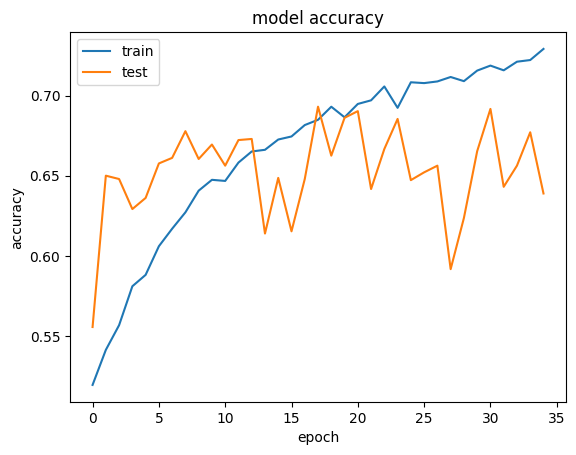

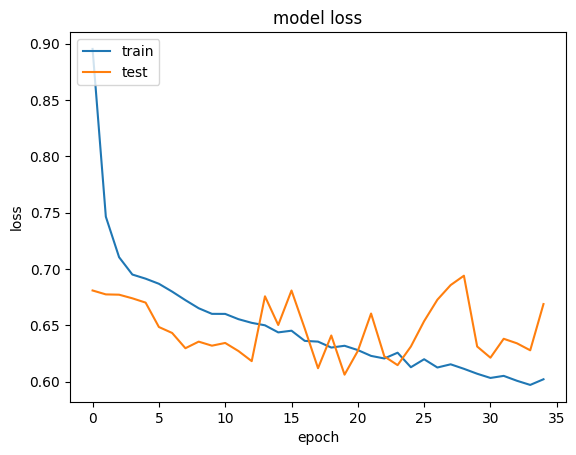

In [ ]:
# Após o treinamento
impHistoria(history)

In [ ]:
print(qx.shape, qy.shape)
print(np.unique(qy, return_counts=True))
print(np.unique(np.argmax(ensemble_preds, axis=1), return_counts=True))

NameError: name 'qx' is not defined

In [ ]:
print(ax.shape, qx.shape)

In [ ]:
df_text  = df.copy()

### treinando rede com texto usando AUTOML

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import h2o
from h2o.automl import H2OAutoML

h2o.init()

# Combina utterance e context
df_text ["texto"] = df_text ["SENTENCE"].astype(str) + " " + df_text ["Explicit_Emotion"].astype(str)   #usamos df clonado para evitar data leakage do data Augmentation feito para imagens


# Vetoriza em TF-IDF
tfidf = TfidfVectorizer(max_features=500)
X_tfidf = tfidf.fit_transform(df_text["texto"]).toarray()
df_tfidf = pd.DataFrame(X_tfidf, columns=[f"tfidf_{i}" for i in range(X_tfidf.shape[1])])

# Junta com o label
df_final = pd.concat([df_tfidf, df_text["Sarcasm"].reset_index(drop=True)], axis=1)

# Converte para H2OFrame
train_ML = h2o.H2OFrame(df_final.iloc[:pontoQuebraTesteTreino])
test_ML = h2o.H2OFrame(df_final.iloc[pontoQuebraTesteTreino:])

x = list(train_ML.columns)
y = "Sarcasm"
x.remove(y)

train_ML[y] = train_ML[y].asfactor()
test_ML[y] = test_ML[y].asfactor()

# AutoML
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=x, y=y, training_frame=train_ML)

lb = aml.leaderboard
print(lb.head())